In [9]:
import pandas as pd
import os
from PIL import Image
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from pathlib import Path
import torch.nn.functional as F
import sys
from sklearn.metrics import accuracy_score, recall_score
import random
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, precision_score

In [10]:
import os
import numpy as np
import requests

# Download the required files.

def download_file(url, save_path):
    try:
        response = requests.get(url)
        response.raise_for_status()  # Check if the request was successful.
        with open(save_path, 'wb') as f:
            f.write(response.content)
        print(f"Downloaded {save_path}")
    except requests.exceptions.RequestException as e:
        print(f"Failed to download {url}: {e}")


In [11]:
import os
import sys
import torch
import torchvision.models as models


def load_model_for_classification(model_name='resnet18', num_classes = 2, model_dir='../../data/external/Places365/model'):
    os.makedirs(model_dir, exist_ok=True)

    if model_name == 'resnet18':
        model_file = os.path.join(model_dir, 'resnet18_places365.pth')
        model_url = 'http://places2.csail.mit.edu/models_places365/wideresnet18_places365.pth.tar'
    elif model_name == 'alexnet':
        model_file = os.path.join(model_dir, 'alexnet_places365.pth')
        model_url = 'http://places2.csail.mit.edu/models_places365/alexnet_places365.pth'
    else:
        raise ValueError(f"Model {model_name} not supported.")

    if not os.path.exists(model_file):
        print(f"{model_file} does not exist. Downloading...")
        download_file(model_url, model_file)

    if model_name == 'resnet18':
        sys.path.append(model_dir)
        try:
            import wideresnet
            model = wideresnet.resnet18(num_classes=365)
            checkpoint = torch.load(model_file, map_location=lambda storage, loc: storage, weights_only=True)
            state_dict = {str.replace(k, 'module.', ''): v for k, v in checkpoint['state_dict'].items()}
            model.load_state_dict(state_dict)

            model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
        except ImportError as e:
            print(f"Error importing wideresnet module: {e}")
            return None
    elif model_name == 'alexnet':
        model = models.alexnet(num_classes=365)
        checkpoint = torch.load(model_file, map_location=lambda storage, loc: storage, weights_only=True)
        state_dict = {str.replace(k, 'module.', ''): v for k, v in checkpoint['state_dict'].items()}
        model.load_state_dict(state_dict)
        model.classifier[-1] = torch.nn.Linear(model.classifier[-1].in_features, num_classes)

    print(f"Model {model_name} for binary classification loaded successfully.")
    return model

    


# model = load_model_for_binary_classification(model_name='vgg16')
# model = load_model_for_binary_classification(model_name='googlenet')
# model = load_model_for_binary_classification(model_name='alexnet')


In [12]:
class LandscapesDataset(Dataset):
    def __init__(self, data_frame, transform=None):
        self.data_frame = data_frame
        self.transform = transform
        self.label = self.data_frame['type']

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        image_path = f"{self.data_frame.iloc[idx, 0]}.jpg"
        try:
            image = Image.open(image_path).convert('RGB')  
        except (IOError, SyntaxError) as e:
            print(f"Error opening image at {image_path}, skipping to next.")
            return self.__getitem__((idx + 1) % len(self))  
        
        if self.transform:
            image = self.transform(image)
            
        label = int(self.data_frame.iloc[idx, 1])
        return image, torch.tensor(label, dtype=torch.long)

In [13]:
import pandas as pd
original_data_path = '/home/ubuntu/landscape-aesthetics/data/external/ADEChallengeData2016/common_landscape_types.csv'
original_df = pd.read_csv(original_data_path) 
categories_df = pd.read_csv('/home/ubuntu/landscape-aesthetics/data/external/ADEChallengeData2016/landscape_categories.csv')  

categories_df['category_id'] = range(len(categories_df))

category_to_id = dict(zip(categories_df['category'], categories_df['category_id']))

original_df['type'] = original_df['type'].map(category_to_id)

original_df.to_csv('/home/ubuntu/landscape-aesthetics/data/external/ADEChallengeData2016/updated_images_info.csv', index=False)


In [14]:
data_path = '/home/ubuntu/landscape-aesthetics/data/external/ADEChallengeData2016/updated_images_info.csv'
image_folder = Path('/home/ubuntu/landscape-aesthetics/data/external/ADEChallengeData2016/images')

data = pd.read_csv(data_path, encoding='UTF-8')

training_images = {}
validation_images = {}

for _, row in data.iterrows():
    filename = row['id']
    category = row['type']
    if 'train' in filename:
        image_path = os.path.join(image_folder, 'training', filename)
        training_images[image_path] = category
    elif 'val' in filename:
        image_path = os.path.join(image_folder, 'validation', filename)
        validation_images[image_path] = category

training_df = pd.DataFrame(list(training_images.items()), columns=['filename', 'type'])
validation_df = pd.DataFrame(list(validation_images.items()), columns=['filename', 'type'])
validation_df = validation_df[validation_df['type'] != 305]

data_transforms = transforms.Compose([
        # transforms.Resize((256, 256)),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)
    ])

train_dataset = LandscapesDataset(data_frame=training_df,
                              transform=data_transforms)

val_dataset = LandscapesDataset(data_frame=validation_df,
                              transform=data_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))

print(f"Training set size: {len(train_loader.dataset)}")
print(f"Validation set size: {len(val_loader.dataset)}")


Training set size: 12942
Validation set size: 1280


In [15]:
model = load_model_for_classification(model_name='resnet18', num_classes = len(training_df['type'].unique()))

Model resnet18 for binary classification loaded successfully.


Epoch 1/10:   0%|                                       | 0/405 [00:00<?, ?it/s]

Epoch 1/10:   0%|                            | 0/405 [00:14<?, ?it/s, loss=5.82]

Epoch 1/10:   0%|                  | 1/405 [00:14<1:40:53, 14.98s/it, loss=5.82]

Epoch 1/10:   0%|                  | 1/405 [00:27<1:40:53, 14.98s/it, loss=22.5]

Epoch 1/10:   0%|                  | 2/405 [00:27<1:30:16, 13.44s/it, loss=22.5]

Epoch 1/10:   0%|                  | 2/405 [00:39<1:30:16, 13.44s/it, loss=10.2]

Epoch 1/10:   1%|▏                 | 3/405 [00:39<1:25:32, 12.77s/it, loss=10.2]

Epoch 1/10:   1%|▏                  | 3/405 [00:51<1:25:32, 12.77s/it, loss=8.4]

Epoch 1/10:   1%|▏                  | 4/405 [00:51<1:23:47, 12.54s/it, loss=8.4]

Epoch 1/10:   1%|▏                 | 4/405 [01:03<1:23:47, 12.54s/it, loss=19.4]

Epoch 1/10:   1%|▏                 | 5/405 [01:03<1:22:13, 12.33s/it, loss=19.4]

Epoch 1/10:   1%|▏                 | 5/405 [01:15<1:22:13, 12.33s/it, loss=8.32]

Epoch 1/10:   1%|▎                 | 6/405 [01:15<1:21:28, 12.25s/it, loss=8.32]

Epoch 1/10:   1%|▎                 | 6/405 [01:26<1:21:28, 12.25s/it, loss=11.5]

Epoch 1/10:   2%|▎                 | 7/405 [01:26<1:19:24, 11.97s/it, loss=11.5]

Epoch 1/10:   2%|▎                 | 7/405 [01:38<1:19:24, 11.97s/it, loss=5.35]

Epoch 1/10:   2%|▎                 | 8/405 [01:38<1:18:58, 11.94s/it, loss=5.35]

Epoch 1/10:   2%|▎                 | 8/405 [01:50<1:18:58, 11.94s/it, loss=15.6]

Epoch 1/10:   2%|▍                 | 9/405 [01:50<1:17:42, 11.77s/it, loss=15.6]

Epoch 1/10:   2%|▍                 | 9/405 [02:01<1:17:42, 11.77s/it, loss=5.66]

Epoch 1/10:   2%|▍                | 10/405 [02:01<1:17:20, 11.75s/it, loss=5.66]

Epoch 1/10:   2%|▍                 | 10/405 [02:12<1:17:20, 11.75s/it, loss=5.8]

Epoch 1/10:   3%|▍                 | 11/405 [02:12<1:15:39, 11.52s/it, loss=5.8]

Epoch 1/10:   3%|▍                | 11/405 [02:24<1:15:39, 11.52s/it, loss=4.87]

Epoch 1/10:   3%|▌                | 12/405 [02:24<1:15:13, 11.48s/it, loss=4.87]

Epoch 1/10:   3%|▌                | 12/405 [02:35<1:15:13, 11.48s/it, loss=7.14]

Epoch 1/10:   3%|▌                | 13/405 [02:35<1:15:18, 11.53s/it, loss=7.14]

Epoch 1/10:   3%|▌                | 13/405 [02:47<1:15:18, 11.53s/it, loss=5.44]

Epoch 1/10:   3%|▌                | 14/405 [02:47<1:14:27, 11.43s/it, loss=5.44]

Epoch 1/10:   3%|▌                | 14/405 [02:57<1:14:27, 11.43s/it, loss=6.28]

Epoch 1/10:   4%|▋                | 15/405 [02:57<1:12:38, 11.18s/it, loss=6.28]

Epoch 1/10:   4%|▋                | 15/405 [03:09<1:12:38, 11.18s/it, loss=4.82]

Epoch 1/10:   4%|▋                | 16/405 [03:09<1:13:21, 11.31s/it, loss=4.82]

Epoch 1/10:   4%|▋                | 16/405 [03:20<1:13:21, 11.31s/it, loss=5.18]

Epoch 1/10:   4%|▋                | 17/405 [03:20<1:12:55, 11.28s/it, loss=5.18]

Epoch 1/10:   4%|▋                | 17/405 [03:32<1:12:55, 11.28s/it, loss=4.99]

Epoch 1/10:   4%|▊                | 18/405 [03:32<1:14:07, 11.49s/it, loss=4.99]

Epoch 1/10:   4%|▊                | 18/405 [03:43<1:14:07, 11.49s/it, loss=4.84]

Epoch 1/10:   5%|▊                | 19/405 [03:43<1:13:28, 11.42s/it, loss=4.84]

Epoch 1/10:   5%|▊                | 19/405 [03:55<1:13:28, 11.42s/it, loss=5.17]

Epoch 1/10:   5%|▊                | 20/405 [03:55<1:14:18, 11.58s/it, loss=5.17]

Epoch 1/10:   5%|▊                | 20/405 [04:07<1:14:18, 11.58s/it, loss=4.49]

Epoch 1/10:   5%|▉                | 21/405 [04:07<1:14:18, 11.61s/it, loss=4.49]

Epoch 1/10:   5%|▉                | 21/405 [04:19<1:14:18, 11.61s/it, loss=4.42]

Epoch 1/10:   5%|▉                | 22/405 [04:19<1:14:51, 11.73s/it, loss=4.42]

Epoch 1/10:   5%|▉                | 22/405 [04:30<1:14:51, 11.73s/it, loss=4.42]

Epoch 1/10:   6%|▉                | 23/405 [04:30<1:13:29, 11.54s/it, loss=4.42]

Epoch 1/10:   6%|▉                | 23/405 [04:41<1:13:29, 11.54s/it, loss=4.52]

Epoch 1/10:   6%|█                | 24/405 [04:41<1:12:00, 11.34s/it, loss=4.52]

Epoch 1/10:   6%|█                | 24/405 [04:52<1:12:00, 11.34s/it, loss=4.49]

Epoch 1/10:   6%|█                | 25/405 [04:52<1:11:36, 11.31s/it, loss=4.49]

Epoch 1/10:   6%|█                 | 25/405 [05:03<1:11:36, 11.31s/it, loss=4.2]

Epoch 1/10:   6%|█▏                | 26/405 [05:03<1:11:05, 11.25s/it, loss=4.2]

Epoch 1/10:   6%|█▏                | 26/405 [05:14<1:11:05, 11.25s/it, loss=4.8]

Epoch 1/10:   7%|█▏                | 27/405 [05:14<1:10:25, 11.18s/it, loss=4.8]

Epoch 1/10:   7%|█▏               | 27/405 [05:26<1:10:25, 11.18s/it, loss=4.61]

Epoch 1/10:   7%|█▏               | 28/405 [05:26<1:10:30, 11.22s/it, loss=4.61]

Epoch 1/10:   7%|█▏               | 28/405 [05:37<1:10:30, 11.22s/it, loss=4.64]

Epoch 1/10:   7%|█▏               | 29/405 [05:37<1:10:16, 11.21s/it, loss=4.64]

Epoch 1/10:   7%|█▏               | 29/405 [05:48<1:10:16, 11.21s/it, loss=4.28]

Epoch 1/10:   7%|█▎               | 30/405 [05:48<1:10:10, 11.23s/it, loss=4.28]

Epoch 1/10:   7%|█▎               | 30/405 [05:59<1:10:10, 11.23s/it, loss=4.49]

Epoch 1/10:   8%|█▎               | 31/405 [05:59<1:10:08, 11.25s/it, loss=4.49]

Epoch 1/10:   8%|█▎               | 31/405 [06:11<1:10:08, 11.25s/it, loss=4.53]

Epoch 1/10:   8%|█▎               | 32/405 [06:11<1:10:02, 11.27s/it, loss=4.53]

Epoch 1/10:   8%|█▎               | 32/405 [06:22<1:10:02, 11.27s/it, loss=4.46]

Epoch 1/10:   8%|█▍               | 33/405 [06:22<1:09:47, 11.26s/it, loss=4.46]

Epoch 1/10:   8%|█▍               | 33/405 [06:33<1:09:47, 11.26s/it, loss=4.41]

Epoch 1/10:   8%|█▍               | 34/405 [06:33<1:09:33, 11.25s/it, loss=4.41]

Epoch 1/10:   8%|█▍               | 34/405 [06:45<1:09:33, 11.25s/it, loss=5.32]

Epoch 1/10:   9%|█▍               | 35/405 [06:45<1:09:33, 11.28s/it, loss=5.32]

Epoch 1/10:   9%|█▍               | 35/405 [06:55<1:09:33, 11.28s/it, loss=3.79]

Epoch 1/10:   9%|█▌               | 36/405 [06:55<1:07:55, 11.04s/it, loss=3.79]

Epoch 1/10:   9%|█▌               | 36/405 [07:06<1:07:55, 11.04s/it, loss=4.39]

Epoch 1/10:   9%|█▌               | 37/405 [07:06<1:06:46, 10.89s/it, loss=4.39]

Epoch 1/10:   9%|█▌               | 37/405 [07:17<1:06:46, 10.89s/it, loss=4.83]

Epoch 1/10:   9%|█▌               | 38/405 [07:17<1:07:21, 11.01s/it, loss=4.83]

Epoch 1/10:   9%|█▌               | 38/405 [07:28<1:07:21, 11.01s/it, loss=4.06]

Epoch 1/10:  10%|█▋               | 39/405 [07:28<1:08:03, 11.16s/it, loss=4.06]

Epoch 1/10:  10%|█▋               | 39/405 [07:39<1:08:03, 11.16s/it, loss=4.51]

Epoch 1/10:  10%|█▋               | 40/405 [07:39<1:07:29, 11.09s/it, loss=4.51]

Epoch 1/10:  10%|█▋               | 40/405 [07:50<1:07:29, 11.09s/it, loss=4.54]

Epoch 1/10:  10%|█▋               | 41/405 [07:50<1:06:45, 11.00s/it, loss=4.54]

Epoch 1/10:  10%|█▋               | 41/405 [08:01<1:06:45, 11.00s/it, loss=4.45]

Epoch 1/10:  10%|█▊               | 42/405 [08:01<1:06:50, 11.05s/it, loss=4.45]

Epoch 1/10:  10%|█▊               | 42/405 [08:12<1:06:50, 11.05s/it, loss=4.35]

Epoch 1/10:  11%|█▊               | 43/405 [08:12<1:06:39, 11.05s/it, loss=4.35]

Epoch 1/10:  11%|█▊               | 43/405 [08:23<1:06:39, 11.05s/it, loss=4.81]

Epoch 1/10:  11%|█▊               | 44/405 [08:23<1:06:28, 11.05s/it, loss=4.81]

Epoch 1/10:  11%|█▊               | 44/405 [08:35<1:06:28, 11.05s/it, loss=3.79]

Epoch 1/10:  11%|█▉               | 45/405 [08:35<1:06:55, 11.15s/it, loss=3.79]

Epoch 1/10:  11%|█▉               | 45/405 [08:46<1:06:55, 11.15s/it, loss=4.76]

Epoch 1/10:  11%|█▉               | 46/405 [08:46<1:06:35, 11.13s/it, loss=4.76]

Epoch 1/10:  11%|█▉               | 46/405 [08:57<1:06:35, 11.13s/it, loss=4.71]

Epoch 1/10:  12%|█▉               | 47/405 [08:57<1:06:03, 11.07s/it, loss=4.71]

Epoch 1/10:  12%|█▉               | 47/405 [09:08<1:06:03, 11.07s/it, loss=4.45]

Epoch 1/10:  12%|██               | 48/405 [09:08<1:06:31, 11.18s/it, loss=4.45]

Epoch 1/10:  12%|██               | 48/405 [09:18<1:06:31, 11.18s/it, loss=3.67]

Epoch 1/10:  12%|██               | 49/405 [09:18<1:04:38, 10.89s/it, loss=3.67]

Epoch 1/10:  12%|██               | 49/405 [09:29<1:04:38, 10.89s/it, loss=3.98]

Epoch 1/10:  12%|██               | 50/405 [09:29<1:04:47, 10.95s/it, loss=3.98]

Epoch 1/10:  12%|██               | 50/405 [09:40<1:04:47, 10.95s/it, loss=4.11]

Epoch 1/10:  13%|██▏              | 51/405 [09:40<1:04:14, 10.89s/it, loss=4.11]

Epoch 1/10:  13%|██▎               | 51/405 [09:51<1:04:14, 10.89s/it, loss=4.3]

Epoch 1/10:  13%|██▎               | 52/405 [09:51<1:03:59, 10.88s/it, loss=4.3]

Epoch 1/10:  13%|██▏              | 52/405 [10:02<1:03:59, 10.88s/it, loss=4.62]

Epoch 1/10:  13%|██▏              | 53/405 [10:02<1:04:29, 10.99s/it, loss=4.62]

Epoch 1/10:  13%|██▏              | 53/405 [10:13<1:04:29, 10.99s/it, loss=4.52]

Epoch 1/10:  13%|██▎              | 54/405 [10:13<1:03:24, 10.84s/it, loss=4.52]

Epoch 1/10:  13%|██▎              | 54/405 [10:24<1:03:24, 10.84s/it, loss=4.64]

Epoch 1/10:  14%|██▎              | 55/405 [10:24<1:03:31, 10.89s/it, loss=4.64]

Epoch 1/10:  14%|██▎              | 55/405 [10:35<1:03:31, 10.89s/it, loss=4.11]

Epoch 1/10:  14%|██▎              | 56/405 [10:35<1:03:05, 10.85s/it, loss=4.11]

Epoch 1/10:  14%|██▎              | 56/405 [10:45<1:03:05, 10.85s/it, loss=3.95]

Epoch 1/10:  14%|██▍              | 57/405 [10:45<1:02:56, 10.85s/it, loss=3.95]

Epoch 1/10:  14%|██▍              | 57/405 [10:56<1:02:56, 10.85s/it, loss=4.46]

Epoch 1/10:  14%|██▍              | 58/405 [10:56<1:02:38, 10.83s/it, loss=4.46]

Epoch 1/10:  14%|██▍              | 58/405 [11:07<1:02:38, 10.83s/it, loss=4.29]

Epoch 1/10:  15%|██▍              | 59/405 [11:07<1:02:27, 10.83s/it, loss=4.29]

Epoch 1/10:  15%|██▍              | 59/405 [11:18<1:02:27, 10.83s/it, loss=4.74]

Epoch 1/10:  15%|██▌              | 60/405 [11:18<1:02:21, 10.84s/it, loss=4.74]

Epoch 1/10:  15%|██▌              | 60/405 [11:29<1:02:21, 10.84s/it, loss=4.01]

Epoch 1/10:  15%|██▌              | 61/405 [11:29<1:02:45, 10.95s/it, loss=4.01]

Epoch 1/10:  15%|███                 | 61/405 [11:40<1:02:45, 10.95s/it, loss=4]

Epoch 1/10:  15%|███                 | 62/405 [11:40<1:02:29, 10.93s/it, loss=4]

Epoch 1/10:  15%|██▌              | 62/405 [11:51<1:02:29, 10.93s/it, loss=3.95]

Epoch 1/10:  16%|██▋              | 63/405 [11:51<1:02:24, 10.95s/it, loss=3.95]

Epoch 1/10:  16%|██▋              | 63/405 [12:01<1:02:24, 10.95s/it, loss=4.09]

Epoch 1/10:  16%|██▋              | 64/405 [12:01<1:01:08, 10.76s/it, loss=4.09]

Epoch 1/10:  16%|██▋              | 64/405 [12:12<1:01:08, 10.76s/it, loss=4.13]

Epoch 1/10:  16%|██▋              | 65/405 [12:12<1:01:18, 10.82s/it, loss=4.13]

Epoch 1/10:  16%|██▋              | 65/405 [12:23<1:01:18, 10.82s/it, loss=4.26]

Epoch 1/10:  16%|██▊              | 66/405 [12:23<1:01:01, 10.80s/it, loss=4.26]

Epoch 1/10:  16%|██▊              | 66/405 [12:35<1:01:01, 10.80s/it, loss=3.77]

Epoch 1/10:  17%|██▊              | 67/405 [12:35<1:02:08, 11.03s/it, loss=3.77]

Epoch 1/10:  17%|██▊              | 67/405 [12:46<1:02:08, 11.03s/it, loss=4.02]

Epoch 1/10:  17%|██▊              | 68/405 [12:46<1:02:24, 11.11s/it, loss=4.02]

Epoch 1/10:  17%|██▊              | 68/405 [12:57<1:02:24, 11.11s/it, loss=4.25]

Epoch 1/10:  17%|██▉              | 69/405 [12:57<1:02:05, 11.09s/it, loss=4.25]

Epoch 1/10:  17%|██▉              | 69/405 [13:07<1:02:05, 11.09s/it, loss=4.65]

Epoch 1/10:  17%|██▉              | 70/405 [13:07<1:00:29, 10.84s/it, loss=4.65]

Epoch 1/10:  17%|██▉              | 70/405 [13:19<1:00:29, 10.84s/it, loss=3.97]

Epoch 1/10:  18%|██▉              | 71/405 [13:19<1:01:26, 11.04s/it, loss=3.97]

Epoch 1/10:  18%|██▉              | 71/405 [13:29<1:01:26, 11.04s/it, loss=4.69]

Epoch 1/10:  18%|███              | 72/405 [13:29<1:00:50, 10.96s/it, loss=4.69]

Epoch 1/10:  18%|███              | 72/405 [13:40<1:00:50, 10.96s/it, loss=4.73]

Epoch 1/10:  18%|███              | 73/405 [13:40<1:00:37, 10.96s/it, loss=4.73]

Epoch 1/10:  18%|███              | 73/405 [13:52<1:00:37, 10.96s/it, loss=4.13]

Epoch 1/10:  18%|███              | 74/405 [13:52<1:01:12, 11.10s/it, loss=4.13]

Epoch 1/10:  18%|███▎              | 74/405 [14:03<1:01:12, 11.10s/it, loss=4.1]

Epoch 1/10:  19%|███▎              | 75/405 [14:03<1:01:05, 11.11s/it, loss=4.1]

Epoch 1/10:  19%|███▏             | 75/405 [14:14<1:01:05, 11.11s/it, loss=4.52]

Epoch 1/10:  19%|███▏             | 76/405 [14:14<1:00:59, 11.12s/it, loss=4.52]

Epoch 1/10:  19%|███▏             | 76/405 [14:24<1:00:59, 11.12s/it, loss=4.33]

Epoch 1/10:  19%|███▌               | 77/405 [14:25<59:36, 10.91s/it, loss=4.33]

Epoch 1/10:  19%|███▌               | 77/405 [14:35<59:36, 10.91s/it, loss=4.21]

Epoch 1/10:  19%|███▋               | 78/405 [14:35<59:10, 10.86s/it, loss=4.21]

Epoch 1/10:  19%|███▋               | 78/405 [14:46<59:10, 10.86s/it, loss=4.49]

Epoch 1/10:  20%|███▋               | 79/405 [14:46<58:46, 10.82s/it, loss=4.49]

Epoch 1/10:  20%|███▋               | 79/405 [14:57<58:46, 10.82s/it, loss=4.28]

Epoch 1/10:  20%|███▊               | 80/405 [14:57<59:22, 10.96s/it, loss=4.28]

Epoch 1/10:  20%|███▊               | 80/405 [15:08<59:22, 10.96s/it, loss=3.97]

Epoch 1/10:  20%|███▊               | 81/405 [15:08<59:32, 11.03s/it, loss=3.97]

Epoch 1/10:  20%|███▊               | 81/405 [15:19<59:32, 11.03s/it, loss=4.68]

Epoch 1/10:  20%|███▊               | 82/405 [15:19<57:55, 10.76s/it, loss=4.68]

Epoch 1/10:  20%|███▊               | 82/405 [15:29<57:55, 10.76s/it, loss=4.55]

Epoch 1/10:  20%|███▉               | 83/405 [15:29<57:12, 10.66s/it, loss=4.55]

Epoch 1/10:  20%|███▉               | 83/405 [15:40<57:12, 10.66s/it, loss=4.49]

Epoch 1/10:  21%|███▉               | 84/405 [15:40<57:04, 10.67s/it, loss=4.49]

Epoch 1/10:  21%|████▏               | 84/405 [15:51<57:04, 10.67s/it, loss=4.4]

Epoch 1/10:  21%|████▏               | 85/405 [15:51<57:48, 10.84s/it, loss=4.4]

Epoch 1/10:  21%|███▉               | 85/405 [16:02<57:48, 10.84s/it, loss=4.26]

Epoch 1/10:  21%|████               | 86/405 [16:02<57:46, 10.87s/it, loss=4.26]

Epoch 1/10:  21%|████               | 86/405 [16:13<57:46, 10.87s/it, loss=3.59]

Epoch 1/10:  21%|████               | 87/405 [16:13<57:59, 10.94s/it, loss=3.59]

Epoch 1/10:  21%|████▎               | 87/405 [16:24<57:59, 10.94s/it, loss=4.3]

Epoch 1/10:  22%|████▎               | 88/405 [16:24<57:58, 10.97s/it, loss=4.3]

Epoch 1/10:  22%|████▏              | 88/405 [16:35<57:58, 10.97s/it, loss=4.72]

Epoch 1/10:  22%|████▏              | 89/405 [16:35<57:34, 10.93s/it, loss=4.72]

Epoch 1/10:  22%|████▏              | 89/405 [16:45<57:34, 10.93s/it, loss=5.04]

Epoch 1/10:  22%|████▏              | 90/405 [16:45<56:41, 10.80s/it, loss=5.04]

Epoch 1/10:  22%|████▏              | 90/405 [16:57<56:41, 10.80s/it, loss=4.86]

Epoch 1/10:  22%|████▎              | 91/405 [16:57<57:11, 10.93s/it, loss=4.86]

Epoch 1/10:  22%|████▎              | 91/405 [17:07<57:11, 10.93s/it, loss=4.23]

Epoch 1/10:  23%|████▎              | 92/405 [17:07<56:51, 10.90s/it, loss=4.23]

Epoch 1/10:  23%|████▎              | 92/405 [17:18<56:51, 10.90s/it, loss=3.91]

Epoch 1/10:  23%|████▎              | 93/405 [17:18<56:52, 10.94s/it, loss=3.91]

Epoch 1/10:  23%|████▌               | 93/405 [17:29<56:52, 10.94s/it, loss=4.2]

Epoch 1/10:  23%|████▋               | 94/405 [17:29<56:43, 10.94s/it, loss=4.2]

Epoch 1/10:  23%|████▍              | 94/405 [17:40<56:43, 10.94s/it, loss=3.81]

Epoch 1/10:  23%|████▍              | 95/405 [17:40<56:46, 10.99s/it, loss=3.81]

Epoch 1/10:  23%|████▍              | 95/405 [17:51<56:46, 10.99s/it, loss=4.04]

Epoch 1/10:  24%|████▌              | 96/405 [17:51<56:18, 10.93s/it, loss=4.04]

Epoch 1/10:  24%|████▌              | 96/405 [18:02<56:18, 10.93s/it, loss=4.69]

Epoch 1/10:  24%|████▌              | 97/405 [18:02<56:13, 10.95s/it, loss=4.69]

Epoch 1/10:  24%|████▌              | 97/405 [18:13<56:13, 10.95s/it, loss=4.88]

Epoch 1/10:  24%|████▌              | 98/405 [18:13<55:51, 10.92s/it, loss=4.88]

Epoch 1/10:  24%|████▌              | 98/405 [18:24<55:51, 10.92s/it, loss=5.18]

Epoch 1/10:  24%|████▋              | 99/405 [18:24<56:12, 11.02s/it, loss=5.18]

Epoch 1/10:  24%|████▋              | 99/405 [18:35<56:12, 11.02s/it, loss=4.26]

Epoch 1/10:  25%|████▍             | 100/405 [18:35<56:08, 11.04s/it, loss=4.26]

Epoch 1/10:  25%|████▍             | 100/405 [18:47<56:08, 11.04s/it, loss=4.55]

Epoch 1/10:  25%|████▍             | 101/405 [18:47<56:03, 11.06s/it, loss=4.55]

Epoch 1/10:  25%|████▍             | 101/405 [18:58<56:03, 11.06s/it, loss=4.35]

Epoch 1/10:  25%|████▌             | 102/405 [18:58<55:48, 11.05s/it, loss=4.35]

Epoch 1/10:  25%|████▌             | 102/405 [19:09<55:48, 11.05s/it, loss=4.31]

Epoch 1/10:  25%|████▌             | 103/405 [19:09<55:50, 11.09s/it, loss=4.31]

Epoch 1/10:  25%|████▌             | 103/405 [19:19<55:50, 11.09s/it, loss=3.69]

Epoch 1/10:  26%|████▌             | 104/405 [19:19<54:59, 10.96s/it, loss=3.69]

Epoch 1/10:  26%|████▌             | 104/405 [19:30<54:59, 10.96s/it, loss=4.34]

Epoch 1/10:  26%|████▋             | 105/405 [19:30<54:32, 10.91s/it, loss=4.34]

Epoch 1/10:  26%|████▋             | 105/405 [19:41<54:32, 10.91s/it, loss=4.46]

Epoch 1/10:  26%|████▋             | 106/405 [19:41<54:41, 10.97s/it, loss=4.46]

Epoch 1/10:  26%|████▋             | 106/405 [19:53<54:41, 10.97s/it, loss=4.63]

Epoch 1/10:  26%|████▊             | 107/405 [19:53<54:50, 11.04s/it, loss=4.63]

Epoch 1/10:  26%|████▊             | 107/405 [20:04<54:50, 11.04s/it, loss=3.98]

Epoch 1/10:  27%|████▊             | 108/405 [20:04<55:04, 11.13s/it, loss=3.98]

Epoch 1/10:  27%|████▊             | 108/405 [20:16<55:04, 11.13s/it, loss=3.85]

Epoch 1/10:  27%|████▊             | 109/405 [20:16<55:38, 11.28s/it, loss=3.85]

Epoch 1/10:  27%|████▊             | 109/405 [20:27<55:38, 11.28s/it, loss=4.14]

Epoch 1/10:  27%|████▉             | 110/405 [20:27<55:52, 11.37s/it, loss=4.14]

Epoch 1/10:  27%|████▉             | 110/405 [20:38<55:52, 11.37s/it, loss=4.56]

Epoch 1/10:  27%|████▉             | 111/405 [20:38<55:16, 11.28s/it, loss=4.56]

Epoch 1/10:  27%|████▉             | 111/405 [20:50<55:16, 11.28s/it, loss=4.33]

Epoch 1/10:  28%|████▉             | 112/405 [20:50<55:36, 11.39s/it, loss=4.33]

Epoch 1/10:  28%|█████▎             | 112/405 [21:01<55:36, 11.39s/it, loss=4.3]

Epoch 1/10:  28%|█████▎             | 113/405 [21:01<55:21, 11.37s/it, loss=4.3]

Epoch 1/10:  28%|█████             | 113/405 [21:13<55:21, 11.37s/it, loss=4.19]

Epoch 1/10:  28%|█████             | 114/405 [21:13<55:10, 11.38s/it, loss=4.19]

Epoch 1/10:  28%|█████             | 114/405 [21:24<55:10, 11.38s/it, loss=3.98]

Epoch 1/10:  28%|█████             | 115/405 [21:24<54:23, 11.25s/it, loss=3.98]

Epoch 1/10:  28%|█████             | 115/405 [21:35<54:23, 11.25s/it, loss=3.91]

Epoch 1/10:  29%|█████▏            | 116/405 [21:35<53:53, 11.19s/it, loss=3.91]

Epoch 1/10:  29%|█████▏            | 116/405 [21:46<53:53, 11.19s/it, loss=4.44]

Epoch 1/10:  29%|█████▏            | 117/405 [21:46<53:53, 11.23s/it, loss=4.44]

Epoch 1/10:  29%|█████▏            | 117/405 [21:57<53:53, 11.23s/it, loss=4.03]

Epoch 1/10:  29%|█████▏            | 118/405 [21:57<53:56, 11.28s/it, loss=4.03]

Epoch 1/10:  29%|█████▏            | 118/405 [22:08<53:56, 11.28s/it, loss=4.57]

Epoch 1/10:  29%|█████▎            | 119/405 [22:08<53:30, 11.23s/it, loss=4.57]

Epoch 1/10:  29%|█████▎            | 119/405 [22:19<53:30, 11.23s/it, loss=4.35]

Epoch 1/10:  30%|█████▎            | 120/405 [22:19<52:50, 11.12s/it, loss=4.35]

Epoch 1/10:  30%|█████▎            | 120/405 [22:30<52:50, 11.12s/it, loss=3.93]

Epoch 1/10:  30%|█████▍            | 121/405 [22:30<52:41, 11.13s/it, loss=3.93]

Epoch 1/10:  30%|█████▍            | 121/405 [22:41<52:41, 11.13s/it, loss=4.28]

Epoch 1/10:  30%|█████▍            | 122/405 [22:41<52:25, 11.11s/it, loss=4.28]

Epoch 1/10:  30%|█████▍            | 122/405 [22:52<52:25, 11.11s/it, loss=4.96]

Epoch 1/10:  30%|█████▍            | 123/405 [22:52<51:18, 10.92s/it, loss=4.96]

Epoch 1/10:  30%|█████▍            | 123/405 [23:03<51:18, 10.92s/it, loss=4.19]

Epoch 1/10:  31%|█████▌            | 124/405 [23:03<51:05, 10.91s/it, loss=4.19]

Epoch 1/10:  31%|█████▌            | 124/405 [23:14<51:05, 10.91s/it, loss=4.58]

Epoch 1/10:  31%|█████▌            | 125/405 [23:14<51:13, 10.98s/it, loss=4.58]

Epoch 1/10:  31%|█████▌            | 125/405 [23:25<51:13, 10.98s/it, loss=4.24]

Epoch 1/10:  31%|█████▌            | 126/405 [23:25<50:26, 10.85s/it, loss=4.24]

Epoch 1/10:  31%|█████▉             | 126/405 [23:35<50:26, 10.85s/it, loss=4.2]

Epoch 1/10:  31%|█████▉             | 127/405 [23:35<50:04, 10.81s/it, loss=4.2]

Epoch 1/10:  31%|█████▋            | 127/405 [23:47<50:04, 10.81s/it, loss=4.32]

Epoch 1/10:  32%|█████▋            | 128/405 [23:47<50:35, 10.96s/it, loss=4.32]

Epoch 1/10:  32%|█████▋            | 128/405 [23:57<50:35, 10.96s/it, loss=3.93]

Epoch 1/10:  32%|█████▋            | 129/405 [23:57<49:53, 10.85s/it, loss=3.93]

Epoch 1/10:  32%|█████▋            | 129/405 [24:08<49:53, 10.85s/it, loss=4.26]

Epoch 1/10:  32%|█████▊            | 130/405 [24:08<49:47, 10.86s/it, loss=4.26]

Epoch 1/10:  32%|█████▊            | 130/405 [24:19<49:47, 10.86s/it, loss=4.07]

Epoch 1/10:  32%|█████▊            | 131/405 [24:19<49:18, 10.80s/it, loss=4.07]

Epoch 1/10:  32%|██████▏            | 131/405 [24:30<49:18, 10.80s/it, loss=4.1]

Epoch 1/10:  33%|██████▏            | 132/405 [24:30<49:18, 10.84s/it, loss=4.1]

Epoch 1/10:  33%|█████▊            | 132/405 [24:40<49:18, 10.84s/it, loss=4.58]

Epoch 1/10:  33%|█████▉            | 133/405 [24:40<49:03, 10.82s/it, loss=4.58]

Epoch 1/10:  33%|██████▏            | 133/405 [24:51<49:03, 10.82s/it, loss=4.3]

Epoch 1/10:  33%|██████▎            | 134/405 [24:51<49:15, 10.91s/it, loss=4.3]

Epoch 1/10:  33%|█████▉            | 134/405 [25:02<49:15, 10.91s/it, loss=4.34]

Epoch 1/10:  33%|██████            | 135/405 [25:02<49:08, 10.92s/it, loss=4.34]

Epoch 1/10:  33%|██████            | 135/405 [25:13<49:08, 10.92s/it, loss=4.72]

Epoch 1/10:  34%|██████            | 136/405 [25:13<49:07, 10.96s/it, loss=4.72]

Epoch 1/10:  34%|██████            | 136/405 [25:25<49:07, 10.96s/it, loss=3.64]

Epoch 1/10:  34%|██████            | 137/405 [25:25<49:17, 11.03s/it, loss=3.64]

Epoch 1/10:  34%|██████            | 137/405 [25:35<49:17, 11.03s/it, loss=4.21]

Epoch 1/10:  34%|██████▏           | 138/405 [25:35<48:28, 10.89s/it, loss=4.21]

Epoch 1/10:  34%|██████▏           | 138/405 [25:46<48:28, 10.89s/it, loss=4.02]

Epoch 1/10:  34%|██████▏           | 139/405 [25:46<47:49, 10.79s/it, loss=4.02]

Epoch 1/10:  34%|██████▏           | 139/405 [25:57<47:49, 10.79s/it, loss=4.78]

Epoch 1/10:  35%|██████▏           | 140/405 [25:57<48:26, 10.97s/it, loss=4.78]

Epoch 1/10:  35%|██████▏           | 140/405 [26:08<48:26, 10.97s/it, loss=4.27]

Epoch 1/10:  35%|██████▎           | 141/405 [26:08<48:12, 10.95s/it, loss=4.27]

Epoch 1/10:  35%|██████▎           | 141/405 [26:19<48:12, 10.95s/it, loss=4.35]

Epoch 1/10:  35%|██████▎           | 142/405 [26:19<47:42, 10.89s/it, loss=4.35]

Epoch 1/10:  35%|██████▎           | 142/405 [26:30<47:42, 10.89s/it, loss=4.59]

Epoch 1/10:  35%|██████▎           | 143/405 [26:30<47:30, 10.88s/it, loss=4.59]

Epoch 1/10:  35%|██████▎           | 143/405 [26:41<47:30, 10.88s/it, loss=3.98]

Epoch 1/10:  36%|██████▍           | 144/405 [26:41<47:19, 10.88s/it, loss=3.98]

Epoch 1/10:  36%|██████▍           | 144/405 [26:52<47:19, 10.88s/it, loss=4.33]

Epoch 1/10:  36%|██████▍           | 145/405 [26:52<47:54, 11.06s/it, loss=4.33]

Epoch 1/10:  36%|██████▍           | 145/405 [27:03<47:54, 11.06s/it, loss=4.06]

Epoch 1/10:  36%|██████▍           | 146/405 [27:03<47:48, 11.07s/it, loss=4.06]

Epoch 1/10:  36%|██████▍           | 146/405 [27:14<47:48, 11.07s/it, loss=4.75]

Epoch 1/10:  36%|██████▌           | 147/405 [27:14<47:31, 11.05s/it, loss=4.75]

Epoch 1/10:  36%|██████▌           | 147/405 [27:25<47:31, 11.05s/it, loss=4.15]

Epoch 1/10:  37%|██████▌           | 148/405 [27:25<47:21, 11.06s/it, loss=4.15]

Epoch 1/10:  37%|██████▌           | 148/405 [27:36<47:21, 11.06s/it, loss=4.19]

Epoch 1/10:  37%|██████▌           | 149/405 [27:36<47:13, 11.07s/it, loss=4.19]

Epoch 1/10:  37%|██████▌           | 149/405 [27:47<47:13, 11.07s/it, loss=4.16]

Epoch 1/10:  37%|██████▋           | 150/405 [27:47<46:45, 11.00s/it, loss=4.16]

Epoch 1/10:  37%|██████▋           | 150/405 [27:58<46:45, 11.00s/it, loss=4.31]

Epoch 1/10:  37%|██████▋           | 151/405 [27:58<46:37, 11.01s/it, loss=4.31]

Epoch 1/10:  37%|██████▋           | 151/405 [28:09<46:37, 11.01s/it, loss=3.89]

Epoch 1/10:  38%|██████▊           | 152/405 [28:09<46:28, 11.02s/it, loss=3.89]

Epoch 1/10:  38%|██████▊           | 152/405 [28:20<46:28, 11.02s/it, loss=4.74]

Epoch 1/10:  38%|██████▊           | 153/405 [28:20<45:58, 10.94s/it, loss=4.74]

Epoch 1/10:  38%|██████▊           | 153/405 [28:30<45:58, 10.94s/it, loss=3.92]

Epoch 1/10:  38%|██████▊           | 154/405 [28:30<44:39, 10.67s/it, loss=3.92]

Epoch 1/10:  38%|██████▊           | 154/405 [28:41<44:39, 10.67s/it, loss=4.27]

Epoch 1/10:  38%|██████▉           | 155/405 [28:41<45:09, 10.84s/it, loss=4.27]

Epoch 1/10:  38%|██████▉           | 155/405 [28:52<45:09, 10.84s/it, loss=3.97]

Epoch 1/10:  39%|██████▉           | 156/405 [28:52<44:58, 10.84s/it, loss=3.97]

Epoch 1/10:  39%|██████▉           | 156/405 [29:03<44:58, 10.84s/it, loss=4.36]

Epoch 1/10:  39%|██████▉           | 157/405 [29:03<44:28, 10.76s/it, loss=4.36]

Epoch 1/10:  39%|██████▉           | 157/405 [29:14<44:28, 10.76s/it, loss=3.11]

Epoch 1/10:  39%|███████           | 158/405 [29:14<45:13, 10.99s/it, loss=3.11]

Epoch 1/10:  39%|███████           | 158/405 [29:26<45:13, 10.99s/it, loss=3.96]

Epoch 1/10:  39%|███████           | 159/405 [29:26<45:25, 11.08s/it, loss=3.96]

Epoch 1/10:  39%|███████           | 159/405 [29:36<45:25, 11.08s/it, loss=4.54]

Epoch 1/10:  40%|███████           | 160/405 [29:36<43:58, 10.77s/it, loss=4.54]

Epoch 1/10:  40%|███████           | 160/405 [29:46<43:58, 10.77s/it, loss=4.46]

Epoch 1/10:  40%|███████▏          | 161/405 [29:46<43:40, 10.74s/it, loss=4.46]

Epoch 1/10:  40%|███████▏          | 161/405 [29:57<43:40, 10.74s/it, loss=4.07]

Epoch 1/10:  40%|███████▏          | 162/405 [29:57<43:22, 10.71s/it, loss=4.07]

Epoch 1/10:  40%|███████▏          | 162/405 [30:07<43:22, 10.71s/it, loss=4.11]

Epoch 1/10:  40%|███████▏          | 163/405 [30:07<42:37, 10.57s/it, loss=4.11]

Epoch 1/10:  40%|███████▏          | 163/405 [30:19<42:37, 10.57s/it, loss=4.13]

Epoch 1/10:  40%|███████▎          | 164/405 [30:19<43:40, 10.87s/it, loss=4.13]

Epoch 1/10:  40%|███████▋           | 164/405 [30:30<43:40, 10.87s/it, loss=4.3]

Epoch 1/10:  41%|███████▋           | 165/405 [30:30<43:54, 10.98s/it, loss=4.3]

Epoch 1/10:  41%|███████▎          | 165/405 [30:41<43:54, 10.98s/it, loss=4.26]

Epoch 1/10:  41%|███████▍          | 166/405 [30:41<43:30, 10.92s/it, loss=4.26]

Epoch 1/10:  41%|███████▍          | 166/405 [30:52<43:30, 10.92s/it, loss=4.61]

Epoch 1/10:  41%|███████▍          | 167/405 [30:52<43:55, 11.07s/it, loss=4.61]

Epoch 1/10:  41%|███████▍          | 167/405 [31:04<43:55, 11.07s/it, loss=4.32]

Epoch 1/10:  41%|███████▍          | 168/405 [31:04<44:09, 11.18s/it, loss=4.32]

Epoch 1/10:  41%|███████▍          | 168/405 [31:15<44:09, 11.18s/it, loss=4.17]

Epoch 1/10:  42%|███████▌          | 169/405 [31:15<43:45, 11.12s/it, loss=4.17]

Epoch 1/10:  42%|███████▌          | 169/405 [31:26<43:45, 11.12s/it, loss=3.96]

Epoch 1/10:  42%|███████▌          | 170/405 [31:26<44:03, 11.25s/it, loss=3.96]

Epoch 1/10:  42%|███████▌          | 170/405 [31:37<44:03, 11.25s/it, loss=3.96]

Epoch 1/10:  42%|███████▌          | 171/405 [31:37<43:21, 11.12s/it, loss=3.96]

Epoch 1/10:  42%|███████▌          | 171/405 [31:48<43:21, 11.12s/it, loss=4.58]

Epoch 1/10:  42%|███████▋          | 172/405 [31:48<43:33, 11.22s/it, loss=4.58]

Epoch 1/10:  42%|███████▋          | 172/405 [31:59<43:33, 11.22s/it, loss=4.32]

Epoch 1/10:  43%|███████▋          | 173/405 [31:59<43:07, 11.15s/it, loss=4.32]

Epoch 1/10:  43%|███████▋          | 173/405 [32:10<43:07, 11.15s/it, loss=3.71]

Epoch 1/10:  43%|███████▋          | 174/405 [32:10<42:43, 11.10s/it, loss=3.71]

Epoch 1/10:  43%|███████▋          | 174/405 [32:21<42:43, 11.10s/it, loss=4.48]

Epoch 1/10:  43%|███████▊          | 175/405 [32:21<42:18, 11.04s/it, loss=4.48]

Epoch 1/10:  43%|███████▊          | 175/405 [32:33<42:18, 11.04s/it, loss=3.97]

Epoch 1/10:  43%|███████▊          | 176/405 [32:33<42:43, 11.19s/it, loss=3.97]

Epoch 1/10:  43%|███████▊          | 176/405 [32:44<42:43, 11.19s/it, loss=4.11]

Epoch 1/10:  44%|███████▊          | 177/405 [32:44<42:35, 11.21s/it, loss=4.11]

Epoch 1/10:  44%|████████▎          | 177/405 [32:56<42:35, 11.21s/it, loss=4.4]

Epoch 1/10:  44%|████████▎          | 178/405 [32:56<42:43, 11.29s/it, loss=4.4]

Epoch 1/10:  44%|███████▉          | 178/405 [33:07<42:43, 11.29s/it, loss=4.23]

Epoch 1/10:  44%|███████▉          | 179/405 [33:07<42:59, 11.41s/it, loss=4.23]

Epoch 1/10:  44%|███████▉          | 179/405 [33:19<42:59, 11.41s/it, loss=3.94]

Epoch 1/10:  44%|████████          | 180/405 [33:19<42:59, 11.46s/it, loss=3.94]

Epoch 1/10:  44%|████████          | 180/405 [33:30<42:59, 11.46s/it, loss=4.86]

Epoch 1/10:  45%|████████          | 181/405 [33:30<42:10, 11.30s/it, loss=4.86]

Epoch 1/10:  45%|████████          | 181/405 [33:39<42:10, 11.30s/it, loss=4.14]

Epoch 1/10:  45%|████████          | 182/405 [33:39<40:15, 10.83s/it, loss=4.14]

Epoch 1/10:  45%|████████▌          | 182/405 [33:48<40:15, 10.83s/it, loss=4.7]

Epoch 1/10:  45%|████████▌          | 183/405 [33:48<37:04, 10.02s/it, loss=4.7]

Epoch 1/10:  45%|████████▏         | 183/405 [33:59<37:04, 10.02s/it, loss=4.19]

Epoch 1/10:  45%|████████▏         | 184/405 [33:59<38:31, 10.46s/it, loss=4.19]

Epoch 1/10:  45%|████████▏         | 184/405 [34:10<38:31, 10.46s/it, loss=4.07]

Epoch 1/10:  46%|████████▏         | 185/405 [34:10<38:49, 10.59s/it, loss=4.07]

Epoch 1/10:  46%|████████▋          | 185/405 [34:22<38:49, 10.59s/it, loss=3.9]

Epoch 1/10:  46%|████████▋          | 186/405 [34:22<40:04, 10.98s/it, loss=3.9]

Epoch 1/10:  46%|████████▎         | 186/405 [34:33<40:04, 10.98s/it, loss=4.05]

Epoch 1/10:  46%|████████▎         | 187/405 [34:33<39:44, 10.94s/it, loss=4.05]

Epoch 1/10:  46%|████████▎         | 187/405 [34:44<39:44, 10.94s/it, loss=3.46]

Epoch 1/10:  46%|████████▎         | 188/405 [34:44<39:55, 11.04s/it, loss=3.46]

Epoch 1/10:  46%|████████▎         | 188/405 [34:55<39:55, 11.04s/it, loss=4.35]

Epoch 1/10:  47%|████████▍         | 189/405 [34:55<39:51, 11.07s/it, loss=4.35]

Epoch 1/10:  47%|████████▍         | 189/405 [35:07<39:51, 11.07s/it, loss=4.05]

Epoch 1/10:  47%|████████▍         | 190/405 [35:07<40:06, 11.19s/it, loss=4.05]

Epoch 1/10:  47%|████████▍         | 190/405 [35:17<40:06, 11.19s/it, loss=3.89]

Epoch 1/10:  47%|████████▍         | 191/405 [35:17<39:15, 11.01s/it, loss=3.89]

Epoch 1/10:  47%|████████▍         | 191/405 [35:28<39:15, 11.01s/it, loss=4.19]

Epoch 1/10:  47%|████████▌         | 192/405 [35:28<39:25, 11.11s/it, loss=4.19]

Epoch 1/10:  47%|████████▌         | 192/405 [35:40<39:25, 11.11s/it, loss=4.55]

Epoch 1/10:  48%|████████▌         | 193/405 [35:40<39:20, 11.14s/it, loss=4.55]

Epoch 1/10:  48%|████████▌         | 193/405 [35:51<39:20, 11.14s/it, loss=3.84]

Epoch 1/10:  48%|████████▌         | 194/405 [35:51<39:14, 11.16s/it, loss=3.84]

Epoch 1/10:  48%|████████▌         | 194/405 [36:02<39:14, 11.16s/it, loss=4.08]

Epoch 1/10:  48%|████████▋         | 195/405 [36:02<39:03, 11.16s/it, loss=4.08]

Epoch 1/10:  48%|████████▋         | 195/405 [36:13<39:03, 11.16s/it, loss=3.19]

Epoch 1/10:  48%|████████▋         | 196/405 [36:13<38:53, 11.17s/it, loss=3.19]

Epoch 1/10:  48%|████████▋         | 196/405 [36:24<38:53, 11.17s/it, loss=4.15]

Epoch 1/10:  49%|████████▊         | 197/405 [36:24<37:47, 10.90s/it, loss=4.15]

Epoch 1/10:  49%|████████▊         | 197/405 [36:34<37:47, 10.90s/it, loss=4.81]

Epoch 1/10:  49%|████████▊         | 198/405 [36:34<37:38, 10.91s/it, loss=4.81]

Epoch 1/10:  49%|█████████▎         | 198/405 [36:46<37:38, 10.91s/it, loss=4.4]

Epoch 1/10:  49%|█████████▎         | 199/405 [36:46<37:58, 11.06s/it, loss=4.4]

Epoch 1/10:  49%|████████▊         | 199/405 [36:57<37:58, 11.06s/it, loss=4.23]

Epoch 1/10:  49%|████████▉         | 200/405 [36:57<38:15, 11.20s/it, loss=4.23]

Epoch 1/10:  49%|████████▉         | 200/405 [37:08<38:15, 11.20s/it, loss=5.26]

Epoch 1/10:  50%|████████▉         | 201/405 [37:08<37:59, 11.18s/it, loss=5.26]

Epoch 1/10:  50%|████████▉         | 201/405 [37:20<37:59, 11.18s/it, loss=3.63]

Epoch 1/10:  50%|████████▉         | 202/405 [37:20<37:48, 11.18s/it, loss=3.63]

Epoch 1/10:  50%|████████▉         | 202/405 [37:31<37:48, 11.18s/it, loss=5.06]

Epoch 1/10:  50%|█████████         | 203/405 [37:31<37:48, 11.23s/it, loss=5.06]

Epoch 1/10:  50%|█████████         | 203/405 [37:42<37:48, 11.23s/it, loss=4.63]

Epoch 1/10:  50%|█████████         | 204/405 [37:42<37:13, 11.11s/it, loss=4.63]

Epoch 1/10:  50%|█████████         | 204/405 [37:53<37:13, 11.11s/it, loss=4.79]

Epoch 1/10:  51%|█████████         | 205/405 [37:53<36:39, 11.00s/it, loss=4.79]

Epoch 1/10:  51%|█████████         | 205/405 [38:04<36:39, 11.00s/it, loss=4.43]

Epoch 1/10:  51%|█████████▏        | 206/405 [38:04<36:25, 10.98s/it, loss=4.43]

Epoch 1/10:  51%|█████████▏        | 206/405 [38:14<36:25, 10.98s/it, loss=4.47]

Epoch 1/10:  51%|█████████▏        | 207/405 [38:14<36:09, 10.96s/it, loss=4.47]

Epoch 1/10:  51%|█████████▏        | 207/405 [38:25<36:09, 10.96s/it, loss=4.49]

Epoch 1/10:  51%|█████████▏        | 208/405 [38:25<35:12, 10.72s/it, loss=4.49]

Epoch 1/10:  51%|█████████▏        | 208/405 [38:35<35:12, 10.72s/it, loss=4.39]

Epoch 1/10:  52%|█████████▎        | 209/405 [38:35<34:57, 10.70s/it, loss=4.39]

Epoch 1/10:  52%|█████████▎        | 209/405 [38:47<34:57, 10.70s/it, loss=3.78]

Epoch 1/10:  52%|█████████▎        | 210/405 [38:47<35:27, 10.91s/it, loss=3.78]

Epoch 1/10:  52%|█████████▎        | 210/405 [38:57<35:27, 10.91s/it, loss=3.77]

Epoch 1/10:  52%|█████████▍        | 211/405 [38:57<35:12, 10.89s/it, loss=3.77]

Epoch 1/10:  52%|█████████▍        | 211/405 [39:09<35:12, 10.89s/it, loss=4.46]

Epoch 1/10:  52%|█████████▍        | 212/405 [39:09<35:22, 11.00s/it, loss=4.46]

Epoch 1/10:  52%|█████████▍        | 212/405 [39:20<35:22, 11.00s/it, loss=4.49]

Epoch 1/10:  53%|█████████▍        | 213/405 [39:20<34:57, 10.93s/it, loss=4.49]

Epoch 1/10:  53%|█████████▍        | 213/405 [39:31<34:57, 10.93s/it, loss=4.28]

Epoch 1/10:  53%|█████████▌        | 214/405 [39:31<35:12, 11.06s/it, loss=4.28]

Epoch 1/10:  53%|█████████▌        | 214/405 [39:42<35:12, 11.06s/it, loss=4.54]

Epoch 1/10:  53%|█████████▌        | 215/405 [39:42<35:19, 11.15s/it, loss=4.54]

Epoch 1/10:  53%|█████████▌        | 215/405 [39:54<35:19, 11.15s/it, loss=3.83]

Epoch 1/10:  53%|█████████▌        | 216/405 [39:54<35:23, 11.24s/it, loss=3.83]

Epoch 1/10:  53%|█████████▌        | 216/405 [40:05<35:23, 11.24s/it, loss=4.48]

Epoch 1/10:  54%|█████████▋        | 217/405 [40:05<35:11, 11.23s/it, loss=4.48]

Epoch 1/10:  54%|█████████▋        | 217/405 [40:16<35:11, 11.23s/it, loss=3.92]

Epoch 1/10:  54%|█████████▋        | 218/405 [40:16<34:43, 11.14s/it, loss=3.92]

Epoch 1/10:  54%|█████████▋        | 218/405 [40:27<34:43, 11.14s/it, loss=4.26]

Epoch 1/10:  54%|█████████▋        | 219/405 [40:27<34:49, 11.24s/it, loss=4.26]

Epoch 1/10:  54%|██████████▎        | 219/405 [40:39<34:49, 11.24s/it, loss=4.2]

Epoch 1/10:  54%|██████████▎        | 220/405 [40:39<34:57, 11.34s/it, loss=4.2]

Epoch 1/10:  54%|█████████▊        | 220/405 [40:50<34:57, 11.34s/it, loss=4.47]

Epoch 1/10:  55%|█████████▊        | 221/405 [40:50<34:38, 11.29s/it, loss=4.47]

Epoch 1/10:  55%|█████████▊        | 221/405 [41:01<34:38, 11.29s/it, loss=3.93]

Epoch 1/10:  55%|█████████▊        | 222/405 [41:01<34:07, 11.19s/it, loss=3.93]

Epoch 1/10:  55%|█████████▊        | 222/405 [41:12<34:07, 11.19s/it, loss=4.62]

Epoch 1/10:  55%|█████████▉        | 223/405 [41:12<34:03, 11.23s/it, loss=4.62]

Epoch 1/10:  55%|█████████▉        | 223/405 [41:24<34:03, 11.23s/it, loss=4.26]

Epoch 1/10:  55%|█████████▉        | 224/405 [41:24<34:03, 11.29s/it, loss=4.26]

Epoch 1/10:  55%|█████████▉        | 224/405 [41:35<34:03, 11.29s/it, loss=3.89]

Epoch 1/10:  56%|██████████        | 225/405 [41:35<33:25, 11.14s/it, loss=3.89]

Epoch 1/10:  56%|██████████        | 225/405 [41:46<33:25, 11.14s/it, loss=3.92]

Epoch 1/10:  56%|██████████        | 226/405 [41:46<33:22, 11.19s/it, loss=3.92]

Epoch 1/10:  56%|██████████        | 226/405 [41:57<33:22, 11.19s/it, loss=4.38]

Epoch 1/10:  56%|██████████        | 227/405 [41:57<33:12, 11.19s/it, loss=4.38]

Epoch 1/10:  56%|██████████        | 227/405 [42:08<33:12, 11.19s/it, loss=4.63]

Epoch 1/10:  56%|██████████▏       | 228/405 [42:08<32:59, 11.18s/it, loss=4.63]

Epoch 1/10:  56%|██████████▏       | 228/405 [42:20<32:59, 11.18s/it, loss=3.92]

Epoch 1/10:  57%|██████████▏       | 229/405 [42:20<33:02, 11.27s/it, loss=3.92]

Epoch 1/10:  57%|██████████▏       | 229/405 [42:31<33:02, 11.27s/it, loss=3.92]

Epoch 1/10:  57%|██████████▏       | 230/405 [42:31<33:11, 11.38s/it, loss=3.92]

Epoch 1/10:  57%|██████████▏       | 230/405 [42:43<33:11, 11.38s/it, loss=4.15]

Epoch 1/10:  57%|██████████▎       | 231/405 [42:43<32:51, 11.33s/it, loss=4.15]

Epoch 1/10:  57%|██████████▎       | 231/405 [42:54<32:51, 11.33s/it, loss=4.21]

Epoch 1/10:  57%|██████████▎       | 232/405 [42:54<32:26, 11.25s/it, loss=4.21]

Epoch 1/10:  57%|██████████▎       | 232/405 [43:05<32:26, 11.25s/it, loss=4.46]

Epoch 1/10:  58%|██████████▎       | 233/405 [43:05<32:03, 11.18s/it, loss=4.46]

Epoch 1/10:  58%|██████████▎       | 233/405 [43:16<32:03, 11.18s/it, loss=4.07]

Epoch 1/10:  58%|██████████▍       | 234/405 [43:16<31:39, 11.11s/it, loss=4.07]

Epoch 1/10:  58%|██████████▍       | 234/405 [43:27<31:39, 11.11s/it, loss=4.38]

Epoch 1/10:  58%|██████████▍       | 235/405 [43:27<31:21, 11.07s/it, loss=4.38]

Epoch 1/10:  58%|██████████▍       | 235/405 [43:37<31:21, 11.07s/it, loss=4.38]

Epoch 1/10:  58%|██████████▍       | 236/405 [43:37<30:59, 11.00s/it, loss=4.38]

Epoch 1/10:  58%|██████████▍       | 236/405 [43:48<30:59, 11.00s/it, loss=3.82]

Epoch 1/10:  59%|██████████▌       | 237/405 [43:48<30:38, 10.94s/it, loss=3.82]

Epoch 1/10:  59%|██████████▌       | 237/405 [43:59<30:38, 10.94s/it, loss=4.41]

Epoch 1/10:  59%|██████████▌       | 238/405 [43:59<30:44, 11.05s/it, loss=4.41]

Epoch 1/10:  59%|██████████▌       | 238/405 [44:11<30:44, 11.05s/it, loss=3.78]

Epoch 1/10:  59%|██████████▌       | 239/405 [44:11<30:48, 11.14s/it, loss=3.78]

Epoch 1/10:  59%|██████████▌       | 239/405 [44:23<30:48, 11.14s/it, loss=4.51]

Epoch 1/10:  59%|██████████▋       | 240/405 [44:23<31:08, 11.32s/it, loss=4.51]

Epoch 1/10:  59%|██████████▋       | 240/405 [44:34<31:08, 11.32s/it, loss=4.02]

Epoch 1/10:  60%|██████████▋       | 241/405 [44:34<31:03, 11.36s/it, loss=4.02]

Epoch 1/10:  60%|██████████▋       | 241/405 [44:45<31:03, 11.36s/it, loss=4.19]

Epoch 1/10:  60%|██████████▊       | 242/405 [44:45<30:31, 11.23s/it, loss=4.19]

Epoch 1/10:  60%|███████████▎       | 242/405 [44:56<30:31, 11.23s/it, loss=4.2]

Epoch 1/10:  60%|███████████▍       | 243/405 [44:56<30:06, 11.15s/it, loss=4.2]

Epoch 1/10:  60%|██████████▊       | 243/405 [45:07<30:06, 11.15s/it, loss=4.33]

Epoch 1/10:  60%|██████████▊       | 244/405 [45:07<29:33, 11.02s/it, loss=4.33]

Epoch 1/10:  60%|██████████▊       | 244/405 [45:17<29:33, 11.02s/it, loss=4.36]

Epoch 1/10:  60%|██████████▉       | 245/405 [45:17<29:12, 10.95s/it, loss=4.36]

Epoch 1/10:  60%|██████████▉       | 245/405 [45:28<29:12, 10.95s/it, loss=4.19]

Epoch 1/10:  61%|██████████▉       | 246/405 [45:28<29:05, 10.98s/it, loss=4.19]

Epoch 1/10:  61%|██████████▉       | 246/405 [45:40<29:05, 10.98s/it, loss=3.71]

Epoch 1/10:  61%|██████████▉       | 247/405 [45:40<29:11, 11.08s/it, loss=3.71]

Epoch 1/10:  61%|███████████▌       | 247/405 [45:51<29:11, 11.08s/it, loss=4.4]

Epoch 1/10:  61%|███████████▋       | 248/405 [45:51<29:01, 11.09s/it, loss=4.4]

Epoch 1/10:  61%|███████████       | 248/405 [46:02<29:01, 11.09s/it, loss=4.27]

Epoch 1/10:  61%|███████████       | 249/405 [46:02<29:05, 11.19s/it, loss=4.27]

Epoch 1/10:  61%|███████████       | 249/405 [46:14<29:05, 11.19s/it, loss=4.17]

Epoch 1/10:  62%|███████████       | 250/405 [46:14<29:17, 11.34s/it, loss=4.17]

Epoch 1/10:  62%|███████████       | 250/405 [46:26<29:17, 11.34s/it, loss=5.07]

Epoch 1/10:  62%|███████████▏      | 251/405 [46:26<29:16, 11.41s/it, loss=5.07]

Epoch 1/10:  62%|███████████▏      | 251/405 [46:37<29:16, 11.41s/it, loss=3.87]

Epoch 1/10:  62%|███████████▏      | 252/405 [46:37<28:54, 11.33s/it, loss=3.87]

Epoch 1/10:  62%|███████████▏      | 252/405 [46:48<28:54, 11.33s/it, loss=4.58]

Epoch 1/10:  62%|███████████▏      | 253/405 [46:48<28:27, 11.23s/it, loss=4.58]

Epoch 1/10:  62%|███████████▏      | 253/405 [46:59<28:27, 11.23s/it, loss=3.92]

Epoch 1/10:  63%|███████████▎      | 254/405 [46:59<28:20, 11.26s/it, loss=3.92]

Epoch 1/10:  63%|███████████▎      | 254/405 [47:10<28:20, 11.26s/it, loss=4.53]

Epoch 1/10:  63%|███████████▎      | 255/405 [47:10<28:14, 11.29s/it, loss=4.53]

Epoch 1/10:  63%|███████████▎      | 255/405 [47:22<28:14, 11.29s/it, loss=4.84]

Epoch 1/10:  63%|███████████▍      | 256/405 [47:22<27:59, 11.27s/it, loss=4.84]

Epoch 1/10:  63%|███████████▍      | 256/405 [47:32<27:59, 11.27s/it, loss=4.04]

Epoch 1/10:  63%|███████████▍      | 257/405 [47:32<27:25, 11.12s/it, loss=4.04]

Epoch 1/10:  63%|███████████▍      | 257/405 [47:44<27:25, 11.12s/it, loss=4.46]

Epoch 1/10:  64%|███████████▍      | 258/405 [47:44<27:12, 11.11s/it, loss=4.46]

Epoch 1/10:  64%|████████████       | 258/405 [47:55<27:12, 11.11s/it, loss=4.7]

Epoch 1/10:  64%|████████████▏      | 259/405 [47:55<27:01, 11.10s/it, loss=4.7]

Epoch 1/10:  64%|███████████▌      | 259/405 [48:06<27:01, 11.10s/it, loss=3.98]

Epoch 1/10:  64%|███████████▌      | 260/405 [48:06<26:53, 11.13s/it, loss=3.98]

Epoch 1/10:  64%|███████████▌      | 260/405 [48:17<26:53, 11.13s/it, loss=4.37]

Epoch 1/10:  64%|███████████▌      | 261/405 [48:17<26:46, 11.15s/it, loss=4.37]

Epoch 1/10:  64%|███████████▌      | 261/405 [48:28<26:46, 11.15s/it, loss=4.17]

Epoch 1/10:  65%|███████████▋      | 262/405 [48:28<26:40, 11.19s/it, loss=4.17]

Epoch 1/10:  65%|███████████▋      | 262/405 [48:40<26:40, 11.19s/it, loss=4.25]

Epoch 1/10:  65%|███████████▋      | 263/405 [48:40<26:33, 11.22s/it, loss=4.25]

Epoch 1/10:  65%|███████████▋      | 263/405 [48:51<26:33, 11.22s/it, loss=4.31]

Epoch 1/10:  65%|███████████▋      | 264/405 [48:51<26:38, 11.33s/it, loss=4.31]

Epoch 1/10:  65%|███████████▋      | 264/405 [49:03<26:38, 11.33s/it, loss=4.09]

Epoch 1/10:  65%|███████████▊      | 265/405 [49:03<26:46, 11.47s/it, loss=4.09]

Epoch 1/10:  65%|█████████████▋       | 265/405 [49:14<26:46, 11.47s/it, loss=4]

Epoch 1/10:  66%|█████████████▊       | 266/405 [49:14<26:23, 11.40s/it, loss=4]

Epoch 1/10:  66%|███████████▊      | 266/405 [49:26<26:23, 11.40s/it, loss=4.02]

Epoch 1/10:  66%|███████████▊      | 267/405 [49:26<26:09, 11.37s/it, loss=4.02]

Epoch 1/10:  66%|███████████▊      | 267/405 [49:37<26:09, 11.37s/it, loss=4.94]

Epoch 1/10:  66%|███████████▉      | 268/405 [49:37<25:49, 11.31s/it, loss=4.94]

Epoch 1/10:  66%|███████████▉      | 268/405 [49:48<25:49, 11.31s/it, loss=4.06]

Epoch 1/10:  66%|███████████▉      | 269/405 [49:48<25:47, 11.38s/it, loss=4.06]

Epoch 1/10:  66%|███████████▉      | 269/405 [49:59<25:47, 11.38s/it, loss=4.09]

Epoch 1/10:  67%|████████████      | 270/405 [49:59<25:28, 11.32s/it, loss=4.09]

Epoch 1/10:  67%|████████████      | 270/405 [50:11<25:28, 11.32s/it, loss=3.59]

Epoch 1/10:  67%|████████████      | 271/405 [50:11<25:19, 11.34s/it, loss=3.59]

Epoch 1/10:  67%|████████████      | 271/405 [50:22<25:19, 11.34s/it, loss=3.72]

Epoch 1/10:  67%|████████████      | 272/405 [50:22<25:16, 11.40s/it, loss=3.72]

Epoch 1/10:  67%|████████████▊      | 272/405 [50:34<25:16, 11.40s/it, loss=4.7]

Epoch 1/10:  67%|████████████▊      | 273/405 [50:34<25:01, 11.38s/it, loss=4.7]

Epoch 1/10:  67%|████████████▏     | 273/405 [50:45<25:01, 11.38s/it, loss=4.64]

Epoch 1/10:  68%|████████████▏     | 274/405 [50:45<24:35, 11.26s/it, loss=4.64]

Epoch 1/10:  68%|████████████▏     | 274/405 [50:56<24:35, 11.26s/it, loss=4.72]

Epoch 1/10:  68%|████████████▏     | 275/405 [50:56<24:34, 11.34s/it, loss=4.72]

Epoch 1/10:  68%|████████████▏     | 275/405 [51:08<24:34, 11.34s/it, loss=4.37]

Epoch 1/10:  68%|████████████▎     | 276/405 [51:08<24:36, 11.44s/it, loss=4.37]

Epoch 1/10:  68%|████████████▎     | 276/405 [51:19<24:36, 11.44s/it, loss=4.77]

Epoch 1/10:  68%|████████████▎     | 277/405 [51:19<24:27, 11.46s/it, loss=4.77]

Epoch 1/10:  68%|████████████▉      | 277/405 [51:30<24:27, 11.46s/it, loss=4.9]

Epoch 1/10:  69%|█████████████      | 278/405 [51:30<24:02, 11.35s/it, loss=4.9]

Epoch 1/10:  69%|████████████▎     | 278/405 [51:42<24:02, 11.35s/it, loss=4.43]

Epoch 1/10:  69%|████████████▍     | 279/405 [51:42<23:38, 11.26s/it, loss=4.43]

Epoch 1/10:  69%|████████████▍     | 279/405 [51:53<23:38, 11.26s/it, loss=4.47]

Epoch 1/10:  69%|████████████▍     | 280/405 [51:53<23:28, 11.27s/it, loss=4.47]

Epoch 1/10:  69%|████████████▍     | 280/405 [52:04<23:28, 11.27s/it, loss=4.08]

Epoch 1/10:  69%|████████████▍     | 281/405 [52:04<23:15, 11.25s/it, loss=4.08]

Epoch 1/10:  69%|████████████▍     | 281/405 [52:15<23:15, 11.25s/it, loss=4.68]

Epoch 1/10:  70%|████████████▌     | 282/405 [52:15<23:01, 11.23s/it, loss=4.68]

Epoch 1/10:  70%|████████████▌     | 282/405 [52:26<23:01, 11.23s/it, loss=4.28]

Epoch 1/10:  70%|████████████▌     | 283/405 [52:26<22:40, 11.15s/it, loss=4.28]

Epoch 1/10:  70%|█████████████▎     | 283/405 [52:38<22:40, 11.15s/it, loss=4.6]

Epoch 1/10:  70%|█████████████▎     | 284/405 [52:38<22:43, 11.27s/it, loss=4.6]

Epoch 1/10:  70%|█████████████▎     | 284/405 [52:49<22:43, 11.27s/it, loss=4.3]

Epoch 1/10:  70%|█████████████▎     | 285/405 [52:49<22:46, 11.38s/it, loss=4.3]

Epoch 1/10:  70%|████████████▋     | 285/405 [53:01<22:46, 11.38s/it, loss=3.95]

Epoch 1/10:  71%|████████████▋     | 286/405 [53:01<22:41, 11.44s/it, loss=3.95]

Epoch 1/10:  71%|████████████▋     | 286/405 [53:12<22:41, 11.44s/it, loss=4.61]

Epoch 1/10:  71%|████████████▊     | 287/405 [53:12<22:33, 11.47s/it, loss=4.61]

Epoch 1/10:  71%|████████████▊     | 287/405 [53:24<22:33, 11.47s/it, loss=4.35]

Epoch 1/10:  71%|████████████▊     | 288/405 [53:24<22:20, 11.46s/it, loss=4.35]

Epoch 1/10:  71%|████████████▊     | 288/405 [53:35<22:20, 11.46s/it, loss=4.21]

Epoch 1/10:  71%|████████████▊     | 289/405 [53:35<22:02, 11.40s/it, loss=4.21]

Epoch 1/10:  71%|████████████▊     | 289/405 [53:46<22:02, 11.40s/it, loss=4.49]

Epoch 1/10:  72%|████████████▉     | 290/405 [53:46<21:36, 11.28s/it, loss=4.49]

Epoch 1/10:  72%|████████████▉     | 290/405 [53:57<21:36, 11.28s/it, loss=3.77]

Epoch 1/10:  72%|████████████▉     | 291/405 [53:57<21:25, 11.27s/it, loss=3.77]

Epoch 1/10:  72%|████████████▉     | 291/405 [54:08<21:25, 11.27s/it, loss=4.37]

Epoch 1/10:  72%|████████████▉     | 292/405 [54:08<20:59, 11.15s/it, loss=4.37]

Epoch 1/10:  72%|████████████▉     | 292/405 [54:19<20:59, 11.15s/it, loss=4.49]

Epoch 1/10:  72%|█████████████     | 293/405 [54:19<20:40, 11.08s/it, loss=4.49]

Epoch 1/10:  72%|█████████████     | 293/405 [54:30<20:40, 11.08s/it, loss=5.04]

Epoch 1/10:  73%|█████████████     | 294/405 [54:30<20:24, 11.03s/it, loss=5.04]

Epoch 1/10:  73%|█████████████     | 294/405 [54:41<20:24, 11.03s/it, loss=4.22]

Epoch 1/10:  73%|█████████████     | 295/405 [54:41<20:22, 11.12s/it, loss=4.22]

Epoch 1/10:  73%|█████████████     | 295/405 [54:53<20:22, 11.12s/it, loss=4.68]

Epoch 1/10:  73%|█████████████▏    | 296/405 [54:53<20:15, 11.15s/it, loss=4.68]

Epoch 1/10:  73%|█████████████▏    | 296/405 [55:04<20:15, 11.15s/it, loss=3.79]

Epoch 1/10:  73%|█████████████▏    | 297/405 [55:04<20:04, 11.15s/it, loss=3.79]

Epoch 1/10:  73%|█████████████▏    | 297/405 [55:14<20:04, 11.15s/it, loss=3.92]

Epoch 1/10:  74%|█████████████▏    | 298/405 [55:14<19:30, 10.94s/it, loss=3.92]

Epoch 1/10:  74%|█████████████▏    | 298/405 [55:25<19:30, 10.94s/it, loss=3.98]

Epoch 1/10:  74%|█████████████▎    | 299/405 [55:25<19:18, 10.93s/it, loss=3.98]

Epoch 1/10:  74%|█████████████▎    | 299/405 [55:36<19:18, 10.93s/it, loss=4.66]

Epoch 1/10:  74%|█████████████▎    | 300/405 [55:36<19:18, 11.04s/it, loss=4.66]

Epoch 1/10:  74%|██████████████     | 300/405 [55:48<19:18, 11.04s/it, loss=4.7]

Epoch 1/10:  74%|██████████████     | 301/405 [55:48<19:13, 11.09s/it, loss=4.7]

Epoch 1/10:  74%|█████████████▍    | 301/405 [55:59<19:13, 11.09s/it, loss=4.75]

Epoch 1/10:  75%|█████████████▍    | 302/405 [55:59<19:22, 11.29s/it, loss=4.75]

Epoch 1/10:  75%|█████████████▍    | 302/405 [56:10<19:22, 11.29s/it, loss=4.58]

Epoch 1/10:  75%|█████████████▍    | 303/405 [56:10<19:03, 11.21s/it, loss=4.58]

Epoch 1/10:  75%|█████████████▍    | 303/405 [56:22<19:03, 11.21s/it, loss=4.18]

Epoch 1/10:  75%|█████████████▌    | 304/405 [56:22<19:07, 11.36s/it, loss=4.18]

Epoch 1/10:  75%|█████████████▌    | 304/405 [56:34<19:07, 11.36s/it, loss=4.03]

Epoch 1/10:  75%|█████████████▌    | 305/405 [56:34<19:01, 11.41s/it, loss=4.03]

Epoch 1/10:  75%|█████████████▌    | 305/405 [56:45<19:01, 11.41s/it, loss=4.69]

Epoch 1/10:  76%|█████████████▌    | 306/405 [56:45<18:54, 11.46s/it, loss=4.69]

Epoch 1/10:  76%|█████████████▌    | 306/405 [56:57<18:54, 11.46s/it, loss=4.36]

Epoch 1/10:  76%|█████████████▋    | 307/405 [56:57<18:48, 11.52s/it, loss=4.36]

Epoch 1/10:  76%|█████████████▋    | 307/405 [57:08<18:48, 11.52s/it, loss=4.56]

Epoch 1/10:  76%|█████████████▋    | 308/405 [57:08<18:34, 11.49s/it, loss=4.56]

Epoch 1/10:  76%|█████████████▋    | 308/405 [57:20<18:34, 11.49s/it, loss=3.98]

Epoch 1/10:  76%|█████████████▋    | 309/405 [57:20<18:30, 11.57s/it, loss=3.98]

Epoch 1/10:  76%|█████████████▋    | 309/405 [57:32<18:30, 11.57s/it, loss=3.68]

Epoch 1/10:  77%|█████████████▊    | 310/405 [57:32<18:18, 11.56s/it, loss=3.68]

Epoch 1/10:  77%|█████████████▊    | 310/405 [57:42<18:18, 11.56s/it, loss=4.08]

Epoch 1/10:  77%|█████████████▊    | 311/405 [57:42<17:46, 11.35s/it, loss=4.08]

Epoch 1/10:  77%|█████████████▊    | 311/405 [57:54<17:46, 11.35s/it, loss=4.47]

Epoch 1/10:  77%|█████████████▊    | 312/405 [57:54<17:38, 11.38s/it, loss=4.47]

Epoch 1/10:  77%|█████████████▊    | 312/405 [58:05<17:38, 11.38s/it, loss=4.52]

Epoch 1/10:  77%|█████████████▉    | 313/405 [58:05<17:28, 11.40s/it, loss=4.52]

Epoch 1/10:  77%|█████████████▉    | 313/405 [58:17<17:28, 11.40s/it, loss=4.19]

Epoch 1/10:  78%|█████████████▉    | 314/405 [58:17<17:28, 11.52s/it, loss=4.19]

Epoch 1/10:  78%|█████████████▉    | 314/405 [58:29<17:28, 11.52s/it, loss=3.88]

Epoch 1/10:  78%|██████████████    | 315/405 [58:29<17:27, 11.64s/it, loss=3.88]

Epoch 1/10:  78%|██████████████    | 315/405 [58:41<17:27, 11.64s/it, loss=3.87]

Epoch 1/10:  78%|██████████████    | 316/405 [58:41<17:20, 11.69s/it, loss=3.87]

Epoch 1/10:  78%|██████████████▊    | 316/405 [58:53<17:20, 11.69s/it, loss=4.4]

Epoch 1/10:  78%|██████████████▊    | 317/405 [58:53<17:12, 11.73s/it, loss=4.4]

Epoch 1/10:  78%|██████████████▊    | 317/405 [59:04<17:12, 11.73s/it, loss=4.3]

Epoch 1/10:  79%|██████████████▉    | 318/405 [59:04<16:39, 11.49s/it, loss=4.3]

Epoch 1/10:  79%|██████████████▏   | 318/405 [59:15<16:39, 11.49s/it, loss=4.63]

Epoch 1/10:  79%|██████████████▏   | 319/405 [59:15<16:18, 11.38s/it, loss=4.63]

Epoch 1/10:  79%|██████████████▉    | 319/405 [59:26<16:18, 11.38s/it, loss=4.6]

Epoch 1/10:  79%|███████████████    | 320/405 [59:26<16:09, 11.41s/it, loss=4.6]

Epoch 1/10:  79%|██████████████▏   | 320/405 [59:38<16:09, 11.41s/it, loss=3.93]

Epoch 1/10:  79%|██████████████▎   | 321/405 [59:38<16:14, 11.60s/it, loss=3.93]

Epoch 1/10:  79%|██████████████▎   | 321/405 [59:50<16:14, 11.60s/it, loss=3.97]

Epoch 1/10:  80%|██████████████▎   | 322/405 [59:50<16:14, 11.75s/it, loss=3.97]

Epoch 1/10:  80%|████████████▋   | 322/405 [1:00:02<16:14, 11.75s/it, loss=4.08]

Epoch 1/10:  80%|████████████▊   | 323/405 [1:00:02<16:02, 11.73s/it, loss=4.08]

Epoch 1/10:  80%|█████████████▌   | 323/405 [1:00:13<16:02, 11.73s/it, loss=4.2]

Epoch 1/10:  80%|█████████████▌   | 324/405 [1:00:13<15:34, 11.54s/it, loss=4.2]

Epoch 1/10:  80%|████████████▊   | 324/405 [1:00:25<15:34, 11.54s/it, loss=4.38]

Epoch 1/10:  80%|████████████▊   | 325/405 [1:00:25<15:23, 11.55s/it, loss=4.38]

Epoch 1/10:  80%|████████████▊   | 325/405 [1:00:36<15:23, 11.55s/it, loss=4.04]

Epoch 1/10:  80%|████████████▉   | 326/405 [1:00:36<15:11, 11.54s/it, loss=4.04]

Epoch 1/10:  80%|████████████▉   | 326/405 [1:00:47<15:11, 11.54s/it, loss=4.56]

Epoch 1/10:  81%|████████████▉   | 327/405 [1:00:47<14:52, 11.44s/it, loss=4.56]

Epoch 1/10:  81%|████████████▉   | 327/405 [1:00:58<14:52, 11.44s/it, loss=4.13]

Epoch 1/10:  81%|████████████▉   | 328/405 [1:00:58<14:30, 11.31s/it, loss=4.13]

Epoch 1/10:  81%|████████████▉   | 328/405 [1:01:10<14:30, 11.31s/it, loss=4.81]

Epoch 1/10:  81%|████████████▉   | 329/405 [1:01:10<14:28, 11.43s/it, loss=4.81]

Epoch 1/10:  81%|████████████▉   | 329/405 [1:01:22<14:28, 11.43s/it, loss=3.81]

Epoch 1/10:  81%|█████████████   | 330/405 [1:01:22<14:19, 11.47s/it, loss=3.81]

Epoch 1/10:  81%|█████████████   | 330/405 [1:01:33<14:19, 11.47s/it, loss=5.34]

Epoch 1/10:  82%|█████████████   | 331/405 [1:01:33<13:55, 11.29s/it, loss=5.34]

Epoch 1/10:  82%|█████████████   | 331/405 [1:01:44<13:55, 11.29s/it, loss=4.55]

Epoch 1/10:  82%|█████████████   | 332/405 [1:01:44<13:38, 11.21s/it, loss=4.55]

Epoch 1/10:  82%|█████████████   | 332/405 [1:01:54<13:38, 11.21s/it, loss=3.89]

Epoch 1/10:  82%|█████████████▏  | 333/405 [1:01:54<13:18, 11.09s/it, loss=3.89]

Epoch 1/10:  82%|█████████████▏  | 333/405 [1:02:06<13:18, 11.09s/it, loss=3.58]

Epoch 1/10:  82%|█████████████▏  | 334/405 [1:02:06<13:12, 11.16s/it, loss=3.58]

Epoch 1/10:  82%|█████████████▏  | 334/405 [1:02:17<13:12, 11.16s/it, loss=3.83]

Epoch 1/10:  83%|█████████████▏  | 335/405 [1:02:17<13:04, 11.21s/it, loss=3.83]

Epoch 1/10:  83%|██████████████   | 335/405 [1:02:28<13:04, 11.21s/it, loss=4.1]

Epoch 1/10:  83%|██████████████   | 336/405 [1:02:28<12:57, 11.26s/it, loss=4.1]

Epoch 1/10:  83%|█████████████▎  | 336/405 [1:02:40<12:57, 11.26s/it, loss=3.75]

Epoch 1/10:  83%|█████████████▎  | 337/405 [1:02:40<12:44, 11.24s/it, loss=3.75]

Epoch 1/10:  83%|█████████████▎  | 337/405 [1:02:51<12:44, 11.24s/it, loss=4.14]

Epoch 1/10:  83%|█████████████▎  | 338/405 [1:02:51<12:42, 11.37s/it, loss=4.14]

Epoch 1/10:  83%|█████████████▎  | 338/405 [1:03:03<12:42, 11.37s/it, loss=4.57]

Epoch 1/10:  84%|█████████████▍  | 339/405 [1:03:03<12:41, 11.53s/it, loss=4.57]

Epoch 1/10:  84%|█████████████▍  | 339/405 [1:03:14<12:41, 11.53s/it, loss=3.95]

Epoch 1/10:  84%|█████████████▍  | 340/405 [1:03:14<12:22, 11.43s/it, loss=3.95]

Epoch 1/10:  84%|█████████████▍  | 340/405 [1:03:25<12:22, 11.43s/it, loss=4.21]

Epoch 1/10:  84%|█████████████▍  | 341/405 [1:03:25<12:01, 11.28s/it, loss=4.21]

Epoch 1/10:  84%|█████████████▍  | 341/405 [1:03:37<12:01, 11.28s/it, loss=4.45]

Epoch 1/10:  84%|█████████████▌  | 342/405 [1:03:37<11:55, 11.35s/it, loss=4.45]

Epoch 1/10:  84%|█████████████▌  | 342/405 [1:03:48<11:55, 11.35s/it, loss=4.67]

Epoch 1/10:  85%|█████████████▌  | 343/405 [1:03:48<11:35, 11.21s/it, loss=4.67]

Epoch 1/10:  85%|█████████████▌  | 343/405 [1:03:59<11:35, 11.21s/it, loss=4.31]

Epoch 1/10:  85%|█████████████▌  | 344/405 [1:03:59<11:29, 11.30s/it, loss=4.31]

Epoch 1/10:  85%|█████████████▌  | 344/405 [1:04:11<11:29, 11.30s/it, loss=3.93]

Epoch 1/10:  85%|█████████████▋  | 345/405 [1:04:11<11:17, 11.29s/it, loss=3.93]

Epoch 1/10:  85%|█████████████▋  | 345/405 [1:04:22<11:17, 11.29s/it, loss=4.13]

Epoch 1/10:  85%|█████████████▋  | 346/405 [1:04:22<11:05, 11.28s/it, loss=4.13]

Epoch 1/10:  85%|█████████████▋  | 346/405 [1:04:33<11:05, 11.28s/it, loss=4.05]

Epoch 1/10:  86%|█████████████▋  | 347/405 [1:04:33<10:58, 11.35s/it, loss=4.05]

Epoch 1/10:  86%|█████████████▋  | 347/405 [1:04:45<10:58, 11.35s/it, loss=3.64]

Epoch 1/10:  86%|█████████████▋  | 348/405 [1:04:45<10:53, 11.47s/it, loss=3.64]

Epoch 1/10:  86%|██████████████▌  | 348/405 [1:04:56<10:53, 11.47s/it, loss=4.5]

Epoch 1/10:  86%|██████████████▋  | 349/405 [1:04:56<10:37, 11.38s/it, loss=4.5]

Epoch 1/10:  86%|█████████████▊  | 349/405 [1:05:08<10:37, 11.38s/it, loss=4.44]

Epoch 1/10:  86%|█████████████▊  | 350/405 [1:05:08<10:24, 11.36s/it, loss=4.44]

Epoch 1/10:  86%|█████████████▊  | 350/405 [1:05:19<10:24, 11.36s/it, loss=4.99]

Epoch 1/10:  87%|█████████████▊  | 351/405 [1:05:19<10:16, 11.41s/it, loss=4.99]

Epoch 1/10:  87%|█████████████▊  | 351/405 [1:05:31<10:16, 11.41s/it, loss=3.74]

Epoch 1/10:  87%|█████████████▉  | 352/405 [1:05:31<10:13, 11.57s/it, loss=3.74]

Epoch 1/10:  87%|█████████████▉  | 352/405 [1:05:42<10:13, 11.57s/it, loss=4.44]

Epoch 1/10:  87%|█████████████▉  | 353/405 [1:05:42<09:53, 11.41s/it, loss=4.44]

Epoch 1/10:  87%|█████████████▉  | 353/405 [1:05:53<09:53, 11.41s/it, loss=3.48]

Epoch 1/10:  87%|█████████████▉  | 354/405 [1:05:53<09:35, 11.29s/it, loss=3.48]

Epoch 1/10:  87%|█████████████▉  | 354/405 [1:06:04<09:35, 11.29s/it, loss=4.05]

Epoch 1/10:  88%|██████████████  | 355/405 [1:06:04<09:26, 11.33s/it, loss=4.05]

Epoch 1/10:  88%|██████████████  | 355/405 [1:06:15<09:26, 11.33s/it, loss=4.54]

Epoch 1/10:  88%|██████████████  | 356/405 [1:06:15<09:07, 11.16s/it, loss=4.54]

Epoch 1/10:  88%|██████████████  | 356/405 [1:06:26<09:07, 11.16s/it, loss=4.39]

Epoch 1/10:  88%|██████████████  | 357/405 [1:06:26<08:50, 11.05s/it, loss=4.39]

Epoch 1/10:  88%|██████████████  | 357/405 [1:06:37<08:50, 11.05s/it, loss=3.83]

Epoch 1/10:  88%|██████████████▏ | 358/405 [1:06:37<08:33, 10.93s/it, loss=3.83]

Epoch 1/10:  88%|██████████████▏ | 358/405 [1:06:48<08:33, 10.93s/it, loss=4.32]

Epoch 1/10:  89%|██████████████▏ | 359/405 [1:06:48<08:22, 10.92s/it, loss=4.32]

Epoch 1/10:  89%|██████████████▏ | 359/405 [1:06:59<08:22, 10.92s/it, loss=3.87]

Epoch 1/10:  89%|██████████████▏ | 360/405 [1:06:59<08:22, 11.16s/it, loss=3.87]

Epoch 1/10:  89%|██████████████▏ | 360/405 [1:07:11<08:22, 11.16s/it, loss=4.68]

Epoch 1/10:  89%|██████████████▎ | 361/405 [1:07:11<08:11, 11.17s/it, loss=4.68]

Epoch 1/10:  89%|██████████████▎ | 361/405 [1:07:21<08:11, 11.17s/it, loss=4.03]

Epoch 1/10:  89%|██████████████▎ | 362/405 [1:07:21<07:54, 11.04s/it, loss=4.03]

Epoch 1/10:  89%|██████████████▎ | 362/405 [1:07:33<07:54, 11.04s/it, loss=3.99]

Epoch 1/10:  90%|██████████████▎ | 363/405 [1:07:33<07:48, 11.16s/it, loss=3.99]

Epoch 1/10:  90%|██████████████▎ | 363/405 [1:07:44<07:48, 11.16s/it, loss=4.76]

Epoch 1/10:  90%|██████████████▍ | 364/405 [1:07:44<07:38, 11.18s/it, loss=4.76]

Epoch 1/10:  90%|██████████████▍ | 364/405 [1:07:55<07:38, 11.18s/it, loss=4.88]

Epoch 1/10:  90%|██████████████▍ | 365/405 [1:07:55<07:24, 11.11s/it, loss=4.88]

Epoch 1/10:  90%|██████████████▍ | 365/405 [1:08:06<07:24, 11.11s/it, loss=4.58]

Epoch 1/10:  90%|██████████████▍ | 366/405 [1:08:06<07:15, 11.17s/it, loss=4.58]

Epoch 1/10:  90%|██████████████▍ | 366/405 [1:08:17<07:15, 11.17s/it, loss=4.53]

Epoch 1/10:  91%|██████████████▍ | 367/405 [1:08:17<07:02, 11.12s/it, loss=4.53]

Epoch 1/10:  91%|██████████████▍ | 367/405 [1:08:28<07:02, 11.12s/it, loss=4.08]

Epoch 1/10:  91%|██████████████▌ | 368/405 [1:08:28<06:47, 11.01s/it, loss=4.08]

Epoch 1/10:  91%|███████████████▍ | 368/405 [1:08:39<06:47, 11.01s/it, loss=3.8]

Epoch 1/10:  91%|███████████████▍ | 369/405 [1:08:39<06:33, 10.93s/it, loss=3.8]

Epoch 1/10:  91%|██████████████▌ | 369/405 [1:08:50<06:33, 10.93s/it, loss=4.12]

Epoch 1/10:  91%|██████████████▌ | 370/405 [1:08:50<06:22, 10.92s/it, loss=4.12]

Epoch 1/10:  91%|██████████████▌ | 370/405 [1:09:01<06:22, 10.92s/it, loss=3.58]

Epoch 1/10:  92%|██████████████▋ | 371/405 [1:09:01<06:13, 10.97s/it, loss=3.58]

Epoch 1/10:  92%|██████████████▋ | 371/405 [1:09:12<06:13, 10.97s/it, loss=4.84]

Epoch 1/10:  92%|██████████████▋ | 372/405 [1:09:12<06:01, 10.95s/it, loss=4.84]

Epoch 1/10:  92%|██████████████▋ | 372/405 [1:09:23<06:01, 10.95s/it, loss=3.97]

Epoch 1/10:  92%|██████████████▋ | 373/405 [1:09:23<05:52, 11.01s/it, loss=3.97]

Epoch 1/10:  92%|██████████████▋ | 373/405 [1:09:34<05:52, 11.01s/it, loss=4.33]

Epoch 1/10:  92%|██████████████▊ | 374/405 [1:09:34<05:46, 11.17s/it, loss=4.33]

Epoch 1/10:  92%|██████████████▊ | 374/405 [1:09:45<05:46, 11.17s/it, loss=3.26]

Epoch 1/10:  93%|██████████████▊ | 375/405 [1:09:45<05:35, 11.18s/it, loss=3.26]

Epoch 1/10:  93%|██████████████▊ | 375/405 [1:09:57<05:35, 11.18s/it, loss=5.15]

Epoch 1/10:  93%|██████████████▊ | 376/405 [1:09:57<05:24, 11.20s/it, loss=5.15]

Epoch 1/10:  93%|█████████████████▋ | 376/405 [1:10:07<05:24, 11.20s/it, loss=4]

Epoch 1/10:  93%|█████████████████▋ | 377/405 [1:10:07<05:09, 11.05s/it, loss=4]

Epoch 1/10:  93%|██████████████▉ | 377/405 [1:10:19<05:09, 11.05s/it, loss=3.95]

Epoch 1/10:  93%|██████████████▉ | 378/405 [1:10:19<05:02, 11.21s/it, loss=3.95]

Epoch 1/10:  93%|██████████████▉ | 378/405 [1:10:29<05:02, 11.21s/it, loss=3.91]

Epoch 1/10:  94%|██████████████▉ | 379/405 [1:10:29<04:45, 10.99s/it, loss=3.91]

Epoch 1/10:  94%|██████████████▉ | 379/405 [1:10:41<04:45, 10.99s/it, loss=4.14]

Epoch 1/10:  94%|███████████████ | 380/405 [1:10:41<04:35, 11.04s/it, loss=4.14]

Epoch 1/10:  94%|███████████████ | 380/405 [1:10:52<04:35, 11.04s/it, loss=3.79]

Epoch 1/10:  94%|███████████████ | 381/405 [1:10:52<04:28, 11.17s/it, loss=3.79]

Epoch 1/10:  94%|███████████████▉ | 381/405 [1:11:03<04:28, 11.17s/it, loss=3.7]

Epoch 1/10:  94%|████████████████ | 382/405 [1:11:03<04:18, 11.22s/it, loss=3.7]

Epoch 1/10:  94%|████████████████ | 382/405 [1:11:14<04:18, 11.22s/it, loss=4.5]

Epoch 1/10:  95%|████████████████ | 383/405 [1:11:14<04:05, 11.16s/it, loss=4.5]

Epoch 1/10:  95%|███████████████▏| 383/405 [1:11:26<04:05, 11.16s/it, loss=3.94]

Epoch 1/10:  95%|███████████████▏| 384/405 [1:11:26<03:59, 11.40s/it, loss=3.94]

Epoch 1/10:  95%|███████████████▏| 384/405 [1:11:38<03:59, 11.40s/it, loss=4.58]

Epoch 1/10:  95%|███████████████▏| 385/405 [1:11:38<03:47, 11.37s/it, loss=4.58]

Epoch 1/10:  95%|███████████████▏| 385/405 [1:11:49<03:47, 11.37s/it, loss=4.44]

Epoch 1/10:  95%|███████████████▏| 386/405 [1:11:49<03:36, 11.40s/it, loss=4.44]

Epoch 1/10:  95%|███████████████▏| 386/405 [1:12:01<03:36, 11.40s/it, loss=5.06]

Epoch 1/10:  96%|███████████████▎| 387/405 [1:12:01<03:25, 11.42s/it, loss=5.06]

Epoch 1/10:  96%|███████████████▎| 387/405 [1:12:13<03:25, 11.42s/it, loss=4.25]

Epoch 1/10:  96%|███████████████▎| 388/405 [1:12:13<03:16, 11.57s/it, loss=4.25]

Epoch 1/10:  96%|███████████████▎| 388/405 [1:12:24<03:16, 11.57s/it, loss=5.07]

Epoch 1/10:  96%|███████████████▎| 389/405 [1:12:24<03:03, 11.48s/it, loss=5.07]

Epoch 1/10:  96%|████████████████▎| 389/405 [1:12:35<03:03, 11.48s/it, loss=4.6]

Epoch 1/10:  96%|████████████████▎| 390/405 [1:12:35<02:48, 11.26s/it, loss=4.6]

Epoch 1/10:  96%|████████████████▎| 390/405 [1:12:46<02:48, 11.26s/it, loss=4.3]

Epoch 1/10:  97%|████████████████▍| 391/405 [1:12:46<02:37, 11.22s/it, loss=4.3]

Epoch 1/10:  97%|███████████████▍| 391/405 [1:12:58<02:37, 11.22s/it, loss=4.33]

Epoch 1/10:  97%|███████████████▍| 392/405 [1:12:58<02:28, 11.42s/it, loss=4.33]

Epoch 1/10:  97%|███████████████▍| 392/405 [1:13:09<02:28, 11.42s/it, loss=4.59]

Epoch 1/10:  97%|███████████████▌| 393/405 [1:13:09<02:15, 11.28s/it, loss=4.59]

Epoch 1/10:  97%|███████████████▌| 393/405 [1:13:20<02:15, 11.28s/it, loss=4.62]

Epoch 1/10:  97%|███████████████▌| 394/405 [1:13:20<02:05, 11.39s/it, loss=4.62]

Epoch 1/10:  97%|███████████████▌| 394/405 [1:13:31<02:05, 11.39s/it, loss=4.17]

Epoch 1/10:  98%|███████████████▌| 395/405 [1:13:31<01:53, 11.35s/it, loss=4.17]

Epoch 1/10:  98%|███████████████▌| 395/405 [1:13:43<01:53, 11.35s/it, loss=4.52]

Epoch 1/10:  98%|███████████████▋| 396/405 [1:13:43<01:43, 11.54s/it, loss=4.52]

Epoch 1/10:  98%|███████████████▋| 396/405 [1:13:55<01:43, 11.54s/it, loss=4.04]

Epoch 1/10:  98%|███████████████▋| 397/405 [1:13:55<01:32, 11.55s/it, loss=4.04]

Epoch 1/10:  98%|████████████████▋| 397/405 [1:14:06<01:32, 11.55s/it, loss=3.8]

Epoch 1/10:  98%|████████████████▋| 398/405 [1:14:06<01:20, 11.47s/it, loss=3.8]

Epoch 1/10:  98%|███████████████▋| 398/405 [1:14:18<01:20, 11.47s/it, loss=4.65]

Epoch 1/10:  99%|███████████████▊| 399/405 [1:14:18<01:09, 11.53s/it, loss=4.65]

Epoch 1/10:  99%|███████████████▊| 399/405 [1:14:29<01:09, 11.53s/it, loss=4.28]

Epoch 1/10:  99%|███████████████▊| 400/405 [1:14:29<00:56, 11.40s/it, loss=4.28]

Epoch 1/10:  99%|████████████████▊| 400/405 [1:14:41<00:56, 11.40s/it, loss=3.5]

Epoch 1/10:  99%|████████████████▊| 401/405 [1:14:41<00:45, 11.46s/it, loss=3.5]

Epoch 1/10:  99%|███████████████▊| 401/405 [1:14:52<00:45, 11.46s/it, loss=4.43]

Epoch 1/10:  99%|███████████████▉| 402/405 [1:14:52<00:34, 11.47s/it, loss=4.43]

Epoch 1/10:  99%|████████████████▊| 402/405 [1:15:03<00:34, 11.47s/it, loss=4.3]

Epoch 1/10: 100%|████████████████▉| 403/405 [1:15:03<00:22, 11.38s/it, loss=4.3]

Epoch 1/10: 100%|███████████████▉| 403/405 [1:15:14<00:22, 11.38s/it, loss=4.28]

Epoch 1/10: 100%|███████████████▉| 404/405 [1:15:14<00:11, 11.26s/it, loss=4.28]

Epoch 1/10: 100%|████████████████▉| 404/405 [1:15:19<00:11, 11.26s/it, loss=4.3]

Epoch 1/10: 100%|█████████████████| 405/405 [1:15:19<00:00,  9.28s/it, loss=4.3]

Epoch 1/10: 100%|█████████████████| 405/405 [1:15:19<00:00, 11.16s/it, loss=4.3]

Epoch 1/10, Training Loss: 4.4824


Epoch 1/10, Validation Loss: 4.1994


Epoch 2/10:   0%|                                       | 0/405 [00:00<?, ?it/s]

Epoch 2/10:   0%|                            | 0/405 [00:15<?, ?it/s, loss=5.02]

Epoch 2/10:   0%|                  | 1/405 [00:15<1:46:24, 15.80s/it, loss=5.02]

Epoch 2/10:   0%|                  | 1/405 [00:27<1:46:24, 15.80s/it, loss=5.12]

Epoch 2/10:   0%|                  | 2/405 [00:27<1:29:38, 13.35s/it, loss=5.12]

Epoch 2/10:   0%|                  | 2/405 [00:38<1:29:38, 13.35s/it, loss=4.34]

Epoch 2/10:   1%|▏                 | 3/405 [00:38<1:21:25, 12.15s/it, loss=4.34]

Epoch 2/10:   1%|▏                 | 3/405 [00:49<1:21:25, 12.15s/it, loss=4.15]

Epoch 2/10:   1%|▏                 | 4/405 [00:49<1:18:36, 11.76s/it, loss=4.15]

Epoch 2/10:   1%|▏                 | 4/405 [00:59<1:18:36, 11.76s/it, loss=4.15]

Epoch 2/10:   1%|▏                 | 5/405 [00:59<1:15:10, 11.28s/it, loss=4.15]

Epoch 2/10:   1%|▏                 | 5/405 [01:10<1:15:10, 11.28s/it, loss=4.14]

Epoch 2/10:   1%|▎                 | 6/405 [01:10<1:14:20, 11.18s/it, loss=4.14]

Epoch 2/10:   1%|▎                  | 6/405 [01:21<1:14:20, 11.18s/it, loss=3.7]

Epoch 2/10:   2%|▎                  | 7/405 [01:21<1:13:45, 11.12s/it, loss=3.7]

Epoch 2/10:   2%|▎                 | 7/405 [01:32<1:13:45, 11.12s/it, loss=3.54]

Epoch 2/10:   2%|▎                 | 8/405 [01:32<1:12:50, 11.01s/it, loss=3.54]

Epoch 2/10:   2%|▎                 | 8/405 [01:43<1:12:50, 11.01s/it, loss=5.04]

Epoch 2/10:   2%|▍                 | 9/405 [01:43<1:12:56, 11.05s/it, loss=5.04]

Epoch 2/10:   2%|▍                 | 9/405 [01:54<1:12:56, 11.05s/it, loss=4.35]

Epoch 2/10:   2%|▍                | 10/405 [01:54<1:12:28, 11.01s/it, loss=4.35]

Epoch 2/10:   2%|▍                | 10/405 [02:06<1:12:28, 11.01s/it, loss=4.15]

Epoch 2/10:   3%|▍                | 11/405 [02:06<1:13:23, 11.18s/it, loss=4.15]

Epoch 2/10:   3%|▍                | 11/405 [02:17<1:13:23, 11.18s/it, loss=4.05]

Epoch 2/10:   3%|▌                | 12/405 [02:17<1:13:22, 11.20s/it, loss=4.05]

Epoch 2/10:   3%|▌                | 12/405 [02:28<1:13:22, 11.20s/it, loss=4.69]

Epoch 2/10:   3%|▌                | 13/405 [02:28<1:12:42, 11.13s/it, loss=4.69]

Epoch 2/10:   3%|▌                | 13/405 [02:38<1:12:42, 11.13s/it, loss=4.46]

Epoch 2/10:   3%|▌                | 14/405 [02:38<1:11:03, 10.90s/it, loss=4.46]

Epoch 2/10:   3%|▋                   | 14/405 [02:49<1:11:03, 10.90s/it, loss=4]

Epoch 2/10:   4%|▋                   | 15/405 [02:49<1:11:01, 10.93s/it, loss=4]

Epoch 2/10:   4%|▋                | 15/405 [03:01<1:11:01, 10.93s/it, loss=4.49]

Epoch 2/10:   4%|▋                | 16/405 [03:01<1:11:57, 11.10s/it, loss=4.49]

Epoch 2/10:   4%|▋                | 16/405 [03:12<1:11:57, 11.10s/it, loss=4.05]

Epoch 2/10:   4%|▋                | 17/405 [03:12<1:11:20, 11.03s/it, loss=4.05]

Epoch 2/10:   4%|▋                | 17/405 [03:23<1:11:20, 11.03s/it, loss=3.65]

Epoch 2/10:   4%|▊                | 18/405 [03:23<1:11:05, 11.02s/it, loss=3.65]

Epoch 2/10:   4%|▊                | 18/405 [03:34<1:11:05, 11.02s/it, loss=4.56]

Epoch 2/10:   5%|▊                | 19/405 [03:34<1:11:26, 11.11s/it, loss=4.56]

Epoch 2/10:   5%|▊                 | 19/405 [03:45<1:11:26, 11.11s/it, loss=4.4]

Epoch 2/10:   5%|▉                 | 20/405 [03:45<1:10:36, 11.00s/it, loss=4.4]

Epoch 2/10:   5%|▊                | 20/405 [03:55<1:10:36, 11.00s/it, loss=4.78]

Epoch 2/10:   5%|▉                | 21/405 [03:55<1:09:53, 10.92s/it, loss=4.78]

Epoch 2/10:   5%|▉                | 21/405 [04:06<1:09:53, 10.92s/it, loss=4.47]

Epoch 2/10:   5%|▉                | 22/405 [04:06<1:09:07, 10.83s/it, loss=4.47]

Epoch 2/10:   5%|▉                | 22/405 [04:17<1:09:07, 10.83s/it, loss=4.28]

Epoch 2/10:   6%|▉                | 23/405 [04:17<1:09:00, 10.84s/it, loss=4.28]

Epoch 2/10:   6%|▉                | 23/405 [04:28<1:09:00, 10.84s/it, loss=4.34]

Epoch 2/10:   6%|█                | 24/405 [04:28<1:09:31, 10.95s/it, loss=4.34]

Epoch 2/10:   6%|█                | 24/405 [04:39<1:09:31, 10.95s/it, loss=3.73]

Epoch 2/10:   6%|█                | 25/405 [04:39<1:08:27, 10.81s/it, loss=3.73]

Epoch 2/10:   6%|█                | 25/405 [04:50<1:08:27, 10.81s/it, loss=4.12]

Epoch 2/10:   6%|█                | 26/405 [04:50<1:09:50, 11.06s/it, loss=4.12]

Epoch 2/10:   6%|█                | 26/405 [05:02<1:09:50, 11.06s/it, loss=4.45]

Epoch 2/10:   7%|█▏               | 27/405 [05:02<1:10:17, 11.16s/it, loss=4.45]

Epoch 2/10:   7%|█▏               | 27/405 [05:13<1:10:17, 11.16s/it, loss=4.53]

Epoch 2/10:   7%|█▏               | 28/405 [05:13<1:10:32, 11.23s/it, loss=4.53]

Epoch 2/10:   7%|█▏               | 28/405 [05:23<1:10:32, 11.23s/it, loss=3.75]

Epoch 2/10:   7%|█▏               | 29/405 [05:23<1:09:02, 11.02s/it, loss=3.75]

Epoch 2/10:   7%|█▏               | 29/405 [05:35<1:09:02, 11.02s/it, loss=4.12]

Epoch 2/10:   7%|█▎               | 30/405 [05:35<1:09:33, 11.13s/it, loss=4.12]

Epoch 2/10:   7%|█▎               | 30/405 [05:46<1:09:33, 11.13s/it, loss=4.24]

Epoch 2/10:   8%|█▎               | 31/405 [05:46<1:09:43, 11.19s/it, loss=4.24]

Epoch 2/10:   8%|█▎               | 31/405 [05:57<1:09:43, 11.19s/it, loss=4.32]

Epoch 2/10:   8%|█▎               | 32/405 [05:57<1:08:44, 11.06s/it, loss=4.32]

Epoch 2/10:   8%|█▎               | 32/405 [06:08<1:08:44, 11.06s/it, loss=3.84]

Epoch 2/10:   8%|█▍               | 33/405 [06:08<1:08:34, 11.06s/it, loss=3.84]

Epoch 2/10:   8%|█▍               | 33/405 [06:19<1:08:34, 11.06s/it, loss=4.24]

Epoch 2/10:   8%|█▍               | 34/405 [06:19<1:08:08, 11.02s/it, loss=4.24]

Epoch 2/10:   8%|█▍               | 34/405 [06:30<1:08:08, 11.02s/it, loss=4.13]

Epoch 2/10:   9%|█▍               | 35/405 [06:30<1:08:00, 11.03s/it, loss=4.13]

Epoch 2/10:   9%|█▍               | 35/405 [06:41<1:08:00, 11.03s/it, loss=4.51]

Epoch 2/10:   9%|█▌               | 36/405 [06:41<1:07:10, 10.92s/it, loss=4.51]

Epoch 2/10:   9%|█▌               | 36/405 [06:52<1:07:10, 10.92s/it, loss=4.33]

Epoch 2/10:   9%|█▌               | 37/405 [06:52<1:08:06, 11.10s/it, loss=4.33]

Epoch 2/10:   9%|█▌               | 37/405 [07:03<1:08:06, 11.10s/it, loss=3.57]

Epoch 2/10:   9%|█▌               | 38/405 [07:03<1:07:19, 11.01s/it, loss=3.57]

Epoch 2/10:   9%|█▌               | 38/405 [07:14<1:07:19, 11.01s/it, loss=4.23]

Epoch 2/10:  10%|█▋               | 39/405 [07:14<1:06:53, 10.97s/it, loss=4.23]

Epoch 2/10:  10%|█▋               | 39/405 [07:25<1:06:53, 10.97s/it, loss=4.02]

Epoch 2/10:  10%|█▋               | 40/405 [07:25<1:07:22, 11.07s/it, loss=4.02]

Epoch 2/10:  10%|█▋               | 40/405 [07:37<1:07:22, 11.07s/it, loss=4.37]

Epoch 2/10:  10%|█▋               | 41/405 [07:37<1:08:37, 11.31s/it, loss=4.37]

Epoch 2/10:  10%|█▋               | 41/405 [07:48<1:08:37, 11.31s/it, loss=4.26]

Epoch 2/10:  10%|█▊               | 42/405 [07:48<1:07:07, 11.09s/it, loss=4.26]

Epoch 2/10:  10%|█▊               | 42/405 [07:59<1:07:07, 11.09s/it, loss=4.28]

Epoch 2/10:  11%|█▊               | 43/405 [07:59<1:07:15, 11.15s/it, loss=4.28]

Epoch 2/10:  11%|█▊               | 43/405 [08:10<1:07:15, 11.15s/it, loss=3.78]

Epoch 2/10:  11%|█▊               | 44/405 [08:10<1:07:09, 11.16s/it, loss=3.78]

Epoch 2/10:  11%|█▊               | 44/405 [08:21<1:07:09, 11.16s/it, loss=4.19]

Epoch 2/10:  11%|█▉               | 45/405 [08:21<1:06:11, 11.03s/it, loss=4.19]

Epoch 2/10:  11%|█▉               | 45/405 [08:32<1:06:11, 11.03s/it, loss=4.53]

Epoch 2/10:  11%|█▉               | 46/405 [08:32<1:06:04, 11.04s/it, loss=4.53]

Epoch 2/10:  11%|█▉               | 46/405 [08:42<1:06:04, 11.04s/it, loss=4.02]

Epoch 2/10:  12%|█▉               | 47/405 [08:42<1:05:04, 10.91s/it, loss=4.02]

Epoch 2/10:  12%|█▉               | 47/405 [08:53<1:05:04, 10.91s/it, loss=4.12]

Epoch 2/10:  12%|██               | 48/405 [08:53<1:04:48, 10.89s/it, loss=4.12]

Epoch 2/10:  12%|██               | 48/405 [09:04<1:04:48, 10.89s/it, loss=3.93]

Epoch 2/10:  12%|██               | 49/405 [09:04<1:04:07, 10.81s/it, loss=3.93]

Epoch 2/10:  12%|██               | 49/405 [09:15<1:04:07, 10.81s/it, loss=3.47]

Epoch 2/10:  12%|██               | 50/405 [09:15<1:03:58, 10.81s/it, loss=3.47]

Epoch 2/10:  12%|██               | 50/405 [09:26<1:03:58, 10.81s/it, loss=4.02]

Epoch 2/10:  13%|██▏              | 51/405 [09:26<1:04:24, 10.92s/it, loss=4.02]

Epoch 2/10:  13%|██▏              | 51/405 [09:37<1:04:24, 10.92s/it, loss=4.13]

Epoch 2/10:  13%|██▏              | 52/405 [09:37<1:04:46, 11.01s/it, loss=4.13]

Epoch 2/10:  13%|██▏              | 52/405 [09:48<1:04:46, 11.01s/it, loss=4.19]

Epoch 2/10:  13%|██▏              | 53/405 [09:48<1:04:39, 11.02s/it, loss=4.19]

Epoch 2/10:  13%|██▏              | 53/405 [09:59<1:04:39, 11.02s/it, loss=4.31]

Epoch 2/10:  13%|██▎              | 54/405 [09:59<1:04:32, 11.03s/it, loss=4.31]

Epoch 2/10:  13%|██▎              | 54/405 [10:10<1:04:32, 11.03s/it, loss=4.43]

Epoch 2/10:  14%|██▎              | 55/405 [10:10<1:04:25, 11.04s/it, loss=4.43]

Epoch 2/10:  14%|██▎              | 55/405 [10:21<1:04:25, 11.04s/it, loss=4.35]

Epoch 2/10:  14%|██▎              | 56/405 [10:21<1:04:03, 11.01s/it, loss=4.35]

Epoch 2/10:  14%|██▍               | 56/405 [10:32<1:04:03, 11.01s/it, loss=4.6]

Epoch 2/10:  14%|██▌               | 57/405 [10:32<1:02:45, 10.82s/it, loss=4.6]

Epoch 2/10:  14%|██▍              | 57/405 [10:42<1:02:45, 10.82s/it, loss=4.41]

Epoch 2/10:  14%|██▍              | 58/405 [10:42<1:01:58, 10.72s/it, loss=4.41]

Epoch 2/10:  14%|██▍              | 58/405 [10:53<1:01:58, 10.72s/it, loss=4.41]

Epoch 2/10:  15%|██▍              | 59/405 [10:53<1:02:38, 10.86s/it, loss=4.41]

Epoch 2/10:  15%|██▍              | 59/405 [11:04<1:02:38, 10.86s/it, loss=3.75]

Epoch 2/10:  15%|██▌              | 60/405 [11:04<1:02:35, 10.89s/it, loss=3.75]

Epoch 2/10:  15%|██▋               | 60/405 [11:15<1:02:35, 10.89s/it, loss=4.1]

Epoch 2/10:  15%|██▋               | 61/405 [11:15<1:02:32, 10.91s/it, loss=4.1]

Epoch 2/10:  15%|██▌              | 61/405 [11:26<1:02:32, 10.91s/it, loss=3.73]

Epoch 2/10:  15%|██▌              | 62/405 [11:26<1:02:08, 10.87s/it, loss=3.73]

Epoch 2/10:  15%|██▌              | 62/405 [11:37<1:02:08, 10.87s/it, loss=4.01]

Epoch 2/10:  16%|██▋              | 63/405 [11:37<1:01:50, 10.85s/it, loss=4.01]

Epoch 2/10:  16%|██▊               | 63/405 [11:47<1:01:50, 10.85s/it, loss=3.5]

Epoch 2/10:  16%|██▊               | 64/405 [11:47<1:01:13, 10.77s/it, loss=3.5]

Epoch 2/10:  16%|██▋              | 64/405 [11:58<1:01:13, 10.77s/it, loss=4.08]

Epoch 2/10:  16%|██▋              | 65/405 [11:58<1:01:13, 10.80s/it, loss=4.08]

Epoch 2/10:  16%|██▋              | 65/405 [12:09<1:01:13, 10.80s/it, loss=3.84]

Epoch 2/10:  16%|██▊              | 66/405 [12:09<1:01:45, 10.93s/it, loss=3.84]

Epoch 2/10:  16%|██▊              | 66/405 [12:20<1:01:45, 10.93s/it, loss=3.63]

Epoch 2/10:  17%|██▊              | 67/405 [12:20<1:01:36, 10.94s/it, loss=3.63]

Epoch 2/10:  17%|██▊              | 67/405 [12:31<1:01:36, 10.94s/it, loss=4.32]

Epoch 2/10:  17%|██▊              | 68/405 [12:31<1:01:22, 10.93s/it, loss=4.32]

Epoch 2/10:  17%|██▊              | 68/405 [12:42<1:01:22, 10.93s/it, loss=3.68]

Epoch 2/10:  17%|██▉              | 69/405 [12:42<1:01:27, 10.97s/it, loss=3.68]

Epoch 2/10:  17%|██▉              | 69/405 [12:53<1:01:27, 10.97s/it, loss=4.07]

Epoch 2/10:  17%|██▉              | 70/405 [12:53<1:00:43, 10.88s/it, loss=4.07]

Epoch 2/10:  17%|██▉              | 70/405 [13:04<1:00:43, 10.88s/it, loss=4.15]

Epoch 2/10:  18%|██▉              | 71/405 [13:04<1:00:03, 10.79s/it, loss=4.15]

Epoch 2/10:  18%|██▉              | 71/405 [13:15<1:00:03, 10.79s/it, loss=4.11]

Epoch 2/10:  18%|███              | 72/405 [13:15<1:00:13, 10.85s/it, loss=4.11]

Epoch 2/10:  18%|███              | 72/405 [13:25<1:00:13, 10.85s/it, loss=4.27]

Epoch 2/10:  18%|███▍               | 73/405 [13:25<59:25, 10.74s/it, loss=4.27]

Epoch 2/10:  18%|███▍               | 73/405 [13:36<59:25, 10.74s/it, loss=4.41]

Epoch 2/10:  18%|███▍               | 74/405 [13:36<58:56, 10.68s/it, loss=4.41]

Epoch 2/10:  18%|████                  | 74/405 [13:46<58:56, 10.68s/it, loss=4]

Epoch 2/10:  19%|████                  | 75/405 [13:46<58:43, 10.68s/it, loss=4]

Epoch 2/10:  19%|███▌               | 75/405 [13:57<58:43, 10.68s/it, loss=3.93]

Epoch 2/10:  19%|███▌               | 76/405 [13:57<59:14, 10.80s/it, loss=3.93]

Epoch 2/10:  19%|███▌               | 76/405 [14:08<59:14, 10.80s/it, loss=4.38]

Epoch 2/10:  19%|███▌               | 77/405 [14:08<59:15, 10.84s/it, loss=4.38]

Epoch 2/10:  19%|███▌               | 77/405 [14:19<59:15, 10.84s/it, loss=4.34]

Epoch 2/10:  19%|███▋               | 78/405 [14:19<58:50, 10.80s/it, loss=4.34]

Epoch 2/10:  19%|███▋               | 78/405 [14:30<58:50, 10.80s/it, loss=4.23]

Epoch 2/10:  20%|███▋               | 79/405 [14:30<59:14, 10.90s/it, loss=4.23]

Epoch 2/10:  20%|███▋               | 79/405 [14:41<59:14, 10.90s/it, loss=4.42]

Epoch 2/10:  20%|███▊               | 80/405 [14:41<59:25, 10.97s/it, loss=4.42]

Epoch 2/10:  20%|███▊               | 80/405 [14:52<59:25, 10.97s/it, loss=3.72]

Epoch 2/10:  20%|███▊               | 81/405 [14:52<59:10, 10.96s/it, loss=3.72]

Epoch 2/10:  20%|███▊               | 81/405 [15:03<59:10, 10.96s/it, loss=4.36]

Epoch 2/10:  20%|███▊               | 82/405 [15:03<59:06, 10.98s/it, loss=4.36]

Epoch 2/10:  20%|███▊               | 82/405 [15:14<59:06, 10.98s/it, loss=4.75]

Epoch 2/10:  20%|███▉               | 83/405 [15:14<58:21, 10.87s/it, loss=4.75]

Epoch 2/10:  20%|███▉               | 83/405 [15:25<58:21, 10.87s/it, loss=4.44]

Epoch 2/10:  21%|███▉               | 84/405 [15:25<59:07, 11.05s/it, loss=4.44]

Epoch 2/10:  21%|███▉               | 84/405 [15:37<59:07, 11.05s/it, loss=3.83]

Epoch 2/10:  21%|███▉               | 85/405 [15:37<59:38, 11.18s/it, loss=3.83]

Epoch 2/10:  21%|███▉               | 85/405 [15:48<59:38, 11.18s/it, loss=4.42]

Epoch 2/10:  21%|████               | 86/405 [15:48<59:01, 11.10s/it, loss=4.42]

Epoch 2/10:  21%|████▏               | 86/405 [15:59<59:01, 11.10s/it, loss=4.1]

Epoch 2/10:  21%|████▎               | 87/405 [15:59<58:43, 11.08s/it, loss=4.1]

Epoch 2/10:  21%|████               | 87/405 [16:10<58:43, 11.08s/it, loss=4.08]

Epoch 2/10:  22%|████▏              | 88/405 [16:10<58:18, 11.03s/it, loss=4.08]

Epoch 2/10:  22%|████▏              | 88/405 [16:21<58:18, 11.03s/it, loss=4.09]

Epoch 2/10:  22%|████▏              | 89/405 [16:21<57:39, 10.95s/it, loss=4.09]

Epoch 2/10:  22%|████▏              | 89/405 [16:31<57:39, 10.95s/it, loss=4.55]

Epoch 2/10:  22%|████▏              | 90/405 [16:31<57:12, 10.90s/it, loss=4.55]

Epoch 2/10:  22%|████▏              | 90/405 [16:42<57:12, 10.90s/it, loss=4.16]

Epoch 2/10:  22%|████▎              | 91/405 [16:42<56:43, 10.84s/it, loss=4.16]

Epoch 2/10:  22%|████▎              | 91/405 [16:53<56:43, 10.84s/it, loss=3.65]

Epoch 2/10:  23%|████▎              | 92/405 [16:53<56:26, 10.82s/it, loss=3.65]

Epoch 2/10:  23%|████▎              | 92/405 [17:04<56:26, 10.82s/it, loss=4.46]

Epoch 2/10:  23%|████▎              | 93/405 [17:04<57:07, 10.99s/it, loss=4.46]

Epoch 2/10:  23%|████▎              | 93/405 [17:15<57:07, 10.99s/it, loss=3.62]

Epoch 2/10:  23%|████▍              | 94/405 [17:15<57:02, 11.00s/it, loss=3.62]

Epoch 2/10:  23%|████▍              | 94/405 [17:26<57:02, 11.00s/it, loss=3.98]

Epoch 2/10:  23%|████▍              | 95/405 [17:26<56:07, 10.86s/it, loss=3.98]

Epoch 2/10:  23%|████▍              | 95/405 [17:37<56:07, 10.86s/it, loss=3.95]

Epoch 2/10:  24%|████▌              | 96/405 [17:37<56:06, 10.89s/it, loss=3.95]

Epoch 2/10:  24%|████▌              | 96/405 [17:47<56:06, 10.89s/it, loss=4.57]

Epoch 2/10:  24%|████▌              | 97/405 [17:47<55:07, 10.74s/it, loss=4.57]

Epoch 2/10:  24%|████▊               | 97/405 [17:58<55:07, 10.74s/it, loss=4.3]

Epoch 2/10:  24%|████▊               | 98/405 [17:58<55:41, 10.88s/it, loss=4.3]

Epoch 2/10:  24%|████▌              | 98/405 [18:09<55:41, 10.88s/it, loss=4.93]

Epoch 2/10:  24%|████▋              | 99/405 [18:09<55:29, 10.88s/it, loss=4.93]

Epoch 2/10:  24%|████▋              | 99/405 [18:20<55:29, 10.88s/it, loss=4.26]

Epoch 2/10:  25%|████▍             | 100/405 [18:20<54:48, 10.78s/it, loss=4.26]

Epoch 2/10:  25%|████▍             | 100/405 [18:31<54:48, 10.78s/it, loss=4.61]

Epoch 2/10:  25%|████▍             | 101/405 [18:31<55:16, 10.91s/it, loss=4.61]

Epoch 2/10:  25%|████▍             | 101/405 [18:42<55:16, 10.91s/it, loss=4.03]

Epoch 2/10:  25%|████▌             | 102/405 [18:42<55:33, 11.00s/it, loss=4.03]

Epoch 2/10:  25%|████▌             | 102/405 [18:53<55:33, 11.00s/it, loss=3.17]

Epoch 2/10:  25%|████▌             | 103/405 [18:53<54:48, 10.89s/it, loss=3.17]

Epoch 2/10:  25%|████▌             | 103/405 [19:03<54:48, 10.89s/it, loss=4.55]

Epoch 2/10:  26%|████▌             | 104/405 [19:03<53:35, 10.68s/it, loss=4.55]

Epoch 2/10:  26%|████▌             | 104/405 [19:14<53:35, 10.68s/it, loss=4.19]

Epoch 2/10:  26%|████▋             | 105/405 [19:14<53:15, 10.65s/it, loss=4.19]

Epoch 2/10:  26%|████▉              | 105/405 [19:24<53:15, 10.65s/it, loss=4.5]

Epoch 2/10:  26%|████▉              | 106/405 [19:24<53:29, 10.73s/it, loss=4.5]

Epoch 2/10:  26%|████▋             | 106/405 [19:35<53:29, 10.73s/it, loss=4.81]

Epoch 2/10:  26%|████▊             | 107/405 [19:35<53:21, 10.74s/it, loss=4.81]

Epoch 2/10:  26%|████▊             | 107/405 [19:46<53:21, 10.74s/it, loss=4.29]

Epoch 2/10:  27%|████▊             | 108/405 [19:46<53:27, 10.80s/it, loss=4.29]

Epoch 2/10:  27%|████▊             | 108/405 [19:57<53:27, 10.80s/it, loss=4.57]

Epoch 2/10:  27%|████▊             | 109/405 [19:57<53:28, 10.84s/it, loss=4.57]

Epoch 2/10:  27%|████▊             | 109/405 [20:08<53:28, 10.84s/it, loss=4.17]

Epoch 2/10:  27%|████▉             | 110/405 [20:08<53:10, 10.81s/it, loss=4.17]

Epoch 2/10:  27%|████▉             | 110/405 [20:19<53:10, 10.81s/it, loss=4.58]

Epoch 2/10:  27%|████▉             | 111/405 [20:19<53:27, 10.91s/it, loss=4.58]

Epoch 2/10:  27%|████▉             | 111/405 [20:30<53:27, 10.91s/it, loss=3.97]

Epoch 2/10:  28%|████▉             | 112/405 [20:30<53:19, 10.92s/it, loss=3.97]

Epoch 2/10:  28%|████▉             | 112/405 [20:41<53:19, 10.92s/it, loss=4.29]

Epoch 2/10:  28%|█████             | 113/405 [20:41<52:58, 10.88s/it, loss=4.29]

Epoch 2/10:  28%|█████             | 113/405 [20:51<52:58, 10.88s/it, loss=4.35]

Epoch 2/10:  28%|█████             | 114/405 [20:51<52:29, 10.82s/it, loss=4.35]

Epoch 2/10:  28%|█████             | 114/405 [21:03<52:29, 10.82s/it, loss=3.73]

Epoch 2/10:  28%|█████             | 115/405 [21:03<52:48, 10.93s/it, loss=3.73]

Epoch 2/10:  28%|█████             | 115/405 [21:14<52:48, 10.93s/it, loss=3.85]

Epoch 2/10:  29%|█████▏            | 116/405 [21:14<52:54, 10.99s/it, loss=3.85]

Epoch 2/10:  29%|█████▏            | 116/405 [21:24<52:54, 10.99s/it, loss=3.91]

Epoch 2/10:  29%|█████▏            | 117/405 [21:24<52:22, 10.91s/it, loss=3.91]

Epoch 2/10:  29%|█████▏            | 117/405 [21:36<52:22, 10.91s/it, loss=3.85]

Epoch 2/10:  29%|█████▏            | 118/405 [21:36<52:39, 11.01s/it, loss=3.85]

Epoch 2/10:  29%|█████▏            | 118/405 [21:47<52:39, 11.01s/it, loss=4.54]

Epoch 2/10:  29%|█████▎            | 119/405 [21:47<52:40, 11.05s/it, loss=4.54]

Epoch 2/10:  29%|█████▎            | 119/405 [21:58<52:40, 11.05s/it, loss=4.18]

Epoch 2/10:  30%|█████▎            | 120/405 [21:58<52:07, 10.97s/it, loss=4.18]

Epoch 2/10:  30%|█████▎            | 120/405 [22:09<52:07, 10.97s/it, loss=4.29]

Epoch 2/10:  30%|█████▍            | 121/405 [22:09<51:57, 10.98s/it, loss=4.29]

Epoch 2/10:  30%|█████▍            | 121/405 [22:20<51:57, 10.98s/it, loss=4.82]

Epoch 2/10:  30%|█████▍            | 122/405 [22:20<52:09, 11.06s/it, loss=4.82]

Epoch 2/10:  30%|█████▍            | 122/405 [22:31<52:09, 11.06s/it, loss=3.57]

Epoch 2/10:  30%|█████▍            | 123/405 [22:31<52:14, 11.12s/it, loss=3.57]

Epoch 2/10:  30%|█████▍            | 123/405 [22:42<52:14, 11.12s/it, loss=4.12]

Epoch 2/10:  31%|█████▌            | 124/405 [22:42<51:12, 10.93s/it, loss=4.12]

Epoch 2/10:  31%|█████▌            | 124/405 [22:53<51:12, 10.93s/it, loss=4.49]

Epoch 2/10:  31%|█████▌            | 125/405 [22:53<51:45, 11.09s/it, loss=4.49]

Epoch 2/10:  31%|█████▌            | 125/405 [23:04<51:45, 11.09s/it, loss=4.16]

Epoch 2/10:  31%|█████▌            | 126/405 [23:04<51:29, 11.07s/it, loss=4.16]

Epoch 2/10:  31%|█████▌            | 126/405 [23:15<51:29, 11.07s/it, loss=4.23]

Epoch 2/10:  31%|█████▋            | 127/405 [23:15<50:52, 10.98s/it, loss=4.23]

Epoch 2/10:  31%|█████▋            | 127/405 [23:26<50:52, 10.98s/it, loss=4.07]

Epoch 2/10:  32%|█████▋            | 128/405 [23:26<51:16, 11.11s/it, loss=4.07]

Epoch 2/10:  32%|█████▋            | 128/405 [23:37<51:16, 11.11s/it, loss=4.28]

Epoch 2/10:  32%|█████▋            | 129/405 [23:37<50:47, 11.04s/it, loss=4.28]

Epoch 2/10:  32%|█████▋            | 129/405 [23:48<50:47, 11.04s/it, loss=4.65]

Epoch 2/10:  32%|█████▊            | 130/405 [23:48<50:27, 11.01s/it, loss=4.65]

Epoch 2/10:  32%|█████▊            | 130/405 [23:59<50:27, 11.01s/it, loss=4.34]

Epoch 2/10:  32%|█████▊            | 131/405 [23:59<50:07, 10.98s/it, loss=4.34]

Epoch 2/10:  32%|█████▊            | 131/405 [24:10<50:07, 10.98s/it, loss=5.02]

Epoch 2/10:  33%|█████▊            | 132/405 [24:10<49:55, 10.97s/it, loss=5.02]

Epoch 2/10:  33%|█████▊            | 132/405 [24:21<49:55, 10.97s/it, loss=4.29]

Epoch 2/10:  33%|█████▉            | 133/405 [24:21<49:41, 10.96s/it, loss=4.29]

Epoch 2/10:  33%|█████▉            | 133/405 [24:32<49:41, 10.96s/it, loss=4.58]

Epoch 2/10:  33%|█████▉            | 134/405 [24:32<49:46, 11.02s/it, loss=4.58]

Epoch 2/10:  33%|█████▉            | 134/405 [24:42<49:46, 11.02s/it, loss=3.67]

Epoch 2/10:  33%|██████            | 135/405 [24:42<48:32, 10.79s/it, loss=3.67]

Epoch 2/10:  33%|██████            | 135/405 [24:54<48:32, 10.79s/it, loss=3.69]

Epoch 2/10:  34%|██████            | 136/405 [24:54<49:05, 10.95s/it, loss=3.69]

Epoch 2/10:  34%|██████            | 136/405 [25:04<49:05, 10.95s/it, loss=3.83]

Epoch 2/10:  34%|██████            | 137/405 [25:04<48:44, 10.91s/it, loss=3.83]

Epoch 2/10:  34%|██████            | 137/405 [25:15<48:44, 10.91s/it, loss=3.82]

Epoch 2/10:  34%|██████▏           | 138/405 [25:15<48:34, 10.92s/it, loss=3.82]

Epoch 2/10:  34%|██████▏           | 138/405 [25:27<48:34, 10.92s/it, loss=4.22]

Epoch 2/10:  34%|██████▏           | 139/405 [25:27<48:46, 11.00s/it, loss=4.22]

Epoch 2/10:  34%|██████▏           | 139/405 [25:38<48:46, 11.00s/it, loss=4.65]

Epoch 2/10:  35%|██████▏           | 140/405 [25:38<48:39, 11.02s/it, loss=4.65]

Epoch 2/10:  35%|██████▏           | 140/405 [25:49<48:39, 11.02s/it, loss=4.12]

Epoch 2/10:  35%|██████▎           | 141/405 [25:49<49:11, 11.18s/it, loss=4.12]

Epoch 2/10:  35%|██████▎           | 141/405 [26:00<49:11, 11.18s/it, loss=4.37]

Epoch 2/10:  35%|██████▎           | 142/405 [26:00<48:46, 11.13s/it, loss=4.37]

Epoch 2/10:  35%|██████▎           | 142/405 [26:12<48:46, 11.13s/it, loss=4.11]

Epoch 2/10:  35%|██████▎           | 143/405 [26:12<49:15, 11.28s/it, loss=4.11]

Epoch 2/10:  35%|██████▎           | 143/405 [26:22<49:15, 11.28s/it, loss=3.18]

Epoch 2/10:  36%|██████▍           | 144/405 [26:22<48:12, 11.08s/it, loss=3.18]

Epoch 2/10:  36%|██████▍           | 144/405 [26:34<48:12, 11.08s/it, loss=3.82]

Epoch 2/10:  36%|██████▍           | 145/405 [26:34<48:19, 11.15s/it, loss=3.82]

Epoch 2/10:  36%|██████▍           | 145/405 [26:45<48:19, 11.15s/it, loss=4.13]

Epoch 2/10:  36%|██████▍           | 146/405 [26:45<48:05, 11.14s/it, loss=4.13]

Epoch 2/10:  36%|██████▍           | 146/405 [26:56<48:05, 11.14s/it, loss=3.89]

Epoch 2/10:  36%|██████▌           | 147/405 [26:56<48:18, 11.24s/it, loss=3.89]

Epoch 2/10:  36%|██████▌           | 147/405 [27:08<48:18, 11.24s/it, loss=4.13]

Epoch 2/10:  37%|██████▌           | 148/405 [27:08<48:30, 11.33s/it, loss=4.13]

Epoch 2/10:  37%|██████▌           | 148/405 [27:18<48:30, 11.33s/it, loss=3.72]

Epoch 2/10:  37%|██████▌           | 149/405 [27:18<46:43, 10.95s/it, loss=3.72]

Epoch 2/10:  37%|██████▌           | 149/405 [27:29<46:43, 10.95s/it, loss=3.73]

Epoch 2/10:  37%|██████▋           | 150/405 [27:29<46:52, 11.03s/it, loss=3.73]

Epoch 2/10:  37%|██████▋           | 150/405 [27:40<46:52, 11.03s/it, loss=3.96]

Epoch 2/10:  37%|██████▋           | 151/405 [27:40<46:43, 11.04s/it, loss=3.96]

Epoch 2/10:  37%|██████▋           | 151/405 [27:51<46:43, 11.04s/it, loss=4.24]

Epoch 2/10:  38%|██████▊           | 152/405 [27:51<46:48, 11.10s/it, loss=4.24]

Epoch 2/10:  38%|██████▊           | 152/405 [28:02<46:48, 11.10s/it, loss=4.18]

Epoch 2/10:  38%|██████▊           | 153/405 [28:02<46:07, 10.98s/it, loss=4.18]

Epoch 2/10:  38%|██████▊           | 153/405 [28:13<46:07, 10.98s/it, loss=4.69]

Epoch 2/10:  38%|██████▊           | 154/405 [28:13<45:55, 10.98s/it, loss=4.69]

Epoch 2/10:  38%|██████▊           | 154/405 [28:24<45:55, 10.98s/it, loss=4.24]

Epoch 2/10:  38%|██████▉           | 155/405 [28:24<45:53, 11.01s/it, loss=4.24]

Epoch 2/10:  38%|██████▉           | 155/405 [28:35<45:53, 11.01s/it, loss=3.62]

Epoch 2/10:  39%|██████▉           | 156/405 [28:35<45:32, 10.97s/it, loss=3.62]

Epoch 2/10:  39%|██████▉           | 156/405 [28:46<45:32, 10.97s/it, loss=4.22]

Epoch 2/10:  39%|██████▉           | 157/405 [28:46<45:00, 10.89s/it, loss=4.22]

Epoch 2/10:  39%|██████▉           | 157/405 [28:57<45:00, 10.89s/it, loss=4.12]

Epoch 2/10:  39%|███████           | 158/405 [28:57<44:57, 10.92s/it, loss=4.12]

Epoch 2/10:  39%|███████           | 158/405 [29:07<44:57, 10.92s/it, loss=3.62]

Epoch 2/10:  39%|███████           | 159/405 [29:07<43:42, 10.66s/it, loss=3.62]

Epoch 2/10:  39%|███████           | 159/405 [29:18<43:42, 10.66s/it, loss=4.46]

Epoch 2/10:  40%|███████           | 160/405 [29:18<43:43, 10.71s/it, loss=4.46]

Epoch 2/10:  40%|███████▌           | 160/405 [29:29<43:43, 10.71s/it, loss=4.1]

Epoch 2/10:  40%|███████▌           | 161/405 [29:29<43:51, 10.79s/it, loss=4.1]

Epoch 2/10:  40%|███████▏          | 161/405 [29:39<43:51, 10.79s/it, loss=4.38]

Epoch 2/10:  40%|███████▏          | 162/405 [29:39<43:26, 10.73s/it, loss=4.38]

Epoch 2/10:  40%|███████▏          | 162/405 [29:50<43:26, 10.73s/it, loss=3.82]

Epoch 2/10:  40%|███████▏          | 163/405 [29:50<43:08, 10.70s/it, loss=3.82]

Epoch 2/10:  40%|███████▏          | 163/405 [30:01<43:08, 10.70s/it, loss=4.72]

Epoch 2/10:  40%|███████▎          | 164/405 [30:01<43:33, 10.84s/it, loss=4.72]

Epoch 2/10:  40%|███████▎          | 164/405 [30:12<43:33, 10.84s/it, loss=4.41]

Epoch 2/10:  41%|███████▎          | 165/405 [30:12<43:22, 10.84s/it, loss=4.41]

Epoch 2/10:  41%|███████▎          | 165/405 [30:23<43:22, 10.84s/it, loss=4.31]

Epoch 2/10:  41%|███████▍          | 166/405 [30:23<43:03, 10.81s/it, loss=4.31]

Epoch 2/10:  41%|███████▊           | 166/405 [30:34<43:03, 10.81s/it, loss=4.6]

Epoch 2/10:  41%|███████▊           | 167/405 [30:34<43:00, 10.84s/it, loss=4.6]

Epoch 2/10:  41%|███████▍          | 167/405 [30:44<43:00, 10.84s/it, loss=4.07]

Epoch 2/10:  41%|███████▍          | 168/405 [30:44<42:47, 10.84s/it, loss=4.07]

Epoch 2/10:  41%|███████▍          | 168/405 [30:55<42:47, 10.84s/it, loss=3.99]

Epoch 2/10:  42%|███████▌          | 169/405 [30:55<42:48, 10.88s/it, loss=3.99]

Epoch 2/10:  42%|███████▌          | 169/405 [31:06<42:48, 10.88s/it, loss=4.49]

Epoch 2/10:  42%|███████▌          | 170/405 [31:06<42:45, 10.92s/it, loss=4.49]

Epoch 2/10:  42%|███████▉           | 170/405 [31:17<42:45, 10.92s/it, loss=4.2]

Epoch 2/10:  42%|████████           | 171/405 [31:17<42:43, 10.96s/it, loss=4.2]

Epoch 2/10:  42%|███████▌          | 171/405 [31:28<42:43, 10.96s/it, loss=4.55]

Epoch 2/10:  42%|███████▋          | 172/405 [31:28<42:31, 10.95s/it, loss=4.55]

Epoch 2/10:  42%|███████▋          | 172/405 [31:40<42:31, 10.95s/it, loss=4.29]

Epoch 2/10:  43%|███████▋          | 173/405 [31:40<42:44, 11.05s/it, loss=4.29]

Epoch 2/10:  43%|███████▋          | 173/405 [31:51<42:44, 11.05s/it, loss=4.46]

Epoch 2/10:  43%|███████▋          | 174/405 [31:51<42:40, 11.08s/it, loss=4.46]

Epoch 2/10:  43%|███████▋          | 174/405 [32:01<42:40, 11.08s/it, loss=4.22]

Epoch 2/10:  43%|███████▊          | 175/405 [32:01<41:41, 10.88s/it, loss=4.22]

Epoch 2/10:  43%|███████▊          | 175/405 [32:12<41:41, 10.88s/it, loss=4.21]

Epoch 2/10:  43%|███████▊          | 176/405 [32:12<41:39, 10.91s/it, loss=4.21]

Epoch 2/10:  43%|███████▊          | 176/405 [32:24<41:39, 10.91s/it, loss=4.14]

Epoch 2/10:  44%|███████▊          | 177/405 [32:24<42:11, 11.10s/it, loss=4.14]

Epoch 2/10:  44%|███████▊          | 177/405 [32:35<42:11, 11.10s/it, loss=4.33]

Epoch 2/10:  44%|███████▉          | 178/405 [32:35<41:57, 11.09s/it, loss=4.33]

Epoch 2/10:  44%|███████▉          | 178/405 [32:46<41:57, 11.09s/it, loss=4.03]

Epoch 2/10:  44%|███████▉          | 179/405 [32:46<42:12, 11.21s/it, loss=4.03]

Epoch 2/10:  44%|███████▉          | 179/405 [32:58<42:12, 11.21s/it, loss=4.39]

Epoch 2/10:  44%|████████          | 180/405 [32:58<42:22, 11.30s/it, loss=4.39]

Epoch 2/10:  44%|████████          | 180/405 [33:09<42:22, 11.30s/it, loss=4.61]

Epoch 2/10:  45%|████████          | 181/405 [33:09<41:55, 11.23s/it, loss=4.61]

Epoch 2/10:  45%|████████          | 181/405 [33:20<41:55, 11.23s/it, loss=4.74]

Epoch 2/10:  45%|████████          | 182/405 [33:20<42:00, 11.30s/it, loss=4.74]

Epoch 2/10:  45%|████████          | 182/405 [33:31<42:00, 11.30s/it, loss=3.84]

Epoch 2/10:  45%|████████▏         | 183/405 [33:31<41:25, 11.20s/it, loss=3.84]

Epoch 2/10:  45%|████████▏         | 183/405 [33:42<41:25, 11.20s/it, loss=4.31]

Epoch 2/10:  45%|████████▏         | 184/405 [33:42<40:30, 11.00s/it, loss=4.31]

Epoch 2/10:  45%|████████▏         | 184/405 [33:53<40:30, 11.00s/it, loss=4.91]

Epoch 2/10:  46%|████████▏         | 185/405 [33:53<40:10, 10.96s/it, loss=4.91]

Epoch 2/10:  46%|████████▏         | 185/405 [34:04<40:10, 10.96s/it, loss=3.81]

Epoch 2/10:  46%|████████▎         | 186/405 [34:04<40:05, 10.98s/it, loss=3.81]

Epoch 2/10:  46%|████████▎         | 186/405 [34:15<40:05, 10.98s/it, loss=3.54]

Epoch 2/10:  46%|████████▎         | 187/405 [34:15<40:06, 11.04s/it, loss=3.54]

Epoch 2/10:  46%|████████▎         | 187/405 [34:25<40:06, 11.04s/it, loss=4.33]

Epoch 2/10:  46%|████████▎         | 188/405 [34:25<38:58, 10.78s/it, loss=4.33]

Epoch 2/10:  46%|████████▎         | 188/405 [34:36<38:58, 10.78s/it, loss=3.92]

Epoch 2/10:  47%|████████▍         | 189/405 [34:36<38:46, 10.77s/it, loss=3.92]

Epoch 2/10:  47%|████████▍         | 189/405 [34:46<38:46, 10.77s/it, loss=3.26]

Epoch 2/10:  47%|████████▍         | 190/405 [34:46<38:07, 10.64s/it, loss=3.26]

Epoch 2/10:  47%|████████▍         | 190/405 [34:57<38:07, 10.64s/it, loss=4.37]

Epoch 2/10:  47%|████████▍         | 191/405 [34:57<38:24, 10.77s/it, loss=4.37]

Epoch 2/10:  47%|████████▍         | 191/405 [35:07<38:24, 10.77s/it, loss=3.96]

Epoch 2/10:  47%|████████▌         | 192/405 [35:07<37:13, 10.48s/it, loss=3.96]

Epoch 2/10:  47%|████████▌         | 192/405 [35:18<37:13, 10.48s/it, loss=4.52]

Epoch 2/10:  48%|████████▌         | 193/405 [35:18<37:19, 10.56s/it, loss=4.52]

Epoch 2/10:  48%|████████▌         | 193/405 [35:29<37:19, 10.56s/it, loss=4.45]

Epoch 2/10:  48%|████████▌         | 194/405 [35:29<37:43, 10.73s/it, loss=4.45]

Epoch 2/10:  48%|████████▌         | 194/405 [35:40<37:43, 10.73s/it, loss=4.28]

Epoch 2/10:  48%|████████▋         | 195/405 [35:40<38:11, 10.91s/it, loss=4.28]

Epoch 2/10:  48%|█████████▏         | 195/405 [35:51<38:11, 10.91s/it, loss=4.7]

Epoch 2/10:  48%|█████████▏         | 196/405 [35:51<37:29, 10.76s/it, loss=4.7]

Epoch 2/10:  48%|████████▋         | 196/405 [36:01<37:29, 10.76s/it, loss=4.62]

Epoch 2/10:  49%|████████▊         | 197/405 [36:01<37:04, 10.69s/it, loss=4.62]

Epoch 2/10:  49%|████████▊         | 197/405 [36:12<37:04, 10.69s/it, loss=3.83]

Epoch 2/10:  49%|████████▊         | 198/405 [36:12<37:17, 10.81s/it, loss=3.83]

Epoch 2/10:  49%|████████▊         | 198/405 [36:23<37:17, 10.81s/it, loss=4.28]

Epoch 2/10:  49%|████████▊         | 199/405 [36:23<36:40, 10.68s/it, loss=4.28]

Epoch 2/10:  49%|█████████▎         | 199/405 [36:33<36:40, 10.68s/it, loss=3.3]

Epoch 2/10:  49%|█████████▍         | 200/405 [36:33<35:44, 10.46s/it, loss=3.3]

Epoch 2/10:  49%|████████▉         | 200/405 [36:44<35:44, 10.46s/it, loss=4.47]

Epoch 2/10:  50%|████████▉         | 201/405 [36:44<36:07, 10.63s/it, loss=4.47]

Epoch 2/10:  50%|████████▉         | 201/405 [36:54<36:07, 10.63s/it, loss=4.11]

Epoch 2/10:  50%|████████▉         | 202/405 [36:54<35:59, 10.64s/it, loss=4.11]

Epoch 2/10:  50%|████████▉         | 202/405 [37:06<35:59, 10.64s/it, loss=4.21]

Epoch 2/10:  50%|█████████         | 203/405 [37:06<36:42, 10.91s/it, loss=4.21]

Epoch 2/10:  50%|█████████         | 203/405 [37:17<36:42, 10.91s/it, loss=3.97]

Epoch 2/10:  50%|█████████         | 204/405 [37:17<37:07, 11.08s/it, loss=3.97]

Epoch 2/10:  50%|█████████         | 204/405 [37:28<37:07, 11.08s/it, loss=4.69]

Epoch 2/10:  51%|█████████         | 205/405 [37:28<36:52, 11.06s/it, loss=4.69]

Epoch 2/10:  51%|█████████         | 205/405 [37:39<36:52, 11.06s/it, loss=3.85]

Epoch 2/10:  51%|█████████▏        | 206/405 [37:39<36:22, 10.97s/it, loss=3.85]

Epoch 2/10:  51%|█████████▏        | 206/405 [37:50<36:22, 10.97s/it, loss=3.97]

Epoch 2/10:  51%|█████████▏        | 207/405 [37:50<36:00, 10.91s/it, loss=3.97]

Epoch 2/10:  51%|█████████▏        | 207/405 [38:01<36:00, 10.91s/it, loss=4.17]

Epoch 2/10:  51%|█████████▏        | 208/405 [38:01<35:57, 10.95s/it, loss=4.17]

Epoch 2/10:  51%|█████████▏        | 208/405 [38:12<35:57, 10.95s/it, loss=3.72]

Epoch 2/10:  52%|█████████▎        | 209/405 [38:12<35:38, 10.91s/it, loss=3.72]

Epoch 2/10:  52%|█████████▊         | 209/405 [38:23<35:38, 10.91s/it, loss=4.4]

Epoch 2/10:  52%|█████████▊         | 210/405 [38:23<35:38, 10.96s/it, loss=4.4]

Epoch 2/10:  52%|█████████▎        | 210/405 [38:33<35:38, 10.96s/it, loss=4.14]

Epoch 2/10:  52%|█████████▍        | 211/405 [38:33<35:11, 10.89s/it, loss=4.14]

Epoch 2/10:  52%|█████████▍        | 211/405 [38:44<35:11, 10.89s/it, loss=4.56]

Epoch 2/10:  52%|█████████▍        | 212/405 [38:44<34:57, 10.87s/it, loss=4.56]

Epoch 2/10:  52%|█████████▉         | 212/405 [38:55<34:57, 10.87s/it, loss=4.4]

Epoch 2/10:  53%|█████████▉         | 213/405 [38:55<34:59, 10.94s/it, loss=4.4]

Epoch 2/10:  53%|█████████▉         | 213/405 [39:06<34:59, 10.94s/it, loss=4.5]

Epoch 2/10:  53%|██████████         | 214/405 [39:06<34:52, 10.96s/it, loss=4.5]

Epoch 2/10:  53%|█████████▌        | 214/405 [39:17<34:52, 10.96s/it, loss=4.21]

Epoch 2/10:  53%|█████████▌        | 215/405 [39:17<34:26, 10.88s/it, loss=4.21]

Epoch 2/10:  53%|█████████▌        | 215/405 [39:28<34:26, 10.88s/it, loss=4.31]

Epoch 2/10:  53%|█████████▌        | 216/405 [39:28<33:51, 10.75s/it, loss=4.31]

Epoch 2/10:  53%|█████████▌        | 216/405 [39:38<33:51, 10.75s/it, loss=3.86]

Epoch 2/10:  54%|█████████▋        | 217/405 [39:38<33:12, 10.60s/it, loss=3.86]

Epoch 2/10:  54%|█████████▋        | 217/405 [39:49<33:12, 10.60s/it, loss=4.33]

Epoch 2/10:  54%|█████████▋        | 218/405 [39:49<33:25, 10.72s/it, loss=4.33]

Epoch 2/10:  54%|█████████▋        | 218/405 [40:00<33:25, 10.72s/it, loss=4.15]

Epoch 2/10:  54%|█████████▋        | 219/405 [40:00<33:27, 10.79s/it, loss=4.15]

Epoch 2/10:  54%|█████████▋        | 219/405 [40:11<33:27, 10.79s/it, loss=4.64]

Epoch 2/10:  54%|█████████▊        | 220/405 [40:11<33:50, 10.98s/it, loss=4.64]

Epoch 2/10:  54%|█████████▊        | 220/405 [40:22<33:50, 10.98s/it, loss=4.26]

Epoch 2/10:  55%|█████████▊        | 221/405 [40:22<33:26, 10.90s/it, loss=4.26]

Epoch 2/10:  55%|█████████▊        | 221/405 [40:33<33:26, 10.90s/it, loss=4.43]

Epoch 2/10:  55%|█████████▊        | 222/405 [40:33<33:23, 10.95s/it, loss=4.43]

Epoch 2/10:  55%|█████████▊        | 222/405 [40:44<33:23, 10.95s/it, loss=3.93]

Epoch 2/10:  55%|█████████▉        | 223/405 [40:44<33:25, 11.02s/it, loss=3.93]

Epoch 2/10:  55%|█████████▉        | 223/405 [40:55<33:25, 11.02s/it, loss=4.09]

Epoch 2/10:  55%|█████████▉        | 224/405 [40:55<33:22, 11.06s/it, loss=4.09]

Epoch 2/10:  55%|█████████▉        | 224/405 [41:06<33:22, 11.06s/it, loss=4.87]

Epoch 2/10:  56%|██████████        | 225/405 [41:06<33:09, 11.05s/it, loss=4.87]

Epoch 2/10:  56%|██████████▌        | 225/405 [41:17<33:09, 11.05s/it, loss=4.1]

Epoch 2/10:  56%|██████████▌        | 226/405 [41:17<32:55, 11.04s/it, loss=4.1]

Epoch 2/10:  56%|██████████▌        | 226/405 [41:30<32:55, 11.04s/it, loss=4.2]

Epoch 2/10:  56%|██████████▋        | 227/405 [41:30<34:25, 11.61s/it, loss=4.2]

Epoch 2/10:  56%|██████████▋        | 227/405 [41:43<34:25, 11.61s/it, loss=4.3]

Epoch 2/10:  56%|██████████▋        | 228/405 [41:43<35:24, 12.00s/it, loss=4.3]

Epoch 2/10:  56%|██████████▋        | 228/405 [41:56<35:24, 12.00s/it, loss=3.6]

Epoch 2/10:  57%|██████████▋        | 229/405 [41:56<36:09, 12.32s/it, loss=3.6]

Epoch 2/10:  57%|██████████▏       | 229/405 [42:08<36:09, 12.32s/it, loss=3.83]

Epoch 2/10:  57%|██████████▏       | 230/405 [42:08<35:29, 12.17s/it, loss=3.83]

Epoch 2/10:  57%|██████████▏       | 230/405 [42:25<35:29, 12.17s/it, loss=3.82]

Epoch 2/10:  57%|██████████▎       | 231/405 [42:25<39:10, 13.51s/it, loss=3.82]

Epoch 2/10:  57%|██████████▎       | 231/405 [42:43<39:10, 13.51s/it, loss=3.79]

Epoch 2/10:  57%|██████████▎       | 232/405 [42:43<42:49, 14.85s/it, loss=3.79]

Epoch 2/10:  57%|██████████▎       | 232/405 [43:00<42:49, 14.85s/it, loss=4.17]

Epoch 2/10:  58%|██████████▎       | 233/405 [43:00<44:24, 15.49s/it, loss=4.17]

Epoch 2/10:  58%|██████████▎       | 233/405 [43:17<44:24, 15.49s/it, loss=4.59]

Epoch 2/10:  58%|██████████▍       | 234/405 [43:17<45:40, 16.03s/it, loss=4.59]

Epoch 2/10:  58%|██████████▉        | 234/405 [43:34<45:40, 16.03s/it, loss=4.8]

Epoch 2/10:  58%|███████████        | 235/405 [43:34<46:37, 16.46s/it, loss=4.8]

Epoch 2/10:  58%|██████████▍       | 235/405 [43:52<46:37, 16.46s/it, loss=4.44]

Epoch 2/10:  58%|██████████▍       | 236/405 [43:52<47:15, 16.78s/it, loss=4.44]

Epoch 2/10:  58%|██████████▍       | 236/405 [44:10<47:15, 16.78s/it, loss=4.17]

Epoch 2/10:  59%|██████████▌       | 237/405 [44:10<47:43, 17.04s/it, loss=4.17]

Epoch 2/10:  59%|███████████        | 237/405 [44:27<47:43, 17.04s/it, loss=4.3]

Epoch 2/10:  59%|███████████▏       | 238/405 [44:27<47:30, 17.07s/it, loss=4.3]

Epoch 2/10:  59%|██████████▌       | 238/405 [44:44<47:30, 17.07s/it, loss=4.38]

Epoch 2/10:  59%|██████████▌       | 239/405 [44:44<47:20, 17.11s/it, loss=4.38]

Epoch 2/10:  59%|██████████▌       | 239/405 [45:01<47:20, 17.11s/it, loss=4.67]

Epoch 2/10:  59%|██████████▋       | 240/405 [45:01<46:51, 17.04s/it, loss=4.67]

Epoch 2/10:  59%|██████████▋       | 240/405 [45:18<46:51, 17.04s/it, loss=4.36]

Epoch 2/10:  60%|██████████▋       | 241/405 [45:18<46:37, 17.06s/it, loss=4.36]

Epoch 2/10:  60%|██████████▋       | 241/405 [45:36<46:37, 17.06s/it, loss=4.62]

Epoch 2/10:  60%|██████████▊       | 242/405 [45:36<47:06, 17.34s/it, loss=4.62]

Epoch 2/10:  60%|██████████▊       | 242/405 [45:53<47:06, 17.34s/it, loss=3.81]

Epoch 2/10:  60%|██████████▊       | 243/405 [45:53<46:51, 17.35s/it, loss=3.81]

Epoch 2/10:  60%|██████████▊       | 243/405 [46:10<46:51, 17.35s/it, loss=4.45]

Epoch 2/10:  60%|██████████▊       | 244/405 [46:10<46:08, 17.20s/it, loss=4.45]

Epoch 2/10:  60%|██████████▊       | 244/405 [46:27<46:08, 17.20s/it, loss=3.87]

Epoch 2/10:  60%|██████████▉       | 245/405 [46:27<45:54, 17.22s/it, loss=3.87]

Epoch 2/10:  60%|██████████▉       | 245/405 [46:45<45:54, 17.22s/it, loss=4.19]

Epoch 2/10:  61%|██████████▉       | 246/405 [46:45<46:16, 17.46s/it, loss=4.19]

Epoch 2/10:  61%|███████████▌       | 246/405 [47:02<46:16, 17.46s/it, loss=4.5]

Epoch 2/10:  61%|███████████▌       | 247/405 [47:02<45:38, 17.33s/it, loss=4.5]

Epoch 2/10:  61%|██████████▉       | 247/405 [47:19<45:38, 17.33s/it, loss=4.61]

Epoch 2/10:  61%|███████████       | 248/405 [47:19<44:28, 17.00s/it, loss=4.61]

Epoch 2/10:  61%|███████████▋       | 248/405 [47:36<44:28, 17.00s/it, loss=4.1]

Epoch 2/10:  61%|███████████▋       | 249/405 [47:36<44:06, 16.96s/it, loss=4.1]

Epoch 2/10:  61%|███████████▋       | 249/405 [47:52<44:06, 16.96s/it, loss=4.6]

Epoch 2/10:  62%|███████████▋       | 250/405 [47:52<43:40, 16.91s/it, loss=4.6]

Epoch 2/10:  62%|███████████       | 250/405 [48:10<43:40, 16.91s/it, loss=4.37]

Epoch 2/10:  62%|███████████▏      | 251/405 [48:10<43:54, 17.11s/it, loss=4.37]

Epoch 2/10:  62%|███████████▏      | 251/405 [48:26<43:54, 17.11s/it, loss=3.59]

Epoch 2/10:  62%|███████████▏      | 252/405 [48:26<43:06, 16.91s/it, loss=3.59]

Epoch 2/10:  62%|███████████▏      | 252/405 [48:43<43:06, 16.91s/it, loss=3.89]

Epoch 2/10:  62%|███████████▏      | 253/405 [48:43<42:27, 16.76s/it, loss=3.89]

Epoch 2/10:  62%|███████████▏      | 253/405 [49:00<42:27, 16.76s/it, loss=4.21]

Epoch 2/10:  63%|███████████▎      | 254/405 [49:00<42:46, 17.00s/it, loss=4.21]

Epoch 2/10:  63%|███████████▎      | 254/405 [49:17<42:46, 17.00s/it, loss=4.24]

Epoch 2/10:  63%|███████████▎      | 255/405 [49:17<42:29, 17.00s/it, loss=4.24]

Epoch 2/10:  63%|███████████▎      | 255/405 [49:34<42:29, 17.00s/it, loss=4.35]

Epoch 2/10:  63%|███████████▍      | 256/405 [49:34<42:06, 16.96s/it, loss=4.35]

Epoch 2/10:  63%|███████████▍      | 256/405 [49:51<42:06, 16.96s/it, loss=4.19]

Epoch 2/10:  63%|███████████▍      | 257/405 [49:51<41:50, 16.96s/it, loss=4.19]

Epoch 2/10:  63%|███████████▍      | 257/405 [50:08<41:50, 16.96s/it, loss=3.94]

Epoch 2/10:  64%|███████████▍      | 258/405 [50:08<41:26, 16.91s/it, loss=3.94]

Epoch 2/10:  64%|███████████▍      | 258/405 [50:24<41:26, 16.91s/it, loss=3.38]

Epoch 2/10:  64%|███████████▌      | 259/405 [50:24<40:42, 16.73s/it, loss=3.38]

Epoch 2/10:  64%|███████████▌      | 259/405 [50:42<40:42, 16.73s/it, loss=3.88]

Epoch 2/10:  64%|███████████▌      | 260/405 [50:42<40:49, 16.89s/it, loss=3.88]

Epoch 2/10:  64%|███████████▌      | 260/405 [50:59<40:49, 16.89s/it, loss=3.69]

Epoch 2/10:  64%|███████████▌      | 261/405 [50:59<41:02, 17.10s/it, loss=3.69]

Epoch 2/10:  64%|███████████▌      | 261/405 [51:16<41:02, 17.10s/it, loss=4.69]

Epoch 2/10:  65%|███████████▋      | 262/405 [51:16<40:33, 17.01s/it, loss=4.69]

Epoch 2/10:  65%|███████████▋      | 262/405 [51:33<40:33, 17.01s/it, loss=4.05]

Epoch 2/10:  65%|███████████▋      | 263/405 [51:33<40:18, 17.03s/it, loss=4.05]

Epoch 2/10:  65%|████████████▎      | 263/405 [51:51<40:18, 17.03s/it, loss=3.9]

Epoch 2/10:  65%|████████████▍      | 264/405 [51:51<40:33, 17.26s/it, loss=3.9]

Epoch 2/10:  65%|███████████▋      | 264/405 [52:08<40:33, 17.26s/it, loss=4.44]

Epoch 2/10:  65%|███████████▊      | 265/405 [52:08<40:05, 17.18s/it, loss=4.44]

Epoch 2/10:  65%|███████████▊      | 265/405 [52:26<40:05, 17.18s/it, loss=3.96]

Epoch 2/10:  66%|███████████▊      | 266/405 [52:26<40:14, 17.37s/it, loss=3.96]

Epoch 2/10:  66%|███████████▊      | 266/405 [52:43<40:14, 17.37s/it, loss=4.67]

Epoch 2/10:  66%|███████████▊      | 267/405 [52:43<39:55, 17.36s/it, loss=4.67]

Epoch 2/10:  66%|███████████▊      | 267/405 [53:01<39:55, 17.36s/it, loss=3.96]

Epoch 2/10:  66%|███████████▉      | 268/405 [53:01<39:56, 17.49s/it, loss=3.96]

Epoch 2/10:  66%|███████████▉      | 268/405 [53:17<39:56, 17.49s/it, loss=4.05]

Epoch 2/10:  66%|███████████▉      | 269/405 [53:17<38:48, 17.12s/it, loss=4.05]

Epoch 2/10:  66%|█████████████▉       | 269/405 [53:34<38:48, 17.12s/it, loss=4]

Epoch 2/10:  67%|██████████████       | 270/405 [53:34<38:16, 17.01s/it, loss=4]

Epoch 2/10:  67%|████████████▋      | 270/405 [53:51<38:16, 17.01s/it, loss=4.1]

Epoch 2/10:  67%|████████████▋      | 271/405 [53:51<38:09, 17.08s/it, loss=4.1]

Epoch 2/10:  67%|████████████▋      | 271/405 [54:08<38:09, 17.08s/it, loss=4.2]

Epoch 2/10:  67%|████████████▊      | 272/405 [54:08<37:49, 17.06s/it, loss=4.2]

Epoch 2/10:  67%|████████████      | 272/405 [54:26<37:49, 17.06s/it, loss=4.33]

Epoch 2/10:  67%|████████████▏     | 273/405 [54:26<37:54, 17.23s/it, loss=4.33]

Epoch 2/10:  67%|████████████▏     | 273/405 [54:42<37:54, 17.23s/it, loss=4.35]

Epoch 2/10:  68%|████████████▏     | 274/405 [54:42<37:07, 17.00s/it, loss=4.35]

Epoch 2/10:  68%|████████████▏     | 274/405 [55:00<37:07, 17.00s/it, loss=4.22]

Epoch 2/10:  68%|████████████▏     | 275/405 [55:00<37:44, 17.42s/it, loss=4.22]

Epoch 2/10:  68%|████████████▏     | 275/405 [55:17<37:44, 17.42s/it, loss=3.92]

Epoch 2/10:  68%|████████████▎     | 276/405 [55:17<36:47, 17.11s/it, loss=3.92]

Epoch 2/10:  68%|████████████▎     | 276/405 [55:34<36:47, 17.11s/it, loss=4.39]

Epoch 2/10:  68%|████████████▎     | 277/405 [55:34<36:27, 17.09s/it, loss=4.39]

Epoch 2/10:  68%|████████████▎     | 277/405 [55:52<36:27, 17.09s/it, loss=4.23]

Epoch 2/10:  69%|████████████▎     | 278/405 [55:52<36:32, 17.26s/it, loss=4.23]

Epoch 2/10:  69%|████████████▎     | 278/405 [56:08<36:32, 17.26s/it, loss=4.56]

Epoch 2/10:  69%|████████████▍     | 279/405 [56:08<35:44, 17.02s/it, loss=4.56]

Epoch 2/10:  69%|████████████▍     | 279/405 [56:25<35:44, 17.02s/it, loss=4.88]

Epoch 2/10:  69%|████████████▍     | 280/405 [56:25<35:18, 16.95s/it, loss=4.88]

Epoch 2/10:  69%|████████████▍     | 280/405 [56:43<35:18, 16.95s/it, loss=4.25]

Epoch 2/10:  69%|████████████▍     | 281/405 [56:43<35:41, 17.27s/it, loss=4.25]

Epoch 2/10:  69%|█████████████▏     | 281/405 [57:00<35:41, 17.27s/it, loss=4.7]

Epoch 2/10:  70%|█████████████▏     | 282/405 [57:00<35:08, 17.14s/it, loss=4.7]

Epoch 2/10:  70%|████████████▌     | 282/405 [57:18<35:08, 17.14s/it, loss=3.62]

Epoch 2/10:  70%|████████████▌     | 283/405 [57:18<35:28, 17.45s/it, loss=3.62]

Epoch 2/10:  70%|████████████▌     | 283/405 [57:35<35:28, 17.45s/it, loss=4.84]

Epoch 2/10:  70%|████████████▌     | 284/405 [57:35<35:10, 17.44s/it, loss=4.84]

Epoch 2/10:  70%|████████████▌     | 284/405 [57:52<35:10, 17.44s/it, loss=4.48]

Epoch 2/10:  70%|████████████▋     | 285/405 [57:52<34:31, 17.26s/it, loss=4.48]

Epoch 2/10:  70%|████████████▋     | 285/405 [58:10<34:31, 17.26s/it, loss=3.76]

Epoch 2/10:  71%|████████████▋     | 286/405 [58:10<34:33, 17.43s/it, loss=3.76]

Epoch 2/10:  71%|████████████▋     | 286/405 [58:27<34:33, 17.43s/it, loss=3.54]

Epoch 2/10:  71%|████████████▊     | 287/405 [58:27<34:15, 17.42s/it, loss=3.54]

Epoch 2/10:  71%|████████████▊     | 287/405 [58:45<34:15, 17.42s/it, loss=4.38]

Epoch 2/10:  71%|████████████▊     | 288/405 [58:45<34:20, 17.61s/it, loss=4.38]

Epoch 2/10:  71%|█████████████▌     | 288/405 [59:02<34:20, 17.61s/it, loss=4.4]

Epoch 2/10:  71%|█████████████▌     | 289/405 [59:02<33:42, 17.44s/it, loss=4.4]

Epoch 2/10:  71%|█████████████▌     | 289/405 [59:19<33:42, 17.44s/it, loss=3.5]

Epoch 2/10:  72%|█████████████▌     | 290/405 [59:19<32:42, 17.07s/it, loss=3.5]

Epoch 2/10:  72%|████████████▉     | 290/405 [59:36<32:42, 17.07s/it, loss=4.27]

Epoch 2/10:  72%|████████████▉     | 291/405 [59:36<32:40, 17.19s/it, loss=4.27]

Epoch 2/10:  72%|█████████████▋     | 291/405 [59:54<32:40, 17.19s/it, loss=3.8]

Epoch 2/10:  72%|█████████████▋     | 292/405 [59:54<32:33, 17.29s/it, loss=3.8]

Epoch 2/10:  72%|███████████▌    | 292/405 [1:00:11<32:33, 17.29s/it, loss=4.32]

Epoch 2/10:  72%|███████████▌    | 293/405 [1:00:11<32:11, 17.24s/it, loss=4.32]

Epoch 2/10:  72%|███████████▌    | 293/405 [1:00:28<32:11, 17.24s/it, loss=4.02]

Epoch 2/10:  73%|███████████▌    | 294/405 [1:00:28<32:01, 17.31s/it, loss=4.02]

Epoch 2/10:  73%|███████████▌    | 294/405 [1:00:46<32:01, 17.31s/it, loss=4.05]

Epoch 2/10:  73%|███████████▋    | 295/405 [1:00:46<32:02, 17.47s/it, loss=4.05]

Epoch 2/10:  73%|█████████████▊     | 295/405 [1:01:04<32:02, 17.47s/it, loss=5]

Epoch 2/10:  73%|█████████████▉     | 296/405 [1:01:04<31:57, 17.60s/it, loss=5]

Epoch 2/10:  73%|████████████▍    | 296/405 [1:01:21<31:57, 17.60s/it, loss=4.3]

Epoch 2/10:  73%|████████████▍    | 297/405 [1:01:21<31:20, 17.41s/it, loss=4.3]

Epoch 2/10:  73%|███████████▋    | 297/405 [1:01:38<31:20, 17.41s/it, loss=3.95]

Epoch 2/10:  74%|███████████▊    | 298/405 [1:01:38<30:57, 17.36s/it, loss=3.95]

Epoch 2/10:  74%|███████████▊    | 298/405 [1:01:55<30:57, 17.36s/it, loss=4.59]

Epoch 2/10:  74%|███████████▊    | 299/405 [1:01:55<30:23, 17.20s/it, loss=4.59]

Epoch 2/10:  74%|███████████▊    | 299/405 [1:02:12<30:23, 17.20s/it, loss=4.77]

Epoch 2/10:  74%|███████████▊    | 300/405 [1:02:12<29:46, 17.02s/it, loss=4.77]

Epoch 2/10:  74%|███████████▊    | 300/405 [1:02:29<29:46, 17.02s/it, loss=4.66]

Epoch 2/10:  74%|███████████▉    | 301/405 [1:02:29<29:30, 17.02s/it, loss=4.66]

Epoch 2/10:  74%|████████████▋    | 301/405 [1:02:46<29:30, 17.02s/it, loss=3.7]

Epoch 2/10:  75%|████████████▋    | 302/405 [1:02:46<29:32, 17.21s/it, loss=3.7]

Epoch 2/10:  75%|███████████▉    | 302/405 [1:03:03<29:32, 17.21s/it, loss=4.57]

Epoch 2/10:  75%|███████████▉    | 303/405 [1:03:03<29:10, 17.16s/it, loss=4.57]

Epoch 2/10:  75%|██████████████▏    | 303/405 [1:03:20<29:10, 17.16s/it, loss=4]

Epoch 2/10:  75%|██████████████▎    | 304/405 [1:03:20<28:50, 17.14s/it, loss=4]

Epoch 2/10:  75%|████████████    | 304/405 [1:03:37<28:50, 17.14s/it, loss=4.63]

Epoch 2/10:  75%|████████████    | 305/405 [1:03:37<28:24, 17.04s/it, loss=4.63]

Epoch 2/10:  75%|████████████    | 305/405 [1:03:54<28:24, 17.04s/it, loss=4.42]

Epoch 2/10:  76%|████████████    | 306/405 [1:03:54<27:58, 16.96s/it, loss=4.42]

Epoch 2/10:  76%|████████████▊    | 306/405 [1:04:12<27:58, 16.96s/it, loss=4.6]

Epoch 2/10:  76%|████████████▉    | 307/405 [1:04:12<27:59, 17.14s/it, loss=4.6]

Epoch 2/10:  76%|████████████▏   | 307/405 [1:04:29<27:59, 17.14s/it, loss=4.15]

Epoch 2/10:  76%|████████████▏   | 308/405 [1:04:29<27:39, 17.11s/it, loss=4.15]

Epoch 2/10:  76%|████████████▏   | 308/405 [1:04:46<27:39, 17.11s/it, loss=3.86]

Epoch 2/10:  76%|████████████▏   | 309/405 [1:04:46<27:26, 17.15s/it, loss=3.86]

Epoch 2/10:  76%|████████████▏   | 309/405 [1:05:03<27:26, 17.15s/it, loss=3.98]

Epoch 2/10:  77%|████████████▏   | 310/405 [1:05:03<27:13, 17.20s/it, loss=3.98]

Epoch 2/10:  77%|████████████▏   | 310/405 [1:05:21<27:13, 17.20s/it, loss=4.01]

Epoch 2/10:  77%|████████████▎   | 311/405 [1:05:21<27:02, 17.26s/it, loss=4.01]

Epoch 2/10:  77%|████████████▎   | 311/405 [1:05:38<27:02, 17.26s/it, loss=4.16]

Epoch 2/10:  77%|████████████▎   | 312/405 [1:05:38<26:55, 17.37s/it, loss=4.16]

Epoch 2/10:  77%|████████████▎   | 312/405 [1:05:55<26:55, 17.37s/it, loss=3.79]

Epoch 2/10:  77%|████████████▎   | 313/405 [1:05:55<26:31, 17.30s/it, loss=3.79]

Epoch 2/10:  77%|████████████▎   | 313/405 [1:06:13<26:31, 17.30s/it, loss=4.54]

Epoch 2/10:  78%|████████████▍   | 314/405 [1:06:13<26:18, 17.35s/it, loss=4.54]

Epoch 2/10:  78%|████████████▍   | 314/405 [1:06:31<26:18, 17.35s/it, loss=4.74]

Epoch 2/10:  78%|████████████▍   | 315/405 [1:06:31<26:27, 17.64s/it, loss=4.74]

Epoch 2/10:  78%|████████████▍   | 315/405 [1:06:48<26:27, 17.64s/it, loss=4.68]

Epoch 2/10:  78%|████████████▍   | 316/405 [1:06:48<25:55, 17.48s/it, loss=4.68]

Epoch 2/10:  78%|████████████▍   | 316/405 [1:07:05<25:55, 17.48s/it, loss=4.34]

Epoch 2/10:  78%|████████████▌   | 317/405 [1:07:05<25:20, 17.28s/it, loss=4.34]

Epoch 2/10:  78%|████████████▌   | 317/405 [1:07:22<25:20, 17.28s/it, loss=4.75]

Epoch 2/10:  79%|████████████▌   | 318/405 [1:07:22<25:06, 17.31s/it, loss=4.75]

Epoch 2/10:  79%|████████████▌   | 318/405 [1:07:40<25:06, 17.31s/it, loss=4.46]

Epoch 2/10:  79%|████████████▌   | 319/405 [1:07:40<25:04, 17.49s/it, loss=4.46]

Epoch 2/10:  79%|████████████▌   | 319/405 [1:07:58<25:04, 17.49s/it, loss=4.61]

Epoch 2/10:  79%|████████████▋   | 320/405 [1:07:58<24:39, 17.41s/it, loss=4.61]

Epoch 2/10:  79%|████████████▋   | 320/405 [1:08:14<24:39, 17.41s/it, loss=4.03]

Epoch 2/10:  79%|████████████▋   | 321/405 [1:08:14<24:00, 17.15s/it, loss=4.03]

Epoch 2/10:  79%|████████████▋   | 321/405 [1:08:31<24:00, 17.15s/it, loss=3.93]

Epoch 2/10:  80%|████████████▋   | 322/405 [1:08:31<23:46, 17.19s/it, loss=3.93]

Epoch 2/10:  80%|████████████▋   | 322/405 [1:08:49<23:46, 17.19s/it, loss=3.85]

Epoch 2/10:  80%|████████████▊   | 323/405 [1:08:49<23:51, 17.46s/it, loss=3.85]

Epoch 2/10:  80%|████████████▊   | 323/405 [1:09:06<23:51, 17.46s/it, loss=4.11]

Epoch 2/10:  80%|████████████▊   | 324/405 [1:09:06<23:23, 17.32s/it, loss=4.11]

Epoch 2/10:  80%|████████████▊   | 324/405 [1:09:24<23:23, 17.32s/it, loss=3.91]

Epoch 2/10:  80%|████████████▊   | 325/405 [1:09:24<22:59, 17.24s/it, loss=3.91]

Epoch 2/10:  80%|████████████▊   | 325/405 [1:09:41<22:59, 17.24s/it, loss=4.42]

Epoch 2/10:  80%|████████████▉   | 326/405 [1:09:41<22:45, 17.29s/it, loss=4.42]

Epoch 2/10:  80%|████████████▉   | 326/405 [1:09:59<22:45, 17.29s/it, loss=4.81]

Epoch 2/10:  81%|████████████▉   | 327/405 [1:09:59<22:41, 17.46s/it, loss=4.81]

Epoch 2/10:  81%|████████████▉   | 327/405 [1:10:17<22:41, 17.46s/it, loss=4.35]

Epoch 2/10:  81%|████████████▉   | 328/405 [1:10:17<22:38, 17.64s/it, loss=4.35]

Epoch 2/10:  81%|████████████▉   | 328/405 [1:10:34<22:38, 17.64s/it, loss=3.93]

Epoch 2/10:  81%|████████████▉   | 329/405 [1:10:34<22:00, 17.38s/it, loss=3.93]

Epoch 2/10:  81%|████████████▉   | 329/405 [1:10:51<22:00, 17.38s/it, loss=4.71]

Epoch 2/10:  81%|█████████████   | 330/405 [1:10:51<21:48, 17.44s/it, loss=4.71]

Epoch 2/10:  81%|█████████████   | 330/405 [1:11:09<21:48, 17.44s/it, loss=4.85]

Epoch 2/10:  82%|█████████████   | 331/405 [1:11:09<21:36, 17.52s/it, loss=4.85]

Epoch 2/10:  82%|█████████████   | 331/405 [1:11:26<21:36, 17.52s/it, loss=4.35]

Epoch 2/10:  82%|█████████████   | 332/405 [1:11:26<21:08, 17.38s/it, loss=4.35]

Epoch 2/10:  82%|█████████████   | 332/405 [1:11:43<21:08, 17.38s/it, loss=4.05]

Epoch 2/10:  82%|█████████████▏  | 333/405 [1:11:43<20:51, 17.38s/it, loss=4.05]

Epoch 2/10:  82%|█████████████▉   | 333/405 [1:12:01<20:51, 17.38s/it, loss=4.4]

Epoch 2/10:  82%|██████████████   | 334/405 [1:12:01<20:33, 17.38s/it, loss=4.4]

Epoch 2/10:  82%|█████████████▏  | 334/405 [1:12:18<20:33, 17.38s/it, loss=4.04]

Epoch 2/10:  83%|█████████████▏  | 335/405 [1:12:18<20:05, 17.23s/it, loss=4.04]

Epoch 2/10:  83%|██████████████   | 335/405 [1:12:34<20:05, 17.23s/it, loss=4.3]

Epoch 2/10:  83%|██████████████   | 336/405 [1:12:34<19:41, 17.12s/it, loss=4.3]

Epoch 2/10:  83%|█████████████▎  | 336/405 [1:12:52<19:41, 17.12s/it, loss=3.59]

Epoch 2/10:  83%|█████████████▎  | 337/405 [1:12:52<19:23, 17.12s/it, loss=3.59]

Epoch 2/10:  83%|█████████████▎  | 337/405 [1:13:09<19:23, 17.12s/it, loss=4.14]

Epoch 2/10:  83%|█████████████▎  | 338/405 [1:13:09<19:11, 17.18s/it, loss=4.14]

Epoch 2/10:  83%|█████████████▎  | 338/405 [1:13:27<19:11, 17.18s/it, loss=3.84]

Epoch 2/10:  84%|█████████████▍  | 339/405 [1:13:27<19:06, 17.38s/it, loss=3.84]

Epoch 2/10:  84%|█████████████▍  | 339/405 [1:13:45<19:06, 17.38s/it, loss=3.96]

Epoch 2/10:  84%|█████████████▍  | 340/405 [1:13:45<19:05, 17.62s/it, loss=3.96]

Epoch 2/10:  84%|█████████████▍  | 340/405 [1:14:02<19:05, 17.62s/it, loss=3.64]

Epoch 2/10:  84%|█████████████▍  | 341/405 [1:14:02<18:46, 17.60s/it, loss=3.64]

Epoch 2/10:  84%|█████████████▍  | 341/405 [1:14:20<18:46, 17.60s/it, loss=4.27]

Epoch 2/10:  84%|█████████████▌  | 342/405 [1:14:20<18:25, 17.55s/it, loss=4.27]

Epoch 2/10:  84%|█████████████▌  | 342/405 [1:14:37<18:25, 17.55s/it, loss=4.62]

Epoch 2/10:  85%|█████████████▌  | 343/405 [1:14:37<18:01, 17.45s/it, loss=4.62]

Epoch 2/10:  85%|██████████████▍  | 343/405 [1:14:54<18:01, 17.45s/it, loss=4.5]

Epoch 2/10:  85%|██████████████▍  | 344/405 [1:14:54<17:38, 17.35s/it, loss=4.5]

Epoch 2/10:  85%|█████████████▌  | 344/405 [1:15:12<17:38, 17.35s/it, loss=4.04]

Epoch 2/10:  85%|█████████████▋  | 345/405 [1:15:12<17:31, 17.52s/it, loss=4.04]

Epoch 2/10:  85%|█████████████▋  | 345/405 [1:15:30<17:31, 17.52s/it, loss=4.79]

Epoch 2/10:  85%|█████████████▋  | 346/405 [1:15:30<17:11, 17.48s/it, loss=4.79]

Epoch 2/10:  85%|█████████████▋  | 346/405 [1:15:47<17:11, 17.48s/it, loss=4.12]

Epoch 2/10:  86%|█████████████▋  | 347/405 [1:15:47<16:52, 17.46s/it, loss=4.12]

Epoch 2/10:  86%|█████████████▋  | 347/405 [1:16:05<16:52, 17.46s/it, loss=3.89]

Epoch 2/10:  86%|█████████████▋  | 348/405 [1:16:05<16:49, 17.71s/it, loss=3.89]

Epoch 2/10:  86%|█████████████▋  | 348/405 [1:16:22<16:49, 17.71s/it, loss=3.76]

Epoch 2/10:  86%|█████████████▊  | 349/405 [1:16:22<16:21, 17.52s/it, loss=3.76]

Epoch 2/10:  86%|██████████████▋  | 349/405 [1:16:40<16:21, 17.52s/it, loss=4.2]

Epoch 2/10:  86%|██████████████▋  | 350/405 [1:16:40<16:08, 17.62s/it, loss=4.2]

Epoch 2/10:  86%|█████████████▊  | 350/405 [1:16:57<16:08, 17.62s/it, loss=4.85]

Epoch 2/10:  87%|█████████████▊  | 351/405 [1:16:57<15:36, 17.34s/it, loss=4.85]

Epoch 2/10:  87%|█████████████▊  | 351/405 [1:17:14<15:36, 17.34s/it, loss=3.91]

Epoch 2/10:  87%|█████████████▉  | 352/405 [1:17:14<15:17, 17.31s/it, loss=3.91]

Epoch 2/10:  87%|█████████████▉  | 352/405 [1:17:32<15:17, 17.31s/it, loss=4.05]

Epoch 2/10:  87%|█████████████▉  | 353/405 [1:17:32<15:04, 17.39s/it, loss=4.05]

Epoch 2/10:  87%|████████████████▌  | 353/405 [1:17:48<15:04, 17.39s/it, loss=4]

Epoch 2/10:  87%|████████████████▌  | 354/405 [1:17:48<14:33, 17.12s/it, loss=4]

Epoch 2/10:  87%|█████████████▉  | 354/405 [1:18:06<14:33, 17.12s/it, loss=3.94]

Epoch 2/10:  88%|██████████████  | 355/405 [1:18:06<14:19, 17.20s/it, loss=3.94]

Epoch 2/10:  88%|██████████████  | 355/405 [1:18:23<14:19, 17.20s/it, loss=4.58]

Epoch 2/10:  88%|██████████████  | 356/405 [1:18:23<14:00, 17.15s/it, loss=4.58]

Epoch 2/10:  88%|██████████████▉  | 356/405 [1:18:39<14:00, 17.15s/it, loss=4.5]

Epoch 2/10:  88%|██████████████▉  | 357/405 [1:18:39<13:36, 17.00s/it, loss=4.5]

Epoch 2/10:  88%|██████████████  | 357/405 [1:18:56<13:36, 17.00s/it, loss=3.94]

Epoch 2/10:  88%|██████████████▏ | 358/405 [1:18:56<13:15, 16.92s/it, loss=3.94]

Epoch 2/10:  88%|██████████████▏ | 358/405 [1:19:13<13:15, 16.92s/it, loss=3.92]

Epoch 2/10:  89%|██████████████▏ | 359/405 [1:19:13<13:00, 16.97s/it, loss=3.92]

Epoch 2/10:  89%|██████████████▏ | 359/405 [1:19:30<13:00, 16.97s/it, loss=4.15]

Epoch 2/10:  89%|██████████████▏ | 360/405 [1:19:30<12:45, 17.01s/it, loss=4.15]

Epoch 2/10:  89%|██████████████▏ | 360/405 [1:19:48<12:45, 17.01s/it, loss=4.46]

Epoch 2/10:  89%|██████████████▎ | 361/405 [1:19:48<12:39, 17.27s/it, loss=4.46]

Epoch 2/10:  89%|██████████████▎ | 361/405 [1:20:05<12:39, 17.27s/it, loss=3.24]

Epoch 2/10:  89%|██████████████▎ | 362/405 [1:20:05<12:24, 17.31s/it, loss=3.24]

Epoch 2/10:  89%|██████████████▎ | 362/405 [1:20:22<12:24, 17.31s/it, loss=4.49]

Epoch 2/10:  90%|██████████████▎ | 363/405 [1:20:22<12:02, 17.20s/it, loss=4.49]

Epoch 2/10:  90%|██████████████▎ | 363/405 [1:20:40<12:02, 17.20s/it, loss=3.99]

Epoch 2/10:  90%|██████████████▍ | 364/405 [1:20:40<11:47, 17.25s/it, loss=3.99]

Epoch 2/10:  90%|██████████████▍ | 364/405 [1:20:57<11:47, 17.25s/it, loss=4.24]

Epoch 2/10:  90%|██████████████▍ | 365/405 [1:20:57<11:32, 17.30s/it, loss=4.24]

Epoch 2/10:  90%|██████████████▍ | 365/405 [1:21:15<11:32, 17.30s/it, loss=3.92]

Epoch 2/10:  90%|██████████████▍ | 366/405 [1:21:15<11:16, 17.34s/it, loss=3.92]

Epoch 2/10:  90%|██████████████▍ | 366/405 [1:21:31<11:16, 17.34s/it, loss=4.53]

Epoch 2/10:  91%|██████████████▍ | 367/405 [1:21:31<10:52, 17.17s/it, loss=4.53]

Epoch 2/10:  91%|██████████████▍ | 367/405 [1:21:48<10:52, 17.17s/it, loss=3.25]

Epoch 2/10:  91%|██████████████▌ | 368/405 [1:21:48<10:28, 16.98s/it, loss=3.25]

Epoch 2/10:  91%|██████████████▌ | 368/405 [1:22:04<10:28, 16.98s/it, loss=4.36]

Epoch 2/10:  91%|██████████████▌ | 369/405 [1:22:04<10:07, 16.86s/it, loss=4.36]

Epoch 2/10:  91%|██████████████▌ | 369/405 [1:22:22<10:07, 16.86s/it, loss=4.79]

Epoch 2/10:  91%|██████████████▌ | 370/405 [1:22:22<10:01, 17.20s/it, loss=4.79]

Epoch 2/10:  91%|██████████████▌ | 370/405 [1:22:39<10:01, 17.20s/it, loss=4.02]

Epoch 2/10:  92%|██████████████▋ | 371/405 [1:22:39<09:40, 17.08s/it, loss=4.02]

Epoch 2/10:  92%|██████████████▋ | 371/405 [1:22:57<09:40, 17.08s/it, loss=4.14]

Epoch 2/10:  92%|██████████████▋ | 372/405 [1:22:57<09:32, 17.34s/it, loss=4.14]

Epoch 2/10:  92%|██████████████▋ | 372/405 [1:23:14<09:32, 17.34s/it, loss=4.24]

Epoch 2/10:  92%|██████████████▋ | 373/405 [1:23:14<09:13, 17.29s/it, loss=4.24]

Epoch 2/10:  92%|██████████████▋ | 373/405 [1:23:31<09:13, 17.29s/it, loss=3.81]

Epoch 2/10:  92%|██████████████▊ | 374/405 [1:23:31<08:51, 17.14s/it, loss=3.81]

Epoch 2/10:  92%|██████████████▊ | 374/405 [1:23:48<08:51, 17.14s/it, loss=4.22]

Epoch 2/10:  93%|██████████████▊ | 375/405 [1:23:48<08:35, 17.18s/it, loss=4.22]

Epoch 2/10:  93%|██████████████▊ | 375/405 [1:24:05<08:35, 17.18s/it, loss=4.38]

Epoch 2/10:  93%|██████████████▊ | 376/405 [1:24:05<08:15, 17.09s/it, loss=4.38]

Epoch 2/10:  93%|██████████████▊ | 376/405 [1:24:23<08:15, 17.09s/it, loss=4.34]

Epoch 2/10:  93%|██████████████▉ | 377/405 [1:24:23<07:59, 17.12s/it, loss=4.34]

Epoch 2/10:  93%|██████████████▉ | 377/405 [1:24:39<07:59, 17.12s/it, loss=4.79]

Epoch 2/10:  93%|██████████████▉ | 378/405 [1:24:39<07:39, 17.03s/it, loss=4.79]

Epoch 2/10:  93%|██████████████▉ | 378/405 [1:24:56<07:39, 17.03s/it, loss=3.82]

Epoch 2/10:  94%|██████████████▉ | 379/405 [1:24:56<07:20, 16.94s/it, loss=3.82]

Epoch 2/10:  94%|██████████████▉ | 379/405 [1:25:13<07:20, 16.94s/it, loss=4.27]

Epoch 2/10:  94%|███████████████ | 380/405 [1:25:13<07:01, 16.85s/it, loss=4.27]

Epoch 2/10:  94%|███████████████ | 380/405 [1:25:30<07:01, 16.85s/it, loss=4.45]

Epoch 2/10:  94%|███████████████ | 381/405 [1:25:30<06:46, 16.93s/it, loss=4.45]

Epoch 2/10:  94%|███████████████ | 381/405 [1:25:47<06:46, 16.93s/it, loss=4.56]

Epoch 2/10:  94%|███████████████ | 382/405 [1:25:47<06:34, 17.15s/it, loss=4.56]

Epoch 2/10:  94%|███████████████ | 382/405 [1:26:05<06:34, 17.15s/it, loss=4.33]

Epoch 2/10:  95%|███████████████▏| 383/405 [1:26:05<06:20, 17.30s/it, loss=4.33]

Epoch 2/10:  95%|███████████████▏| 383/405 [1:26:22<06:20, 17.30s/it, loss=4.12]

Epoch 2/10:  95%|███████████████▏| 384/405 [1:26:22<06:01, 17.20s/it, loss=4.12]

Epoch 2/10:  95%|███████████████▏| 384/405 [1:26:40<06:01, 17.20s/it, loss=3.78]

Epoch 2/10:  95%|███████████████▏| 385/405 [1:26:40<05:46, 17.33s/it, loss=3.78]

Epoch 2/10:  95%|███████████████▏| 385/405 [1:26:57<05:46, 17.33s/it, loss=4.37]

Epoch 2/10:  95%|███████████████▏| 386/405 [1:26:57<05:31, 17.43s/it, loss=4.37]

Epoch 2/10:  95%|███████████████▏| 386/405 [1:27:14<05:31, 17.43s/it, loss=4.12]

Epoch 2/10:  96%|███████████████▎| 387/405 [1:27:14<05:07, 17.09s/it, loss=4.12]

Epoch 2/10:  96%|███████████████▎| 387/405 [1:27:31<05:07, 17.09s/it, loss=3.79]

Epoch 2/10:  96%|███████████████▎| 388/405 [1:27:31<04:50, 17.07s/it, loss=3.79]

Epoch 2/10:  96%|███████████████▎| 388/405 [1:27:48<04:50, 17.07s/it, loss=4.24]

Epoch 2/10:  96%|███████████████▎| 389/405 [1:27:48<04:35, 17.19s/it, loss=4.24]

Epoch 2/10:  96%|███████████████▎| 389/405 [1:28:07<04:35, 17.19s/it, loss=4.66]

Epoch 2/10:  96%|███████████████▍| 390/405 [1:28:07<04:26, 17.74s/it, loss=4.66]

Epoch 2/10:  96%|███████████████▍| 390/405 [1:28:24<04:26, 17.74s/it, loss=4.25]

Epoch 2/10:  97%|███████████████▍| 391/405 [1:28:24<04:04, 17.50s/it, loss=4.25]

Epoch 2/10:  97%|███████████████▍| 391/405 [1:28:41<04:04, 17.50s/it, loss=4.45]

Epoch 2/10:  97%|███████████████▍| 392/405 [1:28:41<03:45, 17.33s/it, loss=4.45]

Epoch 2/10:  97%|███████████████▍| 392/405 [1:28:58<03:45, 17.33s/it, loss=4.58]

Epoch 2/10:  97%|███████████████▌| 393/405 [1:28:58<03:26, 17.22s/it, loss=4.58]

Epoch 2/10:  97%|███████████████▌| 393/405 [1:29:15<03:26, 17.22s/it, loss=3.97]

Epoch 2/10:  97%|███████████████▌| 394/405 [1:29:15<03:09, 17.24s/it, loss=3.97]

Epoch 2/10:  97%|███████████████▌| 394/405 [1:29:33<03:09, 17.24s/it, loss=4.69]

Epoch 2/10:  98%|███████████████▌| 395/405 [1:29:33<02:52, 17.27s/it, loss=4.69]

Epoch 2/10:  98%|███████████████▌| 395/405 [1:29:50<02:52, 17.27s/it, loss=4.45]

Epoch 2/10:  98%|███████████████▋| 396/405 [1:29:50<02:36, 17.40s/it, loss=4.45]

Epoch 2/10:  98%|███████████████▋| 396/405 [1:30:08<02:36, 17.40s/it, loss=3.74]

Epoch 2/10:  98%|███████████████▋| 397/405 [1:30:08<02:18, 17.33s/it, loss=3.74]

Epoch 2/10:  98%|███████████████▋| 397/405 [1:30:25<02:18, 17.33s/it, loss=3.98]

Epoch 2/10:  98%|███████████████▋| 398/405 [1:30:25<02:02, 17.48s/it, loss=3.98]

Epoch 2/10:  98%|███████████████▋| 398/405 [1:30:44<02:02, 17.48s/it, loss=4.46]

Epoch 2/10:  99%|███████████████▊| 399/405 [1:30:44<01:46, 17.71s/it, loss=4.46]

Epoch 2/10:  99%|███████████████▊| 399/405 [1:31:01<01:46, 17.71s/it, loss=4.46]

Epoch 2/10:  99%|███████████████▊| 400/405 [1:31:01<01:28, 17.69s/it, loss=4.46]

Epoch 2/10:  99%|████████████████▊| 400/405 [1:31:19<01:28, 17.69s/it, loss=4.2]

Epoch 2/10:  99%|████████████████▊| 401/405 [1:31:19<01:10, 17.73s/it, loss=4.2]

Epoch 2/10:  99%|███████████████▊| 401/405 [1:31:37<01:10, 17.73s/it, loss=4.88]

Epoch 2/10:  99%|███████████████▉| 402/405 [1:31:37<00:53, 17.72s/it, loss=4.88]

Epoch 2/10:  99%|███████████████▉| 402/405 [1:31:54<00:53, 17.72s/it, loss=4.18]

Epoch 2/10: 100%|███████████████▉| 403/405 [1:31:54<00:35, 17.53s/it, loss=4.18]

Epoch 2/10: 100%|███████████████▉| 403/405 [1:32:11<00:35, 17.53s/it, loss=4.25]

Epoch 2/10: 100%|███████████████▉| 404/405 [1:32:11<00:17, 17.30s/it, loss=4.25]

Epoch 2/10: 100%|███████████████▉| 404/405 [1:32:18<00:17, 17.30s/it, loss=4.11]

Epoch 2/10: 100%|████████████████| 405/405 [1:32:18<00:00, 14.28s/it, loss=4.11]

Epoch 2/10: 100%|████████████████| 405/405 [1:32:18<00:00, 13.68s/it, loss=4.11]

Epoch 2/10, Training Loss: 4.2068


Epoch 2/10, Validation Loss: 4.1215


Epoch 3/10:   0%|                                       | 0/405 [00:00<?, ?it/s]

Epoch 3/10:   0%|                            | 0/405 [00:22<?, ?it/s, loss=3.92]

Epoch 3/10:   0%|                  | 1/405 [00:22<2:33:22, 22.78s/it, loss=3.92]

Epoch 3/10:   0%|                  | 1/405 [00:39<2:33:22, 22.78s/it, loss=4.63]

Epoch 3/10:   0%|                  | 2/405 [00:39<2:09:48, 19.33s/it, loss=4.63]

Epoch 3/10:   0%|                  | 2/405 [00:56<2:09:48, 19.33s/it, loss=4.06]

Epoch 3/10:   1%|▏                 | 3/405 [00:56<2:01:20, 18.11s/it, loss=4.06]

Epoch 3/10:   1%|▏                 | 3/405 [01:13<2:01:20, 18.11s/it, loss=4.44]

Epoch 3/10:   1%|▏                 | 4/405 [01:13<1:59:20, 17.86s/it, loss=4.44]

Epoch 3/10:   1%|▏                  | 4/405 [01:31<1:59:20, 17.86s/it, loss=3.8]

Epoch 3/10:   1%|▏                  | 5/405 [01:31<1:57:30, 17.63s/it, loss=3.8]

Epoch 3/10:   1%|▏                 | 5/405 [01:47<1:57:30, 17.63s/it, loss=3.79]

Epoch 3/10:   1%|▎                 | 6/405 [01:47<1:54:47, 17.26s/it, loss=3.79]

Epoch 3/10:   1%|▎                 | 6/405 [02:04<1:54:47, 17.26s/it, loss=4.11]

Epoch 3/10:   2%|▎                 | 7/405 [02:04<1:53:36, 17.13s/it, loss=4.11]

Epoch 3/10:   2%|▎                 | 7/405 [02:22<1:53:36, 17.13s/it, loss=4.38]

Epoch 3/10:   2%|▎                 | 8/405 [02:22<1:54:30, 17.31s/it, loss=4.38]

Epoch 3/10:   2%|▎                 | 8/405 [02:39<1:54:30, 17.31s/it, loss=4.43]

Epoch 3/10:   2%|▍                 | 9/405 [02:39<1:54:24, 17.34s/it, loss=4.43]

Epoch 3/10:   2%|▍                 | 9/405 [02:56<1:54:24, 17.34s/it, loss=4.12]

Epoch 3/10:   2%|▍                | 10/405 [02:56<1:52:47, 17.13s/it, loss=4.12]

Epoch 3/10:   2%|▍                | 10/405 [03:13<1:52:47, 17.13s/it, loss=4.16]

Epoch 3/10:   3%|▍                | 11/405 [03:13<1:52:11, 17.09s/it, loss=4.16]

Epoch 3/10:   3%|▍                | 11/405 [03:30<1:52:11, 17.09s/it, loss=3.72]

Epoch 3/10:   3%|▌                | 12/405 [03:30<1:52:02, 17.11s/it, loss=3.72]

Epoch 3/10:   3%|▌                | 12/405 [03:47<1:52:02, 17.11s/it, loss=4.51]

Epoch 3/10:   3%|▌                | 13/405 [03:47<1:51:16, 17.03s/it, loss=4.51]

Epoch 3/10:   3%|▌                 | 13/405 [04:04<1:51:16, 17.03s/it, loss=4.4]

Epoch 3/10:   3%|▌                 | 14/405 [04:05<1:52:30, 17.26s/it, loss=4.4]

Epoch 3/10:   3%|▌                | 14/405 [04:22<1:52:30, 17.26s/it, loss=3.85]

Epoch 3/10:   4%|▋                | 15/405 [04:22<1:52:45, 17.35s/it, loss=3.85]

Epoch 3/10:   4%|▋                | 15/405 [04:39<1:52:45, 17.35s/it, loss=4.34]

Epoch 3/10:   4%|▋                | 16/405 [04:39<1:51:41, 17.23s/it, loss=4.34]

Epoch 3/10:   4%|▋                | 16/405 [04:57<1:51:41, 17.23s/it, loss=3.97]

Epoch 3/10:   4%|▋                | 17/405 [04:57<1:52:12, 17.35s/it, loss=3.97]

Epoch 3/10:   4%|▋                | 17/405 [05:14<1:52:12, 17.35s/it, loss=4.43]

Epoch 3/10:   4%|▊                | 18/405 [05:14<1:51:36, 17.30s/it, loss=4.43]

Epoch 3/10:   4%|▊                | 18/405 [05:30<1:51:36, 17.30s/it, loss=4.29]

Epoch 3/10:   5%|▊                | 19/405 [05:30<1:49:45, 17.06s/it, loss=4.29]

Epoch 3/10:   5%|▊                | 19/405 [05:47<1:49:45, 17.06s/it, loss=4.58]

Epoch 3/10:   5%|▊                | 20/405 [05:47<1:47:55, 16.82s/it, loss=4.58]

Epoch 3/10:   5%|▊                | 20/405 [06:05<1:47:55, 16.82s/it, loss=4.35]

Epoch 3/10:   5%|▉                | 21/405 [06:05<1:51:13, 17.38s/it, loss=4.35]

Epoch 3/10:   5%|▉                | 21/405 [06:23<1:51:13, 17.38s/it, loss=4.36]

Epoch 3/10:   5%|▉                | 22/405 [06:23<1:50:56, 17.38s/it, loss=4.36]

Epoch 3/10:   5%|▉                | 22/405 [06:40<1:50:56, 17.38s/it, loss=3.54]

Epoch 3/10:   6%|▉                | 23/405 [06:40<1:50:02, 17.28s/it, loss=3.54]

Epoch 3/10:   6%|▉                | 23/405 [06:57<1:50:02, 17.28s/it, loss=4.81]

Epoch 3/10:   6%|█                | 24/405 [06:57<1:49:30, 17.25s/it, loss=4.81]

Epoch 3/10:   6%|█                | 24/405 [07:15<1:49:30, 17.25s/it, loss=4.55]

Epoch 3/10:   6%|█                | 25/405 [07:15<1:50:47, 17.49s/it, loss=4.55]

Epoch 3/10:   6%|█                | 25/405 [07:32<1:50:47, 17.49s/it, loss=3.66]

Epoch 3/10:   6%|█                | 26/405 [07:32<1:49:44, 17.37s/it, loss=3.66]

Epoch 3/10:   6%|█                | 26/405 [07:49<1:49:44, 17.37s/it, loss=4.38]

Epoch 3/10:   7%|█▏               | 27/405 [07:49<1:49:14, 17.34s/it, loss=4.38]

Epoch 3/10:   7%|█▏               | 27/405 [08:07<1:49:14, 17.34s/it, loss=4.68]

Epoch 3/10:   7%|█▏               | 28/405 [08:07<1:49:01, 17.35s/it, loss=4.68]

Epoch 3/10:   7%|█▏               | 28/405 [08:24<1:49:01, 17.35s/it, loss=3.44]

Epoch 3/10:   7%|█▏               | 29/405 [08:24<1:47:50, 17.21s/it, loss=3.44]

Epoch 3/10:   7%|█▏               | 29/405 [08:41<1:47:50, 17.21s/it, loss=4.33]

Epoch 3/10:   7%|█▎               | 30/405 [08:41<1:48:19, 17.33s/it, loss=4.33]

Epoch 3/10:   7%|█▎               | 30/405 [08:59<1:48:19, 17.33s/it, loss=3.91]

Epoch 3/10:   8%|█▎               | 31/405 [08:59<1:48:16, 17.37s/it, loss=3.91]

Epoch 3/10:   8%|█▎               | 31/405 [09:16<1:48:16, 17.37s/it, loss=4.06]

Epoch 3/10:   8%|█▎               | 32/405 [09:16<1:47:48, 17.34s/it, loss=4.06]

Epoch 3/10:   8%|█▎               | 32/405 [09:33<1:47:48, 17.34s/it, loss=4.82]

Epoch 3/10:   8%|█▍               | 33/405 [09:33<1:47:39, 17.36s/it, loss=4.82]

Epoch 3/10:   8%|█▍               | 33/405 [09:50<1:47:39, 17.36s/it, loss=4.16]

Epoch 3/10:   8%|█▍               | 34/405 [09:50<1:46:45, 17.26s/it, loss=4.16]

Epoch 3/10:   8%|█▍               | 34/405 [10:07<1:46:45, 17.26s/it, loss=4.35]

Epoch 3/10:   9%|█▍               | 35/405 [10:07<1:45:21, 17.08s/it, loss=4.35]

Epoch 3/10:   9%|█▍               | 35/405 [10:25<1:45:21, 17.08s/it, loss=4.16]

Epoch 3/10:   9%|█▌               | 36/405 [10:25<1:46:06, 17.25s/it, loss=4.16]

Epoch 3/10:   9%|█▌               | 36/405 [10:42<1:46:06, 17.25s/it, loss=4.19]

Epoch 3/10:   9%|█▌               | 37/405 [10:42<1:45:05, 17.13s/it, loss=4.19]

Epoch 3/10:   9%|█▌               | 37/405 [10:59<1:45:05, 17.13s/it, loss=4.16]

Epoch 3/10:   9%|█▌               | 38/405 [10:59<1:44:32, 17.09s/it, loss=4.16]

Epoch 3/10:   9%|█▌               | 38/405 [11:16<1:44:32, 17.09s/it, loss=4.02]

Epoch 3/10:  10%|█▋               | 39/405 [11:16<1:44:55, 17.20s/it, loss=4.02]

Epoch 3/10:  10%|█▋               | 39/405 [11:33<1:44:55, 17.20s/it, loss=3.65]

Epoch 3/10:  10%|█▋               | 40/405 [11:33<1:44:49, 17.23s/it, loss=3.65]

Epoch 3/10:  10%|█▋               | 40/405 [11:50<1:44:49, 17.23s/it, loss=3.84]

Epoch 3/10:  10%|█▋               | 41/405 [11:50<1:44:01, 17.15s/it, loss=3.84]

Epoch 3/10:  10%|█▋               | 41/405 [12:08<1:44:01, 17.15s/it, loss=3.49]

Epoch 3/10:  10%|█▊               | 42/405 [12:08<1:45:12, 17.39s/it, loss=3.49]

Epoch 3/10:  10%|█▊               | 42/405 [12:25<1:45:12, 17.39s/it, loss=4.32]

Epoch 3/10:  11%|█▊               | 43/405 [12:25<1:43:49, 17.21s/it, loss=4.32]

Epoch 3/10:  11%|█▊               | 43/405 [12:42<1:43:49, 17.21s/it, loss=4.28]

Epoch 3/10:  11%|█▊               | 44/405 [12:42<1:43:22, 17.18s/it, loss=4.28]

Epoch 3/10:  11%|█▊               | 44/405 [12:59<1:43:22, 17.18s/it, loss=4.12]

Epoch 3/10:  11%|█▉               | 45/405 [12:59<1:42:12, 17.04s/it, loss=4.12]

Epoch 3/10:  11%|█▉               | 45/405 [13:17<1:42:12, 17.04s/it, loss=4.69]

Epoch 3/10:  11%|█▉               | 46/405 [13:17<1:43:32, 17.31s/it, loss=4.69]

Epoch 3/10:  11%|█▉               | 46/405 [13:33<1:43:32, 17.31s/it, loss=4.01]

Epoch 3/10:  12%|█▉               | 47/405 [13:33<1:42:09, 17.12s/it, loss=4.01]

Epoch 3/10:  12%|█▉               | 47/405 [13:50<1:42:09, 17.12s/it, loss=4.33]

Epoch 3/10:  12%|██               | 48/405 [13:50<1:41:14, 17.02s/it, loss=4.33]

Epoch 3/10:  12%|██               | 48/405 [14:07<1:41:14, 17.02s/it, loss=3.93]

Epoch 3/10:  12%|██               | 49/405 [14:07<1:41:16, 17.07s/it, loss=3.93]

Epoch 3/10:  12%|██               | 49/405 [14:24<1:41:16, 17.07s/it, loss=4.74]

Epoch 3/10:  12%|██               | 50/405 [14:24<1:40:56, 17.06s/it, loss=4.74]

Epoch 3/10:  12%|██▏               | 50/405 [14:42<1:40:56, 17.06s/it, loss=4.7]

Epoch 3/10:  13%|██▎               | 51/405 [14:42<1:41:10, 17.15s/it, loss=4.7]

Epoch 3/10:  13%|██▏              | 51/405 [14:59<1:41:10, 17.15s/it, loss=4.33]

Epoch 3/10:  13%|██▏              | 52/405 [14:59<1:40:36, 17.10s/it, loss=4.33]

Epoch 3/10:  13%|██▏              | 52/405 [15:16<1:40:36, 17.10s/it, loss=4.37]

Epoch 3/10:  13%|██▏              | 53/405 [15:16<1:41:24, 17.29s/it, loss=4.37]

Epoch 3/10:  13%|██▏              | 53/405 [15:33<1:41:24, 17.29s/it, loss=4.23]

Epoch 3/10:  13%|██▎              | 54/405 [15:33<1:40:14, 17.14s/it, loss=4.23]

Epoch 3/10:  13%|██▎              | 54/405 [15:50<1:40:14, 17.14s/it, loss=4.08]

Epoch 3/10:  14%|██▎              | 55/405 [15:50<1:39:01, 16.97s/it, loss=4.08]

Epoch 3/10:  14%|██▎              | 55/405 [16:07<1:39:01, 16.97s/it, loss=4.28]

Epoch 3/10:  14%|██▎              | 56/405 [16:07<1:38:42, 16.97s/it, loss=4.28]

Epoch 3/10:  14%|██▎              | 56/405 [16:24<1:38:42, 16.97s/it, loss=3.71]

Epoch 3/10:  14%|██▍              | 57/405 [16:24<1:38:18, 16.95s/it, loss=3.71]

Epoch 3/10:  14%|██▍              | 57/405 [16:40<1:38:18, 16.95s/it, loss=4.35]

Epoch 3/10:  14%|██▍              | 58/405 [16:40<1:37:41, 16.89s/it, loss=4.35]

Epoch 3/10:  14%|██▍              | 58/405 [16:57<1:37:41, 16.89s/it, loss=3.78]

Epoch 3/10:  15%|██▍              | 59/405 [16:57<1:37:35, 16.92s/it, loss=3.78]

Epoch 3/10:  15%|██▍              | 59/405 [17:15<1:37:35, 16.92s/it, loss=4.28]

Epoch 3/10:  15%|██▌              | 60/405 [17:15<1:38:18, 17.10s/it, loss=4.28]

Epoch 3/10:  15%|██▌              | 60/405 [17:32<1:38:18, 17.10s/it, loss=4.14]

Epoch 3/10:  15%|██▌              | 61/405 [17:32<1:38:02, 17.10s/it, loss=4.14]

Epoch 3/10:  15%|██▌              | 61/405 [17:49<1:38:02, 17.10s/it, loss=4.47]

Epoch 3/10:  15%|██▌              | 62/405 [17:49<1:37:25, 17.04s/it, loss=4.47]

Epoch 3/10:  15%|██▌              | 62/405 [18:07<1:37:25, 17.04s/it, loss=4.27]

Epoch 3/10:  16%|██▋              | 63/405 [18:07<1:38:00, 17.19s/it, loss=4.27]

Epoch 3/10:  16%|██▋              | 63/405 [18:24<1:38:00, 17.19s/it, loss=4.35]

Epoch 3/10:  16%|██▋              | 64/405 [18:24<1:38:21, 17.31s/it, loss=4.35]

Epoch 3/10:  16%|██▋              | 64/405 [18:42<1:38:21, 17.31s/it, loss=4.57]

Epoch 3/10:  16%|██▋              | 65/405 [18:42<1:38:14, 17.34s/it, loss=4.57]

Epoch 3/10:  16%|██▋              | 65/405 [18:59<1:38:14, 17.34s/it, loss=3.74]

Epoch 3/10:  16%|██▊              | 66/405 [18:59<1:37:27, 17.25s/it, loss=3.74]

Epoch 3/10:  16%|██▊              | 66/405 [19:15<1:37:27, 17.25s/it, loss=4.49]

Epoch 3/10:  17%|██▊              | 67/405 [19:15<1:36:20, 17.10s/it, loss=4.49]

Epoch 3/10:  17%|██▊              | 67/405 [19:33<1:36:20, 17.10s/it, loss=4.46]

Epoch 3/10:  17%|██▊              | 68/405 [19:33<1:36:23, 17.16s/it, loss=4.46]

Epoch 3/10:  17%|███               | 68/405 [19:50<1:36:23, 17.16s/it, loss=3.7]

Epoch 3/10:  17%|███               | 69/405 [19:50<1:36:02, 17.15s/it, loss=3.7]

Epoch 3/10:  17%|██▉              | 69/405 [20:06<1:36:02, 17.15s/it, loss=4.34]

Epoch 3/10:  17%|██▉              | 70/405 [20:06<1:34:48, 16.98s/it, loss=4.34]

Epoch 3/10:  17%|██▉              | 70/405 [20:24<1:34:48, 16.98s/it, loss=5.05]

Epoch 3/10:  18%|██▉              | 71/405 [20:24<1:35:03, 17.08s/it, loss=5.05]

Epoch 3/10:  18%|██▉              | 71/405 [20:41<1:35:03, 17.08s/it, loss=3.75]

Epoch 3/10:  18%|███              | 72/405 [20:41<1:34:45, 17.07s/it, loss=3.75]

Epoch 3/10:  18%|███              | 72/405 [20:58<1:34:45, 17.07s/it, loss=3.91]

Epoch 3/10:  18%|███              | 73/405 [20:58<1:35:24, 17.24s/it, loss=3.91]

Epoch 3/10:  18%|███              | 73/405 [21:16<1:35:24, 17.24s/it, loss=4.44]

Epoch 3/10:  18%|███              | 74/405 [21:16<1:35:28, 17.31s/it, loss=4.44]

Epoch 3/10:  18%|███              | 74/405 [21:33<1:35:28, 17.31s/it, loss=3.99]

Epoch 3/10:  19%|███▏             | 75/405 [21:33<1:35:24, 17.35s/it, loss=3.99]

Epoch 3/10:  19%|███▏             | 75/405 [21:50<1:35:24, 17.35s/it, loss=3.88]

Epoch 3/10:  19%|███▏             | 76/405 [21:50<1:34:24, 17.22s/it, loss=3.88]

Epoch 3/10:  19%|███▏             | 76/405 [22:08<1:34:24, 17.22s/it, loss=3.99]

Epoch 3/10:  19%|███▏             | 77/405 [22:08<1:34:29, 17.29s/it, loss=3.99]

Epoch 3/10:  19%|███▏             | 77/405 [22:26<1:34:29, 17.29s/it, loss=4.53]

Epoch 3/10:  19%|███▎             | 78/405 [22:26<1:35:54, 17.60s/it, loss=4.53]

Epoch 3/10:  19%|███▎             | 78/405 [22:43<1:35:54, 17.60s/it, loss=4.88]

Epoch 3/10:  20%|███▎             | 79/405 [22:43<1:35:36, 17.60s/it, loss=4.88]

Epoch 3/10:  20%|███▎             | 79/405 [23:01<1:35:36, 17.60s/it, loss=4.56]

Epoch 3/10:  20%|███▎             | 80/405 [23:01<1:35:55, 17.71s/it, loss=4.56]

Epoch 3/10:  20%|███▎             | 80/405 [23:18<1:35:55, 17.71s/it, loss=4.24]

Epoch 3/10:  20%|███▍             | 81/405 [23:18<1:34:24, 17.48s/it, loss=4.24]

Epoch 3/10:  20%|███▍             | 81/405 [23:36<1:34:24, 17.48s/it, loss=4.13]

Epoch 3/10:  20%|███▍             | 82/405 [23:36<1:33:45, 17.42s/it, loss=4.13]

Epoch 3/10:  20%|███▍             | 82/405 [23:53<1:33:45, 17.42s/it, loss=3.96]

Epoch 3/10:  20%|███▍             | 83/405 [23:53<1:33:22, 17.40s/it, loss=3.96]

Epoch 3/10:  20%|███▍             | 83/405 [24:11<1:33:22, 17.40s/it, loss=4.33]

Epoch 3/10:  21%|███▌             | 84/405 [24:11<1:33:13, 17.43s/it, loss=4.33]

Epoch 3/10:  21%|███▌             | 84/405 [24:28<1:33:13, 17.43s/it, loss=3.91]

Epoch 3/10:  21%|███▌             | 85/405 [24:28<1:32:46, 17.40s/it, loss=3.91]

Epoch 3/10:  21%|███▌             | 85/405 [24:46<1:32:46, 17.40s/it, loss=4.71]

Epoch 3/10:  21%|███▌             | 86/405 [24:46<1:33:04, 17.51s/it, loss=4.71]

Epoch 3/10:  21%|███▌             | 86/405 [25:02<1:33:04, 17.51s/it, loss=4.12]

Epoch 3/10:  21%|███▋             | 87/405 [25:02<1:31:25, 17.25s/it, loss=4.12]

Epoch 3/10:  21%|███▋             | 87/405 [25:20<1:31:25, 17.25s/it, loss=4.13]

Epoch 3/10:  22%|███▋             | 88/405 [25:20<1:31:10, 17.26s/it, loss=4.13]

Epoch 3/10:  22%|███▋             | 88/405 [25:37<1:31:10, 17.26s/it, loss=4.53]

Epoch 3/10:  22%|███▋             | 89/405 [25:37<1:31:00, 17.28s/it, loss=4.53]

Epoch 3/10:  22%|███▋             | 89/405 [25:54<1:31:00, 17.28s/it, loss=3.94]

Epoch 3/10:  22%|███▊             | 90/405 [25:54<1:31:06, 17.35s/it, loss=3.94]

Epoch 3/10:  22%|███▊             | 90/405 [26:12<1:31:06, 17.35s/it, loss=4.37]

Epoch 3/10:  22%|███▊             | 91/405 [26:12<1:30:28, 17.29s/it, loss=4.37]

Epoch 3/10:  22%|███▊             | 91/405 [26:29<1:30:28, 17.29s/it, loss=3.96]

Epoch 3/10:  23%|███▊             | 92/405 [26:29<1:30:15, 17.30s/it, loss=3.96]

Epoch 3/10:  23%|███▊             | 92/405 [26:47<1:30:15, 17.30s/it, loss=4.47]

Epoch 3/10:  23%|███▉             | 93/405 [26:47<1:30:34, 17.42s/it, loss=4.47]

Epoch 3/10:  23%|███▉             | 93/405 [27:04<1:30:34, 17.42s/it, loss=4.65]

Epoch 3/10:  23%|███▉             | 94/405 [27:04<1:30:07, 17.39s/it, loss=4.65]

Epoch 3/10:  23%|███▉             | 94/405 [27:21<1:30:07, 17.39s/it, loss=4.77]

Epoch 3/10:  23%|███▉             | 95/405 [27:21<1:29:11, 17.26s/it, loss=4.77]

Epoch 3/10:  23%|███▉             | 95/405 [27:38<1:29:11, 17.26s/it, loss=4.23]

Epoch 3/10:  24%|████             | 96/405 [27:38<1:28:41, 17.22s/it, loss=4.23]

Epoch 3/10:  24%|████             | 96/405 [27:55<1:28:41, 17.22s/it, loss=4.58]

Epoch 3/10:  24%|████             | 97/405 [27:55<1:28:42, 17.28s/it, loss=4.58]

Epoch 3/10:  24%|████             | 97/405 [28:13<1:28:42, 17.28s/it, loss=3.83]

Epoch 3/10:  24%|████             | 98/405 [28:13<1:28:18, 17.26s/it, loss=3.83]

Epoch 3/10:  24%|████             | 98/405 [28:29<1:28:18, 17.26s/it, loss=4.32]

Epoch 3/10:  24%|████▏            | 99/405 [28:29<1:27:24, 17.14s/it, loss=4.32]

Epoch 3/10:  24%|████▏            | 99/405 [28:45<1:27:24, 17.14s/it, loss=4.59]

Epoch 3/10:  25%|███▉            | 100/405 [28:45<1:24:43, 16.67s/it, loss=4.59]

Epoch 3/10:  25%|███▉            | 100/405 [29:03<1:24:43, 16.67s/it, loss=4.71]

Epoch 3/10:  25%|███▉            | 101/405 [29:03<1:26:41, 17.11s/it, loss=4.71]

Epoch 3/10:  25%|████▏            | 101/405 [29:20<1:26:41, 17.11s/it, loss=4.3]

Epoch 3/10:  25%|████▎            | 102/405 [29:20<1:26:02, 17.04s/it, loss=4.3]

Epoch 3/10:  25%|████            | 102/405 [29:38<1:26:02, 17.04s/it, loss=3.86]

Epoch 3/10:  25%|████            | 103/405 [29:38<1:26:31, 17.19s/it, loss=3.86]

Epoch 3/10:  25%|████▊              | 103/405 [29:54<1:26:31, 17.19s/it, loss=4]

Epoch 3/10:  26%|████▉              | 104/405 [29:54<1:25:35, 17.06s/it, loss=4]

Epoch 3/10:  26%|████            | 104/405 [30:12<1:25:35, 17.06s/it, loss=4.03]

Epoch 3/10:  26%|████▏           | 105/405 [30:12<1:25:45, 17.15s/it, loss=4.03]

Epoch 3/10:  26%|████▏           | 105/405 [30:29<1:25:45, 17.15s/it, loss=4.39]

Epoch 3/10:  26%|████▏           | 106/405 [30:29<1:26:00, 17.26s/it, loss=4.39]

Epoch 3/10:  26%|████▏           | 106/405 [30:47<1:26:00, 17.26s/it, loss=4.54]

Epoch 3/10:  26%|████▏           | 107/405 [30:47<1:26:04, 17.33s/it, loss=4.54]

Epoch 3/10:  26%|████▏           | 107/405 [31:04<1:26:04, 17.33s/it, loss=4.32]

Epoch 3/10:  27%|████▎           | 108/405 [31:04<1:26:08, 17.40s/it, loss=4.32]

Epoch 3/10:  27%|████▎           | 108/405 [31:21<1:26:08, 17.40s/it, loss=4.39]

Epoch 3/10:  27%|████▎           | 109/405 [31:21<1:24:20, 17.09s/it, loss=4.39]

Epoch 3/10:  27%|████▎           | 109/405 [31:38<1:24:20, 17.09s/it, loss=3.83]

Epoch 3/10:  27%|████▎           | 110/405 [31:38<1:23:50, 17.05s/it, loss=3.83]

Epoch 3/10:  27%|████▎           | 110/405 [31:54<1:23:50, 17.05s/it, loss=4.53]

Epoch 3/10:  27%|████▍           | 111/405 [31:54<1:22:50, 16.91s/it, loss=4.53]

Epoch 3/10:  27%|████▍           | 111/405 [32:11<1:22:50, 16.91s/it, loss=3.51]

Epoch 3/10:  28%|████▍           | 112/405 [32:11<1:22:05, 16.81s/it, loss=3.51]

Epoch 3/10:  28%|████▍           | 112/405 [32:28<1:22:05, 16.81s/it, loss=4.67]

Epoch 3/10:  28%|████▍           | 113/405 [32:28<1:22:25, 16.94s/it, loss=4.67]

Epoch 3/10:  28%|████▍           | 113/405 [32:45<1:22:25, 16.94s/it, loss=3.67]

Epoch 3/10:  28%|████▌           | 114/405 [32:45<1:22:48, 17.07s/it, loss=3.67]

Epoch 3/10:  28%|████▌           | 114/405 [33:03<1:22:48, 17.07s/it, loss=4.24]

Epoch 3/10:  28%|████▌           | 115/405 [33:03<1:23:26, 17.26s/it, loss=4.24]

Epoch 3/10:  28%|████▌           | 115/405 [33:20<1:23:26, 17.26s/it, loss=4.01]

Epoch 3/10:  29%|████▌           | 116/405 [33:20<1:23:10, 17.27s/it, loss=4.01]

Epoch 3/10:  29%|████▌           | 116/405 [33:38<1:23:10, 17.27s/it, loss=4.34]

Epoch 3/10:  29%|████▌           | 117/405 [33:38<1:22:49, 17.26s/it, loss=4.34]

Epoch 3/10:  29%|████▌           | 117/405 [33:56<1:22:49, 17.26s/it, loss=4.17]

Epoch 3/10:  29%|████▋           | 118/405 [33:56<1:24:41, 17.71s/it, loss=4.17]

Epoch 3/10:  29%|████▋           | 118/405 [34:13<1:24:41, 17.71s/it, loss=4.11]

Epoch 3/10:  29%|████▋           | 119/405 [34:13<1:22:49, 17.37s/it, loss=4.11]

Epoch 3/10:  29%|████▋           | 119/405 [34:30<1:22:49, 17.37s/it, loss=4.29]

Epoch 3/10:  30%|████▋           | 120/405 [34:30<1:22:21, 17.34s/it, loss=4.29]

Epoch 3/10:  30%|████▋           | 120/405 [34:48<1:22:21, 17.34s/it, loss=3.65]

Epoch 3/10:  30%|████▊           | 121/405 [34:48<1:22:02, 17.33s/it, loss=3.65]

Epoch 3/10:  30%|████▊           | 121/405 [35:05<1:22:02, 17.33s/it, loss=3.59]

Epoch 3/10:  30%|████▊           | 122/405 [35:05<1:21:31, 17.28s/it, loss=3.59]

Epoch 3/10:  30%|████▊           | 122/405 [35:21<1:21:31, 17.28s/it, loss=4.67]

Epoch 3/10:  30%|████▊           | 123/405 [35:21<1:20:31, 17.13s/it, loss=4.67]

Epoch 3/10:  30%|████▊           | 123/405 [35:39<1:20:31, 17.13s/it, loss=3.74]

Epoch 3/10:  31%|████▉           | 124/405 [35:39<1:20:15, 17.14s/it, loss=3.74]

Epoch 3/10:  31%|████▉           | 124/405 [35:57<1:20:15, 17.14s/it, loss=4.43]

Epoch 3/10:  31%|████▉           | 125/405 [35:57<1:21:40, 17.50s/it, loss=4.43]

Epoch 3/10:  31%|████▉           | 125/405 [36:14<1:21:40, 17.50s/it, loss=4.25]

Epoch 3/10:  31%|████▉           | 126/405 [36:14<1:21:16, 17.48s/it, loss=4.25]

Epoch 3/10:  31%|████▉           | 126/405 [36:32<1:21:16, 17.48s/it, loss=3.63]

Epoch 3/10:  31%|█████           | 127/405 [36:32<1:20:54, 17.46s/it, loss=3.63]

Epoch 3/10:  31%|█████           | 127/405 [36:49<1:20:54, 17.46s/it, loss=4.02]

Epoch 3/10:  32%|█████           | 128/405 [36:49<1:20:09, 17.36s/it, loss=4.02]

Epoch 3/10:  32%|█████           | 128/405 [37:07<1:20:09, 17.36s/it, loss=3.87]

Epoch 3/10:  32%|█████           | 129/405 [37:07<1:20:37, 17.53s/it, loss=3.87]

Epoch 3/10:  32%|█████           | 129/405 [37:24<1:20:37, 17.53s/it, loss=4.07]

Epoch 3/10:  32%|█████▏          | 130/405 [37:24<1:19:38, 17.38s/it, loss=4.07]

Epoch 3/10:  32%|█████▏          | 130/405 [37:41<1:19:38, 17.38s/it, loss=3.79]

Epoch 3/10:  32%|█████▏          | 131/405 [37:41<1:18:46, 17.25s/it, loss=3.79]

Epoch 3/10:  32%|█████▏          | 131/405 [37:58<1:18:46, 17.25s/it, loss=4.19]

Epoch 3/10:  33%|█████▏          | 132/405 [37:58<1:18:27, 17.24s/it, loss=4.19]

Epoch 3/10:  33%|█████▏          | 132/405 [38:15<1:18:27, 17.24s/it, loss=4.27]

Epoch 3/10:  33%|█████▎          | 133/405 [38:15<1:18:17, 17.27s/it, loss=4.27]

Epoch 3/10:  33%|█████▎          | 133/405 [38:33<1:18:17, 17.27s/it, loss=3.96]

Epoch 3/10:  33%|█████▎          | 134/405 [38:33<1:18:21, 17.35s/it, loss=3.96]

Epoch 3/10:  33%|█████▎          | 134/405 [38:50<1:18:21, 17.35s/it, loss=3.76]

Epoch 3/10:  33%|█████▎          | 135/405 [38:50<1:17:19, 17.18s/it, loss=3.76]

Epoch 3/10:  33%|█████▎          | 135/405 [39:07<1:17:19, 17.18s/it, loss=4.38]

Epoch 3/10:  34%|█████▎          | 136/405 [39:07<1:17:30, 17.29s/it, loss=4.38]

Epoch 3/10:  34%|█████▎          | 136/405 [39:25<1:17:30, 17.29s/it, loss=3.72]

Epoch 3/10:  34%|█████▍          | 137/405 [39:25<1:18:04, 17.48s/it, loss=3.72]

Epoch 3/10:  34%|█████▍          | 137/405 [39:43<1:18:04, 17.48s/it, loss=3.71]

Epoch 3/10:  34%|█████▍          | 138/405 [39:43<1:18:11, 17.57s/it, loss=3.71]

Epoch 3/10:  34%|█████▍          | 138/405 [40:00<1:18:11, 17.57s/it, loss=3.92]

Epoch 3/10:  34%|█████▍          | 139/405 [40:00<1:17:10, 17.41s/it, loss=3.92]

Epoch 3/10:  34%|█████▍          | 139/405 [40:18<1:17:10, 17.41s/it, loss=4.72]

Epoch 3/10:  35%|█████▌          | 140/405 [40:18<1:17:19, 17.51s/it, loss=4.72]

Epoch 3/10:  35%|█████▌          | 140/405 [40:34<1:17:19, 17.51s/it, loss=4.09]

Epoch 3/10:  35%|█████▌          | 141/405 [40:34<1:15:58, 17.27s/it, loss=4.09]

Epoch 3/10:  35%|█████▌          | 141/405 [40:52<1:15:58, 17.27s/it, loss=4.27]

Epoch 3/10:  35%|█████▌          | 142/405 [40:52<1:16:08, 17.37s/it, loss=4.27]

Epoch 3/10:  35%|█████▌          | 142/405 [41:09<1:16:08, 17.37s/it, loss=4.34]

Epoch 3/10:  35%|█████▋          | 143/405 [41:09<1:15:24, 17.27s/it, loss=4.34]

Epoch 3/10:  35%|█████▋          | 143/405 [41:26<1:15:24, 17.27s/it, loss=4.09]

Epoch 3/10:  36%|█████▋          | 144/405 [41:26<1:14:58, 17.23s/it, loss=4.09]

Epoch 3/10:  36%|█████▋          | 144/405 [41:44<1:14:58, 17.23s/it, loss=3.64]

Epoch 3/10:  36%|█████▋          | 145/405 [41:44<1:15:25, 17.41s/it, loss=3.64]

Epoch 3/10:  36%|█████▋          | 145/405 [42:00<1:15:25, 17.41s/it, loss=4.29]

Epoch 3/10:  36%|█████▊          | 146/405 [42:00<1:13:28, 17.02s/it, loss=4.29]

Epoch 3/10:  36%|█████▊          | 146/405 [42:18<1:13:28, 17.02s/it, loss=3.91]

Epoch 3/10:  36%|█████▊          | 147/405 [42:18<1:14:22, 17.30s/it, loss=3.91]

Epoch 3/10:  36%|█████▊          | 147/405 [42:35<1:14:22, 17.30s/it, loss=4.64]

Epoch 3/10:  37%|█████▊          | 148/405 [42:35<1:13:35, 17.18s/it, loss=4.64]

Epoch 3/10:  37%|█████▊          | 148/405 [42:51<1:13:35, 17.18s/it, loss=4.55]

Epoch 3/10:  37%|█████▉          | 149/405 [42:51<1:12:02, 16.88s/it, loss=4.55]

Epoch 3/10:  37%|█████▉          | 149/405 [43:09<1:12:02, 16.88s/it, loss=3.96]

Epoch 3/10:  37%|█████▉          | 150/405 [43:09<1:13:08, 17.21s/it, loss=3.96]

Epoch 3/10:  37%|█████▉          | 150/405 [43:26<1:13:08, 17.21s/it, loss=4.25]

Epoch 3/10:  37%|█████▉          | 151/405 [43:26<1:12:46, 17.19s/it, loss=4.25]

Epoch 3/10:  37%|█████▉          | 151/405 [43:43<1:12:46, 17.19s/it, loss=4.03]

Epoch 3/10:  38%|██████          | 152/405 [43:43<1:12:06, 17.10s/it, loss=4.03]

Epoch 3/10:  38%|██████          | 152/405 [44:01<1:12:06, 17.10s/it, loss=4.14]

Epoch 3/10:  38%|██████          | 153/405 [44:01<1:12:50, 17.34s/it, loss=4.14]

Epoch 3/10:  38%|██████          | 153/405 [44:19<1:12:50, 17.34s/it, loss=4.11]

Epoch 3/10:  38%|██████          | 154/405 [44:19<1:12:35, 17.35s/it, loss=4.11]

Epoch 3/10:  38%|██████          | 154/405 [44:35<1:12:35, 17.35s/it, loss=4.43]

Epoch 3/10:  38%|██████          | 155/405 [44:35<1:11:42, 17.21s/it, loss=4.43]

Epoch 3/10:  38%|██████          | 155/405 [44:53<1:11:42, 17.21s/it, loss=4.31]

Epoch 3/10:  39%|██████▏         | 156/405 [44:53<1:11:31, 17.23s/it, loss=4.31]

Epoch 3/10:  39%|██████▌          | 156/405 [45:10<1:11:31, 17.23s/it, loss=4.2]

Epoch 3/10:  39%|██████▌          | 157/405 [45:10<1:10:58, 17.17s/it, loss=4.2]

Epoch 3/10:  39%|██████▏         | 157/405 [45:26<1:10:58, 17.17s/it, loss=4.01]

Epoch 3/10:  39%|██████▏         | 158/405 [45:26<1:10:09, 17.04s/it, loss=4.01]

Epoch 3/10:  39%|██████▏         | 158/405 [45:43<1:10:09, 17.04s/it, loss=3.83]

Epoch 3/10:  39%|██████▎         | 159/405 [45:43<1:09:44, 17.01s/it, loss=3.83]

Epoch 3/10:  39%|██████▎         | 159/405 [46:01<1:09:44, 17.01s/it, loss=3.87]

Epoch 3/10:  40%|██████▎         | 160/405 [46:01<1:10:07, 17.18s/it, loss=3.87]

Epoch 3/10:  40%|██████▎         | 160/405 [46:17<1:10:07, 17.18s/it, loss=3.59]

Epoch 3/10:  40%|██████▎         | 161/405 [46:17<1:08:49, 16.92s/it, loss=3.59]

Epoch 3/10:  40%|██████▎         | 161/405 [46:35<1:08:49, 16.92s/it, loss=4.67]

Epoch 3/10:  40%|██████▍         | 162/405 [46:35<1:09:17, 17.11s/it, loss=4.67]

Epoch 3/10:  40%|██████▍         | 162/405 [46:51<1:09:17, 17.11s/it, loss=3.98]

Epoch 3/10:  40%|██████▍         | 163/405 [46:51<1:08:15, 16.92s/it, loss=3.98]

Epoch 3/10:  40%|██████▍         | 163/405 [47:09<1:08:15, 16.92s/it, loss=4.55]

Epoch 3/10:  40%|██████▍         | 164/405 [47:09<1:08:28, 17.05s/it, loss=4.55]

Epoch 3/10:  40%|██████▍         | 164/405 [47:26<1:08:28, 17.05s/it, loss=3.54]

Epoch 3/10:  41%|██████▌         | 165/405 [47:26<1:08:07, 17.03s/it, loss=3.54]

Epoch 3/10:  41%|██████▌         | 165/405 [47:43<1:08:07, 17.03s/it, loss=4.31]

Epoch 3/10:  41%|██████▌         | 166/405 [47:43<1:08:22, 17.16s/it, loss=4.31]

Epoch 3/10:  41%|██████▌         | 166/405 [48:01<1:08:22, 17.16s/it, loss=4.46]

Epoch 3/10:  41%|██████▌         | 167/405 [48:01<1:08:53, 17.37s/it, loss=4.46]

Epoch 3/10:  41%|██████▌         | 167/405 [48:18<1:08:53, 17.37s/it, loss=4.14]

Epoch 3/10:  41%|██████▋         | 168/405 [48:18<1:07:54, 17.19s/it, loss=4.14]

Epoch 3/10:  41%|██████▋         | 168/405 [48:34<1:07:54, 17.19s/it, loss=4.62]

Epoch 3/10:  42%|██████▋         | 169/405 [48:34<1:06:46, 16.98s/it, loss=4.62]

Epoch 3/10:  42%|██████▋         | 169/405 [48:51<1:06:46, 16.98s/it, loss=3.68]

Epoch 3/10:  42%|██████▋         | 170/405 [48:51<1:06:43, 17.04s/it, loss=3.68]

Epoch 3/10:  42%|███████▏         | 170/405 [49:09<1:06:43, 17.04s/it, loss=4.2]

Epoch 3/10:  42%|███████▏         | 171/405 [49:09<1:06:40, 17.09s/it, loss=4.2]

Epoch 3/10:  42%|██████▊         | 171/405 [49:26<1:06:40, 17.09s/it, loss=4.28]

Epoch 3/10:  42%|██████▊         | 172/405 [49:26<1:06:39, 17.17s/it, loss=4.28]

Epoch 3/10:  42%|██████▊         | 172/405 [49:44<1:06:39, 17.17s/it, loss=4.26]

Epoch 3/10:  43%|██████▊         | 173/405 [49:44<1:07:34, 17.48s/it, loss=4.26]

Epoch 3/10:  43%|██████▊         | 173/405 [50:02<1:07:34, 17.48s/it, loss=4.45]

Epoch 3/10:  43%|██████▊         | 174/405 [50:02<1:07:35, 17.56s/it, loss=4.45]

Epoch 3/10:  43%|██████▊         | 174/405 [50:19<1:07:35, 17.56s/it, loss=4.24]

Epoch 3/10:  43%|██████▉         | 175/405 [50:19<1:06:49, 17.43s/it, loss=4.24]

Epoch 3/10:  43%|██████▉         | 175/405 [50:36<1:06:49, 17.43s/it, loss=3.63]

Epoch 3/10:  43%|██████▉         | 176/405 [50:36<1:06:15, 17.36s/it, loss=3.63]

Epoch 3/10:  43%|██████▉         | 176/405 [50:53<1:06:15, 17.36s/it, loss=4.16]

Epoch 3/10:  44%|██████▉         | 177/405 [50:53<1:05:23, 17.21s/it, loss=4.16]

Epoch 3/10:  44%|██████▉         | 177/405 [51:11<1:05:23, 17.21s/it, loss=3.73]

Epoch 3/10:  44%|███████         | 178/405 [51:11<1:05:37, 17.35s/it, loss=3.73]

Epoch 3/10:  44%|████████▎          | 178/405 [51:28<1:05:37, 17.35s/it, loss=4]

Epoch 3/10:  44%|████████▍          | 179/405 [51:28<1:05:26, 17.37s/it, loss=4]

Epoch 3/10:  44%|███████         | 179/405 [51:45<1:05:26, 17.37s/it, loss=4.46]

Epoch 3/10:  44%|███████         | 180/405 [51:46<1:05:03, 17.35s/it, loss=4.46]

Epoch 3/10:  44%|███████         | 180/405 [52:03<1:05:03, 17.35s/it, loss=3.65]

Epoch 3/10:  45%|███████▏        | 181/405 [52:03<1:04:55, 17.39s/it, loss=3.65]

Epoch 3/10:  45%|███████▌         | 181/405 [52:21<1:04:55, 17.39s/it, loss=4.6]

Epoch 3/10:  45%|███████▋         | 182/405 [52:21<1:05:24, 17.60s/it, loss=4.6]

Epoch 3/10:  45%|███████▏        | 182/405 [52:38<1:05:24, 17.60s/it, loss=4.46]

Epoch 3/10:  45%|███████▏        | 183/405 [52:38<1:04:39, 17.47s/it, loss=4.46]

Epoch 3/10:  45%|███████▏        | 183/405 [52:56<1:04:39, 17.47s/it, loss=3.87]

Epoch 3/10:  45%|███████▎        | 184/405 [52:56<1:04:41, 17.56s/it, loss=3.87]

Epoch 3/10:  45%|███████▎        | 184/405 [53:13<1:04:41, 17.56s/it, loss=4.17]

Epoch 3/10:  46%|███████▎        | 185/405 [53:13<1:04:14, 17.52s/it, loss=4.17]

Epoch 3/10:  46%|███████▎        | 185/405 [53:31<1:04:14, 17.52s/it, loss=3.52]

Epoch 3/10:  46%|███████▎        | 186/405 [53:31<1:03:47, 17.48s/it, loss=3.52]

Epoch 3/10:  46%|███████▎        | 186/405 [53:48<1:03:47, 17.48s/it, loss=3.76]

Epoch 3/10:  46%|███████▍        | 187/405 [53:48<1:03:00, 17.34s/it, loss=3.76]

Epoch 3/10:  46%|███████▍        | 187/405 [54:05<1:03:00, 17.34s/it, loss=4.53]

Epoch 3/10:  46%|███████▍        | 188/405 [54:05<1:02:30, 17.28s/it, loss=4.53]

Epoch 3/10:  46%|███████▍        | 188/405 [54:22<1:02:30, 17.28s/it, loss=4.41]

Epoch 3/10:  47%|███████▍        | 189/405 [54:22<1:01:47, 17.16s/it, loss=4.41]

Epoch 3/10:  47%|███████▍        | 189/405 [54:39<1:01:47, 17.16s/it, loss=4.67]

Epoch 3/10:  47%|███████▌        | 190/405 [54:39<1:01:39, 17.21s/it, loss=4.67]

Epoch 3/10:  47%|███████▌        | 190/405 [54:57<1:01:39, 17.21s/it, loss=4.25]

Epoch 3/10:  47%|███████▌        | 191/405 [54:57<1:01:31, 17.25s/it, loss=4.25]

Epoch 3/10:  47%|███████▌        | 191/405 [55:13<1:01:31, 17.25s/it, loss=4.72]

Epoch 3/10:  47%|████████▌         | 192/405 [55:13<59:58, 16.89s/it, loss=4.72]

Epoch 3/10:  47%|████████▌         | 192/405 [55:29<59:58, 16.89s/it, loss=4.13]

Epoch 3/10:  48%|████████▌         | 193/405 [55:29<59:13, 16.76s/it, loss=4.13]

Epoch 3/10:  48%|████████▌         | 193/405 [55:47<59:13, 16.76s/it, loss=3.81]

Epoch 3/10:  48%|███████▋        | 194/405 [55:47<1:00:06, 17.09s/it, loss=3.81]

Epoch 3/10:  48%|███████▋        | 194/405 [56:04<1:00:06, 17.09s/it, loss=3.46]

Epoch 3/10:  48%|████████▋         | 195/405 [56:04<59:48, 17.09s/it, loss=3.46]

Epoch 3/10:  48%|████████▋         | 195/405 [56:22<59:48, 17.09s/it, loss=4.28]

Epoch 3/10:  48%|███████▋        | 196/405 [56:22<1:00:10, 17.28s/it, loss=4.28]

Epoch 3/10:  48%|███████▋        | 196/405 [56:38<1:00:10, 17.28s/it, loss=4.09]

Epoch 3/10:  49%|████████▊         | 197/405 [56:38<58:38, 16.92s/it, loss=4.09]

Epoch 3/10:  49%|████████▊         | 197/405 [56:55<58:38, 16.92s/it, loss=4.05]

Epoch 3/10:  49%|████████▊         | 198/405 [56:55<58:26, 16.94s/it, loss=4.05]

Epoch 3/10:  49%|████████▊         | 198/405 [57:12<58:26, 16.94s/it, loss=4.08]

Epoch 3/10:  49%|████████▊         | 199/405 [57:12<58:03, 16.91s/it, loss=4.08]

Epoch 3/10:  49%|████████▊         | 199/405 [57:29<58:03, 16.91s/it, loss=4.32]

Epoch 3/10:  49%|████████▉         | 200/405 [57:29<58:04, 17.00s/it, loss=4.32]

Epoch 3/10:  49%|████████▉         | 200/405 [57:46<58:04, 17.00s/it, loss=4.19]

Epoch 3/10:  50%|████████▉         | 201/405 [57:46<58:02, 17.07s/it, loss=4.19]

Epoch 3/10:  50%|████████▉         | 201/405 [58:04<58:02, 17.07s/it, loss=3.94]

Epoch 3/10:  50%|████████▉         | 202/405 [58:04<58:29, 17.29s/it, loss=3.94]

Epoch 3/10:  50%|████████▉         | 202/405 [58:21<58:29, 17.29s/it, loss=4.88]

Epoch 3/10:  50%|█████████         | 203/405 [58:21<58:09, 17.28s/it, loss=4.88]

Epoch 3/10:  50%|█████████         | 203/405 [58:38<58:09, 17.28s/it, loss=3.96]

Epoch 3/10:  50%|█████████         | 204/405 [58:38<57:30, 17.17s/it, loss=3.96]

Epoch 3/10:  50%|█████████         | 204/405 [58:55<57:30, 17.17s/it, loss=3.92]

Epoch 3/10:  51%|█████████         | 205/405 [58:55<57:01, 17.11s/it, loss=3.92]

Epoch 3/10:  51%|█████████         | 205/405 [59:12<57:01, 17.11s/it, loss=4.17]

Epoch 3/10:  51%|█████████▏        | 206/405 [59:12<56:45, 17.11s/it, loss=4.17]

Epoch 3/10:  51%|█████████▏        | 206/405 [59:29<56:45, 17.11s/it, loss=3.91]

Epoch 3/10:  51%|█████████▏        | 207/405 [59:29<56:31, 17.13s/it, loss=3.91]

Epoch 3/10:  51%|█████████▏        | 207/405 [59:47<56:31, 17.13s/it, loss=4.52]

Epoch 3/10:  51%|█████████▏        | 208/405 [59:47<56:26, 17.19s/it, loss=4.52]

Epoch 3/10:  51%|████████▏       | 208/405 [1:00:04<56:26, 17.19s/it, loss=3.64]

Epoch 3/10:  52%|████████▎       | 209/405 [1:00:04<56:24, 17.27s/it, loss=3.64]

Epoch 3/10:  52%|████████▎       | 209/405 [1:00:21<56:24, 17.27s/it, loss=4.49]

Epoch 3/10:  52%|████████▎       | 210/405 [1:00:21<56:12, 17.30s/it, loss=4.49]

Epoch 3/10:  52%|████████▊        | 210/405 [1:00:39<56:12, 17.30s/it, loss=3.8]

Epoch 3/10:  52%|████████▊        | 211/405 [1:00:39<55:50, 17.27s/it, loss=3.8]

Epoch 3/10:  52%|████████▊        | 211/405 [1:00:54<55:50, 17.27s/it, loss=4.2]

Epoch 3/10:  52%|████████▉        | 212/405 [1:00:54<53:57, 16.77s/it, loss=4.2]

Epoch 3/10:  52%|████████▉        | 212/405 [1:01:11<53:57, 16.77s/it, loss=4.1]

Epoch 3/10:  53%|████████▉        | 213/405 [1:01:11<53:58, 16.87s/it, loss=4.1]

Epoch 3/10:  53%|████████▍       | 213/405 [1:01:28<53:58, 16.87s/it, loss=4.33]

Epoch 3/10:  53%|████████▍       | 214/405 [1:01:28<53:14, 16.73s/it, loss=4.33]

Epoch 3/10:  53%|████████▍       | 214/405 [1:01:45<53:14, 16.73s/it, loss=4.14]

Epoch 3/10:  53%|████████▍       | 215/405 [1:01:45<53:02, 16.75s/it, loss=4.14]

Epoch 3/10:  53%|████████▍       | 215/405 [1:02:02<53:02, 16.75s/it, loss=4.57]

Epoch 3/10:  53%|████████▌       | 216/405 [1:02:02<53:11, 16.89s/it, loss=4.57]

Epoch 3/10:  53%|█████████        | 216/405 [1:02:19<53:11, 16.89s/it, loss=4.8]

Epoch 3/10:  54%|█████████        | 217/405 [1:02:19<53:11, 16.97s/it, loss=4.8]

Epoch 3/10:  54%|█████████        | 217/405 [1:02:35<53:11, 16.97s/it, loss=4.5]

Epoch 3/10:  54%|█████████▏       | 218/405 [1:02:35<52:18, 16.78s/it, loss=4.5]

Epoch 3/10:  54%|████████▌       | 218/405 [1:02:52<52:18, 16.78s/it, loss=4.59]

Epoch 3/10:  54%|████████▋       | 219/405 [1:02:52<51:55, 16.75s/it, loss=4.59]

Epoch 3/10:  54%|█████████▏       | 219/405 [1:03:09<51:55, 16.75s/it, loss=4.6]

Epoch 3/10:  54%|█████████▏       | 220/405 [1:03:09<52:10, 16.92s/it, loss=4.6]

Epoch 3/10:  54%|█████████▏       | 220/405 [1:03:27<52:10, 16.92s/it, loss=4.1]

Epoch 3/10:  55%|█████████▎       | 221/405 [1:03:27<52:24, 17.09s/it, loss=4.1]

Epoch 3/10:  55%|█████████▎       | 221/405 [1:03:45<52:24, 17.09s/it, loss=4.4]

Epoch 3/10:  55%|█████████▎       | 222/405 [1:03:45<53:25, 17.52s/it, loss=4.4]

Epoch 3/10:  55%|████████▊       | 222/405 [1:04:02<53:25, 17.52s/it, loss=4.62]

Epoch 3/10:  55%|████████▊       | 223/405 [1:04:02<52:26, 17.29s/it, loss=4.62]

Epoch 3/10:  55%|████████▊       | 223/405 [1:04:20<52:26, 17.29s/it, loss=4.37]

Epoch 3/10:  55%|████████▊       | 224/405 [1:04:20<52:28, 17.40s/it, loss=4.37]

Epoch 3/10:  55%|████████▊       | 224/405 [1:04:37<52:28, 17.40s/it, loss=4.09]

Epoch 3/10:  56%|████████▉       | 225/405 [1:04:37<51:53, 17.30s/it, loss=4.09]

Epoch 3/10:  56%|████████▉       | 225/405 [1:04:54<51:53, 17.30s/it, loss=4.15]

Epoch 3/10:  56%|████████▉       | 226/405 [1:04:54<51:56, 17.41s/it, loss=4.15]

Epoch 3/10:  56%|█████████▍       | 226/405 [1:05:11<51:56, 17.41s/it, loss=4.3]

Epoch 3/10:  56%|█████████▌       | 227/405 [1:05:11<51:04, 17.22s/it, loss=4.3]

Epoch 3/10:  56%|█████████▌       | 227/405 [1:05:30<51:04, 17.22s/it, loss=4.1]

Epoch 3/10:  56%|█████████▌       | 228/405 [1:05:30<51:56, 17.61s/it, loss=4.1]

Epoch 3/10:  56%|█████████▌       | 228/405 [1:05:47<51:56, 17.61s/it, loss=3.6]

Epoch 3/10:  57%|█████████▌       | 229/405 [1:05:47<51:29, 17.55s/it, loss=3.6]

Epoch 3/10:  57%|█████████       | 229/405 [1:06:05<51:29, 17.55s/it, loss=3.49]

Epoch 3/10:  57%|█████████       | 230/405 [1:06:05<51:06, 17.52s/it, loss=3.49]

Epoch 3/10:  57%|█████████       | 230/405 [1:06:22<51:06, 17.52s/it, loss=3.35]

Epoch 3/10:  57%|█████████▏      | 231/405 [1:06:22<50:30, 17.42s/it, loss=3.35]

Epoch 3/10:  57%|█████████▋       | 231/405 [1:06:39<50:30, 17.42s/it, loss=3.8]

Epoch 3/10:  57%|█████████▋       | 232/405 [1:06:39<50:20, 17.46s/it, loss=3.8]

Epoch 3/10:  57%|█████████▏      | 232/405 [1:06:57<50:20, 17.46s/it, loss=4.18]

Epoch 3/10:  58%|█████████▏      | 233/405 [1:06:57<50:09, 17.50s/it, loss=4.18]

Epoch 3/10:  58%|█████████▏      | 233/405 [1:07:14<50:09, 17.50s/it, loss=4.36]

Epoch 3/10:  58%|█████████▏      | 234/405 [1:07:14<49:50, 17.49s/it, loss=4.36]

Epoch 3/10:  58%|█████████▏      | 234/405 [1:07:32<49:50, 17.49s/it, loss=3.78]

Epoch 3/10:  58%|█████████▎      | 235/405 [1:07:32<50:02, 17.66s/it, loss=3.78]

Epoch 3/10:  58%|█████████▎      | 235/405 [1:07:50<50:02, 17.66s/it, loss=3.97]

Epoch 3/10:  58%|█████████▎      | 236/405 [1:07:50<49:42, 17.65s/it, loss=3.97]

Epoch 3/10:  58%|█████████▎      | 236/405 [1:08:07<49:42, 17.65s/it, loss=5.13]

Epoch 3/10:  59%|█████████▎      | 237/405 [1:08:07<48:54, 17.47s/it, loss=5.13]

Epoch 3/10:  59%|█████████▎      | 237/405 [1:08:24<48:54, 17.47s/it, loss=3.94]

Epoch 3/10:  59%|█████████▍      | 238/405 [1:08:24<48:31, 17.44s/it, loss=3.94]

Epoch 3/10:  59%|█████████▍      | 238/405 [1:08:42<48:31, 17.44s/it, loss=3.72]

Epoch 3/10:  59%|█████████▍      | 239/405 [1:08:42<48:02, 17.36s/it, loss=3.72]

Epoch 3/10:  59%|██████████       | 239/405 [1:08:59<48:02, 17.36s/it, loss=3.9]

Epoch 3/10:  59%|██████████       | 240/405 [1:08:59<47:25, 17.24s/it, loss=3.9]

Epoch 3/10:  59%|██████████       | 240/405 [1:09:15<47:25, 17.24s/it, loss=3.4]

Epoch 3/10:  60%|██████████       | 241/405 [1:09:15<46:26, 16.99s/it, loss=3.4]

Epoch 3/10:  60%|██████████       | 241/405 [1:09:32<46:26, 16.99s/it, loss=3.7]

Epoch 3/10:  60%|██████████▏      | 242/405 [1:09:32<46:25, 17.09s/it, loss=3.7]

Epoch 3/10:  60%|██████████▏      | 242/405 [1:09:50<46:25, 17.09s/it, loss=4.4]

Epoch 3/10:  60%|██████████▏      | 243/405 [1:09:50<46:29, 17.22s/it, loss=4.4]

Epoch 3/10:  60%|█████████▌      | 243/405 [1:10:06<46:29, 17.22s/it, loss=4.92]

Epoch 3/10:  60%|█████████▋      | 244/405 [1:10:06<45:42, 17.04s/it, loss=4.92]

Epoch 3/10:  60%|█████████▋      | 244/405 [1:10:22<45:42, 17.04s/it, loss=3.99]

Epoch 3/10:  60%|█████████▋      | 245/405 [1:10:22<44:36, 16.73s/it, loss=3.99]

Epoch 3/10:  60%|█████████▋      | 245/405 [1:10:40<44:36, 16.73s/it, loss=4.01]

Epoch 3/10:  61%|█████████▋      | 246/405 [1:10:40<44:48, 16.91s/it, loss=4.01]

Epoch 3/10:  61%|███████████▌       | 246/405 [1:10:58<44:48, 16.91s/it, loss=4]

Epoch 3/10:  61%|███████████▌       | 247/405 [1:10:58<45:13, 17.17s/it, loss=4]

Epoch 3/10:  61%|█████████▊      | 247/405 [1:11:14<45:13, 17.17s/it, loss=4.19]

Epoch 3/10:  61%|█████████▊      | 248/405 [1:11:14<44:34, 17.04s/it, loss=4.19]

Epoch 3/10:  61%|█████████▊      | 248/405 [1:11:31<44:34, 17.04s/it, loss=3.79]

Epoch 3/10:  61%|█████████▊      | 249/405 [1:11:31<44:06, 16.97s/it, loss=3.79]

Epoch 3/10:  61%|█████████▊      | 249/405 [1:11:49<44:06, 16.97s/it, loss=4.43]

Epoch 3/10:  62%|█████████▉      | 250/405 [1:11:49<44:12, 17.11s/it, loss=4.43]

Epoch 3/10:  62%|█████████▉      | 250/405 [1:12:05<44:12, 17.11s/it, loss=4.55]

Epoch 3/10:  62%|█████████▉      | 251/405 [1:12:05<43:35, 16.98s/it, loss=4.55]

Epoch 3/10:  62%|█████████▉      | 251/405 [1:12:23<43:35, 16.98s/it, loss=4.91]

Epoch 3/10:  62%|█████████▉      | 252/405 [1:12:23<43:59, 17.25s/it, loss=4.91]

Epoch 3/10:  62%|█████████▉      | 252/405 [1:12:40<43:59, 17.25s/it, loss=4.27]

Epoch 3/10:  62%|█████████▉      | 253/405 [1:12:40<43:37, 17.22s/it, loss=4.27]

Epoch 3/10:  62%|█████████▉      | 253/405 [1:12:57<43:37, 17.22s/it, loss=4.28]

Epoch 3/10:  63%|██████████      | 254/405 [1:12:57<43:12, 17.17s/it, loss=4.28]

Epoch 3/10:  63%|██████████▋      | 254/405 [1:13:14<43:12, 17.17s/it, loss=3.8]

Epoch 3/10:  63%|██████████▋      | 255/405 [1:13:14<42:42, 17.08s/it, loss=3.8]

Epoch 3/10:  63%|██████████      | 255/405 [1:13:32<42:42, 17.08s/it, loss=4.13]

Epoch 3/10:  63%|██████████      | 256/405 [1:13:32<42:36, 17.16s/it, loss=4.13]

Epoch 3/10:  63%|██████████      | 256/405 [1:13:49<42:36, 17.16s/it, loss=4.04]

Epoch 3/10:  63%|██████████▏     | 257/405 [1:13:49<42:25, 17.20s/it, loss=4.04]

Epoch 3/10:  63%|██████████▏     | 257/405 [1:14:06<42:25, 17.20s/it, loss=3.79]

Epoch 3/10:  64%|██████████▏     | 258/405 [1:14:06<41:58, 17.13s/it, loss=3.79]

Epoch 3/10:  64%|██████████▏     | 258/405 [1:14:23<41:58, 17.13s/it, loss=4.24]

Epoch 3/10:  64%|██████████▏     | 259/405 [1:14:23<41:34, 17.09s/it, loss=4.24]

Epoch 3/10:  64%|██████████▏     | 259/405 [1:14:39<41:34, 17.09s/it, loss=3.84]

Epoch 3/10:  64%|██████████▎     | 260/405 [1:14:39<40:55, 16.94s/it, loss=3.84]

Epoch 3/10:  64%|██████████▎     | 260/405 [1:14:57<40:55, 16.94s/it, loss=3.49]

Epoch 3/10:  64%|██████████▎     | 261/405 [1:14:57<40:49, 17.01s/it, loss=3.49]

Epoch 3/10:  64%|██████████▎     | 261/405 [1:15:14<40:49, 17.01s/it, loss=3.91]

Epoch 3/10:  65%|██████████▎     | 262/405 [1:15:14<40:42, 17.08s/it, loss=3.91]

Epoch 3/10:  65%|██████████▎     | 262/405 [1:15:30<40:42, 17.08s/it, loss=4.58]

Epoch 3/10:  65%|██████████▍     | 263/405 [1:15:30<40:08, 16.96s/it, loss=4.58]

Epoch 3/10:  65%|██████████▍     | 263/405 [1:15:48<40:08, 16.96s/it, loss=4.19]

Epoch 3/10:  65%|██████████▍     | 264/405 [1:15:48<40:00, 17.02s/it, loss=4.19]

Epoch 3/10:  65%|██████████▍     | 264/405 [1:16:05<40:00, 17.02s/it, loss=4.17]

Epoch 3/10:  65%|██████████▍     | 265/405 [1:16:05<39:37, 16.98s/it, loss=4.17]

Epoch 3/10:  65%|██████████▍     | 265/405 [1:16:21<39:37, 16.98s/it, loss=4.48]

Epoch 3/10:  66%|██████████▌     | 266/405 [1:16:21<39:16, 16.95s/it, loss=4.48]

Epoch 3/10:  66%|██████████▌     | 266/405 [1:16:39<39:16, 16.95s/it, loss=4.55]

Epoch 3/10:  66%|██████████▌     | 267/405 [1:16:39<39:15, 17.07s/it, loss=4.55]

Epoch 3/10:  66%|██████████▌     | 267/405 [1:16:56<39:15, 17.07s/it, loss=4.22]

Epoch 3/10:  66%|██████████▌     | 268/405 [1:16:56<38:52, 17.02s/it, loss=4.22]

Epoch 3/10:  66%|██████████▌     | 268/405 [1:17:13<38:52, 17.02s/it, loss=3.77]

Epoch 3/10:  66%|██████████▋     | 269/405 [1:17:13<38:37, 17.04s/it, loss=3.77]

Epoch 3/10:  66%|██████████▋     | 269/405 [1:17:30<38:37, 17.04s/it, loss=4.06]

Epoch 3/10:  67%|██████████▋     | 270/405 [1:17:30<38:26, 17.08s/it, loss=4.06]

Epoch 3/10:  67%|██████████▋     | 270/405 [1:17:47<38:26, 17.08s/it, loss=4.29]

Epoch 3/10:  67%|██████████▋     | 271/405 [1:17:47<38:03, 17.04s/it, loss=4.29]

Epoch 3/10:  67%|██████████▋     | 271/405 [1:18:04<38:03, 17.04s/it, loss=3.89]

Epoch 3/10:  67%|██████████▋     | 272/405 [1:18:04<37:59, 17.14s/it, loss=3.89]

Epoch 3/10:  67%|██████████▋     | 272/405 [1:18:21<37:59, 17.14s/it, loss=4.43]

Epoch 3/10:  67%|██████████▊     | 273/405 [1:18:21<37:27, 17.03s/it, loss=4.43]

Epoch 3/10:  67%|██████████▊     | 273/405 [1:18:38<37:27, 17.03s/it, loss=3.65]

Epoch 3/10:  68%|██████████▊     | 274/405 [1:18:38<36:58, 16.94s/it, loss=3.65]

Epoch 3/10:  68%|██████████▊     | 274/405 [1:18:54<36:58, 16.94s/it, loss=4.27]

Epoch 3/10:  68%|██████████▊     | 275/405 [1:18:54<36:33, 16.88s/it, loss=4.27]

Epoch 3/10:  68%|██████████▊     | 275/405 [1:19:12<36:33, 16.88s/it, loss=4.15]

Epoch 3/10:  68%|██████████▉     | 276/405 [1:19:12<36:27, 16.96s/it, loss=4.15]

Epoch 3/10:  68%|██████████▉     | 276/405 [1:19:28<36:27, 16.96s/it, loss=4.72]

Epoch 3/10:  68%|██████████▉     | 277/405 [1:19:28<36:07, 16.94s/it, loss=4.72]

Epoch 3/10:  68%|██████████▉     | 277/405 [1:19:46<36:07, 16.94s/it, loss=4.26]

Epoch 3/10:  69%|██████████▉     | 278/405 [1:19:46<36:06, 17.06s/it, loss=4.26]

Epoch 3/10:  69%|██████████▉     | 278/405 [1:20:03<36:06, 17.06s/it, loss=3.96]

Epoch 3/10:  69%|███████████     | 279/405 [1:20:03<35:39, 16.98s/it, loss=3.96]

Epoch 3/10:  69%|███████████     | 279/405 [1:20:20<35:39, 16.98s/it, loss=4.25]

Epoch 3/10:  69%|███████████     | 280/405 [1:20:20<35:29, 17.03s/it, loss=4.25]

Epoch 3/10:  69%|███████████     | 280/405 [1:20:37<35:29, 17.03s/it, loss=4.68]

Epoch 3/10:  69%|███████████     | 281/405 [1:20:37<35:08, 17.00s/it, loss=4.68]

Epoch 3/10:  69%|███████████     | 281/405 [1:20:54<35:08, 17.00s/it, loss=4.04]

Epoch 3/10:  70%|███████████▏    | 282/405 [1:20:54<35:04, 17.11s/it, loss=4.04]

Epoch 3/10:  70%|███████████▊     | 282/405 [1:21:11<35:04, 17.11s/it, loss=4.4]

Epoch 3/10:  70%|███████████▉     | 283/405 [1:21:11<34:50, 17.13s/it, loss=4.4]

Epoch 3/10:  70%|███████████▏    | 283/405 [1:21:28<34:50, 17.13s/it, loss=4.25]

Epoch 3/10:  70%|███████████▏    | 284/405 [1:21:28<34:20, 17.03s/it, loss=4.25]

Epoch 3/10:  70%|███████████▏    | 284/405 [1:21:45<34:20, 17.03s/it, loss=3.81]

Epoch 3/10:  70%|███████████▎    | 285/405 [1:21:45<34:07, 17.06s/it, loss=3.81]

Epoch 3/10:  70%|███████████▎    | 285/405 [1:22:02<34:07, 17.06s/it, loss=3.86]

Epoch 3/10:  71%|███████████▎    | 286/405 [1:22:02<33:38, 16.97s/it, loss=3.86]

Epoch 3/10:  71%|███████████▎    | 286/405 [1:22:19<33:38, 16.97s/it, loss=3.82]

Epoch 3/10:  71%|███████████▎    | 287/405 [1:22:19<33:42, 17.14s/it, loss=3.82]

Epoch 3/10:  71%|███████████▎    | 287/405 [1:22:37<33:42, 17.14s/it, loss=3.94]

Epoch 3/10:  71%|███████████▍    | 288/405 [1:22:37<33:45, 17.31s/it, loss=3.94]

Epoch 3/10:  71%|███████████▍    | 288/405 [1:22:55<33:45, 17.31s/it, loss=4.24]

Epoch 3/10:  71%|███████████▍    | 289/405 [1:22:55<33:36, 17.38s/it, loss=4.24]

Epoch 3/10:  71%|███████████▍    | 289/405 [1:23:11<33:36, 17.38s/it, loss=4.23]

Epoch 3/10:  72%|███████████▍    | 290/405 [1:23:11<32:54, 17.17s/it, loss=4.23]

Epoch 3/10:  72%|███████████▍    | 290/405 [1:23:29<32:54, 17.17s/it, loss=3.68]

Epoch 3/10:  72%|███████████▍    | 291/405 [1:23:29<32:43, 17.22s/it, loss=3.68]

Epoch 3/10:  72%|███████████▍    | 291/405 [1:23:46<32:43, 17.22s/it, loss=3.55]

Epoch 3/10:  72%|███████████▌    | 292/405 [1:23:46<32:17, 17.15s/it, loss=3.55]

Epoch 3/10:  72%|███████████▌    | 292/405 [1:24:03<32:17, 17.15s/it, loss=3.47]

Epoch 3/10:  72%|███████████▌    | 293/405 [1:24:03<32:00, 17.15s/it, loss=3.47]

Epoch 3/10:  72%|████████████▎    | 293/405 [1:24:21<32:00, 17.15s/it, loss=3.9]

Epoch 3/10:  73%|████████████▎    | 294/405 [1:24:21<32:09, 17.38s/it, loss=3.9]

Epoch 3/10:  73%|███████████▌    | 294/405 [1:24:37<32:09, 17.38s/it, loss=4.34]

Epoch 3/10:  73%|███████████▋    | 295/405 [1:24:37<31:25, 17.14s/it, loss=4.34]

Epoch 3/10:  73%|████████████▍    | 295/405 [1:24:54<31:25, 17.14s/it, loss=3.7]

Epoch 3/10:  73%|████████████▍    | 296/405 [1:24:54<30:51, 16.98s/it, loss=3.7]

Epoch 3/10:  73%|███████████▋    | 296/405 [1:25:11<30:51, 16.98s/it, loss=3.58]

Epoch 3/10:  73%|███████████▋    | 297/405 [1:25:11<30:24, 16.90s/it, loss=3.58]

Epoch 3/10:  73%|███████████▋    | 297/405 [1:25:28<30:24, 16.90s/it, loss=3.73]

Epoch 3/10:  74%|███████████▊    | 298/405 [1:25:28<30:29, 17.09s/it, loss=3.73]

Epoch 3/10:  74%|███████████▊    | 298/405 [1:25:46<30:29, 17.09s/it, loss=4.31]

Epoch 3/10:  74%|███████████▊    | 299/405 [1:25:46<30:34, 17.30s/it, loss=4.31]

Epoch 3/10:  74%|███████████▊    | 299/405 [1:26:02<30:34, 17.30s/it, loss=4.33]

Epoch 3/10:  74%|███████████▊    | 300/405 [1:26:02<29:47, 17.02s/it, loss=4.33]

Epoch 3/10:  74%|███████████▊    | 300/405 [1:26:19<29:47, 17.02s/it, loss=3.88]

Epoch 3/10:  74%|███████████▉    | 301/405 [1:26:19<29:30, 17.02s/it, loss=3.88]

Epoch 3/10:  74%|███████████▉    | 301/405 [1:26:36<29:30, 17.02s/it, loss=4.56]

Epoch 3/10:  75%|███████████▉    | 302/405 [1:26:36<29:05, 16.95s/it, loss=4.56]

Epoch 3/10:  75%|███████████▉    | 302/405 [1:26:54<29:05, 16.95s/it, loss=3.93]

Epoch 3/10:  75%|███████████▉    | 303/405 [1:26:54<29:16, 17.22s/it, loss=3.93]

Epoch 3/10:  75%|███████████▉    | 303/405 [1:27:11<29:16, 17.22s/it, loss=4.47]

Epoch 3/10:  75%|████████████    | 304/405 [1:27:11<29:02, 17.25s/it, loss=4.47]

Epoch 3/10:  75%|████████████    | 304/405 [1:27:29<29:02, 17.25s/it, loss=3.94]

Epoch 3/10:  75%|████████████    | 305/405 [1:27:29<28:48, 17.29s/it, loss=3.94]

Epoch 3/10:  75%|████████████    | 305/405 [1:27:46<28:48, 17.29s/it, loss=3.95]

Epoch 3/10:  76%|████████████    | 306/405 [1:27:46<28:34, 17.32s/it, loss=3.95]

Epoch 3/10:  76%|████████████    | 306/405 [1:28:04<28:34, 17.32s/it, loss=4.46]

Epoch 3/10:  76%|████████████▏   | 307/405 [1:28:04<28:27, 17.43s/it, loss=4.46]

Epoch 3/10:  76%|████████████▏   | 307/405 [1:28:22<28:27, 17.43s/it, loss=3.91]

Epoch 3/10:  76%|████████████▏   | 308/405 [1:28:22<28:29, 17.62s/it, loss=3.91]

Epoch 3/10:  76%|████████████▏   | 308/405 [1:28:40<28:29, 17.62s/it, loss=3.58]

Epoch 3/10:  76%|████████████▏   | 309/405 [1:28:40<28:23, 17.74s/it, loss=3.58]

Epoch 3/10:  76%|████████████▏   | 309/405 [1:28:57<28:23, 17.74s/it, loss=3.73]

Epoch 3/10:  77%|████████████▏   | 310/405 [1:28:57<27:42, 17.50s/it, loss=3.73]

Epoch 3/10:  77%|████████████▏   | 310/405 [1:29:15<27:42, 17.50s/it, loss=3.46]

Epoch 3/10:  77%|████████████▎   | 311/405 [1:29:15<27:32, 17.58s/it, loss=3.46]

Epoch 3/10:  77%|████████████▎   | 311/405 [1:29:32<27:32, 17.58s/it, loss=4.32]

Epoch 3/10:  77%|████████████▎   | 312/405 [1:29:32<27:13, 17.56s/it, loss=4.32]

Epoch 3/10:  77%|████████████▎   | 312/405 [1:29:49<27:13, 17.56s/it, loss=4.21]

Epoch 3/10:  77%|████████████▎   | 313/405 [1:29:49<26:34, 17.34s/it, loss=4.21]

Epoch 3/10:  77%|████████████▎   | 313/405 [1:30:06<26:34, 17.34s/it, loss=3.96]

Epoch 3/10:  78%|████████████▍   | 314/405 [1:30:06<26:21, 17.38s/it, loss=3.96]

Epoch 3/10:  78%|████████████▍   | 314/405 [1:30:24<26:21, 17.38s/it, loss=4.04]

Epoch 3/10:  78%|████████████▍   | 315/405 [1:30:24<25:58, 17.32s/it, loss=4.04]

Epoch 3/10:  78%|████████████▍   | 315/405 [1:30:41<25:58, 17.32s/it, loss=4.66]

Epoch 3/10:  78%|████████████▍   | 316/405 [1:30:41<25:32, 17.22s/it, loss=4.66]

Epoch 3/10:  78%|████████████▍   | 316/405 [1:30:58<25:32, 17.22s/it, loss=4.19]

Epoch 3/10:  78%|████████████▌   | 317/405 [1:30:58<25:24, 17.32s/it, loss=4.19]

Epoch 3/10:  78%|█████████████▎   | 317/405 [1:31:15<25:24, 17.32s/it, loss=4.9]

Epoch 3/10:  79%|█████████████▎   | 318/405 [1:31:15<25:02, 17.27s/it, loss=4.9]

Epoch 3/10:  79%|████████████▌   | 318/405 [1:31:32<25:02, 17.27s/it, loss=4.32]

Epoch 3/10:  79%|████████████▌   | 319/405 [1:31:32<24:37, 17.18s/it, loss=4.32]

Epoch 3/10:  79%|████████████▌   | 319/405 [1:31:49<24:37, 17.18s/it, loss=4.21]

Epoch 3/10:  79%|████████████▋   | 320/405 [1:31:49<24:12, 17.09s/it, loss=4.21]

Epoch 3/10:  79%|████████████▋   | 320/405 [1:32:07<24:12, 17.09s/it, loss=3.69]

Epoch 3/10:  79%|████████████▋   | 321/405 [1:32:07<24:20, 17.39s/it, loss=3.69]

Epoch 3/10:  79%|████████████▋   | 321/405 [1:32:25<24:20, 17.39s/it, loss=4.42]

Epoch 3/10:  80%|████████████▋   | 322/405 [1:32:25<24:01, 17.37s/it, loss=4.42]

Epoch 3/10:  80%|████████████▋   | 322/405 [1:32:42<24:01, 17.37s/it, loss=5.18]

Epoch 3/10:  80%|████████████▊   | 323/405 [1:32:42<23:49, 17.43s/it, loss=5.18]

Epoch 3/10:  80%|████████████▊   | 323/405 [1:33:00<23:49, 17.43s/it, loss=3.99]

Epoch 3/10:  80%|████████████▊   | 324/405 [1:33:00<23:33, 17.45s/it, loss=3.99]

Epoch 3/10:  80%|████████████▊   | 324/405 [1:33:16<23:33, 17.45s/it, loss=3.81]

Epoch 3/10:  80%|████████████▊   | 325/405 [1:33:16<22:58, 17.23s/it, loss=3.81]

Epoch 3/10:  80%|████████████▊   | 325/405 [1:33:33<22:58, 17.23s/it, loss=4.45]

Epoch 3/10:  80%|████████████▉   | 326/405 [1:33:33<22:34, 17.14s/it, loss=4.45]

Epoch 3/10:  80%|████████████▉   | 326/405 [1:33:51<22:34, 17.14s/it, loss=4.09]

Epoch 3/10:  81%|████████████▉   | 327/405 [1:33:51<22:21, 17.20s/it, loss=4.09]

Epoch 3/10:  81%|████████████▉   | 327/405 [1:34:08<22:21, 17.20s/it, loss=3.79]

Epoch 3/10:  81%|████████████▉   | 328/405 [1:34:08<22:06, 17.23s/it, loss=3.79]

Epoch 3/10:  81%|████████████▉   | 328/405 [1:34:26<22:06, 17.23s/it, loss=3.96]

Epoch 3/10:  81%|████████████▉   | 329/405 [1:34:26<22:05, 17.43s/it, loss=3.96]

Epoch 3/10:  81%|████████████▉   | 329/405 [1:34:43<22:05, 17.43s/it, loss=3.77]

Epoch 3/10:  81%|█████████████   | 330/405 [1:34:43<21:43, 17.38s/it, loss=3.77]

Epoch 3/10:  81%|█████████████   | 330/405 [1:35:01<21:43, 17.38s/it, loss=3.92]

Epoch 3/10:  82%|█████████████   | 331/405 [1:35:01<21:32, 17.46s/it, loss=3.92]

Epoch 3/10:  82%|█████████████   | 331/405 [1:35:17<21:32, 17.46s/it, loss=4.36]

Epoch 3/10:  82%|█████████████   | 332/405 [1:35:17<20:55, 17.20s/it, loss=4.36]

Epoch 3/10:  82%|█████████████   | 332/405 [1:35:36<20:55, 17.20s/it, loss=4.18]

Epoch 3/10:  82%|█████████████▏  | 333/405 [1:35:36<21:07, 17.60s/it, loss=4.18]

Epoch 3/10:  82%|█████████████▏  | 333/405 [1:35:54<21:07, 17.60s/it, loss=3.94]

Epoch 3/10:  82%|█████████████▏  | 334/405 [1:35:54<21:03, 17.80s/it, loss=3.94]

Epoch 3/10:  82%|█████████████▏  | 334/405 [1:36:12<21:03, 17.80s/it, loss=4.82]

Epoch 3/10:  83%|█████████████▏  | 335/405 [1:36:12<20:39, 17.71s/it, loss=4.82]

Epoch 3/10:  83%|█████████████▏  | 335/405 [1:36:30<20:39, 17.71s/it, loss=3.71]

Epoch 3/10:  83%|█████████████▎  | 336/405 [1:36:30<20:31, 17.84s/it, loss=3.71]

Epoch 3/10:  83%|█████████████▎  | 336/405 [1:36:47<20:31, 17.84s/it, loss=3.77]

Epoch 3/10:  83%|█████████████▎  | 337/405 [1:36:47<19:52, 17.53s/it, loss=3.77]

Epoch 3/10:  83%|█████████████▎  | 337/405 [1:37:04<19:52, 17.53s/it, loss=4.26]

Epoch 3/10:  83%|█████████████▎  | 338/405 [1:37:04<19:27, 17.42s/it, loss=4.26]

Epoch 3/10:  83%|█████████████▎  | 338/405 [1:37:20<19:27, 17.42s/it, loss=4.39]

Epoch 3/10:  84%|█████████████▍  | 339/405 [1:37:20<18:50, 17.13s/it, loss=4.39]

Epoch 3/10:  84%|█████████████▍  | 339/405 [1:37:38<18:50, 17.13s/it, loss=3.99]

Epoch 3/10:  84%|█████████████▍  | 340/405 [1:37:38<18:51, 17.41s/it, loss=3.99]

Epoch 3/10:  84%|█████████████▍  | 340/405 [1:37:56<18:51, 17.41s/it, loss=3.89]

Epoch 3/10:  84%|█████████████▍  | 341/405 [1:37:56<18:31, 17.37s/it, loss=3.89]

Epoch 3/10:  84%|█████████████▍  | 341/405 [1:38:12<18:31, 17.37s/it, loss=4.63]

Epoch 3/10:  84%|█████████████▌  | 342/405 [1:38:12<18:06, 17.24s/it, loss=4.63]

Epoch 3/10:  84%|█████████████▌  | 342/405 [1:38:29<18:06, 17.24s/it, loss=5.09]

Epoch 3/10:  85%|█████████████▌  | 343/405 [1:38:29<17:41, 17.12s/it, loss=5.09]

Epoch 3/10:  85%|█████████████▌  | 343/405 [1:38:47<17:41, 17.12s/it, loss=3.91]

Epoch 3/10:  85%|█████████████▌  | 344/405 [1:38:47<17:25, 17.14s/it, loss=3.91]

Epoch 3/10:  85%|█████████████▌  | 344/405 [1:39:05<17:25, 17.14s/it, loss=4.38]

Epoch 3/10:  85%|█████████████▋  | 345/405 [1:39:05<17:25, 17.43s/it, loss=4.38]

Epoch 3/10:  85%|█████████████▋  | 345/405 [1:39:22<17:25, 17.43s/it, loss=3.77]

Epoch 3/10:  85%|█████████████▋  | 346/405 [1:39:22<17:01, 17.31s/it, loss=3.77]

Epoch 3/10:  85%|████████████████▏  | 346/405 [1:39:39<17:01, 17.31s/it, loss=5]

Epoch 3/10:  86%|████████████████▎  | 347/405 [1:39:39<16:40, 17.26s/it, loss=5]

Epoch 3/10:  86%|█████████████▋  | 347/405 [1:39:57<16:40, 17.26s/it, loss=4.37]

Epoch 3/10:  86%|█████████████▋  | 348/405 [1:39:57<16:32, 17.41s/it, loss=4.37]

Epoch 3/10:  86%|█████████████▋  | 348/405 [1:40:13<16:32, 17.41s/it, loss=4.44]

Epoch 3/10:  86%|█████████████▊  | 349/405 [1:40:13<16:05, 17.24s/it, loss=4.44]

Epoch 3/10:  86%|█████████████▊  | 349/405 [1:40:31<16:05, 17.24s/it, loss=5.14]

Epoch 3/10:  86%|█████████████▊  | 350/405 [1:40:31<15:53, 17.33s/it, loss=5.14]

Epoch 3/10:  86%|█████████████▊  | 350/405 [1:40:48<15:53, 17.33s/it, loss=4.66]

Epoch 3/10:  87%|█████████████▊  | 351/405 [1:40:48<15:36, 17.34s/it, loss=4.66]

Epoch 3/10:  87%|██████████████▋  | 351/405 [1:41:05<15:36, 17.34s/it, loss=4.1]

Epoch 3/10:  87%|██████████████▊  | 352/405 [1:41:05<15:11, 17.19s/it, loss=4.1]

Epoch 3/10:  87%|██████████████▊  | 352/405 [1:41:23<15:11, 17.19s/it, loss=3.9]

Epoch 3/10:  87%|██████████████▊  | 353/405 [1:41:23<15:03, 17.37s/it, loss=3.9]

Epoch 3/10:  87%|█████████████▉  | 353/405 [1:41:40<15:03, 17.37s/it, loss=3.48]

Epoch 3/10:  87%|█████████████▉  | 354/405 [1:41:40<14:47, 17.41s/it, loss=3.48]

Epoch 3/10:  87%|█████████████▉  | 354/405 [1:41:58<14:47, 17.41s/it, loss=4.73]

Epoch 3/10:  88%|██████████████  | 355/405 [1:41:58<14:25, 17.31s/it, loss=4.73]

Epoch 3/10:  88%|██████████████  | 355/405 [1:42:15<14:25, 17.31s/it, loss=4.43]

Epoch 3/10:  88%|██████████████  | 356/405 [1:42:15<14:07, 17.30s/it, loss=4.43]

Epoch 3/10:  88%|██████████████  | 356/405 [1:42:32<14:07, 17.30s/it, loss=4.15]

Epoch 3/10:  88%|██████████████  | 357/405 [1:42:32<13:47, 17.23s/it, loss=4.15]

Epoch 3/10:  88%|██████████████  | 357/405 [1:42:49<13:47, 17.23s/it, loss=3.96]

Epoch 3/10:  88%|██████████████▏ | 358/405 [1:42:49<13:31, 17.27s/it, loss=3.96]

Epoch 3/10:  88%|███████████████  | 358/405 [1:43:07<13:31, 17.27s/it, loss=4.3]

Epoch 3/10:  89%|███████████████  | 359/405 [1:43:07<13:21, 17.42s/it, loss=4.3]

Epoch 3/10:  89%|██████████████▏ | 359/405 [1:43:25<13:21, 17.42s/it, loss=4.27]

Epoch 3/10:  89%|██████████████▏ | 360/405 [1:43:25<13:17, 17.72s/it, loss=4.27]

Epoch 3/10:  89%|██████████████▏ | 360/405 [1:43:43<13:17, 17.72s/it, loss=3.81]

Epoch 3/10:  89%|██████████████▎ | 361/405 [1:43:43<13:01, 17.77s/it, loss=3.81]

Epoch 3/10:  89%|██████████████▎ | 361/405 [1:44:01<13:01, 17.77s/it, loss=3.88]

Epoch 3/10:  89%|██████████████▎ | 362/405 [1:44:01<12:39, 17.67s/it, loss=3.88]

Epoch 3/10:  89%|██████████████▎ | 362/405 [1:44:17<12:39, 17.67s/it, loss=3.71]

Epoch 3/10:  90%|██████████████▎ | 363/405 [1:44:17<12:10, 17.40s/it, loss=3.71]

Epoch 3/10:  90%|██████████████▎ | 363/405 [1:44:35<12:10, 17.40s/it, loss=3.89]

Epoch 3/10:  90%|██████████████▍ | 364/405 [1:44:35<11:55, 17.45s/it, loss=3.89]

Epoch 3/10:  90%|██████████████▍ | 364/405 [1:44:52<11:55, 17.45s/it, loss=4.53]

Epoch 3/10:  90%|██████████████▍ | 365/405 [1:44:52<11:35, 17.38s/it, loss=4.53]

Epoch 3/10:  90%|███████████████▎ | 365/405 [1:45:10<11:35, 17.38s/it, loss=3.9]

Epoch 3/10:  90%|███████████████▎ | 366/405 [1:45:10<11:22, 17.49s/it, loss=3.9]

Epoch 3/10:  90%|██████████████▍ | 366/405 [1:45:27<11:22, 17.49s/it, loss=4.37]

Epoch 3/10:  91%|██████████████▍ | 367/405 [1:45:27<11:03, 17.46s/it, loss=4.37]

Epoch 3/10:  91%|██████████████▍ | 367/405 [1:45:45<11:03, 17.46s/it, loss=4.39]

Epoch 3/10:  91%|██████████████▌ | 368/405 [1:45:45<10:48, 17.53s/it, loss=4.39]

Epoch 3/10:  91%|██████████████▌ | 368/405 [1:46:03<10:48, 17.53s/it, loss=3.82]

Epoch 3/10:  91%|██████████████▌ | 369/405 [1:46:03<10:33, 17.59s/it, loss=3.82]

Epoch 3/10:  91%|██████████████▌ | 369/405 [1:46:20<10:33, 17.59s/it, loss=3.81]

Epoch 3/10:  91%|██████████████▌ | 370/405 [1:46:20<10:11, 17.47s/it, loss=3.81]

Epoch 3/10:  91%|██████████████▌ | 370/405 [1:46:37<10:11, 17.47s/it, loss=4.26]

Epoch 3/10:  92%|██████████████▋ | 371/405 [1:46:37<09:50, 17.36s/it, loss=4.26]

Epoch 3/10:  92%|██████████████▋ | 371/405 [1:46:55<09:50, 17.36s/it, loss=4.35]

Epoch 3/10:  92%|██████████████▋ | 372/405 [1:46:55<09:37, 17.51s/it, loss=4.35]

Epoch 3/10:  92%|██████████████▋ | 372/405 [1:47:13<09:37, 17.51s/it, loss=4.41]

Epoch 3/10:  92%|██████████████▋ | 373/405 [1:47:13<09:20, 17.52s/it, loss=4.41]

Epoch 3/10:  92%|███████████████▋ | 373/405 [1:47:30<09:20, 17.52s/it, loss=4.3]

Epoch 3/10:  92%|███████████████▋ | 374/405 [1:47:30<09:01, 17.48s/it, loss=4.3]

Epoch 3/10:  92%|██████████████▊ | 374/405 [1:47:46<09:01, 17.48s/it, loss=4.09]

Epoch 3/10:  93%|██████████████▊ | 375/405 [1:47:46<08:35, 17.19s/it, loss=4.09]

Epoch 3/10:  93%|███████████████▋ | 375/405 [1:48:03<08:35, 17.19s/it, loss=4.6]

Epoch 3/10:  93%|███████████████▊ | 376/405 [1:48:03<08:15, 17.08s/it, loss=4.6]

Epoch 3/10:  93%|██████████████▊ | 376/405 [1:48:20<08:15, 17.08s/it, loss=4.65]

Epoch 3/10:  93%|██████████████▉ | 377/405 [1:48:20<07:58, 17.07s/it, loss=4.65]

Epoch 3/10:  93%|██████████████▉ | 377/405 [1:48:37<07:58, 17.07s/it, loss=3.86]

Epoch 3/10:  93%|██████████████▉ | 378/405 [1:48:37<07:38, 16.98s/it, loss=3.86]

Epoch 3/10:  93%|██████████████▉ | 378/405 [1:48:54<07:38, 16.98s/it, loss=4.19]

Epoch 3/10:  94%|██████████████▉ | 379/405 [1:48:54<07:20, 16.93s/it, loss=4.19]

Epoch 3/10:  94%|██████████████▉ | 379/405 [1:49:11<07:20, 16.93s/it, loss=4.03]

Epoch 3/10:  94%|███████████████ | 380/405 [1:49:11<07:06, 17.04s/it, loss=4.03]

Epoch 3/10:  94%|███████████████ | 380/405 [1:49:28<07:06, 17.04s/it, loss=4.25]

Epoch 3/10:  94%|███████████████ | 381/405 [1:49:28<06:48, 17.03s/it, loss=4.25]

Epoch 3/10:  94%|███████████████ | 381/405 [1:49:45<06:48, 17.03s/it, loss=4.29]

Epoch 3/10:  94%|███████████████ | 382/405 [1:49:45<06:31, 17.04s/it, loss=4.29]

Epoch 3/10:  94%|████████████████ | 382/405 [1:50:02<06:31, 17.04s/it, loss=4.1]

Epoch 3/10:  95%|████████████████ | 383/405 [1:50:02<06:14, 17.01s/it, loss=4.1]

Epoch 3/10:  95%|███████████████▏| 383/405 [1:50:19<06:14, 17.01s/it, loss=3.73]

Epoch 3/10:  95%|███████████████▏| 384/405 [1:50:19<05:59, 17.11s/it, loss=3.73]

Epoch 3/10:  95%|███████████████▏| 384/405 [1:50:38<05:59, 17.11s/it, loss=4.47]

Epoch 3/10:  95%|███████████████▏| 385/405 [1:50:38<05:48, 17.42s/it, loss=4.47]

Epoch 3/10:  95%|███████████████▏| 385/405 [1:50:55<05:48, 17.42s/it, loss=3.84]

Epoch 3/10:  95%|███████████████▏| 386/405 [1:50:55<05:28, 17.31s/it, loss=3.84]

Epoch 3/10:  95%|███████████████▏| 386/405 [1:51:12<05:28, 17.31s/it, loss=4.26]

Epoch 3/10:  96%|███████████████▎| 387/405 [1:51:12<05:13, 17.40s/it, loss=4.26]

Epoch 3/10:  96%|███████████████▎| 387/405 [1:51:29<05:13, 17.40s/it, loss=4.42]

Epoch 3/10:  96%|███████████████▎| 388/405 [1:51:29<04:51, 17.16s/it, loss=4.42]

Epoch 3/10:  96%|███████████████▎| 388/405 [1:51:46<04:51, 17.16s/it, loss=3.93]

Epoch 3/10:  96%|███████████████▎| 389/405 [1:51:46<04:34, 17.15s/it, loss=3.93]

Epoch 3/10:  96%|███████████████▎| 389/405 [1:52:03<04:34, 17.15s/it, loss=4.55]

Epoch 3/10:  96%|███████████████▍| 390/405 [1:52:03<04:15, 17.00s/it, loss=4.55]

Epoch 3/10:  96%|███████████████▍| 390/405 [1:52:20<04:15, 17.00s/it, loss=3.73]

Epoch 3/10:  97%|███████████████▍| 391/405 [1:52:20<03:59, 17.09s/it, loss=3.73]

Epoch 3/10:  97%|███████████████▍| 391/405 [1:52:37<03:59, 17.09s/it, loss=4.19]

Epoch 3/10:  97%|███████████████▍| 392/405 [1:52:37<03:41, 17.04s/it, loss=4.19]

Epoch 3/10:  97%|███████████████▍| 392/405 [1:52:55<03:41, 17.04s/it, loss=4.56]

Epoch 3/10:  97%|███████████████▌| 393/405 [1:52:55<03:28, 17.39s/it, loss=4.56]

Epoch 3/10:  97%|███████████████▌| 393/405 [1:53:13<03:28, 17.39s/it, loss=3.77]

Epoch 3/10:  97%|███████████████▌| 394/405 [1:53:13<03:11, 17.42s/it, loss=3.77]

Epoch 3/10:  97%|███████████████▌| 394/405 [1:53:31<03:11, 17.42s/it, loss=4.17]

Epoch 3/10:  98%|███████████████▌| 395/405 [1:53:31<02:56, 17.64s/it, loss=4.17]

Epoch 3/10:  98%|███████████████▌| 395/405 [1:53:48<02:56, 17.64s/it, loss=3.84]

Epoch 3/10:  98%|███████████████▋| 396/405 [1:53:48<02:37, 17.52s/it, loss=3.84]

Epoch 3/10:  98%|███████████████▋| 396/405 [1:54:05<02:37, 17.52s/it, loss=4.44]

Epoch 3/10:  98%|███████████████▋| 397/405 [1:54:05<02:17, 17.22s/it, loss=4.44]

Epoch 3/10:  98%|███████████████▋| 397/405 [1:54:22<02:17, 17.22s/it, loss=4.16]

Epoch 3/10:  98%|███████████████▋| 398/405 [1:54:22<02:01, 17.31s/it, loss=4.16]

Epoch 3/10:  98%|███████████████▋| 398/405 [1:54:39<02:01, 17.31s/it, loss=3.95]

Epoch 3/10:  99%|███████████████▊| 399/405 [1:54:39<01:43, 17.21s/it, loss=3.95]

Epoch 3/10:  99%|███████████████▊| 399/405 [1:54:55<01:43, 17.21s/it, loss=3.45]

Epoch 3/10:  99%|███████████████▊| 400/405 [1:54:55<01:24, 16.85s/it, loss=3.45]

Epoch 3/10:  99%|███████████████▊| 400/405 [1:55:14<01:24, 16.85s/it, loss=4.13]

Epoch 3/10:  99%|███████████████▊| 401/405 [1:55:14<01:09, 17.39s/it, loss=4.13]

Epoch 3/10:  99%|███████████████▊| 401/405 [1:55:31<01:09, 17.39s/it, loss=4.66]

Epoch 3/10:  99%|███████████████▉| 402/405 [1:55:31<00:52, 17.42s/it, loss=4.66]

Epoch 3/10:  99%|███████████████▉| 402/405 [1:55:48<00:52, 17.42s/it, loss=3.88]

Epoch 3/10: 100%|███████████████▉| 403/405 [1:55:48<00:34, 17.28s/it, loss=3.88]

Epoch 3/10: 100%|████████████████▉| 403/405 [1:56:06<00:34, 17.28s/it, loss=4.5]

Epoch 3/10: 100%|████████████████▉| 404/405 [1:56:06<00:17, 17.35s/it, loss=4.5]

Epoch 3/10: 100%|███████████████▉| 404/405 [1:56:13<00:17, 17.35s/it, loss=3.82]

Epoch 3/10: 100%|████████████████| 405/405 [1:56:13<00:00, 14.25s/it, loss=3.82]

Epoch 3/10: 100%|████████████████| 405/405 [1:56:13<00:00, 17.22s/it, loss=3.82]

Epoch 3/10, Training Loss: 4.1631


Epoch 3/10, Validation Loss: 4.0687


Epoch 4/10:   0%|                                       | 0/405 [00:00<?, ?it/s]

Epoch 4/10:   0%|                            | 0/405 [00:22<?, ?it/s, loss=3.63]

Epoch 4/10:   0%|                  | 1/405 [00:22<2:33:21, 22.77s/it, loss=3.63]

Epoch 4/10:   0%|                  | 1/405 [00:39<2:33:21, 22.77s/it, loss=3.99]

Epoch 4/10:   0%|                  | 2/405 [00:39<2:10:07, 19.37s/it, loss=3.99]

Epoch 4/10:   0%|                  | 2/405 [00:56<2:10:07, 19.37s/it, loss=3.85]

Epoch 4/10:   1%|▏                 | 3/405 [00:56<2:00:40, 18.01s/it, loss=3.85]

Epoch 4/10:   1%|▏                 | 3/405 [01:12<2:00:40, 18.01s/it, loss=3.52]

Epoch 4/10:   1%|▏                 | 4/405 [01:12<1:56:09, 17.38s/it, loss=3.52]

Epoch 4/10:   1%|▏                 | 4/405 [01:29<1:56:09, 17.38s/it, loss=3.94]

Epoch 4/10:   1%|▏                 | 5/405 [01:29<1:55:50, 17.38s/it, loss=3.94]

Epoch 4/10:   1%|▏                 | 5/405 [01:47<1:55:50, 17.38s/it, loss=4.22]

Epoch 4/10:   1%|▎                 | 6/405 [01:47<1:56:01, 17.45s/it, loss=4.22]

Epoch 4/10:   1%|▎                 | 6/405 [02:04<1:56:01, 17.45s/it, loss=4.36]

Epoch 4/10:   2%|▎                 | 7/405 [02:04<1:53:59, 17.18s/it, loss=4.36]

Epoch 4/10:   2%|▎                 | 7/405 [02:21<1:53:59, 17.18s/it, loss=3.66]

Epoch 4/10:   2%|▎                 | 8/405 [02:21<1:53:06, 17.09s/it, loss=3.66]

Epoch 4/10:   2%|▎                 | 8/405 [02:38<1:53:06, 17.09s/it, loss=4.53]

Epoch 4/10:   2%|▍                 | 9/405 [02:38<1:53:55, 17.26s/it, loss=4.53]

Epoch 4/10:   2%|▍                  | 9/405 [02:55<1:53:55, 17.26s/it, loss=3.6]

Epoch 4/10:   2%|▍                 | 10/405 [02:55<1:52:59, 17.16s/it, loss=3.6]

Epoch 4/10:   2%|▍                | 10/405 [03:12<1:52:59, 17.16s/it, loss=3.98]

Epoch 4/10:   3%|▍                | 11/405 [03:12<1:52:15, 17.09s/it, loss=3.98]

Epoch 4/10:   3%|▍                | 11/405 [03:30<1:52:15, 17.09s/it, loss=4.58]

Epoch 4/10:   3%|▌                | 12/405 [03:30<1:53:58, 17.40s/it, loss=4.58]

Epoch 4/10:   3%|▌                | 12/405 [03:48<1:53:58, 17.40s/it, loss=3.95]

Epoch 4/10:   3%|▌                | 13/405 [03:48<1:54:11, 17.48s/it, loss=3.95]

Epoch 4/10:   3%|▌                 | 13/405 [04:05<1:54:11, 17.48s/it, loss=4.2]

Epoch 4/10:   3%|▌                 | 14/405 [04:05<1:54:00, 17.50s/it, loss=4.2]

Epoch 4/10:   3%|▌                | 14/405 [04:22<1:54:00, 17.50s/it, loss=3.74]

Epoch 4/10:   4%|▋                | 15/405 [04:22<1:52:46, 17.35s/it, loss=3.74]

Epoch 4/10:   4%|▋                 | 15/405 [04:39<1:52:46, 17.35s/it, loss=4.4]

Epoch 4/10:   4%|▋                 | 16/405 [04:39<1:51:55, 17.26s/it, loss=4.4]

Epoch 4/10:   4%|▋                | 16/405 [04:57<1:51:55, 17.26s/it, loss=4.62]

Epoch 4/10:   4%|▋                | 17/405 [04:57<1:52:01, 17.32s/it, loss=4.62]

Epoch 4/10:   4%|▋                | 17/405 [05:14<1:52:01, 17.32s/it, loss=4.46]

Epoch 4/10:   4%|▊                | 18/405 [05:14<1:50:35, 17.15s/it, loss=4.46]

Epoch 4/10:   4%|▊                | 18/405 [05:30<1:50:35, 17.15s/it, loss=3.63]

Epoch 4/10:   5%|▊                | 19/405 [05:30<1:48:36, 16.88s/it, loss=3.63]

Epoch 4/10:   5%|▊                | 19/405 [05:47<1:48:36, 16.88s/it, loss=4.62]

Epoch 4/10:   5%|▊                | 20/405 [05:47<1:49:23, 17.05s/it, loss=4.62]

Epoch 4/10:   5%|▊                | 20/405 [06:05<1:49:23, 17.05s/it, loss=4.14]

Epoch 4/10:   5%|▉                | 21/405 [06:05<1:49:33, 17.12s/it, loss=4.14]

Epoch 4/10:   5%|▉                | 21/405 [06:22<1:49:33, 17.12s/it, loss=4.16]

Epoch 4/10:   5%|▉                | 22/405 [06:22<1:49:48, 17.20s/it, loss=4.16]

Epoch 4/10:   5%|▉                | 22/405 [06:39<1:49:48, 17.20s/it, loss=3.57]

Epoch 4/10:   6%|▉                | 23/405 [06:39<1:49:16, 17.16s/it, loss=3.57]

Epoch 4/10:   6%|█                 | 23/405 [06:57<1:49:16, 17.16s/it, loss=3.6]

Epoch 4/10:   6%|█                 | 24/405 [06:57<1:49:52, 17.30s/it, loss=3.6]

Epoch 4/10:   6%|█                | 24/405 [07:14<1:49:52, 17.30s/it, loss=4.03]

Epoch 4/10:   6%|█                | 25/405 [07:14<1:48:39, 17.16s/it, loss=4.03]

Epoch 4/10:   6%|█                | 25/405 [07:31<1:48:39, 17.16s/it, loss=4.51]

Epoch 4/10:   6%|█                | 26/405 [07:31<1:48:11, 17.13s/it, loss=4.51]

Epoch 4/10:   6%|█                | 26/405 [07:47<1:48:11, 17.13s/it, loss=4.25]

Epoch 4/10:   7%|█▏               | 27/405 [07:47<1:47:26, 17.05s/it, loss=4.25]

Epoch 4/10:   7%|█▏               | 27/405 [08:06<1:47:26, 17.05s/it, loss=4.12]

Epoch 4/10:   7%|█▏               | 28/405 [08:06<1:49:00, 17.35s/it, loss=4.12]

Epoch 4/10:   7%|█▏               | 28/405 [08:23<1:49:00, 17.35s/it, loss=4.43]

Epoch 4/10:   7%|█▏               | 29/405 [08:23<1:48:30, 17.31s/it, loss=4.43]

Epoch 4/10:   7%|█▏               | 29/405 [08:40<1:48:30, 17.31s/it, loss=3.71]

Epoch 4/10:   7%|█▎               | 30/405 [08:40<1:49:00, 17.44s/it, loss=3.71]

Epoch 4/10:   7%|█▎                | 30/405 [08:57<1:49:00, 17.44s/it, loss=3.9]

Epoch 4/10:   8%|█▍                | 31/405 [08:57<1:47:43, 17.28s/it, loss=3.9]

Epoch 4/10:   8%|█▎               | 31/405 [09:15<1:47:43, 17.28s/it, loss=3.78]

Epoch 4/10:   8%|█▎               | 32/405 [09:15<1:47:17, 17.26s/it, loss=3.78]

Epoch 4/10:   8%|█▎               | 32/405 [09:32<1:47:17, 17.26s/it, loss=3.48]

Epoch 4/10:   8%|█▍               | 33/405 [09:32<1:47:48, 17.39s/it, loss=3.48]

Epoch 4/10:   8%|█▍               | 33/405 [09:50<1:47:48, 17.39s/it, loss=4.19]

Epoch 4/10:   8%|█▍               | 34/405 [09:50<1:47:21, 17.36s/it, loss=4.19]

Epoch 4/10:   8%|█▍               | 34/405 [10:06<1:47:21, 17.36s/it, loss=3.25]

Epoch 4/10:   9%|█▍               | 35/405 [10:06<1:45:40, 17.14s/it, loss=3.25]

Epoch 4/10:   9%|█▍               | 35/405 [10:23<1:45:40, 17.14s/it, loss=3.99]

Epoch 4/10:   9%|█▌               | 36/405 [10:23<1:45:10, 17.10s/it, loss=3.99]

Epoch 4/10:   9%|█▌               | 36/405 [10:40<1:45:10, 17.10s/it, loss=4.04]

Epoch 4/10:   9%|█▌               | 37/405 [10:40<1:43:53, 16.94s/it, loss=4.04]

Epoch 4/10:   9%|█▌               | 37/405 [10:57<1:43:53, 16.94s/it, loss=3.55]

Epoch 4/10:   9%|█▌               | 38/405 [10:57<1:43:36, 16.94s/it, loss=3.55]

Epoch 4/10:   9%|█▌               | 38/405 [11:14<1:43:36, 16.94s/it, loss=4.81]

Epoch 4/10:  10%|█▋               | 39/405 [11:14<1:44:25, 17.12s/it, loss=4.81]

Epoch 4/10:  10%|█▋                | 39/405 [11:32<1:44:25, 17.12s/it, loss=3.9]

Epoch 4/10:  10%|█▊                | 40/405 [11:32<1:44:47, 17.22s/it, loss=3.9]

Epoch 4/10:  10%|█▋               | 40/405 [11:48<1:44:47, 17.22s/it, loss=4.13]

Epoch 4/10:  10%|█▋               | 41/405 [11:48<1:41:54, 16.80s/it, loss=4.13]

Epoch 4/10:  10%|█▋               | 41/405 [12:05<1:41:54, 16.80s/it, loss=3.69]

Epoch 4/10:  10%|█▊               | 42/405 [12:05<1:42:42, 16.98s/it, loss=3.69]

Epoch 4/10:  10%|█▊               | 42/405 [12:23<1:42:42, 16.98s/it, loss=4.79]

Epoch 4/10:  11%|█▊               | 43/405 [12:23<1:44:57, 17.40s/it, loss=4.79]

Epoch 4/10:  11%|█▊               | 43/405 [12:40<1:44:57, 17.40s/it, loss=4.05]

Epoch 4/10:  11%|█▊               | 44/405 [12:40<1:42:37, 17.06s/it, loss=4.05]

Epoch 4/10:  11%|█▊               | 44/405 [12:57<1:42:37, 17.06s/it, loss=3.73]

Epoch 4/10:  11%|█▉               | 45/405 [12:57<1:42:40, 17.11s/it, loss=3.73]

Epoch 4/10:  11%|█▉               | 45/405 [13:15<1:42:40, 17.11s/it, loss=4.42]

Epoch 4/10:  11%|█▉               | 46/405 [13:15<1:44:13, 17.42s/it, loss=4.42]

Epoch 4/10:  11%|█▉               | 46/405 [13:31<1:44:13, 17.42s/it, loss=4.28]

Epoch 4/10:  12%|█▉               | 47/405 [13:31<1:41:45, 17.05s/it, loss=4.28]

Epoch 4/10:  12%|█▉               | 47/405 [13:49<1:41:45, 17.05s/it, loss=4.09]

Epoch 4/10:  12%|██               | 48/405 [13:49<1:42:55, 17.30s/it, loss=4.09]

Epoch 4/10:  12%|██               | 48/405 [14:07<1:42:55, 17.30s/it, loss=4.11]

Epoch 4/10:  12%|██               | 49/405 [14:07<1:43:41, 17.48s/it, loss=4.11]

Epoch 4/10:  12%|██               | 49/405 [14:24<1:43:41, 17.48s/it, loss=4.11]

Epoch 4/10:  12%|██               | 50/405 [14:24<1:42:34, 17.34s/it, loss=4.11]

Epoch 4/10:  12%|██               | 50/405 [14:42<1:42:34, 17.34s/it, loss=4.04]

Epoch 4/10:  13%|██▏              | 51/405 [14:42<1:42:44, 17.41s/it, loss=4.04]

Epoch 4/10:  13%|██▏              | 51/405 [14:59<1:42:44, 17.41s/it, loss=4.02]

Epoch 4/10:  13%|██▏              | 52/405 [14:59<1:42:31, 17.43s/it, loss=4.02]

Epoch 4/10:  13%|██▏              | 52/405 [15:16<1:42:31, 17.43s/it, loss=3.87]

Epoch 4/10:  13%|██▏              | 53/405 [15:16<1:42:00, 17.39s/it, loss=3.87]

Epoch 4/10:  13%|██▎               | 53/405 [15:34<1:42:00, 17.39s/it, loss=4.2]

Epoch 4/10:  13%|██▍               | 54/405 [15:34<1:42:39, 17.55s/it, loss=4.2]

Epoch 4/10:  13%|██▎              | 54/405 [15:51<1:42:39, 17.55s/it, loss=4.68]

Epoch 4/10:  14%|██▎              | 55/405 [15:51<1:41:51, 17.46s/it, loss=4.68]

Epoch 4/10:  14%|██▎              | 55/405 [16:09<1:41:51, 17.46s/it, loss=3.91]

Epoch 4/10:  14%|██▎              | 56/405 [16:09<1:41:49, 17.50s/it, loss=3.91]

Epoch 4/10:  14%|██▎              | 56/405 [16:27<1:41:49, 17.50s/it, loss=3.83]

Epoch 4/10:  14%|██▍              | 57/405 [16:27<1:41:36, 17.52s/it, loss=3.83]

Epoch 4/10:  14%|██▍              | 57/405 [16:43<1:41:36, 17.52s/it, loss=4.48]

Epoch 4/10:  14%|██▍              | 58/405 [16:43<1:39:38, 17.23s/it, loss=4.48]

Epoch 4/10:  14%|██▍              | 58/405 [17:01<1:39:38, 17.23s/it, loss=4.13]

Epoch 4/10:  15%|██▍              | 59/405 [17:01<1:40:04, 17.35s/it, loss=4.13]

Epoch 4/10:  15%|██▉                 | 59/405 [17:18<1:40:04, 17.35s/it, loss=4]

Epoch 4/10:  15%|██▉                 | 60/405 [17:18<1:40:14, 17.43s/it, loss=4]

Epoch 4/10:  15%|██▌              | 60/405 [17:36<1:40:14, 17.43s/it, loss=4.21]

Epoch 4/10:  15%|██▌              | 61/405 [17:36<1:39:39, 17.38s/it, loss=4.21]

Epoch 4/10:  15%|██▌              | 61/405 [17:53<1:39:39, 17.38s/it, loss=4.43]

Epoch 4/10:  15%|██▌              | 62/405 [17:53<1:39:03, 17.33s/it, loss=4.43]

Epoch 4/10:  15%|██▌              | 62/405 [18:10<1:39:03, 17.33s/it, loss=4.28]

Epoch 4/10:  16%|██▋              | 63/405 [18:10<1:37:32, 17.11s/it, loss=4.28]

Epoch 4/10:  16%|██▋              | 63/405 [18:26<1:37:32, 17.11s/it, loss=4.16]

Epoch 4/10:  16%|██▋              | 64/405 [18:26<1:35:58, 16.89s/it, loss=4.16]

Epoch 4/10:  16%|██▋              | 64/405 [18:44<1:35:58, 16.89s/it, loss=4.03]

Epoch 4/10:  16%|██▋              | 65/405 [18:44<1:37:09, 17.14s/it, loss=4.03]

Epoch 4/10:  16%|██▋              | 65/405 [19:01<1:37:09, 17.14s/it, loss=4.23]

Epoch 4/10:  16%|██▊              | 66/405 [19:01<1:36:38, 17.10s/it, loss=4.23]

Epoch 4/10:  16%|██▊              | 66/405 [19:18<1:36:38, 17.10s/it, loss=3.94]

Epoch 4/10:  17%|██▊              | 67/405 [19:18<1:36:56, 17.21s/it, loss=3.94]

Epoch 4/10:  17%|███▎                | 67/405 [19:35<1:36:56, 17.21s/it, loss=4]

Epoch 4/10:  17%|███▎                | 68/405 [19:35<1:36:08, 17.12s/it, loss=4]

Epoch 4/10:  17%|██▊              | 68/405 [19:52<1:36:08, 17.12s/it, loss=4.04]

Epoch 4/10:  17%|██▉              | 69/405 [19:52<1:35:16, 17.01s/it, loss=4.04]

Epoch 4/10:  17%|██▉              | 69/405 [20:09<1:35:16, 17.01s/it, loss=4.31]

Epoch 4/10:  17%|██▉              | 70/405 [20:09<1:35:57, 17.19s/it, loss=4.31]

Epoch 4/10:  17%|██▉              | 70/405 [20:27<1:35:57, 17.19s/it, loss=4.13]

Epoch 4/10:  18%|██▉              | 71/405 [20:27<1:36:26, 17.32s/it, loss=4.13]

Epoch 4/10:  18%|██▉              | 71/405 [20:44<1:36:26, 17.32s/it, loss=3.99]

Epoch 4/10:  18%|███              | 72/405 [20:44<1:35:52, 17.28s/it, loss=3.99]

Epoch 4/10:  18%|███              | 72/405 [21:02<1:35:52, 17.28s/it, loss=4.62]

Epoch 4/10:  18%|███              | 73/405 [21:02<1:35:52, 17.33s/it, loss=4.62]

Epoch 4/10:  18%|███              | 73/405 [21:19<1:35:52, 17.33s/it, loss=3.91]

Epoch 4/10:  18%|███              | 74/405 [21:19<1:35:20, 17.28s/it, loss=3.91]

Epoch 4/10:  18%|███              | 74/405 [21:36<1:35:20, 17.28s/it, loss=4.28]

Epoch 4/10:  19%|███▏             | 75/405 [21:36<1:34:23, 17.16s/it, loss=4.28]

Epoch 4/10:  19%|███▏             | 75/405 [21:53<1:34:23, 17.16s/it, loss=4.99]

Epoch 4/10:  19%|███▏             | 76/405 [21:53<1:34:34, 17.25s/it, loss=4.99]

Epoch 4/10:  19%|███▏             | 76/405 [22:10<1:34:34, 17.25s/it, loss=4.47]

Epoch 4/10:  19%|███▏             | 77/405 [22:10<1:33:09, 17.04s/it, loss=4.47]

Epoch 4/10:  19%|███▏             | 77/405 [22:26<1:33:09, 17.04s/it, loss=3.91]

Epoch 4/10:  19%|███▎             | 78/405 [22:26<1:32:20, 16.94s/it, loss=3.91]

Epoch 4/10:  19%|███▎             | 78/405 [22:44<1:32:20, 16.94s/it, loss=3.86]

Epoch 4/10:  20%|███▎             | 79/405 [22:44<1:32:30, 17.02s/it, loss=3.86]

Epoch 4/10:  20%|███▎             | 79/405 [23:01<1:32:30, 17.02s/it, loss=4.07]

Epoch 4/10:  20%|███▎             | 80/405 [23:01<1:32:15, 17.03s/it, loss=4.07]

Epoch 4/10:  20%|███▎             | 80/405 [23:18<1:32:15, 17.03s/it, loss=4.55]

Epoch 4/10:  20%|███▍             | 81/405 [23:18<1:33:05, 17.24s/it, loss=4.55]

Epoch 4/10:  20%|███▍             | 81/405 [23:35<1:33:05, 17.24s/it, loss=4.51]

Epoch 4/10:  20%|███▍             | 82/405 [23:35<1:31:38, 17.02s/it, loss=4.51]

Epoch 4/10:  20%|███▍             | 82/405 [23:52<1:31:38, 17.02s/it, loss=3.78]

Epoch 4/10:  20%|███▍             | 83/405 [23:52<1:30:55, 16.94s/it, loss=3.78]

Epoch 4/10:  20%|███▍             | 83/405 [24:09<1:30:55, 16.94s/it, loss=3.78]

Epoch 4/10:  21%|███▌             | 84/405 [24:09<1:30:41, 16.95s/it, loss=3.78]

Epoch 4/10:  21%|███▌             | 84/405 [24:26<1:30:41, 16.95s/it, loss=3.85]

Epoch 4/10:  21%|███▌             | 85/405 [24:26<1:31:01, 17.07s/it, loss=3.85]

Epoch 4/10:  21%|███▌             | 85/405 [24:44<1:31:01, 17.07s/it, loss=4.51]

Epoch 4/10:  21%|███▌             | 86/405 [24:44<1:31:42, 17.25s/it, loss=4.51]

Epoch 4/10:  21%|███▌             | 86/405 [25:01<1:31:42, 17.25s/it, loss=4.12]

Epoch 4/10:  21%|███▋             | 87/405 [25:01<1:31:40, 17.30s/it, loss=4.12]

Epoch 4/10:  21%|███▋             | 87/405 [25:18<1:31:40, 17.30s/it, loss=4.19]

Epoch 4/10:  22%|███▋             | 88/405 [25:18<1:30:36, 17.15s/it, loss=4.19]

Epoch 4/10:  22%|███▋             | 88/405 [25:35<1:30:36, 17.15s/it, loss=4.33]

Epoch 4/10:  22%|███▋             | 89/405 [25:35<1:30:45, 17.23s/it, loss=4.33]

Epoch 4/10:  22%|███▋             | 89/405 [25:51<1:30:45, 17.23s/it, loss=3.89]

Epoch 4/10:  22%|███▊             | 90/405 [25:51<1:27:55, 16.75s/it, loss=3.89]

Epoch 4/10:  22%|███▊             | 90/405 [26:08<1:27:55, 16.75s/it, loss=4.58]

Epoch 4/10:  22%|███▊             | 91/405 [26:08<1:28:34, 16.92s/it, loss=4.58]

Epoch 4/10:  22%|███▊             | 91/405 [26:25<1:28:34, 16.92s/it, loss=4.26]

Epoch 4/10:  23%|███▊             | 92/405 [26:25<1:28:15, 16.92s/it, loss=4.26]

Epoch 4/10:  23%|███▊             | 92/405 [26:42<1:28:15, 16.92s/it, loss=4.22]

Epoch 4/10:  23%|███▉             | 93/405 [26:42<1:28:16, 16.98s/it, loss=4.22]

Epoch 4/10:  23%|████▏             | 93/405 [26:59<1:28:16, 16.98s/it, loss=3.9]

Epoch 4/10:  23%|████▏             | 94/405 [26:59<1:28:12, 17.02s/it, loss=3.9]

Epoch 4/10:  23%|███▉             | 94/405 [27:16<1:28:12, 17.02s/it, loss=3.84]

Epoch 4/10:  23%|███▉             | 95/405 [27:16<1:27:35, 16.95s/it, loss=3.84]

Epoch 4/10:  23%|███▉             | 95/405 [27:33<1:27:35, 16.95s/it, loss=3.61]

Epoch 4/10:  24%|████             | 96/405 [27:33<1:26:34, 16.81s/it, loss=3.61]

Epoch 4/10:  24%|████             | 96/405 [27:50<1:26:34, 16.81s/it, loss=4.69]

Epoch 4/10:  24%|████             | 97/405 [27:50<1:26:58, 16.94s/it, loss=4.69]

Epoch 4/10:  24%|████▎             | 97/405 [28:07<1:26:58, 16.94s/it, loss=4.8]

Epoch 4/10:  24%|████▎             | 98/405 [28:07<1:26:32, 16.91s/it, loss=4.8]

Epoch 4/10:  24%|████             | 98/405 [28:23<1:26:32, 16.91s/it, loss=3.87]

Epoch 4/10:  24%|████▏            | 99/405 [28:23<1:25:58, 16.86s/it, loss=3.87]

Epoch 4/10:  24%|████▏            | 99/405 [28:40<1:25:58, 16.86s/it, loss=4.38]

Epoch 4/10:  25%|███▉            | 100/405 [28:40<1:25:46, 16.87s/it, loss=4.38]

Epoch 4/10:  25%|███▉            | 100/405 [28:56<1:25:46, 16.87s/it, loss=4.18]

Epoch 4/10:  25%|███▉            | 101/405 [28:56<1:24:12, 16.62s/it, loss=4.18]

Epoch 4/10:  25%|███▉            | 101/405 [29:13<1:24:12, 16.62s/it, loss=3.98]

Epoch 4/10:  25%|████            | 102/405 [29:13<1:23:19, 16.50s/it, loss=3.98]

Epoch 4/10:  25%|████            | 102/405 [29:30<1:23:19, 16.50s/it, loss=3.74]

Epoch 4/10:  25%|████            | 103/405 [29:30<1:24:03, 16.70s/it, loss=3.74]

Epoch 4/10:  25%|████▎            | 103/405 [29:48<1:24:03, 16.70s/it, loss=3.5]

Epoch 4/10:  26%|████▎            | 104/405 [29:48<1:25:38, 17.07s/it, loss=3.5]

Epoch 4/10:  26%|████            | 104/405 [30:04<1:25:38, 17.07s/it, loss=4.04]

Epoch 4/10:  26%|████▏           | 105/405 [30:04<1:24:38, 16.93s/it, loss=4.04]

Epoch 4/10:  26%|████▏           | 105/405 [30:22<1:24:38, 16.93s/it, loss=4.22]

Epoch 4/10:  26%|████▏           | 106/405 [30:22<1:25:53, 17.24s/it, loss=4.22]

Epoch 4/10:  26%|████▏           | 106/405 [30:39<1:25:53, 17.24s/it, loss=3.47]

Epoch 4/10:  26%|████▏           | 107/405 [30:39<1:24:54, 17.10s/it, loss=3.47]

Epoch 4/10:  26%|████▏           | 107/405 [30:56<1:24:54, 17.10s/it, loss=4.55]

Epoch 4/10:  27%|████▎           | 108/405 [30:56<1:23:59, 16.97s/it, loss=4.55]

Epoch 4/10:  27%|████▌            | 108/405 [31:13<1:23:59, 16.97s/it, loss=4.1]

Epoch 4/10:  27%|████▌            | 109/405 [31:13<1:23:55, 17.01s/it, loss=4.1]

Epoch 4/10:  27%|████▎           | 109/405 [31:30<1:23:55, 17.01s/it, loss=3.58]

Epoch 4/10:  27%|████▎           | 110/405 [31:30<1:23:21, 16.95s/it, loss=3.58]

Epoch 4/10:  27%|████▎           | 110/405 [31:48<1:23:21, 16.95s/it, loss=3.85]

Epoch 4/10:  27%|████▍           | 111/405 [31:48<1:24:39, 17.28s/it, loss=3.85]

Epoch 4/10:  27%|████▍           | 111/405 [32:04<1:24:39, 17.28s/it, loss=4.07]

Epoch 4/10:  28%|████▍           | 112/405 [32:04<1:23:08, 17.02s/it, loss=4.07]

Epoch 4/10:  28%|████▍           | 112/405 [32:21<1:23:08, 17.02s/it, loss=4.34]

Epoch 4/10:  28%|████▍           | 113/405 [32:21<1:22:20, 16.92s/it, loss=4.34]

Epoch 4/10:  28%|████▍           | 113/405 [32:39<1:22:20, 16.92s/it, loss=4.22]

Epoch 4/10:  28%|████▌           | 114/405 [32:39<1:23:35, 17.24s/it, loss=4.22]

Epoch 4/10:  28%|████▌           | 114/405 [32:56<1:23:35, 17.24s/it, loss=3.57]

Epoch 4/10:  28%|████▌           | 115/405 [32:56<1:24:03, 17.39s/it, loss=3.57]

Epoch 4/10:  28%|████▌           | 115/405 [33:14<1:24:03, 17.39s/it, loss=4.53]

Epoch 4/10:  29%|████▌           | 116/405 [33:14<1:23:23, 17.31s/it, loss=4.53]

Epoch 4/10:  29%|████▌           | 116/405 [33:30<1:23:23, 17.31s/it, loss=4.49]

Epoch 4/10:  29%|████▌           | 117/405 [33:30<1:22:17, 17.15s/it, loss=4.49]

Epoch 4/10:  29%|████▌           | 117/405 [33:48<1:22:17, 17.15s/it, loss=4.28]

Epoch 4/10:  29%|████▋           | 118/405 [33:48<1:22:14, 17.19s/it, loss=4.28]

Epoch 4/10:  29%|████▋           | 118/405 [34:05<1:22:14, 17.19s/it, loss=4.17]

Epoch 4/10:  29%|████▋           | 119/405 [34:05<1:22:33, 17.32s/it, loss=4.17]

Epoch 4/10:  29%|████▋           | 119/405 [34:23<1:22:33, 17.32s/it, loss=3.97]

Epoch 4/10:  30%|████▋           | 120/405 [34:23<1:22:28, 17.36s/it, loss=3.97]

Epoch 4/10:  30%|████▋           | 120/405 [34:40<1:22:28, 17.36s/it, loss=4.44]

Epoch 4/10:  30%|████▊           | 121/405 [34:40<1:21:39, 17.25s/it, loss=4.44]

Epoch 4/10:  30%|████▊           | 121/405 [34:57<1:21:39, 17.25s/it, loss=3.63]

Epoch 4/10:  30%|████▊           | 122/405 [34:57<1:21:21, 17.25s/it, loss=3.63]

Epoch 4/10:  30%|████▊           | 122/405 [35:14<1:21:21, 17.25s/it, loss=3.52]

Epoch 4/10:  30%|████▊           | 123/405 [35:14<1:20:28, 17.12s/it, loss=3.52]

Epoch 4/10:  30%|████▊           | 123/405 [35:31<1:20:28, 17.12s/it, loss=4.64]

Epoch 4/10:  31%|████▉           | 124/405 [35:31<1:20:39, 17.22s/it, loss=4.64]

Epoch 4/10:  31%|████▉           | 124/405 [35:49<1:20:39, 17.22s/it, loss=4.15]

Epoch 4/10:  31%|████▉           | 125/405 [35:49<1:20:54, 17.34s/it, loss=4.15]

Epoch 4/10:  31%|████▉           | 125/405 [36:05<1:20:54, 17.34s/it, loss=4.42]

Epoch 4/10:  31%|████▉           | 126/405 [36:05<1:19:24, 17.08s/it, loss=4.42]

Epoch 4/10:  31%|████▉           | 126/405 [36:23<1:19:24, 17.08s/it, loss=4.05]

Epoch 4/10:  31%|█████           | 127/405 [36:23<1:19:24, 17.14s/it, loss=4.05]

Epoch 4/10:  31%|█████           | 127/405 [36:39<1:19:24, 17.14s/it, loss=3.95]

Epoch 4/10:  32%|█████           | 128/405 [36:39<1:18:19, 16.97s/it, loss=3.95]

Epoch 4/10:  32%|█████           | 128/405 [36:56<1:18:19, 16.97s/it, loss=4.26]

Epoch 4/10:  32%|█████           | 129/405 [36:56<1:18:02, 16.97s/it, loss=4.26]

Epoch 4/10:  32%|█████▍           | 129/405 [37:13<1:18:02, 16.97s/it, loss=4.5]

Epoch 4/10:  32%|█████▍           | 130/405 [37:13<1:18:04, 17.03s/it, loss=4.5]

Epoch 4/10:  32%|█████▏          | 130/405 [37:31<1:18:04, 17.03s/it, loss=4.26]

Epoch 4/10:  32%|█████▏          | 131/405 [37:31<1:19:10, 17.34s/it, loss=4.26]

Epoch 4/10:  32%|█████▏          | 131/405 [37:49<1:19:10, 17.34s/it, loss=3.31]

Epoch 4/10:  33%|█████▏          | 132/405 [37:49<1:18:55, 17.35s/it, loss=3.31]

Epoch 4/10:  33%|█████▏          | 132/405 [38:06<1:18:55, 17.35s/it, loss=4.53]

Epoch 4/10:  33%|█████▎          | 133/405 [38:06<1:19:01, 17.43s/it, loss=4.53]

Epoch 4/10:  33%|█████▎          | 133/405 [38:23<1:19:01, 17.43s/it, loss=3.96]

Epoch 4/10:  33%|█████▎          | 134/405 [38:23<1:18:03, 17.28s/it, loss=3.96]

Epoch 4/10:  33%|█████▎          | 134/405 [38:41<1:18:03, 17.28s/it, loss=3.67]

Epoch 4/10:  33%|█████▎          | 135/405 [38:41<1:18:02, 17.34s/it, loss=3.67]

Epoch 4/10:  33%|█████▎          | 135/405 [38:58<1:18:02, 17.34s/it, loss=3.71]

Epoch 4/10:  34%|█████▎          | 136/405 [38:58<1:17:50, 17.36s/it, loss=3.71]

Epoch 4/10:  34%|█████▎          | 136/405 [39:15<1:17:50, 17.36s/it, loss=4.05]

Epoch 4/10:  34%|█████▍          | 137/405 [39:15<1:16:46, 17.19s/it, loss=4.05]

Epoch 4/10:  34%|█████▍          | 137/405 [39:32<1:16:46, 17.19s/it, loss=4.17]

Epoch 4/10:  34%|█████▍          | 138/405 [39:32<1:15:56, 17.07s/it, loss=4.17]

Epoch 4/10:  34%|█████▍          | 138/405 [39:49<1:15:56, 17.07s/it, loss=4.34]

Epoch 4/10:  34%|█████▍          | 139/405 [39:49<1:16:04, 17.16s/it, loss=4.34]

Epoch 4/10:  34%|█████▍          | 139/405 [40:07<1:16:04, 17.16s/it, loss=3.99]

Epoch 4/10:  35%|█████▌          | 140/405 [40:07<1:16:16, 17.27s/it, loss=3.99]

Epoch 4/10:  35%|█████▌          | 140/405 [40:24<1:16:16, 17.27s/it, loss=4.39]

Epoch 4/10:  35%|█████▌          | 141/405 [40:24<1:16:30, 17.39s/it, loss=4.39]

Epoch 4/10:  35%|█████▉           | 141/405 [40:41<1:16:30, 17.39s/it, loss=3.7]

Epoch 4/10:  35%|█████▉           | 142/405 [40:41<1:15:25, 17.21s/it, loss=3.7]

Epoch 4/10:  35%|█████▌          | 142/405 [40:58<1:15:25, 17.21s/it, loss=3.59]

Epoch 4/10:  35%|█████▋          | 143/405 [40:58<1:15:17, 17.24s/it, loss=3.59]

Epoch 4/10:  35%|█████▋          | 143/405 [41:16<1:15:17, 17.24s/it, loss=4.09]

Epoch 4/10:  36%|█████▋          | 144/405 [41:16<1:15:32, 17.37s/it, loss=4.09]

Epoch 4/10:  36%|█████▋          | 144/405 [41:33<1:15:32, 17.37s/it, loss=3.82]

Epoch 4/10:  36%|█████▋          | 145/405 [41:33<1:14:57, 17.30s/it, loss=3.82]

Epoch 4/10:  36%|█████▋          | 145/405 [41:51<1:14:57, 17.30s/it, loss=4.66]

Epoch 4/10:  36%|█████▊          | 146/405 [41:51<1:15:00, 17.38s/it, loss=4.66]

Epoch 4/10:  36%|█████▊          | 146/405 [42:08<1:15:00, 17.38s/it, loss=3.65]

Epoch 4/10:  36%|█████▊          | 147/405 [42:08<1:14:39, 17.36s/it, loss=3.65]

Epoch 4/10:  36%|█████▊          | 147/405 [42:25<1:14:39, 17.36s/it, loss=3.84]

Epoch 4/10:  37%|█████▊          | 148/405 [42:25<1:13:53, 17.25s/it, loss=3.84]

Epoch 4/10:  37%|█████▊          | 148/405 [42:43<1:13:53, 17.25s/it, loss=3.93]

Epoch 4/10:  37%|█████▉          | 149/405 [42:43<1:14:11, 17.39s/it, loss=3.93]

Epoch 4/10:  37%|█████▉          | 149/405 [43:01<1:14:11, 17.39s/it, loss=4.58]

Epoch 4/10:  37%|█████▉          | 150/405 [43:01<1:14:29, 17.53s/it, loss=4.58]

Epoch 4/10:  37%|█████▉          | 150/405 [43:18<1:14:29, 17.53s/it, loss=3.94]

Epoch 4/10:  37%|█████▉          | 151/405 [43:18<1:13:31, 17.37s/it, loss=3.94]

Epoch 4/10:  37%|█████▉          | 151/405 [43:35<1:13:31, 17.37s/it, loss=3.79]

Epoch 4/10:  38%|██████          | 152/405 [43:35<1:13:04, 17.33s/it, loss=3.79]

Epoch 4/10:  38%|██████          | 152/405 [43:52<1:13:04, 17.33s/it, loss=4.56]

Epoch 4/10:  38%|██████          | 153/405 [43:52<1:12:30, 17.26s/it, loss=4.56]

Epoch 4/10:  38%|██████          | 153/405 [44:10<1:12:30, 17.26s/it, loss=4.21]

Epoch 4/10:  38%|██████          | 154/405 [44:10<1:12:39, 17.37s/it, loss=4.21]

Epoch 4/10:  38%|██████          | 154/405 [44:27<1:12:39, 17.37s/it, loss=4.08]

Epoch 4/10:  38%|██████          | 155/405 [44:27<1:12:41, 17.45s/it, loss=4.08]

Epoch 4/10:  38%|██████▌          | 155/405 [44:44<1:12:41, 17.45s/it, loss=4.1]

Epoch 4/10:  39%|██████▌          | 156/405 [44:44<1:11:59, 17.35s/it, loss=4.1]

Epoch 4/10:  39%|██████▏         | 156/405 [45:03<1:11:59, 17.35s/it, loss=4.85]

Epoch 4/10:  39%|██████▏         | 157/405 [45:03<1:12:51, 17.63s/it, loss=4.85]

Epoch 4/10:  39%|██████▏         | 157/405 [45:20<1:12:51, 17.63s/it, loss=3.71]

Epoch 4/10:  39%|██████▏         | 158/405 [45:20<1:12:28, 17.60s/it, loss=3.71]

Epoch 4/10:  39%|██████▏         | 158/405 [45:37<1:12:28, 17.60s/it, loss=4.62]

Epoch 4/10:  39%|██████▎         | 159/405 [45:37<1:10:55, 17.30s/it, loss=4.62]

Epoch 4/10:  39%|██████▎         | 159/405 [45:54<1:10:55, 17.30s/it, loss=4.79]

Epoch 4/10:  40%|██████▎         | 160/405 [45:54<1:09:53, 17.12s/it, loss=4.79]

Epoch 4/10:  40%|██████▎         | 160/405 [46:11<1:09:53, 17.12s/it, loss=4.74]

Epoch 4/10:  40%|██████▎         | 161/405 [46:11<1:09:41, 17.14s/it, loss=4.74]

Epoch 4/10:  40%|██████▎         | 161/405 [46:28<1:09:41, 17.14s/it, loss=4.12]

Epoch 4/10:  40%|██████▍         | 162/405 [46:28<1:09:17, 17.11s/it, loss=4.12]

Epoch 4/10:  40%|██████▍         | 162/405 [46:45<1:09:17, 17.11s/it, loss=4.14]

Epoch 4/10:  40%|██████▍         | 163/405 [46:45<1:09:36, 17.26s/it, loss=4.14]

Epoch 4/10:  40%|██████▍         | 163/405 [47:03<1:09:36, 17.26s/it, loss=3.89]

Epoch 4/10:  40%|██████▍         | 164/405 [47:03<1:09:29, 17.30s/it, loss=3.89]

Epoch 4/10:  40%|██████▍         | 164/405 [47:20<1:09:29, 17.30s/it, loss=4.66]

Epoch 4/10:  41%|██████▌         | 165/405 [47:20<1:08:57, 17.24s/it, loss=4.66]

Epoch 4/10:  41%|██████▌         | 165/405 [47:38<1:08:57, 17.24s/it, loss=3.92]

Epoch 4/10:  41%|██████▌         | 166/405 [47:38<1:09:47, 17.52s/it, loss=3.92]

Epoch 4/10:  41%|██████▌         | 166/405 [47:56<1:09:47, 17.52s/it, loss=4.58]

Epoch 4/10:  41%|██████▌         | 167/405 [47:56<1:10:06, 17.67s/it, loss=4.58]

Epoch 4/10:  41%|██████▌         | 167/405 [48:14<1:10:06, 17.67s/it, loss=3.78]

Epoch 4/10:  41%|██████▋         | 168/405 [48:14<1:09:48, 17.67s/it, loss=3.78]

Epoch 4/10:  41%|██████▋         | 168/405 [48:31<1:09:48, 17.67s/it, loss=3.86]

Epoch 4/10:  42%|██████▋         | 169/405 [48:31<1:09:34, 17.69s/it, loss=3.86]

Epoch 4/10:  42%|██████▋         | 169/405 [48:49<1:09:34, 17.69s/it, loss=3.87]

Epoch 4/10:  42%|██████▋         | 170/405 [48:49<1:08:58, 17.61s/it, loss=3.87]

Epoch 4/10:  42%|██████▋         | 170/405 [49:07<1:08:58, 17.61s/it, loss=4.84]

Epoch 4/10:  42%|██████▊         | 171/405 [49:07<1:08:43, 17.62s/it, loss=4.84]

Epoch 4/10:  42%|██████▊         | 171/405 [49:24<1:08:43, 17.62s/it, loss=4.28]

Epoch 4/10:  42%|██████▊         | 172/405 [49:24<1:08:18, 17.59s/it, loss=4.28]

Epoch 4/10:  42%|██████▊         | 172/405 [49:42<1:08:18, 17.59s/it, loss=3.42]

Epoch 4/10:  43%|██████▊         | 173/405 [49:42<1:08:12, 17.64s/it, loss=3.42]

Epoch 4/10:  43%|██████▊         | 173/405 [49:59<1:08:12, 17.64s/it, loss=3.64]

Epoch 4/10:  43%|██████▊         | 174/405 [49:59<1:07:04, 17.42s/it, loss=3.64]

Epoch 4/10:  43%|██████▊         | 174/405 [50:16<1:07:04, 17.42s/it, loss=4.48]

Epoch 4/10:  43%|██████▉         | 175/405 [50:16<1:07:07, 17.51s/it, loss=4.48]

Epoch 4/10:  43%|██████▉         | 175/405 [50:34<1:07:07, 17.51s/it, loss=4.22]

Epoch 4/10:  43%|██████▉         | 176/405 [50:34<1:06:20, 17.38s/it, loss=4.22]

Epoch 4/10:  43%|██████▉         | 176/405 [50:52<1:06:20, 17.38s/it, loss=3.99]

Epoch 4/10:  44%|██████▉         | 177/405 [50:52<1:07:18, 17.71s/it, loss=3.99]

Epoch 4/10:  44%|███████▍         | 177/405 [51:09<1:07:18, 17.71s/it, loss=3.9]

Epoch 4/10:  44%|███████▍         | 178/405 [51:09<1:05:57, 17.43s/it, loss=3.9]

Epoch 4/10:  44%|███████         | 178/405 [51:26<1:05:57, 17.43s/it, loss=4.27]

Epoch 4/10:  44%|███████         | 179/405 [51:26<1:05:45, 17.46s/it, loss=4.27]

Epoch 4/10:  44%|███████         | 179/405 [51:44<1:05:45, 17.46s/it, loss=4.49]

Epoch 4/10:  44%|███████         | 180/405 [51:44<1:05:24, 17.44s/it, loss=4.49]

Epoch 4/10:  44%|███████         | 180/405 [52:00<1:05:24, 17.44s/it, loss=4.58]

Epoch 4/10:  45%|███████▏        | 181/405 [52:00<1:04:08, 17.18s/it, loss=4.58]

Epoch 4/10:  45%|███████▌         | 181/405 [52:19<1:04:08, 17.18s/it, loss=4.7]

Epoch 4/10:  45%|███████▋         | 182/405 [52:19<1:05:02, 17.50s/it, loss=4.7]

Epoch 4/10:  45%|███████▏        | 182/405 [52:35<1:05:02, 17.50s/it, loss=3.88]

Epoch 4/10:  45%|███████▏        | 183/405 [52:35<1:03:49, 17.25s/it, loss=3.88]

Epoch 4/10:  45%|███████▏        | 183/405 [52:52<1:03:49, 17.25s/it, loss=4.08]

Epoch 4/10:  45%|███████▎        | 184/405 [52:52<1:02:59, 17.10s/it, loss=4.08]

Epoch 4/10:  45%|███████▎        | 184/405 [53:09<1:02:59, 17.10s/it, loss=4.33]

Epoch 4/10:  46%|███████▎        | 185/405 [53:09<1:02:53, 17.15s/it, loss=4.33]

Epoch 4/10:  46%|███████▎        | 185/405 [53:26<1:02:53, 17.15s/it, loss=3.87]

Epoch 4/10:  46%|███████▎        | 186/405 [53:26<1:02:22, 17.09s/it, loss=3.87]

Epoch 4/10:  46%|███████▊         | 186/405 [53:44<1:02:22, 17.09s/it, loss=4.1]

Epoch 4/10:  46%|███████▊         | 187/405 [53:44<1:02:58, 17.33s/it, loss=4.1]

Epoch 4/10:  46%|███████▍        | 187/405 [54:02<1:02:58, 17.33s/it, loss=4.19]

Epoch 4/10:  46%|███████▍        | 188/405 [54:02<1:02:50, 17.37s/it, loss=4.19]

Epoch 4/10:  46%|███████▍        | 188/405 [54:19<1:02:50, 17.37s/it, loss=3.96]

Epoch 4/10:  47%|███████▍        | 189/405 [54:19<1:02:52, 17.46s/it, loss=3.96]

Epoch 4/10:  47%|███████▍        | 189/405 [54:36<1:02:52, 17.46s/it, loss=3.94]

Epoch 4/10:  47%|███████▌        | 190/405 [54:36<1:01:38, 17.20s/it, loss=3.94]

Epoch 4/10:  47%|███████▌        | 190/405 [54:53<1:01:38, 17.20s/it, loss=4.61]

Epoch 4/10:  47%|███████▌        | 191/405 [54:53<1:01:17, 17.19s/it, loss=4.61]

Epoch 4/10:  47%|███████▌        | 191/405 [55:11<1:01:17, 17.19s/it, loss=4.52]

Epoch 4/10:  47%|███████▌        | 192/405 [55:11<1:01:40, 17.37s/it, loss=4.52]

Epoch 4/10:  47%|███████▌        | 192/405 [55:28<1:01:40, 17.37s/it, loss=3.73]

Epoch 4/10:  48%|███████▌        | 193/405 [55:28<1:01:08, 17.31s/it, loss=3.73]

Epoch 4/10:  48%|███████▌        | 193/405 [55:46<1:01:08, 17.31s/it, loss=4.06]

Epoch 4/10:  48%|███████▋        | 194/405 [55:46<1:01:19, 17.44s/it, loss=4.06]

Epoch 4/10:  48%|███████▋        | 194/405 [56:03<1:01:19, 17.44s/it, loss=3.59]

Epoch 4/10:  48%|███████▋        | 195/405 [56:03<1:01:17, 17.51s/it, loss=3.59]

Epoch 4/10:  48%|███████▋        | 195/405 [56:20<1:01:17, 17.51s/it, loss=4.44]

Epoch 4/10:  48%|███████▋        | 196/405 [56:20<1:00:08, 17.27s/it, loss=4.44]

Epoch 4/10:  48%|███████▋        | 196/405 [56:38<1:00:08, 17.27s/it, loss=4.43]

Epoch 4/10:  49%|███████▊        | 197/405 [56:38<1:00:14, 17.38s/it, loss=4.43]

Epoch 4/10:  49%|███████▊        | 197/405 [56:54<1:00:14, 17.38s/it, loss=4.12]

Epoch 4/10:  49%|████████▊         | 198/405 [56:54<59:05, 17.13s/it, loss=4.12]

Epoch 4/10:  49%|████████▊         | 198/405 [57:11<59:05, 17.13s/it, loss=4.02]

Epoch 4/10:  49%|████████▊         | 199/405 [57:11<58:19, 16.99s/it, loss=4.02]

Epoch 4/10:  49%|████████▊         | 199/405 [57:29<58:19, 16.99s/it, loss=3.86]

Epoch 4/10:  49%|████████▉         | 200/405 [57:29<59:00, 17.27s/it, loss=3.86]

Epoch 4/10:  49%|████████▉         | 200/405 [57:46<59:00, 17.27s/it, loss=4.59]

Epoch 4/10:  50%|████████▉         | 201/405 [57:46<58:18, 17.15s/it, loss=4.59]

Epoch 4/10:  50%|████████▉         | 201/405 [58:02<58:18, 17.15s/it, loss=3.92]

Epoch 4/10:  50%|████████▉         | 202/405 [58:02<57:38, 17.04s/it, loss=3.92]

Epoch 4/10:  50%|████████▉         | 202/405 [58:20<57:38, 17.04s/it, loss=4.61]

Epoch 4/10:  50%|█████████         | 203/405 [58:20<57:30, 17.08s/it, loss=4.61]

Epoch 4/10:  50%|█████████         | 203/405 [58:37<57:30, 17.08s/it, loss=3.47]

Epoch 4/10:  50%|█████████         | 204/405 [58:37<57:50, 17.27s/it, loss=3.47]

Epoch 4/10:  50%|█████████         | 204/405 [58:55<57:50, 17.27s/it, loss=4.54]

Epoch 4/10:  51%|█████████         | 205/405 [58:55<58:01, 17.41s/it, loss=4.54]

Epoch 4/10:  51%|█████████▌         | 205/405 [59:12<58:01, 17.41s/it, loss=4.2]

Epoch 4/10:  51%|█████████▋         | 206/405 [59:12<57:31, 17.35s/it, loss=4.2]

Epoch 4/10:  51%|█████████▏        | 206/405 [59:30<57:31, 17.35s/it, loss=4.76]

Epoch 4/10:  51%|█████████▏        | 207/405 [59:30<57:33, 17.44s/it, loss=4.76]

Epoch 4/10:  51%|█████████▏        | 207/405 [59:47<57:33, 17.44s/it, loss=4.77]

Epoch 4/10:  51%|█████████▏        | 208/405 [59:47<56:25, 17.19s/it, loss=4.77]

Epoch 4/10:  51%|████████▏       | 208/405 [1:00:04<56:25, 17.19s/it, loss=3.71]

Epoch 4/10:  52%|████████▎       | 209/405 [1:00:04<56:18, 17.24s/it, loss=3.71]

Epoch 4/10:  52%|████████▎       | 209/405 [1:00:21<56:18, 17.24s/it, loss=3.92]

Epoch 4/10:  52%|████████▎       | 210/405 [1:00:21<56:13, 17.30s/it, loss=3.92]

Epoch 4/10:  52%|████████▎       | 210/405 [1:00:39<56:13, 17.30s/it, loss=3.89]

Epoch 4/10:  52%|████████▎       | 211/405 [1:00:39<56:10, 17.38s/it, loss=3.89]

Epoch 4/10:  52%|████████▎       | 211/405 [1:00:56<56:10, 17.38s/it, loss=4.39]

Epoch 4/10:  52%|████████▍       | 212/405 [1:00:56<55:54, 17.38s/it, loss=4.39]

Epoch 4/10:  52%|████████▍       | 212/405 [1:01:13<55:54, 17.38s/it, loss=4.27]

Epoch 4/10:  53%|████████▍       | 213/405 [1:01:13<54:43, 17.10s/it, loss=4.27]

Epoch 4/10:  53%|████████▍       | 213/405 [1:01:30<54:43, 17.10s/it, loss=4.14]

Epoch 4/10:  53%|████████▍       | 214/405 [1:01:30<54:29, 17.12s/it, loss=4.14]

Epoch 4/10:  53%|████████▍       | 214/405 [1:01:47<54:29, 17.12s/it, loss=4.94]

Epoch 4/10:  53%|████████▍       | 215/405 [1:01:47<54:23, 17.17s/it, loss=4.94]

Epoch 4/10:  53%|████████▍       | 215/405 [1:02:05<54:23, 17.17s/it, loss=4.09]

Epoch 4/10:  53%|████████▌       | 216/405 [1:02:05<54:17, 17.24s/it, loss=4.09]

Epoch 4/10:  53%|████████▌       | 216/405 [1:02:23<54:17, 17.24s/it, loss=4.34]

Epoch 4/10:  54%|████████▌       | 217/405 [1:02:23<54:56, 17.53s/it, loss=4.34]

Epoch 4/10:  54%|████████▌       | 217/405 [1:02:39<54:56, 17.53s/it, loss=4.32]

Epoch 4/10:  54%|████████▌       | 218/405 [1:02:39<53:47, 17.26s/it, loss=4.32]

Epoch 4/10:  54%|████████▌       | 218/405 [1:02:57<53:47, 17.26s/it, loss=4.24]

Epoch 4/10:  54%|████████▋       | 219/405 [1:02:57<53:44, 17.34s/it, loss=4.24]

Epoch 4/10:  54%|████████▋       | 219/405 [1:03:13<53:44, 17.34s/it, loss=3.72]

Epoch 4/10:  54%|████████▋       | 220/405 [1:03:13<52:30, 17.03s/it, loss=3.72]

Epoch 4/10:  54%|████████▋       | 220/405 [1:03:31<52:30, 17.03s/it, loss=4.06]

Epoch 4/10:  55%|████████▋       | 221/405 [1:03:31<52:36, 17.15s/it, loss=4.06]

Epoch 4/10:  55%|████████▋       | 221/405 [1:03:48<52:36, 17.15s/it, loss=4.18]

Epoch 4/10:  55%|████████▊       | 222/405 [1:03:48<52:32, 17.23s/it, loss=4.18]

Epoch 4/10:  55%|████████▊       | 222/405 [1:04:05<52:32, 17.23s/it, loss=4.14]

Epoch 4/10:  55%|████████▊       | 223/405 [1:04:05<52:20, 17.26s/it, loss=4.14]

Epoch 4/10:  55%|████████▊       | 223/405 [1:04:24<52:20, 17.26s/it, loss=3.97]

Epoch 4/10:  55%|████████▊       | 224/405 [1:04:24<52:56, 17.55s/it, loss=3.97]

Epoch 4/10:  55%|████████▊       | 224/405 [1:04:41<52:56, 17.55s/it, loss=3.46]

Epoch 4/10:  56%|████████▉       | 225/405 [1:04:41<52:49, 17.61s/it, loss=3.46]

Epoch 4/10:  56%|████████▉       | 225/405 [1:04:59<52:49, 17.61s/it, loss=4.62]

Epoch 4/10:  56%|████████▉       | 226/405 [1:04:59<52:43, 17.67s/it, loss=4.62]

Epoch 4/10:  56%|████████▉       | 226/405 [1:05:16<52:43, 17.67s/it, loss=4.26]

Epoch 4/10:  56%|████████▉       | 227/405 [1:05:16<51:30, 17.36s/it, loss=4.26]

Epoch 4/10:  56%|████████▉       | 227/405 [1:05:33<51:30, 17.36s/it, loss=3.83]

Epoch 4/10:  56%|█████████       | 228/405 [1:05:33<51:11, 17.35s/it, loss=3.83]

Epoch 4/10:  56%|█████████       | 228/405 [1:05:51<51:11, 17.35s/it, loss=4.26]

Epoch 4/10:  57%|█████████       | 229/405 [1:05:51<51:38, 17.61s/it, loss=4.26]

Epoch 4/10:  57%|█████████       | 229/405 [1:06:09<51:38, 17.61s/it, loss=4.67]

Epoch 4/10:  57%|█████████       | 230/405 [1:06:09<51:01, 17.49s/it, loss=4.67]

Epoch 4/10:  57%|█████████       | 230/405 [1:06:27<51:01, 17.49s/it, loss=4.15]

Epoch 4/10:  57%|█████████▏      | 231/405 [1:06:27<51:24, 17.72s/it, loss=4.15]

Epoch 4/10:  57%|█████████▏      | 231/405 [1:06:44<51:24, 17.72s/it, loss=3.22]

Epoch 4/10:  57%|█████████▏      | 232/405 [1:06:44<50:41, 17.58s/it, loss=3.22]

Epoch 4/10:  57%|█████████▏      | 232/405 [1:07:02<50:41, 17.58s/it, loss=4.05]

Epoch 4/10:  58%|█████████▏      | 233/405 [1:07:02<50:20, 17.56s/it, loss=4.05]

Epoch 4/10:  58%|█████████▏      | 233/405 [1:07:20<50:20, 17.56s/it, loss=4.06]

Epoch 4/10:  58%|█████████▏      | 234/405 [1:07:20<50:53, 17.86s/it, loss=4.06]

Epoch 4/10:  58%|█████████▏      | 234/405 [1:07:36<50:53, 17.86s/it, loss=3.33]

Epoch 4/10:  58%|█████████▎      | 235/405 [1:07:36<48:30, 17.12s/it, loss=3.33]

Epoch 4/10:  58%|█████████▎      | 235/405 [1:07:52<48:30, 17.12s/it, loss=3.92]

Epoch 4/10:  58%|█████████▎      | 236/405 [1:07:52<47:39, 16.92s/it, loss=3.92]

Epoch 4/10:  58%|█████████▎      | 236/405 [1:08:09<47:39, 16.92s/it, loss=4.12]

Epoch 4/10:  59%|█████████▎      | 237/405 [1:08:09<47:16, 16.88s/it, loss=4.12]

Epoch 4/10:  59%|█████████▎      | 237/405 [1:08:26<47:16, 16.88s/it, loss=3.84]

Epoch 4/10:  59%|█████████▍      | 238/405 [1:08:26<47:02, 16.90s/it, loss=3.84]

Epoch 4/10:  59%|█████████▍      | 238/405 [1:08:44<47:02, 16.90s/it, loss=3.73]

Epoch 4/10:  59%|█████████▍      | 239/405 [1:08:44<47:37, 17.21s/it, loss=3.73]

Epoch 4/10:  59%|█████████▍      | 239/405 [1:09:01<47:37, 17.21s/it, loss=4.36]

Epoch 4/10:  59%|█████████▍      | 240/405 [1:09:01<47:10, 17.15s/it, loss=4.36]

Epoch 4/10:  59%|█████████▍      | 240/405 [1:09:18<47:10, 17.15s/it, loss=4.83]

Epoch 4/10:  60%|█████████▌      | 241/405 [1:09:18<46:59, 17.19s/it, loss=4.83]

Epoch 4/10:  60%|█████████▌      | 241/405 [1:09:35<46:59, 17.19s/it, loss=3.91]

Epoch 4/10:  60%|█████████▌      | 242/405 [1:09:35<46:53, 17.26s/it, loss=3.91]

Epoch 4/10:  60%|█████████▌      | 242/405 [1:09:54<46:53, 17.26s/it, loss=3.86]

Epoch 4/10:  60%|█████████▌      | 243/405 [1:09:54<47:44, 17.68s/it, loss=3.86]

Epoch 4/10:  60%|█████████▌      | 243/405 [1:10:11<47:44, 17.68s/it, loss=4.18]

Epoch 4/10:  60%|█████████▋      | 244/405 [1:10:11<47:02, 17.53s/it, loss=4.18]

Epoch 4/10:  60%|█████████▋      | 244/405 [1:10:27<47:02, 17.53s/it, loss=3.83]

Epoch 4/10:  60%|█████████▋      | 245/405 [1:10:27<45:41, 17.14s/it, loss=3.83]

Epoch 4/10:  60%|█████████▋      | 245/405 [1:10:45<45:41, 17.14s/it, loss=4.43]

Epoch 4/10:  61%|█████████▋      | 246/405 [1:10:45<46:01, 17.37s/it, loss=4.43]

Epoch 4/10:  61%|█████████▋      | 246/405 [1:11:03<46:01, 17.37s/it, loss=4.33]

Epoch 4/10:  61%|█████████▊      | 247/405 [1:11:03<46:12, 17.55s/it, loss=4.33]

Epoch 4/10:  61%|█████████▊      | 247/405 [1:11:21<46:12, 17.55s/it, loss=3.53]

Epoch 4/10:  61%|█████████▊      | 248/405 [1:11:21<45:46, 17.49s/it, loss=3.53]

Epoch 4/10:  61%|█████████▊      | 248/405 [1:11:37<45:46, 17.49s/it, loss=4.48]

Epoch 4/10:  61%|█████████▊      | 249/405 [1:11:37<44:54, 17.27s/it, loss=4.48]

Epoch 4/10:  61%|█████████▊      | 249/405 [1:11:55<44:54, 17.27s/it, loss=4.15]

Epoch 4/10:  62%|█████████▉      | 250/405 [1:11:55<44:57, 17.40s/it, loss=4.15]

Epoch 4/10:  62%|█████████▉      | 250/405 [1:12:12<44:57, 17.40s/it, loss=4.28]

Epoch 4/10:  62%|█████████▉      | 251/405 [1:12:12<44:28, 17.33s/it, loss=4.28]

Epoch 4/10:  62%|█████████▉      | 251/405 [1:12:30<44:28, 17.33s/it, loss=4.06]

Epoch 4/10:  62%|█████████▉      | 252/405 [1:12:30<44:32, 17.47s/it, loss=4.06]

Epoch 4/10:  62%|█████████▉      | 252/405 [1:12:47<44:32, 17.47s/it, loss=4.57]

Epoch 4/10:  62%|█████████▉      | 253/405 [1:12:47<43:43, 17.26s/it, loss=4.57]

Epoch 4/10:  62%|██████████▌      | 253/405 [1:13:04<43:43, 17.26s/it, loss=3.6]

Epoch 4/10:  63%|██████████▋      | 254/405 [1:13:04<43:09, 17.15s/it, loss=3.6]

Epoch 4/10:  63%|██████████▋      | 254/405 [1:13:21<43:09, 17.15s/it, loss=4.7]

Epoch 4/10:  63%|██████████▋      | 255/405 [1:13:21<42:52, 17.15s/it, loss=4.7]

Epoch 4/10:  63%|██████████      | 255/405 [1:13:39<42:52, 17.15s/it, loss=3.87]

Epoch 4/10:  63%|██████████      | 256/405 [1:13:39<42:56, 17.29s/it, loss=3.87]

Epoch 4/10:  63%|██████████      | 256/405 [1:13:56<42:56, 17.29s/it, loss=4.05]

Epoch 4/10:  63%|██████████▏     | 257/405 [1:13:56<42:27, 17.21s/it, loss=4.05]

Epoch 4/10:  63%|██████████▏     | 257/405 [1:14:12<42:27, 17.21s/it, loss=3.91]

Epoch 4/10:  64%|██████████▏     | 258/405 [1:14:12<41:35, 16.98s/it, loss=3.91]

Epoch 4/10:  64%|██████████▏     | 258/405 [1:14:30<41:35, 16.98s/it, loss=3.57]

Epoch 4/10:  64%|██████████▏     | 259/405 [1:14:30<41:46, 17.17s/it, loss=3.57]

Epoch 4/10:  64%|██████████▏     | 259/405 [1:14:48<41:46, 17.17s/it, loss=3.13]

Epoch 4/10:  64%|██████████▎     | 260/405 [1:14:48<42:01, 17.39s/it, loss=3.13]

Epoch 4/10:  64%|██████████▎     | 260/405 [1:15:05<42:01, 17.39s/it, loss=4.39]

Epoch 4/10:  64%|██████████▎     | 261/405 [1:15:05<42:00, 17.50s/it, loss=4.39]

Epoch 4/10:  64%|██████████▎     | 261/405 [1:15:22<42:00, 17.50s/it, loss=3.98]

Epoch 4/10:  65%|██████████▎     | 262/405 [1:15:22<41:22, 17.36s/it, loss=3.98]

Epoch 4/10:  65%|██████████▎     | 262/405 [1:15:40<41:22, 17.36s/it, loss=4.46]

Epoch 4/10:  65%|██████████▍     | 263/405 [1:15:40<41:00, 17.33s/it, loss=4.46]

Epoch 4/10:  65%|██████████▍     | 263/405 [1:15:57<41:00, 17.33s/it, loss=4.45]

Epoch 4/10:  65%|██████████▍     | 264/405 [1:15:57<40:56, 17.42s/it, loss=4.45]

Epoch 4/10:  65%|███████████      | 264/405 [1:16:13<40:56, 17.42s/it, loss=4.6]

Epoch 4/10:  65%|███████████      | 265/405 [1:16:13<39:29, 16.92s/it, loss=4.6]

Epoch 4/10:  65%|███████████      | 265/405 [1:16:30<39:29, 16.92s/it, loss=4.2]

Epoch 4/10:  66%|███████████▏     | 266/405 [1:16:30<39:32, 17.06s/it, loss=4.2]

Epoch 4/10:  66%|██████████▌     | 266/405 [1:16:48<39:32, 17.06s/it, loss=4.21]

Epoch 4/10:  66%|██████████▌     | 267/405 [1:16:48<39:49, 17.32s/it, loss=4.21]

Epoch 4/10:  66%|██████████▌     | 267/405 [1:17:07<39:49, 17.32s/it, loss=4.46]

Epoch 4/10:  66%|██████████▌     | 268/405 [1:17:07<40:14, 17.62s/it, loss=4.46]

Epoch 4/10:  66%|██████████▌     | 268/405 [1:17:24<40:14, 17.62s/it, loss=4.01]

Epoch 4/10:  66%|██████████▋     | 269/405 [1:17:24<39:31, 17.44s/it, loss=4.01]

Epoch 4/10:  66%|██████████▋     | 269/405 [1:17:40<39:31, 17.44s/it, loss=4.47]

Epoch 4/10:  67%|██████████▋     | 270/405 [1:17:40<38:40, 17.19s/it, loss=4.47]

Epoch 4/10:  67%|██████████▋     | 270/405 [1:17:57<38:40, 17.19s/it, loss=3.37]

Epoch 4/10:  67%|██████████▋     | 271/405 [1:17:57<38:04, 17.05s/it, loss=3.37]

Epoch 4/10:  67%|███████████▍     | 271/405 [1:18:14<38:04, 17.05s/it, loss=4.6]

Epoch 4/10:  67%|███████████▍     | 272/405 [1:18:14<37:39, 16.99s/it, loss=4.6]

Epoch 4/10:  67%|██████████▋     | 272/405 [1:18:32<37:39, 16.99s/it, loss=3.91]

Epoch 4/10:  67%|██████████▊     | 273/405 [1:18:32<37:57, 17.25s/it, loss=3.91]

Epoch 4/10:  67%|███████████▍     | 273/405 [1:18:49<37:57, 17.25s/it, loss=4.1]

Epoch 4/10:  68%|███████████▌     | 274/405 [1:18:49<37:26, 17.15s/it, loss=4.1]

Epoch 4/10:  68%|██████████▊     | 274/405 [1:19:06<37:26, 17.15s/it, loss=4.57]

Epoch 4/10:  68%|██████████▊     | 275/405 [1:19:06<37:01, 17.09s/it, loss=4.57]

Epoch 4/10:  68%|██████████▊     | 275/405 [1:19:23<37:01, 17.09s/it, loss=4.01]

Epoch 4/10:  68%|██████████▉     | 276/405 [1:19:23<37:15, 17.33s/it, loss=4.01]

Epoch 4/10:  68%|███████████▌     | 276/405 [1:19:41<37:15, 17.33s/it, loss=4.5]

Epoch 4/10:  68%|███████████▋     | 277/405 [1:19:41<36:57, 17.32s/it, loss=4.5]

Epoch 4/10:  68%|██████████▉     | 277/405 [1:19:58<36:57, 17.32s/it, loss=4.64]

Epoch 4/10:  69%|██████████▉     | 278/405 [1:19:58<36:51, 17.42s/it, loss=4.64]

Epoch 4/10:  69%|██████████▉     | 278/405 [1:20:15<36:51, 17.42s/it, loss=4.44]

Epoch 4/10:  69%|███████████     | 279/405 [1:20:15<36:21, 17.32s/it, loss=4.44]

Epoch 4/10:  69%|███████████     | 279/405 [1:20:33<36:21, 17.32s/it, loss=3.68]

Epoch 4/10:  69%|███████████     | 280/405 [1:20:33<36:11, 17.37s/it, loss=3.68]

Epoch 4/10:  69%|███████████▊     | 280/405 [1:20:50<36:11, 17.37s/it, loss=3.7]

Epoch 4/10:  69%|███████████▊     | 281/405 [1:20:50<35:50, 17.34s/it, loss=3.7]

Epoch 4/10:  69%|███████████     | 281/405 [1:21:08<35:50, 17.34s/it, loss=3.67]

Epoch 4/10:  70%|███████████▏    | 282/405 [1:21:08<35:59, 17.55s/it, loss=3.67]

Epoch 4/10:  70%|███████████▏    | 282/405 [1:21:26<35:59, 17.55s/it, loss=4.57]

Epoch 4/10:  70%|███████████▏    | 283/405 [1:21:26<36:04, 17.74s/it, loss=4.57]

Epoch 4/10:  70%|███████████▉     | 283/405 [1:21:44<36:04, 17.74s/it, loss=4.3]

Epoch 4/10:  70%|███████████▉     | 284/405 [1:21:44<35:57, 17.83s/it, loss=4.3]

Epoch 4/10:  70%|███████████▏    | 284/405 [1:22:01<35:57, 17.83s/it, loss=4.29]

Epoch 4/10:  70%|███████████▎    | 285/405 [1:22:01<35:08, 17.57s/it, loss=4.29]

Epoch 4/10:  70%|███████████▎    | 285/405 [1:22:19<35:08, 17.57s/it, loss=4.29]

Epoch 4/10:  71%|███████████▎    | 286/405 [1:22:19<34:47, 17.54s/it, loss=4.29]

Epoch 4/10:  71%|███████████▎    | 286/405 [1:22:36<34:47, 17.54s/it, loss=4.27]

Epoch 4/10:  71%|███████████▎    | 287/405 [1:22:36<34:17, 17.44s/it, loss=4.27]

Epoch 4/10:  71%|███████████▎    | 287/405 [1:22:54<34:17, 17.44s/it, loss=3.79]

Epoch 4/10:  71%|███████████▍    | 288/405 [1:22:54<34:12, 17.55s/it, loss=3.79]

Epoch 4/10:  71%|███████████▍    | 288/405 [1:23:11<34:12, 17.55s/it, loss=4.26]

Epoch 4/10:  71%|███████████▍    | 289/405 [1:23:11<33:48, 17.49s/it, loss=4.26]

Epoch 4/10:  71%|███████████▍    | 289/405 [1:23:29<33:48, 17.49s/it, loss=4.33]

Epoch 4/10:  72%|███████████▍    | 290/405 [1:23:29<33:36, 17.54s/it, loss=4.33]

Epoch 4/10:  72%|███████████▍    | 290/405 [1:23:46<33:36, 17.54s/it, loss=4.57]

Epoch 4/10:  72%|███████████▍    | 291/405 [1:23:46<33:19, 17.54s/it, loss=4.57]

Epoch 4/10:  72%|███████████▍    | 291/405 [1:24:04<33:19, 17.54s/it, loss=4.53]

Epoch 4/10:  72%|███████████▌    | 292/405 [1:24:04<32:56, 17.49s/it, loss=4.53]

Epoch 4/10:  72%|███████████▌    | 292/405 [1:24:21<32:56, 17.49s/it, loss=3.71]

Epoch 4/10:  72%|███████████▌    | 293/405 [1:24:21<32:24, 17.36s/it, loss=3.71]

Epoch 4/10:  72%|███████████▌    | 293/405 [1:24:38<32:24, 17.36s/it, loss=4.61]

Epoch 4/10:  73%|███████████▌    | 294/405 [1:24:38<32:08, 17.37s/it, loss=4.61]

Epoch 4/10:  73%|███████████▌    | 294/405 [1:24:56<32:08, 17.37s/it, loss=4.35]

Epoch 4/10:  73%|███████████▋    | 295/405 [1:24:56<32:00, 17.46s/it, loss=4.35]

Epoch 4/10:  73%|███████████▋    | 295/405 [1:25:13<32:00, 17.46s/it, loss=3.66]

Epoch 4/10:  73%|███████████▋    | 296/405 [1:25:13<31:17, 17.22s/it, loss=3.66]

Epoch 4/10:  73%|███████████▋    | 296/405 [1:25:30<31:17, 17.22s/it, loss=3.84]

Epoch 4/10:  73%|███████████▋    | 297/405 [1:25:30<30:53, 17.16s/it, loss=3.84]

Epoch 4/10:  73%|███████████▋    | 297/405 [1:25:47<30:53, 17.16s/it, loss=3.92]

Epoch 4/10:  74%|███████████▊    | 298/405 [1:25:47<30:44, 17.24s/it, loss=3.92]

Epoch 4/10:  74%|███████████▊    | 298/405 [1:26:04<30:44, 17.24s/it, loss=4.28]

Epoch 4/10:  74%|███████████▊    | 299/405 [1:26:04<30:32, 17.29s/it, loss=4.28]

Epoch 4/10:  74%|███████████▊    | 299/405 [1:26:22<30:32, 17.29s/it, loss=4.39]

Epoch 4/10:  74%|███████████▊    | 300/405 [1:26:22<30:18, 17.32s/it, loss=4.39]

Epoch 4/10:  74%|███████████▊    | 300/405 [1:26:39<30:18, 17.32s/it, loss=4.22]

Epoch 4/10:  74%|███████████▉    | 301/405 [1:26:39<30:03, 17.34s/it, loss=4.22]

Epoch 4/10:  74%|███████████▉    | 301/405 [1:26:56<30:03, 17.34s/it, loss=3.85]

Epoch 4/10:  75%|███████████▉    | 302/405 [1:26:56<29:40, 17.29s/it, loss=3.85]

Epoch 4/10:  75%|███████████▉    | 302/405 [1:27:14<29:40, 17.29s/it, loss=4.37]

Epoch 4/10:  75%|███████████▉    | 303/405 [1:27:14<29:46, 17.51s/it, loss=4.37]

Epoch 4/10:  75%|███████████▉    | 303/405 [1:27:31<29:46, 17.51s/it, loss=4.02]

Epoch 4/10:  75%|████████████    | 304/405 [1:27:31<29:04, 17.27s/it, loss=4.02]

Epoch 4/10:  75%|████████████    | 304/405 [1:27:49<29:04, 17.27s/it, loss=3.71]

Epoch 4/10:  75%|████████████    | 305/405 [1:27:49<28:58, 17.39s/it, loss=3.71]

Epoch 4/10:  75%|████████████    | 305/405 [1:28:05<28:58, 17.39s/it, loss=4.14]

Epoch 4/10:  76%|████████████    | 306/405 [1:28:05<28:15, 17.13s/it, loss=4.14]

Epoch 4/10:  76%|████████████    | 306/405 [1:28:24<28:15, 17.13s/it, loss=4.38]

Epoch 4/10:  76%|████████████▏   | 307/405 [1:28:24<28:36, 17.52s/it, loss=4.38]

Epoch 4/10:  76%|████████████▏   | 307/405 [1:28:41<28:36, 17.52s/it, loss=4.32]

Epoch 4/10:  76%|████████████▏   | 308/405 [1:28:41<28:12, 17.45s/it, loss=4.32]

Epoch 4/10:  76%|████████████▏   | 308/405 [1:28:58<28:12, 17.45s/it, loss=4.15]

Epoch 4/10:  76%|████████████▏   | 309/405 [1:28:58<27:41, 17.31s/it, loss=4.15]

Epoch 4/10:  76%|████████████▏   | 309/405 [1:29:16<27:41, 17.31s/it, loss=4.02]

Epoch 4/10:  77%|████████████▏   | 310/405 [1:29:16<27:29, 17.37s/it, loss=4.02]

Epoch 4/10:  77%|████████████▏   | 310/405 [1:29:34<27:29, 17.37s/it, loss=4.12]

Epoch 4/10:  77%|████████████▎   | 311/405 [1:29:34<27:31, 17.57s/it, loss=4.12]

Epoch 4/10:  77%|████████████▎   | 311/405 [1:29:51<27:31, 17.57s/it, loss=4.48]

Epoch 4/10:  77%|████████████▎   | 312/405 [1:29:51<27:10, 17.53s/it, loss=4.48]

Epoch 4/10:  77%|█████████████    | 312/405 [1:30:09<27:10, 17.53s/it, loss=3.6]

Epoch 4/10:  77%|█████████████▏   | 313/405 [1:30:09<27:13, 17.75s/it, loss=3.6]

Epoch 4/10:  77%|████████████▎   | 313/405 [1:30:27<27:13, 17.75s/it, loss=3.75]

Epoch 4/10:  78%|████████████▍   | 314/405 [1:30:27<26:48, 17.67s/it, loss=3.75]

Epoch 4/10:  78%|████████████▍   | 314/405 [1:30:44<26:48, 17.67s/it, loss=4.54]

Epoch 4/10:  78%|████████████▍   | 315/405 [1:30:44<26:10, 17.45s/it, loss=4.54]

Epoch 4/10:  78%|█████████████▏   | 315/405 [1:31:02<26:10, 17.45s/it, loss=4.6]

Epoch 4/10:  78%|█████████████▎   | 316/405 [1:31:02<26:13, 17.68s/it, loss=4.6]

Epoch 4/10:  78%|████████████▍   | 316/405 [1:31:19<26:13, 17.68s/it, loss=4.15]

Epoch 4/10:  78%|████████████▌   | 317/405 [1:31:19<25:42, 17.53s/it, loss=4.15]

Epoch 4/10:  78%|████████████▌   | 317/405 [1:31:36<25:42, 17.53s/it, loss=4.45]

Epoch 4/10:  79%|████████████▌   | 318/405 [1:31:36<25:12, 17.38s/it, loss=4.45]

Epoch 4/10:  79%|████████████▌   | 318/405 [1:31:53<25:12, 17.38s/it, loss=5.06]

Epoch 4/10:  79%|████████████▌   | 319/405 [1:31:53<24:31, 17.11s/it, loss=5.06]

Epoch 4/10:  79%|████████████▌   | 319/405 [1:32:11<24:31, 17.11s/it, loss=4.13]

Epoch 4/10:  79%|████████████▋   | 320/405 [1:32:11<24:36, 17.37s/it, loss=4.13]

Epoch 4/10:  79%|████████████▋   | 320/405 [1:32:28<24:36, 17.37s/it, loss=3.98]

Epoch 4/10:  79%|████████████▋   | 321/405 [1:32:28<24:25, 17.45s/it, loss=3.98]

Epoch 4/10:  79%|████████████▋   | 321/405 [1:32:46<24:25, 17.45s/it, loss=3.95]

Epoch 4/10:  80%|████████████▋   | 322/405 [1:32:46<24:14, 17.52s/it, loss=3.95]

Epoch 4/10:  80%|████████████▋   | 322/405 [1:33:03<24:14, 17.52s/it, loss=3.88]

Epoch 4/10:  80%|████████████▊   | 323/405 [1:33:03<23:54, 17.49s/it, loss=3.88]

Epoch 4/10:  80%|████████████▊   | 323/405 [1:33:21<23:54, 17.49s/it, loss=3.91]

Epoch 4/10:  80%|████████████▊   | 324/405 [1:33:21<23:32, 17.43s/it, loss=3.91]

Epoch 4/10:  80%|████████████▊   | 324/405 [1:33:38<23:32, 17.43s/it, loss=3.47]

Epoch 4/10:  80%|████████████▊   | 325/405 [1:33:38<23:23, 17.54s/it, loss=3.47]

Epoch 4/10:  80%|████████████▊   | 325/405 [1:33:55<23:23, 17.54s/it, loss=4.52]

Epoch 4/10:  80%|████████████▉   | 326/405 [1:33:55<22:53, 17.38s/it, loss=4.52]

Epoch 4/10:  80%|████████████▉   | 326/405 [1:34:12<22:53, 17.38s/it, loss=3.78]

Epoch 4/10:  81%|████████████▉   | 327/405 [1:34:12<22:13, 17.10s/it, loss=3.78]

Epoch 4/10:  81%|████████████▉   | 327/405 [1:34:30<22:13, 17.10s/it, loss=4.33]

Epoch 4/10:  81%|████████████▉   | 328/405 [1:34:30<22:23, 17.45s/it, loss=4.33]

Epoch 4/10:  81%|█████████████▊   | 328/405 [1:34:48<22:23, 17.45s/it, loss=4.3]

Epoch 4/10:  81%|█████████████▊   | 329/405 [1:34:48<22:15, 17.57s/it, loss=4.3]

Epoch 4/10:  81%|████████████▉   | 329/405 [1:35:05<22:15, 17.57s/it, loss=4.38]

Epoch 4/10:  81%|█████████████   | 330/405 [1:35:05<21:50, 17.48s/it, loss=4.38]

Epoch 4/10:  81%|█████████████   | 330/405 [1:35:23<21:50, 17.48s/it, loss=4.16]

Epoch 4/10:  82%|█████████████   | 331/405 [1:35:23<21:40, 17.57s/it, loss=4.16]

Epoch 4/10:  82%|█████████████   | 331/405 [1:35:41<21:40, 17.57s/it, loss=3.23]

Epoch 4/10:  82%|█████████████   | 332/405 [1:35:41<21:34, 17.74s/it, loss=3.23]

Epoch 4/10:  82%|█████████████   | 332/405 [1:35:59<21:34, 17.74s/it, loss=4.18]

Epoch 4/10:  82%|█████████████▏  | 333/405 [1:35:59<21:10, 17.65s/it, loss=4.18]

Epoch 4/10:  82%|█████████████▏  | 333/405 [1:36:16<21:10, 17.65s/it, loss=4.19]

Epoch 4/10:  82%|█████████████▏  | 334/405 [1:36:16<20:53, 17.66s/it, loss=4.19]

Epoch 4/10:  82%|█████████████▏  | 334/405 [1:36:33<20:53, 17.66s/it, loss=4.34]

Epoch 4/10:  83%|█████████████▏  | 335/405 [1:36:33<20:24, 17.50s/it, loss=4.34]

Epoch 4/10:  83%|█████████████▏  | 335/405 [1:36:51<20:24, 17.50s/it, loss=4.49]

Epoch 4/10:  83%|█████████████▎  | 336/405 [1:36:51<19:59, 17.39s/it, loss=4.49]

Epoch 4/10:  83%|█████████████▎  | 336/405 [1:37:07<19:59, 17.39s/it, loss=4.88]

Epoch 4/10:  83%|█████████████▎  | 337/405 [1:37:07<19:25, 17.14s/it, loss=4.88]

Epoch 4/10:  83%|█████████████▎  | 337/405 [1:37:24<19:25, 17.14s/it, loss=4.56]

Epoch 4/10:  83%|█████████████▎  | 338/405 [1:37:24<19:04, 17.08s/it, loss=4.56]

Epoch 4/10:  83%|█████████████▎  | 338/405 [1:37:42<19:04, 17.08s/it, loss=4.36]

Epoch 4/10:  84%|█████████████▍  | 339/405 [1:37:42<19:07, 17.38s/it, loss=4.36]

Epoch 4/10:  84%|█████████████▍  | 339/405 [1:37:59<19:07, 17.38s/it, loss=4.04]

Epoch 4/10:  84%|█████████████▍  | 340/405 [1:37:59<18:48, 17.37s/it, loss=4.04]

Epoch 4/10:  84%|█████████████▍  | 340/405 [1:38:17<18:48, 17.37s/it, loss=4.23]

Epoch 4/10:  84%|█████████████▍  | 341/405 [1:38:17<18:26, 17.28s/it, loss=4.23]

Epoch 4/10:  84%|██████████████▎  | 341/405 [1:38:33<18:26, 17.28s/it, loss=3.5]

Epoch 4/10:  84%|██████████████▎  | 342/405 [1:38:33<17:59, 17.13s/it, loss=3.5]

Epoch 4/10:  84%|█████████████▌  | 342/405 [1:38:52<17:59, 17.13s/it, loss=4.86]

Epoch 4/10:  85%|█████████████▌  | 343/405 [1:38:52<18:03, 17.48s/it, loss=4.86]

Epoch 4/10:  85%|█████████████▌  | 343/405 [1:39:10<18:03, 17.48s/it, loss=4.38]

Epoch 4/10:  85%|█████████████▌  | 344/405 [1:39:10<17:56, 17.65s/it, loss=4.38]

Epoch 4/10:  85%|█████████████▌  | 344/405 [1:39:27<17:56, 17.65s/it, loss=3.46]

Epoch 4/10:  85%|█████████████▋  | 345/405 [1:39:27<17:31, 17.52s/it, loss=3.46]

Epoch 4/10:  85%|█████████████▋  | 345/405 [1:39:44<17:31, 17.52s/it, loss=4.64]

Epoch 4/10:  85%|█████████████▋  | 346/405 [1:39:44<17:08, 17.42s/it, loss=4.64]

Epoch 4/10:  85%|█████████████▋  | 346/405 [1:40:01<17:08, 17.42s/it, loss=4.04]

Epoch 4/10:  86%|█████████████▋  | 347/405 [1:40:01<16:42, 17.28s/it, loss=4.04]

Epoch 4/10:  86%|█████████████▋  | 347/405 [1:40:19<16:42, 17.28s/it, loss=4.15]

Epoch 4/10:  86%|█████████████▋  | 348/405 [1:40:19<16:33, 17.43s/it, loss=4.15]

Epoch 4/10:  86%|█████████████▋  | 348/405 [1:40:36<16:33, 17.43s/it, loss=4.06]

Epoch 4/10:  86%|█████████████▊  | 349/405 [1:40:36<16:06, 17.25s/it, loss=4.06]

Epoch 4/10:  86%|█████████████▊  | 349/405 [1:40:53<16:06, 17.25s/it, loss=3.96]

Epoch 4/10:  86%|█████████████▊  | 350/405 [1:40:53<15:54, 17.36s/it, loss=3.96]

Epoch 4/10:  86%|█████████████▊  | 350/405 [1:41:10<15:54, 17.36s/it, loss=4.38]

Epoch 4/10:  87%|█████████████▊  | 351/405 [1:41:10<15:28, 17.19s/it, loss=4.38]

Epoch 4/10:  87%|█████████████▊  | 351/405 [1:41:27<15:28, 17.19s/it, loss=4.01]

Epoch 4/10:  87%|█████████████▉  | 352/405 [1:41:27<15:09, 17.16s/it, loss=4.01]

Epoch 4/10:  87%|█████████████▉  | 352/405 [1:41:44<15:09, 17.16s/it, loss=3.91]

Epoch 4/10:  87%|█████████████▉  | 353/405 [1:41:44<14:47, 17.06s/it, loss=3.91]

Epoch 4/10:  87%|█████████████▉  | 353/405 [1:42:02<14:47, 17.06s/it, loss=4.24]

Epoch 4/10:  87%|█████████████▉  | 354/405 [1:42:02<14:43, 17.33s/it, loss=4.24]

Epoch 4/10:  87%|█████████████▉  | 354/405 [1:42:19<14:43, 17.33s/it, loss=4.04]

Epoch 4/10:  88%|██████████████  | 355/405 [1:42:19<14:18, 17.17s/it, loss=4.04]

Epoch 4/10:  88%|██████████████  | 355/405 [1:42:36<14:18, 17.17s/it, loss=4.58]

Epoch 4/10:  88%|██████████████  | 356/405 [1:42:36<14:09, 17.35s/it, loss=4.58]

Epoch 4/10:  88%|██████████████  | 356/405 [1:42:54<14:09, 17.35s/it, loss=4.66]

Epoch 4/10:  88%|██████████████  | 357/405 [1:42:54<13:48, 17.27s/it, loss=4.66]

Epoch 4/10:  88%|██████████████  | 357/405 [1:43:11<13:48, 17.27s/it, loss=4.41]

Epoch 4/10:  88%|██████████████▏ | 358/405 [1:43:11<13:34, 17.32s/it, loss=4.41]

Epoch 4/10:  88%|██████████████▏ | 358/405 [1:43:29<13:34, 17.32s/it, loss=4.49]

Epoch 4/10:  89%|██████████████▏ | 359/405 [1:43:29<13:21, 17.43s/it, loss=4.49]

Epoch 4/10:  89%|██████████████▏ | 359/405 [1:43:46<13:21, 17.43s/it, loss=4.72]

Epoch 4/10:  89%|██████████████▏ | 360/405 [1:43:46<13:03, 17.42s/it, loss=4.72]

Epoch 4/10:  89%|██████████████▏ | 360/405 [1:44:03<13:03, 17.42s/it, loss=4.12]

Epoch 4/10:  89%|██████████████▎ | 361/405 [1:44:03<12:42, 17.32s/it, loss=4.12]

Epoch 4/10:  89%|██████████████▎ | 361/405 [1:44:20<12:42, 17.32s/it, loss=3.85]

Epoch 4/10:  89%|██████████████▎ | 362/405 [1:44:20<12:18, 17.17s/it, loss=3.85]

Epoch 4/10:  89%|██████████████▎ | 362/405 [1:44:37<12:18, 17.17s/it, loss=4.32]

Epoch 4/10:  90%|██████████████▎ | 363/405 [1:44:37<11:55, 17.04s/it, loss=4.32]

Epoch 4/10:  90%|██████████████▎ | 363/405 [1:44:54<11:55, 17.04s/it, loss=4.12]

Epoch 4/10:  90%|██████████████▍ | 364/405 [1:44:54<11:37, 17.02s/it, loss=4.12]

Epoch 4/10:  90%|██████████████▍ | 364/405 [1:45:11<11:37, 17.02s/it, loss=3.96]

Epoch 4/10:  90%|██████████████▍ | 365/405 [1:45:11<11:21, 17.03s/it, loss=3.96]

Epoch 4/10:  90%|██████████████▍ | 365/405 [1:45:28<11:21, 17.03s/it, loss=4.19]

Epoch 4/10:  90%|██████████████▍ | 366/405 [1:45:28<11:00, 16.95s/it, loss=4.19]

Epoch 4/10:  90%|██████████████▍ | 366/405 [1:45:45<11:00, 16.95s/it, loss=4.54]

Epoch 4/10:  91%|██████████████▍ | 367/405 [1:45:45<10:50, 17.11s/it, loss=4.54]

Epoch 4/10:  91%|██████████████▍ | 367/405 [1:46:02<10:50, 17.11s/it, loss=4.44]

Epoch 4/10:  91%|██████████████▌ | 368/405 [1:46:02<10:33, 17.12s/it, loss=4.44]

Epoch 4/10:  91%|██████████████▌ | 368/405 [1:46:19<10:33, 17.12s/it, loss=4.37]

Epoch 4/10:  91%|██████████████▌ | 369/405 [1:46:19<10:12, 17.00s/it, loss=4.37]

Epoch 4/10:  91%|██████████████▌ | 369/405 [1:46:36<10:12, 17.00s/it, loss=3.64]

Epoch 4/10:  91%|██████████████▌ | 370/405 [1:46:36<10:00, 17.16s/it, loss=3.64]

Epoch 4/10:  91%|███████████████▌ | 370/405 [1:46:54<10:00, 17.16s/it, loss=4.3]

Epoch 4/10:  92%|███████████████▌ | 371/405 [1:46:54<09:46, 17.25s/it, loss=4.3]

Epoch 4/10:  92%|███████████████▌ | 371/405 [1:47:11<09:46, 17.25s/it, loss=4.9]

Epoch 4/10:  92%|███████████████▌ | 372/405 [1:47:11<09:30, 17.29s/it, loss=4.9]

Epoch 4/10:  92%|██████████████▋ | 372/405 [1:47:28<09:30, 17.29s/it, loss=3.91]

Epoch 4/10:  92%|██████████████▋ | 373/405 [1:47:28<09:09, 17.18s/it, loss=3.91]

Epoch 4/10:  92%|██████████████▋ | 373/405 [1:47:46<09:09, 17.18s/it, loss=4.64]

Epoch 4/10:  92%|██████████████▊ | 374/405 [1:47:46<08:59, 17.42s/it, loss=4.64]

Epoch 4/10:  92%|██████████████▊ | 374/405 [1:48:03<08:59, 17.42s/it, loss=4.53]

Epoch 4/10:  93%|██████████████▊ | 375/405 [1:48:03<08:36, 17.23s/it, loss=4.53]

Epoch 4/10:  93%|██████████████▊ | 375/405 [1:48:19<08:36, 17.23s/it, loss=3.45]

Epoch 4/10:  93%|██████████████▊ | 376/405 [1:48:19<08:12, 16.98s/it, loss=3.45]

Epoch 4/10:  93%|██████████████▊ | 376/405 [1:48:36<08:12, 16.98s/it, loss=4.19]

Epoch 4/10:  93%|██████████████▉ | 377/405 [1:48:36<07:51, 16.85s/it, loss=4.19]

Epoch 4/10:  93%|██████████████▉ | 377/405 [1:48:53<07:51, 16.85s/it, loss=4.74]

Epoch 4/10:  93%|██████████████▉ | 378/405 [1:48:53<07:36, 16.90s/it, loss=4.74]

Epoch 4/10:  93%|██████████████▉ | 378/405 [1:49:11<07:36, 16.90s/it, loss=4.53]

Epoch 4/10:  94%|██████████████▉ | 379/405 [1:49:11<07:26, 17.18s/it, loss=4.53]

Epoch 4/10:  94%|█████████████████▊ | 379/405 [1:49:27<07:26, 17.18s/it, loss=4]

Epoch 4/10:  94%|█████████████████▊ | 380/405 [1:49:27<07:05, 17.01s/it, loss=4]

Epoch 4/10:  94%|███████████████ | 380/405 [1:49:45<07:05, 17.01s/it, loss=4.59]

Epoch 4/10:  94%|███████████████ | 381/405 [1:49:45<06:49, 17.06s/it, loss=4.59]

Epoch 4/10:  94%|███████████████ | 381/405 [1:50:02<06:49, 17.06s/it, loss=4.46]

Epoch 4/10:  94%|███████████████ | 382/405 [1:50:02<06:37, 17.27s/it, loss=4.46]

Epoch 4/10:  94%|███████████████ | 382/405 [1:50:19<06:37, 17.27s/it, loss=3.86]

Epoch 4/10:  95%|███████████████▏| 383/405 [1:50:20<06:19, 17.25s/it, loss=3.86]

Epoch 4/10:  95%|███████████████▏| 383/405 [1:50:37<06:19, 17.25s/it, loss=3.89]

Epoch 4/10:  95%|███████████████▏| 384/405 [1:50:37<06:01, 17.22s/it, loss=3.89]

Epoch 4/10:  95%|███████████████▏| 384/405 [1:50:54<06:01, 17.22s/it, loss=4.33]

Epoch 4/10:  95%|███████████████▏| 385/405 [1:50:54<05:42, 17.12s/it, loss=4.33]

Epoch 4/10:  95%|███████████████▏| 385/405 [1:51:11<05:42, 17.12s/it, loss=4.09]

Epoch 4/10:  95%|███████████████▏| 386/405 [1:51:11<05:24, 17.10s/it, loss=4.09]

Epoch 4/10:  95%|███████████████▏| 386/405 [1:51:28<05:24, 17.10s/it, loss=3.64]

Epoch 4/10:  96%|███████████████▎| 387/405 [1:51:28<05:10, 17.28s/it, loss=3.64]

Epoch 4/10:  96%|███████████████▎| 387/405 [1:51:46<05:10, 17.28s/it, loss=4.54]

Epoch 4/10:  96%|███████████████▎| 388/405 [1:51:46<04:55, 17.39s/it, loss=4.54]

Epoch 4/10:  96%|███████████████▎| 388/405 [1:52:04<04:55, 17.39s/it, loss=3.85]

Epoch 4/10:  96%|███████████████▎| 389/405 [1:52:04<04:41, 17.60s/it, loss=3.85]

Epoch 4/10:  96%|███████████████▎| 389/405 [1:52:22<04:41, 17.60s/it, loss=3.91]

Epoch 4/10:  96%|███████████████▍| 390/405 [1:52:22<04:23, 17.60s/it, loss=3.91]

Epoch 4/10:  96%|███████████████▍| 390/405 [1:52:39<04:23, 17.60s/it, loss=4.12]

Epoch 4/10:  97%|███████████████▍| 391/405 [1:52:39<04:05, 17.52s/it, loss=4.12]

Epoch 4/10:  97%|███████████████▍| 391/405 [1:52:56<04:05, 17.52s/it, loss=4.26]

Epoch 4/10:  97%|███████████████▍| 392/405 [1:52:56<03:44, 17.25s/it, loss=4.26]

Epoch 4/10:  97%|████████████████▍| 392/405 [1:53:13<03:44, 17.25s/it, loss=4.2]

Epoch 4/10:  97%|████████████████▍| 393/405 [1:53:13<03:26, 17.23s/it, loss=4.2]

Epoch 4/10:  97%|███████████████▌| 393/405 [1:53:30<03:26, 17.23s/it, loss=3.82]

Epoch 4/10:  97%|███████████████▌| 394/405 [1:53:30<03:08, 17.14s/it, loss=3.82]

Epoch 4/10:  97%|███████████████▌| 394/405 [1:53:47<03:08, 17.14s/it, loss=4.34]

Epoch 4/10:  98%|███████████████▌| 395/405 [1:53:47<02:51, 17.15s/it, loss=4.34]

Epoch 4/10:  98%|███████████████▌| 395/405 [1:54:05<02:51, 17.15s/it, loss=4.87]

Epoch 4/10:  98%|███████████████▋| 396/405 [1:54:05<02:36, 17.41s/it, loss=4.87]

Epoch 4/10:  98%|███████████████▋| 396/405 [1:54:22<02:36, 17.41s/it, loss=4.47]

Epoch 4/10:  98%|███████████████▋| 397/405 [1:54:22<02:18, 17.35s/it, loss=4.47]

Epoch 4/10:  98%|███████████████▋| 397/405 [1:54:40<02:18, 17.35s/it, loss=4.33]

Epoch 4/10:  98%|███████████████▋| 398/405 [1:54:40<02:02, 17.53s/it, loss=4.33]

Epoch 4/10:  98%|███████████████▋| 398/405 [1:54:56<02:02, 17.53s/it, loss=4.07]

Epoch 4/10:  99%|███████████████▊| 399/405 [1:54:56<01:43, 17.19s/it, loss=4.07]

Epoch 4/10:  99%|████████████████▋| 399/405 [1:55:14<01:43, 17.19s/it, loss=4.2]

Epoch 4/10:  99%|████████████████▊| 400/405 [1:55:14<01:26, 17.37s/it, loss=4.2]

Epoch 4/10:  99%|███████████████▊| 400/405 [1:55:31<01:26, 17.37s/it, loss=4.06]

Epoch 4/10:  99%|███████████████▊| 401/405 [1:55:31<01:08, 17.24s/it, loss=4.06]

Epoch 4/10:  99%|███████████████▊| 401/405 [1:55:48<01:08, 17.24s/it, loss=4.37]

Epoch 4/10:  99%|███████████████▉| 402/405 [1:55:48<00:50, 16.98s/it, loss=4.37]

Epoch 4/10:  99%|███████████████▉| 402/405 [1:56:04<00:50, 16.98s/it, loss=3.88]

Epoch 4/10: 100%|███████████████▉| 403/405 [1:56:04<00:33, 16.91s/it, loss=3.88]

Epoch 4/10: 100%|███████████████▉| 403/405 [1:56:22<00:33, 16.91s/it, loss=3.74]

Epoch 4/10: 100%|███████████████▉| 404/405 [1:56:22<00:17, 17.05s/it, loss=3.74]

Epoch 4/10: 100%|███████████████▉| 404/405 [1:56:28<00:17, 17.05s/it, loss=3.93]

Epoch 4/10: 100%|████████████████| 405/405 [1:56:28<00:00, 13.97s/it, loss=3.93]

Epoch 4/10: 100%|████████████████| 405/405 [1:56:29<00:00, 17.26s/it, loss=3.93]

Epoch 4/10, Training Loss: 4.1419


Epoch 4/10, Validation Loss: 4.0801


Epoch 5/10:   0%|                                       | 0/405 [00:00<?, ?it/s]

Epoch 5/10:   0%|                            | 0/405 [00:22<?, ?it/s, loss=3.86]

Epoch 5/10:   0%|                  | 1/405 [00:22<2:33:28, 22.79s/it, loss=3.86]

Epoch 5/10:   0%|                  | 1/405 [00:39<2:33:28, 22.79s/it, loss=4.49]

Epoch 5/10:   0%|                  | 2/405 [00:39<2:09:23, 19.27s/it, loss=4.49]

Epoch 5/10:   0%|                  | 2/405 [00:56<2:09:23, 19.27s/it, loss=4.39]

Epoch 5/10:   1%|▏                 | 3/405 [00:56<2:01:53, 18.19s/it, loss=4.39]

Epoch 5/10:   1%|▏                 | 3/405 [01:12<2:01:53, 18.19s/it, loss=4.04]

Epoch 5/10:   1%|▏                 | 4/405 [01:12<1:56:57, 17.50s/it, loss=4.04]

Epoch 5/10:   1%|▏                 | 4/405 [01:30<1:56:57, 17.50s/it, loss=3.85]

Epoch 5/10:   1%|▏                 | 5/405 [01:30<1:56:28, 17.47s/it, loss=3.85]

Epoch 5/10:   1%|▏                  | 5/405 [01:46<1:56:28, 17.47s/it, loss=3.7]

Epoch 5/10:   1%|▎                  | 6/405 [01:46<1:54:06, 17.16s/it, loss=3.7]

Epoch 5/10:   1%|▎                 | 6/405 [02:04<1:54:06, 17.16s/it, loss=4.28]

Epoch 5/10:   2%|▎                 | 7/405 [02:04<1:54:18, 17.23s/it, loss=4.28]

Epoch 5/10:   2%|▎                 | 7/405 [02:20<1:54:18, 17.23s/it, loss=4.04]

Epoch 5/10:   2%|▎                 | 8/405 [02:20<1:51:56, 16.92s/it, loss=4.04]

Epoch 5/10:   2%|▎                 | 8/405 [02:37<1:51:56, 16.92s/it, loss=4.38]

Epoch 5/10:   2%|▍                 | 9/405 [02:37<1:50:59, 16.82s/it, loss=4.38]

Epoch 5/10:   2%|▍                 | 9/405 [02:54<1:50:59, 16.82s/it, loss=4.09]

Epoch 5/10:   2%|▍                | 10/405 [02:54<1:51:40, 16.96s/it, loss=4.09]

Epoch 5/10:   2%|▍                | 10/405 [03:11<1:51:40, 16.96s/it, loss=4.21]

Epoch 5/10:   3%|▍                | 11/405 [03:11<1:52:16, 17.10s/it, loss=4.21]

Epoch 5/10:   3%|▍                | 11/405 [03:27<1:52:16, 17.10s/it, loss=4.01]

Epoch 5/10:   3%|▌                | 12/405 [03:27<1:49:45, 16.76s/it, loss=4.01]

Epoch 5/10:   3%|▌                | 12/405 [03:45<1:49:45, 16.76s/it, loss=3.57]

Epoch 5/10:   3%|▌                | 13/405 [03:45<1:50:28, 16.91s/it, loss=3.57]

Epoch 5/10:   3%|▌                | 13/405 [04:02<1:50:28, 16.91s/it, loss=3.95]

Epoch 5/10:   3%|▌                | 14/405 [04:02<1:51:24, 17.09s/it, loss=3.95]

Epoch 5/10:   3%|▌                 | 14/405 [04:19<1:51:24, 17.09s/it, loss=3.4]

Epoch 5/10:   4%|▋                 | 15/405 [04:19<1:51:37, 17.17s/it, loss=3.4]

Epoch 5/10:   4%|▋                | 15/405 [04:37<1:51:37, 17.17s/it, loss=4.01]

Epoch 5/10:   4%|▋                | 16/405 [04:37<1:52:07, 17.29s/it, loss=4.01]

Epoch 5/10:   4%|▋                | 16/405 [04:54<1:52:07, 17.29s/it, loss=4.33]

Epoch 5/10:   4%|▋                | 17/405 [04:54<1:51:30, 17.24s/it, loss=4.33]

Epoch 5/10:   4%|▋                | 17/405 [05:12<1:51:30, 17.24s/it, loss=4.01]

Epoch 5/10:   4%|▊                | 18/405 [05:12<1:51:55, 17.35s/it, loss=4.01]

Epoch 5/10:   4%|▊                | 18/405 [05:29<1:51:55, 17.35s/it, loss=3.84]

Epoch 5/10:   5%|▊                | 19/405 [05:29<1:50:32, 17.18s/it, loss=3.84]

Epoch 5/10:   5%|▊                | 19/405 [05:46<1:50:32, 17.18s/it, loss=4.69]

Epoch 5/10:   5%|▊                | 20/405 [05:46<1:50:38, 17.24s/it, loss=4.69]

Epoch 5/10:   5%|▊                | 20/405 [06:03<1:50:38, 17.24s/it, loss=4.39]

Epoch 5/10:   5%|▉                | 21/405 [06:03<1:50:46, 17.31s/it, loss=4.39]

Epoch 5/10:   5%|▉                | 21/405 [06:21<1:50:46, 17.31s/it, loss=4.29]

Epoch 5/10:   5%|▉                | 22/405 [06:21<1:50:40, 17.34s/it, loss=4.29]

Epoch 5/10:   5%|▉                | 22/405 [06:38<1:50:40, 17.34s/it, loss=4.42]

Epoch 5/10:   6%|▉                | 23/405 [06:38<1:49:48, 17.25s/it, loss=4.42]

Epoch 5/10:   6%|█▏                  | 23/405 [06:55<1:49:48, 17.25s/it, loss=4]

Epoch 5/10:   6%|█▏                  | 24/405 [06:55<1:50:06, 17.34s/it, loss=4]

Epoch 5/10:   6%|█                | 24/405 [07:13<1:50:06, 17.34s/it, loss=3.89]

Epoch 5/10:   6%|█                | 25/405 [07:13<1:50:12, 17.40s/it, loss=3.89]

Epoch 5/10:   6%|█                 | 25/405 [07:30<1:50:12, 17.40s/it, loss=4.1]

Epoch 5/10:   6%|█▏                | 26/405 [07:30<1:48:23, 17.16s/it, loss=4.1]

Epoch 5/10:   6%|█▎                  | 26/405 [07:46<1:48:23, 17.16s/it, loss=4]

Epoch 5/10:   7%|█▎                  | 27/405 [07:46<1:47:21, 17.04s/it, loss=4]

Epoch 5/10:   7%|█▏               | 27/405 [08:03<1:47:21, 17.04s/it, loss=4.08]

Epoch 5/10:   7%|█▏               | 28/405 [08:03<1:47:21, 17.08s/it, loss=4.08]

Epoch 5/10:   7%|█▏               | 28/405 [08:20<1:47:21, 17.08s/it, loss=4.18]

Epoch 5/10:   7%|█▏               | 29/405 [08:20<1:46:39, 17.02s/it, loss=4.18]

Epoch 5/10:   7%|█▏               | 29/405 [08:37<1:46:39, 17.02s/it, loss=3.74]

Epoch 5/10:   7%|█▎               | 30/405 [08:37<1:46:15, 17.00s/it, loss=3.74]

Epoch 5/10:   7%|█▎               | 30/405 [08:55<1:46:15, 17.00s/it, loss=4.29]

Epoch 5/10:   8%|█▎               | 31/405 [08:55<1:47:11, 17.20s/it, loss=4.29]

Epoch 5/10:   8%|█▎               | 31/405 [09:12<1:47:11, 17.20s/it, loss=3.62]

Epoch 5/10:   8%|█▎               | 32/405 [09:12<1:47:29, 17.29s/it, loss=3.62]

Epoch 5/10:   8%|█▎               | 32/405 [09:30<1:47:29, 17.29s/it, loss=4.53]

Epoch 5/10:   8%|█▍               | 33/405 [09:30<1:47:57, 17.41s/it, loss=4.53]

Epoch 5/10:   8%|█▍               | 33/405 [09:47<1:47:57, 17.41s/it, loss=4.48]

Epoch 5/10:   8%|█▍               | 34/405 [09:47<1:45:42, 17.10s/it, loss=4.48]

Epoch 5/10:   8%|█▍               | 34/405 [10:04<1:45:42, 17.10s/it, loss=3.53]

Epoch 5/10:   9%|█▍               | 35/405 [10:04<1:46:01, 17.19s/it, loss=3.53]

Epoch 5/10:   9%|█▍               | 35/405 [10:21<1:46:01, 17.19s/it, loss=3.78]

Epoch 5/10:   9%|█▌               | 36/405 [10:21<1:46:01, 17.24s/it, loss=3.78]

Epoch 5/10:   9%|█▌               | 36/405 [10:39<1:46:01, 17.24s/it, loss=4.26]

Epoch 5/10:   9%|█▌               | 37/405 [10:39<1:45:48, 17.25s/it, loss=4.26]

Epoch 5/10:   9%|█▌               | 37/405 [10:56<1:45:48, 17.25s/it, loss=4.57]

Epoch 5/10:   9%|█▌               | 38/405 [10:56<1:46:23, 17.39s/it, loss=4.57]

Epoch 5/10:   9%|█▌               | 38/405 [11:14<1:46:23, 17.39s/it, loss=3.32]

Epoch 5/10:  10%|█▋               | 39/405 [11:14<1:47:01, 17.54s/it, loss=3.32]

Epoch 5/10:  10%|█▋               | 39/405 [11:31<1:47:01, 17.54s/it, loss=3.71]

Epoch 5/10:  10%|█▋               | 40/405 [11:31<1:45:16, 17.31s/it, loss=3.71]

Epoch 5/10:  10%|█▋               | 40/405 [11:48<1:45:16, 17.31s/it, loss=4.62]

Epoch 5/10:  10%|█▋               | 41/405 [11:48<1:43:46, 17.11s/it, loss=4.62]

Epoch 5/10:  10%|█▋               | 41/405 [12:05<1:43:46, 17.11s/it, loss=4.35]

Epoch 5/10:  10%|█▊               | 42/405 [12:05<1:43:39, 17.13s/it, loss=4.35]

Epoch 5/10:  10%|█▊               | 42/405 [12:21<1:43:39, 17.13s/it, loss=3.94]

Epoch 5/10:  11%|█▊               | 43/405 [12:21<1:42:09, 16.93s/it, loss=3.94]

Epoch 5/10:  11%|█▊               | 43/405 [12:38<1:42:09, 16.93s/it, loss=3.77]

Epoch 5/10:  11%|█▊               | 44/405 [12:38<1:42:25, 17.02s/it, loss=3.77]

Epoch 5/10:  11%|█▊               | 44/405 [12:57<1:42:25, 17.02s/it, loss=3.76]

Epoch 5/10:  11%|█▉               | 45/405 [12:57<1:44:17, 17.38s/it, loss=3.76]

Epoch 5/10:  11%|█▉               | 45/405 [13:14<1:44:17, 17.38s/it, loss=4.22]

Epoch 5/10:  11%|█▉               | 46/405 [13:14<1:43:36, 17.32s/it, loss=4.22]

Epoch 5/10:  11%|█▉               | 46/405 [13:31<1:43:36, 17.32s/it, loss=3.62]

Epoch 5/10:  12%|█▉               | 47/405 [13:31<1:43:01, 17.27s/it, loss=3.62]

Epoch 5/10:  12%|█▉               | 47/405 [13:48<1:43:01, 17.27s/it, loss=4.58]

Epoch 5/10:  12%|██               | 48/405 [13:48<1:42:42, 17.26s/it, loss=4.58]

Epoch 5/10:  12%|██               | 48/405 [14:04<1:42:42, 17.26s/it, loss=5.02]

Epoch 5/10:  12%|██               | 49/405 [14:04<1:39:53, 16.84s/it, loss=5.02]

Epoch 5/10:  12%|██               | 49/405 [14:21<1:39:53, 16.84s/it, loss=4.94]

Epoch 5/10:  12%|██               | 50/405 [14:21<1:39:19, 16.79s/it, loss=4.94]

Epoch 5/10:  12%|██               | 50/405 [14:38<1:39:19, 16.79s/it, loss=3.58]

Epoch 5/10:  13%|██▏              | 51/405 [14:38<1:39:36, 16.88s/it, loss=3.58]

Epoch 5/10:  13%|██▏              | 51/405 [14:56<1:39:36, 16.88s/it, loss=3.81]

Epoch 5/10:  13%|██▏              | 52/405 [14:56<1:41:00, 17.17s/it, loss=3.81]

Epoch 5/10:  13%|██▏              | 52/405 [15:13<1:41:00, 17.17s/it, loss=4.21]

Epoch 5/10:  13%|██▏              | 53/405 [15:13<1:40:12, 17.08s/it, loss=4.21]

Epoch 5/10:  13%|██▏              | 53/405 [15:29<1:40:12, 17.08s/it, loss=3.84]

Epoch 5/10:  13%|██▎              | 54/405 [15:29<1:39:04, 16.94s/it, loss=3.84]

Epoch 5/10:  13%|██▎              | 54/405 [15:46<1:39:04, 16.94s/it, loss=3.49]

Epoch 5/10:  14%|██▎              | 55/405 [15:46<1:39:25, 17.05s/it, loss=3.49]

Epoch 5/10:  14%|██▎              | 55/405 [16:04<1:39:25, 17.05s/it, loss=4.03]

Epoch 5/10:  14%|██▎              | 56/405 [16:04<1:40:28, 17.27s/it, loss=4.03]

Epoch 5/10:  14%|██▎              | 56/405 [16:21<1:40:28, 17.27s/it, loss=4.22]

Epoch 5/10:  14%|██▍              | 57/405 [16:21<1:38:27, 16.98s/it, loss=4.22]

Epoch 5/10:  14%|██▍              | 57/405 [16:37<1:38:27, 16.98s/it, loss=4.37]

Epoch 5/10:  14%|██▍              | 58/405 [16:37<1:37:45, 16.90s/it, loss=4.37]

Epoch 5/10:  14%|██▍              | 58/405 [16:54<1:37:45, 16.90s/it, loss=4.58]

Epoch 5/10:  15%|██▍              | 59/405 [16:54<1:36:34, 16.75s/it, loss=4.58]

Epoch 5/10:  15%|██▍              | 59/405 [17:11<1:36:34, 16.75s/it, loss=4.02]

Epoch 5/10:  15%|██▌              | 60/405 [17:11<1:37:22, 16.94s/it, loss=4.02]

Epoch 5/10:  15%|██▌              | 60/405 [17:29<1:37:22, 16.94s/it, loss=3.87]

Epoch 5/10:  15%|██▌              | 61/405 [17:29<1:38:15, 17.14s/it, loss=3.87]

Epoch 5/10:  15%|██▌              | 61/405 [17:46<1:38:15, 17.14s/it, loss=4.86]

Epoch 5/10:  15%|██▌              | 62/405 [17:46<1:38:29, 17.23s/it, loss=4.86]

Epoch 5/10:  15%|██▌              | 62/405 [18:03<1:38:29, 17.23s/it, loss=3.55]

Epoch 5/10:  16%|██▋              | 63/405 [18:03<1:37:28, 17.10s/it, loss=3.55]

Epoch 5/10:  16%|██▋              | 63/405 [18:20<1:37:28, 17.10s/it, loss=3.96]

Epoch 5/10:  16%|██▋              | 64/405 [18:20<1:37:32, 17.16s/it, loss=3.96]

Epoch 5/10:  16%|██▋              | 64/405 [18:37<1:37:32, 17.16s/it, loss=4.54]

Epoch 5/10:  16%|██▋              | 65/405 [18:37<1:36:22, 17.01s/it, loss=4.54]

Epoch 5/10:  16%|██▉               | 65/405 [18:54<1:36:22, 17.01s/it, loss=4.2]

Epoch 5/10:  16%|██▉               | 66/405 [18:54<1:36:58, 17.16s/it, loss=4.2]

Epoch 5/10:  16%|██▊              | 66/405 [19:11<1:36:58, 17.16s/it, loss=3.67]

Epoch 5/10:  17%|██▊              | 67/405 [19:11<1:36:17, 17.09s/it, loss=3.67]

Epoch 5/10:  17%|██▊              | 67/405 [19:28<1:36:17, 17.09s/it, loss=4.18]

Epoch 5/10:  17%|██▊              | 68/405 [19:28<1:35:12, 16.95s/it, loss=4.18]

Epoch 5/10:  17%|██▊              | 68/405 [19:45<1:35:12, 16.95s/it, loss=4.26]

Epoch 5/10:  17%|██▉              | 69/405 [19:45<1:35:31, 17.06s/it, loss=4.26]

Epoch 5/10:  17%|███               | 69/405 [20:02<1:35:31, 17.06s/it, loss=4.5]

Epoch 5/10:  17%|███               | 70/405 [20:02<1:34:00, 16.84s/it, loss=4.5]

Epoch 5/10:  17%|██▉              | 70/405 [20:19<1:34:00, 16.84s/it, loss=3.74]

Epoch 5/10:  18%|██▉              | 71/405 [20:19<1:34:19, 16.95s/it, loss=3.74]

Epoch 5/10:  18%|██▉              | 71/405 [20:36<1:34:19, 16.95s/it, loss=3.88]

Epoch 5/10:  18%|███              | 72/405 [20:36<1:33:44, 16.89s/it, loss=3.88]

Epoch 5/10:  18%|███              | 72/405 [20:53<1:33:44, 16.89s/it, loss=3.99]

Epoch 5/10:  18%|███              | 73/405 [20:53<1:34:27, 17.07s/it, loss=3.99]

Epoch 5/10:  18%|███              | 73/405 [21:11<1:34:27, 17.07s/it, loss=3.88]

Epoch 5/10:  18%|███              | 74/405 [21:11<1:34:52, 17.20s/it, loss=3.88]

Epoch 5/10:  18%|███              | 74/405 [21:29<1:34:52, 17.20s/it, loss=3.23]

Epoch 5/10:  19%|███▏             | 75/405 [21:29<1:35:56, 17.45s/it, loss=3.23]

Epoch 5/10:  19%|███▏             | 75/405 [21:46<1:35:56, 17.45s/it, loss=4.43]

Epoch 5/10:  19%|███▏             | 76/405 [21:46<1:35:58, 17.50s/it, loss=4.43]

Epoch 5/10:  19%|███▏             | 76/405 [22:04<1:35:58, 17.50s/it, loss=3.94]

Epoch 5/10:  19%|███▏             | 77/405 [22:04<1:35:38, 17.50s/it, loss=3.94]

Epoch 5/10:  19%|███▏             | 77/405 [22:22<1:35:38, 17.50s/it, loss=4.66]

Epoch 5/10:  19%|███▎             | 78/405 [22:22<1:36:17, 17.67s/it, loss=4.66]

Epoch 5/10:  19%|███▎             | 78/405 [22:39<1:36:17, 17.67s/it, loss=4.09]

Epoch 5/10:  20%|███▎             | 79/405 [22:39<1:35:49, 17.64s/it, loss=4.09]

Epoch 5/10:  20%|███▎             | 79/405 [22:55<1:35:49, 17.64s/it, loss=4.11]

Epoch 5/10:  20%|███▎             | 80/405 [22:55<1:33:12, 17.21s/it, loss=4.11]

Epoch 5/10:  20%|███▎             | 80/405 [23:12<1:33:12, 17.21s/it, loss=3.67]

Epoch 5/10:  20%|███▍             | 81/405 [23:12<1:32:13, 17.08s/it, loss=3.67]

Epoch 5/10:  20%|███▍             | 81/405 [23:30<1:32:13, 17.08s/it, loss=4.25]

Epoch 5/10:  20%|███▍             | 82/405 [23:30<1:32:32, 17.19s/it, loss=4.25]

Epoch 5/10:  20%|███▍             | 82/405 [23:48<1:32:32, 17.19s/it, loss=4.13]

Epoch 5/10:  20%|███▍             | 83/405 [23:48<1:33:19, 17.39s/it, loss=4.13]

Epoch 5/10:  20%|███▍             | 83/405 [24:04<1:33:19, 17.39s/it, loss=4.23]

Epoch 5/10:  21%|███▌             | 84/405 [24:04<1:32:13, 17.24s/it, loss=4.23]

Epoch 5/10:  21%|███▌             | 84/405 [24:22<1:32:13, 17.24s/it, loss=4.02]

Epoch 5/10:  21%|███▌             | 85/405 [24:22<1:32:46, 17.40s/it, loss=4.02]

Epoch 5/10:  21%|███▌             | 85/405 [24:39<1:32:46, 17.40s/it, loss=4.23]

Epoch 5/10:  21%|███▌             | 86/405 [24:39<1:32:04, 17.32s/it, loss=4.23]

Epoch 5/10:  21%|███▌             | 86/405 [24:56<1:32:04, 17.32s/it, loss=4.75]

Epoch 5/10:  21%|███▋             | 87/405 [24:56<1:31:00, 17.17s/it, loss=4.75]

Epoch 5/10:  21%|███▋             | 87/405 [25:13<1:31:00, 17.17s/it, loss=4.04]

Epoch 5/10:  22%|███▋             | 88/405 [25:13<1:30:20, 17.10s/it, loss=4.04]

Epoch 5/10:  22%|███▋             | 88/405 [25:31<1:30:20, 17.10s/it, loss=4.71]

Epoch 5/10:  22%|███▋             | 89/405 [25:31<1:30:40, 17.22s/it, loss=4.71]

Epoch 5/10:  22%|████▍               | 89/405 [25:48<1:30:40, 17.22s/it, loss=4]

Epoch 5/10:  22%|████▍               | 90/405 [25:48<1:29:52, 17.12s/it, loss=4]

Epoch 5/10:  22%|███▊             | 90/405 [26:05<1:29:52, 17.12s/it, loss=3.33]

Epoch 5/10:  22%|███▊             | 91/405 [26:05<1:30:22, 17.27s/it, loss=3.33]

Epoch 5/10:  22%|███▊             | 91/405 [26:22<1:30:22, 17.27s/it, loss=3.95]

Epoch 5/10:  23%|███▊             | 92/405 [26:22<1:29:16, 17.11s/it, loss=3.95]

Epoch 5/10:  23%|████              | 92/405 [26:38<1:29:16, 17.11s/it, loss=4.2]

Epoch 5/10:  23%|████▏             | 93/405 [26:38<1:27:46, 16.88s/it, loss=4.2]

Epoch 5/10:  23%|████▏             | 93/405 [26:56<1:27:46, 16.88s/it, loss=3.9]

Epoch 5/10:  23%|████▏             | 94/405 [26:56<1:28:36, 17.09s/it, loss=3.9]

Epoch 5/10:  23%|███▉             | 94/405 [27:13<1:28:36, 17.09s/it, loss=4.17]

Epoch 5/10:  23%|███▉             | 95/405 [27:13<1:29:04, 17.24s/it, loss=4.17]

Epoch 5/10:  23%|███▉             | 95/405 [27:31<1:29:04, 17.24s/it, loss=3.57]

Epoch 5/10:  24%|████             | 96/405 [27:31<1:29:30, 17.38s/it, loss=3.57]

Epoch 5/10:  24%|████▎             | 96/405 [27:48<1:29:30, 17.38s/it, loss=4.3]

Epoch 5/10:  24%|████▎             | 97/405 [27:48<1:29:14, 17.38s/it, loss=4.3]

Epoch 5/10:  24%|████             | 97/405 [28:06<1:29:14, 17.38s/it, loss=3.83]

Epoch 5/10:  24%|████             | 98/405 [28:06<1:28:59, 17.39s/it, loss=3.83]

Epoch 5/10:  24%|████             | 98/405 [28:23<1:28:59, 17.39s/it, loss=3.65]

Epoch 5/10:  24%|████▏            | 99/405 [28:23<1:28:12, 17.29s/it, loss=3.65]

Epoch 5/10:  24%|████▏            | 99/405 [28:41<1:28:12, 17.29s/it, loss=4.13]

Epoch 5/10:  25%|███▉            | 100/405 [28:41<1:28:22, 17.39s/it, loss=4.13]

Epoch 5/10:  25%|███▉            | 100/405 [28:58<1:28:22, 17.39s/it, loss=4.33]

Epoch 5/10:  25%|███▉            | 101/405 [28:58<1:28:39, 17.50s/it, loss=4.33]

Epoch 5/10:  25%|███▉            | 101/405 [29:16<1:28:39, 17.50s/it, loss=3.71]

Epoch 5/10:  25%|████            | 102/405 [29:16<1:28:54, 17.61s/it, loss=3.71]

Epoch 5/10:  25%|████            | 102/405 [29:33<1:28:54, 17.61s/it, loss=3.81]

Epoch 5/10:  25%|████            | 103/405 [29:33<1:27:38, 17.41s/it, loss=3.81]

Epoch 5/10:  25%|████            | 103/405 [29:51<1:27:38, 17.41s/it, loss=3.98]

Epoch 5/10:  26%|████            | 104/405 [29:51<1:27:39, 17.47s/it, loss=3.98]

Epoch 5/10:  26%|████            | 104/405 [30:08<1:27:39, 17.47s/it, loss=3.92]

Epoch 5/10:  26%|████▏           | 105/405 [30:08<1:27:39, 17.53s/it, loss=3.92]

Epoch 5/10:  26%|████▏           | 105/405 [30:26<1:27:39, 17.53s/it, loss=4.12]

Epoch 5/10:  26%|████▏           | 106/405 [30:26<1:27:23, 17.54s/it, loss=4.12]

Epoch 5/10:  26%|████▏           | 106/405 [30:44<1:27:23, 17.54s/it, loss=4.06]

Epoch 5/10:  26%|████▏           | 107/405 [30:44<1:28:07, 17.74s/it, loss=4.06]

Epoch 5/10:  26%|████▏           | 107/405 [31:02<1:28:07, 17.74s/it, loss=4.18]

Epoch 5/10:  27%|████▎           | 108/405 [31:02<1:27:47, 17.73s/it, loss=4.18]

Epoch 5/10:  27%|████▎           | 108/405 [31:19<1:27:47, 17.73s/it, loss=4.25]

Epoch 5/10:  27%|████▎           | 109/405 [31:19<1:27:13, 17.68s/it, loss=4.25]

Epoch 5/10:  27%|████▎           | 109/405 [31:36<1:27:13, 17.68s/it, loss=3.93]

Epoch 5/10:  27%|████▎           | 110/405 [31:36<1:25:55, 17.47s/it, loss=3.93]

Epoch 5/10:  27%|████▎           | 110/405 [31:54<1:25:55, 17.47s/it, loss=4.46]

Epoch 5/10:  27%|████▍           | 111/405 [31:54<1:25:24, 17.43s/it, loss=4.46]

Epoch 5/10:  27%|████▍           | 111/405 [32:11<1:25:24, 17.43s/it, loss=4.69]

Epoch 5/10:  28%|████▍           | 112/405 [32:11<1:24:38, 17.33s/it, loss=4.69]

Epoch 5/10:  28%|████▍           | 112/405 [32:28<1:24:38, 17.33s/it, loss=3.96]

Epoch 5/10:  28%|████▍           | 113/405 [32:28<1:24:00, 17.26s/it, loss=3.96]

Epoch 5/10:  28%|████▍           | 113/405 [32:46<1:24:00, 17.26s/it, loss=3.89]

Epoch 5/10:  28%|████▌           | 114/405 [32:46<1:24:10, 17.35s/it, loss=3.89]

Epoch 5/10:  28%|████▊            | 114/405 [33:02<1:24:10, 17.35s/it, loss=4.5]

Epoch 5/10:  28%|████▊            | 115/405 [33:02<1:22:55, 17.16s/it, loss=4.5]

Epoch 5/10:  28%|████▌           | 115/405 [33:18<1:22:55, 17.16s/it, loss=4.25]

Epoch 5/10:  29%|████▌           | 116/405 [33:18<1:20:00, 16.61s/it, loss=4.25]

Epoch 5/10:  29%|████▌           | 116/405 [33:36<1:20:00, 16.61s/it, loss=3.67]

Epoch 5/10:  29%|████▌           | 117/405 [33:36<1:21:44, 17.03s/it, loss=3.67]

Epoch 5/10:  29%|████▉            | 117/405 [33:53<1:21:44, 17.03s/it, loss=4.2]

Epoch 5/10:  29%|████▉            | 118/405 [33:53<1:21:20, 17.00s/it, loss=4.2]

Epoch 5/10:  29%|████▋           | 118/405 [34:10<1:21:20, 17.00s/it, loss=3.55]

Epoch 5/10:  29%|████▋           | 119/405 [34:10<1:22:21, 17.28s/it, loss=3.55]

Epoch 5/10:  29%|████▋           | 119/405 [34:26<1:22:21, 17.28s/it, loss=4.12]

Epoch 5/10:  30%|████▋           | 120/405 [34:26<1:19:57, 16.84s/it, loss=4.12]

Epoch 5/10:  30%|████▋           | 120/405 [34:44<1:19:57, 16.84s/it, loss=3.93]

Epoch 5/10:  30%|████▊           | 121/405 [34:44<1:20:34, 17.02s/it, loss=3.93]

Epoch 5/10:  30%|████▊           | 121/405 [35:01<1:20:34, 17.02s/it, loss=3.78]

Epoch 5/10:  30%|████▊           | 122/405 [35:01<1:20:20, 17.03s/it, loss=3.78]

Epoch 5/10:  30%|█████            | 122/405 [35:18<1:20:20, 17.03s/it, loss=4.3]

Epoch 5/10:  30%|█████▏           | 123/405 [35:18<1:20:54, 17.21s/it, loss=4.3]

Epoch 5/10:  30%|█████▏           | 123/405 [35:35<1:20:54, 17.21s/it, loss=4.3]

Epoch 5/10:  31%|█████▏           | 124/405 [35:35<1:20:14, 17.14s/it, loss=4.3]

Epoch 5/10:  31%|████▉           | 124/405 [35:52<1:20:14, 17.14s/it, loss=4.18]

Epoch 5/10:  31%|████▉           | 125/405 [35:52<1:19:43, 17.08s/it, loss=4.18]

Epoch 5/10:  31%|████▉           | 125/405 [36:09<1:19:43, 17.08s/it, loss=4.24]

Epoch 5/10:  31%|████▉           | 126/405 [36:09<1:18:15, 16.83s/it, loss=4.24]

Epoch 5/10:  31%|████▉           | 126/405 [36:26<1:18:15, 16.83s/it, loss=4.73]

Epoch 5/10:  31%|█████           | 127/405 [36:26<1:18:08, 16.86s/it, loss=4.73]

Epoch 5/10:  31%|█████           | 127/405 [36:44<1:18:08, 16.86s/it, loss=4.23]

Epoch 5/10:  32%|█████           | 128/405 [36:44<1:19:49, 17.29s/it, loss=4.23]

Epoch 5/10:  32%|█████▎           | 128/405 [37:01<1:19:49, 17.29s/it, loss=3.8]

Epoch 5/10:  32%|█████▍           | 129/405 [37:01<1:19:19, 17.25s/it, loss=3.8]

Epoch 5/10:  32%|█████           | 129/405 [37:19<1:19:19, 17.25s/it, loss=3.98]

Epoch 5/10:  32%|█████▏          | 130/405 [37:19<1:19:28, 17.34s/it, loss=3.98]

Epoch 5/10:  32%|█████▍           | 130/405 [37:36<1:19:28, 17.34s/it, loss=4.1]

Epoch 5/10:  32%|█████▍           | 131/405 [37:36<1:19:33, 17.42s/it, loss=4.1]

Epoch 5/10:  32%|█████▏          | 131/405 [37:54<1:19:33, 17.42s/it, loss=3.74]

Epoch 5/10:  33%|█████▏          | 132/405 [37:54<1:19:29, 17.47s/it, loss=3.74]

Epoch 5/10:  33%|█████▏          | 132/405 [38:11<1:19:29, 17.47s/it, loss=4.37]

Epoch 5/10:  33%|█████▎          | 133/405 [38:11<1:19:09, 17.46s/it, loss=4.37]

Epoch 5/10:  33%|█████▌           | 133/405 [38:28<1:19:09, 17.46s/it, loss=4.6]

Epoch 5/10:  33%|█████▌           | 134/405 [38:28<1:17:56, 17.26s/it, loss=4.6]

Epoch 5/10:  33%|█████▎          | 134/405 [38:46<1:17:56, 17.26s/it, loss=3.89]

Epoch 5/10:  33%|█████▎          | 135/405 [38:46<1:18:28, 17.44s/it, loss=3.89]

Epoch 5/10:  33%|█████▎          | 135/405 [39:03<1:18:28, 17.44s/it, loss=4.11]

Epoch 5/10:  34%|█████▎          | 136/405 [39:03<1:18:27, 17.50s/it, loss=4.11]

Epoch 5/10:  34%|█████▎          | 136/405 [39:21<1:18:27, 17.50s/it, loss=3.62]

Epoch 5/10:  34%|█████▍          | 137/405 [39:21<1:18:50, 17.65s/it, loss=3.62]

Epoch 5/10:  34%|█████▍          | 137/405 [39:39<1:18:50, 17.65s/it, loss=4.77]

Epoch 5/10:  34%|█████▍          | 138/405 [39:39<1:18:26, 17.63s/it, loss=4.77]

Epoch 5/10:  34%|█████▍          | 138/405 [39:57<1:18:26, 17.63s/it, loss=4.26]

Epoch 5/10:  34%|█████▍          | 139/405 [39:57<1:18:53, 17.79s/it, loss=4.26]

Epoch 5/10:  34%|█████▍          | 139/405 [40:14<1:18:53, 17.79s/it, loss=4.54]

Epoch 5/10:  35%|█████▌          | 140/405 [40:14<1:17:52, 17.63s/it, loss=4.54]

Epoch 5/10:  35%|█████▌          | 140/405 [40:32<1:17:52, 17.63s/it, loss=3.96]

Epoch 5/10:  35%|█████▌          | 141/405 [40:32<1:17:01, 17.50s/it, loss=3.96]

Epoch 5/10:  35%|█████▌          | 141/405 [40:49<1:17:01, 17.50s/it, loss=4.23]

Epoch 5/10:  35%|█████▌          | 142/405 [40:49<1:16:49, 17.53s/it, loss=4.23]

Epoch 5/10:  35%|█████▌          | 142/405 [41:07<1:16:49, 17.53s/it, loss=4.27]

Epoch 5/10:  35%|█████▋          | 143/405 [41:07<1:16:42, 17.56s/it, loss=4.27]

Epoch 5/10:  35%|█████▋          | 143/405 [41:25<1:16:42, 17.56s/it, loss=4.54]

Epoch 5/10:  36%|█████▋          | 144/405 [41:25<1:17:01, 17.71s/it, loss=4.54]

Epoch 5/10:  36%|█████▋          | 144/405 [41:42<1:17:01, 17.71s/it, loss=4.21]

Epoch 5/10:  36%|█████▋          | 145/405 [41:42<1:16:25, 17.64s/it, loss=4.21]

Epoch 5/10:  36%|█████▋          | 145/405 [41:59<1:16:25, 17.64s/it, loss=4.02]

Epoch 5/10:  36%|█████▊          | 146/405 [41:59<1:14:52, 17.35s/it, loss=4.02]

Epoch 5/10:  36%|█████▊          | 146/405 [42:17<1:14:52, 17.35s/it, loss=4.79]

Epoch 5/10:  36%|█████▊          | 147/405 [42:17<1:14:59, 17.44s/it, loss=4.79]

Epoch 5/10:  36%|█████▊          | 147/405 [42:33<1:14:59, 17.44s/it, loss=4.87]

Epoch 5/10:  37%|█████▊          | 148/405 [42:33<1:13:26, 17.15s/it, loss=4.87]

Epoch 5/10:  37%|█████▊          | 148/405 [42:51<1:13:26, 17.15s/it, loss=3.73]

Epoch 5/10:  37%|█████▉          | 149/405 [42:51<1:13:56, 17.33s/it, loss=3.73]

Epoch 5/10:  37%|█████▉          | 149/405 [43:08<1:13:56, 17.33s/it, loss=4.38]

Epoch 5/10:  37%|█████▉          | 150/405 [43:08<1:13:18, 17.25s/it, loss=4.38]

Epoch 5/10:  37%|█████▉          | 150/405 [43:26<1:13:18, 17.25s/it, loss=4.31]

Epoch 5/10:  37%|█████▉          | 151/405 [43:26<1:13:32, 17.37s/it, loss=4.31]

Epoch 5/10:  37%|█████▉          | 151/405 [43:43<1:13:32, 17.37s/it, loss=4.64]

Epoch 5/10:  38%|██████          | 152/405 [43:43<1:12:58, 17.31s/it, loss=4.64]

Epoch 5/10:  38%|██████          | 152/405 [44:00<1:12:58, 17.31s/it, loss=3.95]

Epoch 5/10:  38%|██████          | 153/405 [44:00<1:12:49, 17.34s/it, loss=3.95]

Epoch 5/10:  38%|██████          | 153/405 [44:17<1:12:49, 17.34s/it, loss=3.81]

Epoch 5/10:  38%|██████          | 154/405 [44:17<1:12:20, 17.29s/it, loss=3.81]

Epoch 5/10:  38%|██████          | 154/405 [44:34<1:12:20, 17.29s/it, loss=3.98]

Epoch 5/10:  38%|██████          | 155/405 [44:34<1:10:50, 17.00s/it, loss=3.98]

Epoch 5/10:  38%|██████          | 155/405 [44:51<1:10:50, 17.00s/it, loss=4.13]

Epoch 5/10:  39%|██████▏         | 156/405 [44:51<1:11:00, 17.11s/it, loss=4.13]

Epoch 5/10:  39%|██████▏         | 156/405 [45:08<1:11:00, 17.11s/it, loss=3.99]

Epoch 5/10:  39%|██████▏         | 157/405 [45:08<1:10:54, 17.15s/it, loss=3.99]

Epoch 5/10:  39%|███████▎           | 157/405 [45:26<1:10:54, 17.15s/it, loss=4]

Epoch 5/10:  39%|███████▍           | 158/405 [45:26<1:11:00, 17.25s/it, loss=4]

Epoch 5/10:  39%|██████▏         | 158/405 [45:43<1:11:00, 17.25s/it, loss=4.74]

Epoch 5/10:  39%|██████▎         | 159/405 [45:43<1:11:08, 17.35s/it, loss=4.74]

Epoch 5/10:  39%|██████▎         | 159/405 [46:01<1:11:08, 17.35s/it, loss=4.11]

Epoch 5/10:  40%|██████▎         | 160/405 [46:01<1:10:46, 17.33s/it, loss=4.11]

Epoch 5/10:  40%|██████▎         | 160/405 [46:17<1:10:46, 17.33s/it, loss=4.37]

Epoch 5/10:  40%|██████▎         | 161/405 [46:17<1:08:59, 16.97s/it, loss=4.37]

Epoch 5/10:  40%|██████▎         | 161/405 [46:33<1:08:59, 16.97s/it, loss=4.05]

Epoch 5/10:  40%|██████▍         | 162/405 [46:33<1:08:15, 16.85s/it, loss=4.05]

Epoch 5/10:  40%|██████▍         | 162/405 [46:51<1:08:15, 16.85s/it, loss=4.09]

Epoch 5/10:  40%|██████▍         | 163/405 [46:51<1:09:16, 17.18s/it, loss=4.09]

Epoch 5/10:  40%|██████▍         | 163/405 [47:09<1:09:16, 17.18s/it, loss=4.13]

Epoch 5/10:  40%|██████▍         | 164/405 [47:09<1:09:02, 17.19s/it, loss=4.13]

Epoch 5/10:  40%|██████▉          | 164/405 [47:26<1:09:02, 17.19s/it, loss=4.1]

Epoch 5/10:  41%|██████▉          | 165/405 [47:26<1:08:32, 17.14s/it, loss=4.1]

Epoch 5/10:  41%|██████▌         | 165/405 [47:43<1:08:32, 17.14s/it, loss=3.36]

Epoch 5/10:  41%|██████▌         | 166/405 [47:43<1:09:11, 17.37s/it, loss=3.36]

Epoch 5/10:  41%|██████▌         | 166/405 [47:59<1:09:11, 17.37s/it, loss=3.87]

Epoch 5/10:  41%|██████▌         | 167/405 [47:59<1:07:04, 16.91s/it, loss=3.87]

Epoch 5/10:  41%|██████▌         | 167/405 [48:17<1:07:04, 16.91s/it, loss=4.58]

Epoch 5/10:  41%|██████▋         | 168/405 [48:17<1:07:59, 17.21s/it, loss=4.58]

Epoch 5/10:  41%|██████▋         | 168/405 [48:35<1:07:59, 17.21s/it, loss=3.92]

Epoch 5/10:  42%|██████▋         | 169/405 [48:35<1:07:58, 17.28s/it, loss=3.92]

Epoch 5/10:  42%|██████▋         | 169/405 [48:52<1:07:58, 17.28s/it, loss=3.89]

Epoch 5/10:  42%|██████▋         | 170/405 [48:52<1:07:33, 17.25s/it, loss=3.89]

Epoch 5/10:  42%|██████▋         | 170/405 [49:09<1:07:33, 17.25s/it, loss=3.73]

Epoch 5/10:  42%|██████▊         | 171/405 [49:09<1:06:47, 17.13s/it, loss=3.73]

Epoch 5/10:  42%|██████▊         | 171/405 [49:26<1:06:47, 17.13s/it, loss=3.64]

Epoch 5/10:  42%|██████▊         | 172/405 [49:26<1:06:50, 17.21s/it, loss=3.64]

Epoch 5/10:  42%|██████▊         | 172/405 [49:43<1:06:50, 17.21s/it, loss=3.83]

Epoch 5/10:  43%|██████▊         | 173/405 [49:43<1:06:26, 17.18s/it, loss=3.83]

Epoch 5/10:  43%|██████▊         | 173/405 [50:01<1:06:26, 17.18s/it, loss=4.31]

Epoch 5/10:  43%|██████▊         | 174/405 [50:01<1:06:32, 17.28s/it, loss=4.31]

Epoch 5/10:  43%|██████▊         | 174/405 [50:18<1:06:32, 17.28s/it, loss=3.86]

Epoch 5/10:  43%|██████▉         | 175/405 [50:18<1:06:17, 17.29s/it, loss=3.86]

Epoch 5/10:  43%|██████▉         | 175/405 [50:36<1:06:17, 17.29s/it, loss=4.27]

Epoch 5/10:  43%|██████▉         | 176/405 [50:36<1:07:03, 17.57s/it, loss=4.27]

Epoch 5/10:  43%|███████▍         | 176/405 [50:54<1:07:03, 17.57s/it, loss=4.5]

Epoch 5/10:  44%|███████▍         | 177/405 [50:54<1:07:09, 17.67s/it, loss=4.5]

Epoch 5/10:  44%|██████▉         | 177/405 [51:11<1:07:09, 17.67s/it, loss=3.74]

Epoch 5/10:  44%|███████         | 178/405 [51:11<1:06:22, 17.55s/it, loss=3.74]

Epoch 5/10:  44%|███████         | 178/405 [51:28<1:06:22, 17.55s/it, loss=3.56]

Epoch 5/10:  44%|███████         | 179/405 [51:28<1:04:50, 17.22s/it, loss=3.56]

Epoch 5/10:  44%|███████         | 179/405 [51:46<1:04:50, 17.22s/it, loss=4.48]

Epoch 5/10:  44%|███████         | 180/405 [51:46<1:05:03, 17.35s/it, loss=4.48]

Epoch 5/10:  44%|███████         | 180/405 [52:03<1:05:03, 17.35s/it, loss=4.28]

Epoch 5/10:  45%|███████▏        | 181/405 [52:03<1:04:52, 17.38s/it, loss=4.28]

Epoch 5/10:  45%|███████▏        | 181/405 [52:20<1:04:52, 17.38s/it, loss=4.76]

Epoch 5/10:  45%|███████▏        | 182/405 [52:20<1:04:17, 17.30s/it, loss=4.76]

Epoch 5/10:  45%|███████▋         | 182/405 [52:38<1:04:17, 17.30s/it, loss=3.9]

Epoch 5/10:  45%|███████▋         | 183/405 [52:38<1:04:24, 17.41s/it, loss=3.9]

Epoch 5/10:  45%|███████▏        | 183/405 [52:55<1:04:24, 17.41s/it, loss=3.78]

Epoch 5/10:  45%|███████▎        | 184/405 [52:55<1:03:26, 17.23s/it, loss=3.78]

Epoch 5/10:  45%|███████▎        | 184/405 [53:12<1:03:26, 17.23s/it, loss=3.81]

Epoch 5/10:  46%|███████▎        | 185/405 [53:12<1:03:46, 17.39s/it, loss=3.81]

Epoch 5/10:  46%|███████▎        | 185/405 [53:30<1:03:46, 17.39s/it, loss=3.84]

Epoch 5/10:  46%|███████▎        | 186/405 [53:30<1:03:54, 17.51s/it, loss=3.84]

Epoch 5/10:  46%|███████▎        | 186/405 [53:49<1:03:54, 17.51s/it, loss=4.09]

Epoch 5/10:  46%|███████▍        | 187/405 [53:49<1:04:52, 17.86s/it, loss=4.09]

Epoch 5/10:  46%|███████▍        | 187/405 [54:06<1:04:52, 17.86s/it, loss=3.88]

Epoch 5/10:  46%|███████▍        | 188/405 [54:06<1:04:05, 17.72s/it, loss=3.88]

Epoch 5/10:  46%|███████▍        | 188/405 [54:23<1:04:05, 17.72s/it, loss=3.66]

Epoch 5/10:  47%|███████▍        | 189/405 [54:23<1:03:18, 17.59s/it, loss=3.66]

Epoch 5/10:  47%|███████▍        | 189/405 [54:41<1:03:18, 17.59s/it, loss=4.45]

Epoch 5/10:  47%|███████▌        | 190/405 [54:41<1:02:54, 17.56s/it, loss=4.45]

Epoch 5/10:  47%|███████▌        | 190/405 [54:58<1:02:54, 17.56s/it, loss=3.51]

Epoch 5/10:  47%|███████▌        | 191/405 [54:58<1:02:07, 17.42s/it, loss=3.51]

Epoch 5/10:  47%|███████▌        | 191/405 [55:14<1:02:07, 17.42s/it, loss=4.67]

Epoch 5/10:  47%|███████▌        | 192/405 [55:14<1:00:39, 17.09s/it, loss=4.67]

Epoch 5/10:  47%|███████▌        | 192/405 [55:32<1:00:39, 17.09s/it, loss=5.05]

Epoch 5/10:  48%|███████▌        | 193/405 [55:32<1:01:01, 17.27s/it, loss=5.05]

Epoch 5/10:  48%|███████▌        | 193/405 [55:50<1:01:01, 17.27s/it, loss=4.36]

Epoch 5/10:  48%|███████▋        | 194/405 [55:50<1:01:10, 17.40s/it, loss=4.36]

Epoch 5/10:  48%|███████▋        | 194/405 [56:07<1:01:10, 17.40s/it, loss=4.03]

Epoch 5/10:  48%|███████▋        | 195/405 [56:07<1:00:25, 17.27s/it, loss=4.03]

Epoch 5/10:  48%|███████▋        | 195/405 [56:24<1:00:25, 17.27s/it, loss=3.79]

Epoch 5/10:  48%|███████▋        | 196/405 [56:24<1:00:38, 17.41s/it, loss=3.79]

Epoch 5/10:  48%|███████▋        | 196/405 [56:42<1:00:38, 17.41s/it, loss=3.98]

Epoch 5/10:  49%|███████▊        | 197/405 [56:42<1:00:31, 17.46s/it, loss=3.98]

Epoch 5/10:  49%|███████▊        | 197/405 [57:00<1:00:31, 17.46s/it, loss=3.99]

Epoch 5/10:  49%|███████▊        | 198/405 [57:00<1:01:01, 17.69s/it, loss=3.99]

Epoch 5/10:  49%|███████▊        | 198/405 [57:17<1:01:01, 17.69s/it, loss=4.66]

Epoch 5/10:  49%|████████▊         | 199/405 [57:17<59:57, 17.46s/it, loss=4.66]

Epoch 5/10:  49%|████████▊         | 199/405 [57:34<59:57, 17.46s/it, loss=3.42]

Epoch 5/10:  49%|████████▉         | 200/405 [57:34<59:27, 17.40s/it, loss=3.42]

Epoch 5/10:  49%|████████▉         | 200/405 [57:52<59:27, 17.40s/it, loss=3.97]

Epoch 5/10:  50%|████████▉         | 201/405 [57:52<59:04, 17.38s/it, loss=3.97]

Epoch 5/10:  50%|████████▉         | 201/405 [58:10<59:04, 17.38s/it, loss=3.57]

Epoch 5/10:  50%|████████▉         | 202/405 [58:10<59:12, 17.50s/it, loss=3.57]

Epoch 5/10:  50%|████████▉         | 202/405 [58:28<59:12, 17.50s/it, loss=4.12]

Epoch 5/10:  50%|█████████         | 203/405 [58:28<59:37, 17.71s/it, loss=4.12]

Epoch 5/10:  50%|█████████         | 203/405 [58:45<59:37, 17.71s/it, loss=4.42]

Epoch 5/10:  50%|█████████         | 204/405 [58:45<58:38, 17.50s/it, loss=4.42]

Epoch 5/10:  50%|█████████         | 204/405 [59:02<58:38, 17.50s/it, loss=3.76]

Epoch 5/10:  51%|█████████         | 205/405 [59:02<58:33, 17.57s/it, loss=3.76]

Epoch 5/10:  51%|█████████         | 205/405 [59:20<58:33, 17.57s/it, loss=3.98]

Epoch 5/10:  51%|█████████▏        | 206/405 [59:20<58:03, 17.51s/it, loss=3.98]

Epoch 5/10:  51%|█████████▏        | 206/405 [59:37<58:03, 17.51s/it, loss=4.31]

Epoch 5/10:  51%|█████████▏        | 207/405 [59:37<57:52, 17.54s/it, loss=4.31]

Epoch 5/10:  51%|█████████▏        | 207/405 [59:56<57:52, 17.54s/it, loss=3.89]

Epoch 5/10:  51%|█████████▏        | 208/405 [59:56<58:33, 17.83s/it, loss=3.89]

Epoch 5/10:  51%|████████▏       | 208/405 [1:00:13<58:33, 17.83s/it, loss=4.13]

Epoch 5/10:  52%|████████▎       | 209/405 [1:00:13<57:49, 17.70s/it, loss=4.13]

Epoch 5/10:  52%|████████▎       | 209/405 [1:00:31<57:49, 17.70s/it, loss=3.56]

Epoch 5/10:  52%|████████▎       | 210/405 [1:00:31<57:53, 17.81s/it, loss=3.56]

Epoch 5/10:  52%|████████▎       | 210/405 [1:00:49<57:53, 17.81s/it, loss=4.05]

Epoch 5/10:  52%|████████▎       | 211/405 [1:00:49<56:57, 17.61s/it, loss=4.05]

Epoch 5/10:  52%|████████▎       | 211/405 [1:01:07<56:57, 17.61s/it, loss=4.33]

Epoch 5/10:  52%|████████▍       | 212/405 [1:01:07<57:02, 17.73s/it, loss=4.33]

Epoch 5/10:  52%|████████▍       | 212/405 [1:01:25<57:02, 17.73s/it, loss=3.65]

Epoch 5/10:  53%|████████▍       | 213/405 [1:01:25<56:59, 17.81s/it, loss=3.65]

Epoch 5/10:  53%|████████▍       | 213/405 [1:01:43<56:59, 17.81s/it, loss=4.96]

Epoch 5/10:  53%|████████▍       | 214/405 [1:01:43<56:50, 17.85s/it, loss=4.96]

Epoch 5/10:  53%|████████▍       | 214/405 [1:02:01<56:50, 17.85s/it, loss=4.33]

Epoch 5/10:  53%|████████▍       | 215/405 [1:02:01<56:55, 17.97s/it, loss=4.33]

Epoch 5/10:  53%|█████████        | 215/405 [1:02:19<56:55, 17.97s/it, loss=3.4]

Epoch 5/10:  53%|█████████        | 216/405 [1:02:19<56:51, 18.05s/it, loss=3.4]

Epoch 5/10:  53%|████████▌       | 216/405 [1:02:36<56:51, 18.05s/it, loss=4.35]

Epoch 5/10:  54%|████████▌       | 217/405 [1:02:36<55:35, 17.74s/it, loss=4.35]

Epoch 5/10:  54%|████████▌       | 217/405 [1:02:52<55:35, 17.74s/it, loss=3.31]

Epoch 5/10:  54%|████████▌       | 218/405 [1:02:52<53:58, 17.32s/it, loss=3.31]

Epoch 5/10:  54%|████████▌       | 218/405 [1:03:09<53:58, 17.32s/it, loss=3.42]

Epoch 5/10:  54%|████████▋       | 219/405 [1:03:09<53:27, 17.24s/it, loss=3.42]

Epoch 5/10:  54%|████████▋       | 219/405 [1:03:27<53:27, 17.24s/it, loss=3.95]

Epoch 5/10:  54%|████████▋       | 220/405 [1:03:27<53:04, 17.21s/it, loss=3.95]

Epoch 5/10:  54%|████████▋       | 220/405 [1:03:44<53:04, 17.21s/it, loss=4.21]

Epoch 5/10:  55%|████████▋       | 221/405 [1:03:44<52:51, 17.24s/it, loss=4.21]

Epoch 5/10:  55%|████████▋       | 221/405 [1:04:01<52:51, 17.24s/it, loss=4.37]

Epoch 5/10:  55%|████████▊       | 222/405 [1:04:01<52:17, 17.15s/it, loss=4.37]

Epoch 5/10:  55%|████████▊       | 222/405 [1:04:17<52:17, 17.15s/it, loss=3.94]

Epoch 5/10:  55%|████████▊       | 223/405 [1:04:17<51:32, 16.99s/it, loss=3.94]

Epoch 5/10:  55%|████████▊       | 223/405 [1:04:35<51:32, 16.99s/it, loss=4.64]

Epoch 5/10:  55%|████████▊       | 224/405 [1:04:35<51:28, 17.07s/it, loss=4.64]

Epoch 5/10:  55%|████████▊       | 224/405 [1:04:52<51:28, 17.07s/it, loss=3.79]

Epoch 5/10:  56%|████████▉       | 225/405 [1:04:52<51:30, 17.17s/it, loss=3.79]

Epoch 5/10:  56%|████████▉       | 225/405 [1:05:10<51:30, 17.17s/it, loss=4.37]

Epoch 5/10:  56%|████████▉       | 226/405 [1:05:10<51:55, 17.41s/it, loss=4.37]

Epoch 5/10:  56%|████████▉       | 226/405 [1:05:27<51:55, 17.41s/it, loss=4.47]

Epoch 5/10:  56%|████████▉       | 227/405 [1:05:27<51:36, 17.40s/it, loss=4.47]

Epoch 5/10:  56%|████████▉       | 227/405 [1:05:45<51:36, 17.40s/it, loss=3.92]

Epoch 5/10:  56%|█████████       | 228/405 [1:05:45<51:43, 17.53s/it, loss=3.92]

Epoch 5/10:  56%|█████████       | 228/405 [1:06:03<51:43, 17.53s/it, loss=4.21]

Epoch 5/10:  57%|█████████       | 229/405 [1:06:03<51:21, 17.51s/it, loss=4.21]

Epoch 5/10:  57%|█████████       | 229/405 [1:06:19<51:21, 17.51s/it, loss=4.32]

Epoch 5/10:  57%|█████████       | 230/405 [1:06:19<50:15, 17.23s/it, loss=4.32]

Epoch 5/10:  57%|█████████       | 230/405 [1:06:37<50:15, 17.23s/it, loss=3.39]

Epoch 5/10:  57%|█████████▏      | 231/405 [1:06:37<50:10, 17.30s/it, loss=3.39]

Epoch 5/10:  57%|█████████▏      | 231/405 [1:06:54<50:10, 17.30s/it, loss=3.94]

Epoch 5/10:  57%|█████████▏      | 232/405 [1:06:54<49:57, 17.33s/it, loss=3.94]

Epoch 5/10:  57%|█████████▏      | 232/405 [1:07:12<49:57, 17.33s/it, loss=4.68]

Epoch 5/10:  58%|█████████▏      | 233/405 [1:07:12<50:07, 17.49s/it, loss=4.68]

Epoch 5/10:  58%|█████████▏      | 233/405 [1:07:29<50:07, 17.49s/it, loss=3.91]

Epoch 5/10:  58%|█████████▏      | 234/405 [1:07:29<48:58, 17.19s/it, loss=3.91]

Epoch 5/10:  58%|█████████▏      | 234/405 [1:07:47<48:58, 17.19s/it, loss=4.04]

Epoch 5/10:  58%|█████████▎      | 235/405 [1:07:47<49:29, 17.47s/it, loss=4.04]

Epoch 5/10:  58%|█████████▎      | 235/405 [1:08:04<49:29, 17.47s/it, loss=4.13]

Epoch 5/10:  58%|█████████▎      | 236/405 [1:08:04<48:41, 17.29s/it, loss=4.13]

Epoch 5/10:  58%|█████████▎      | 236/405 [1:08:21<48:41, 17.29s/it, loss=3.88]

Epoch 5/10:  59%|█████████▎      | 237/405 [1:08:21<48:15, 17.24s/it, loss=3.88]

Epoch 5/10:  59%|█████████▎      | 237/405 [1:08:38<48:15, 17.24s/it, loss=3.97]

Epoch 5/10:  59%|█████████▍      | 238/405 [1:08:38<47:41, 17.13s/it, loss=3.97]

Epoch 5/10:  59%|█████████▍      | 238/405 [1:08:55<47:41, 17.13s/it, loss=4.17]

Epoch 5/10:  59%|█████████▍      | 239/405 [1:08:55<47:28, 17.16s/it, loss=4.17]

Epoch 5/10:  59%|█████████▍      | 239/405 [1:09:13<47:28, 17.16s/it, loss=4.14]

Epoch 5/10:  59%|█████████▍      | 240/405 [1:09:13<47:56, 17.43s/it, loss=4.14]

Epoch 5/10:  59%|█████████▍      | 240/405 [1:09:31<47:56, 17.43s/it, loss=4.33]

Epoch 5/10:  60%|█████████▌      | 241/405 [1:09:31<48:04, 17.59s/it, loss=4.33]

Epoch 5/10:  60%|█████████▌      | 241/405 [1:09:48<48:04, 17.59s/it, loss=4.28]

Epoch 5/10:  60%|█████████▌      | 242/405 [1:09:48<47:11, 17.37s/it, loss=4.28]

Epoch 5/10:  60%|█████████▌      | 242/405 [1:10:05<47:11, 17.37s/it, loss=3.96]

Epoch 5/10:  60%|█████████▌      | 243/405 [1:10:05<46:56, 17.39s/it, loss=3.96]

Epoch 5/10:  60%|█████████▌      | 243/405 [1:10:22<46:56, 17.39s/it, loss=4.25]

Epoch 5/10:  60%|█████████▋      | 244/405 [1:10:22<46:15, 17.24s/it, loss=4.25]

Epoch 5/10:  60%|█████████▋      | 244/405 [1:10:40<46:15, 17.24s/it, loss=3.42]

Epoch 5/10:  60%|█████████▋      | 245/405 [1:10:40<46:15, 17.35s/it, loss=3.42]

Epoch 5/10:  60%|██████████▎      | 245/405 [1:10:57<46:15, 17.35s/it, loss=3.9]

Epoch 5/10:  61%|██████████▎      | 246/405 [1:10:57<45:54, 17.33s/it, loss=3.9]

Epoch 5/10:  61%|█████████▋      | 246/405 [1:11:15<45:54, 17.33s/it, loss=3.52]

Epoch 5/10:  61%|█████████▊      | 247/405 [1:11:15<46:03, 17.49s/it, loss=3.52]

Epoch 5/10:  61%|█████████▊      | 247/405 [1:11:33<46:03, 17.49s/it, loss=3.89]

Epoch 5/10:  61%|█████████▊      | 248/405 [1:11:33<46:07, 17.63s/it, loss=3.89]

Epoch 5/10:  61%|█████████▊      | 248/405 [1:11:50<46:07, 17.63s/it, loss=4.23]

Epoch 5/10:  61%|█████████▊      | 249/405 [1:11:50<45:50, 17.63s/it, loss=4.23]

Epoch 5/10:  61%|██████████▍      | 249/405 [1:12:08<45:50, 17.63s/it, loss=4.5]

Epoch 5/10:  62%|██████████▍      | 250/405 [1:12:08<45:30, 17.62s/it, loss=4.5]

Epoch 5/10:  62%|█████████▉      | 250/405 [1:12:24<45:30, 17.62s/it, loss=3.92]

Epoch 5/10:  62%|█████████▉      | 251/405 [1:12:24<44:19, 17.27s/it, loss=3.92]

Epoch 5/10:  62%|█████████▉      | 251/405 [1:12:42<44:19, 17.27s/it, loss=3.92]

Epoch 5/10:  62%|█████████▉      | 252/405 [1:12:42<44:00, 17.26s/it, loss=3.92]

Epoch 5/10:  62%|█████████▉      | 252/405 [1:12:58<44:00, 17.26s/it, loss=4.34]

Epoch 5/10:  62%|█████████▉      | 253/405 [1:12:58<43:17, 17.09s/it, loss=4.34]

Epoch 5/10:  62%|█████████▉      | 253/405 [1:13:15<43:17, 17.09s/it, loss=4.38]

Epoch 5/10:  63%|██████████      | 254/405 [1:13:15<43:02, 17.10s/it, loss=4.38]

Epoch 5/10:  63%|██████████      | 254/405 [1:13:32<43:02, 17.10s/it, loss=3.96]

Epoch 5/10:  63%|██████████      | 255/405 [1:13:32<42:18, 16.93s/it, loss=3.96]

Epoch 5/10:  63%|██████████      | 255/405 [1:13:49<42:18, 16.93s/it, loss=4.07]

Epoch 5/10:  63%|██████████      | 256/405 [1:13:49<42:08, 16.97s/it, loss=4.07]

Epoch 5/10:  63%|██████████      | 256/405 [1:14:06<42:08, 16.97s/it, loss=4.07]

Epoch 5/10:  63%|██████████▏     | 257/405 [1:14:06<41:42, 16.91s/it, loss=4.07]

Epoch 5/10:  63%|████████████       | 257/405 [1:14:23<41:42, 16.91s/it, loss=4]

Epoch 5/10:  64%|████████████       | 258/405 [1:14:23<41:46, 17.05s/it, loss=4]

Epoch 5/10:  64%|██████████▏     | 258/405 [1:14:40<41:46, 17.05s/it, loss=4.04]

Epoch 5/10:  64%|██████████▏     | 259/405 [1:14:40<41:40, 17.12s/it, loss=4.04]

Epoch 5/10:  64%|██████████▏     | 259/405 [1:14:58<41:40, 17.12s/it, loss=3.84]

Epoch 5/10:  64%|██████████▎     | 260/405 [1:14:58<41:51, 17.32s/it, loss=3.84]

Epoch 5/10:  64%|██████████▎     | 260/405 [1:15:15<41:51, 17.32s/it, loss=4.38]

Epoch 5/10:  64%|██████████▎     | 261/405 [1:15:15<41:17, 17.21s/it, loss=4.38]

Epoch 5/10:  64%|██████████▎     | 261/405 [1:15:33<41:17, 17.21s/it, loss=4.13]

Epoch 5/10:  65%|██████████▎     | 262/405 [1:15:33<41:19, 17.34s/it, loss=4.13]

Epoch 5/10:  65%|██████████▎     | 262/405 [1:15:50<41:19, 17.34s/it, loss=3.89]

Epoch 5/10:  65%|██████████▍     | 263/405 [1:15:50<41:12, 17.41s/it, loss=3.89]

Epoch 5/10:  65%|██████████▍     | 263/405 [1:16:07<41:12, 17.41s/it, loss=3.82]

Epoch 5/10:  65%|██████████▍     | 264/405 [1:16:07<40:40, 17.31s/it, loss=3.82]

Epoch 5/10:  65%|██████████▍     | 264/405 [1:16:25<40:40, 17.31s/it, loss=4.33]

Epoch 5/10:  65%|██████████▍     | 265/405 [1:16:25<40:22, 17.31s/it, loss=4.33]

Epoch 5/10:  65%|██████████▍     | 265/405 [1:16:42<40:22, 17.31s/it, loss=3.73]

Epoch 5/10:  66%|██████████▌     | 266/405 [1:16:42<40:16, 17.38s/it, loss=3.73]

Epoch 5/10:  66%|██████████▌     | 266/405 [1:16:59<40:16, 17.38s/it, loss=3.91]

Epoch 5/10:  66%|██████████▌     | 267/405 [1:16:59<39:10, 17.04s/it, loss=3.91]

Epoch 5/10:  66%|██████████▌     | 267/405 [1:17:16<39:10, 17.04s/it, loss=4.42]

Epoch 5/10:  66%|██████████▌     | 268/405 [1:17:16<39:00, 17.08s/it, loss=4.42]

Epoch 5/10:  66%|██████████▌     | 268/405 [1:17:33<39:00, 17.08s/it, loss=4.54]

Epoch 5/10:  66%|██████████▋     | 269/405 [1:17:33<39:10, 17.28s/it, loss=4.54]

Epoch 5/10:  66%|██████████▋     | 269/405 [1:17:51<39:10, 17.28s/it, loss=3.91]

Epoch 5/10:  67%|██████████▋     | 270/405 [1:17:51<38:54, 17.30s/it, loss=3.91]

Epoch 5/10:  67%|██████████▋     | 270/405 [1:18:08<38:54, 17.30s/it, loss=4.05]

Epoch 5/10:  67%|██████████▋     | 271/405 [1:18:08<38:25, 17.21s/it, loss=4.05]

Epoch 5/10:  67%|██████████▋     | 271/405 [1:18:25<38:25, 17.21s/it, loss=4.43]

Epoch 5/10:  67%|██████████▋     | 272/405 [1:18:25<38:24, 17.33s/it, loss=4.43]

Epoch 5/10:  67%|██████████▋     | 272/405 [1:18:43<38:24, 17.33s/it, loss=4.49]

Epoch 5/10:  67%|██████████▊     | 273/405 [1:18:43<38:35, 17.54s/it, loss=4.49]

Epoch 5/10:  67%|██████████▊     | 273/405 [1:19:00<38:35, 17.54s/it, loss=4.85]

Epoch 5/10:  68%|██████████▊     | 274/405 [1:19:00<37:53, 17.36s/it, loss=4.85]

Epoch 5/10:  68%|██████████▊     | 274/405 [1:19:18<37:53, 17.36s/it, loss=4.06]

Epoch 5/10:  68%|██████████▊     | 275/405 [1:19:18<37:52, 17.48s/it, loss=4.06]

Epoch 5/10:  68%|███████████▌     | 275/405 [1:19:35<37:52, 17.48s/it, loss=4.1]

Epoch 5/10:  68%|███████████▌     | 276/405 [1:19:35<36:58, 17.20s/it, loss=4.1]

Epoch 5/10:  68%|███████████▌     | 276/405 [1:19:52<36:58, 17.20s/it, loss=4.1]

Epoch 5/10:  68%|███████████▋     | 277/405 [1:19:52<36:59, 17.34s/it, loss=4.1]

Epoch 5/10:  68%|██████████▉     | 277/405 [1:20:09<36:59, 17.34s/it, loss=4.38]

Epoch 5/10:  69%|██████████▉     | 278/405 [1:20:09<36:12, 17.11s/it, loss=4.38]

Epoch 5/10:  69%|██████████▉     | 278/405 [1:20:26<36:12, 17.11s/it, loss=3.99]

Epoch 5/10:  69%|███████████     | 279/405 [1:20:26<36:03, 17.17s/it, loss=3.99]

Epoch 5/10:  69%|███████████     | 279/405 [1:20:45<36:03, 17.17s/it, loss=3.78]

Epoch 5/10:  69%|███████████     | 280/405 [1:20:45<36:30, 17.52s/it, loss=3.78]

Epoch 5/10:  69%|███████████     | 280/405 [1:21:01<36:30, 17.52s/it, loss=4.24]

Epoch 5/10:  69%|███████████     | 281/405 [1:21:01<35:48, 17.33s/it, loss=4.24]

Epoch 5/10:  69%|███████████     | 281/405 [1:21:19<35:48, 17.33s/it, loss=4.61]

Epoch 5/10:  70%|███████████▏    | 282/405 [1:21:19<35:36, 17.37s/it, loss=4.61]

Epoch 5/10:  70%|███████████▊     | 282/405 [1:21:36<35:36, 17.37s/it, loss=3.8]

Epoch 5/10:  70%|███████████▉     | 283/405 [1:21:36<35:16, 17.35s/it, loss=3.8]

Epoch 5/10:  70%|███████████▏    | 283/405 [1:21:54<35:16, 17.35s/it, loss=4.21]

Epoch 5/10:  70%|███████████▏    | 284/405 [1:21:54<34:59, 17.35s/it, loss=4.21]

Epoch 5/10:  70%|███████████▏    | 284/405 [1:22:11<34:59, 17.35s/it, loss=3.93]

Epoch 5/10:  70%|███████████▎    | 285/405 [1:22:11<34:43, 17.36s/it, loss=3.93]

Epoch 5/10:  70%|███████████▎    | 285/405 [1:22:28<34:43, 17.36s/it, loss=4.07]

Epoch 5/10:  71%|███████████▎    | 286/405 [1:22:28<34:01, 17.16s/it, loss=4.07]

Epoch 5/10:  71%|███████████▎    | 286/405 [1:22:45<34:01, 17.16s/it, loss=3.85]

Epoch 5/10:  71%|███████████▎    | 287/405 [1:22:45<34:06, 17.35s/it, loss=3.85]

Epoch 5/10:  71%|███████████▎    | 287/405 [1:23:02<34:06, 17.35s/it, loss=3.89]

Epoch 5/10:  71%|███████████▍    | 288/405 [1:23:02<33:33, 17.21s/it, loss=3.89]

Epoch 5/10:  71%|███████████▍    | 288/405 [1:23:19<33:33, 17.21s/it, loss=4.02]

Epoch 5/10:  71%|███████████▍    | 289/405 [1:23:19<33:12, 17.18s/it, loss=4.02]

Epoch 5/10:  71%|███████████▍    | 289/405 [1:23:37<33:12, 17.18s/it, loss=3.93]

Epoch 5/10:  72%|███████████▍    | 290/405 [1:23:37<33:04, 17.26s/it, loss=3.93]

Epoch 5/10:  72%|███████████▍    | 290/405 [1:23:54<33:04, 17.26s/it, loss=3.99]

Epoch 5/10:  72%|███████████▍    | 291/405 [1:23:54<32:51, 17.29s/it, loss=3.99]

Epoch 5/10:  72%|███████████▍    | 291/405 [1:24:12<32:51, 17.29s/it, loss=4.02]

Epoch 5/10:  72%|███████████▌    | 292/405 [1:24:12<32:44, 17.38s/it, loss=4.02]

Epoch 5/10:  72%|███████████▌    | 292/405 [1:24:30<32:44, 17.38s/it, loss=4.63]

Epoch 5/10:  72%|███████████▌    | 293/405 [1:24:30<32:37, 17.48s/it, loss=4.63]

Epoch 5/10:  72%|███████████▌    | 293/405 [1:24:47<32:37, 17.48s/it, loss=3.65]

Epoch 5/10:  73%|███████████▌    | 294/405 [1:24:47<32:30, 17.57s/it, loss=3.65]

Epoch 5/10:  73%|█████████████▊     | 294/405 [1:25:05<32:30, 17.57s/it, loss=4]

Epoch 5/10:  73%|█████████████▊     | 295/405 [1:25:05<32:10, 17.55s/it, loss=4]

Epoch 5/10:  73%|███████████▋    | 295/405 [1:25:22<32:10, 17.55s/it, loss=4.51]

Epoch 5/10:  73%|███████████▋    | 296/405 [1:25:22<31:48, 17.51s/it, loss=4.51]

Epoch 5/10:  73%|████████████▍    | 296/405 [1:25:40<31:48, 17.51s/it, loss=4.5]

Epoch 5/10:  73%|████████████▍    | 297/405 [1:25:40<31:31, 17.52s/it, loss=4.5]

Epoch 5/10:  73%|███████████▋    | 297/405 [1:25:56<31:31, 17.52s/it, loss=4.16]

Epoch 5/10:  74%|███████████▊    | 298/405 [1:25:56<30:27, 17.08s/it, loss=4.16]

Epoch 5/10:  74%|███████████▊    | 298/405 [1:26:13<30:27, 17.08s/it, loss=4.22]

Epoch 5/10:  74%|███████████▊    | 299/405 [1:26:13<30:13, 17.11s/it, loss=4.22]

Epoch 5/10:  74%|████████████▌    | 299/405 [1:26:30<30:13, 17.11s/it, loss=4.4]

Epoch 5/10:  74%|████████████▌    | 300/405 [1:26:30<30:00, 17.15s/it, loss=4.4]

Epoch 5/10:  74%|███████████▊    | 300/405 [1:26:48<30:00, 17.15s/it, loss=3.75]

Epoch 5/10:  74%|███████████▉    | 301/405 [1:26:48<29:49, 17.21s/it, loss=3.75]

Epoch 5/10:  74%|███████████▉    | 301/405 [1:27:05<29:49, 17.21s/it, loss=4.64]

Epoch 5/10:  75%|███████████▉    | 302/405 [1:27:05<29:29, 17.18s/it, loss=4.64]

Epoch 5/10:  75%|███████████▉    | 302/405 [1:27:22<29:29, 17.18s/it, loss=3.67]

Epoch 5/10:  75%|███████████▉    | 303/405 [1:27:22<29:16, 17.22s/it, loss=3.67]

Epoch 5/10:  75%|███████████▉    | 303/405 [1:27:38<29:16, 17.22s/it, loss=3.56]

Epoch 5/10:  75%|████████████    | 304/405 [1:27:38<28:27, 16.91s/it, loss=3.56]

Epoch 5/10:  75%|████████████    | 304/405 [1:27:56<28:27, 16.91s/it, loss=4.16]

Epoch 5/10:  75%|████████████    | 305/405 [1:27:56<28:25, 17.05s/it, loss=4.16]

Epoch 5/10:  75%|████████████    | 305/405 [1:28:12<28:25, 17.05s/it, loss=4.16]

Epoch 5/10:  76%|████████████    | 306/405 [1:28:12<27:55, 16.93s/it, loss=4.16]

Epoch 5/10:  76%|████████████    | 306/405 [1:28:30<27:55, 16.93s/it, loss=4.08]

Epoch 5/10:  76%|████████████▏   | 307/405 [1:28:30<28:00, 17.15s/it, loss=4.08]

Epoch 5/10:  76%|████████████▏   | 307/405 [1:28:47<28:00, 17.15s/it, loss=3.93]

Epoch 5/10:  76%|████████████▏   | 308/405 [1:28:47<27:46, 17.18s/it, loss=3.93]

Epoch 5/10:  76%|████████████▏   | 308/405 [1:29:04<27:46, 17.18s/it, loss=4.24]

Epoch 5/10:  76%|████████████▏   | 309/405 [1:29:04<27:21, 17.10s/it, loss=4.24]

Epoch 5/10:  76%|████████████▏   | 309/405 [1:29:22<27:21, 17.10s/it, loss=4.39]

Epoch 5/10:  77%|████████████▏   | 310/405 [1:29:22<27:17, 17.24s/it, loss=4.39]

Epoch 5/10:  77%|████████████▏   | 310/405 [1:29:40<27:17, 17.24s/it, loss=4.11]

Epoch 5/10:  77%|████████████▎   | 311/405 [1:29:40<27:21, 17.46s/it, loss=4.11]

Epoch 5/10:  77%|████████████▎   | 311/405 [1:29:57<27:21, 17.46s/it, loss=4.65]

Epoch 5/10:  77%|████████████▎   | 312/405 [1:29:57<26:54, 17.36s/it, loss=4.65]

Epoch 5/10:  77%|████████████▎   | 312/405 [1:30:15<26:54, 17.36s/it, loss=3.93]

Epoch 5/10:  77%|████████████▎   | 313/405 [1:30:15<27:02, 17.64s/it, loss=3.93]

Epoch 5/10:  77%|████████████▎   | 313/405 [1:30:32<27:02, 17.64s/it, loss=3.69]

Epoch 5/10:  78%|████████████▍   | 314/405 [1:30:32<26:39, 17.57s/it, loss=3.69]

Epoch 5/10:  78%|████████████▍   | 314/405 [1:30:51<26:39, 17.57s/it, loss=4.09]

Epoch 5/10:  78%|████████████▍   | 315/405 [1:30:51<26:35, 17.72s/it, loss=4.09]

Epoch 5/10:  78%|████████████▍   | 315/405 [1:31:07<26:35, 17.72s/it, loss=4.65]

Epoch 5/10:  78%|████████████▍   | 316/405 [1:31:07<25:49, 17.41s/it, loss=4.65]

Epoch 5/10:  78%|████████████▍   | 316/405 [1:31:25<25:49, 17.41s/it, loss=4.74]

Epoch 5/10:  78%|████████████▌   | 317/405 [1:31:25<25:38, 17.48s/it, loss=4.74]

Epoch 5/10:  78%|████████████▌   | 317/405 [1:31:42<25:38, 17.48s/it, loss=4.06]

Epoch 5/10:  79%|████████████▌   | 318/405 [1:31:42<25:01, 17.26s/it, loss=4.06]

Epoch 5/10:  79%|████████████▌   | 318/405 [1:32:00<25:01, 17.26s/it, loss=4.36]

Epoch 5/10:  79%|████████████▌   | 319/405 [1:32:00<25:03, 17.48s/it, loss=4.36]

Epoch 5/10:  79%|████████████▌   | 319/405 [1:32:17<25:03, 17.48s/it, loss=4.38]

Epoch 5/10:  79%|████████████▋   | 320/405 [1:32:17<24:47, 17.50s/it, loss=4.38]

Epoch 5/10:  79%|████████████▋   | 320/405 [1:32:34<24:47, 17.50s/it, loss=4.29]

Epoch 5/10:  79%|████████████▋   | 321/405 [1:32:34<24:20, 17.38s/it, loss=4.29]

Epoch 5/10:  79%|█████████████▍   | 321/405 [1:32:51<24:20, 17.38s/it, loss=4.3]

Epoch 5/10:  80%|█████████████▌   | 322/405 [1:32:51<23:55, 17.29s/it, loss=4.3]

Epoch 5/10:  80%|████████████▋   | 322/405 [1:33:08<23:55, 17.29s/it, loss=4.48]

Epoch 5/10:  80%|████████████▊   | 323/405 [1:33:08<23:29, 17.19s/it, loss=4.48]

Epoch 5/10:  80%|████████████▊   | 323/405 [1:33:25<23:29, 17.19s/it, loss=4.44]

Epoch 5/10:  80%|████████████▊   | 324/405 [1:33:25<22:58, 17.02s/it, loss=4.44]

Epoch 5/10:  80%|█████████████▌   | 324/405 [1:33:43<22:58, 17.02s/it, loss=3.8]

Epoch 5/10:  80%|█████████████▋   | 325/405 [1:33:43<22:58, 17.23s/it, loss=3.8]

Epoch 5/10:  80%|████████████▊   | 325/405 [1:34:01<22:58, 17.23s/it, loss=4.13]

Epoch 5/10:  80%|████████████▉   | 326/405 [1:34:01<23:03, 17.51s/it, loss=4.13]

Epoch 5/10:  80%|████████████▉   | 326/405 [1:34:18<23:03, 17.51s/it, loss=3.66]

Epoch 5/10:  81%|████████████▉   | 327/405 [1:34:18<22:38, 17.41s/it, loss=3.66]

Epoch 5/10:  81%|████████████▉   | 327/405 [1:34:33<22:38, 17.41s/it, loss=4.01]

Epoch 5/10:  81%|████████████▉   | 328/405 [1:34:33<21:37, 16.85s/it, loss=4.01]

Epoch 5/10:  81%|████████████▉   | 328/405 [1:34:51<21:37, 16.85s/it, loss=4.03]

Epoch 5/10:  81%|████████████▉   | 329/405 [1:34:51<21:38, 17.08s/it, loss=4.03]

Epoch 5/10:  81%|████████████▉   | 329/405 [1:35:08<21:38, 17.08s/it, loss=4.51]

Epoch 5/10:  81%|█████████████   | 330/405 [1:35:08<21:26, 17.15s/it, loss=4.51]

Epoch 5/10:  81%|█████████████   | 330/405 [1:35:25<21:26, 17.15s/it, loss=3.76]

Epoch 5/10:  82%|█████████████   | 331/405 [1:35:25<21:04, 17.09s/it, loss=3.76]

Epoch 5/10:  82%|█████████████▉   | 331/405 [1:35:42<21:04, 17.09s/it, loss=3.7]

Epoch 5/10:  82%|█████████████▉   | 332/405 [1:35:42<20:44, 17.05s/it, loss=3.7]

Epoch 5/10:  82%|█████████████   | 332/405 [1:36:00<20:44, 17.05s/it, loss=4.11]

Epoch 5/10:  82%|█████████████▏  | 333/405 [1:36:00<20:33, 17.13s/it, loss=4.11]

Epoch 5/10:  82%|███████████████▌   | 333/405 [1:36:17<20:33, 17.13s/it, loss=4]

Epoch 5/10:  82%|███████████████▋   | 334/405 [1:36:17<20:18, 17.16s/it, loss=4]

Epoch 5/10:  82%|█████████████▏  | 334/405 [1:36:34<20:18, 17.16s/it, loss=3.45]

Epoch 5/10:  83%|█████████████▏  | 335/405 [1:36:34<19:56, 17.09s/it, loss=3.45]

Epoch 5/10:  83%|█████████████▏  | 335/405 [1:36:51<19:56, 17.09s/it, loss=4.53]

Epoch 5/10:  83%|█████████████▎  | 336/405 [1:36:51<19:48, 17.22s/it, loss=4.53]

Epoch 5/10:  83%|█████████████▎  | 336/405 [1:37:09<19:48, 17.22s/it, loss=3.96]

Epoch 5/10:  83%|█████████████▎  | 337/405 [1:37:09<19:34, 17.27s/it, loss=3.96]

Epoch 5/10:  83%|█████████████▎  | 337/405 [1:37:27<19:34, 17.27s/it, loss=3.42]

Epoch 5/10:  83%|█████████████▎  | 338/405 [1:37:27<19:34, 17.52s/it, loss=3.42]

Epoch 5/10:  83%|█████████████▎  | 338/405 [1:37:44<19:34, 17.52s/it, loss=3.72]

Epoch 5/10:  84%|█████████████▍  | 339/405 [1:37:44<19:15, 17.51s/it, loss=3.72]

Epoch 5/10:  84%|█████████████▍  | 339/405 [1:38:01<19:15, 17.51s/it, loss=3.99]

Epoch 5/10:  84%|█████████████▍  | 340/405 [1:38:01<18:34, 17.15s/it, loss=3.99]

Epoch 5/10:  84%|█████████████▍  | 340/405 [1:38:18<18:34, 17.15s/it, loss=4.56]

Epoch 5/10:  84%|█████████████▍  | 341/405 [1:38:18<18:24, 17.26s/it, loss=4.56]

Epoch 5/10:  84%|█████████████▍  | 341/405 [1:38:36<18:24, 17.26s/it, loss=4.99]

Epoch 5/10:  84%|█████████████▌  | 342/405 [1:38:36<18:12, 17.34s/it, loss=4.99]

Epoch 5/10:  84%|█████████████▌  | 342/405 [1:38:53<18:12, 17.34s/it, loss=4.23]

Epoch 5/10:  85%|█████████████▌  | 343/405 [1:38:53<17:57, 17.38s/it, loss=4.23]

Epoch 5/10:  85%|█████████████▌  | 343/405 [1:39:11<17:57, 17.38s/it, loss=3.58]

Epoch 5/10:  85%|█████████████▌  | 344/405 [1:39:11<17:47, 17.49s/it, loss=3.58]

Epoch 5/10:  85%|█████████████▌  | 344/405 [1:39:27<17:47, 17.49s/it, loss=4.16]

Epoch 5/10:  85%|█████████████▋  | 345/405 [1:39:27<17:13, 17.23s/it, loss=4.16]

Epoch 5/10:  85%|█████████████▋  | 345/405 [1:39:44<17:13, 17.23s/it, loss=3.75]

Epoch 5/10:  85%|█████████████▋  | 346/405 [1:39:44<16:35, 16.87s/it, loss=3.75]

Epoch 5/10:  85%|█████████████▋  | 346/405 [1:40:01<16:35, 16.87s/it, loss=4.12]

Epoch 5/10:  86%|█████████████▋  | 347/405 [1:40:01<16:25, 17.00s/it, loss=4.12]

Epoch 5/10:  86%|█████████████▋  | 347/405 [1:40:18<16:25, 17.00s/it, loss=3.74]

Epoch 5/10:  86%|█████████████▋  | 348/405 [1:40:18<16:09, 17.00s/it, loss=3.74]

Epoch 5/10:  86%|█████████████▋  | 348/405 [1:40:34<16:09, 17.00s/it, loss=4.58]

Epoch 5/10:  86%|█████████████▊  | 349/405 [1:40:34<15:42, 16.84s/it, loss=4.58]

Epoch 5/10:  86%|█████████████▊  | 349/405 [1:40:51<15:42, 16.84s/it, loss=4.37]

Epoch 5/10:  86%|█████████████▊  | 350/405 [1:40:51<15:26, 16.85s/it, loss=4.37]

Epoch 5/10:  86%|██████████████▋  | 350/405 [1:41:08<15:26, 16.85s/it, loss=3.9]

Epoch 5/10:  87%|██████████████▋  | 351/405 [1:41:08<15:14, 16.93s/it, loss=3.9]

Epoch 5/10:  87%|█████████████▊  | 351/405 [1:41:26<15:14, 16.93s/it, loss=3.68]

Epoch 5/10:  87%|█████████████▉  | 352/405 [1:41:26<15:11, 17.20s/it, loss=3.68]

Epoch 5/10:  87%|█████████████▉  | 352/405 [1:41:43<15:11, 17.20s/it, loss=3.83]

Epoch 5/10:  87%|█████████████▉  | 353/405 [1:41:43<14:46, 17.05s/it, loss=3.83]

Epoch 5/10:  87%|█████████████▉  | 353/405 [1:42:01<14:46, 17.05s/it, loss=3.83]

Epoch 5/10:  87%|█████████████▉  | 354/405 [1:42:01<14:44, 17.34s/it, loss=3.83]

Epoch 5/10:  87%|█████████████▉  | 354/405 [1:42:19<14:44, 17.34s/it, loss=4.48]

Epoch 5/10:  88%|██████████████  | 355/405 [1:42:19<14:34, 17.49s/it, loss=4.48]

Epoch 5/10:  88%|██████████████  | 355/405 [1:42:36<14:34, 17.49s/it, loss=4.53]

Epoch 5/10:  88%|██████████████  | 356/405 [1:42:36<14:12, 17.40s/it, loss=4.53]

Epoch 5/10:  88%|██████████████▉  | 356/405 [1:42:54<14:12, 17.40s/it, loss=4.4]

Epoch 5/10:  88%|██████████████▉  | 357/405 [1:42:54<14:02, 17.56s/it, loss=4.4]

Epoch 5/10:  88%|██████████████  | 357/405 [1:43:12<14:02, 17.56s/it, loss=3.59]

Epoch 5/10:  88%|██████████████▏ | 358/405 [1:43:12<13:52, 17.71s/it, loss=3.59]

Epoch 5/10:  88%|██████████████▏ | 358/405 [1:43:29<13:52, 17.71s/it, loss=3.67]

Epoch 5/10:  89%|██████████████▏ | 359/405 [1:43:29<13:21, 17.43s/it, loss=3.67]

Epoch 5/10:  89%|██████████████▏ | 359/405 [1:43:47<13:21, 17.43s/it, loss=3.68]

Epoch 5/10:  89%|██████████████▏ | 360/405 [1:43:47<13:10, 17.57s/it, loss=3.68]

Epoch 5/10:  89%|██████████████▏ | 360/405 [1:44:04<13:10, 17.57s/it, loss=4.42]

Epoch 5/10:  89%|██████████████▎ | 361/405 [1:44:04<12:51, 17.53s/it, loss=4.42]

Epoch 5/10:  89%|███████████████▏ | 361/405 [1:44:21<12:51, 17.53s/it, loss=3.4]

Epoch 5/10:  89%|███████████████▏ | 362/405 [1:44:21<12:23, 17.29s/it, loss=3.4]

Epoch 5/10:  89%|██████████████▎ | 362/405 [1:44:39<12:23, 17.29s/it, loss=4.25]

Epoch 5/10:  90%|██████████████▎ | 363/405 [1:44:39<12:16, 17.52s/it, loss=4.25]

Epoch 5/10:  90%|██████████████▎ | 363/405 [1:44:56<12:16, 17.52s/it, loss=4.43]

Epoch 5/10:  90%|██████████████▍ | 364/405 [1:44:56<11:51, 17.36s/it, loss=4.43]

Epoch 5/10:  90%|██████████████▍ | 364/405 [1:45:13<11:51, 17.36s/it, loss=3.54]

Epoch 5/10:  90%|██████████████▍ | 365/405 [1:45:13<11:35, 17.38s/it, loss=3.54]

Epoch 5/10:  90%|██████████████▍ | 365/405 [1:45:30<11:35, 17.38s/it, loss=3.78]

Epoch 5/10:  90%|██████████████▍ | 366/405 [1:45:30<11:16, 17.35s/it, loss=3.78]

Epoch 5/10:  90%|██████████████▍ | 366/405 [1:45:48<11:16, 17.35s/it, loss=3.64]

Epoch 5/10:  91%|██████████████▍ | 367/405 [1:45:48<10:56, 17.27s/it, loss=3.64]

Epoch 5/10:  91%|██████████████▍ | 367/405 [1:46:05<10:56, 17.27s/it, loss=4.22]

Epoch 5/10:  91%|██████████████▌ | 368/405 [1:46:05<10:43, 17.40s/it, loss=4.22]

Epoch 5/10:  91%|██████████████▌ | 368/405 [1:46:23<10:43, 17.40s/it, loss=3.58]

Epoch 5/10:  91%|██████████████▌ | 369/405 [1:46:23<10:34, 17.62s/it, loss=3.58]

Epoch 5/10:  91%|██████████████▌ | 369/405 [1:46:40<10:34, 17.62s/it, loss=3.84]

Epoch 5/10:  91%|██████████████▌ | 370/405 [1:46:40<10:07, 17.36s/it, loss=3.84]

Epoch 5/10:  91%|██████████████▌ | 370/405 [1:46:57<10:07, 17.36s/it, loss=3.88]

Epoch 5/10:  92%|██████████████▋ | 371/405 [1:46:57<09:43, 17.17s/it, loss=3.88]

Epoch 5/10:  92%|██████████████▋ | 371/405 [1:47:13<09:43, 17.17s/it, loss=3.69]

Epoch 5/10:  92%|██████████████▋ | 372/405 [1:47:13<09:19, 16.97s/it, loss=3.69]

Epoch 5/10:  92%|██████████████▋ | 372/405 [1:47:31<09:19, 16.97s/it, loss=3.91]

Epoch 5/10:  92%|██████████████▋ | 373/405 [1:47:31<09:13, 17.28s/it, loss=3.91]

Epoch 5/10:  92%|██████████████▋ | 373/405 [1:47:49<09:13, 17.28s/it, loss=4.26]

Epoch 5/10:  92%|██████████████▊ | 374/405 [1:47:49<08:55, 17.28s/it, loss=4.26]

Epoch 5/10:  92%|██████████████▊ | 374/405 [1:48:06<08:55, 17.28s/it, loss=4.28]

Epoch 5/10:  93%|██████████████▊ | 375/405 [1:48:06<08:40, 17.34s/it, loss=4.28]

Epoch 5/10:  93%|██████████████▊ | 375/405 [1:48:23<08:40, 17.34s/it, loss=3.72]

Epoch 5/10:  93%|██████████████▊ | 376/405 [1:48:23<08:22, 17.34s/it, loss=3.72]

Epoch 5/10:  93%|██████████████▊ | 376/405 [1:48:41<08:22, 17.34s/it, loss=4.46]

Epoch 5/10:  93%|██████████████▉ | 377/405 [1:48:41<08:06, 17.39s/it, loss=4.46]

Epoch 5/10:  93%|██████████████▉ | 377/405 [1:48:58<08:06, 17.39s/it, loss=4.23]

Epoch 5/10:  93%|██████████████▉ | 378/405 [1:48:58<07:43, 17.18s/it, loss=4.23]

Epoch 5/10:  93%|██████████████▉ | 378/405 [1:49:16<07:43, 17.18s/it, loss=3.73]

Epoch 5/10:  94%|██████████████▉ | 379/405 [1:49:16<07:31, 17.38s/it, loss=3.73]

Epoch 5/10:  94%|██████████████▉ | 379/405 [1:49:33<07:31, 17.38s/it, loss=4.65]

Epoch 5/10:  94%|███████████████ | 380/405 [1:49:33<07:15, 17.44s/it, loss=4.65]

Epoch 5/10:  94%|███████████████ | 380/405 [1:49:50<07:15, 17.44s/it, loss=4.71]

Epoch 5/10:  94%|███████████████ | 381/405 [1:49:50<06:54, 17.27s/it, loss=4.71]

Epoch 5/10:  94%|███████████████ | 381/405 [1:50:07<06:54, 17.27s/it, loss=4.55]

Epoch 5/10:  94%|███████████████ | 382/405 [1:50:07<06:37, 17.28s/it, loss=4.55]

Epoch 5/10:  94%|███████████████ | 382/405 [1:50:24<06:37, 17.28s/it, loss=4.66]

Epoch 5/10:  95%|███████████████▏| 383/405 [1:50:24<06:18, 17.19s/it, loss=4.66]

Epoch 5/10:  95%|███████████████▏| 383/405 [1:50:41<06:18, 17.19s/it, loss=4.14]

Epoch 5/10:  95%|███████████████▏| 384/405 [1:50:41<05:58, 17.06s/it, loss=4.14]

Epoch 5/10:  95%|████████████████ | 384/405 [1:50:58<05:58, 17.06s/it, loss=3.8]

Epoch 5/10:  95%|████████████████▏| 385/405 [1:50:58<05:40, 17.02s/it, loss=3.8]

Epoch 5/10:  95%|███████████████▏| 385/405 [1:51:15<05:40, 17.02s/it, loss=3.83]

Epoch 5/10:  95%|███████████████▏| 386/405 [1:51:15<05:25, 17.13s/it, loss=3.83]

Epoch 5/10:  95%|███████████████▏| 386/405 [1:51:32<05:25, 17.13s/it, loss=4.01]

Epoch 5/10:  96%|███████████████▎| 387/405 [1:51:32<05:08, 17.14s/it, loss=4.01]

Epoch 5/10:  96%|███████████████▎| 387/405 [1:51:50<05:08, 17.14s/it, loss=4.32]

Epoch 5/10:  96%|███████████████▎| 388/405 [1:51:50<04:54, 17.33s/it, loss=4.32]

Epoch 5/10:  96%|███████████████▎| 388/405 [1:52:08<04:54, 17.33s/it, loss=4.48]

Epoch 5/10:  96%|███████████████▎| 389/405 [1:52:08<04:37, 17.36s/it, loss=4.48]

Epoch 5/10:  96%|███████████████▎| 389/405 [1:52:25<04:37, 17.36s/it, loss=3.66]

Epoch 5/10:  96%|███████████████▍| 390/405 [1:52:25<04:21, 17.44s/it, loss=3.66]

Epoch 5/10:  96%|███████████████▍| 390/405 [1:52:43<04:21, 17.44s/it, loss=3.58]

Epoch 5/10:  97%|███████████████▍| 391/405 [1:52:43<04:05, 17.53s/it, loss=3.58]

Epoch 5/10:  97%|███████████████▍| 391/405 [1:53:00<04:05, 17.53s/it, loss=4.11]

Epoch 5/10:  97%|███████████████▍| 392/405 [1:53:00<03:45, 17.38s/it, loss=4.11]

Epoch 5/10:  97%|███████████████▍| 392/405 [1:53:18<03:45, 17.38s/it, loss=4.19]

Epoch 5/10:  97%|███████████████▌| 393/405 [1:53:18<03:31, 17.59s/it, loss=4.19]

Epoch 5/10:  97%|███████████████▌| 393/405 [1:53:35<03:31, 17.59s/it, loss=4.05]

Epoch 5/10:  97%|███████████████▌| 394/405 [1:53:35<03:11, 17.43s/it, loss=4.05]

Epoch 5/10:  97%|███████████████▌| 394/405 [1:53:53<03:11, 17.43s/it, loss=4.19]

Epoch 5/10:  98%|███████████████▌| 395/405 [1:53:53<02:53, 17.40s/it, loss=4.19]

Epoch 5/10:  98%|███████████████▌| 395/405 [1:54:11<02:53, 17.40s/it, loss=3.59]

Epoch 5/10:  98%|███████████████▋| 396/405 [1:54:11<02:39, 17.68s/it, loss=3.59]

Epoch 5/10:  98%|███████████████▋| 396/405 [1:54:28<02:39, 17.68s/it, loss=4.01]

Epoch 5/10:  98%|███████████████▋| 397/405 [1:54:28<02:19, 17.42s/it, loss=4.01]

Epoch 5/10:  98%|███████████████▋| 397/405 [1:54:46<02:19, 17.42s/it, loss=4.62]

Epoch 5/10:  98%|███████████████▋| 398/405 [1:54:46<02:03, 17.64s/it, loss=4.62]

Epoch 5/10:  98%|███████████████▋| 398/405 [1:55:02<02:03, 17.64s/it, loss=3.64]

Epoch 5/10:  99%|███████████████▊| 399/405 [1:55:02<01:44, 17.34s/it, loss=3.64]

Epoch 5/10:  99%|███████████████▊| 399/405 [1:55:19<01:44, 17.34s/it, loss=4.07]

Epoch 5/10:  99%|███████████████▊| 400/405 [1:55:19<01:25, 17.12s/it, loss=4.07]

Epoch 5/10:  99%|████████████████▊| 400/405 [1:55:37<01:25, 17.12s/it, loss=4.3]

Epoch 5/10:  99%|████████████████▊| 401/405 [1:55:37<01:08, 17.22s/it, loss=4.3]

Epoch 5/10:  99%|███████████████▊| 401/405 [1:55:54<01:08, 17.22s/it, loss=4.11]

Epoch 5/10:  99%|███████████████▉| 402/405 [1:55:54<00:51, 17.31s/it, loss=4.11]

Epoch 5/10:  99%|████████████████▊| 402/405 [1:56:11<00:51, 17.31s/it, loss=4.2]

Epoch 5/10: 100%|████████████████▉| 403/405 [1:56:11<00:34, 17.10s/it, loss=4.2]

Epoch 5/10: 100%|███████████████▉| 403/405 [1:56:28<00:34, 17.10s/it, loss=3.93]

Epoch 5/10: 100%|███████████████▉| 404/405 [1:56:28<00:17, 17.31s/it, loss=3.93]

Epoch 5/10: 100%|███████████████▉| 404/405 [1:56:35<00:17, 17.31s/it, loss=4.36]

Epoch 5/10: 100%|████████████████| 405/405 [1:56:35<00:00, 14.16s/it, loss=4.36]

Epoch 5/10: 100%|████████████████| 405/405 [1:56:36<00:00, 17.27s/it, loss=4.36]

Epoch 5/10, Training Loss: 4.0902


Epoch 5/10, Validation Loss: 4.0578


Epoch 6/10:   0%|                                       | 0/405 [00:00<?, ?it/s]

Epoch 6/10:   0%|                            | 0/405 [00:22<?, ?it/s, loss=4.08]

Epoch 6/10:   0%|                  | 1/405 [00:22<2:34:45, 22.98s/it, loss=4.08]

Epoch 6/10:   0%|                  | 1/405 [00:40<2:34:45, 22.98s/it, loss=4.44]

Epoch 6/10:   0%|                  | 2/405 [00:40<2:11:51, 19.63s/it, loss=4.44]

Epoch 6/10:   0%|                  | 2/405 [00:57<2:11:51, 19.63s/it, loss=4.37]

Epoch 6/10:   1%|▏                 | 3/405 [00:57<2:03:20, 18.41s/it, loss=4.37]

Epoch 6/10:   1%|▏                 | 3/405 [01:14<2:03:20, 18.41s/it, loss=4.24]

Epoch 6/10:   1%|▏                 | 4/405 [01:14<2:01:07, 18.12s/it, loss=4.24]

Epoch 6/10:   1%|▏                 | 4/405 [01:32<2:01:07, 18.12s/it, loss=3.93]

Epoch 6/10:   1%|▏                 | 5/405 [01:32<1:59:57, 17.99s/it, loss=3.93]

Epoch 6/10:   1%|▏                 | 5/405 [01:49<1:59:57, 17.99s/it, loss=4.42]

Epoch 6/10:   1%|▎                 | 6/405 [01:49<1:56:56, 17.58s/it, loss=4.42]

Epoch 6/10:   1%|▎                 | 6/405 [02:06<1:56:56, 17.58s/it, loss=4.03]

Epoch 6/10:   2%|▎                 | 7/405 [02:06<1:56:02, 17.49s/it, loss=4.03]

Epoch 6/10:   2%|▎                 | 7/405 [02:23<1:56:02, 17.49s/it, loss=4.34]

Epoch 6/10:   2%|▎                 | 8/405 [02:23<1:54:56, 17.37s/it, loss=4.34]

Epoch 6/10:   2%|▎                 | 8/405 [02:40<1:54:56, 17.37s/it, loss=3.92]

Epoch 6/10:   2%|▍                 | 9/405 [02:40<1:53:48, 17.24s/it, loss=3.92]

Epoch 6/10:   2%|▍                  | 9/405 [02:58<1:53:48, 17.24s/it, loss=4.4]

Epoch 6/10:   2%|▍                 | 10/405 [02:58<1:54:03, 17.32s/it, loss=4.4]

Epoch 6/10:   2%|▍                | 10/405 [03:15<1:54:03, 17.32s/it, loss=3.92]

Epoch 6/10:   3%|▍                | 11/405 [03:15<1:53:34, 17.30s/it, loss=3.92]

Epoch 6/10:   3%|▍                | 11/405 [03:32<1:53:34, 17.30s/it, loss=4.07]

Epoch 6/10:   3%|▌                | 12/405 [03:32<1:53:01, 17.26s/it, loss=4.07]

Epoch 6/10:   3%|▌                | 12/405 [03:49<1:53:01, 17.26s/it, loss=4.24]

Epoch 6/10:   3%|▌                | 13/405 [03:49<1:51:10, 17.02s/it, loss=4.24]

Epoch 6/10:   3%|▌                | 13/405 [04:05<1:51:10, 17.02s/it, loss=3.69]

Epoch 6/10:   3%|▌                | 14/405 [04:05<1:49:56, 16.87s/it, loss=3.69]

Epoch 6/10:   3%|▌                | 14/405 [04:22<1:49:56, 16.87s/it, loss=4.28]

Epoch 6/10:   4%|▋                | 15/405 [04:22<1:50:15, 16.96s/it, loss=4.28]

Epoch 6/10:   4%|▋                | 15/405 [04:40<1:50:15, 16.96s/it, loss=4.03]

Epoch 6/10:   4%|▋                | 16/405 [04:40<1:51:32, 17.20s/it, loss=4.03]

Epoch 6/10:   4%|▋                | 16/405 [04:57<1:51:32, 17.20s/it, loss=4.05]

Epoch 6/10:   4%|▋                | 17/405 [04:57<1:50:04, 17.02s/it, loss=4.05]

Epoch 6/10:   4%|▋                | 17/405 [05:14<1:50:04, 17.02s/it, loss=3.92]

Epoch 6/10:   4%|▊                | 18/405 [05:14<1:49:56, 17.04s/it, loss=3.92]

Epoch 6/10:   4%|▊                | 18/405 [05:31<1:49:56, 17.04s/it, loss=4.34]

Epoch 6/10:   5%|▊                | 19/405 [05:31<1:49:08, 16.96s/it, loss=4.34]

Epoch 6/10:   5%|▊                | 19/405 [05:48<1:49:08, 16.96s/it, loss=3.64]

Epoch 6/10:   5%|▊                | 20/405 [05:48<1:49:50, 17.12s/it, loss=3.64]

Epoch 6/10:   5%|▊                | 20/405 [06:05<1:49:50, 17.12s/it, loss=4.25]

Epoch 6/10:   5%|▉                | 21/405 [06:05<1:49:55, 17.18s/it, loss=4.25]

Epoch 6/10:   5%|▉                | 21/405 [06:23<1:49:55, 17.18s/it, loss=4.32]

Epoch 6/10:   5%|▉                | 22/405 [06:23<1:49:27, 17.15s/it, loss=4.32]

Epoch 6/10:   5%|▉                | 22/405 [06:40<1:49:27, 17.15s/it, loss=4.47]

Epoch 6/10:   6%|▉                | 23/405 [06:40<1:49:38, 17.22s/it, loss=4.47]

Epoch 6/10:   6%|▉                | 23/405 [06:57<1:49:38, 17.22s/it, loss=4.39]

Epoch 6/10:   6%|█                | 24/405 [06:57<1:49:33, 17.25s/it, loss=4.39]

Epoch 6/10:   6%|█                | 24/405 [07:14<1:49:33, 17.25s/it, loss=4.24]

Epoch 6/10:   6%|█                | 25/405 [07:14<1:49:12, 17.24s/it, loss=4.24]

Epoch 6/10:   6%|█                | 25/405 [07:32<1:49:12, 17.24s/it, loss=3.75]

Epoch 6/10:   6%|█                | 26/405 [07:32<1:49:41, 17.37s/it, loss=3.75]

Epoch 6/10:   6%|█▏                | 26/405 [07:49<1:49:41, 17.37s/it, loss=3.5]

Epoch 6/10:   7%|█▏                | 27/405 [07:49<1:49:11, 17.33s/it, loss=3.5]

Epoch 6/10:   7%|█▏               | 27/405 [08:07<1:49:11, 17.33s/it, loss=4.06]

Epoch 6/10:   7%|█▏               | 28/405 [08:07<1:49:43, 17.46s/it, loss=4.06]

Epoch 6/10:   7%|█▏               | 28/405 [08:24<1:49:43, 17.46s/it, loss=4.26]

Epoch 6/10:   7%|█▏               | 29/405 [08:24<1:48:30, 17.31s/it, loss=4.26]

Epoch 6/10:   7%|█▏               | 29/405 [08:42<1:48:30, 17.31s/it, loss=4.67]

Epoch 6/10:   7%|█▎               | 30/405 [08:42<1:48:44, 17.40s/it, loss=4.67]

Epoch 6/10:   7%|█▎                | 30/405 [09:00<1:48:44, 17.40s/it, loss=4.7]

Epoch 6/10:   8%|█▍                | 31/405 [09:00<1:49:38, 17.59s/it, loss=4.7]

Epoch 6/10:   8%|█▎               | 31/405 [09:16<1:49:38, 17.59s/it, loss=3.52]

Epoch 6/10:   8%|█▎               | 32/405 [09:16<1:46:40, 17.16s/it, loss=3.52]

Epoch 6/10:   8%|█▎               | 32/405 [09:33<1:46:40, 17.16s/it, loss=3.85]

Epoch 6/10:   8%|█▍               | 33/405 [09:33<1:45:59, 17.10s/it, loss=3.85]

Epoch 6/10:   8%|█▍               | 33/405 [09:51<1:45:59, 17.10s/it, loss=4.08]

Epoch 6/10:   8%|█▍               | 34/405 [09:51<1:46:55, 17.29s/it, loss=4.08]

Epoch 6/10:   8%|█▍               | 34/405 [10:08<1:46:55, 17.29s/it, loss=3.49]

Epoch 6/10:   9%|█▍               | 35/405 [10:08<1:46:48, 17.32s/it, loss=3.49]

Epoch 6/10:   9%|█▍               | 35/405 [10:26<1:46:48, 17.32s/it, loss=4.03]

Epoch 6/10:   9%|█▌               | 36/405 [10:26<1:47:22, 17.46s/it, loss=4.03]

Epoch 6/10:   9%|█▌               | 36/405 [10:43<1:47:22, 17.46s/it, loss=3.87]

Epoch 6/10:   9%|█▌               | 37/405 [10:43<1:46:10, 17.31s/it, loss=3.87]

Epoch 6/10:   9%|█▌               | 37/405 [11:00<1:46:10, 17.31s/it, loss=4.36]

Epoch 6/10:   9%|█▌               | 38/405 [11:00<1:46:04, 17.34s/it, loss=4.36]

Epoch 6/10:   9%|█▌               | 38/405 [11:17<1:46:04, 17.34s/it, loss=4.36]

Epoch 6/10:  10%|█▋               | 39/405 [11:17<1:44:25, 17.12s/it, loss=4.36]

Epoch 6/10:  10%|█▋               | 39/405 [11:34<1:44:25, 17.12s/it, loss=3.88]

Epoch 6/10:  10%|█▋               | 40/405 [11:34<1:44:15, 17.14s/it, loss=3.88]

Epoch 6/10:  10%|█▋               | 40/405 [11:50<1:44:15, 17.14s/it, loss=4.09]

Epoch 6/10:  10%|█▋               | 41/405 [11:50<1:42:52, 16.96s/it, loss=4.09]

Epoch 6/10:  10%|█▋               | 41/405 [12:09<1:42:52, 16.96s/it, loss=3.89]

Epoch 6/10:  10%|█▊               | 42/405 [12:09<1:45:01, 17.36s/it, loss=3.89]

Epoch 6/10:  10%|█▊               | 42/405 [12:25<1:45:01, 17.36s/it, loss=4.06]

Epoch 6/10:  11%|█▊               | 43/405 [12:25<1:43:18, 17.12s/it, loss=4.06]

Epoch 6/10:  11%|█▊               | 43/405 [12:43<1:43:18, 17.12s/it, loss=3.83]

Epoch 6/10:  11%|█▊               | 44/405 [12:43<1:43:14, 17.16s/it, loss=3.83]

Epoch 6/10:  11%|█▊               | 44/405 [13:01<1:43:14, 17.16s/it, loss=3.71]

Epoch 6/10:  11%|█▉               | 45/405 [13:01<1:44:37, 17.44s/it, loss=3.71]

Epoch 6/10:  11%|█▉               | 45/405 [13:18<1:44:37, 17.44s/it, loss=3.75]

Epoch 6/10:  11%|█▉               | 46/405 [13:18<1:44:31, 17.47s/it, loss=3.75]

Epoch 6/10:  11%|██                | 46/405 [13:36<1:44:31, 17.47s/it, loss=4.2]

Epoch 6/10:  12%|██                | 47/405 [13:36<1:44:00, 17.43s/it, loss=4.2]

Epoch 6/10:  12%|█▉               | 47/405 [13:53<1:44:00, 17.43s/it, loss=4.05]

Epoch 6/10:  12%|██               | 48/405 [13:53<1:43:45, 17.44s/it, loss=4.05]

Epoch 6/10:  12%|██               | 48/405 [14:11<1:43:45, 17.44s/it, loss=4.37]

Epoch 6/10:  12%|██               | 49/405 [14:11<1:44:11, 17.56s/it, loss=4.37]

Epoch 6/10:  12%|██▏               | 49/405 [14:28<1:44:11, 17.56s/it, loss=3.5]

Epoch 6/10:  12%|██▏               | 50/405 [14:28<1:43:14, 17.45s/it, loss=3.5]

Epoch 6/10:  12%|██               | 50/405 [14:44<1:43:14, 17.45s/it, loss=3.81]

Epoch 6/10:  13%|██▏              | 51/405 [14:44<1:40:22, 17.01s/it, loss=3.81]

Epoch 6/10:  13%|██▎               | 51/405 [15:01<1:40:22, 17.01s/it, loss=3.7]

Epoch 6/10:  13%|██▎               | 52/405 [15:01<1:40:01, 17.00s/it, loss=3.7]

Epoch 6/10:  13%|██▏              | 52/405 [15:18<1:40:01, 17.00s/it, loss=3.87]

Epoch 6/10:  13%|██▏              | 53/405 [15:18<1:40:07, 17.07s/it, loss=3.87]

Epoch 6/10:  13%|██▏              | 53/405 [15:35<1:40:07, 17.07s/it, loss=3.98]

Epoch 6/10:  13%|██▎              | 54/405 [15:35<1:39:21, 16.98s/it, loss=3.98]

Epoch 6/10:  13%|██▍               | 54/405 [15:54<1:39:21, 16.98s/it, loss=3.5]

Epoch 6/10:  14%|██▍               | 55/405 [15:54<1:41:43, 17.44s/it, loss=3.5]

Epoch 6/10:  14%|██▎              | 55/405 [16:11<1:41:43, 17.44s/it, loss=3.95]

Epoch 6/10:  14%|██▎              | 56/405 [16:11<1:41:51, 17.51s/it, loss=3.95]

Epoch 6/10:  14%|██▎              | 56/405 [16:29<1:41:51, 17.51s/it, loss=3.77]

Epoch 6/10:  14%|██▍              | 57/405 [16:29<1:41:55, 17.57s/it, loss=3.77]

Epoch 6/10:  14%|██▌               | 57/405 [16:46<1:41:55, 17.57s/it, loss=4.6]

Epoch 6/10:  14%|██▌               | 58/405 [16:46<1:41:32, 17.56s/it, loss=4.6]

Epoch 6/10:  14%|██▍              | 58/405 [17:03<1:41:32, 17.56s/it, loss=4.02]

Epoch 6/10:  15%|██▍              | 59/405 [17:03<1:40:13, 17.38s/it, loss=4.02]

Epoch 6/10:  15%|██▍              | 59/405 [17:21<1:40:13, 17.38s/it, loss=4.33]

Epoch 6/10:  15%|██▌              | 60/405 [17:21<1:39:43, 17.34s/it, loss=4.33]

Epoch 6/10:  15%|██▌              | 60/405 [17:39<1:39:43, 17.34s/it, loss=4.07]

Epoch 6/10:  15%|██▌              | 61/405 [17:39<1:40:22, 17.51s/it, loss=4.07]

Epoch 6/10:  15%|██▌              | 61/405 [17:56<1:40:22, 17.51s/it, loss=4.17]

Epoch 6/10:  15%|██▌              | 62/405 [17:56<1:40:06, 17.51s/it, loss=4.17]

Epoch 6/10:  15%|██▌              | 62/405 [18:14<1:40:06, 17.51s/it, loss=3.71]

Epoch 6/10:  16%|██▋              | 63/405 [18:14<1:39:47, 17.51s/it, loss=3.71]

Epoch 6/10:  16%|██▋              | 63/405 [18:31<1:39:47, 17.51s/it, loss=3.72]

Epoch 6/10:  16%|██▋              | 64/405 [18:31<1:39:49, 17.56s/it, loss=3.72]

Epoch 6/10:  16%|██▋              | 64/405 [18:48<1:39:49, 17.56s/it, loss=3.86]

Epoch 6/10:  16%|██▋              | 65/405 [18:48<1:37:51, 17.27s/it, loss=3.86]

Epoch 6/10:  16%|██▋              | 65/405 [19:05<1:37:51, 17.27s/it, loss=3.83]

Epoch 6/10:  16%|██▊              | 66/405 [19:05<1:38:05, 17.36s/it, loss=3.83]

Epoch 6/10:  16%|██▊              | 66/405 [19:22<1:38:05, 17.36s/it, loss=3.87]

Epoch 6/10:  17%|██▊              | 67/405 [19:22<1:36:53, 17.20s/it, loss=3.87]

Epoch 6/10:  17%|██▊              | 67/405 [19:40<1:36:53, 17.20s/it, loss=3.71]

Epoch 6/10:  17%|██▊              | 68/405 [19:40<1:37:33, 17.37s/it, loss=3.71]

Epoch 6/10:  17%|██▊              | 68/405 [19:57<1:37:33, 17.37s/it, loss=3.51]

Epoch 6/10:  17%|██▉              | 69/405 [19:57<1:36:37, 17.25s/it, loss=3.51]

Epoch 6/10:  17%|██▉              | 69/405 [20:14<1:36:37, 17.25s/it, loss=4.49]

Epoch 6/10:  17%|██▉              | 70/405 [20:14<1:36:37, 17.31s/it, loss=4.49]

Epoch 6/10:  17%|███               | 70/405 [20:32<1:36:37, 17.31s/it, loss=3.8]

Epoch 6/10:  18%|███▏              | 71/405 [20:32<1:37:26, 17.50s/it, loss=3.8]

Epoch 6/10:  18%|██▉              | 71/405 [20:50<1:37:26, 17.50s/it, loss=3.61]

Epoch 6/10:  18%|███              | 72/405 [20:50<1:37:32, 17.57s/it, loss=3.61]

Epoch 6/10:  18%|███              | 72/405 [21:07<1:37:32, 17.57s/it, loss=4.04]

Epoch 6/10:  18%|███              | 73/405 [21:07<1:36:11, 17.38s/it, loss=4.04]

Epoch 6/10:  18%|███              | 73/405 [21:25<1:36:11, 17.38s/it, loss=4.17]

Epoch 6/10:  18%|███              | 74/405 [21:25<1:36:34, 17.51s/it, loss=4.17]

Epoch 6/10:  18%|███              | 74/405 [21:43<1:36:34, 17.51s/it, loss=4.02]

Epoch 6/10:  19%|███▏             | 75/405 [21:43<1:36:59, 17.63s/it, loss=4.02]

Epoch 6/10:  19%|███▏             | 75/405 [21:59<1:36:59, 17.63s/it, loss=4.14]

Epoch 6/10:  19%|███▏             | 76/405 [21:59<1:33:47, 17.11s/it, loss=4.14]

Epoch 6/10:  19%|███▏             | 76/405 [22:16<1:33:47, 17.11s/it, loss=4.34]

Epoch 6/10:  19%|███▏             | 77/405 [22:16<1:34:04, 17.21s/it, loss=4.34]

Epoch 6/10:  19%|███▏             | 77/405 [22:33<1:34:04, 17.21s/it, loss=4.46]

Epoch 6/10:  19%|███▎             | 78/405 [22:33<1:33:18, 17.12s/it, loss=4.46]

Epoch 6/10:  19%|███▎             | 78/405 [22:51<1:33:18, 17.12s/it, loss=4.35]

Epoch 6/10:  20%|███▎             | 79/405 [22:51<1:33:54, 17.28s/it, loss=4.35]

Epoch 6/10:  20%|███▎             | 79/405 [23:08<1:33:54, 17.28s/it, loss=3.99]

Epoch 6/10:  20%|███▎             | 80/405 [23:08<1:33:37, 17.28s/it, loss=3.99]

Epoch 6/10:  20%|███▎             | 80/405 [23:26<1:33:37, 17.28s/it, loss=4.18]

Epoch 6/10:  20%|███▍             | 81/405 [23:26<1:35:00, 17.59s/it, loss=4.18]

Epoch 6/10:  20%|███▍             | 81/405 [23:43<1:35:00, 17.59s/it, loss=4.03]

Epoch 6/10:  20%|███▍             | 82/405 [23:43<1:33:57, 17.45s/it, loss=4.03]

Epoch 6/10:  20%|███▍             | 82/405 [24:00<1:33:57, 17.45s/it, loss=4.14]

Epoch 6/10:  20%|███▍             | 83/405 [24:00<1:31:30, 17.05s/it, loss=4.14]

Epoch 6/10:  20%|███▍             | 83/405 [24:17<1:31:30, 17.05s/it, loss=3.93]

Epoch 6/10:  21%|███▌             | 84/405 [24:17<1:31:31, 17.11s/it, loss=3.93]

Epoch 6/10:  21%|███▌             | 84/405 [24:35<1:31:31, 17.11s/it, loss=4.59]

Epoch 6/10:  21%|███▌             | 85/405 [24:35<1:32:46, 17.39s/it, loss=4.59]

Epoch 6/10:  21%|███▌             | 85/405 [24:53<1:32:46, 17.39s/it, loss=3.78]

Epoch 6/10:  21%|███▌             | 86/405 [24:53<1:33:11, 17.53s/it, loss=3.78]

Epoch 6/10:  21%|███▌             | 86/405 [25:09<1:33:11, 17.53s/it, loss=3.89]

Epoch 6/10:  21%|███▋             | 87/405 [25:09<1:31:09, 17.20s/it, loss=3.89]

Epoch 6/10:  21%|███▋             | 87/405 [25:26<1:31:09, 17.20s/it, loss=4.31]

Epoch 6/10:  22%|███▋             | 88/405 [25:26<1:30:34, 17.14s/it, loss=4.31]

Epoch 6/10:  22%|███▋             | 88/405 [25:43<1:30:34, 17.14s/it, loss=4.39]

Epoch 6/10:  22%|███▋             | 89/405 [25:43<1:29:23, 16.97s/it, loss=4.39]

Epoch 6/10:  22%|███▋             | 89/405 [25:59<1:29:23, 16.97s/it, loss=3.59]

Epoch 6/10:  22%|███▊             | 90/405 [25:59<1:28:44, 16.90s/it, loss=3.59]

Epoch 6/10:  22%|████              | 90/405 [26:16<1:28:44, 16.90s/it, loss=4.1]

Epoch 6/10:  22%|████              | 91/405 [26:16<1:28:02, 16.82s/it, loss=4.1]

Epoch 6/10:  22%|███▊             | 91/405 [26:33<1:28:02, 16.82s/it, loss=4.04]

Epoch 6/10:  23%|███▊             | 92/405 [26:33<1:28:11, 16.90s/it, loss=4.04]

Epoch 6/10:  23%|███▊             | 92/405 [26:51<1:28:11, 16.90s/it, loss=4.19]

Epoch 6/10:  23%|███▉             | 93/405 [26:51<1:29:49, 17.27s/it, loss=4.19]

Epoch 6/10:  23%|███▉             | 93/405 [27:09<1:29:49, 17.27s/it, loss=4.63]

Epoch 6/10:  23%|███▉             | 94/405 [27:09<1:30:24, 17.44s/it, loss=4.63]

Epoch 6/10:  23%|███▉             | 94/405 [27:26<1:30:24, 17.44s/it, loss=4.23]

Epoch 6/10:  23%|███▉             | 95/405 [27:26<1:29:36, 17.34s/it, loss=4.23]

Epoch 6/10:  23%|███▉             | 95/405 [27:43<1:29:36, 17.34s/it, loss=4.46]

Epoch 6/10:  24%|████             | 96/405 [27:43<1:29:07, 17.31s/it, loss=4.46]

Epoch 6/10:  24%|████             | 96/405 [28:01<1:29:07, 17.31s/it, loss=4.22]

Epoch 6/10:  24%|████             | 97/405 [28:01<1:29:10, 17.37s/it, loss=4.22]

Epoch 6/10:  24%|████             | 97/405 [28:18<1:29:10, 17.37s/it, loss=4.34]

Epoch 6/10:  24%|████             | 98/405 [28:18<1:28:38, 17.33s/it, loss=4.34]

Epoch 6/10:  24%|████             | 98/405 [28:36<1:28:38, 17.33s/it, loss=3.82]

Epoch 6/10:  24%|████▏            | 99/405 [28:36<1:28:30, 17.35s/it, loss=3.82]

Epoch 6/10:  24%|████▍             | 99/405 [28:52<1:28:30, 17.35s/it, loss=4.3]

Epoch 6/10:  25%|████▏            | 100/405 [28:52<1:27:23, 17.19s/it, loss=4.3]

Epoch 6/10:  25%|███▉            | 100/405 [29:10<1:27:23, 17.19s/it, loss=3.41]

Epoch 6/10:  25%|███▉            | 101/405 [29:10<1:27:30, 17.27s/it, loss=3.41]

Epoch 6/10:  25%|███▉            | 101/405 [29:27<1:27:30, 17.27s/it, loss=3.97]

Epoch 6/10:  25%|████            | 102/405 [29:27<1:27:06, 17.25s/it, loss=3.97]

Epoch 6/10:  25%|████            | 102/405 [29:44<1:27:06, 17.25s/it, loss=3.53]

Epoch 6/10:  25%|████            | 103/405 [29:44<1:26:53, 17.26s/it, loss=3.53]

Epoch 6/10:  25%|████            | 103/405 [30:02<1:26:53, 17.26s/it, loss=3.85]

Epoch 6/10:  26%|████            | 104/405 [30:02<1:27:18, 17.40s/it, loss=3.85]

Epoch 6/10:  26%|████            | 104/405 [30:19<1:27:18, 17.40s/it, loss=3.36]

Epoch 6/10:  26%|████▏           | 105/405 [30:19<1:25:44, 17.15s/it, loss=3.36]

Epoch 6/10:  26%|████▏           | 105/405 [30:36<1:25:44, 17.15s/it, loss=3.82]

Epoch 6/10:  26%|████▏           | 106/405 [30:36<1:26:14, 17.31s/it, loss=3.82]

Epoch 6/10:  26%|████▏           | 106/405 [30:55<1:26:14, 17.31s/it, loss=3.65]

Epoch 6/10:  26%|████▏           | 107/405 [30:55<1:27:20, 17.58s/it, loss=3.65]

Epoch 6/10:  26%|████▏           | 107/405 [31:12<1:27:20, 17.58s/it, loss=3.71]

Epoch 6/10:  27%|████▎           | 108/405 [31:12<1:26:52, 17.55s/it, loss=3.71]

Epoch 6/10:  27%|████▎           | 108/405 [31:29<1:26:52, 17.55s/it, loss=3.28]

Epoch 6/10:  27%|████▎           | 109/405 [31:29<1:25:03, 17.24s/it, loss=3.28]

Epoch 6/10:  27%|████▎           | 109/405 [31:46<1:25:03, 17.24s/it, loss=4.21]

Epoch 6/10:  27%|████▎           | 110/405 [31:46<1:25:34, 17.41s/it, loss=4.21]

Epoch 6/10:  27%|████▎           | 110/405 [32:04<1:25:34, 17.41s/it, loss=3.85]

Epoch 6/10:  27%|████▍           | 111/405 [32:04<1:25:40, 17.49s/it, loss=3.85]

Epoch 6/10:  27%|████▍           | 111/405 [32:21<1:25:40, 17.49s/it, loss=3.28]

Epoch 6/10:  28%|████▍           | 112/405 [32:21<1:24:44, 17.35s/it, loss=3.28]

Epoch 6/10:  28%|████▋            | 112/405 [32:39<1:24:44, 17.35s/it, loss=3.7]

Epoch 6/10:  28%|████▋            | 113/405 [32:39<1:25:36, 17.59s/it, loss=3.7]

Epoch 6/10:  28%|████▍           | 113/405 [32:58<1:25:36, 17.59s/it, loss=3.66]

Epoch 6/10:  28%|████▌           | 114/405 [32:58<1:26:45, 17.89s/it, loss=3.66]

Epoch 6/10:  28%|████▌           | 114/405 [33:16<1:26:45, 17.89s/it, loss=4.31]

Epoch 6/10:  28%|████▌           | 115/405 [33:16<1:27:01, 18.01s/it, loss=4.31]

Epoch 6/10:  28%|████▌           | 115/405 [33:33<1:27:01, 18.01s/it, loss=4.32]

Epoch 6/10:  29%|████▌           | 116/405 [33:33<1:25:14, 17.70s/it, loss=4.32]

Epoch 6/10:  29%|████▌           | 116/405 [33:51<1:25:14, 17.70s/it, loss=4.51]

Epoch 6/10:  29%|████▌           | 117/405 [33:51<1:24:54, 17.69s/it, loss=4.51]

Epoch 6/10:  29%|████▌           | 117/405 [34:08<1:24:54, 17.69s/it, loss=3.94]

Epoch 6/10:  29%|████▋           | 118/405 [34:08<1:24:20, 17.63s/it, loss=3.94]

Epoch 6/10:  29%|████▋           | 118/405 [34:25<1:24:20, 17.63s/it, loss=3.74]

Epoch 6/10:  29%|████▋           | 119/405 [34:25<1:23:15, 17.47s/it, loss=3.74]

Epoch 6/10:  29%|████▋           | 119/405 [34:44<1:23:15, 17.47s/it, loss=4.26]

Epoch 6/10:  30%|████▋           | 120/405 [34:44<1:24:25, 17.77s/it, loss=4.26]

Epoch 6/10:  30%|████▋           | 120/405 [35:02<1:24:25, 17.77s/it, loss=4.55]

Epoch 6/10:  30%|████▊           | 121/405 [35:02<1:24:20, 17.82s/it, loss=4.55]

Epoch 6/10:  30%|█████            | 121/405 [35:19<1:24:20, 17.82s/it, loss=3.9]

Epoch 6/10:  30%|█████            | 122/405 [35:19<1:23:00, 17.60s/it, loss=3.9]

Epoch 6/10:  30%|████▊           | 122/405 [35:35<1:23:00, 17.60s/it, loss=4.78]

Epoch 6/10:  30%|████▊           | 123/405 [35:35<1:21:09, 17.27s/it, loss=4.78]

Epoch 6/10:  30%|████▊           | 123/405 [35:53<1:21:09, 17.27s/it, loss=4.14]

Epoch 6/10:  31%|████▉           | 124/405 [35:53<1:21:00, 17.30s/it, loss=4.14]

Epoch 6/10:  31%|█████▏           | 124/405 [36:10<1:21:00, 17.30s/it, loss=4.2]

Epoch 6/10:  31%|█████▏           | 125/405 [36:10<1:20:16, 17.20s/it, loss=4.2]

Epoch 6/10:  31%|████▉           | 125/405 [36:26<1:20:16, 17.20s/it, loss=3.45]

Epoch 6/10:  31%|████▉           | 126/405 [36:26<1:18:55, 16.97s/it, loss=3.45]

Epoch 6/10:  31%|████▉           | 126/405 [36:43<1:18:55, 16.97s/it, loss=3.47]

Epoch 6/10:  31%|█████           | 127/405 [36:43<1:18:48, 17.01s/it, loss=3.47]

Epoch 6/10:  31%|█████           | 127/405 [37:00<1:18:48, 17.01s/it, loss=4.28]

Epoch 6/10:  32%|█████           | 128/405 [37:00<1:18:14, 16.95s/it, loss=4.28]

Epoch 6/10:  32%|█████           | 128/405 [37:16<1:18:14, 16.95s/it, loss=3.93]

Epoch 6/10:  32%|█████           | 129/405 [37:16<1:17:15, 16.80s/it, loss=3.93]

Epoch 6/10:  32%|█████           | 129/405 [37:34<1:17:15, 16.80s/it, loss=4.03]

Epoch 6/10:  32%|█████▏          | 130/405 [37:34<1:18:12, 17.06s/it, loss=4.03]

Epoch 6/10:  32%|█████▏          | 130/405 [37:51<1:18:12, 17.06s/it, loss=3.65]

Epoch 6/10:  32%|█████▏          | 131/405 [37:51<1:17:37, 17.00s/it, loss=3.65]

Epoch 6/10:  32%|█████▏          | 131/405 [38:08<1:17:37, 17.00s/it, loss=4.09]

Epoch 6/10:  33%|█████▏          | 132/405 [38:08<1:17:48, 17.10s/it, loss=4.09]

Epoch 6/10:  33%|█████▏          | 132/405 [38:26<1:17:48, 17.10s/it, loss=4.33]

Epoch 6/10:  33%|█████▎          | 133/405 [38:26<1:17:54, 17.18s/it, loss=4.33]

Epoch 6/10:  33%|█████▎          | 133/405 [38:43<1:17:54, 17.18s/it, loss=4.22]

Epoch 6/10:  33%|█████▎          | 134/405 [38:43<1:17:08, 17.08s/it, loss=4.22]

Epoch 6/10:  33%|█████▎          | 134/405 [38:59<1:17:08, 17.08s/it, loss=3.39]

Epoch 6/10:  33%|█████▎          | 135/405 [38:59<1:16:27, 16.99s/it, loss=3.39]

Epoch 6/10:  33%|█████▎          | 135/405 [39:17<1:16:27, 16.99s/it, loss=3.69]

Epoch 6/10:  34%|█████▎          | 136/405 [39:17<1:17:13, 17.22s/it, loss=3.69]

Epoch 6/10:  34%|█████▎          | 136/405 [39:34<1:17:13, 17.22s/it, loss=4.83]

Epoch 6/10:  34%|█████▍          | 137/405 [39:34<1:17:00, 17.24s/it, loss=4.83]

Epoch 6/10:  34%|█████▍          | 137/405 [39:51<1:17:00, 17.24s/it, loss=3.86]

Epoch 6/10:  34%|█████▍          | 138/405 [39:51<1:16:02, 17.09s/it, loss=3.86]

Epoch 6/10:  34%|█████▍          | 138/405 [40:08<1:16:02, 17.09s/it, loss=3.99]

Epoch 6/10:  34%|█████▍          | 139/405 [40:08<1:15:58, 17.14s/it, loss=3.99]

Epoch 6/10:  34%|█████▍          | 139/405 [40:25<1:15:58, 17.14s/it, loss=3.88]

Epoch 6/10:  35%|█████▌          | 140/405 [40:26<1:15:43, 17.15s/it, loss=3.88]

Epoch 6/10:  35%|█████▌          | 140/405 [40:43<1:15:43, 17.15s/it, loss=4.33]

Epoch 6/10:  35%|█████▌          | 141/405 [40:43<1:16:14, 17.33s/it, loss=4.33]

Epoch 6/10:  35%|█████▌          | 141/405 [41:00<1:16:14, 17.33s/it, loss=3.95]

Epoch 6/10:  35%|█████▌          | 142/405 [41:00<1:15:28, 17.22s/it, loss=3.95]

Epoch 6/10:  35%|█████▌          | 142/405 [41:18<1:15:28, 17.22s/it, loss=3.43]

Epoch 6/10:  35%|█████▋          | 143/405 [41:18<1:15:53, 17.38s/it, loss=3.43]

Epoch 6/10:  35%|█████▋          | 143/405 [41:35<1:15:53, 17.38s/it, loss=3.37]

Epoch 6/10:  36%|█████▋          | 144/405 [41:35<1:15:25, 17.34s/it, loss=3.37]

Epoch 6/10:  36%|█████▋          | 144/405 [41:53<1:15:25, 17.34s/it, loss=3.34]

Epoch 6/10:  36%|█████▋          | 145/405 [41:53<1:15:37, 17.45s/it, loss=3.34]

Epoch 6/10:  36%|█████▋          | 145/405 [42:10<1:15:37, 17.45s/it, loss=3.65]

Epoch 6/10:  36%|█████▊          | 146/405 [42:10<1:15:17, 17.44s/it, loss=3.65]

Epoch 6/10:  36%|█████▊          | 146/405 [42:28<1:15:17, 17.44s/it, loss=3.42]

Epoch 6/10:  36%|█████▊          | 147/405 [42:28<1:14:48, 17.40s/it, loss=3.42]

Epoch 6/10:  36%|█████▊          | 147/405 [42:46<1:14:48, 17.40s/it, loss=4.41]

Epoch 6/10:  37%|█████▊          | 148/405 [42:46<1:15:35, 17.65s/it, loss=4.41]

Epoch 6/10:  37%|█████▊          | 148/405 [43:03<1:15:35, 17.65s/it, loss=4.02]

Epoch 6/10:  37%|█████▉          | 149/405 [43:03<1:14:25, 17.45s/it, loss=4.02]

Epoch 6/10:  37%|█████▉          | 149/405 [43:20<1:14:25, 17.45s/it, loss=4.51]

Epoch 6/10:  37%|█████▉          | 150/405 [43:20<1:13:33, 17.31s/it, loss=4.51]

Epoch 6/10:  37%|█████▉          | 150/405 [43:37<1:13:33, 17.31s/it, loss=4.06]

Epoch 6/10:  37%|█████▉          | 151/405 [43:37<1:13:01, 17.25s/it, loss=4.06]

Epoch 6/10:  37%|█████▉          | 151/405 [43:55<1:13:01, 17.25s/it, loss=3.95]

Epoch 6/10:  38%|██████          | 152/405 [43:55<1:13:37, 17.46s/it, loss=3.95]

Epoch 6/10:  38%|██████          | 152/405 [44:12<1:13:37, 17.46s/it, loss=3.56]

Epoch 6/10:  38%|██████          | 153/405 [44:12<1:13:21, 17.47s/it, loss=3.56]

Epoch 6/10:  38%|██████          | 153/405 [44:30<1:13:21, 17.47s/it, loss=3.66]

Epoch 6/10:  38%|██████          | 154/405 [44:30<1:13:49, 17.65s/it, loss=3.66]

Epoch 6/10:  38%|██████          | 154/405 [44:48<1:13:49, 17.65s/it, loss=4.37]

Epoch 6/10:  38%|██████          | 155/405 [44:48<1:13:56, 17.75s/it, loss=4.37]

Epoch 6/10:  38%|██████          | 155/405 [45:06<1:13:56, 17.75s/it, loss=3.77]

Epoch 6/10:  39%|██████▏         | 156/405 [45:06<1:13:31, 17.72s/it, loss=3.77]

Epoch 6/10:  39%|██████▏         | 156/405 [45:24<1:13:31, 17.72s/it, loss=3.27]

Epoch 6/10:  39%|██████▏         | 157/405 [45:24<1:13:00, 17.66s/it, loss=3.27]

Epoch 6/10:  39%|██████▏         | 157/405 [45:40<1:13:00, 17.66s/it, loss=4.21]

Epoch 6/10:  39%|██████▏         | 158/405 [45:40<1:11:39, 17.41s/it, loss=4.21]

Epoch 6/10:  39%|██████▏         | 158/405 [45:58<1:11:39, 17.41s/it, loss=4.18]

Epoch 6/10:  39%|██████▎         | 159/405 [45:58<1:11:31, 17.44s/it, loss=4.18]

Epoch 6/10:  39%|██████▎         | 159/405 [46:15<1:11:31, 17.44s/it, loss=3.71]

Epoch 6/10:  40%|██████▎         | 160/405 [46:15<1:10:33, 17.28s/it, loss=3.71]

Epoch 6/10:  40%|██████▎         | 160/405 [46:33<1:10:33, 17.28s/it, loss=4.39]

Epoch 6/10:  40%|██████▎         | 161/405 [46:33<1:10:44, 17.40s/it, loss=4.39]

Epoch 6/10:  40%|██████▎         | 161/405 [46:50<1:10:44, 17.40s/it, loss=4.55]

Epoch 6/10:  40%|██████▍         | 162/405 [46:50<1:10:18, 17.36s/it, loss=4.55]

Epoch 6/10:  40%|██████▍         | 162/405 [47:07<1:10:18, 17.36s/it, loss=3.52]

Epoch 6/10:  40%|██████▍         | 163/405 [47:07<1:10:13, 17.41s/it, loss=3.52]

Epoch 6/10:  40%|██████▍         | 163/405 [47:24<1:10:13, 17.41s/it, loss=4.02]

Epoch 6/10:  40%|██████▍         | 164/405 [47:24<1:09:29, 17.30s/it, loss=4.02]

Epoch 6/10:  40%|██████▍         | 164/405 [47:42<1:09:29, 17.30s/it, loss=3.42]

Epoch 6/10:  41%|██████▌         | 165/405 [47:42<1:09:29, 17.37s/it, loss=3.42]

Epoch 6/10:  41%|██████▌         | 165/405 [48:00<1:09:29, 17.37s/it, loss=4.38]

Epoch 6/10:  41%|██████▌         | 166/405 [48:00<1:09:44, 17.51s/it, loss=4.38]

Epoch 6/10:  41%|██████▌         | 166/405 [48:17<1:09:44, 17.51s/it, loss=3.87]

Epoch 6/10:  41%|██████▌         | 167/405 [48:17<1:09:38, 17.55s/it, loss=3.87]

Epoch 6/10:  41%|██████▌         | 167/405 [48:35<1:09:38, 17.55s/it, loss=4.13]

Epoch 6/10:  41%|██████▋         | 168/405 [48:35<1:09:39, 17.64s/it, loss=4.13]

Epoch 6/10:  41%|██████▋         | 168/405 [48:53<1:09:39, 17.64s/it, loss=4.46]

Epoch 6/10:  42%|██████▋         | 169/405 [48:53<1:09:42, 17.72s/it, loss=4.46]

Epoch 6/10:  42%|██████▋         | 169/405 [49:11<1:09:42, 17.72s/it, loss=3.77]

Epoch 6/10:  42%|██████▋         | 170/405 [49:11<1:09:59, 17.87s/it, loss=3.77]

Epoch 6/10:  42%|██████▋         | 170/405 [49:29<1:09:59, 17.87s/it, loss=3.88]

Epoch 6/10:  42%|██████▊         | 171/405 [49:29<1:09:04, 17.71s/it, loss=3.88]

Epoch 6/10:  42%|██████▊         | 171/405 [49:46<1:09:04, 17.71s/it, loss=3.77]

Epoch 6/10:  42%|██████▊         | 172/405 [49:46<1:08:25, 17.62s/it, loss=3.77]

Epoch 6/10:  42%|██████▊         | 172/405 [50:04<1:08:25, 17.62s/it, loss=3.92]

Epoch 6/10:  43%|██████▊         | 173/405 [50:04<1:09:00, 17.85s/it, loss=3.92]

Epoch 6/10:  43%|██████▊         | 173/405 [50:22<1:09:00, 17.85s/it, loss=4.11]

Epoch 6/10:  43%|██████▊         | 174/405 [50:22<1:07:54, 17.64s/it, loss=4.11]

Epoch 6/10:  43%|██████▊         | 174/405 [50:40<1:07:54, 17.64s/it, loss=3.96]

Epoch 6/10:  43%|██████▉         | 175/405 [50:40<1:07:55, 17.72s/it, loss=3.96]

Epoch 6/10:  43%|██████▉         | 175/405 [50:57<1:07:55, 17.72s/it, loss=3.59]

Epoch 6/10:  43%|██████▉         | 176/405 [50:57<1:06:52, 17.52s/it, loss=3.59]

Epoch 6/10:  43%|██████▉         | 176/405 [51:13<1:06:52, 17.52s/it, loss=4.34]

Epoch 6/10:  44%|██████▉         | 177/405 [51:13<1:05:21, 17.20s/it, loss=4.34]

Epoch 6/10:  44%|██████▉         | 177/405 [51:30<1:05:21, 17.20s/it, loss=4.05]

Epoch 6/10:  44%|███████         | 178/405 [51:30<1:05:08, 17.22s/it, loss=4.05]

Epoch 6/10:  44%|███████         | 178/405 [51:48<1:05:08, 17.22s/it, loss=4.21]

Epoch 6/10:  44%|███████         | 179/405 [51:48<1:05:52, 17.49s/it, loss=4.21]

Epoch 6/10:  44%|███████         | 179/405 [52:06<1:05:52, 17.49s/it, loss=3.86]

Epoch 6/10:  44%|███████         | 180/405 [52:06<1:05:49, 17.55s/it, loss=3.86]

Epoch 6/10:  44%|███████▌         | 180/405 [52:23<1:05:49, 17.55s/it, loss=3.7]

Epoch 6/10:  45%|███████▌         | 181/405 [52:23<1:05:15, 17.48s/it, loss=3.7]

Epoch 6/10:  45%|███████▏        | 181/405 [52:42<1:05:15, 17.48s/it, loss=4.12]

Epoch 6/10:  45%|███████▏        | 182/405 [52:42<1:06:03, 17.77s/it, loss=4.12]

Epoch 6/10:  45%|███████▏        | 182/405 [52:58<1:06:03, 17.77s/it, loss=4.42]

Epoch 6/10:  45%|███████▏        | 183/405 [52:58<1:03:33, 17.18s/it, loss=4.42]

Epoch 6/10:  45%|███████▏        | 183/405 [53:14<1:03:33, 17.18s/it, loss=3.82]

Epoch 6/10:  45%|███████▎        | 184/405 [53:14<1:02:50, 17.06s/it, loss=3.82]

Epoch 6/10:  45%|███████▎        | 184/405 [53:33<1:02:50, 17.06s/it, loss=4.27]

Epoch 6/10:  46%|███████▎        | 185/405 [53:33<1:03:42, 17.38s/it, loss=4.27]

Epoch 6/10:  46%|███████▎        | 185/405 [53:50<1:03:42, 17.38s/it, loss=4.16]

Epoch 6/10:  46%|███████▎        | 186/405 [53:50<1:03:51, 17.50s/it, loss=4.16]

Epoch 6/10:  46%|███████▎        | 186/405 [54:08<1:03:51, 17.50s/it, loss=4.26]

Epoch 6/10:  46%|███████▍        | 187/405 [54:08<1:03:50, 17.57s/it, loss=4.26]

Epoch 6/10:  46%|███████▍        | 187/405 [54:26<1:03:50, 17.57s/it, loss=3.48]

Epoch 6/10:  46%|███████▍        | 188/405 [54:26<1:03:28, 17.55s/it, loss=3.48]

Epoch 6/10:  46%|███████▍        | 188/405 [54:44<1:03:28, 17.55s/it, loss=3.91]

Epoch 6/10:  47%|███████▍        | 189/405 [54:44<1:03:51, 17.74s/it, loss=3.91]

Epoch 6/10:  47%|███████▍        | 189/405 [55:01<1:03:51, 17.74s/it, loss=3.11]

Epoch 6/10:  47%|███████▌        | 190/405 [55:01<1:03:28, 17.71s/it, loss=3.11]

Epoch 6/10:  47%|███████▌        | 190/405 [55:17<1:03:28, 17.71s/it, loss=3.89]

Epoch 6/10:  47%|███████▌        | 191/405 [55:17<1:01:12, 17.16s/it, loss=3.89]

Epoch 6/10:  47%|███████▌        | 191/405 [55:36<1:01:12, 17.16s/it, loss=3.67]

Epoch 6/10:  47%|███████▌        | 192/405 [55:36<1:02:09, 17.51s/it, loss=3.67]

Epoch 6/10:  47%|███████▌        | 192/405 [55:52<1:02:09, 17.51s/it, loss=4.36]

Epoch 6/10:  48%|███████▌        | 193/405 [55:52<1:00:46, 17.20s/it, loss=4.36]

Epoch 6/10:  48%|███████▌        | 193/405 [56:10<1:00:46, 17.20s/it, loss=3.99]

Epoch 6/10:  48%|███████▋        | 194/405 [56:10<1:00:52, 17.31s/it, loss=3.99]

Epoch 6/10:  48%|███████▋        | 194/405 [56:26<1:00:52, 17.31s/it, loss=4.13]

Epoch 6/10:  48%|███████▋        | 195/405 [56:26<1:00:01, 17.15s/it, loss=4.13]

Epoch 6/10:  48%|███████▋        | 195/405 [56:44<1:00:01, 17.15s/it, loss=3.94]

Epoch 6/10:  48%|███████▋        | 196/405 [56:44<1:00:13, 17.29s/it, loss=3.94]

Epoch 6/10:  48%|███████▋        | 196/405 [57:02<1:00:13, 17.29s/it, loss=4.19]

Epoch 6/10:  49%|███████▊        | 197/405 [57:02<1:00:27, 17.44s/it, loss=4.19]

Epoch 6/10:  49%|███████▊        | 197/405 [57:19<1:00:27, 17.44s/it, loss=3.95]

Epoch 6/10:  49%|████████▊         | 198/405 [57:19<59:55, 17.37s/it, loss=3.95]

Epoch 6/10:  49%|████████▊         | 198/405 [57:36<59:55, 17.37s/it, loss=3.63]

Epoch 6/10:  49%|████████▊         | 199/405 [57:36<58:59, 17.18s/it, loss=3.63]

Epoch 6/10:  49%|█████████▎         | 199/405 [57:53<58:59, 17.18s/it, loss=4.4]

Epoch 6/10:  49%|█████████▍         | 200/405 [57:53<58:51, 17.22s/it, loss=4.4]

Epoch 6/10:  49%|████████▉         | 200/405 [58:11<58:51, 17.22s/it, loss=4.15]

Epoch 6/10:  50%|████████▉         | 201/405 [58:11<58:46, 17.28s/it, loss=4.15]

Epoch 6/10:  50%|████████▉         | 201/405 [58:27<58:46, 17.28s/it, loss=3.95]

Epoch 6/10:  50%|████████▉         | 202/405 [58:27<58:04, 17.17s/it, loss=3.95]

Epoch 6/10:  50%|████████▉         | 202/405 [58:45<58:04, 17.17s/it, loss=3.53]

Epoch 6/10:  50%|█████████         | 203/405 [58:45<58:35, 17.40s/it, loss=3.53]

Epoch 6/10:  50%|█████████         | 203/405 [59:02<58:35, 17.40s/it, loss=4.18]

Epoch 6/10:  50%|█████████         | 204/405 [59:02<57:57, 17.30s/it, loss=4.18]

Epoch 6/10:  50%|█████████         | 204/405 [59:20<57:57, 17.30s/it, loss=4.02]

Epoch 6/10:  51%|█████████         | 205/405 [59:20<57:48, 17.34s/it, loss=4.02]

Epoch 6/10:  51%|█████████         | 205/405 [59:37<57:48, 17.34s/it, loss=3.62]

Epoch 6/10:  51%|█████████▏        | 206/405 [59:37<57:00, 17.19s/it, loss=3.62]

Epoch 6/10:  51%|█████████▏        | 206/405 [59:54<57:00, 17.19s/it, loss=4.37]

Epoch 6/10:  51%|█████████▏        | 207/405 [59:54<57:14, 17.35s/it, loss=4.37]

Epoch 6/10:  51%|████████▏       | 207/405 [1:00:12<57:14, 17.35s/it, loss=4.01]

Epoch 6/10:  51%|████████▏       | 208/405 [1:00:12<57:07, 17.40s/it, loss=4.01]

Epoch 6/10:  51%|████████▏       | 208/405 [1:00:29<57:07, 17.40s/it, loss=3.95]

Epoch 6/10:  52%|████████▎       | 209/405 [1:00:29<56:43, 17.36s/it, loss=3.95]

Epoch 6/10:  52%|████████▎       | 209/405 [1:00:47<56:43, 17.36s/it, loss=4.03]

Epoch 6/10:  52%|████████▎       | 210/405 [1:00:47<56:52, 17.50s/it, loss=4.03]

Epoch 6/10:  52%|████████▎       | 210/405 [1:01:04<56:52, 17.50s/it, loss=4.45]

Epoch 6/10:  52%|████████▎       | 211/405 [1:01:04<55:43, 17.23s/it, loss=4.45]

Epoch 6/10:  52%|████████▎       | 211/405 [1:01:22<55:43, 17.23s/it, loss=4.56]

Epoch 6/10:  52%|████████▍       | 212/405 [1:01:22<56:04, 17.43s/it, loss=4.56]

Epoch 6/10:  52%|████████▍       | 212/405 [1:01:38<56:04, 17.43s/it, loss=3.83]

Epoch 6/10:  53%|████████▍       | 213/405 [1:01:38<55:11, 17.25s/it, loss=3.83]

Epoch 6/10:  53%|████████▍       | 213/405 [1:01:56<55:11, 17.25s/it, loss=4.01]

Epoch 6/10:  53%|████████▍       | 214/405 [1:01:56<55:01, 17.29s/it, loss=4.01]

Epoch 6/10:  53%|████████▍       | 214/405 [1:02:14<55:01, 17.29s/it, loss=3.74]

Epoch 6/10:  53%|████████▍       | 215/405 [1:02:14<55:34, 17.55s/it, loss=3.74]

Epoch 6/10:  53%|████████▍       | 215/405 [1:02:32<55:34, 17.55s/it, loss=2.79]

Epoch 6/10:  53%|████████▌       | 216/405 [1:02:32<55:18, 17.56s/it, loss=2.79]

Epoch 6/10:  53%|█████████        | 216/405 [1:02:48<55:18, 17.56s/it, loss=3.9]

Epoch 6/10:  54%|█████████        | 217/405 [1:02:48<54:23, 17.36s/it, loss=3.9]

Epoch 6/10:  54%|████████▌       | 217/405 [1:03:05<54:23, 17.36s/it, loss=4.22]

Epoch 6/10:  54%|████████▌       | 218/405 [1:03:05<53:48, 17.26s/it, loss=4.22]

Epoch 6/10:  54%|████████▌       | 218/405 [1:03:23<53:48, 17.26s/it, loss=4.59]

Epoch 6/10:  54%|████████▋       | 219/405 [1:03:23<54:04, 17.44s/it, loss=4.59]

Epoch 6/10:  54%|████████▋       | 219/405 [1:03:41<54:04, 17.44s/it, loss=3.67]

Epoch 6/10:  54%|████████▋       | 220/405 [1:03:41<53:50, 17.46s/it, loss=3.67]

Epoch 6/10:  54%|████████▋       | 220/405 [1:03:58<53:50, 17.46s/it, loss=3.89]

Epoch 6/10:  55%|████████▋       | 221/405 [1:03:58<53:18, 17.38s/it, loss=3.89]

Epoch 6/10:  55%|████████▋       | 221/405 [1:04:16<53:18, 17.38s/it, loss=4.68]

Epoch 6/10:  55%|████████▊       | 222/405 [1:04:16<53:47, 17.64s/it, loss=4.68]

Epoch 6/10:  55%|████████▊       | 222/405 [1:04:34<53:47, 17.64s/it, loss=3.76]

Epoch 6/10:  55%|████████▊       | 223/405 [1:04:34<53:22, 17.60s/it, loss=3.76]

Epoch 6/10:  55%|████████▊       | 223/405 [1:04:52<53:22, 17.60s/it, loss=3.59]

Epoch 6/10:  55%|████████▊       | 224/405 [1:04:52<53:14, 17.65s/it, loss=3.59]

Epoch 6/10:  55%|████████▊       | 224/405 [1:05:10<53:14, 17.65s/it, loss=4.26]

Epoch 6/10:  56%|████████▉       | 225/405 [1:05:10<53:14, 17.75s/it, loss=4.26]

Epoch 6/10:  56%|████████▉       | 225/405 [1:05:27<53:14, 17.75s/it, loss=4.12]

Epoch 6/10:  56%|████████▉       | 226/405 [1:05:27<52:52, 17.72s/it, loss=4.12]

Epoch 6/10:  56%|████████▉       | 226/405 [1:05:45<52:52, 17.72s/it, loss=4.68]

Epoch 6/10:  56%|████████▉       | 227/405 [1:05:45<52:39, 17.75s/it, loss=4.68]

Epoch 6/10:  56%|████████▉       | 227/405 [1:06:02<52:39, 17.75s/it, loss=4.46]

Epoch 6/10:  56%|█████████       | 228/405 [1:06:02<52:03, 17.65s/it, loss=4.46]

Epoch 6/10:  56%|█████████       | 228/405 [1:06:20<52:03, 17.65s/it, loss=4.09]

Epoch 6/10:  57%|█████████       | 229/405 [1:06:20<51:54, 17.70s/it, loss=4.09]

Epoch 6/10:  57%|█████████       | 229/405 [1:06:37<51:54, 17.70s/it, loss=4.63]

Epoch 6/10:  57%|█████████       | 230/405 [1:06:37<50:25, 17.29s/it, loss=4.63]

Epoch 6/10:  57%|█████████       | 230/405 [1:06:54<50:25, 17.29s/it, loss=3.44]

Epoch 6/10:  57%|█████████▏      | 231/405 [1:06:54<49:53, 17.20s/it, loss=3.44]

Epoch 6/10:  57%|█████████▏      | 231/405 [1:07:11<49:53, 17.20s/it, loss=3.54]

Epoch 6/10:  57%|█████████▏      | 232/405 [1:07:11<50:00, 17.35s/it, loss=3.54]

Epoch 6/10:  57%|█████████▏      | 232/405 [1:07:29<50:00, 17.35s/it, loss=3.43]

Epoch 6/10:  58%|█████████▏      | 233/405 [1:07:29<49:54, 17.41s/it, loss=3.43]

Epoch 6/10:  58%|█████████▏      | 233/405 [1:07:46<49:54, 17.41s/it, loss=4.15]

Epoch 6/10:  58%|█████████▏      | 234/405 [1:07:46<49:24, 17.34s/it, loss=4.15]

Epoch 6/10:  58%|█████████▏      | 234/405 [1:08:03<49:24, 17.34s/it, loss=3.99]

Epoch 6/10:  58%|█████████▎      | 235/405 [1:08:03<48:28, 17.11s/it, loss=3.99]

Epoch 6/10:  58%|█████████▎      | 235/405 [1:08:21<48:28, 17.11s/it, loss=3.98]

Epoch 6/10:  58%|█████████▎      | 236/405 [1:08:21<49:10, 17.46s/it, loss=3.98]

Epoch 6/10:  58%|█████████▎      | 236/405 [1:08:38<49:10, 17.46s/it, loss=4.11]

Epoch 6/10:  59%|█████████▎      | 237/405 [1:08:38<49:03, 17.52s/it, loss=4.11]

Epoch 6/10:  59%|█████████▎      | 237/405 [1:08:56<49:03, 17.52s/it, loss=3.76]

Epoch 6/10:  59%|█████████▍      | 238/405 [1:08:56<48:44, 17.51s/it, loss=3.76]

Epoch 6/10:  59%|█████████▍      | 238/405 [1:09:13<48:44, 17.51s/it, loss=3.87]

Epoch 6/10:  59%|█████████▍      | 239/405 [1:09:13<48:08, 17.40s/it, loss=3.87]

Epoch 6/10:  59%|█████████▍      | 239/405 [1:09:30<48:08, 17.40s/it, loss=3.64]

Epoch 6/10:  59%|█████████▍      | 240/405 [1:09:30<47:10, 17.15s/it, loss=3.64]

Epoch 6/10:  59%|█████████▍      | 240/405 [1:09:47<47:10, 17.15s/it, loss=3.63]

Epoch 6/10:  60%|█████████▌      | 241/405 [1:09:47<47:19, 17.31s/it, loss=3.63]

Epoch 6/10:  60%|█████████▌      | 241/405 [1:10:04<47:19, 17.31s/it, loss=3.97]

Epoch 6/10:  60%|█████████▌      | 242/405 [1:10:04<46:28, 17.11s/it, loss=3.97]

Epoch 6/10:  60%|█████████▌      | 242/405 [1:10:22<46:28, 17.11s/it, loss=3.91]

Epoch 6/10:  60%|█████████▌      | 243/405 [1:10:22<46:42, 17.30s/it, loss=3.91]

Epoch 6/10:  60%|█████████▌      | 243/405 [1:10:40<46:42, 17.30s/it, loss=3.88]

Epoch 6/10:  60%|█████████▋      | 244/405 [1:10:40<47:04, 17.54s/it, loss=3.88]

Epoch 6/10:  60%|█████████▋      | 244/405 [1:10:57<47:04, 17.54s/it, loss=3.79]

Epoch 6/10:  60%|█████████▋      | 245/405 [1:10:57<46:27, 17.42s/it, loss=3.79]

Epoch 6/10:  60%|█████████▋      | 245/405 [1:11:14<46:27, 17.42s/it, loss=4.43]

Epoch 6/10:  61%|█████████▋      | 246/405 [1:11:14<45:45, 17.27s/it, loss=4.43]

Epoch 6/10:  61%|█████████▋      | 246/405 [1:11:31<45:45, 17.27s/it, loss=4.01]

Epoch 6/10:  61%|█████████▊      | 247/405 [1:11:31<45:25, 17.25s/it, loss=4.01]

Epoch 6/10:  61%|█████████▊      | 247/405 [1:11:49<45:25, 17.25s/it, loss=3.98]

Epoch 6/10:  61%|█████████▊      | 248/405 [1:11:49<45:56, 17.55s/it, loss=3.98]

Epoch 6/10:  61%|█████████▊      | 248/405 [1:12:07<45:56, 17.55s/it, loss=3.77]

Epoch 6/10:  61%|█████████▊      | 249/405 [1:12:07<46:01, 17.70s/it, loss=3.77]

Epoch 6/10:  61%|█████████▊      | 249/405 [1:12:23<46:01, 17.70s/it, loss=3.57]

Epoch 6/10:  62%|█████████▉      | 250/405 [1:12:23<44:09, 17.09s/it, loss=3.57]

Epoch 6/10:  62%|█████████▉      | 250/405 [1:12:39<44:09, 17.09s/it, loss=3.59]

Epoch 6/10:  62%|█████████▉      | 251/405 [1:12:39<43:18, 16.87s/it, loss=3.59]

Epoch 6/10:  62%|█████████▉      | 251/405 [1:12:57<43:18, 16.87s/it, loss=4.35]

Epoch 6/10:  62%|█████████▉      | 252/405 [1:12:57<43:15, 16.96s/it, loss=4.35]

Epoch 6/10:  62%|█████████▉      | 252/405 [1:13:14<43:15, 16.96s/it, loss=3.52]

Epoch 6/10:  62%|█████████▉      | 253/405 [1:13:14<43:09, 17.04s/it, loss=3.52]

Epoch 6/10:  62%|█████████▉      | 253/405 [1:13:31<43:09, 17.04s/it, loss=4.07]

Epoch 6/10:  63%|██████████      | 254/405 [1:13:31<43:10, 17.16s/it, loss=4.07]

Epoch 6/10:  63%|██████████      | 254/405 [1:13:48<43:10, 17.16s/it, loss=3.64]

Epoch 6/10:  63%|██████████      | 255/405 [1:13:48<42:47, 17.12s/it, loss=3.64]

Epoch 6/10:  63%|██████████      | 255/405 [1:14:06<42:47, 17.12s/it, loss=3.58]

Epoch 6/10:  63%|██████████      | 256/405 [1:14:06<43:18, 17.44s/it, loss=3.58]

Epoch 6/10:  63%|██████████      | 256/405 [1:14:25<43:18, 17.44s/it, loss=4.27]

Epoch 6/10:  63%|██████████▏     | 257/405 [1:14:25<43:43, 17.73s/it, loss=4.27]

Epoch 6/10:  63%|██████████▏     | 257/405 [1:14:42<43:43, 17.73s/it, loss=3.91]

Epoch 6/10:  64%|██████████▏     | 258/405 [1:14:42<42:50, 17.49s/it, loss=3.91]

Epoch 6/10:  64%|██████████▏     | 258/405 [1:14:59<42:50, 17.49s/it, loss=3.25]

Epoch 6/10:  64%|██████████▏     | 259/405 [1:14:59<42:24, 17.43s/it, loss=3.25]

Epoch 6/10:  64%|██████████▏     | 259/405 [1:15:17<42:24, 17.43s/it, loss=3.94]

Epoch 6/10:  64%|██████████▎     | 260/405 [1:15:17<42:16, 17.50s/it, loss=3.94]

Epoch 6/10:  64%|██████████▎     | 260/405 [1:15:35<42:16, 17.50s/it, loss=4.16]

Epoch 6/10:  64%|██████████▎     | 261/405 [1:15:35<42:14, 17.60s/it, loss=4.16]

Epoch 6/10:  64%|██████████▎     | 261/405 [1:15:51<42:14, 17.60s/it, loss=3.83]

Epoch 6/10:  65%|██████████▎     | 262/405 [1:15:51<41:22, 17.36s/it, loss=3.83]

Epoch 6/10:  65%|██████████▎     | 262/405 [1:16:09<41:22, 17.36s/it, loss=4.12]

Epoch 6/10:  65%|██████████▍     | 263/405 [1:16:09<41:20, 17.47s/it, loss=4.12]

Epoch 6/10:  65%|██████████▍     | 263/405 [1:16:25<41:20, 17.47s/it, loss=4.78]

Epoch 6/10:  65%|██████████▍     | 264/405 [1:16:25<40:14, 17.12s/it, loss=4.78]

Epoch 6/10:  65%|███████████      | 264/405 [1:16:43<40:14, 17.12s/it, loss=4.5]

Epoch 6/10:  65%|███████████      | 265/405 [1:16:43<40:03, 17.17s/it, loss=4.5]

Epoch 6/10:  65%|██████████▍     | 265/405 [1:17:01<40:03, 17.17s/it, loss=3.99]

Epoch 6/10:  66%|██████████▌     | 266/405 [1:17:01<40:41, 17.56s/it, loss=3.99]

Epoch 6/10:  66%|███████████▏     | 266/405 [1:17:18<40:41, 17.56s/it, loss=4.6]

Epoch 6/10:  66%|███████████▏     | 267/405 [1:17:18<40:01, 17.40s/it, loss=4.6]

Epoch 6/10:  66%|██████████▌     | 267/405 [1:17:36<40:01, 17.40s/it, loss=4.57]

Epoch 6/10:  66%|██████████▌     | 268/405 [1:17:36<39:58, 17.51s/it, loss=4.57]

Epoch 6/10:  66%|██████████▌     | 268/405 [1:17:53<39:58, 17.51s/it, loss=4.34]

Epoch 6/10:  66%|██████████▋     | 269/405 [1:17:53<39:32, 17.45s/it, loss=4.34]

Epoch 6/10:  66%|██████████▋     | 269/405 [1:18:10<39:32, 17.45s/it, loss=3.83]

Epoch 6/10:  67%|██████████▋     | 270/405 [1:18:10<39:05, 17.38s/it, loss=3.83]

Epoch 6/10:  67%|██████████▋     | 270/405 [1:18:27<39:05, 17.38s/it, loss=3.82]

Epoch 6/10:  67%|██████████▋     | 271/405 [1:18:27<38:26, 17.22s/it, loss=3.82]

Epoch 6/10:  67%|██████████▋     | 271/405 [1:18:45<38:26, 17.22s/it, loss=4.11]

Epoch 6/10:  67%|██████████▋     | 272/405 [1:18:45<38:24, 17.33s/it, loss=4.11]

Epoch 6/10:  67%|██████████▋     | 272/405 [1:19:02<38:24, 17.33s/it, loss=4.03]

Epoch 6/10:  67%|██████████▊     | 273/405 [1:19:02<38:05, 17.31s/it, loss=4.03]

Epoch 6/10:  67%|██████████▊     | 273/405 [1:19:19<38:05, 17.31s/it, loss=3.71]

Epoch 6/10:  68%|██████████▊     | 274/405 [1:19:19<37:45, 17.29s/it, loss=3.71]

Epoch 6/10:  68%|██████████▊     | 274/405 [1:19:38<37:45, 17.29s/it, loss=4.18]

Epoch 6/10:  68%|██████████▊     | 275/405 [1:19:38<38:03, 17.56s/it, loss=4.18]

Epoch 6/10:  68%|██████████▊     | 275/405 [1:19:55<38:03, 17.56s/it, loss=4.24]

Epoch 6/10:  68%|██████████▉     | 276/405 [1:19:55<37:28, 17.43s/it, loss=4.24]

Epoch 6/10:  68%|███████████▌     | 276/405 [1:20:12<37:28, 17.43s/it, loss=4.3]

Epoch 6/10:  68%|███████████▋     | 277/405 [1:20:12<36:50, 17.27s/it, loss=4.3]

Epoch 6/10:  68%|██████████▉     | 277/405 [1:20:29<36:50, 17.27s/it, loss=3.96]

Epoch 6/10:  69%|██████████▉     | 278/405 [1:20:29<36:48, 17.39s/it, loss=3.96]

Epoch 6/10:  69%|██████████▉     | 278/405 [1:20:45<36:48, 17.39s/it, loss=3.77]

Epoch 6/10:  69%|███████████     | 279/405 [1:20:45<35:31, 16.92s/it, loss=3.77]

Epoch 6/10:  69%|███████████     | 279/405 [1:21:02<35:31, 16.92s/it, loss=4.54]

Epoch 6/10:  69%|███████████     | 280/405 [1:21:02<35:19, 16.96s/it, loss=4.54]

Epoch 6/10:  69%|███████████     | 280/405 [1:21:20<35:19, 16.96s/it, loss=3.93]

Epoch 6/10:  69%|███████████     | 281/405 [1:21:20<35:41, 17.27s/it, loss=3.93]

Epoch 6/10:  69%|███████████     | 281/405 [1:21:37<35:41, 17.27s/it, loss=3.76]

Epoch 6/10:  70%|███████████▏    | 282/405 [1:21:37<35:17, 17.22s/it, loss=3.76]

Epoch 6/10:  70%|███████████▏    | 282/405 [1:21:55<35:17, 17.22s/it, loss=3.56]

Epoch 6/10:  70%|███████████▏    | 283/405 [1:21:55<35:08, 17.28s/it, loss=3.56]

Epoch 6/10:  70%|█████████████▎     | 283/405 [1:22:12<35:08, 17.28s/it, loss=4]

Epoch 6/10:  70%|█████████████▎     | 284/405 [1:22:12<35:08, 17.43s/it, loss=4]

Epoch 6/10:  70%|███████████▏    | 284/405 [1:22:29<35:08, 17.43s/it, loss=3.75]

Epoch 6/10:  70%|███████████▎    | 285/405 [1:22:29<34:17, 17.15s/it, loss=3.75]

Epoch 6/10:  70%|███████████▎    | 285/405 [1:22:46<34:17, 17.15s/it, loss=4.11]

Epoch 6/10:  71%|███████████▎    | 286/405 [1:22:47<34:14, 17.26s/it, loss=4.11]

Epoch 6/10:  71%|███████████▎    | 286/405 [1:23:04<34:14, 17.26s/it, loss=3.83]

Epoch 6/10:  71%|███████████▎    | 287/405 [1:23:04<34:07, 17.35s/it, loss=3.83]

Epoch 6/10:  71%|███████████▎    | 287/405 [1:23:22<34:07, 17.35s/it, loss=4.19]

Epoch 6/10:  71%|███████████▍    | 288/405 [1:23:22<34:10, 17.53s/it, loss=4.19]

Epoch 6/10:  71%|███████████▍    | 288/405 [1:23:39<34:10, 17.53s/it, loss=4.14]

Epoch 6/10:  71%|███████████▍    | 289/405 [1:23:39<33:45, 17.46s/it, loss=4.14]

Epoch 6/10:  71%|███████████▍    | 289/405 [1:23:57<33:45, 17.46s/it, loss=4.02]

Epoch 6/10:  72%|███████████▍    | 290/405 [1:23:57<33:19, 17.39s/it, loss=4.02]

Epoch 6/10:  72%|███████████▍    | 290/405 [1:24:13<33:19, 17.39s/it, loss=3.73]

Epoch 6/10:  72%|███████████▍    | 291/405 [1:24:13<32:38, 17.18s/it, loss=3.73]

Epoch 6/10:  72%|███████████▍    | 291/405 [1:24:30<32:38, 17.18s/it, loss=3.92]

Epoch 6/10:  72%|███████████▌    | 292/405 [1:24:30<32:10, 17.09s/it, loss=3.92]

Epoch 6/10:  72%|███████████▌    | 292/405 [1:24:48<32:10, 17.09s/it, loss=4.02]

Epoch 6/10:  72%|███████████▌    | 293/405 [1:24:48<32:14, 17.27s/it, loss=4.02]

Epoch 6/10:  72%|███████████▌    | 293/405 [1:25:05<32:14, 17.27s/it, loss=4.61]

Epoch 6/10:  73%|███████████▌    | 294/405 [1:25:05<31:57, 17.28s/it, loss=4.61]

Epoch 6/10:  73%|███████████▌    | 294/405 [1:25:23<31:57, 17.28s/it, loss=4.31]

Epoch 6/10:  73%|███████████▋    | 295/405 [1:25:23<31:56, 17.43s/it, loss=4.31]

Epoch 6/10:  73%|███████████▋    | 295/405 [1:25:40<31:56, 17.43s/it, loss=3.67]

Epoch 6/10:  73%|███████████▋    | 296/405 [1:25:40<31:41, 17.45s/it, loss=3.67]

Epoch 6/10:  73%|███████████▋    | 296/405 [1:25:58<31:41, 17.45s/it, loss=4.52]

Epoch 6/10:  73%|███████████▋    | 297/405 [1:25:58<31:29, 17.49s/it, loss=4.52]

Epoch 6/10:  73%|███████████▋    | 297/405 [1:26:15<31:29, 17.49s/it, loss=4.36]

Epoch 6/10:  74%|███████████▊    | 298/405 [1:26:15<30:49, 17.29s/it, loss=4.36]

Epoch 6/10:  74%|███████████▊    | 298/405 [1:26:32<30:49, 17.29s/it, loss=4.15]

Epoch 6/10:  74%|███████████▊    | 299/405 [1:26:32<30:32, 17.29s/it, loss=4.15]

Epoch 6/10:  74%|███████████▊    | 299/405 [1:26:50<30:32, 17.29s/it, loss=4.11]

Epoch 6/10:  74%|███████████▊    | 300/405 [1:26:50<30:28, 17.41s/it, loss=4.11]

Epoch 6/10:  74%|███████████▊    | 300/405 [1:27:07<30:28, 17.41s/it, loss=3.55]

Epoch 6/10:  74%|███████████▉    | 301/405 [1:27:07<30:10, 17.41s/it, loss=3.55]

Epoch 6/10:  74%|███████████▉    | 301/405 [1:27:24<30:10, 17.41s/it, loss=4.24]

Epoch 6/10:  75%|███████████▉    | 302/405 [1:27:24<29:39, 17.27s/it, loss=4.24]

Epoch 6/10:  75%|███████████▉    | 302/405 [1:27:41<29:39, 17.27s/it, loss=3.42]

Epoch 6/10:  75%|███████████▉    | 303/405 [1:27:41<28:56, 17.03s/it, loss=3.42]

Epoch 6/10:  75%|███████████▉    | 303/405 [1:27:58<28:56, 17.03s/it, loss=4.18]

Epoch 6/10:  75%|████████████    | 304/405 [1:27:58<29:01, 17.24s/it, loss=4.18]

Epoch 6/10:  75%|████████████    | 304/405 [1:28:16<29:01, 17.24s/it, loss=4.07]

Epoch 6/10:  75%|████████████    | 305/405 [1:28:16<29:09, 17.49s/it, loss=4.07]

Epoch 6/10:  75%|████████████    | 305/405 [1:28:34<29:09, 17.49s/it, loss=4.34]

Epoch 6/10:  76%|████████████    | 306/405 [1:28:34<29:04, 17.62s/it, loss=4.34]

Epoch 6/10:  76%|████████████    | 306/405 [1:28:52<29:04, 17.62s/it, loss=4.28]

Epoch 6/10:  76%|████████████▏   | 307/405 [1:28:52<28:38, 17.54s/it, loss=4.28]

Epoch 6/10:  76%|████████████▏   | 307/405 [1:29:08<28:38, 17.54s/it, loss=3.66]

Epoch 6/10:  76%|████████████▏   | 308/405 [1:29:08<27:57, 17.29s/it, loss=3.66]

Epoch 6/10:  76%|████████████▏   | 308/405 [1:29:26<27:57, 17.29s/it, loss=3.65]

Epoch 6/10:  76%|████████████▏   | 309/405 [1:29:26<27:43, 17.33s/it, loss=3.65]

Epoch 6/10:  76%|████████████▏   | 309/405 [1:29:43<27:43, 17.33s/it, loss=3.56]

Epoch 6/10:  77%|████████████▏   | 310/405 [1:29:43<27:20, 17.27s/it, loss=3.56]

Epoch 6/10:  77%|████████████▏   | 310/405 [1:30:01<27:20, 17.27s/it, loss=4.28]

Epoch 6/10:  77%|████████████▎   | 311/405 [1:30:01<27:21, 17.46s/it, loss=4.28]

Epoch 6/10:  77%|████████████▎   | 311/405 [1:30:17<27:21, 17.46s/it, loss=3.94]

Epoch 6/10:  77%|████████████▎   | 312/405 [1:30:17<26:41, 17.23s/it, loss=3.94]

Epoch 6/10:  77%|████████████▎   | 312/405 [1:30:35<26:41, 17.23s/it, loss=3.51]

Epoch 6/10:  77%|████████████▎   | 313/405 [1:30:35<26:39, 17.39s/it, loss=3.51]

Epoch 6/10:  77%|████████████▎   | 313/405 [1:30:52<26:39, 17.39s/it, loss=3.72]

Epoch 6/10:  78%|████████████▍   | 314/405 [1:30:52<26:07, 17.23s/it, loss=3.72]

Epoch 6/10:  78%|████████████▍   | 314/405 [1:31:09<26:07, 17.23s/it, loss=3.93]

Epoch 6/10:  78%|████████████▍   | 315/405 [1:31:09<25:44, 17.16s/it, loss=3.93]

Epoch 6/10:  78%|████████████▍   | 315/405 [1:31:27<25:44, 17.16s/it, loss=4.41]

Epoch 6/10:  78%|████████████▍   | 316/405 [1:31:27<25:33, 17.23s/it, loss=4.41]

Epoch 6/10:  78%|████████████▍   | 316/405 [1:31:44<25:33, 17.23s/it, loss=4.26]

Epoch 6/10:  78%|████████████▌   | 317/405 [1:31:44<25:10, 17.17s/it, loss=4.26]

Epoch 6/10:  78%|████████████▌   | 317/405 [1:32:01<25:10, 17.17s/it, loss=3.78]

Epoch 6/10:  79%|████████████▌   | 318/405 [1:32:01<25:06, 17.32s/it, loss=3.78]

Epoch 6/10:  79%|████████████▌   | 318/405 [1:32:19<25:06, 17.32s/it, loss=3.74]

Epoch 6/10:  79%|████████████▌   | 319/405 [1:32:19<25:11, 17.57s/it, loss=3.74]

Epoch 6/10:  79%|████████████▌   | 319/405 [1:32:36<25:11, 17.57s/it, loss=4.05]

Epoch 6/10:  79%|████████████▋   | 320/405 [1:32:36<24:37, 17.38s/it, loss=4.05]

Epoch 6/10:  79%|█████████████▍   | 320/405 [1:32:53<24:37, 17.38s/it, loss=3.6]

Epoch 6/10:  79%|█████████████▍   | 321/405 [1:32:53<24:09, 17.26s/it, loss=3.6]

Epoch 6/10:  79%|████████████▋   | 321/405 [1:33:10<24:09, 17.26s/it, loss=4.49]

Epoch 6/10:  80%|████████████▋   | 322/405 [1:33:10<23:34, 17.05s/it, loss=4.49]

Epoch 6/10:  80%|████████████▋   | 322/405 [1:33:27<23:34, 17.05s/it, loss=3.86]

Epoch 6/10:  80%|████████████▊   | 323/405 [1:33:27<23:30, 17.20s/it, loss=3.86]

Epoch 6/10:  80%|████████████▊   | 323/405 [1:33:45<23:30, 17.20s/it, loss=3.99]

Epoch 6/10:  80%|████████████▊   | 324/405 [1:33:45<23:29, 17.40s/it, loss=3.99]

Epoch 6/10:  80%|████████████▊   | 324/405 [1:34:02<23:29, 17.40s/it, loss=4.31]

Epoch 6/10:  80%|████████████▊   | 325/405 [1:34:02<22:56, 17.21s/it, loss=4.31]

Epoch 6/10:  80%|████████████▊   | 325/405 [1:34:20<22:56, 17.21s/it, loss=4.58]

Epoch 6/10:  80%|████████████▉   | 326/405 [1:34:20<22:58, 17.45s/it, loss=4.58]

Epoch 6/10:  80%|████████████▉   | 326/405 [1:34:37<22:58, 17.45s/it, loss=4.01]

Epoch 6/10:  81%|████████████▉   | 327/405 [1:34:37<22:40, 17.44s/it, loss=4.01]

Epoch 6/10:  81%|████████████▉   | 327/405 [1:34:54<22:40, 17.44s/it, loss=3.78]

Epoch 6/10:  81%|████████████▉   | 328/405 [1:34:54<22:14, 17.33s/it, loss=3.78]

Epoch 6/10:  81%|████████████▉   | 328/405 [1:35:11<22:14, 17.33s/it, loss=4.17]

Epoch 6/10:  81%|████████████▉   | 329/405 [1:35:11<21:44, 17.17s/it, loss=4.17]

Epoch 6/10:  81%|████████████▉   | 329/405 [1:35:28<21:44, 17.17s/it, loss=3.87]

Epoch 6/10:  81%|█████████████   | 330/405 [1:35:28<21:24, 17.13s/it, loss=3.87]

Epoch 6/10:  81%|█████████████   | 330/405 [1:35:46<21:24, 17.13s/it, loss=3.95]

Epoch 6/10:  82%|█████████████   | 331/405 [1:35:46<21:10, 17.16s/it, loss=3.95]

Epoch 6/10:  82%|█████████████   | 331/405 [1:36:03<21:10, 17.16s/it, loss=3.38]

Epoch 6/10:  82%|█████████████   | 332/405 [1:36:03<20:48, 17.10s/it, loss=3.38]

Epoch 6/10:  82%|█████████████   | 332/405 [1:36:20<20:48, 17.10s/it, loss=3.82]

Epoch 6/10:  82%|█████████████▏  | 333/405 [1:36:20<20:39, 17.22s/it, loss=3.82]

Epoch 6/10:  82%|█████████████▏  | 333/405 [1:36:38<20:39, 17.22s/it, loss=4.22]

Epoch 6/10:  82%|█████████████▏  | 334/405 [1:36:38<20:30, 17.33s/it, loss=4.22]

Epoch 6/10:  82%|█████████████▏  | 334/405 [1:36:55<20:30, 17.33s/it, loss=4.07]

Epoch 6/10:  83%|█████████████▏  | 335/405 [1:36:55<20:07, 17.25s/it, loss=4.07]

Epoch 6/10:  83%|█████████████▏  | 335/405 [1:37:11<20:07, 17.25s/it, loss=3.88]

Epoch 6/10:  83%|█████████████▎  | 336/405 [1:37:11<19:31, 16.98s/it, loss=3.88]

Epoch 6/10:  83%|█████████████▎  | 336/405 [1:37:29<19:31, 16.98s/it, loss=3.99]

Epoch 6/10:  83%|█████████████▎  | 337/405 [1:37:29<19:30, 17.21s/it, loss=3.99]

Epoch 6/10:  83%|█████████████▎  | 337/405 [1:37:47<19:30, 17.21s/it, loss=4.08]

Epoch 6/10:  83%|█████████████▎  | 338/405 [1:37:47<19:36, 17.56s/it, loss=4.08]

Epoch 6/10:  83%|█████████████▎  | 338/405 [1:38:05<19:36, 17.56s/it, loss=4.76]

Epoch 6/10:  84%|█████████████▍  | 339/405 [1:38:05<19:21, 17.59s/it, loss=4.76]

Epoch 6/10:  84%|██████████████▏  | 339/405 [1:38:21<19:21, 17.59s/it, loss=4.2]

Epoch 6/10:  84%|██████████████▎  | 340/405 [1:38:21<18:45, 17.32s/it, loss=4.2]

Epoch 6/10:  84%|█████████████▍  | 340/405 [1:38:39<18:45, 17.32s/it, loss=4.03]

Epoch 6/10:  84%|█████████████▍  | 341/405 [1:38:39<18:34, 17.42s/it, loss=4.03]

Epoch 6/10:  84%|█████████████▍  | 341/405 [1:38:57<18:34, 17.42s/it, loss=4.09]

Epoch 6/10:  84%|█████████████▌  | 342/405 [1:38:57<18:23, 17.51s/it, loss=4.09]

Epoch 6/10:  84%|█████████████▌  | 342/405 [1:39:14<18:23, 17.51s/it, loss=4.66]

Epoch 6/10:  85%|█████████████▌  | 343/405 [1:39:14<18:05, 17.52s/it, loss=4.66]

Epoch 6/10:  85%|█████████████▌  | 343/405 [1:39:32<18:05, 17.52s/it, loss=3.37]

Epoch 6/10:  85%|█████████████▌  | 344/405 [1:39:32<17:52, 17.58s/it, loss=3.37]

Epoch 6/10:  85%|██████████████▍  | 344/405 [1:39:49<17:52, 17.58s/it, loss=3.6]

Epoch 6/10:  85%|██████████████▍  | 345/405 [1:39:49<17:29, 17.49s/it, loss=3.6]

Epoch 6/10:  85%|█████████████▋  | 345/405 [1:40:07<17:29, 17.49s/it, loss=4.21]

Epoch 6/10:  85%|█████████████▋  | 346/405 [1:40:07<17:15, 17.56s/it, loss=4.21]

Epoch 6/10:  85%|█████████████▋  | 346/405 [1:40:23<17:15, 17.56s/it, loss=3.72]

Epoch 6/10:  86%|█████████████▋  | 347/405 [1:40:23<16:37, 17.19s/it, loss=3.72]

Epoch 6/10:  86%|█████████████▋  | 347/405 [1:40:42<16:37, 17.19s/it, loss=4.28]

Epoch 6/10:  86%|█████████████▋  | 348/405 [1:40:42<16:40, 17.55s/it, loss=4.28]

Epoch 6/10:  86%|█████████████▋  | 348/405 [1:41:00<16:40, 17.55s/it, loss=3.66]

Epoch 6/10:  86%|█████████████▊  | 349/405 [1:41:00<16:28, 17.66s/it, loss=3.66]

Epoch 6/10:  86%|█████████████▊  | 349/405 [1:41:16<16:28, 17.66s/it, loss=4.59]

Epoch 6/10:  86%|█████████████▊  | 350/405 [1:41:16<15:53, 17.33s/it, loss=4.59]

Epoch 6/10:  86%|██████████████▋  | 350/405 [1:41:33<15:53, 17.33s/it, loss=3.7]

Epoch 6/10:  87%|██████████████▋  | 351/405 [1:41:33<15:27, 17.18s/it, loss=3.7]

Epoch 6/10:  87%|█████████████▊  | 351/405 [1:41:51<15:27, 17.18s/it, loss=3.34]

Epoch 6/10:  87%|█████████████▉  | 352/405 [1:41:51<15:17, 17.31s/it, loss=3.34]

Epoch 6/10:  87%|█████████████▉  | 352/405 [1:42:09<15:17, 17.31s/it, loss=3.64]

Epoch 6/10:  87%|█████████████▉  | 353/405 [1:42:09<15:13, 17.56s/it, loss=3.64]

Epoch 6/10:  87%|█████████████▉  | 353/405 [1:42:26<15:13, 17.56s/it, loss=3.92]

Epoch 6/10:  87%|█████████████▉  | 354/405 [1:42:26<14:44, 17.34s/it, loss=3.92]

Epoch 6/10:  87%|██████████████▊  | 354/405 [1:42:43<14:44, 17.34s/it, loss=4.5]

Epoch 6/10:  88%|██████████████▉  | 355/405 [1:42:43<14:28, 17.36s/it, loss=4.5]

Epoch 6/10:  88%|██████████████  | 355/405 [1:43:01<14:28, 17.36s/it, loss=4.33]

Epoch 6/10:  88%|██████████████  | 356/405 [1:43:01<14:16, 17.47s/it, loss=4.33]

Epoch 6/10:  88%|██████████████  | 356/405 [1:43:18<14:16, 17.47s/it, loss=4.47]

Epoch 6/10:  88%|██████████████  | 357/405 [1:43:18<13:58, 17.48s/it, loss=4.47]

Epoch 6/10:  88%|██████████████  | 357/405 [1:43:37<13:58, 17.48s/it, loss=3.34]

Epoch 6/10:  88%|██████████████▏ | 358/405 [1:43:37<13:51, 17.69s/it, loss=3.34]

Epoch 6/10:  88%|██████████████▏ | 358/405 [1:43:55<13:51, 17.69s/it, loss=4.02]

Epoch 6/10:  89%|██████████████▏ | 359/405 [1:43:55<13:39, 17.81s/it, loss=4.02]

Epoch 6/10:  89%|██████████████▏ | 359/405 [1:44:12<13:39, 17.81s/it, loss=4.69]

Epoch 6/10:  89%|██████████████▏ | 360/405 [1:44:12<13:17, 17.72s/it, loss=4.69]

Epoch 6/10:  89%|██████████████▏ | 360/405 [1:44:29<13:17, 17.72s/it, loss=4.42]

Epoch 6/10:  89%|██████████████▎ | 361/405 [1:44:29<12:50, 17.51s/it, loss=4.42]

Epoch 6/10:  89%|██████████████▎ | 361/405 [1:44:46<12:50, 17.51s/it, loss=3.64]

Epoch 6/10:  89%|██████████████▎ | 362/405 [1:44:46<12:22, 17.26s/it, loss=3.64]

Epoch 6/10:  89%|██████████████▎ | 362/405 [1:45:03<12:22, 17.26s/it, loss=3.89]

Epoch 6/10:  90%|██████████████▎ | 363/405 [1:45:03<12:04, 17.24s/it, loss=3.89]

Epoch 6/10:  90%|██████████████▎ | 363/405 [1:45:20<12:04, 17.24s/it, loss=3.36]

Epoch 6/10:  90%|██████████████▍ | 364/405 [1:45:20<11:41, 17.12s/it, loss=3.36]

Epoch 6/10:  90%|██████████████▍ | 364/405 [1:45:37<11:41, 17.12s/it, loss=4.01]

Epoch 6/10:  90%|██████████████▍ | 365/405 [1:45:37<11:30, 17.26s/it, loss=4.01]

Epoch 6/10:  90%|██████████████▍ | 365/405 [1:45:55<11:30, 17.26s/it, loss=4.39]

Epoch 6/10:  90%|██████████████▍ | 366/405 [1:45:55<11:16, 17.34s/it, loss=4.39]

Epoch 6/10:  90%|██████████████▍ | 366/405 [1:46:12<11:16, 17.34s/it, loss=3.98]

Epoch 6/10:  91%|██████████████▍ | 367/405 [1:46:12<10:52, 17.18s/it, loss=3.98]

Epoch 6/10:  91%|██████████████▍ | 367/405 [1:46:29<10:52, 17.18s/it, loss=3.96]

Epoch 6/10:  91%|██████████████▌ | 368/405 [1:46:29<10:37, 17.24s/it, loss=3.96]

Epoch 6/10:  91%|██████████████▌ | 368/405 [1:46:47<10:37, 17.24s/it, loss=3.74]

Epoch 6/10:  91%|██████████████▌ | 369/405 [1:46:47<10:22, 17.30s/it, loss=3.74]

Epoch 6/10:  91%|██████████████▌ | 369/405 [1:47:03<10:22, 17.30s/it, loss=4.19]

Epoch 6/10:  91%|██████████████▌ | 370/405 [1:47:03<09:57, 17.08s/it, loss=4.19]

Epoch 6/10:  91%|██████████████▌ | 370/405 [1:47:20<09:57, 17.08s/it, loss=3.71]

Epoch 6/10:  92%|██████████████▋ | 371/405 [1:47:20<09:41, 17.11s/it, loss=3.71]

Epoch 6/10:  92%|██████████████▋ | 371/405 [1:47:38<09:41, 17.11s/it, loss=3.99]

Epoch 6/10:  92%|██████████████▋ | 372/405 [1:47:38<09:27, 17.19s/it, loss=3.99]

Epoch 6/10:  92%|██████████████▋ | 372/405 [1:47:56<09:27, 17.19s/it, loss=3.55]

Epoch 6/10:  92%|██████████████▋ | 373/405 [1:47:56<09:16, 17.38s/it, loss=3.55]

Epoch 6/10:  92%|██████████████▋ | 373/405 [1:48:13<09:16, 17.38s/it, loss=3.55]

Epoch 6/10:  92%|██████████████▊ | 374/405 [1:48:13<09:03, 17.53s/it, loss=3.55]

Epoch 6/10:  92%|██████████████▊ | 374/405 [1:48:31<09:03, 17.53s/it, loss=3.98]

Epoch 6/10:  93%|██████████████▊ | 375/405 [1:48:31<08:47, 17.57s/it, loss=3.98]

Epoch 6/10:  93%|██████████████▊ | 375/405 [1:48:48<08:47, 17.57s/it, loss=4.39]

Epoch 6/10:  93%|██████████████▊ | 376/405 [1:48:48<08:26, 17.48s/it, loss=4.39]

Epoch 6/10:  93%|██████████████▊ | 376/405 [1:49:06<08:26, 17.48s/it, loss=3.64]

Epoch 6/10:  93%|██████████████▉ | 377/405 [1:49:06<08:08, 17.45s/it, loss=3.64]

Epoch 6/10:  93%|██████████████▉ | 377/405 [1:49:23<08:08, 17.45s/it, loss=3.98]

Epoch 6/10:  93%|██████████████▉ | 378/405 [1:49:23<07:49, 17.38s/it, loss=3.98]

Epoch 6/10:  93%|██████████████▉ | 378/405 [1:49:40<07:49, 17.38s/it, loss=4.24]

Epoch 6/10:  94%|██████████████▉ | 379/405 [1:49:40<07:30, 17.31s/it, loss=4.24]

Epoch 6/10:  94%|██████████████▉ | 379/405 [1:49:57<07:30, 17.31s/it, loss=3.53]

Epoch 6/10:  94%|███████████████ | 380/405 [1:49:57<07:09, 17.20s/it, loss=3.53]

Epoch 6/10:  94%|███████████████ | 380/405 [1:50:14<07:09, 17.20s/it, loss=3.95]

Epoch 6/10:  94%|███████████████ | 381/405 [1:50:14<06:49, 17.07s/it, loss=3.95]

Epoch 6/10:  94%|█████████████████▊ | 381/405 [1:50:31<06:49, 17.07s/it, loss=4]

Epoch 6/10:  94%|█████████████████▉ | 382/405 [1:50:31<06:32, 17.09s/it, loss=4]

Epoch 6/10:  94%|███████████████ | 382/405 [1:50:49<06:32, 17.09s/it, loss=4.16]

Epoch 6/10:  95%|███████████████▏| 383/405 [1:50:49<06:19, 17.23s/it, loss=4.16]

Epoch 6/10:  95%|████████████████ | 383/405 [1:51:06<06:19, 17.23s/it, loss=3.6]

Epoch 6/10:  95%|████████████████ | 384/405 [1:51:06<06:01, 17.21s/it, loss=3.6]

Epoch 6/10:  95%|███████████████▏| 384/405 [1:51:24<06:01, 17.21s/it, loss=4.02]

Epoch 6/10:  95%|███████████████▏| 385/405 [1:51:24<05:51, 17.59s/it, loss=4.02]

Epoch 6/10:  95%|███████████████▏| 385/405 [1:51:41<05:51, 17.59s/it, loss=4.32]

Epoch 6/10:  95%|███████████████▏| 386/405 [1:51:41<05:32, 17.47s/it, loss=4.32]

Epoch 6/10:  95%|███████████████▏| 386/405 [1:51:59<05:32, 17.47s/it, loss=3.49]

Epoch 6/10:  96%|███████████████▎| 387/405 [1:51:59<05:15, 17.50s/it, loss=3.49]

Epoch 6/10:  96%|███████████████▎| 387/405 [1:52:16<05:15, 17.50s/it, loss=4.29]

Epoch 6/10:  96%|███████████████▎| 388/405 [1:52:16<04:57, 17.49s/it, loss=4.29]

Epoch 6/10:  96%|███████████████▎| 388/405 [1:52:34<04:57, 17.49s/it, loss=3.78]

Epoch 6/10:  96%|███████████████▎| 389/405 [1:52:34<04:42, 17.65s/it, loss=3.78]

Epoch 6/10:  96%|████████████████▎| 389/405 [1:52:52<04:42, 17.65s/it, loss=3.9]

Epoch 6/10:  96%|████████████████▎| 390/405 [1:52:52<04:24, 17.62s/it, loss=3.9]

Epoch 6/10:  96%|███████████████▍| 390/405 [1:53:09<04:24, 17.62s/it, loss=3.91]

Epoch 6/10:  97%|███████████████▍| 391/405 [1:53:09<04:04, 17.43s/it, loss=3.91]

Epoch 6/10:  97%|███████████████▍| 391/405 [1:53:27<04:04, 17.43s/it, loss=3.32]

Epoch 6/10:  97%|███████████████▍| 392/405 [1:53:27<03:47, 17.52s/it, loss=3.32]

Epoch 6/10:  97%|███████████████▍| 392/405 [1:53:43<03:47, 17.52s/it, loss=3.76]

Epoch 6/10:  97%|███████████████▌| 393/405 [1:53:43<03:27, 17.28s/it, loss=3.76]

Epoch 6/10:  97%|███████████████▌| 393/405 [1:54:00<03:27, 17.28s/it, loss=4.38]

Epoch 6/10:  97%|███████████████▌| 394/405 [1:54:00<03:08, 17.12s/it, loss=4.38]

Epoch 6/10:  97%|███████████████▌| 394/405 [1:54:17<03:08, 17.12s/it, loss=3.93]

Epoch 6/10:  98%|███████████████▌| 395/405 [1:54:17<02:50, 17.09s/it, loss=3.93]

Epoch 6/10:  98%|███████████████▌| 395/405 [1:54:35<02:50, 17.09s/it, loss=4.24]

Epoch 6/10:  98%|███████████████▋| 396/405 [1:54:35<02:36, 17.34s/it, loss=4.24]

Epoch 6/10:  98%|███████████████▋| 396/405 [1:54:53<02:36, 17.34s/it, loss=4.08]

Epoch 6/10:  98%|███████████████▋| 397/405 [1:54:53<02:18, 17.37s/it, loss=4.08]

Epoch 6/10:  98%|███████████████▋| 397/405 [1:55:11<02:18, 17.37s/it, loss=3.79]

Epoch 6/10:  98%|███████████████▋| 398/405 [1:55:11<02:02, 17.56s/it, loss=3.79]

Epoch 6/10:  98%|███████████████▋| 398/405 [1:55:28<02:02, 17.56s/it, loss=4.08]

Epoch 6/10:  99%|███████████████▊| 399/405 [1:55:28<01:45, 17.53s/it, loss=4.08]

Epoch 6/10:  99%|███████████████▊| 399/405 [1:55:46<01:45, 17.53s/it, loss=4.81]

Epoch 6/10:  99%|███████████████▊| 400/405 [1:55:46<01:27, 17.51s/it, loss=4.81]

Epoch 6/10:  99%|███████████████▊| 400/405 [1:56:02<01:27, 17.51s/it, loss=3.68]

Epoch 6/10:  99%|███████████████▊| 401/405 [1:56:02<01:09, 17.28s/it, loss=3.68]

Epoch 6/10:  99%|███████████████▊| 401/405 [1:56:19<01:09, 17.28s/it, loss=4.14]

Epoch 6/10:  99%|███████████████▉| 402/405 [1:56:19<00:51, 17.16s/it, loss=4.14]

Epoch 6/10:  99%|███████████████▉| 402/405 [1:56:36<00:51, 17.16s/it, loss=3.71]

Epoch 6/10: 100%|███████████████▉| 403/405 [1:56:36<00:34, 17.19s/it, loss=3.71]

Epoch 6/10: 100%|███████████████▉| 403/405 [1:56:53<00:34, 17.19s/it, loss=4.12]

Epoch 6/10: 100%|███████████████▉| 404/405 [1:56:53<00:17, 17.09s/it, loss=4.12]

Epoch 6/10: 100%|███████████████▉| 404/405 [1:57:00<00:17, 17.09s/it, loss=5.01]

Epoch 6/10: 100%|████████████████| 405/405 [1:57:00<00:00, 14.02s/it, loss=5.01]

Epoch 6/10: 100%|████████████████| 405/405 [1:57:00<00:00, 17.34s/it, loss=5.01]

Epoch 6/10, Training Loss: 3.9968


Epoch 6/10, Validation Loss: 3.9148


Epoch 7/10:   0%|                                       | 0/405 [00:00<?, ?it/s]

Epoch 7/10:   0%|                            | 0/405 [00:22<?, ?it/s, loss=4.35]

Epoch 7/10:   0%|                  | 1/405 [00:22<2:33:03, 22.73s/it, loss=4.35]

Epoch 7/10:   0%|                  | 1/405 [00:39<2:33:03, 22.73s/it, loss=4.12]

Epoch 7/10:   0%|                  | 2/405 [00:39<2:09:12, 19.24s/it, loss=4.12]

Epoch 7/10:   0%|                  | 2/405 [00:55<2:09:12, 19.24s/it, loss=4.37]

Epoch 7/10:   1%|▏                 | 3/405 [00:55<2:00:00, 17.91s/it, loss=4.37]

Epoch 7/10:   1%|▏                 | 3/405 [01:12<2:00:00, 17.91s/it, loss=4.75]

Epoch 7/10:   1%|▏                 | 4/405 [01:12<1:57:10, 17.53s/it, loss=4.75]

Epoch 7/10:   1%|▏                 | 4/405 [01:29<1:57:10, 17.53s/it, loss=4.09]

Epoch 7/10:   1%|▏                 | 5/405 [01:29<1:55:15, 17.29s/it, loss=4.09]

Epoch 7/10:   1%|▏                 | 5/405 [01:46<1:55:15, 17.29s/it, loss=4.61]

Epoch 7/10:   1%|▎                 | 6/405 [01:46<1:54:02, 17.15s/it, loss=4.61]

Epoch 7/10:   1%|▎                 | 6/405 [02:03<1:54:02, 17.15s/it, loss=3.72]

Epoch 7/10:   2%|▎                 | 7/405 [02:03<1:52:48, 17.01s/it, loss=3.72]

Epoch 7/10:   2%|▎                 | 7/405 [02:19<1:52:48, 17.01s/it, loss=4.05]

Epoch 7/10:   2%|▎                 | 8/405 [02:19<1:51:06, 16.79s/it, loss=4.05]

Epoch 7/10:   2%|▍                  | 8/405 [02:36<1:51:06, 16.79s/it, loss=3.6]

Epoch 7/10:   2%|▍                  | 9/405 [02:36<1:51:28, 16.89s/it, loss=3.6]

Epoch 7/10:   2%|▍                 | 9/405 [02:54<1:51:28, 16.89s/it, loss=3.14]

Epoch 7/10:   2%|▍                | 10/405 [02:54<1:52:23, 17.07s/it, loss=3.14]

Epoch 7/10:   2%|▍                | 10/405 [03:11<1:52:23, 17.07s/it, loss=3.23]

Epoch 7/10:   3%|▍                | 11/405 [03:11<1:52:24, 17.12s/it, loss=3.23]

Epoch 7/10:   3%|▍                 | 11/405 [03:28<1:52:24, 17.12s/it, loss=3.6]

Epoch 7/10:   3%|▌                 | 12/405 [03:28<1:51:33, 17.03s/it, loss=3.6]

Epoch 7/10:   3%|▌                | 12/405 [03:46<1:51:33, 17.03s/it, loss=4.01]

Epoch 7/10:   3%|▌                | 13/405 [03:46<1:53:17, 17.34s/it, loss=4.01]

Epoch 7/10:   3%|▌                | 13/405 [04:03<1:53:17, 17.34s/it, loss=3.78]

Epoch 7/10:   3%|▌                | 14/405 [04:03<1:53:26, 17.41s/it, loss=3.78]

Epoch 7/10:   3%|▌                | 14/405 [04:21<1:53:26, 17.41s/it, loss=4.06]

Epoch 7/10:   4%|▋                | 15/405 [04:21<1:53:04, 17.40s/it, loss=4.06]

Epoch 7/10:   4%|▋                | 15/405 [04:38<1:53:04, 17.40s/it, loss=4.26]

Epoch 7/10:   4%|▋                | 16/405 [04:38<1:52:31, 17.36s/it, loss=4.26]

Epoch 7/10:   4%|▋                 | 16/405 [04:55<1:52:31, 17.36s/it, loss=3.7]

Epoch 7/10:   4%|▊                 | 17/405 [04:55<1:51:53, 17.30s/it, loss=3.7]

Epoch 7/10:   4%|▋                | 17/405 [05:12<1:51:53, 17.30s/it, loss=4.31]

Epoch 7/10:   4%|▊                | 18/405 [05:12<1:51:00, 17.21s/it, loss=4.31]

Epoch 7/10:   4%|▊                | 18/405 [05:30<1:51:00, 17.21s/it, loss=3.86]

Epoch 7/10:   5%|▊                | 19/405 [05:30<1:51:18, 17.30s/it, loss=3.86]

Epoch 7/10:   5%|▊                | 19/405 [05:46<1:51:18, 17.30s/it, loss=4.07]

Epoch 7/10:   5%|▊                | 20/405 [05:46<1:50:01, 17.15s/it, loss=4.07]

Epoch 7/10:   5%|▉                 | 20/405 [06:03<1:50:01, 17.15s/it, loss=3.9]

Epoch 7/10:   5%|▉                 | 21/405 [06:03<1:48:27, 16.95s/it, loss=3.9]

Epoch 7/10:   5%|▉                 | 21/405 [06:21<1:48:27, 16.95s/it, loss=4.4]

Epoch 7/10:   5%|▉                 | 22/405 [06:21<1:49:54, 17.22s/it, loss=4.4]

Epoch 7/10:   5%|▉                | 22/405 [06:38<1:49:54, 17.22s/it, loss=3.43]

Epoch 7/10:   6%|▉                | 23/405 [06:38<1:50:26, 17.35s/it, loss=3.43]

Epoch 7/10:   6%|▉                | 23/405 [06:55<1:50:26, 17.35s/it, loss=4.44]

Epoch 7/10:   6%|█                | 24/405 [06:55<1:47:47, 16.98s/it, loss=4.44]

Epoch 7/10:   6%|█                | 24/405 [07:11<1:47:47, 16.98s/it, loss=3.98]

Epoch 7/10:   6%|█                | 25/405 [07:11<1:47:01, 16.90s/it, loss=3.98]

Epoch 7/10:   6%|█                | 25/405 [07:29<1:47:01, 16.90s/it, loss=3.94]

Epoch 7/10:   6%|█                | 26/405 [07:29<1:48:19, 17.15s/it, loss=3.94]

Epoch 7/10:   6%|█▏                | 26/405 [07:46<1:48:19, 17.15s/it, loss=4.6]

Epoch 7/10:   7%|█▏                | 27/405 [07:46<1:47:05, 17.00s/it, loss=4.6]

Epoch 7/10:   7%|█▏               | 27/405 [08:03<1:47:05, 17.00s/it, loss=4.08]

Epoch 7/10:   7%|█▏               | 28/405 [08:03<1:47:22, 17.09s/it, loss=4.08]

Epoch 7/10:   7%|█▍                  | 28/405 [08:20<1:47:22, 17.09s/it, loss=4]

Epoch 7/10:   7%|█▍                  | 29/405 [08:20<1:46:07, 16.93s/it, loss=4]

Epoch 7/10:   7%|█▏               | 29/405 [08:37<1:46:07, 16.93s/it, loss=4.69]

Epoch 7/10:   7%|█▎               | 30/405 [08:37<1:47:41, 17.23s/it, loss=4.69]

Epoch 7/10:   7%|█▎               | 30/405 [08:55<1:47:41, 17.23s/it, loss=3.39]

Epoch 7/10:   8%|█▎               | 31/405 [08:55<1:48:01, 17.33s/it, loss=3.39]

Epoch 7/10:   8%|█▎               | 31/405 [09:12<1:48:01, 17.33s/it, loss=4.67]

Epoch 7/10:   8%|█▎               | 32/405 [09:12<1:47:30, 17.29s/it, loss=4.67]

Epoch 7/10:   8%|█▎               | 32/405 [09:29<1:47:30, 17.29s/it, loss=3.76]

Epoch 7/10:   8%|█▍               | 33/405 [09:29<1:45:40, 17.05s/it, loss=3.76]

Epoch 7/10:   8%|█▍               | 33/405 [09:46<1:45:40, 17.05s/it, loss=3.91]

Epoch 7/10:   8%|█▍               | 34/405 [09:46<1:46:11, 17.17s/it, loss=3.91]

Epoch 7/10:   8%|█▍               | 34/405 [10:03<1:46:11, 17.17s/it, loss=3.79]

Epoch 7/10:   9%|█▍               | 35/405 [10:03<1:45:53, 17.17s/it, loss=3.79]

Epoch 7/10:   9%|█▍               | 35/405 [10:20<1:45:53, 17.17s/it, loss=3.93]

Epoch 7/10:   9%|█▌               | 36/405 [10:20<1:44:20, 16.97s/it, loss=3.93]

Epoch 7/10:   9%|█▌               | 36/405 [10:38<1:44:20, 16.97s/it, loss=4.44]

Epoch 7/10:   9%|█▌               | 37/405 [10:38<1:45:43, 17.24s/it, loss=4.44]

Epoch 7/10:   9%|█▌               | 37/405 [10:54<1:45:43, 17.24s/it, loss=4.08]

Epoch 7/10:   9%|█▌               | 38/405 [10:54<1:43:15, 16.88s/it, loss=4.08]

Epoch 7/10:   9%|█▌               | 38/405 [11:11<1:43:15, 16.88s/it, loss=3.46]

Epoch 7/10:  10%|█▋               | 39/405 [11:11<1:44:04, 17.06s/it, loss=3.46]

Epoch 7/10:  10%|█▋                | 39/405 [11:27<1:44:04, 17.06s/it, loss=4.2]

Epoch 7/10:  10%|█▊                | 40/405 [11:27<1:42:21, 16.83s/it, loss=4.2]

Epoch 7/10:  10%|█▋               | 40/405 [11:45<1:42:21, 16.83s/it, loss=4.08]

Epoch 7/10:  10%|█▋               | 41/405 [11:45<1:44:12, 17.18s/it, loss=4.08]

Epoch 7/10:  10%|█▋               | 41/405 [12:02<1:44:12, 17.18s/it, loss=3.81]

Epoch 7/10:  10%|█▊               | 42/405 [12:02<1:42:45, 16.98s/it, loss=3.81]

Epoch 7/10:  10%|█▊               | 42/405 [12:19<1:42:45, 16.98s/it, loss=3.25]

Epoch 7/10:  11%|█▊               | 43/405 [12:19<1:43:15, 17.12s/it, loss=3.25]

Epoch 7/10:  11%|█▊               | 43/405 [12:37<1:43:15, 17.12s/it, loss=3.55]

Epoch 7/10:  11%|█▊               | 44/405 [12:37<1:43:56, 17.28s/it, loss=3.55]

Epoch 7/10:  11%|█▊               | 44/405 [12:54<1:43:56, 17.28s/it, loss=4.14]

Epoch 7/10:  11%|█▉               | 45/405 [12:54<1:43:12, 17.20s/it, loss=4.14]

Epoch 7/10:  11%|█▉               | 45/405 [13:11<1:43:12, 17.20s/it, loss=4.66]

Epoch 7/10:  11%|█▉               | 46/405 [13:11<1:42:35, 17.15s/it, loss=4.66]

Epoch 7/10:  11%|█▉               | 46/405 [13:29<1:42:35, 17.15s/it, loss=4.18]

Epoch 7/10:  12%|█▉               | 47/405 [13:29<1:44:18, 17.48s/it, loss=4.18]

Epoch 7/10:  12%|█▉               | 47/405 [13:46<1:44:18, 17.48s/it, loss=4.49]

Epoch 7/10:  12%|██               | 48/405 [13:46<1:42:51, 17.29s/it, loss=4.49]

Epoch 7/10:  12%|██               | 48/405 [14:04<1:42:51, 17.29s/it, loss=4.11]

Epoch 7/10:  12%|██               | 49/405 [14:04<1:42:38, 17.30s/it, loss=4.11]

Epoch 7/10:  12%|██▏               | 49/405 [14:21<1:42:38, 17.30s/it, loss=3.5]

Epoch 7/10:  12%|██▏               | 50/405 [14:21<1:42:40, 17.35s/it, loss=3.5]

Epoch 7/10:  12%|██               | 50/405 [14:38<1:42:40, 17.35s/it, loss=4.12]

Epoch 7/10:  13%|██▏              | 51/405 [14:38<1:42:19, 17.34s/it, loss=4.12]

Epoch 7/10:  13%|██▎               | 51/405 [14:56<1:42:19, 17.34s/it, loss=3.5]

Epoch 7/10:  13%|██▎               | 52/405 [14:56<1:42:19, 17.39s/it, loss=3.5]

Epoch 7/10:  13%|██▏              | 52/405 [15:13<1:42:19, 17.39s/it, loss=3.77]

Epoch 7/10:  13%|██▏              | 53/405 [15:13<1:40:52, 17.19s/it, loss=3.77]

Epoch 7/10:  13%|██▏              | 53/405 [15:30<1:40:52, 17.19s/it, loss=4.32]

Epoch 7/10:  13%|██▎              | 54/405 [15:30<1:40:29, 17.18s/it, loss=4.32]

Epoch 7/10:  13%|██▎              | 54/405 [15:46<1:40:29, 17.18s/it, loss=4.28]

Epoch 7/10:  14%|██▎              | 55/405 [15:46<1:39:02, 16.98s/it, loss=4.28]

Epoch 7/10:  14%|██▎              | 55/405 [16:03<1:39:02, 16.98s/it, loss=4.17]

Epoch 7/10:  14%|██▎              | 56/405 [16:03<1:38:48, 16.99s/it, loss=4.17]

Epoch 7/10:  14%|██▎              | 56/405 [16:20<1:38:48, 16.99s/it, loss=3.22]

Epoch 7/10:  14%|██▍              | 57/405 [16:20<1:38:36, 17.00s/it, loss=3.22]

Epoch 7/10:  14%|██▍              | 57/405 [16:38<1:38:36, 17.00s/it, loss=3.88]

Epoch 7/10:  14%|██▍              | 58/405 [16:38<1:40:02, 17.30s/it, loss=3.88]

Epoch 7/10:  14%|██▍              | 58/405 [16:55<1:40:02, 17.30s/it, loss=3.88]

Epoch 7/10:  15%|██▍              | 59/405 [16:55<1:39:05, 17.18s/it, loss=3.88]

Epoch 7/10:  15%|██▍              | 59/405 [17:12<1:39:05, 17.18s/it, loss=3.17]

Epoch 7/10:  15%|██▌              | 60/405 [17:12<1:38:34, 17.14s/it, loss=3.17]

Epoch 7/10:  15%|██▌              | 60/405 [17:30<1:38:34, 17.14s/it, loss=4.78]

Epoch 7/10:  15%|██▌              | 61/405 [17:30<1:38:44, 17.22s/it, loss=4.78]

Epoch 7/10:  15%|██▌              | 61/405 [17:47<1:38:44, 17.22s/it, loss=4.22]

Epoch 7/10:  15%|██▌              | 62/405 [17:47<1:38:36, 17.25s/it, loss=4.22]

Epoch 7/10:  15%|███                 | 62/405 [18:05<1:38:36, 17.25s/it, loss=4]

Epoch 7/10:  16%|███                 | 63/405 [18:05<1:39:25, 17.44s/it, loss=4]

Epoch 7/10:  16%|██▋              | 63/405 [18:22<1:39:25, 17.44s/it, loss=3.98]

Epoch 7/10:  16%|██▋              | 64/405 [18:22<1:37:55, 17.23s/it, loss=3.98]

Epoch 7/10:  16%|██▋              | 64/405 [18:39<1:37:55, 17.23s/it, loss=3.57]

Epoch 7/10:  16%|██▋              | 65/405 [18:39<1:37:16, 17.16s/it, loss=3.57]

Epoch 7/10:  16%|██▋              | 65/405 [18:56<1:37:16, 17.16s/it, loss=3.71]

Epoch 7/10:  16%|██▊              | 66/405 [18:56<1:37:26, 17.25s/it, loss=3.71]

Epoch 7/10:  16%|██▉               | 66/405 [19:13<1:37:26, 17.25s/it, loss=3.6]

Epoch 7/10:  17%|██▉               | 67/405 [19:13<1:36:44, 17.17s/it, loss=3.6]

Epoch 7/10:  17%|██▊              | 67/405 [19:30<1:36:44, 17.17s/it, loss=4.53]

Epoch 7/10:  17%|██▊              | 68/405 [19:30<1:36:36, 17.20s/it, loss=4.53]

Epoch 7/10:  17%|██▊              | 68/405 [19:47<1:36:36, 17.20s/it, loss=3.95]

Epoch 7/10:  17%|██▉              | 69/405 [19:47<1:36:18, 17.20s/it, loss=3.95]

Epoch 7/10:  17%|██▉              | 69/405 [20:05<1:36:18, 17.20s/it, loss=3.87]

Epoch 7/10:  17%|██▉              | 70/405 [20:05<1:35:50, 17.16s/it, loss=3.87]

Epoch 7/10:  17%|██▉              | 70/405 [20:21<1:35:50, 17.16s/it, loss=3.65]

Epoch 7/10:  18%|██▉              | 71/405 [20:21<1:34:24, 16.96s/it, loss=3.65]

Epoch 7/10:  18%|██▉              | 71/405 [20:38<1:34:24, 16.96s/it, loss=3.98]

Epoch 7/10:  18%|███              | 72/405 [20:38<1:34:07, 16.96s/it, loss=3.98]

Epoch 7/10:  18%|███              | 72/405 [20:55<1:34:07, 16.96s/it, loss=4.18]

Epoch 7/10:  18%|███              | 73/405 [20:55<1:34:05, 17.00s/it, loss=4.18]

Epoch 7/10:  18%|███              | 73/405 [21:12<1:34:05, 17.00s/it, loss=3.76]

Epoch 7/10:  18%|███              | 74/405 [21:12<1:33:39, 16.98s/it, loss=3.76]

Epoch 7/10:  18%|███              | 74/405 [21:29<1:33:39, 16.98s/it, loss=3.25]

Epoch 7/10:  19%|███▏             | 75/405 [21:29<1:33:22, 16.98s/it, loss=3.25]

Epoch 7/10:  19%|███▏             | 75/405 [21:45<1:33:22, 16.98s/it, loss=3.56]

Epoch 7/10:  19%|███▏             | 76/405 [21:45<1:32:01, 16.78s/it, loss=3.56]

Epoch 7/10:  19%|███▍              | 76/405 [22:03<1:32:01, 16.78s/it, loss=3.8]

Epoch 7/10:  19%|███▍              | 77/405 [22:03<1:32:38, 16.95s/it, loss=3.8]

Epoch 7/10:  19%|███▏             | 77/405 [22:20<1:32:38, 16.95s/it, loss=3.87]

Epoch 7/10:  19%|███▎             | 78/405 [22:20<1:33:24, 17.14s/it, loss=3.87]

Epoch 7/10:  19%|███▎             | 78/405 [22:37<1:33:24, 17.14s/it, loss=3.76]

Epoch 7/10:  20%|███▎             | 79/405 [22:37<1:32:02, 16.94s/it, loss=3.76]

Epoch 7/10:  20%|███▎             | 79/405 [22:54<1:32:02, 16.94s/it, loss=4.41]

Epoch 7/10:  20%|███▎             | 80/405 [22:54<1:32:00, 16.98s/it, loss=4.41]

Epoch 7/10:  20%|███▎             | 80/405 [23:11<1:32:00, 16.98s/it, loss=3.66]

Epoch 7/10:  20%|███▍             | 81/405 [23:11<1:32:15, 17.09s/it, loss=3.66]

Epoch 7/10:  20%|███▍             | 81/405 [23:28<1:32:15, 17.09s/it, loss=4.04]

Epoch 7/10:  20%|███▍             | 82/405 [23:28<1:31:21, 16.97s/it, loss=4.04]

Epoch 7/10:  20%|███▍             | 82/405 [23:46<1:31:21, 16.97s/it, loss=4.57]

Epoch 7/10:  20%|███▍             | 83/405 [23:46<1:32:49, 17.30s/it, loss=4.57]

Epoch 7/10:  20%|███▍             | 83/405 [24:03<1:32:49, 17.30s/it, loss=3.39]

Epoch 7/10:  21%|███▌             | 84/405 [24:03<1:32:40, 17.32s/it, loss=3.39]

Epoch 7/10:  21%|███▌             | 84/405 [24:20<1:32:40, 17.32s/it, loss=3.56]

Epoch 7/10:  21%|███▌             | 85/405 [24:20<1:31:11, 17.10s/it, loss=3.56]

Epoch 7/10:  21%|███▌             | 85/405 [24:36<1:31:11, 17.10s/it, loss=3.78]

Epoch 7/10:  21%|███▌             | 86/405 [24:36<1:29:24, 16.82s/it, loss=3.78]

Epoch 7/10:  21%|███▌             | 86/405 [24:54<1:29:24, 16.82s/it, loss=4.56]

Epoch 7/10:  21%|███▋             | 87/405 [24:54<1:30:14, 17.03s/it, loss=4.56]

Epoch 7/10:  21%|███▊              | 87/405 [25:11<1:30:14, 17.03s/it, loss=3.7]

Epoch 7/10:  22%|███▉              | 88/405 [25:11<1:31:08, 17.25s/it, loss=3.7]

Epoch 7/10:  22%|███▋             | 88/405 [25:28<1:31:08, 17.25s/it, loss=3.91]

Epoch 7/10:  22%|███▋             | 89/405 [25:28<1:29:29, 16.99s/it, loss=3.91]

Epoch 7/10:  22%|███▋             | 89/405 [25:45<1:29:29, 16.99s/it, loss=4.08]

Epoch 7/10:  22%|███▊             | 90/405 [25:45<1:29:36, 17.07s/it, loss=4.08]

Epoch 7/10:  22%|███▊             | 90/405 [26:03<1:29:36, 17.07s/it, loss=3.75]

Epoch 7/10:  22%|███▊             | 91/405 [26:03<1:30:31, 17.30s/it, loss=3.75]

Epoch 7/10:  22%|███▊             | 91/405 [26:21<1:30:31, 17.30s/it, loss=3.79]

Epoch 7/10:  23%|███▊             | 92/405 [26:21<1:30:55, 17.43s/it, loss=3.79]

Epoch 7/10:  23%|███▊             | 92/405 [26:37<1:30:55, 17.43s/it, loss=3.83]

Epoch 7/10:  23%|███▉             | 93/405 [26:37<1:29:45, 17.26s/it, loss=3.83]

Epoch 7/10:  23%|███▉             | 93/405 [26:55<1:29:45, 17.26s/it, loss=4.69]

Epoch 7/10:  23%|███▉             | 94/405 [26:55<1:30:02, 17.37s/it, loss=4.69]

Epoch 7/10:  23%|████▏             | 94/405 [27:13<1:30:02, 17.37s/it, loss=4.3]

Epoch 7/10:  23%|████▏             | 95/405 [27:13<1:30:05, 17.44s/it, loss=4.3]

Epoch 7/10:  23%|████▏             | 95/405 [27:30<1:30:05, 17.44s/it, loss=4.3]

Epoch 7/10:  24%|████▎             | 96/405 [27:30<1:29:08, 17.31s/it, loss=4.3]

Epoch 7/10:  24%|████▎             | 96/405 [27:46<1:29:08, 17.31s/it, loss=3.9]

Epoch 7/10:  24%|████▎             | 97/405 [27:46<1:27:54, 17.12s/it, loss=3.9]

Epoch 7/10:  24%|████             | 97/405 [28:04<1:27:54, 17.12s/it, loss=4.28]

Epoch 7/10:  24%|████             | 98/405 [28:04<1:27:49, 17.16s/it, loss=4.28]

Epoch 7/10:  24%|████▎             | 98/405 [28:22<1:27:49, 17.16s/it, loss=3.8]

Epoch 7/10:  24%|████▍             | 99/405 [28:22<1:29:19, 17.52s/it, loss=3.8]

Epoch 7/10:  24%|████▍             | 99/405 [28:39<1:29:19, 17.52s/it, loss=4.2]

Epoch 7/10:  25%|████▏            | 100/405 [28:39<1:28:04, 17.33s/it, loss=4.2]

Epoch 7/10:  25%|███▉            | 100/405 [28:56<1:28:04, 17.33s/it, loss=3.79]

Epoch 7/10:  25%|███▉            | 101/405 [28:56<1:26:56, 17.16s/it, loss=3.79]

Epoch 7/10:  25%|███▉            | 101/405 [29:13<1:26:56, 17.16s/it, loss=4.38]

Epoch 7/10:  25%|████            | 102/405 [29:13<1:26:56, 17.22s/it, loss=4.38]

Epoch 7/10:  25%|████            | 102/405 [29:30<1:26:56, 17.22s/it, loss=4.09]

Epoch 7/10:  25%|████            | 103/405 [29:30<1:26:37, 17.21s/it, loss=4.09]

Epoch 7/10:  25%|████            | 103/405 [29:47<1:26:37, 17.21s/it, loss=3.48]

Epoch 7/10:  26%|████            | 104/405 [29:47<1:25:38, 17.07s/it, loss=3.48]

Epoch 7/10:  26%|████            | 104/405 [30:04<1:25:38, 17.07s/it, loss=3.68]

Epoch 7/10:  26%|████▏           | 105/405 [30:04<1:26:10, 17.24s/it, loss=3.68]

Epoch 7/10:  26%|████▏           | 105/405 [30:21<1:26:10, 17.24s/it, loss=4.05]

Epoch 7/10:  26%|████▏           | 106/405 [30:21<1:25:16, 17.11s/it, loss=4.05]

Epoch 7/10:  26%|████▏           | 106/405 [30:39<1:25:16, 17.11s/it, loss=3.81]

Epoch 7/10:  26%|████▏           | 107/405 [30:39<1:25:42, 17.26s/it, loss=3.81]

Epoch 7/10:  26%|████▏           | 107/405 [30:56<1:25:42, 17.26s/it, loss=3.98]

Epoch 7/10:  27%|████▎           | 108/405 [30:56<1:24:31, 17.07s/it, loss=3.98]

Epoch 7/10:  27%|████▌            | 108/405 [31:12<1:24:31, 17.07s/it, loss=3.7]

Epoch 7/10:  27%|████▌            | 109/405 [31:12<1:23:45, 16.98s/it, loss=3.7]

Epoch 7/10:  27%|████▎           | 109/405 [31:29<1:23:45, 16.98s/it, loss=3.89]

Epoch 7/10:  27%|████▎           | 110/405 [31:29<1:23:26, 16.97s/it, loss=3.89]

Epoch 7/10:  27%|████▎           | 110/405 [31:46<1:23:26, 16.97s/it, loss=4.98]

Epoch 7/10:  27%|████▍           | 111/405 [31:46<1:23:15, 16.99s/it, loss=4.98]

Epoch 7/10:  27%|████▍           | 111/405 [32:04<1:23:15, 16.99s/it, loss=4.13]

Epoch 7/10:  28%|████▍           | 112/405 [32:04<1:23:50, 17.17s/it, loss=4.13]

Epoch 7/10:  28%|████▍           | 112/405 [32:20<1:23:50, 17.17s/it, loss=3.88]

Epoch 7/10:  28%|████▍           | 113/405 [32:20<1:22:14, 16.90s/it, loss=3.88]

Epoch 7/10:  28%|████▍           | 113/405 [32:38<1:22:14, 16.90s/it, loss=4.35]

Epoch 7/10:  28%|████▌           | 114/405 [32:38<1:23:12, 17.15s/it, loss=4.35]

Epoch 7/10:  28%|████▌           | 114/405 [32:55<1:23:12, 17.15s/it, loss=3.15]

Epoch 7/10:  28%|████▌           | 115/405 [32:55<1:22:47, 17.13s/it, loss=3.15]

Epoch 7/10:  28%|████▌           | 115/405 [33:12<1:22:47, 17.13s/it, loss=3.46]

Epoch 7/10:  29%|████▌           | 116/405 [33:12<1:22:32, 17.14s/it, loss=3.46]

Epoch 7/10:  29%|████▌           | 116/405 [33:30<1:22:32, 17.14s/it, loss=3.97]

Epoch 7/10:  29%|████▌           | 117/405 [33:30<1:23:13, 17.34s/it, loss=3.97]

Epoch 7/10:  29%|████▌           | 117/405 [33:47<1:23:13, 17.34s/it, loss=4.26]

Epoch 7/10:  29%|████▋           | 118/405 [33:47<1:23:11, 17.39s/it, loss=4.26]

Epoch 7/10:  29%|████▋           | 118/405 [34:06<1:23:11, 17.39s/it, loss=4.07]

Epoch 7/10:  29%|████▋           | 119/405 [34:06<1:24:11, 17.66s/it, loss=4.07]

Epoch 7/10:  29%|████▉            | 119/405 [34:22<1:24:11, 17.66s/it, loss=4.6]

Epoch 7/10:  30%|█████            | 120/405 [34:22<1:22:21, 17.34s/it, loss=4.6]

Epoch 7/10:  30%|████▋           | 120/405 [34:39<1:22:21, 17.34s/it, loss=4.16]

Epoch 7/10:  30%|████▊           | 121/405 [34:39<1:20:35, 17.03s/it, loss=4.16]

Epoch 7/10:  30%|████▊           | 121/405 [34:55<1:20:35, 17.03s/it, loss=4.41]

Epoch 7/10:  30%|████▊           | 122/405 [34:55<1:19:37, 16.88s/it, loss=4.41]

Epoch 7/10:  30%|████▊           | 122/405 [35:13<1:19:37, 16.88s/it, loss=4.34]

Epoch 7/10:  30%|████▊           | 123/405 [35:13<1:20:20, 17.09s/it, loss=4.34]

Epoch 7/10:  30%|████▊           | 123/405 [35:30<1:20:20, 17.09s/it, loss=4.09]

Epoch 7/10:  31%|████▉           | 124/405 [35:30<1:20:37, 17.21s/it, loss=4.09]

Epoch 7/10:  31%|█████▏           | 124/405 [35:48<1:20:37, 17.21s/it, loss=4.4]

Epoch 7/10:  31%|█████▏           | 125/405 [35:48<1:20:41, 17.29s/it, loss=4.4]

Epoch 7/10:  31%|████▉           | 125/405 [36:06<1:20:41, 17.29s/it, loss=3.38]

Epoch 7/10:  31%|████▉           | 126/405 [36:06<1:21:36, 17.55s/it, loss=3.38]

Epoch 7/10:  31%|████▉           | 126/405 [36:22<1:21:36, 17.55s/it, loss=3.59]

Epoch 7/10:  31%|█████           | 127/405 [36:22<1:19:49, 17.23s/it, loss=3.59]

Epoch 7/10:  31%|█████           | 127/405 [36:39<1:19:49, 17.23s/it, loss=3.49]

Epoch 7/10:  32%|█████           | 128/405 [36:39<1:19:23, 17.20s/it, loss=3.49]

Epoch 7/10:  32%|█████           | 128/405 [36:57<1:19:23, 17.20s/it, loss=3.82]

Epoch 7/10:  32%|█████           | 129/405 [36:57<1:19:18, 17.24s/it, loss=3.82]

Epoch 7/10:  32%|█████           | 129/405 [37:13<1:19:18, 17.24s/it, loss=3.74]

Epoch 7/10:  32%|█████▏          | 130/405 [37:13<1:18:14, 17.07s/it, loss=3.74]

Epoch 7/10:  32%|█████▏          | 130/405 [37:31<1:18:14, 17.07s/it, loss=3.92]

Epoch 7/10:  32%|█████▏          | 131/405 [37:31<1:18:38, 17.22s/it, loss=3.92]

Epoch 7/10:  32%|█████▏          | 131/405 [37:48<1:18:38, 17.22s/it, loss=4.01]

Epoch 7/10:  33%|█████▏          | 132/405 [37:48<1:17:53, 17.12s/it, loss=4.01]

Epoch 7/10:  33%|█████▏          | 132/405 [38:05<1:17:53, 17.12s/it, loss=4.89]

Epoch 7/10:  33%|█████▎          | 133/405 [38:05<1:17:11, 17.03s/it, loss=4.89]

Epoch 7/10:  33%|█████▎          | 133/405 [38:21<1:17:11, 17.03s/it, loss=3.87]

Epoch 7/10:  33%|█████▎          | 134/405 [38:21<1:16:22, 16.91s/it, loss=3.87]

Epoch 7/10:  33%|█████▎          | 134/405 [38:38<1:16:22, 16.91s/it, loss=3.73]

Epoch 7/10:  33%|█████▎          | 135/405 [38:38<1:15:49, 16.85s/it, loss=3.73]

Epoch 7/10:  33%|██████▎            | 135/405 [38:55<1:15:49, 16.85s/it, loss=4]

Epoch 7/10:  34%|██████▍            | 136/405 [38:55<1:15:48, 16.91s/it, loss=4]

Epoch 7/10:  34%|█████▎          | 136/405 [39:13<1:15:48, 16.91s/it, loss=4.05]

Epoch 7/10:  34%|█████▍          | 137/405 [39:13<1:16:13, 17.06s/it, loss=4.05]

Epoch 7/10:  34%|█████▍          | 137/405 [39:30<1:16:13, 17.06s/it, loss=4.21]

Epoch 7/10:  34%|█████▍          | 138/405 [39:30<1:16:21, 17.16s/it, loss=4.21]

Epoch 7/10:  34%|█████▊           | 138/405 [39:47<1:16:21, 17.16s/it, loss=4.3]

Epoch 7/10:  34%|█████▊           | 139/405 [39:47<1:16:33, 17.27s/it, loss=4.3]

Epoch 7/10:  34%|█████▍          | 139/405 [40:04<1:16:33, 17.27s/it, loss=4.34]

Epoch 7/10:  35%|█████▌          | 140/405 [40:04<1:15:55, 17.19s/it, loss=4.34]

Epoch 7/10:  35%|█████▌          | 140/405 [40:21<1:15:55, 17.19s/it, loss=4.32]

Epoch 7/10:  35%|█████▌          | 141/405 [40:21<1:15:22, 17.13s/it, loss=4.32]

Epoch 7/10:  35%|█████▌          | 141/405 [40:40<1:15:22, 17.13s/it, loss=4.22]

Epoch 7/10:  35%|█████▌          | 142/405 [40:40<1:16:27, 17.44s/it, loss=4.22]

Epoch 7/10:  35%|█████▌          | 142/405 [40:56<1:16:27, 17.44s/it, loss=4.12]

Epoch 7/10:  35%|█████▋          | 143/405 [40:56<1:15:11, 17.22s/it, loss=4.12]

Epoch 7/10:  35%|█████▋          | 143/405 [41:13<1:15:11, 17.22s/it, loss=4.83]

Epoch 7/10:  36%|█████▋          | 144/405 [41:13<1:14:14, 17.07s/it, loss=4.83]

Epoch 7/10:  36%|█████▋          | 144/405 [41:31<1:14:14, 17.07s/it, loss=4.26]

Epoch 7/10:  36%|█████▋          | 145/405 [41:31<1:14:26, 17.18s/it, loss=4.26]

Epoch 7/10:  36%|█████▋          | 145/405 [41:48<1:14:26, 17.18s/it, loss=4.03]

Epoch 7/10:  36%|█████▊          | 146/405 [41:48<1:14:07, 17.17s/it, loss=4.03]

Epoch 7/10:  36%|█████▊          | 146/405 [42:05<1:14:07, 17.17s/it, loss=4.02]

Epoch 7/10:  36%|█████▊          | 147/405 [42:05<1:14:37, 17.35s/it, loss=4.02]

Epoch 7/10:  36%|█████▊          | 147/405 [42:23<1:14:37, 17.35s/it, loss=3.53]

Epoch 7/10:  37%|█████▊          | 148/405 [42:23<1:14:20, 17.35s/it, loss=3.53]

Epoch 7/10:  37%|█████▊          | 148/405 [42:40<1:14:20, 17.35s/it, loss=3.85]

Epoch 7/10:  37%|█████▉          | 149/405 [42:40<1:14:11, 17.39s/it, loss=3.85]

Epoch 7/10:  37%|█████▉          | 149/405 [42:58<1:14:11, 17.39s/it, loss=3.87]

Epoch 7/10:  37%|█████▉          | 150/405 [42:58<1:14:15, 17.47s/it, loss=3.87]

Epoch 7/10:  37%|█████▉          | 150/405 [43:15<1:14:15, 17.47s/it, loss=4.37]

Epoch 7/10:  37%|█████▉          | 151/405 [43:15<1:14:01, 17.48s/it, loss=4.37]

Epoch 7/10:  37%|█████▉          | 151/405 [43:32<1:14:01, 17.48s/it, loss=3.63]

Epoch 7/10:  38%|██████          | 152/405 [43:32<1:13:02, 17.32s/it, loss=3.63]

Epoch 7/10:  38%|██████          | 152/405 [43:50<1:13:02, 17.32s/it, loss=3.19]

Epoch 7/10:  38%|██████          | 153/405 [43:50<1:12:58, 17.37s/it, loss=3.19]

Epoch 7/10:  38%|██████          | 153/405 [44:07<1:12:58, 17.37s/it, loss=4.22]

Epoch 7/10:  38%|██████          | 154/405 [44:07<1:11:51, 17.18s/it, loss=4.22]

Epoch 7/10:  38%|██████          | 154/405 [44:25<1:11:51, 17.18s/it, loss=4.24]

Epoch 7/10:  38%|██████          | 155/405 [44:25<1:12:54, 17.50s/it, loss=4.24]

Epoch 7/10:  38%|██████          | 155/405 [44:42<1:12:54, 17.50s/it, loss=3.95]

Epoch 7/10:  39%|██████▏         | 156/405 [44:42<1:12:18, 17.42s/it, loss=3.95]

Epoch 7/10:  39%|██████▏         | 156/405 [44:59<1:12:18, 17.42s/it, loss=3.71]

Epoch 7/10:  39%|██████▏         | 157/405 [44:59<1:11:45, 17.36s/it, loss=3.71]

Epoch 7/10:  39%|██████▏         | 157/405 [45:16<1:11:45, 17.36s/it, loss=3.44]

Epoch 7/10:  39%|██████▏         | 158/405 [45:16<1:11:10, 17.29s/it, loss=3.44]

Epoch 7/10:  39%|██████▏         | 158/405 [45:34<1:11:10, 17.29s/it, loss=4.13]

Epoch 7/10:  39%|██████▎         | 159/405 [45:34<1:11:00, 17.32s/it, loss=4.13]

Epoch 7/10:  39%|██████▎         | 159/405 [45:51<1:11:00, 17.32s/it, loss=4.18]

Epoch 7/10:  40%|██████▎         | 160/405 [45:51<1:10:23, 17.24s/it, loss=4.18]

Epoch 7/10:  40%|██████▋          | 160/405 [46:08<1:10:23, 17.24s/it, loss=3.5]

Epoch 7/10:  40%|██████▊          | 161/405 [46:08<1:10:19, 17.29s/it, loss=3.5]

Epoch 7/10:  40%|██████▊          | 161/405 [46:25<1:10:19, 17.29s/it, loss=4.5]

Epoch 7/10:  40%|██████▊          | 162/405 [46:25<1:09:53, 17.26s/it, loss=4.5]

Epoch 7/10:  40%|██████▍         | 162/405 [46:44<1:09:53, 17.26s/it, loss=4.08]

Epoch 7/10:  40%|██████▍         | 163/405 [46:44<1:10:59, 17.60s/it, loss=4.08]

Epoch 7/10:  40%|██████▍         | 163/405 [47:01<1:10:59, 17.60s/it, loss=4.06]

Epoch 7/10:  40%|██████▍         | 164/405 [47:01<1:10:10, 17.47s/it, loss=4.06]

Epoch 7/10:  40%|██████▉          | 164/405 [47:19<1:10:10, 17.47s/it, loss=4.6]

Epoch 7/10:  41%|██████▉          | 165/405 [47:19<1:10:41, 17.67s/it, loss=4.6]

Epoch 7/10:  41%|██████▌         | 165/405 [47:36<1:10:41, 17.67s/it, loss=3.65]

Epoch 7/10:  41%|██████▌         | 166/405 [47:36<1:09:48, 17.52s/it, loss=3.65]

Epoch 7/10:  41%|██████▌         | 166/405 [47:54<1:09:48, 17.52s/it, loss=3.96]

Epoch 7/10:  41%|██████▌         | 167/405 [47:54<1:09:33, 17.53s/it, loss=3.96]

Epoch 7/10:  41%|██████▌         | 167/405 [48:11<1:09:33, 17.53s/it, loss=3.42]

Epoch 7/10:  41%|██████▋         | 168/405 [48:11<1:09:18, 17.55s/it, loss=3.42]

Epoch 7/10:  41%|██████▋         | 168/405 [48:29<1:09:18, 17.55s/it, loss=4.36]

Epoch 7/10:  42%|██████▋         | 169/405 [48:29<1:08:45, 17.48s/it, loss=4.36]

Epoch 7/10:  42%|██████▋         | 169/405 [48:46<1:08:45, 17.48s/it, loss=3.85]

Epoch 7/10:  42%|██████▋         | 170/405 [48:46<1:07:38, 17.27s/it, loss=3.85]

Epoch 7/10:  42%|██████▋         | 170/405 [49:02<1:07:38, 17.27s/it, loss=3.48]

Epoch 7/10:  42%|██████▊         | 171/405 [49:02<1:06:50, 17.14s/it, loss=3.48]

Epoch 7/10:  42%|██████▊         | 171/405 [49:19<1:06:50, 17.14s/it, loss=4.71]

Epoch 7/10:  42%|██████▊         | 172/405 [49:19<1:06:19, 17.08s/it, loss=4.71]

Epoch 7/10:  42%|██████▊         | 172/405 [49:36<1:06:19, 17.08s/it, loss=3.88]

Epoch 7/10:  43%|██████▊         | 173/405 [49:36<1:05:19, 16.90s/it, loss=3.88]

Epoch 7/10:  43%|██████▊         | 173/405 [49:52<1:05:19, 16.90s/it, loss=3.97]

Epoch 7/10:  43%|██████▊         | 174/405 [49:52<1:04:39, 16.79s/it, loss=3.97]

Epoch 7/10:  43%|██████▊         | 174/405 [50:10<1:04:39, 16.79s/it, loss=3.81]

Epoch 7/10:  43%|██████▉         | 175/405 [50:10<1:04:59, 16.96s/it, loss=3.81]

Epoch 7/10:  43%|██████▉         | 175/405 [50:27<1:04:59, 16.96s/it, loss=3.48]

Epoch 7/10:  43%|██████▉         | 176/405 [50:27<1:05:32, 17.17s/it, loss=3.48]

Epoch 7/10:  43%|██████▉         | 176/405 [50:45<1:05:32, 17.17s/it, loss=3.97]

Epoch 7/10:  44%|██████▉         | 177/405 [50:45<1:05:45, 17.31s/it, loss=3.97]

Epoch 7/10:  44%|██████▉         | 177/405 [51:02<1:05:45, 17.31s/it, loss=4.39]

Epoch 7/10:  44%|███████         | 178/405 [51:02<1:04:34, 17.07s/it, loss=4.39]

Epoch 7/10:  44%|███████         | 178/405 [51:18<1:04:34, 17.07s/it, loss=4.33]

Epoch 7/10:  44%|███████         | 179/405 [51:18<1:03:30, 16.86s/it, loss=4.33]

Epoch 7/10:  44%|███████▌         | 179/405 [51:35<1:03:30, 16.86s/it, loss=4.1]

Epoch 7/10:  44%|███████▌         | 180/405 [51:35<1:02:56, 16.78s/it, loss=4.1]

Epoch 7/10:  44%|███████         | 180/405 [51:52<1:02:56, 16.78s/it, loss=4.19]

Epoch 7/10:  45%|███████▏        | 181/405 [51:52<1:03:14, 16.94s/it, loss=4.19]

Epoch 7/10:  45%|███████▏        | 181/405 [52:10<1:03:14, 16.94s/it, loss=4.07]

Epoch 7/10:  45%|███████▏        | 182/405 [52:10<1:03:57, 17.21s/it, loss=4.07]

Epoch 7/10:  45%|███████▏        | 182/405 [52:27<1:03:57, 17.21s/it, loss=4.34]

Epoch 7/10:  45%|███████▏        | 183/405 [52:27<1:03:57, 17.29s/it, loss=4.34]

Epoch 7/10:  45%|███████▏        | 183/405 [52:45<1:03:57, 17.29s/it, loss=3.91]

Epoch 7/10:  45%|███████▎        | 184/405 [52:45<1:04:28, 17.50s/it, loss=3.91]

Epoch 7/10:  45%|███████▎        | 184/405 [53:03<1:04:28, 17.50s/it, loss=3.36]

Epoch 7/10:  46%|███████▎        | 185/405 [53:03<1:04:31, 17.60s/it, loss=3.36]

Epoch 7/10:  46%|███████▎        | 185/405 [53:20<1:04:31, 17.60s/it, loss=3.54]

Epoch 7/10:  46%|███████▎        | 186/405 [53:20<1:03:13, 17.32s/it, loss=3.54]

Epoch 7/10:  46%|███████▎        | 186/405 [53:36<1:03:13, 17.32s/it, loss=4.32]

Epoch 7/10:  46%|███████▍        | 187/405 [53:36<1:01:49, 17.01s/it, loss=4.32]

Epoch 7/10:  46%|███████▍        | 187/405 [53:53<1:01:49, 17.01s/it, loss=3.58]

Epoch 7/10:  46%|███████▍        | 188/405 [53:53<1:01:20, 16.96s/it, loss=3.58]

Epoch 7/10:  46%|███████▍        | 188/405 [54:11<1:01:20, 16.96s/it, loss=4.49]

Epoch 7/10:  47%|███████▍        | 189/405 [54:11<1:02:08, 17.26s/it, loss=4.49]

Epoch 7/10:  47%|███████▍        | 189/405 [54:28<1:02:08, 17.26s/it, loss=3.97]

Epoch 7/10:  47%|███████▌        | 190/405 [54:28<1:01:25, 17.14s/it, loss=3.97]

Epoch 7/10:  47%|███████▌        | 190/405 [54:44<1:01:25, 17.14s/it, loss=3.32]

Epoch 7/10:  47%|███████▌        | 191/405 [54:44<1:00:30, 16.96s/it, loss=3.32]

Epoch 7/10:  47%|███████▌        | 191/405 [55:01<1:00:30, 16.96s/it, loss=3.58]

Epoch 7/10:  47%|███████▌        | 192/405 [55:01<1:00:18, 16.99s/it, loss=3.58]

Epoch 7/10:  47%|███████▌        | 192/405 [55:18<1:00:18, 16.99s/it, loss=3.85]

Epoch 7/10:  48%|███████▌        | 193/405 [55:18<1:00:01, 16.99s/it, loss=3.85]

Epoch 7/10:  48%|███████▌        | 193/405 [55:35<1:00:01, 16.99s/it, loss=3.86]

Epoch 7/10:  48%|████████▌         | 194/405 [55:35<59:54, 17.03s/it, loss=3.86]

Epoch 7/10:  48%|████████▌         | 194/405 [55:53<59:54, 17.03s/it, loss=3.35]

Epoch 7/10:  48%|███████▋        | 195/405 [55:53<1:00:03, 17.16s/it, loss=3.35]

Epoch 7/10:  48%|████████▏        | 195/405 [56:10<1:00:03, 17.16s/it, loss=4.4]

Epoch 7/10:  48%|█████████▏         | 196/405 [56:10<59:47, 17.16s/it, loss=4.4]

Epoch 7/10:  48%|█████████▏         | 196/405 [56:27<59:47, 17.16s/it, loss=3.2]

Epoch 7/10:  49%|█████████▏         | 197/405 [56:27<59:04, 17.04s/it, loss=3.2]

Epoch 7/10:  49%|████████▊         | 197/405 [56:45<59:04, 17.04s/it, loss=3.47]

Epoch 7/10:  49%|████████▊         | 198/405 [56:45<59:39, 17.29s/it, loss=3.47]

Epoch 7/10:  49%|████████▊         | 198/405 [57:02<59:39, 17.29s/it, loss=3.48]

Epoch 7/10:  49%|████████▊         | 199/405 [57:02<59:23, 17.30s/it, loss=3.48]

Epoch 7/10:  49%|████████▊         | 199/405 [57:19<59:23, 17.30s/it, loss=3.22]

Epoch 7/10:  49%|████████▉         | 200/405 [57:19<58:26, 17.11s/it, loss=3.22]

Epoch 7/10:  49%|████████▉         | 200/405 [57:36<58:26, 17.11s/it, loss=3.83]

Epoch 7/10:  50%|████████▉         | 201/405 [57:36<58:20, 17.16s/it, loss=3.83]

Epoch 7/10:  50%|████████▉         | 201/405 [57:52<58:20, 17.16s/it, loss=3.78]

Epoch 7/10:  50%|████████▉         | 202/405 [57:52<57:32, 17.01s/it, loss=3.78]

Epoch 7/10:  50%|████████▉         | 202/405 [58:10<57:32, 17.01s/it, loss=3.72]

Epoch 7/10:  50%|█████████         | 203/405 [58:10<57:50, 17.18s/it, loss=3.72]

Epoch 7/10:  50%|█████████         | 203/405 [58:27<57:50, 17.18s/it, loss=4.05]

Epoch 7/10:  50%|█████████         | 204/405 [58:27<57:40, 17.22s/it, loss=4.05]

Epoch 7/10:  50%|█████████         | 204/405 [58:44<57:40, 17.22s/it, loss=4.04]

Epoch 7/10:  51%|█████████         | 205/405 [58:44<56:52, 17.06s/it, loss=4.04]

Epoch 7/10:  51%|█████████         | 205/405 [59:02<56:52, 17.06s/it, loss=4.09]

Epoch 7/10:  51%|█████████▏        | 206/405 [59:02<57:06, 17.22s/it, loss=4.09]

Epoch 7/10:  51%|█████████▏        | 206/405 [59:19<57:06, 17.22s/it, loss=4.03]

Epoch 7/10:  51%|█████████▏        | 207/405 [59:19<56:41, 17.18s/it, loss=4.03]

Epoch 7/10:  51%|█████████▏        | 207/405 [59:36<56:41, 17.18s/it, loss=3.77]

Epoch 7/10:  51%|█████████▏        | 208/405 [59:36<56:09, 17.10s/it, loss=3.77]

Epoch 7/10:  51%|█████████▏        | 208/405 [59:53<56:09, 17.10s/it, loss=4.24]

Epoch 7/10:  52%|█████████▎        | 209/405 [59:53<56:30, 17.30s/it, loss=4.24]

Epoch 7/10:  52%|████████▎       | 209/405 [1:00:11<56:30, 17.30s/it, loss=3.72]

Epoch 7/10:  52%|████████▎       | 210/405 [1:00:11<56:17, 17.32s/it, loss=3.72]

Epoch 7/10:  52%|████████▊        | 210/405 [1:00:28<56:17, 17.32s/it, loss=4.1]

Epoch 7/10:  52%|████████▊        | 211/405 [1:00:28<55:26, 17.15s/it, loss=4.1]

Epoch 7/10:  52%|████████▎       | 211/405 [1:00:45<55:26, 17.15s/it, loss=4.03]

Epoch 7/10:  52%|████████▍       | 212/405 [1:00:45<55:33, 17.27s/it, loss=4.03]

Epoch 7/10:  52%|████████▍       | 212/405 [1:01:02<55:33, 17.27s/it, loss=3.73]

Epoch 7/10:  53%|████████▍       | 213/405 [1:01:02<55:17, 17.28s/it, loss=3.73]

Epoch 7/10:  53%|████████▍       | 213/405 [1:01:19<55:17, 17.28s/it, loss=3.78]

Epoch 7/10:  53%|████████▍       | 214/405 [1:01:19<54:22, 17.08s/it, loss=3.78]

Epoch 7/10:  53%|████████▍       | 214/405 [1:01:37<54:22, 17.08s/it, loss=4.14]

Epoch 7/10:  53%|████████▍       | 215/405 [1:01:37<54:41, 17.27s/it, loss=4.14]

Epoch 7/10:  53%|████████▍       | 215/405 [1:01:55<54:41, 17.27s/it, loss=3.93]

Epoch 7/10:  53%|████████▌       | 216/405 [1:01:55<54:58, 17.45s/it, loss=3.93]

Epoch 7/10:  53%|████████▌       | 216/405 [1:02:12<54:58, 17.45s/it, loss=4.16]

Epoch 7/10:  54%|████████▌       | 217/405 [1:02:12<54:59, 17.55s/it, loss=4.16]

Epoch 7/10:  54%|████████▌       | 217/405 [1:02:30<54:59, 17.55s/it, loss=4.15]

Epoch 7/10:  54%|████████▌       | 218/405 [1:02:30<54:23, 17.45s/it, loss=4.15]

Epoch 7/10:  54%|████████▌       | 218/405 [1:02:47<54:23, 17.45s/it, loss=4.24]

Epoch 7/10:  54%|████████▋       | 219/405 [1:02:47<53:50, 17.37s/it, loss=4.24]

Epoch 7/10:  54%|█████████▏       | 219/405 [1:03:04<53:50, 17.37s/it, loss=4.7]

Epoch 7/10:  54%|█████████▏       | 220/405 [1:03:04<53:11, 17.25s/it, loss=4.7]

Epoch 7/10:  54%|████████▋       | 220/405 [1:03:22<53:11, 17.25s/it, loss=3.35]

Epoch 7/10:  55%|████████▋       | 221/405 [1:03:22<53:29, 17.44s/it, loss=3.35]

Epoch 7/10:  55%|████████▋       | 221/405 [1:03:39<53:29, 17.44s/it, loss=3.56]

Epoch 7/10:  55%|████████▊       | 222/405 [1:03:39<53:22, 17.50s/it, loss=3.56]

Epoch 7/10:  55%|████████▊       | 222/405 [1:03:56<53:22, 17.50s/it, loss=3.96]

Epoch 7/10:  55%|████████▊       | 223/405 [1:03:56<52:45, 17.39s/it, loss=3.96]

Epoch 7/10:  55%|█████████▎       | 223/405 [1:04:14<52:45, 17.39s/it, loss=3.9]

Epoch 7/10:  55%|█████████▍       | 224/405 [1:04:14<52:15, 17.32s/it, loss=3.9]

Epoch 7/10:  55%|████████▊       | 224/405 [1:04:30<52:15, 17.32s/it, loss=3.81]

Epoch 7/10:  56%|████████▉       | 225/405 [1:04:30<51:20, 17.12s/it, loss=3.81]

Epoch 7/10:  56%|████████▉       | 225/405 [1:04:47<51:20, 17.12s/it, loss=3.49]

Epoch 7/10:  56%|████████▉       | 226/405 [1:04:47<50:27, 16.91s/it, loss=3.49]

Epoch 7/10:  56%|████████▉       | 226/405 [1:05:04<50:27, 16.91s/it, loss=4.24]

Epoch 7/10:  56%|████████▉       | 227/405 [1:05:04<50:55, 17.16s/it, loss=4.24]

Epoch 7/10:  56%|████████▉       | 227/405 [1:05:21<50:55, 17.16s/it, loss=4.01]

Epoch 7/10:  56%|█████████       | 228/405 [1:05:21<50:33, 17.14s/it, loss=4.01]

Epoch 7/10:  56%|█████████       | 228/405 [1:05:39<50:33, 17.14s/it, loss=3.26]

Epoch 7/10:  57%|█████████       | 229/405 [1:05:39<50:43, 17.29s/it, loss=3.26]

Epoch 7/10:  57%|█████████▌       | 229/405 [1:05:57<50:43, 17.29s/it, loss=4.1]

Epoch 7/10:  57%|█████████▋       | 230/405 [1:05:57<50:37, 17.36s/it, loss=4.1]

Epoch 7/10:  57%|█████████       | 230/405 [1:06:14<50:37, 17.36s/it, loss=4.01]

Epoch 7/10:  57%|█████████▏      | 231/405 [1:06:14<50:29, 17.41s/it, loss=4.01]

Epoch 7/10:  57%|█████████▏      | 231/405 [1:06:31<50:29, 17.41s/it, loss=3.61]

Epoch 7/10:  57%|█████████▏      | 232/405 [1:06:31<49:51, 17.29s/it, loss=3.61]

Epoch 7/10:  57%|█████████▏      | 232/405 [1:06:49<49:51, 17.29s/it, loss=3.73]

Epoch 7/10:  58%|█████████▏      | 233/405 [1:06:49<49:55, 17.42s/it, loss=3.73]

Epoch 7/10:  58%|█████████▏      | 233/405 [1:07:06<49:55, 17.42s/it, loss=3.52]

Epoch 7/10:  58%|█████████▏      | 234/405 [1:07:06<49:30, 17.37s/it, loss=3.52]

Epoch 7/10:  58%|█████████▏      | 234/405 [1:07:22<49:30, 17.37s/it, loss=3.83]

Epoch 7/10:  58%|█████████▎      | 235/405 [1:07:22<48:02, 16.96s/it, loss=3.83]

Epoch 7/10:  58%|█████████▎      | 235/405 [1:07:40<48:02, 16.96s/it, loss=3.39]

Epoch 7/10:  58%|█████████▎      | 236/405 [1:07:40<48:31, 17.23s/it, loss=3.39]

Epoch 7/10:  58%|█████████▎      | 236/405 [1:07:57<48:31, 17.23s/it, loss=4.12]

Epoch 7/10:  59%|█████████▎      | 237/405 [1:07:57<48:07, 17.19s/it, loss=4.12]

Epoch 7/10:  59%|█████████▉       | 237/405 [1:08:14<48:07, 17.19s/it, loss=4.2]

Epoch 7/10:  59%|█████████▉       | 238/405 [1:08:14<47:41, 17.13s/it, loss=4.2]

Epoch 7/10:  59%|█████████▍      | 238/405 [1:08:32<47:41, 17.13s/it, loss=3.68]

Epoch 7/10:  59%|█████████▍      | 239/405 [1:08:32<47:41, 17.24s/it, loss=3.68]

Epoch 7/10:  59%|██████████       | 239/405 [1:08:49<47:41, 17.24s/it, loss=4.2]

Epoch 7/10:  59%|██████████       | 240/405 [1:08:49<47:28, 17.26s/it, loss=4.2]

Epoch 7/10:  59%|█████████▍      | 240/405 [1:09:06<47:28, 17.26s/it, loss=4.08]

Epoch 7/10:  60%|█████████▌      | 241/405 [1:09:06<47:14, 17.28s/it, loss=4.08]

Epoch 7/10:  60%|█████████▌      | 241/405 [1:09:23<47:14, 17.28s/it, loss=3.97]

Epoch 7/10:  60%|█████████▌      | 242/405 [1:09:23<46:43, 17.20s/it, loss=3.97]

Epoch 7/10:  60%|█████████▌      | 242/405 [1:09:41<46:43, 17.20s/it, loss=4.17]

Epoch 7/10:  60%|█████████▌      | 243/405 [1:09:41<46:56, 17.39s/it, loss=4.17]

Epoch 7/10:  60%|█████████▌      | 243/405 [1:09:57<46:56, 17.39s/it, loss=3.63]

Epoch 7/10:  60%|█████████▋      | 244/405 [1:09:57<45:51, 17.09s/it, loss=3.63]

Epoch 7/10:  60%|█████████▋      | 244/405 [1:10:15<45:51, 17.09s/it, loss=3.81]

Epoch 7/10:  60%|█████████▋      | 245/405 [1:10:15<45:35, 17.10s/it, loss=3.81]

Epoch 7/10:  60%|█████████▋      | 245/405 [1:10:32<45:35, 17.10s/it, loss=4.02]

Epoch 7/10:  61%|█████████▋      | 246/405 [1:10:32<45:22, 17.12s/it, loss=4.02]

Epoch 7/10:  61%|█████████▋      | 246/405 [1:10:50<45:22, 17.12s/it, loss=4.05]

Epoch 7/10:  61%|█████████▊      | 247/405 [1:10:50<45:40, 17.35s/it, loss=4.05]

Epoch 7/10:  61%|██████████▎      | 247/405 [1:11:07<45:40, 17.35s/it, loss=4.6]

Epoch 7/10:  61%|██████████▍      | 248/405 [1:11:07<45:15, 17.30s/it, loss=4.6]

Epoch 7/10:  61%|█████████▊      | 248/405 [1:11:23<45:15, 17.30s/it, loss=4.02]

Epoch 7/10:  61%|█████████▊      | 249/405 [1:11:23<44:19, 17.05s/it, loss=4.02]

Epoch 7/10:  61%|█████████▊      | 249/405 [1:11:41<44:19, 17.05s/it, loss=3.84]

Epoch 7/10:  62%|█████████▉      | 250/405 [1:11:41<44:46, 17.33s/it, loss=3.84]

Epoch 7/10:  62%|█████████▉      | 250/405 [1:11:58<44:46, 17.33s/it, loss=3.88]

Epoch 7/10:  62%|█████████▉      | 251/405 [1:11:58<44:06, 17.19s/it, loss=3.88]

Epoch 7/10:  62%|█████████▉      | 251/405 [1:12:16<44:06, 17.19s/it, loss=3.65]

Epoch 7/10:  62%|█████████▉      | 252/405 [1:12:16<43:58, 17.24s/it, loss=3.65]

Epoch 7/10:  62%|█████████▉      | 252/405 [1:12:33<43:58, 17.24s/it, loss=3.98]

Epoch 7/10:  62%|█████████▉      | 253/405 [1:12:33<43:38, 17.23s/it, loss=3.98]

Epoch 7/10:  62%|█████████▉      | 253/405 [1:12:50<43:38, 17.23s/it, loss=4.12]

Epoch 7/10:  63%|██████████      | 254/405 [1:12:50<43:20, 17.22s/it, loss=4.12]

Epoch 7/10:  63%|██████████      | 254/405 [1:13:07<43:20, 17.22s/it, loss=3.68]

Epoch 7/10:  63%|██████████      | 255/405 [1:13:07<42:50, 17.14s/it, loss=3.68]

Epoch 7/10:  63%|██████████      | 255/405 [1:13:25<42:50, 17.14s/it, loss=3.57]

Epoch 7/10:  63%|██████████      | 256/405 [1:13:25<43:02, 17.33s/it, loss=3.57]

Epoch 7/10:  63%|██████████      | 256/405 [1:13:42<43:02, 17.33s/it, loss=3.42]

Epoch 7/10:  63%|██████████▏     | 257/405 [1:13:42<42:55, 17.40s/it, loss=3.42]

Epoch 7/10:  63%|██████████▏     | 257/405 [1:13:58<42:55, 17.40s/it, loss=4.11]

Epoch 7/10:  64%|██████████▏     | 258/405 [1:13:58<41:47, 17.06s/it, loss=4.11]

Epoch 7/10:  64%|██████████▏     | 258/405 [1:14:15<41:47, 17.06s/it, loss=3.95]

Epoch 7/10:  64%|██████████▏     | 259/405 [1:14:15<41:16, 16.96s/it, loss=3.95]

Epoch 7/10:  64%|██████████▏     | 259/405 [1:14:32<41:16, 16.96s/it, loss=4.05]

Epoch 7/10:  64%|██████████▎     | 260/405 [1:14:32<41:05, 17.01s/it, loss=4.05]

Epoch 7/10:  64%|██████████▎     | 260/405 [1:14:50<41:05, 17.01s/it, loss=3.74]

Epoch 7/10:  64%|██████████▎     | 261/405 [1:14:50<41:25, 17.26s/it, loss=3.74]

Epoch 7/10:  64%|██████████▎     | 261/405 [1:15:08<41:25, 17.26s/it, loss=3.86]

Epoch 7/10:  65%|██████████▎     | 262/405 [1:15:08<41:43, 17.51s/it, loss=3.86]

Epoch 7/10:  65%|██████████▎     | 262/405 [1:15:25<41:43, 17.51s/it, loss=3.26]

Epoch 7/10:  65%|██████████▍     | 263/405 [1:15:25<41:00, 17.33s/it, loss=3.26]

Epoch 7/10:  65%|██████████▍     | 263/405 [1:15:42<41:00, 17.33s/it, loss=3.83]

Epoch 7/10:  65%|██████████▍     | 264/405 [1:15:42<40:28, 17.22s/it, loss=3.83]

Epoch 7/10:  65%|██████████▍     | 264/405 [1:16:00<40:28, 17.22s/it, loss=3.57]

Epoch 7/10:  65%|██████████▍     | 265/405 [1:16:00<40:30, 17.36s/it, loss=3.57]

Epoch 7/10:  65%|██████████▍     | 265/405 [1:16:17<40:30, 17.36s/it, loss=4.12]

Epoch 7/10:  66%|██████████▌     | 266/405 [1:16:17<40:16, 17.38s/it, loss=4.12]

Epoch 7/10:  66%|██████████▌     | 266/405 [1:16:34<40:16, 17.38s/it, loss=4.38]

Epoch 7/10:  66%|██████████▌     | 267/405 [1:16:34<39:17, 17.08s/it, loss=4.38]

Epoch 7/10:  66%|██████████▌     | 267/405 [1:16:50<39:17, 17.08s/it, loss=4.28]

Epoch 7/10:  66%|██████████▌     | 268/405 [1:16:50<38:48, 16.99s/it, loss=4.28]

Epoch 7/10:  66%|██████████▌     | 268/405 [1:17:08<38:48, 16.99s/it, loss=4.05]

Epoch 7/10:  66%|██████████▋     | 269/405 [1:17:08<39:07, 17.26s/it, loss=4.05]

Epoch 7/10:  66%|██████████▋     | 269/405 [1:17:24<39:07, 17.26s/it, loss=3.78]

Epoch 7/10:  67%|██████████▋     | 270/405 [1:17:24<37:57, 16.87s/it, loss=3.78]

Epoch 7/10:  67%|████████████▋      | 270/405 [1:17:41<37:57, 16.87s/it, loss=4]

Epoch 7/10:  67%|████████████▋      | 271/405 [1:17:41<37:15, 16.68s/it, loss=4]

Epoch 7/10:  67%|████████████▋      | 271/405 [1:17:58<37:15, 16.68s/it, loss=4]

Epoch 7/10:  67%|████████████▊      | 272/405 [1:17:58<37:35, 16.96s/it, loss=4]

Epoch 7/10:  67%|██████████▋     | 272/405 [1:18:16<37:35, 16.96s/it, loss=4.14]

Epoch 7/10:  67%|██████████▊     | 273/405 [1:18:16<37:56, 17.25s/it, loss=4.14]

Epoch 7/10:  67%|███████████▍     | 273/405 [1:18:33<37:56, 17.25s/it, loss=3.7]

Epoch 7/10:  68%|███████████▌     | 274/405 [1:18:33<37:24, 17.13s/it, loss=3.7]

Epoch 7/10:  68%|██████████▊     | 274/405 [1:18:51<37:24, 17.13s/it, loss=4.64]

Epoch 7/10:  68%|██████████▊     | 275/405 [1:18:51<37:46, 17.44s/it, loss=4.64]

Epoch 7/10:  68%|██████████▊     | 275/405 [1:19:09<37:46, 17.44s/it, loss=4.18]

Epoch 7/10:  68%|██████████▉     | 276/405 [1:19:09<37:38, 17.51s/it, loss=4.18]

Epoch 7/10:  68%|██████████▉     | 276/405 [1:19:25<37:38, 17.51s/it, loss=3.47]

Epoch 7/10:  68%|██████████▉     | 277/405 [1:19:25<36:45, 17.23s/it, loss=3.47]

Epoch 7/10:  68%|██████████▉     | 277/405 [1:19:43<36:45, 17.23s/it, loss=3.99]

Epoch 7/10:  69%|██████████▉     | 278/405 [1:19:43<36:37, 17.30s/it, loss=3.99]

Epoch 7/10:  69%|██████████▉     | 278/405 [1:19:59<36:37, 17.30s/it, loss=4.38]

Epoch 7/10:  69%|███████████     | 279/405 [1:19:59<35:47, 17.04s/it, loss=4.38]

Epoch 7/10:  69%|███████████     | 279/405 [1:20:16<35:47, 17.04s/it, loss=4.02]

Epoch 7/10:  69%|███████████     | 280/405 [1:20:16<35:24, 17.00s/it, loss=4.02]

Epoch 7/10:  69%|███████████     | 280/405 [1:20:34<35:24, 17.00s/it, loss=3.71]

Epoch 7/10:  69%|███████████     | 281/405 [1:20:34<35:37, 17.24s/it, loss=3.71]

Epoch 7/10:  69%|███████████▊     | 281/405 [1:20:51<35:37, 17.24s/it, loss=3.7]

Epoch 7/10:  70%|███████████▊     | 282/405 [1:20:51<35:13, 17.19s/it, loss=3.7]

Epoch 7/10:  70%|███████████▏    | 282/405 [1:21:09<35:13, 17.19s/it, loss=4.11]

Epoch 7/10:  70%|███████████▏    | 283/405 [1:21:09<35:10, 17.30s/it, loss=4.11]

Epoch 7/10:  70%|███████████▏    | 283/405 [1:21:25<35:10, 17.30s/it, loss=3.87]

Epoch 7/10:  70%|███████████▏    | 284/405 [1:21:25<34:22, 17.05s/it, loss=3.87]

Epoch 7/10:  70%|███████████▏    | 284/405 [1:21:42<34:22, 17.05s/it, loss=3.34]

Epoch 7/10:  70%|███████████▎    | 285/405 [1:21:42<34:04, 17.04s/it, loss=3.34]

Epoch 7/10:  70%|███████████▎    | 285/405 [1:21:59<34:04, 17.04s/it, loss=4.39]

Epoch 7/10:  71%|███████████▎    | 286/405 [1:21:59<33:46, 17.03s/it, loss=4.39]

Epoch 7/10:  71%|███████████▎    | 286/405 [1:22:16<33:46, 17.03s/it, loss=4.03]

Epoch 7/10:  71%|███████████▎    | 287/405 [1:22:16<33:38, 17.10s/it, loss=4.03]

Epoch 7/10:  71%|███████████▎    | 287/405 [1:22:34<33:38, 17.10s/it, loss=3.96]

Epoch 7/10:  71%|███████████▍    | 288/405 [1:22:34<33:35, 17.23s/it, loss=3.96]

Epoch 7/10:  71%|███████████▍    | 288/405 [1:22:51<33:35, 17.23s/it, loss=3.46]

Epoch 7/10:  71%|███████████▍    | 289/405 [1:22:51<33:13, 17.19s/it, loss=3.46]

Epoch 7/10:  71%|███████████▍    | 289/405 [1:23:09<33:13, 17.19s/it, loss=3.41]

Epoch 7/10:  72%|███████████▍    | 290/405 [1:23:09<33:27, 17.45s/it, loss=3.41]

Epoch 7/10:  72%|███████████▍    | 290/405 [1:23:25<33:27, 17.45s/it, loss=3.78]

Epoch 7/10:  72%|███████████▍    | 291/405 [1:23:25<32:37, 17.17s/it, loss=3.78]

Epoch 7/10:  72%|███████████▍    | 291/405 [1:23:43<32:37, 17.17s/it, loss=4.25]

Epoch 7/10:  72%|███████████▌    | 292/405 [1:23:43<32:26, 17.23s/it, loss=4.25]

Epoch 7/10:  72%|███████████▌    | 292/405 [1:24:00<32:26, 17.23s/it, loss=3.71]

Epoch 7/10:  72%|███████████▌    | 293/405 [1:24:00<32:14, 17.27s/it, loss=3.71]

Epoch 7/10:  72%|███████████▌    | 293/405 [1:24:17<32:14, 17.27s/it, loss=3.84]

Epoch 7/10:  73%|███████████▌    | 294/405 [1:24:17<31:33, 17.06s/it, loss=3.84]

Epoch 7/10:  73%|███████████▌    | 294/405 [1:24:34<31:33, 17.06s/it, loss=3.67]

Epoch 7/10:  73%|███████████▋    | 295/405 [1:24:34<31:22, 17.12s/it, loss=3.67]

Epoch 7/10:  73%|███████████▋    | 295/405 [1:24:51<31:22, 17.12s/it, loss=3.83]

Epoch 7/10:  73%|███████████▋    | 296/405 [1:24:51<31:11, 17.17s/it, loss=3.83]

Epoch 7/10:  73%|███████████▋    | 296/405 [1:25:08<31:11, 17.17s/it, loss=3.63]

Epoch 7/10:  73%|███████████▋    | 297/405 [1:25:08<30:29, 16.94s/it, loss=3.63]

Epoch 7/10:  73%|███████████▋    | 297/405 [1:25:25<30:29, 16.94s/it, loss=3.51]

Epoch 7/10:  74%|███████████▊    | 298/405 [1:25:25<30:12, 16.94s/it, loss=3.51]

Epoch 7/10:  74%|███████████▊    | 298/405 [1:25:41<30:12, 16.94s/it, loss=3.69]

Epoch 7/10:  74%|███████████▊    | 299/405 [1:25:41<29:31, 16.71s/it, loss=3.69]

Epoch 7/10:  74%|████████████▌    | 299/405 [1:25:57<29:31, 16.71s/it, loss=4.2]

Epoch 7/10:  74%|████████████▌    | 300/405 [1:25:57<28:58, 16.55s/it, loss=4.2]

Epoch 7/10:  74%|███████████▊    | 300/405 [1:26:13<28:58, 16.55s/it, loss=3.94]

Epoch 7/10:  74%|███████████▉    | 301/405 [1:26:13<28:36, 16.51s/it, loss=3.94]

Epoch 7/10:  74%|████████████▋    | 301/405 [1:26:31<28:36, 16.51s/it, loss=3.5]

Epoch 7/10:  75%|████████████▋    | 302/405 [1:26:31<28:37, 16.68s/it, loss=3.5]

Epoch 7/10:  75%|████████████▋    | 302/405 [1:26:48<28:37, 16.68s/it, loss=4.1]

Epoch 7/10:  75%|████████████▋    | 303/405 [1:26:48<28:33, 16.80s/it, loss=4.1]

Epoch 7/10:  75%|███████████▉    | 303/405 [1:27:05<28:33, 16.80s/it, loss=3.08]

Epoch 7/10:  75%|████████████    | 304/405 [1:27:05<28:37, 17.01s/it, loss=3.08]

Epoch 7/10:  75%|████████████    | 304/405 [1:27:23<28:37, 17.01s/it, loss=4.12]

Epoch 7/10:  75%|████████████    | 305/405 [1:27:23<28:44, 17.24s/it, loss=4.12]

Epoch 7/10:  75%|████████████    | 305/405 [1:27:41<28:44, 17.24s/it, loss=4.19]

Epoch 7/10:  76%|████████████    | 306/405 [1:27:41<28:44, 17.42s/it, loss=4.19]

Epoch 7/10:  76%|████████████    | 306/405 [1:27:58<28:44, 17.42s/it, loss=3.76]

Epoch 7/10:  76%|████████████▏   | 307/405 [1:27:58<28:24, 17.39s/it, loss=3.76]

Epoch 7/10:  76%|████████████▏   | 307/405 [1:28:15<28:24, 17.39s/it, loss=3.61]

Epoch 7/10:  76%|████████████▏   | 308/405 [1:28:15<27:41, 17.13s/it, loss=3.61]

Epoch 7/10:  76%|████████████▏   | 308/405 [1:28:32<27:41, 17.13s/it, loss=3.91]

Epoch 7/10:  76%|████████████▏   | 309/405 [1:28:32<27:39, 17.29s/it, loss=3.91]

Epoch 7/10:  76%|████████████▏   | 309/405 [1:28:49<27:39, 17.29s/it, loss=3.42]

Epoch 7/10:  77%|████████████▏   | 310/405 [1:28:49<27:04, 17.10s/it, loss=3.42]

Epoch 7/10:  77%|████████████▏   | 310/405 [1:29:06<27:04, 17.10s/it, loss=4.83]

Epoch 7/10:  77%|████████████▎   | 311/405 [1:29:06<26:34, 16.96s/it, loss=4.83]

Epoch 7/10:  77%|████████████▎   | 311/405 [1:29:22<26:34, 16.96s/it, loss=3.52]

Epoch 7/10:  77%|████████████▎   | 312/405 [1:29:22<26:10, 16.89s/it, loss=3.52]

Epoch 7/10:  77%|████████████▎   | 312/405 [1:29:40<26:10, 16.89s/it, loss=3.52]

Epoch 7/10:  77%|████████████▎   | 313/405 [1:29:40<26:13, 17.11s/it, loss=3.52]

Epoch 7/10:  77%|████████████▎   | 313/405 [1:29:57<26:13, 17.11s/it, loss=4.07]

Epoch 7/10:  78%|████████████▍   | 314/405 [1:29:57<26:05, 17.21s/it, loss=4.07]

Epoch 7/10:  78%|████████████▍   | 314/405 [1:30:13<26:05, 17.21s/it, loss=4.19]

Epoch 7/10:  78%|████████████▍   | 315/405 [1:30:13<25:18, 16.87s/it, loss=4.19]

Epoch 7/10:  78%|████████████▍   | 315/405 [1:30:31<25:18, 16.87s/it, loss=3.76]

Epoch 7/10:  78%|████████████▍   | 316/405 [1:30:31<25:15, 17.03s/it, loss=3.76]

Epoch 7/10:  78%|████████████▍   | 316/405 [1:30:47<25:15, 17.03s/it, loss=3.87]

Epoch 7/10:  78%|████████████▌   | 317/405 [1:30:47<24:48, 16.92s/it, loss=3.87]

Epoch 7/10:  78%|████████████▌   | 317/405 [1:31:06<24:48, 16.92s/it, loss=4.45]

Epoch 7/10:  79%|████████████▌   | 318/405 [1:31:06<25:03, 17.28s/it, loss=4.45]

Epoch 7/10:  79%|██████████████▉    | 318/405 [1:31:22<25:03, 17.28s/it, loss=4]

Epoch 7/10:  79%|██████████████▉    | 319/405 [1:31:22<24:34, 17.15s/it, loss=4]

Epoch 7/10:  79%|████████████▌   | 319/405 [1:31:40<24:34, 17.15s/it, loss=3.28]

Epoch 7/10:  79%|████████████▋   | 320/405 [1:31:40<24:20, 17.19s/it, loss=3.28]

Epoch 7/10:  79%|████████████▋   | 320/405 [1:31:58<24:20, 17.19s/it, loss=3.69]

Epoch 7/10:  79%|████████████▋   | 321/405 [1:31:58<24:31, 17.52s/it, loss=3.69]

Epoch 7/10:  79%|████████████▋   | 321/405 [1:32:15<24:31, 17.52s/it, loss=3.72]

Epoch 7/10:  80%|████████████▋   | 322/405 [1:32:15<23:59, 17.34s/it, loss=3.72]

Epoch 7/10:  80%|████████████▋   | 322/405 [1:32:32<23:59, 17.34s/it, loss=4.16]

Epoch 7/10:  80%|████████████▊   | 323/405 [1:32:32<23:37, 17.28s/it, loss=4.16]

Epoch 7/10:  80%|█████████████▌   | 323/405 [1:32:50<23:37, 17.28s/it, loss=4.2]

Epoch 7/10:  80%|█████████████▌   | 324/405 [1:32:50<23:40, 17.54s/it, loss=4.2]

Epoch 7/10:  80%|████████████▊   | 324/405 [1:33:07<23:40, 17.54s/it, loss=4.41]

Epoch 7/10:  80%|████████████▊   | 325/405 [1:33:07<23:18, 17.48s/it, loss=4.41]

Epoch 7/10:  80%|████████████▊   | 325/405 [1:33:24<23:18, 17.48s/it, loss=3.71]

Epoch 7/10:  80%|████████████▉   | 326/405 [1:33:24<22:47, 17.31s/it, loss=3.71]

Epoch 7/10:  80%|████████████▉   | 326/405 [1:33:42<22:47, 17.31s/it, loss=4.07]

Epoch 7/10:  81%|████████████▉   | 327/405 [1:33:42<22:27, 17.27s/it, loss=4.07]

Epoch 7/10:  81%|█████████████▋   | 327/405 [1:33:58<22:27, 17.27s/it, loss=4.8]

Epoch 7/10:  81%|█████████████▊   | 328/405 [1:33:58<21:59, 17.14s/it, loss=4.8]

Epoch 7/10:  81%|████████████▉   | 328/405 [1:34:17<21:59, 17.14s/it, loss=4.65]

Epoch 7/10:  81%|████████████▉   | 329/405 [1:34:17<22:06, 17.46s/it, loss=4.65]

Epoch 7/10:  81%|████████████▉   | 329/405 [1:34:34<22:06, 17.46s/it, loss=4.24]

Epoch 7/10:  81%|█████████████   | 330/405 [1:34:34<21:49, 17.46s/it, loss=4.24]

Epoch 7/10:  81%|█████████████   | 330/405 [1:34:52<21:49, 17.46s/it, loss=3.78]

Epoch 7/10:  82%|█████████████   | 331/405 [1:34:52<21:35, 17.51s/it, loss=3.78]

Epoch 7/10:  82%|█████████████   | 331/405 [1:35:09<21:35, 17.51s/it, loss=3.71]

Epoch 7/10:  82%|█████████████   | 332/405 [1:35:09<21:10, 17.40s/it, loss=3.71]

Epoch 7/10:  82%|█████████████   | 332/405 [1:35:26<21:10, 17.40s/it, loss=3.69]

Epoch 7/10:  82%|█████████████▏  | 333/405 [1:35:26<20:45, 17.29s/it, loss=3.69]

Epoch 7/10:  82%|█████████████▏  | 333/405 [1:35:42<20:45, 17.29s/it, loss=3.85]

Epoch 7/10:  82%|█████████████▏  | 334/405 [1:35:42<20:10, 17.05s/it, loss=3.85]

Epoch 7/10:  82%|█████████████▏  | 334/405 [1:35:59<20:10, 17.05s/it, loss=3.44]

Epoch 7/10:  83%|█████████████▏  | 335/405 [1:35:59<19:53, 17.05s/it, loss=3.44]

Epoch 7/10:  83%|█████████████▏  | 335/405 [1:36:17<19:53, 17.05s/it, loss=3.37]

Epoch 7/10:  83%|█████████████▎  | 336/405 [1:36:17<19:42, 17.14s/it, loss=3.37]

Epoch 7/10:  83%|█████████████▎  | 336/405 [1:36:35<19:42, 17.14s/it, loss=3.49]

Epoch 7/10:  83%|█████████████▎  | 337/405 [1:36:35<19:41, 17.37s/it, loss=3.49]

Epoch 7/10:  83%|█████████████▎  | 337/405 [1:36:52<19:41, 17.37s/it, loss=4.03]

Epoch 7/10:  83%|█████████████▎  | 338/405 [1:36:52<19:18, 17.29s/it, loss=4.03]

Epoch 7/10:  83%|█████████████▎  | 338/405 [1:37:09<19:18, 17.29s/it, loss=3.65]

Epoch 7/10:  84%|█████████████▍  | 339/405 [1:37:09<18:55, 17.20s/it, loss=3.65]

Epoch 7/10:  84%|█████████████▍  | 339/405 [1:37:26<18:55, 17.20s/it, loss=4.03]

Epoch 7/10:  84%|█████████████▍  | 340/405 [1:37:26<18:29, 17.07s/it, loss=4.03]

Epoch 7/10:  84%|█████████████▍  | 340/405 [1:37:43<18:29, 17.07s/it, loss=3.95]

Epoch 7/10:  84%|█████████████▍  | 341/405 [1:37:43<18:19, 17.18s/it, loss=3.95]

Epoch 7/10:  84%|█████████████▍  | 341/405 [1:38:01<18:19, 17.18s/it, loss=3.87]

Epoch 7/10:  84%|█████████████▌  | 342/405 [1:38:01<18:09, 17.29s/it, loss=3.87]

Epoch 7/10:  84%|█████████████▌  | 342/405 [1:38:18<18:09, 17.29s/it, loss=4.68]

Epoch 7/10:  85%|█████████████▌  | 343/405 [1:38:18<17:47, 17.21s/it, loss=4.68]

Epoch 7/10:  85%|█████████████▌  | 343/405 [1:38:34<17:47, 17.21s/it, loss=3.85]

Epoch 7/10:  85%|█████████████▌  | 344/405 [1:38:34<17:24, 17.12s/it, loss=3.85]

Epoch 7/10:  85%|█████████████▌  | 344/405 [1:38:51<17:24, 17.12s/it, loss=3.46]

Epoch 7/10:  85%|█████████████▋  | 345/405 [1:38:51<16:54, 16.90s/it, loss=3.46]

Epoch 7/10:  85%|█████████████▋  | 345/405 [1:39:08<16:54, 16.90s/it, loss=4.15]

Epoch 7/10:  85%|█████████████▋  | 346/405 [1:39:08<16:40, 16.95s/it, loss=4.15]

Epoch 7/10:  85%|█████████████▋  | 346/405 [1:39:25<16:40, 16.95s/it, loss=3.85]

Epoch 7/10:  86%|█████████████▋  | 347/405 [1:39:25<16:27, 17.02s/it, loss=3.85]

Epoch 7/10:  86%|██████████████▌  | 347/405 [1:39:42<16:27, 17.02s/it, loss=3.5]

Epoch 7/10:  86%|██████████████▌  | 348/405 [1:39:42<16:04, 16.92s/it, loss=3.5]

Epoch 7/10:  86%|█████████████▋  | 348/405 [1:39:59<16:04, 16.92s/it, loss=3.42]

Epoch 7/10:  86%|█████████████▊  | 349/405 [1:39:59<15:53, 17.02s/it, loss=3.42]

Epoch 7/10:  86%|█████████████▊  | 349/405 [1:40:16<15:53, 17.02s/it, loss=3.96]

Epoch 7/10:  86%|█████████████▊  | 350/405 [1:40:16<15:41, 17.12s/it, loss=3.96]

Epoch 7/10:  86%|█████████████▊  | 350/405 [1:40:34<15:41, 17.12s/it, loss=3.67]

Epoch 7/10:  87%|█████████████▊  | 351/405 [1:40:34<15:28, 17.20s/it, loss=3.67]

Epoch 7/10:  87%|█████████████▊  | 351/405 [1:40:50<15:28, 17.20s/it, loss=4.21]

Epoch 7/10:  87%|█████████████▉  | 352/405 [1:40:50<14:58, 16.96s/it, loss=4.21]

Epoch 7/10:  87%|█████████████▉  | 352/405 [1:41:08<14:58, 16.96s/it, loss=4.32]

Epoch 7/10:  87%|█████████████▉  | 353/405 [1:41:08<14:56, 17.25s/it, loss=4.32]

Epoch 7/10:  87%|█████████████▉  | 353/405 [1:41:25<14:56, 17.25s/it, loss=3.76]

Epoch 7/10:  87%|█████████████▉  | 354/405 [1:41:25<14:38, 17.22s/it, loss=3.76]

Epoch 7/10:  87%|█████████████▉  | 354/405 [1:41:42<14:38, 17.22s/it, loss=3.74]

Epoch 7/10:  88%|██████████████  | 355/405 [1:41:42<14:08, 16.97s/it, loss=3.74]

Epoch 7/10:  88%|██████████████  | 355/405 [1:41:58<14:08, 16.97s/it, loss=3.12]

Epoch 7/10:  88%|██████████████  | 356/405 [1:41:58<13:42, 16.78s/it, loss=3.12]

Epoch 7/10:  88%|██████████████  | 356/405 [1:42:15<13:42, 16.78s/it, loss=3.47]

Epoch 7/10:  88%|██████████████  | 357/405 [1:42:15<13:30, 16.88s/it, loss=3.47]

Epoch 7/10:  88%|██████████████  | 357/405 [1:42:32<13:30, 16.88s/it, loss=3.38]

Epoch 7/10:  88%|██████████████▏ | 358/405 [1:42:32<13:06, 16.74s/it, loss=3.38]

Epoch 7/10:  88%|██████████████▏ | 358/405 [1:42:49<13:06, 16.74s/it, loss=3.35]

Epoch 7/10:  89%|██████████████▏ | 359/405 [1:42:49<13:01, 16.99s/it, loss=3.35]

Epoch 7/10:  89%|██████████████▏ | 359/405 [1:43:06<13:01, 16.99s/it, loss=4.22]

Epoch 7/10:  89%|██████████████▏ | 360/405 [1:43:06<12:40, 16.90s/it, loss=4.22]

Epoch 7/10:  89%|███████████████  | 360/405 [1:43:23<12:40, 16.90s/it, loss=3.6]

Epoch 7/10:  89%|███████████████▏ | 361/405 [1:43:23<12:25, 16.94s/it, loss=3.6]

Epoch 7/10:  89%|██████████████▎ | 361/405 [1:43:40<12:25, 16.94s/it, loss=4.72]

Epoch 7/10:  89%|██████████████▎ | 362/405 [1:43:40<12:14, 17.08s/it, loss=4.72]

Epoch 7/10:  89%|██████████████▎ | 362/405 [1:43:57<12:14, 17.08s/it, loss=3.73]

Epoch 7/10:  90%|██████████████▎ | 363/405 [1:43:57<11:58, 17.12s/it, loss=3.73]

Epoch 7/10:  90%|██████████████▎ | 363/405 [1:44:14<11:58, 17.12s/it, loss=3.93]

Epoch 7/10:  90%|██████████████▍ | 364/405 [1:44:14<11:38, 17.05s/it, loss=3.93]

Epoch 7/10:  90%|███████████████▎ | 364/405 [1:44:32<11:38, 17.05s/it, loss=3.9]

Epoch 7/10:  90%|███████████████▎ | 365/405 [1:44:32<11:26, 17.15s/it, loss=3.9]

Epoch 7/10:  90%|██████████████▍ | 365/405 [1:44:50<11:26, 17.15s/it, loss=4.04]

Epoch 7/10:  90%|██████████████▍ | 366/405 [1:44:50<11:16, 17.36s/it, loss=4.04]

Epoch 7/10:  90%|██████████████▍ | 366/405 [1:45:07<11:16, 17.36s/it, loss=3.94]

Epoch 7/10:  91%|██████████████▍ | 367/405 [1:45:07<10:56, 17.28s/it, loss=3.94]

Epoch 7/10:  91%|██████████████▍ | 367/405 [1:45:24<10:56, 17.28s/it, loss=3.16]

Epoch 7/10:  91%|██████████████▌ | 368/405 [1:45:24<10:42, 17.37s/it, loss=3.16]

Epoch 7/10:  91%|██████████████▌ | 368/405 [1:45:42<10:42, 17.37s/it, loss=3.76]

Epoch 7/10:  91%|██████████████▌ | 369/405 [1:45:42<10:28, 17.47s/it, loss=3.76]

Epoch 7/10:  91%|███████████████▍ | 369/405 [1:45:59<10:28, 17.47s/it, loss=3.7]

Epoch 7/10:  91%|███████████████▌ | 370/405 [1:45:59<10:06, 17.32s/it, loss=3.7]

Epoch 7/10:  91%|██████████████▌ | 370/405 [1:46:15<10:06, 17.32s/it, loss=3.56]

Epoch 7/10:  92%|██████████████▋ | 371/405 [1:46:15<09:34, 16.90s/it, loss=3.56]

Epoch 7/10:  92%|██████████████▋ | 371/405 [1:46:32<09:34, 16.90s/it, loss=4.11]

Epoch 7/10:  92%|██████████████▋ | 372/405 [1:46:32<09:24, 17.12s/it, loss=4.11]

Epoch 7/10:  92%|██████████████▋ | 372/405 [1:46:49<09:24, 17.12s/it, loss=3.76]

Epoch 7/10:  92%|██████████████▋ | 373/405 [1:46:49<09:06, 17.07s/it, loss=3.76]

Epoch 7/10:  92%|███████████████▋ | 373/405 [1:47:07<09:06, 17.07s/it, loss=3.7]

Epoch 7/10:  92%|███████████████▋ | 374/405 [1:47:07<08:54, 17.25s/it, loss=3.7]

Epoch 7/10:  92%|██████████████▊ | 374/405 [1:47:24<08:54, 17.25s/it, loss=4.38]

Epoch 7/10:  93%|██████████████▊ | 375/405 [1:47:24<08:31, 17.07s/it, loss=4.38]

Epoch 7/10:  93%|███████████████▋ | 375/405 [1:47:41<08:31, 17.07s/it, loss=3.9]

Epoch 7/10:  93%|███████████████▊ | 376/405 [1:47:41<08:19, 17.24s/it, loss=3.9]

Epoch 7/10:  93%|██████████████▊ | 376/405 [1:47:59<08:19, 17.24s/it, loss=3.63]

Epoch 7/10:  93%|██████████████▉ | 377/405 [1:47:59<08:07, 17.40s/it, loss=3.63]

Epoch 7/10:  93%|██████████████▉ | 377/405 [1:48:16<08:07, 17.40s/it, loss=3.56]

Epoch 7/10:  93%|██████████████▉ | 378/405 [1:48:16<07:46, 17.28s/it, loss=3.56]

Epoch 7/10:  93%|██████████████▉ | 378/405 [1:48:33<07:46, 17.28s/it, loss=3.83]

Epoch 7/10:  94%|██████████████▉ | 379/405 [1:48:33<07:27, 17.20s/it, loss=3.83]

Epoch 7/10:  94%|██████████████▉ | 379/405 [1:48:50<07:27, 17.20s/it, loss=3.89]

Epoch 7/10:  94%|███████████████ | 380/405 [1:48:50<07:10, 17.21s/it, loss=3.89]

Epoch 7/10:  94%|███████████████ | 380/405 [1:49:07<07:10, 17.21s/it, loss=4.13]

Epoch 7/10:  94%|███████████████ | 381/405 [1:49:07<06:50, 17.12s/it, loss=4.13]

Epoch 7/10:  94%|███████████████ | 381/405 [1:49:25<06:50, 17.12s/it, loss=3.98]

Epoch 7/10:  94%|███████████████ | 382/405 [1:49:25<06:36, 17.24s/it, loss=3.98]

Epoch 7/10:  94%|███████████████ | 382/405 [1:49:42<06:36, 17.24s/it, loss=3.67]

Epoch 7/10:  95%|███████████████▏| 383/405 [1:49:42<06:19, 17.25s/it, loss=3.67]

Epoch 7/10:  95%|███████████████▏| 383/405 [1:50:00<06:19, 17.25s/it, loss=3.61]

Epoch 7/10:  95%|███████████████▏| 384/405 [1:50:00<06:04, 17.34s/it, loss=3.61]

Epoch 7/10:  95%|███████████████▏| 384/405 [1:50:17<06:04, 17.34s/it, loss=3.82]

Epoch 7/10:  95%|███████████████▏| 385/405 [1:50:17<05:47, 17.40s/it, loss=3.82]

Epoch 7/10:  95%|███████████████▏| 385/405 [1:50:34<05:47, 17.40s/it, loss=4.33]

Epoch 7/10:  95%|███████████████▏| 386/405 [1:50:34<05:29, 17.36s/it, loss=4.33]

Epoch 7/10:  95%|███████████████▏| 386/405 [1:50:52<05:29, 17.36s/it, loss=3.88]

Epoch 7/10:  96%|███████████████▎| 387/405 [1:50:52<05:15, 17.50s/it, loss=3.88]

Epoch 7/10:  96%|███████████████▎| 387/405 [1:51:09<05:15, 17.50s/it, loss=3.51]

Epoch 7/10:  96%|███████████████▎| 388/405 [1:51:09<04:54, 17.33s/it, loss=3.51]

Epoch 7/10:  96%|███████████████▎| 388/405 [1:51:26<04:54, 17.33s/it, loss=4.59]

Epoch 7/10:  96%|███████████████▎| 389/405 [1:51:26<04:32, 17.03s/it, loss=4.59]

Epoch 7/10:  96%|███████████████▎| 389/405 [1:51:42<04:32, 17.03s/it, loss=3.94]

Epoch 7/10:  96%|███████████████▍| 390/405 [1:51:42<04:13, 16.89s/it, loss=3.94]

Epoch 7/10:  96%|███████████████▍| 390/405 [1:51:59<04:13, 16.89s/it, loss=4.32]

Epoch 7/10:  97%|███████████████▍| 391/405 [1:51:59<03:56, 16.88s/it, loss=4.32]

Epoch 7/10:  97%|███████████████▍| 391/405 [1:52:15<03:56, 16.88s/it, loss=4.26]

Epoch 7/10:  97%|███████████████▍| 392/405 [1:52:15<03:37, 16.76s/it, loss=4.26]

Epoch 7/10:  97%|███████████████▍| 392/405 [1:52:32<03:37, 16.76s/it, loss=3.74]

Epoch 7/10:  97%|███████████████▌| 393/405 [1:52:32<03:21, 16.76s/it, loss=3.74]

Epoch 7/10:  97%|███████████████▌| 393/405 [1:52:50<03:21, 16.76s/it, loss=3.74]

Epoch 7/10:  97%|███████████████▌| 394/405 [1:52:50<03:06, 17.00s/it, loss=3.74]

Epoch 7/10:  97%|███████████████▌| 394/405 [1:53:07<03:06, 17.00s/it, loss=3.95]

Epoch 7/10:  98%|███████████████▌| 395/405 [1:53:07<02:50, 17.08s/it, loss=3.95]

Epoch 7/10:  98%|███████████████▌| 395/405 [1:53:23<02:50, 17.08s/it, loss=3.84]

Epoch 7/10:  98%|███████████████▋| 396/405 [1:53:23<02:32, 16.90s/it, loss=3.84]

Epoch 7/10:  98%|███████████████▋| 396/405 [1:53:41<02:32, 16.90s/it, loss=3.74]

Epoch 7/10:  98%|███████████████▋| 397/405 [1:53:41<02:16, 17.07s/it, loss=3.74]

Epoch 7/10:  98%|███████████████▋| 397/405 [1:53:58<02:16, 17.07s/it, loss=3.45]

Epoch 7/10:  98%|███████████████▋| 398/405 [1:53:58<01:58, 17.00s/it, loss=3.45]

Epoch 7/10:  98%|████████████████▋| 398/405 [1:54:15<01:58, 17.00s/it, loss=3.4]

Epoch 7/10:  99%|████████████████▋| 399/405 [1:54:15<01:42, 17.14s/it, loss=3.4]

Epoch 7/10:  99%|███████████████▊| 399/405 [1:54:32<01:42, 17.14s/it, loss=3.74]

Epoch 7/10:  99%|███████████████▊| 400/405 [1:54:32<01:25, 17.12s/it, loss=3.74]

Epoch 7/10:  99%|███████████████▊| 400/405 [1:54:50<01:25, 17.12s/it, loss=4.16]

Epoch 7/10:  99%|███████████████▊| 401/405 [1:54:50<01:08, 17.18s/it, loss=4.16]

Epoch 7/10:  99%|███████████████▊| 401/405 [1:55:07<01:08, 17.18s/it, loss=3.98]

Epoch 7/10:  99%|███████████████▉| 402/405 [1:55:07<00:51, 17.10s/it, loss=3.98]

Epoch 7/10:  99%|███████████████▉| 402/405 [1:55:24<00:51, 17.10s/it, loss=3.86]

Epoch 7/10: 100%|███████████████▉| 403/405 [1:55:24<00:34, 17.19s/it, loss=3.86]

Epoch 7/10: 100%|███████████████▉| 403/405 [1:55:40<00:34, 17.19s/it, loss=4.33]

Epoch 7/10: 100%|███████████████▉| 404/405 [1:55:40<00:16, 16.98s/it, loss=4.33]

Epoch 7/10: 100%|████████████████▉| 404/405 [1:55:47<00:16, 16.98s/it, loss=5.1]

Epoch 7/10: 100%|█████████████████| 405/405 [1:55:47<00:00, 13.99s/it, loss=5.1]

Epoch 7/10: 100%|█████████████████| 405/405 [1:55:48<00:00, 17.16s/it, loss=5.1]

Epoch 7/10, Training Loss: 3.9277


Epoch 7/10, Validation Loss: 3.8234


Epoch 8/10:   0%|                                       | 0/405 [00:00<?, ?it/s]

Epoch 8/10:   0%|                             | 0/405 [00:22<?, ?it/s, loss=3.8]

Epoch 8/10:   0%|                   | 1/405 [00:22<2:29:29, 22.20s/it, loss=3.8]

Epoch 8/10:   0%|                  | 1/405 [00:39<2:29:29, 22.20s/it, loss=4.11]

Epoch 8/10:   0%|                  | 2/405 [00:39<2:09:02, 19.21s/it, loss=4.11]

Epoch 8/10:   0%|                  | 2/405 [00:56<2:09:02, 19.21s/it, loss=3.88]

Epoch 8/10:   1%|▏                 | 3/405 [00:56<2:01:20, 18.11s/it, loss=3.88]

Epoch 8/10:   1%|▏                 | 3/405 [01:13<2:01:20, 18.11s/it, loss=4.46]

Epoch 8/10:   1%|▏                 | 4/405 [01:13<1:59:05, 17.82s/it, loss=4.46]

Epoch 8/10:   1%|▏                 | 4/405 [01:30<1:59:05, 17.82s/it, loss=3.58]

Epoch 8/10:   1%|▏                 | 5/405 [01:30<1:56:30, 17.48s/it, loss=3.58]

Epoch 8/10:   1%|▏                 | 5/405 [01:47<1:56:30, 17.48s/it, loss=4.15]

Epoch 8/10:   1%|▎                 | 6/405 [01:47<1:55:19, 17.34s/it, loss=4.15]

Epoch 8/10:   1%|▎                 | 6/405 [02:04<1:55:19, 17.34s/it, loss=3.78]

Epoch 8/10:   2%|▎                 | 7/405 [02:04<1:53:26, 17.10s/it, loss=3.78]

Epoch 8/10:   2%|▎                 | 7/405 [02:21<1:53:26, 17.10s/it, loss=4.14]

Epoch 8/10:   2%|▎                 | 8/405 [02:22<1:54:56, 17.37s/it, loss=4.14]

Epoch 8/10:   2%|▎                 | 8/405 [02:38<1:54:56, 17.37s/it, loss=3.58]

Epoch 8/10:   2%|▍                 | 9/405 [02:38<1:53:08, 17.14s/it, loss=3.58]

Epoch 8/10:   2%|▍                 | 9/405 [02:55<1:53:08, 17.14s/it, loss=3.37]

Epoch 8/10:   2%|▍                | 10/405 [02:55<1:52:44, 17.12s/it, loss=3.37]

Epoch 8/10:   2%|▍                | 10/405 [03:13<1:52:44, 17.12s/it, loss=4.34]

Epoch 8/10:   3%|▍                | 11/405 [03:13<1:52:48, 17.18s/it, loss=4.34]

Epoch 8/10:   3%|▍                | 11/405 [03:30<1:52:48, 17.18s/it, loss=3.56]

Epoch 8/10:   3%|▌                | 12/405 [03:30<1:52:16, 17.14s/it, loss=3.56]

Epoch 8/10:   3%|▌                | 12/405 [03:46<1:52:16, 17.14s/it, loss=3.88]

Epoch 8/10:   3%|▌                | 13/405 [03:46<1:50:09, 16.86s/it, loss=3.88]

Epoch 8/10:   3%|▌                | 13/405 [04:03<1:50:09, 16.86s/it, loss=3.57]

Epoch 8/10:   3%|▌                | 14/405 [04:03<1:50:13, 16.92s/it, loss=3.57]

Epoch 8/10:   3%|▌                | 14/405 [04:20<1:50:13, 16.92s/it, loss=3.78]

Epoch 8/10:   4%|▋                | 15/405 [04:20<1:49:46, 16.89s/it, loss=3.78]

Epoch 8/10:   4%|▋                | 15/405 [04:37<1:49:46, 16.89s/it, loss=3.45]

Epoch 8/10:   4%|▋                | 16/405 [04:37<1:50:24, 17.03s/it, loss=3.45]

Epoch 8/10:   4%|▋                | 16/405 [04:55<1:50:24, 17.03s/it, loss=4.18]

Epoch 8/10:   4%|▋                | 17/405 [04:55<1:51:54, 17.30s/it, loss=4.18]

Epoch 8/10:   4%|▋                | 17/405 [05:12<1:51:54, 17.30s/it, loss=3.68]

Epoch 8/10:   4%|▊                | 18/405 [05:12<1:51:06, 17.23s/it, loss=3.68]

Epoch 8/10:   4%|▊                | 18/405 [05:29<1:51:06, 17.23s/it, loss=4.31]

Epoch 8/10:   5%|▊                | 19/405 [05:29<1:50:29, 17.17s/it, loss=4.31]

Epoch 8/10:   5%|▊                | 19/405 [05:46<1:50:29, 17.17s/it, loss=4.17]

Epoch 8/10:   5%|▊                | 20/405 [05:46<1:50:02, 17.15s/it, loss=4.17]

Epoch 8/10:   5%|▊                | 20/405 [06:03<1:50:02, 17.15s/it, loss=4.04]

Epoch 8/10:   5%|▉                | 21/405 [06:03<1:49:12, 17.06s/it, loss=4.04]

Epoch 8/10:   5%|▉                | 21/405 [06:21<1:49:12, 17.06s/it, loss=3.56]

Epoch 8/10:   5%|▉                | 22/405 [06:21<1:49:54, 17.22s/it, loss=3.56]

Epoch 8/10:   5%|▉                | 22/405 [06:38<1:49:54, 17.22s/it, loss=3.57]

Epoch 8/10:   6%|▉                | 23/405 [06:38<1:49:35, 17.21s/it, loss=3.57]

Epoch 8/10:   6%|▉                | 23/405 [06:56<1:49:35, 17.21s/it, loss=4.07]

Epoch 8/10:   6%|█                | 24/405 [06:56<1:50:26, 17.39s/it, loss=4.07]

Epoch 8/10:   6%|█                | 24/405 [07:12<1:50:26, 17.39s/it, loss=3.53]

Epoch 8/10:   6%|█                | 25/405 [07:12<1:48:14, 17.09s/it, loss=3.53]

Epoch 8/10:   6%|█                | 25/405 [07:29<1:48:14, 17.09s/it, loss=4.59]

Epoch 8/10:   6%|█                | 26/405 [07:29<1:47:58, 17.09s/it, loss=4.59]

Epoch 8/10:   6%|█                | 26/405 [07:46<1:47:58, 17.09s/it, loss=3.71]

Epoch 8/10:   7%|█▏               | 27/405 [07:46<1:47:46, 17.11s/it, loss=3.71]

Epoch 8/10:   7%|█▏               | 27/405 [08:02<1:47:46, 17.11s/it, loss=4.69]

Epoch 8/10:   7%|█▏               | 28/405 [08:02<1:45:25, 16.78s/it, loss=4.69]

Epoch 8/10:   7%|█▏               | 28/405 [08:19<1:45:25, 16.78s/it, loss=4.01]

Epoch 8/10:   7%|█▏               | 29/405 [08:19<1:45:22, 16.82s/it, loss=4.01]

Epoch 8/10:   7%|█▏               | 29/405 [08:36<1:45:22, 16.82s/it, loss=3.33]

Epoch 8/10:   7%|█▎               | 30/405 [08:36<1:45:37, 16.90s/it, loss=3.33]

Epoch 8/10:   7%|█▎               | 30/405 [08:54<1:45:37, 16.90s/it, loss=3.18]

Epoch 8/10:   8%|█▎               | 31/405 [08:54<1:47:22, 17.23s/it, loss=3.18]

Epoch 8/10:   8%|█▎               | 31/405 [09:11<1:47:22, 17.23s/it, loss=3.38]

Epoch 8/10:   8%|█▎               | 32/405 [09:11<1:46:55, 17.20s/it, loss=3.38]

Epoch 8/10:   8%|█▎               | 32/405 [09:29<1:46:55, 17.20s/it, loss=3.49]

Epoch 8/10:   8%|█▍               | 33/405 [09:29<1:47:59, 17.42s/it, loss=3.49]

Epoch 8/10:   8%|█▍               | 33/405 [09:47<1:47:59, 17.42s/it, loss=3.87]

Epoch 8/10:   8%|█▍               | 34/405 [09:47<1:48:37, 17.57s/it, loss=3.87]

Epoch 8/10:   8%|█▍               | 34/405 [10:05<1:48:37, 17.57s/it, loss=3.81]

Epoch 8/10:   9%|█▍               | 35/405 [10:05<1:48:24, 17.58s/it, loss=3.81]

Epoch 8/10:   9%|█▍               | 35/405 [10:22<1:48:24, 17.58s/it, loss=3.22]

Epoch 8/10:   9%|█▌               | 36/405 [10:22<1:47:23, 17.46s/it, loss=3.22]

Epoch 8/10:   9%|█▌               | 36/405 [10:38<1:47:23, 17.46s/it, loss=3.95]

Epoch 8/10:   9%|█▌               | 37/405 [10:38<1:45:18, 17.17s/it, loss=3.95]

Epoch 8/10:   9%|█▌               | 37/405 [10:56<1:45:18, 17.17s/it, loss=4.03]

Epoch 8/10:   9%|█▌               | 38/405 [10:56<1:46:12, 17.36s/it, loss=4.03]

Epoch 8/10:   9%|█▌               | 38/405 [11:13<1:46:12, 17.36s/it, loss=3.89]

Epoch 8/10:  10%|█▋               | 39/405 [11:13<1:44:42, 17.17s/it, loss=3.89]

Epoch 8/10:  10%|█▋               | 39/405 [11:31<1:44:42, 17.17s/it, loss=3.42]

Epoch 8/10:  10%|█▋               | 40/405 [11:31<1:45:32, 17.35s/it, loss=3.42]

Epoch 8/10:  10%|█▋               | 40/405 [11:49<1:45:32, 17.35s/it, loss=4.05]

Epoch 8/10:  10%|█▋               | 41/405 [11:49<1:47:14, 17.68s/it, loss=4.05]

Epoch 8/10:  10%|█▋               | 41/405 [12:06<1:47:14, 17.68s/it, loss=3.53]

Epoch 8/10:  10%|█▊               | 42/405 [12:06<1:45:06, 17.37s/it, loss=3.53]

Epoch 8/10:  10%|█▊               | 42/405 [12:24<1:45:06, 17.37s/it, loss=4.25]

Epoch 8/10:  11%|█▊               | 43/405 [12:24<1:45:55, 17.56s/it, loss=4.25]

Epoch 8/10:  11%|█▊               | 43/405 [12:41<1:45:55, 17.56s/it, loss=4.05]

Epoch 8/10:  11%|█▊               | 44/405 [12:41<1:44:09, 17.31s/it, loss=4.05]

Epoch 8/10:  11%|█▊               | 44/405 [12:58<1:44:09, 17.31s/it, loss=3.98]

Epoch 8/10:  11%|█▉               | 45/405 [12:58<1:43:44, 17.29s/it, loss=3.98]

Epoch 8/10:  11%|█▉               | 45/405 [13:16<1:43:44, 17.29s/it, loss=3.42]

Epoch 8/10:  11%|█▉               | 46/405 [13:16<1:44:57, 17.54s/it, loss=3.42]

Epoch 8/10:  11%|█▉               | 46/405 [13:33<1:44:57, 17.54s/it, loss=3.67]

Epoch 8/10:  12%|█▉               | 47/405 [13:33<1:43:45, 17.39s/it, loss=3.67]

Epoch 8/10:  12%|█▉               | 47/405 [13:50<1:43:45, 17.39s/it, loss=3.57]

Epoch 8/10:  12%|██               | 48/405 [13:50<1:43:32, 17.40s/it, loss=3.57]

Epoch 8/10:  12%|██               | 48/405 [14:07<1:43:32, 17.40s/it, loss=3.33]

Epoch 8/10:  12%|██               | 49/405 [14:07<1:42:26, 17.27s/it, loss=3.33]

Epoch 8/10:  12%|██               | 49/405 [14:25<1:42:26, 17.27s/it, loss=4.16]

Epoch 8/10:  12%|██               | 50/405 [14:25<1:42:29, 17.32s/it, loss=4.16]

Epoch 8/10:  12%|██               | 50/405 [14:42<1:42:29, 17.32s/it, loss=3.78]

Epoch 8/10:  13%|██▏              | 51/405 [14:42<1:41:08, 17.14s/it, loss=3.78]

Epoch 8/10:  13%|██▏              | 51/405 [14:58<1:41:08, 17.14s/it, loss=3.88]

Epoch 8/10:  13%|██▏              | 52/405 [14:58<1:39:06, 16.84s/it, loss=3.88]

Epoch 8/10:  13%|██▏              | 52/405 [15:15<1:39:06, 16.84s/it, loss=3.53]

Epoch 8/10:  13%|██▏              | 53/405 [15:15<1:39:39, 16.99s/it, loss=3.53]

Epoch 8/10:  13%|██▏              | 53/405 [15:32<1:39:39, 16.99s/it, loss=3.86]

Epoch 8/10:  13%|██▎              | 54/405 [15:32<1:40:01, 17.10s/it, loss=3.86]

Epoch 8/10:  13%|██▎              | 54/405 [15:50<1:40:01, 17.10s/it, loss=3.83]

Epoch 8/10:  14%|██▎              | 55/405 [15:50<1:40:03, 17.15s/it, loss=3.83]

Epoch 8/10:  14%|██▎              | 55/405 [16:07<1:40:03, 17.15s/it, loss=4.28]

Epoch 8/10:  14%|██▎              | 56/405 [16:07<1:40:40, 17.31s/it, loss=4.28]

Epoch 8/10:  14%|██▎              | 56/405 [16:25<1:40:40, 17.31s/it, loss=3.55]

Epoch 8/10:  14%|██▍              | 57/405 [16:25<1:41:15, 17.46s/it, loss=3.55]

Epoch 8/10:  14%|██▍              | 57/405 [16:42<1:41:15, 17.46s/it, loss=3.59]

Epoch 8/10:  14%|██▍              | 58/405 [16:42<1:39:27, 17.20s/it, loss=3.59]

Epoch 8/10:  14%|██▍              | 58/405 [17:00<1:39:27, 17.20s/it, loss=3.43]

Epoch 8/10:  15%|██▍              | 59/405 [17:00<1:40:37, 17.45s/it, loss=3.43]

Epoch 8/10:  15%|██▍              | 59/405 [17:17<1:40:37, 17.45s/it, loss=3.75]

Epoch 8/10:  15%|██▌              | 60/405 [17:17<1:40:13, 17.43s/it, loss=3.75]

Epoch 8/10:  15%|██▌              | 60/405 [17:34<1:40:13, 17.43s/it, loss=3.63]

Epoch 8/10:  15%|██▌              | 61/405 [17:34<1:39:06, 17.29s/it, loss=3.63]

Epoch 8/10:  15%|██▌              | 61/405 [17:50<1:39:06, 17.29s/it, loss=3.76]

Epoch 8/10:  15%|██▌              | 62/405 [17:50<1:36:21, 16.85s/it, loss=3.76]

Epoch 8/10:  15%|██▌              | 62/405 [18:08<1:36:21, 16.85s/it, loss=3.97]

Epoch 8/10:  16%|██▋              | 63/405 [18:08<1:38:08, 17.22s/it, loss=3.97]

Epoch 8/10:  16%|██▋              | 63/405 [18:25<1:38:08, 17.22s/it, loss=4.13]

Epoch 8/10:  16%|██▋              | 64/405 [18:25<1:38:01, 17.25s/it, loss=4.13]

Epoch 8/10:  16%|██▊               | 64/405 [18:42<1:38:01, 17.25s/it, loss=3.9]

Epoch 8/10:  16%|██▉               | 65/405 [18:42<1:37:01, 17.12s/it, loss=3.9]

Epoch 8/10:  16%|██▋              | 65/405 [18:58<1:37:01, 17.12s/it, loss=4.48]

Epoch 8/10:  16%|██▊              | 66/405 [18:58<1:35:10, 16.84s/it, loss=4.48]

Epoch 8/10:  16%|██▉               | 66/405 [19:16<1:35:10, 16.84s/it, loss=3.8]

Epoch 8/10:  17%|██▉               | 67/405 [19:16<1:35:53, 17.02s/it, loss=3.8]

Epoch 8/10:  17%|██▊              | 67/405 [19:33<1:35:53, 17.02s/it, loss=3.67]

Epoch 8/10:  17%|██▊              | 68/405 [19:33<1:35:27, 17.00s/it, loss=3.67]

Epoch 8/10:  17%|██▊              | 68/405 [19:50<1:35:27, 17.00s/it, loss=3.75]

Epoch 8/10:  17%|██▉              | 69/405 [19:50<1:35:54, 17.13s/it, loss=3.75]

Epoch 8/10:  17%|██▉              | 69/405 [20:07<1:35:54, 17.13s/it, loss=4.24]

Epoch 8/10:  17%|██▉              | 70/405 [20:07<1:35:07, 17.04s/it, loss=4.24]

Epoch 8/10:  17%|██▉              | 70/405 [20:24<1:35:07, 17.04s/it, loss=4.09]

Epoch 8/10:  18%|██▉              | 71/405 [20:24<1:35:32, 17.16s/it, loss=4.09]

Epoch 8/10:  18%|██▉              | 71/405 [20:41<1:35:32, 17.16s/it, loss=3.35]

Epoch 8/10:  18%|███              | 72/405 [20:41<1:34:06, 16.96s/it, loss=3.35]

Epoch 8/10:  18%|███              | 72/405 [20:59<1:34:06, 16.96s/it, loss=3.97]

Epoch 8/10:  18%|███              | 73/405 [20:59<1:35:05, 17.18s/it, loss=3.97]

Epoch 8/10:  18%|███              | 73/405 [21:15<1:35:05, 17.18s/it, loss=4.23]

Epoch 8/10:  18%|███              | 74/405 [21:15<1:33:21, 16.92s/it, loss=4.23]

Epoch 8/10:  18%|███              | 74/405 [21:32<1:33:21, 16.92s/it, loss=3.95]

Epoch 8/10:  19%|███▏             | 75/405 [21:32<1:33:52, 17.07s/it, loss=3.95]

Epoch 8/10:  19%|███▏             | 75/405 [21:49<1:33:52, 17.07s/it, loss=3.48]

Epoch 8/10:  19%|███▏             | 76/405 [21:49<1:33:20, 17.02s/it, loss=3.48]

Epoch 8/10:  19%|███▏             | 76/405 [22:06<1:33:20, 17.02s/it, loss=4.07]

Epoch 8/10:  19%|███▏             | 77/405 [22:06<1:32:20, 16.89s/it, loss=4.07]

Epoch 8/10:  19%|███▏             | 77/405 [22:23<1:32:20, 16.89s/it, loss=4.14]

Epoch 8/10:  19%|███▎             | 78/405 [22:23<1:32:24, 16.95s/it, loss=4.14]

Epoch 8/10:  19%|███▎             | 78/405 [22:41<1:32:24, 16.95s/it, loss=4.49]

Epoch 8/10:  20%|███▎             | 79/405 [22:41<1:33:30, 17.21s/it, loss=4.49]

Epoch 8/10:  20%|███▎             | 79/405 [22:58<1:33:30, 17.21s/it, loss=3.61]

Epoch 8/10:  20%|███▎             | 80/405 [22:58<1:32:39, 17.11s/it, loss=3.61]

Epoch 8/10:  20%|███▉                | 80/405 [23:15<1:32:39, 17.11s/it, loss=4]

Epoch 8/10:  20%|████                | 81/405 [23:15<1:31:56, 17.03s/it, loss=4]

Epoch 8/10:  20%|███▍             | 81/405 [23:32<1:31:56, 17.03s/it, loss=3.98]

Epoch 8/10:  20%|███▍             | 82/405 [23:32<1:32:13, 17.13s/it, loss=3.98]

Epoch 8/10:  20%|███▍             | 82/405 [23:49<1:32:13, 17.13s/it, loss=3.63]

Epoch 8/10:  20%|███▍             | 83/405 [23:49<1:32:07, 17.17s/it, loss=3.63]

Epoch 8/10:  20%|███▍             | 83/405 [24:07<1:32:07, 17.17s/it, loss=3.83]

Epoch 8/10:  21%|███▌             | 84/405 [24:07<1:32:58, 17.38s/it, loss=3.83]

Epoch 8/10:  21%|███▌             | 84/405 [24:24<1:32:58, 17.38s/it, loss=4.05]

Epoch 8/10:  21%|███▌             | 85/405 [24:24<1:32:06, 17.27s/it, loss=4.05]

Epoch 8/10:  21%|███▌             | 85/405 [24:41<1:32:06, 17.27s/it, loss=3.86]

Epoch 8/10:  21%|███▌             | 86/405 [24:41<1:30:34, 17.04s/it, loss=3.86]

Epoch 8/10:  21%|███▌             | 86/405 [24:58<1:30:34, 17.04s/it, loss=3.99]

Epoch 8/10:  21%|███▋             | 87/405 [24:58<1:30:46, 17.13s/it, loss=3.99]

Epoch 8/10:  21%|███▋             | 87/405 [25:16<1:30:46, 17.13s/it, loss=3.23]

Epoch 8/10:  22%|███▋             | 88/405 [25:16<1:31:39, 17.35s/it, loss=3.23]

Epoch 8/10:  22%|███▋             | 88/405 [25:33<1:31:39, 17.35s/it, loss=3.53]

Epoch 8/10:  22%|███▋             | 89/405 [25:33<1:30:32, 17.19s/it, loss=3.53]

Epoch 8/10:  22%|███▋             | 89/405 [25:50<1:30:32, 17.19s/it, loss=4.72]

Epoch 8/10:  22%|███▊             | 90/405 [25:50<1:30:43, 17.28s/it, loss=4.72]

Epoch 8/10:  22%|███▊             | 90/405 [26:07<1:30:43, 17.28s/it, loss=3.03]

Epoch 8/10:  22%|███▊             | 91/405 [26:07<1:29:36, 17.12s/it, loss=3.03]

Epoch 8/10:  22%|███▊             | 91/405 [26:24<1:29:36, 17.12s/it, loss=3.72]

Epoch 8/10:  23%|███▊             | 92/405 [26:24<1:29:18, 17.12s/it, loss=3.72]

Epoch 8/10:  23%|███▊             | 92/405 [26:41<1:29:18, 17.12s/it, loss=3.79]

Epoch 8/10:  23%|███▉             | 93/405 [26:41<1:29:24, 17.19s/it, loss=3.79]

Epoch 8/10:  23%|███▉             | 93/405 [26:58<1:29:24, 17.19s/it, loss=3.32]

Epoch 8/10:  23%|███▉             | 94/405 [26:58<1:28:56, 17.16s/it, loss=3.32]

Epoch 8/10:  23%|███▉             | 94/405 [27:15<1:28:56, 17.16s/it, loss=3.76]

Epoch 8/10:  23%|███▉             | 95/405 [27:15<1:27:16, 16.89s/it, loss=3.76]

Epoch 8/10:  23%|███▉             | 95/405 [27:31<1:27:16, 16.89s/it, loss=3.61]

Epoch 8/10:  24%|████             | 96/405 [27:31<1:26:43, 16.84s/it, loss=3.61]

Epoch 8/10:  24%|████             | 96/405 [27:47<1:26:43, 16.84s/it, loss=3.54]

Epoch 8/10:  24%|████             | 97/405 [27:47<1:24:39, 16.49s/it, loss=3.54]

Epoch 8/10:  24%|████             | 97/405 [28:05<1:24:39, 16.49s/it, loss=3.44]

Epoch 8/10:  24%|████             | 98/405 [28:05<1:26:20, 16.87s/it, loss=3.44]

Epoch 8/10:  24%|████             | 98/405 [28:21<1:26:20, 16.87s/it, loss=3.69]

Epoch 8/10:  24%|████▏            | 99/405 [28:21<1:25:33, 16.78s/it, loss=3.69]

Epoch 8/10:  24%|████▏            | 99/405 [28:38<1:25:33, 16.78s/it, loss=3.17]

Epoch 8/10:  25%|███▉            | 100/405 [28:38<1:25:36, 16.84s/it, loss=3.17]

Epoch 8/10:  25%|███▉            | 100/405 [28:55<1:25:36, 16.84s/it, loss=3.86]

Epoch 8/10:  25%|███▉            | 101/405 [28:55<1:25:17, 16.84s/it, loss=3.86]

Epoch 8/10:  25%|███▉            | 101/405 [29:12<1:25:17, 16.84s/it, loss=3.75]

Epoch 8/10:  25%|████            | 102/405 [29:12<1:25:19, 16.90s/it, loss=3.75]

Epoch 8/10:  25%|████            | 102/405 [29:29<1:25:19, 16.90s/it, loss=3.68]

Epoch 8/10:  25%|████            | 103/405 [29:29<1:25:37, 17.01s/it, loss=3.68]

Epoch 8/10:  25%|████            | 103/405 [29:46<1:25:37, 17.01s/it, loss=3.37]

Epoch 8/10:  26%|████            | 104/405 [29:46<1:24:12, 16.79s/it, loss=3.37]

Epoch 8/10:  26%|████            | 104/405 [30:02<1:24:12, 16.79s/it, loss=3.44]

Epoch 8/10:  26%|████▏           | 105/405 [30:02<1:23:39, 16.73s/it, loss=3.44]

Epoch 8/10:  26%|████▏           | 105/405 [30:19<1:23:39, 16.73s/it, loss=3.74]

Epoch 8/10:  26%|████▏           | 106/405 [30:19<1:24:02, 16.86s/it, loss=3.74]

Epoch 8/10:  26%|████▏           | 106/405 [30:37<1:24:02, 16.86s/it, loss=4.23]

Epoch 8/10:  26%|████▏           | 107/405 [30:37<1:24:05, 16.93s/it, loss=4.23]

Epoch 8/10:  26%|████▏           | 107/405 [30:54<1:24:05, 16.93s/it, loss=4.27]

Epoch 8/10:  27%|████▎           | 108/405 [30:54<1:24:08, 17.00s/it, loss=4.27]

Epoch 8/10:  27%|████▎           | 108/405 [31:11<1:24:08, 17.00s/it, loss=4.44]

Epoch 8/10:  27%|████▎           | 109/405 [31:11<1:24:00, 17.03s/it, loss=4.44]

Epoch 8/10:  27%|████▎           | 109/405 [31:28<1:24:00, 17.03s/it, loss=4.39]

Epoch 8/10:  27%|████▎           | 110/405 [31:28<1:23:40, 17.02s/it, loss=4.39]

Epoch 8/10:  27%|████▌            | 110/405 [31:45<1:23:40, 17.02s/it, loss=4.3]

Epoch 8/10:  27%|████▋            | 111/405 [31:45<1:23:19, 17.01s/it, loss=4.3]

Epoch 8/10:  27%|████▍           | 111/405 [32:02<1:23:19, 17.01s/it, loss=3.94]

Epoch 8/10:  28%|████▍           | 112/405 [32:02<1:23:25, 17.08s/it, loss=3.94]

Epoch 8/10:  28%|████▍           | 112/405 [32:19<1:23:25, 17.08s/it, loss=4.34]

Epoch 8/10:  28%|████▍           | 113/405 [32:19<1:22:56, 17.04s/it, loss=4.34]

Epoch 8/10:  28%|████▍           | 113/405 [32:35<1:22:56, 17.04s/it, loss=3.12]

Epoch 8/10:  28%|████▌           | 114/405 [32:35<1:21:17, 16.76s/it, loss=3.12]

Epoch 8/10:  28%|████▌           | 114/405 [32:52<1:21:17, 16.76s/it, loss=4.22]

Epoch 8/10:  28%|████▌           | 115/405 [32:52<1:21:14, 16.81s/it, loss=4.22]

Epoch 8/10:  28%|████▌           | 115/405 [33:09<1:21:14, 16.81s/it, loss=4.05]

Epoch 8/10:  29%|████▌           | 116/405 [33:09<1:20:52, 16.79s/it, loss=4.05]

Epoch 8/10:  29%|████▌           | 116/405 [33:25<1:20:52, 16.79s/it, loss=4.02]

Epoch 8/10:  29%|████▌           | 117/405 [33:25<1:19:56, 16.65s/it, loss=4.02]

Epoch 8/10:  29%|████▌           | 117/405 [33:41<1:19:56, 16.65s/it, loss=3.73]

Epoch 8/10:  29%|████▋           | 118/405 [33:41<1:18:29, 16.41s/it, loss=3.73]

Epoch 8/10:  29%|████▋           | 118/405 [33:59<1:18:29, 16.41s/it, loss=3.94]

Epoch 8/10:  29%|████▋           | 119/405 [33:59<1:20:56, 16.98s/it, loss=3.94]

Epoch 8/10:  29%|████▋           | 119/405 [34:16<1:20:56, 16.98s/it, loss=4.22]

Epoch 8/10:  30%|████▋           | 120/405 [34:16<1:20:48, 17.01s/it, loss=4.22]

Epoch 8/10:  30%|█████            | 120/405 [34:34<1:20:48, 17.01s/it, loss=3.7]

Epoch 8/10:  30%|█████            | 121/405 [34:34<1:21:03, 17.12s/it, loss=3.7]

Epoch 8/10:  30%|████▊           | 121/405 [34:51<1:21:03, 17.12s/it, loss=4.16]

Epoch 8/10:  30%|████▊           | 122/405 [34:51<1:21:19, 17.24s/it, loss=4.16]

Epoch 8/10:  30%|████▊           | 122/405 [35:07<1:21:19, 17.24s/it, loss=3.45]

Epoch 8/10:  30%|████▊           | 123/405 [35:07<1:19:20, 16.88s/it, loss=3.45]

Epoch 8/10:  30%|████▊           | 123/405 [35:25<1:19:20, 16.88s/it, loss=3.87]

Epoch 8/10:  31%|████▉           | 124/405 [35:25<1:19:37, 17.00s/it, loss=3.87]

Epoch 8/10:  31%|████▉           | 124/405 [35:42<1:19:37, 17.00s/it, loss=3.57]

Epoch 8/10:  31%|████▉           | 125/405 [35:42<1:19:55, 17.13s/it, loss=3.57]

Epoch 8/10:  31%|████▉           | 125/405 [35:58<1:19:55, 17.13s/it, loss=3.53]

Epoch 8/10:  31%|████▉           | 126/405 [35:58<1:18:40, 16.92s/it, loss=3.53]

Epoch 8/10:  31%|████▉           | 126/405 [36:16<1:18:40, 16.92s/it, loss=4.23]

Epoch 8/10:  31%|█████           | 127/405 [36:16<1:18:46, 17.00s/it, loss=4.23]

Epoch 8/10:  31%|█████           | 127/405 [36:33<1:18:46, 17.00s/it, loss=4.27]

Epoch 8/10:  32%|█████           | 128/405 [36:33<1:18:58, 17.11s/it, loss=4.27]

Epoch 8/10:  32%|█████           | 128/405 [36:50<1:18:58, 17.11s/it, loss=4.18]

Epoch 8/10:  32%|█████           | 129/405 [36:50<1:19:05, 17.19s/it, loss=4.18]

Epoch 8/10:  32%|█████           | 129/405 [37:07<1:19:05, 17.19s/it, loss=4.14]

Epoch 8/10:  32%|█████▏          | 130/405 [37:07<1:17:35, 16.93s/it, loss=4.14]

Epoch 8/10:  32%|█████▍           | 130/405 [37:24<1:17:35, 16.93s/it, loss=4.2]

Epoch 8/10:  32%|█████▍           | 131/405 [37:24<1:17:58, 17.08s/it, loss=4.2]

Epoch 8/10:  32%|█████▏          | 131/405 [37:42<1:17:58, 17.08s/it, loss=3.85]

Epoch 8/10:  33%|█████▏          | 132/405 [37:42<1:19:00, 17.36s/it, loss=3.85]

Epoch 8/10:  33%|█████▏          | 132/405 [38:00<1:19:00, 17.36s/it, loss=4.65]

Epoch 8/10:  33%|█████▎          | 133/405 [38:00<1:19:04, 17.44s/it, loss=4.65]

Epoch 8/10:  33%|█████▎          | 133/405 [38:16<1:19:04, 17.44s/it, loss=3.79]

Epoch 8/10:  33%|█████▎          | 134/405 [38:16<1:17:05, 17.07s/it, loss=3.79]

Epoch 8/10:  33%|█████▎          | 134/405 [38:33<1:17:05, 17.07s/it, loss=3.88]

Epoch 8/10:  33%|█████▎          | 135/405 [38:33<1:16:19, 16.96s/it, loss=3.88]

Epoch 8/10:  33%|█████▎          | 135/405 [38:49<1:16:19, 16.96s/it, loss=4.19]

Epoch 8/10:  34%|█████▎          | 136/405 [38:49<1:15:40, 16.88s/it, loss=4.19]

Epoch 8/10:  34%|█████▎          | 136/405 [39:07<1:15:40, 16.88s/it, loss=3.67]

Epoch 8/10:  34%|█████▍          | 137/405 [39:07<1:15:49, 16.98s/it, loss=3.67]

Epoch 8/10:  34%|█████▍          | 137/405 [39:24<1:15:49, 16.98s/it, loss=4.79]

Epoch 8/10:  34%|█████▍          | 138/405 [39:24<1:15:37, 17.00s/it, loss=4.79]

Epoch 8/10:  34%|█████▍          | 138/405 [39:41<1:15:37, 17.00s/it, loss=3.16]

Epoch 8/10:  34%|█████▍          | 139/405 [39:41<1:16:19, 17.22s/it, loss=3.16]

Epoch 8/10:  34%|█████▍          | 139/405 [39:59<1:16:19, 17.22s/it, loss=3.19]

Epoch 8/10:  35%|█████▌          | 140/405 [39:59<1:16:02, 17.22s/it, loss=3.19]

Epoch 8/10:  35%|█████▌          | 140/405 [40:16<1:16:02, 17.22s/it, loss=4.49]

Epoch 8/10:  35%|█████▌          | 141/405 [40:16<1:15:58, 17.27s/it, loss=4.49]

Epoch 8/10:  35%|█████▌          | 141/405 [40:34<1:15:58, 17.27s/it, loss=3.87]

Epoch 8/10:  35%|█████▌          | 142/405 [40:34<1:16:44, 17.51s/it, loss=3.87]

Epoch 8/10:  35%|█████▌          | 142/405 [40:51<1:16:44, 17.51s/it, loss=4.17]

Epoch 8/10:  35%|█████▋          | 143/405 [40:51<1:15:08, 17.21s/it, loss=4.17]

Epoch 8/10:  35%|█████▋          | 143/405 [41:07<1:15:08, 17.21s/it, loss=3.38]

Epoch 8/10:  36%|█████▋          | 144/405 [41:07<1:14:08, 17.05s/it, loss=3.38]

Epoch 8/10:  36%|█████▋          | 144/405 [41:24<1:14:08, 17.05s/it, loss=3.87]

Epoch 8/10:  36%|█████▋          | 145/405 [41:24<1:13:41, 17.01s/it, loss=3.87]

Epoch 8/10:  36%|█████▋          | 145/405 [41:41<1:13:41, 17.01s/it, loss=4.17]

Epoch 8/10:  36%|█████▊          | 146/405 [41:41<1:13:01, 16.92s/it, loss=4.17]

Epoch 8/10:  36%|█████▊          | 146/405 [41:58<1:13:01, 16.92s/it, loss=3.96]

Epoch 8/10:  36%|█████▊          | 147/405 [41:58<1:13:14, 17.03s/it, loss=3.96]

Epoch 8/10:  36%|█████▊          | 147/405 [42:15<1:13:14, 17.03s/it, loss=3.82]

Epoch 8/10:  37%|█████▊          | 148/405 [42:15<1:13:13, 17.09s/it, loss=3.82]

Epoch 8/10:  37%|█████▊          | 148/405 [42:32<1:13:13, 17.09s/it, loss=4.14]

Epoch 8/10:  37%|█████▉          | 149/405 [42:32<1:12:01, 16.88s/it, loss=4.14]

Epoch 8/10:  37%|██████▎          | 149/405 [42:48<1:12:01, 16.88s/it, loss=4.2]

Epoch 8/10:  37%|██████▎          | 150/405 [42:48<1:11:34, 16.84s/it, loss=4.2]

Epoch 8/10:  37%|█████▉          | 150/405 [43:06<1:11:34, 16.84s/it, loss=4.05]

Epoch 8/10:  37%|█████▉          | 151/405 [43:06<1:11:38, 16.92s/it, loss=4.05]

Epoch 8/10:  37%|█████▉          | 151/405 [43:22<1:11:38, 16.92s/it, loss=3.61]

Epoch 8/10:  38%|██████          | 152/405 [43:22<1:10:45, 16.78s/it, loss=3.61]

Epoch 8/10:  38%|██████          | 152/405 [43:39<1:10:45, 16.78s/it, loss=3.97]

Epoch 8/10:  38%|██████          | 153/405 [43:39<1:10:06, 16.69s/it, loss=3.97]

Epoch 8/10:  38%|██████          | 153/405 [43:56<1:10:06, 16.69s/it, loss=3.79]

Epoch 8/10:  38%|██████          | 154/405 [43:56<1:10:42, 16.90s/it, loss=3.79]

Epoch 8/10:  38%|██████          | 154/405 [44:14<1:10:42, 16.90s/it, loss=3.29]

Epoch 8/10:  38%|██████          | 155/405 [44:14<1:11:48, 17.23s/it, loss=3.29]

Epoch 8/10:  38%|██████          | 155/405 [44:32<1:11:48, 17.23s/it, loss=3.62]

Epoch 8/10:  39%|██████▏         | 156/405 [44:32<1:12:04, 17.37s/it, loss=3.62]

Epoch 8/10:  39%|██████▌          | 156/405 [44:49<1:12:04, 17.37s/it, loss=3.1]

Epoch 8/10:  39%|██████▌          | 157/405 [44:49<1:11:13, 17.23s/it, loss=3.1]

Epoch 8/10:  39%|██████▏         | 157/405 [45:06<1:11:13, 17.23s/it, loss=3.99]

Epoch 8/10:  39%|██████▏         | 158/405 [45:06<1:10:53, 17.22s/it, loss=3.99]

Epoch 8/10:  39%|██████▏         | 158/405 [45:24<1:10:53, 17.22s/it, loss=3.59]

Epoch 8/10:  39%|██████▎         | 159/405 [45:24<1:11:44, 17.50s/it, loss=3.59]

Epoch 8/10:  39%|██████▎         | 159/405 [45:41<1:11:44, 17.50s/it, loss=3.87]

Epoch 8/10:  40%|██████▎         | 160/405 [45:41<1:10:28, 17.26s/it, loss=3.87]

Epoch 8/10:  40%|██████▎         | 160/405 [45:57<1:10:28, 17.26s/it, loss=3.61]

Epoch 8/10:  40%|██████▎         | 161/405 [45:57<1:08:55, 16.95s/it, loss=3.61]

Epoch 8/10:  40%|███████▌           | 161/405 [46:15<1:08:55, 16.95s/it, loss=4]

Epoch 8/10:  40%|███████▌           | 162/405 [46:15<1:09:34, 17.18s/it, loss=4]

Epoch 8/10:  40%|██████▍         | 162/405 [46:31<1:09:34, 17.18s/it, loss=4.37]

Epoch 8/10:  40%|██████▍         | 163/405 [46:31<1:09:00, 17.11s/it, loss=4.37]

Epoch 8/10:  40%|██████▍         | 163/405 [46:48<1:09:00, 17.11s/it, loss=4.06]

Epoch 8/10:  40%|██████▍         | 164/405 [46:48<1:08:36, 17.08s/it, loss=4.06]

Epoch 8/10:  40%|██████▍         | 164/405 [47:05<1:08:36, 17.08s/it, loss=3.41]

Epoch 8/10:  41%|██████▌         | 165/405 [47:05<1:07:35, 16.90s/it, loss=3.41]

Epoch 8/10:  41%|██████▌         | 165/405 [47:22<1:07:35, 16.90s/it, loss=3.65]

Epoch 8/10:  41%|██████▌         | 166/405 [47:22<1:07:46, 17.02s/it, loss=3.65]

Epoch 8/10:  41%|██████▌         | 166/405 [47:40<1:07:46, 17.02s/it, loss=4.15]

Epoch 8/10:  41%|██████▌         | 167/405 [47:40<1:07:54, 17.12s/it, loss=4.15]

Epoch 8/10:  41%|██████▌         | 167/405 [47:57<1:07:54, 17.12s/it, loss=3.76]

Epoch 8/10:  41%|██████▋         | 168/405 [47:57<1:08:32, 17.35s/it, loss=3.76]

Epoch 8/10:  41%|██████▋         | 168/405 [48:15<1:08:32, 17.35s/it, loss=3.79]

Epoch 8/10:  42%|██████▋         | 169/405 [48:15<1:08:25, 17.40s/it, loss=3.79]

Epoch 8/10:  42%|██████▋         | 169/405 [48:32<1:08:25, 17.40s/it, loss=3.42]

Epoch 8/10:  42%|██████▋         | 170/405 [48:32<1:08:06, 17.39s/it, loss=3.42]

Epoch 8/10:  42%|██████▋         | 170/405 [48:49<1:08:06, 17.39s/it, loss=4.29]

Epoch 8/10:  42%|██████▊         | 171/405 [48:49<1:06:37, 17.08s/it, loss=4.29]

Epoch 8/10:  42%|██████▊         | 171/405 [49:07<1:06:37, 17.08s/it, loss=3.74]

Epoch 8/10:  42%|██████▊         | 172/405 [49:07<1:07:09, 17.30s/it, loss=3.74]

Epoch 8/10:  42%|██████▊         | 172/405 [49:24<1:07:09, 17.30s/it, loss=4.01]

Epoch 8/10:  43%|██████▊         | 173/405 [49:24<1:07:30, 17.46s/it, loss=4.01]

Epoch 8/10:  43%|██████▊         | 173/405 [49:41<1:07:30, 17.46s/it, loss=3.95]

Epoch 8/10:  43%|██████▊         | 174/405 [49:41<1:06:24, 17.25s/it, loss=3.95]

Epoch 8/10:  43%|██████▊         | 174/405 [49:58<1:06:24, 17.25s/it, loss=4.01]

Epoch 8/10:  43%|██████▉         | 175/405 [49:58<1:05:43, 17.15s/it, loss=4.01]

Epoch 8/10:  43%|██████▉         | 175/405 [50:16<1:05:43, 17.15s/it, loss=3.66]

Epoch 8/10:  43%|██████▉         | 176/405 [50:16<1:06:42, 17.48s/it, loss=3.66]

Epoch 8/10:  43%|██████▉         | 176/405 [50:34<1:06:42, 17.48s/it, loss=4.03]

Epoch 8/10:  44%|██████▉         | 177/405 [50:34<1:06:31, 17.51s/it, loss=4.03]

Epoch 8/10:  44%|██████▉         | 177/405 [50:51<1:06:31, 17.51s/it, loss=3.83]

Epoch 8/10:  44%|███████         | 178/405 [50:51<1:06:00, 17.45s/it, loss=3.83]

Epoch 8/10:  44%|███████         | 178/405 [51:08<1:06:00, 17.45s/it, loss=3.37]

Epoch 8/10:  44%|███████         | 179/405 [51:08<1:05:08, 17.29s/it, loss=3.37]

Epoch 8/10:  44%|███████         | 179/405 [51:24<1:05:08, 17.29s/it, loss=4.72]

Epoch 8/10:  44%|███████         | 180/405 [51:24<1:03:32, 16.94s/it, loss=4.72]

Epoch 8/10:  44%|███████▌         | 180/405 [51:42<1:03:32, 16.94s/it, loss=4.2]

Epoch 8/10:  45%|███████▌         | 181/405 [51:42<1:03:51, 17.10s/it, loss=4.2]

Epoch 8/10:  45%|███████▏        | 181/405 [52:00<1:03:51, 17.10s/it, loss=3.34]

Epoch 8/10:  45%|███████▏        | 182/405 [52:00<1:04:26, 17.34s/it, loss=3.34]

Epoch 8/10:  45%|███████▏        | 182/405 [52:17<1:04:26, 17.34s/it, loss=4.05]

Epoch 8/10:  45%|███████▏        | 183/405 [52:17<1:04:24, 17.41s/it, loss=4.05]

Epoch 8/10:  45%|███████▏        | 183/405 [52:35<1:04:24, 17.41s/it, loss=3.85]

Epoch 8/10:  45%|███████▎        | 184/405 [52:35<1:04:07, 17.41s/it, loss=3.85]

Epoch 8/10:  45%|███████▎        | 184/405 [52:52<1:04:07, 17.41s/it, loss=3.82]

Epoch 8/10:  46%|███████▎        | 185/405 [52:52<1:03:19, 17.27s/it, loss=3.82]

Epoch 8/10:  46%|███████▎        | 185/405 [53:08<1:03:19, 17.27s/it, loss=3.28]

Epoch 8/10:  46%|███████▎        | 186/405 [53:08<1:02:26, 17.11s/it, loss=3.28]

Epoch 8/10:  46%|███████▎        | 186/405 [53:24<1:02:26, 17.11s/it, loss=3.78]

Epoch 8/10:  46%|███████▍        | 187/405 [53:24<1:00:40, 16.70s/it, loss=3.78]

Epoch 8/10:  46%|███████▍        | 187/405 [53:42<1:00:40, 16.70s/it, loss=3.67]

Epoch 8/10:  46%|███████▍        | 188/405 [53:42<1:01:36, 17.03s/it, loss=3.67]

Epoch 8/10:  46%|███████▍        | 188/405 [53:58<1:01:36, 17.03s/it, loss=4.14]

Epoch 8/10:  47%|███████▍        | 189/405 [53:58<1:00:39, 16.85s/it, loss=4.14]

Epoch 8/10:  47%|███████▍        | 189/405 [54:16<1:00:39, 16.85s/it, loss=2.91]

Epoch 8/10:  47%|███████▌        | 190/405 [54:16<1:01:40, 17.21s/it, loss=2.91]

Epoch 8/10:  47%|███████▌        | 190/405 [54:33<1:01:40, 17.21s/it, loss=3.99]

Epoch 8/10:  47%|███████▌        | 191/405 [54:33<1:01:13, 17.16s/it, loss=3.99]

Epoch 8/10:  47%|███████▌        | 191/405 [54:51<1:01:13, 17.16s/it, loss=3.84]

Epoch 8/10:  47%|███████▌        | 192/405 [54:51<1:01:30, 17.33s/it, loss=3.84]

Epoch 8/10:  47%|███████▌        | 192/405 [55:09<1:01:30, 17.33s/it, loss=3.84]

Epoch 8/10:  48%|███████▌        | 193/405 [55:09<1:01:22, 17.37s/it, loss=3.84]

Epoch 8/10:  48%|███████▌        | 193/405 [55:25<1:01:22, 17.37s/it, loss=4.16]

Epoch 8/10:  48%|████████▌         | 194/405 [55:25<59:59, 17.06s/it, loss=4.16]

Epoch 8/10:  48%|████████▌         | 194/405 [55:42<59:59, 17.06s/it, loss=3.64]

Epoch 8/10:  48%|████████▋         | 195/405 [55:42<59:19, 16.95s/it, loss=3.64]

Epoch 8/10:  48%|████████▋         | 195/405 [55:57<59:19, 16.95s/it, loss=3.51]

Epoch 8/10:  48%|████████▋         | 196/405 [55:57<57:53, 16.62s/it, loss=3.51]

Epoch 8/10:  48%|████████▋         | 196/405 [56:15<57:53, 16.62s/it, loss=4.08]

Epoch 8/10:  49%|████████▊         | 197/405 [56:15<58:48, 16.96s/it, loss=4.08]

Epoch 8/10:  49%|████████▊         | 197/405 [56:32<58:48, 16.96s/it, loss=4.75]

Epoch 8/10:  49%|████████▊         | 198/405 [56:32<58:12, 16.87s/it, loss=4.75]

Epoch 8/10:  49%|████████▊         | 198/405 [56:49<58:12, 16.87s/it, loss=3.29]

Epoch 8/10:  49%|████████▊         | 199/405 [56:49<58:21, 17.00s/it, loss=3.29]

Epoch 8/10:  49%|████████▊         | 199/405 [57:07<58:21, 17.00s/it, loss=3.05]

Epoch 8/10:  49%|████████▉         | 200/405 [57:07<58:42, 17.18s/it, loss=3.05]

Epoch 8/10:  49%|████████▉         | 200/405 [57:25<58:42, 17.18s/it, loss=3.49]

Epoch 8/10:  50%|████████▉         | 201/405 [57:25<59:27, 17.49s/it, loss=3.49]

Epoch 8/10:  50%|████████▉         | 201/405 [57:42<59:27, 17.49s/it, loss=3.94]

Epoch 8/10:  50%|████████▉         | 202/405 [57:42<59:00, 17.44s/it, loss=3.94]

Epoch 8/10:  50%|████████▉         | 202/405 [57:59<59:00, 17.44s/it, loss=3.96]

Epoch 8/10:  50%|█████████         | 203/405 [57:59<58:11, 17.28s/it, loss=3.96]

Epoch 8/10:  50%|█████████         | 203/405 [58:16<58:11, 17.28s/it, loss=3.14]

Epoch 8/10:  50%|█████████         | 204/405 [58:16<57:37, 17.20s/it, loss=3.14]

Epoch 8/10:  50%|█████████         | 204/405 [58:34<57:37, 17.20s/it, loss=3.22]

Epoch 8/10:  51%|█████████         | 205/405 [58:34<57:28, 17.24s/it, loss=3.22]

Epoch 8/10:  51%|█████████         | 205/405 [58:51<57:28, 17.24s/it, loss=3.73]

Epoch 8/10:  51%|█████████▏        | 206/405 [58:51<57:48, 17.43s/it, loss=3.73]

Epoch 8/10:  51%|█████████▏        | 206/405 [59:09<57:48, 17.43s/it, loss=4.32]

Epoch 8/10:  51%|█████████▏        | 207/405 [59:09<57:54, 17.55s/it, loss=4.32]

Epoch 8/10:  51%|█████████▏        | 207/405 [59:27<57:54, 17.55s/it, loss=3.88]

Epoch 8/10:  51%|█████████▏        | 208/405 [59:27<58:13, 17.74s/it, loss=3.88]

Epoch 8/10:  51%|█████████▏        | 208/405 [59:44<58:13, 17.74s/it, loss=3.96]

Epoch 8/10:  52%|█████████▎        | 209/405 [59:44<56:56, 17.43s/it, loss=3.96]

Epoch 8/10:  52%|████████▎       | 209/405 [1:00:01<56:56, 17.43s/it, loss=3.82]

Epoch 8/10:  52%|████████▎       | 210/405 [1:00:01<55:53, 17.20s/it, loss=3.82]

Epoch 8/10:  52%|████████▎       | 210/405 [1:00:18<55:53, 17.20s/it, loss=3.54]

Epoch 8/10:  52%|████████▎       | 211/405 [1:00:18<55:31, 17.18s/it, loss=3.54]

Epoch 8/10:  52%|████████▎       | 211/405 [1:00:35<55:31, 17.18s/it, loss=3.79]

Epoch 8/10:  52%|████████▍       | 212/405 [1:00:35<55:31, 17.26s/it, loss=3.79]

Epoch 8/10:  52%|████████▍       | 212/405 [1:00:52<55:31, 17.26s/it, loss=3.91]

Epoch 8/10:  53%|████████▍       | 213/405 [1:00:52<54:46, 17.12s/it, loss=3.91]

Epoch 8/10:  53%|████████▍       | 213/405 [1:01:08<54:46, 17.12s/it, loss=3.92]

Epoch 8/10:  53%|████████▍       | 214/405 [1:01:08<53:32, 16.82s/it, loss=3.92]

Epoch 8/10:  53%|████████▍       | 214/405 [1:01:26<53:32, 16.82s/it, loss=4.52]

Epoch 8/10:  53%|████████▍       | 215/405 [1:01:26<53:57, 17.04s/it, loss=4.52]

Epoch 8/10:  53%|████████▍       | 215/405 [1:01:43<53:57, 17.04s/it, loss=3.65]

Epoch 8/10:  53%|████████▌       | 216/405 [1:01:43<53:58, 17.14s/it, loss=3.65]

Epoch 8/10:  53%|████████▌       | 216/405 [1:02:00<53:58, 17.14s/it, loss=3.99]

Epoch 8/10:  54%|████████▌       | 217/405 [1:02:00<53:09, 16.97s/it, loss=3.99]

Epoch 8/10:  54%|████████▌       | 217/405 [1:02:16<53:09, 16.97s/it, loss=3.48]

Epoch 8/10:  54%|████████▌       | 218/405 [1:02:16<52:39, 16.89s/it, loss=3.48]

Epoch 8/10:  54%|████████▌       | 218/405 [1:02:34<52:39, 16.89s/it, loss=4.04]

Epoch 8/10:  54%|████████▋       | 219/405 [1:02:34<52:45, 17.02s/it, loss=4.04]

Epoch 8/10:  54%|████████▋       | 219/405 [1:02:51<52:45, 17.02s/it, loss=3.82]

Epoch 8/10:  54%|████████▋       | 220/405 [1:02:51<52:26, 17.01s/it, loss=3.82]

Epoch 8/10:  54%|████████▋       | 220/405 [1:03:07<52:26, 17.01s/it, loss=3.66]

Epoch 8/10:  55%|████████▋       | 221/405 [1:03:07<51:26, 16.77s/it, loss=3.66]

Epoch 8/10:  55%|████████▋       | 221/405 [1:03:25<51:26, 16.77s/it, loss=3.62]

Epoch 8/10:  55%|████████▊       | 222/405 [1:03:25<52:05, 17.08s/it, loss=3.62]

Epoch 8/10:  55%|████████▊       | 222/405 [1:03:43<52:05, 17.08s/it, loss=4.14]

Epoch 8/10:  55%|████████▊       | 223/405 [1:03:43<52:35, 17.34s/it, loss=4.14]

Epoch 8/10:  55%|████████▊       | 223/405 [1:03:59<52:35, 17.34s/it, loss=4.01]

Epoch 8/10:  55%|████████▊       | 224/405 [1:03:59<51:20, 17.02s/it, loss=4.01]

Epoch 8/10:  55%|████████▊       | 224/405 [1:04:16<51:20, 17.02s/it, loss=4.23]

Epoch 8/10:  56%|████████▉       | 225/405 [1:04:16<51:10, 17.06s/it, loss=4.23]

Epoch 8/10:  56%|████████▉       | 225/405 [1:04:34<51:10, 17.06s/it, loss=4.07]

Epoch 8/10:  56%|████████▉       | 226/405 [1:04:34<51:22, 17.22s/it, loss=4.07]

Epoch 8/10:  56%|████████▉       | 226/405 [1:04:51<51:22, 17.22s/it, loss=3.64]

Epoch 8/10:  56%|████████▉       | 227/405 [1:04:51<50:50, 17.14s/it, loss=3.64]

Epoch 8/10:  56%|████████▉       | 227/405 [1:05:08<50:50, 17.14s/it, loss=3.73]

Epoch 8/10:  56%|█████████       | 228/405 [1:05:08<50:23, 17.08s/it, loss=3.73]

Epoch 8/10:  56%|█████████       | 228/405 [1:05:25<50:23, 17.08s/it, loss=4.18]

Epoch 8/10:  57%|█████████       | 229/405 [1:05:25<50:39, 17.27s/it, loss=4.18]

Epoch 8/10:  57%|█████████       | 229/405 [1:05:42<50:39, 17.27s/it, loss=3.93]

Epoch 8/10:  57%|█████████       | 230/405 [1:05:42<49:47, 17.07s/it, loss=3.93]

Epoch 8/10:  57%|█████████       | 230/405 [1:06:00<49:47, 17.07s/it, loss=4.52]

Epoch 8/10:  57%|█████████▏      | 231/405 [1:06:00<50:00, 17.25s/it, loss=4.52]

Epoch 8/10:  57%|█████████▏      | 231/405 [1:06:16<50:00, 17.25s/it, loss=3.73]

Epoch 8/10:  57%|█████████▏      | 232/405 [1:06:16<49:17, 17.10s/it, loss=3.73]

Epoch 8/10:  57%|█████████▏      | 232/405 [1:06:33<49:17, 17.10s/it, loss=3.81]

Epoch 8/10:  58%|█████████▏      | 233/405 [1:06:33<48:56, 17.07s/it, loss=3.81]

Epoch 8/10:  58%|█████████▏      | 233/405 [1:06:50<48:56, 17.07s/it, loss=4.04]

Epoch 8/10:  58%|█████████▏      | 234/405 [1:06:50<48:38, 17.06s/it, loss=4.04]

Epoch 8/10:  58%|█████████▏      | 234/405 [1:07:07<48:38, 17.06s/it, loss=3.57]

Epoch 8/10:  58%|█████████▎      | 235/405 [1:07:07<48:05, 16.98s/it, loss=3.57]

Epoch 8/10:  58%|█████████▎      | 235/405 [1:07:25<48:05, 16.98s/it, loss=4.24]

Epoch 8/10:  58%|█████████▎      | 236/405 [1:07:25<48:16, 17.14s/it, loss=4.24]

Epoch 8/10:  58%|█████████▎      | 236/405 [1:07:42<48:16, 17.14s/it, loss=3.68]

Epoch 8/10:  59%|█████████▎      | 237/405 [1:07:42<48:08, 17.19s/it, loss=3.68]

Epoch 8/10:  59%|█████████▎      | 237/405 [1:07:59<48:08, 17.19s/it, loss=3.27]

Epoch 8/10:  59%|█████████▍      | 238/405 [1:07:59<47:43, 17.15s/it, loss=3.27]

Epoch 8/10:  59%|█████████▍      | 238/405 [1:08:16<47:43, 17.15s/it, loss=4.73]

Epoch 8/10:  59%|█████████▍      | 239/405 [1:08:16<47:09, 17.05s/it, loss=4.73]

Epoch 8/10:  59%|█████████▍      | 239/405 [1:08:33<47:09, 17.05s/it, loss=4.24]

Epoch 8/10:  59%|█████████▍      | 240/405 [1:08:33<47:19, 17.21s/it, loss=4.24]

Epoch 8/10:  59%|█████████▍      | 240/405 [1:08:51<47:19, 17.21s/it, loss=3.85]

Epoch 8/10:  60%|█████████▌      | 241/405 [1:08:51<47:02, 17.21s/it, loss=3.85]

Epoch 8/10:  60%|██████████       | 241/405 [1:09:08<47:02, 17.21s/it, loss=3.7]

Epoch 8/10:  60%|██████████▏      | 242/405 [1:09:08<46:52, 17.26s/it, loss=3.7]

Epoch 8/10:  60%|██████████▏      | 242/405 [1:09:25<46:52, 17.26s/it, loss=3.7]

Epoch 8/10:  60%|██████████▏      | 243/405 [1:09:25<46:25, 17.20s/it, loss=3.7]

Epoch 8/10:  60%|██████████▏      | 243/405 [1:09:42<46:25, 17.20s/it, loss=3.7]

Epoch 8/10:  60%|██████████▏      | 244/405 [1:09:42<45:55, 17.11s/it, loss=3.7]

Epoch 8/10:  60%|█████████▋      | 244/405 [1:09:59<45:55, 17.11s/it, loss=3.66]

Epoch 8/10:  60%|█████████▋      | 245/405 [1:09:59<45:47, 17.17s/it, loss=3.66]

Epoch 8/10:  60%|█████████▋      | 245/405 [1:10:17<45:47, 17.17s/it, loss=3.62]

Epoch 8/10:  61%|█████████▋      | 246/405 [1:10:17<45:58, 17.35s/it, loss=3.62]

Epoch 8/10:  61%|█████████▋      | 246/405 [1:10:35<45:58, 17.35s/it, loss=3.84]

Epoch 8/10:  61%|█████████▊      | 247/405 [1:10:35<46:08, 17.52s/it, loss=3.84]

Epoch 8/10:  61%|█████████▊      | 247/405 [1:10:52<46:08, 17.52s/it, loss=3.85]

Epoch 8/10:  61%|█████████▊      | 248/405 [1:10:52<45:23, 17.35s/it, loss=3.85]

Epoch 8/10:  61%|██████████▍      | 248/405 [1:11:08<45:23, 17.35s/it, loss=4.2]

Epoch 8/10:  61%|██████████▍      | 249/405 [1:11:08<43:56, 16.90s/it, loss=4.2]

Epoch 8/10:  61%|█████████▊      | 249/405 [1:11:25<43:56, 16.90s/it, loss=3.06]

Epoch 8/10:  62%|█████████▉      | 250/405 [1:11:25<43:32, 16.85s/it, loss=3.06]

Epoch 8/10:  62%|█████████▉      | 250/405 [1:11:41<43:32, 16.85s/it, loss=3.92]

Epoch 8/10:  62%|█████████▉      | 251/405 [1:11:41<43:16, 16.86s/it, loss=3.92]

Epoch 8/10:  62%|█████████▉      | 251/405 [1:11:59<43:16, 16.86s/it, loss=3.45]

Epoch 8/10:  62%|█████████▉      | 252/405 [1:11:59<43:23, 17.01s/it, loss=3.45]

Epoch 8/10:  62%|█████████▉      | 252/405 [1:12:16<43:23, 17.01s/it, loss=3.17]

Epoch 8/10:  62%|█████████▉      | 253/405 [1:12:16<43:35, 17.20s/it, loss=3.17]

Epoch 8/10:  62%|██████████▌      | 253/405 [1:12:33<43:35, 17.20s/it, loss=4.3]

Epoch 8/10:  63%|██████████▋      | 254/405 [1:12:33<43:10, 17.16s/it, loss=4.3]

Epoch 8/10:  63%|██████████      | 254/405 [1:12:51<43:10, 17.16s/it, loss=3.83]

Epoch 8/10:  63%|██████████      | 255/405 [1:12:51<42:55, 17.17s/it, loss=3.83]

Epoch 8/10:  63%|██████████      | 255/405 [1:13:07<42:55, 17.17s/it, loss=3.77]

Epoch 8/10:  63%|██████████      | 256/405 [1:13:07<42:08, 16.97s/it, loss=3.77]

Epoch 8/10:  63%|██████████      | 256/405 [1:13:25<42:08, 16.97s/it, loss=3.02]

Epoch 8/10:  63%|██████████▏     | 257/405 [1:13:25<42:20, 17.16s/it, loss=3.02]

Epoch 8/10:  63%|██████████▏     | 257/405 [1:13:41<42:20, 17.16s/it, loss=3.82]

Epoch 8/10:  64%|██████████▏     | 258/405 [1:13:41<41:35, 16.98s/it, loss=3.82]

Epoch 8/10:  64%|██████████▏     | 258/405 [1:13:59<41:35, 16.98s/it, loss=3.79]

Epoch 8/10:  64%|██████████▏     | 259/405 [1:13:59<41:43, 17.15s/it, loss=3.79]

Epoch 8/10:  64%|██████████▊      | 259/405 [1:14:16<41:43, 17.15s/it, loss=3.7]

Epoch 8/10:  64%|██████████▉      | 260/405 [1:14:16<41:43, 17.27s/it, loss=3.7]

Epoch 8/10:  64%|██████████▎     | 260/405 [1:14:33<41:43, 17.27s/it, loss=3.31]

Epoch 8/10:  64%|██████████▎     | 261/405 [1:14:33<40:44, 16.98s/it, loss=3.31]

Epoch 8/10:  64%|██████████▎     | 261/405 [1:14:51<40:44, 16.98s/it, loss=3.74]

Epoch 8/10:  65%|██████████▎     | 262/405 [1:14:51<41:25, 17.38s/it, loss=3.74]

Epoch 8/10:  65%|██████████▉      | 262/405 [1:15:07<41:25, 17.38s/it, loss=3.9]

Epoch 8/10:  65%|███████████      | 263/405 [1:15:07<40:17, 17.02s/it, loss=3.9]

Epoch 8/10:  65%|███████████      | 263/405 [1:15:23<40:17, 17.02s/it, loss=3.5]

Epoch 8/10:  65%|███████████      | 264/405 [1:15:23<38:52, 16.54s/it, loss=3.5]

Epoch 8/10:  65%|██████████▍     | 264/405 [1:15:41<38:52, 16.54s/it, loss=3.85]

Epoch 8/10:  65%|██████████▍     | 265/405 [1:15:41<39:34, 16.96s/it, loss=3.85]

Epoch 8/10:  65%|██████████▍     | 265/405 [1:15:57<39:34, 16.96s/it, loss=3.36]

Epoch 8/10:  66%|██████████▌     | 266/405 [1:15:57<39:05, 16.87s/it, loss=3.36]

Epoch 8/10:  66%|██████████▌     | 266/405 [1:16:15<39:05, 16.87s/it, loss=4.42]

Epoch 8/10:  66%|██████████▌     | 267/405 [1:16:15<39:11, 17.04s/it, loss=4.42]

Epoch 8/10:  66%|██████████▌     | 267/405 [1:16:33<39:11, 17.04s/it, loss=3.82]

Epoch 8/10:  66%|██████████▌     | 268/405 [1:16:33<39:32, 17.32s/it, loss=3.82]

Epoch 8/10:  66%|██████████▌     | 268/405 [1:16:51<39:32, 17.32s/it, loss=4.32]

Epoch 8/10:  66%|██████████▋     | 269/405 [1:16:51<39:53, 17.60s/it, loss=4.32]

Epoch 8/10:  66%|██████████▋     | 269/405 [1:17:07<39:53, 17.60s/it, loss=4.23]

Epoch 8/10:  67%|██████████▋     | 270/405 [1:17:07<38:45, 17.23s/it, loss=4.23]

Epoch 8/10:  67%|██████████▋     | 270/405 [1:17:25<38:45, 17.23s/it, loss=3.29]

Epoch 8/10:  67%|██████████▋     | 271/405 [1:17:25<38:51, 17.40s/it, loss=3.29]

Epoch 8/10:  67%|██████████▋     | 271/405 [1:17:42<38:51, 17.40s/it, loss=4.48]

Epoch 8/10:  67%|██████████▋     | 272/405 [1:17:42<38:09, 17.21s/it, loss=4.48]

Epoch 8/10:  67%|██████████▋     | 272/405 [1:18:00<38:09, 17.21s/it, loss=3.68]

Epoch 8/10:  67%|██████████▊     | 273/405 [1:18:00<38:15, 17.39s/it, loss=3.68]

Epoch 8/10:  67%|██████████▊     | 273/405 [1:18:16<38:15, 17.39s/it, loss=3.77]

Epoch 8/10:  68%|██████████▊     | 274/405 [1:18:16<37:24, 17.13s/it, loss=3.77]

Epoch 8/10:  68%|██████████▊     | 274/405 [1:18:33<37:24, 17.13s/it, loss=4.02]

Epoch 8/10:  68%|██████████▊     | 275/405 [1:18:33<36:53, 17.02s/it, loss=4.02]

Epoch 8/10:  68%|███████████▌     | 275/405 [1:18:49<36:53, 17.02s/it, loss=3.9]

Epoch 8/10:  68%|███████████▌     | 276/405 [1:18:49<36:14, 16.86s/it, loss=3.9]

Epoch 8/10:  68%|██████████▉     | 276/405 [1:19:07<36:14, 16.86s/it, loss=3.98]

Epoch 8/10:  68%|██████████▉     | 277/405 [1:19:07<36:06, 16.93s/it, loss=3.98]

Epoch 8/10:  68%|██████████▉     | 277/405 [1:19:23<36:06, 16.93s/it, loss=3.71]

Epoch 8/10:  69%|██████████▉     | 278/405 [1:19:23<35:45, 16.90s/it, loss=3.71]

Epoch 8/10:  69%|██████████▉     | 278/405 [1:19:40<35:45, 16.90s/it, loss=3.85]

Epoch 8/10:  69%|███████████     | 279/405 [1:19:40<35:23, 16.85s/it, loss=3.85]

Epoch 8/10:  69%|███████████     | 279/405 [1:19:58<35:23, 16.85s/it, loss=4.19]

Epoch 8/10:  69%|███████████     | 280/405 [1:19:58<35:37, 17.10s/it, loss=4.19]

Epoch 8/10:  69%|███████████     | 280/405 [1:20:14<35:37, 17.10s/it, loss=3.79]

Epoch 8/10:  69%|███████████     | 281/405 [1:20:14<34:56, 16.90s/it, loss=3.79]

Epoch 8/10:  69%|███████████     | 281/405 [1:20:32<34:56, 16.90s/it, loss=3.56]

Epoch 8/10:  70%|███████████▏    | 282/405 [1:20:32<35:05, 17.11s/it, loss=3.56]

Epoch 8/10:  70%|███████████▏    | 282/405 [1:20:49<35:05, 17.11s/it, loss=4.16]

Epoch 8/10:  70%|███████████▏    | 283/405 [1:20:49<34:52, 17.15s/it, loss=4.16]

Epoch 8/10:  70%|███████████▏    | 283/405 [1:21:06<34:52, 17.15s/it, loss=4.25]

Epoch 8/10:  70%|███████████▏    | 284/405 [1:21:06<34:41, 17.21s/it, loss=4.25]

Epoch 8/10:  70%|███████████▏    | 284/405 [1:21:24<34:41, 17.21s/it, loss=3.16]

Epoch 8/10:  70%|███████████▎    | 285/405 [1:21:24<34:33, 17.28s/it, loss=3.16]

Epoch 8/10:  70%|███████████▎    | 285/405 [1:21:40<34:33, 17.28s/it, loss=3.91]

Epoch 8/10:  71%|███████████▎    | 286/405 [1:21:40<33:44, 17.01s/it, loss=3.91]

Epoch 8/10:  71%|█████████████▍     | 286/405 [1:21:57<33:44, 17.01s/it, loss=4]

Epoch 8/10:  71%|█████████████▍     | 287/405 [1:21:57<33:03, 16.81s/it, loss=4]

Epoch 8/10:  71%|████████████     | 287/405 [1:22:13<33:03, 16.81s/it, loss=3.4]

Epoch 8/10:  71%|████████████     | 288/405 [1:22:13<32:41, 16.76s/it, loss=3.4]

Epoch 8/10:  71%|███████████▍    | 288/405 [1:22:31<32:41, 16.76s/it, loss=3.69]

Epoch 8/10:  71%|███████████▍    | 289/405 [1:22:31<32:47, 16.96s/it, loss=3.69]

Epoch 8/10:  71%|███████████▍    | 289/405 [1:22:48<32:47, 16.96s/it, loss=3.94]

Epoch 8/10:  72%|███████████▍    | 290/405 [1:22:48<32:33, 16.99s/it, loss=3.94]

Epoch 8/10:  72%|███████████▍    | 290/405 [1:23:05<32:33, 16.99s/it, loss=3.34]

Epoch 8/10:  72%|███████████▍    | 291/405 [1:23:05<32:20, 17.03s/it, loss=3.34]

Epoch 8/10:  72%|███████████▍    | 291/405 [1:23:22<32:20, 17.03s/it, loss=3.62]

Epoch 8/10:  72%|███████████▌    | 292/405 [1:23:22<32:06, 17.05s/it, loss=3.62]

Epoch 8/10:  72%|███████████▌    | 292/405 [1:23:40<32:06, 17.05s/it, loss=3.85]

Epoch 8/10:  72%|███████████▌    | 293/405 [1:23:40<32:11, 17.25s/it, loss=3.85]

Epoch 8/10:  72%|████████████▎    | 293/405 [1:23:57<32:11, 17.25s/it, loss=3.1]

Epoch 8/10:  73%|████████████▎    | 294/405 [1:23:57<32:08, 17.37s/it, loss=3.1]

Epoch 8/10:  73%|████████████▎    | 294/405 [1:24:14<32:08, 17.37s/it, loss=4.1]

Epoch 8/10:  73%|████████████▍    | 295/405 [1:24:14<31:27, 17.16s/it, loss=4.1]

Epoch 8/10:  73%|███████████▋    | 295/405 [1:24:31<31:27, 17.16s/it, loss=3.95]

Epoch 8/10:  73%|███████████▋    | 296/405 [1:24:31<31:21, 17.26s/it, loss=3.95]

Epoch 8/10:  73%|███████████▋    | 296/405 [1:24:49<31:21, 17.26s/it, loss=3.13]

Epoch 8/10:  73%|███████████▋    | 297/405 [1:24:49<31:03, 17.26s/it, loss=3.13]

Epoch 8/10:  73%|███████████▋    | 297/405 [1:25:07<31:03, 17.26s/it, loss=3.51]

Epoch 8/10:  74%|███████████▊    | 298/405 [1:25:07<31:10, 17.48s/it, loss=3.51]

Epoch 8/10:  74%|███████████▊    | 298/405 [1:25:24<31:10, 17.48s/it, loss=3.37]

Epoch 8/10:  74%|███████████▊    | 299/405 [1:25:24<30:48, 17.44s/it, loss=3.37]

Epoch 8/10:  74%|███████████▊    | 299/405 [1:25:41<30:48, 17.44s/it, loss=3.99]

Epoch 8/10:  74%|███████████▊    | 300/405 [1:25:41<30:09, 17.24s/it, loss=3.99]

Epoch 8/10:  74%|███████████▊    | 300/405 [1:25:56<30:09, 17.24s/it, loss=4.33]

Epoch 8/10:  74%|███████████▉    | 301/405 [1:25:56<29:01, 16.75s/it, loss=4.33]

Epoch 8/10:  74%|███████████▉    | 301/405 [1:26:14<29:01, 16.75s/it, loss=4.01]

Epoch 8/10:  75%|███████████▉    | 302/405 [1:26:14<28:55, 16.84s/it, loss=4.01]

Epoch 8/10:  75%|███████████▉    | 302/405 [1:26:31<28:55, 16.84s/it, loss=3.99]

Epoch 8/10:  75%|███████████▉    | 303/405 [1:26:31<28:44, 16.91s/it, loss=3.99]

Epoch 8/10:  75%|███████████▉    | 303/405 [1:26:48<28:44, 16.91s/it, loss=3.91]

Epoch 8/10:  75%|████████████    | 304/405 [1:26:48<28:30, 16.93s/it, loss=3.91]

Epoch 8/10:  75%|████████████    | 304/405 [1:27:05<28:30, 16.93s/it, loss=3.78]

Epoch 8/10:  75%|████████████    | 305/405 [1:27:05<28:27, 17.08s/it, loss=3.78]

Epoch 8/10:  75%|████████████    | 305/405 [1:27:23<28:27, 17.08s/it, loss=3.61]

Epoch 8/10:  76%|████████████    | 306/405 [1:27:23<28:29, 17.27s/it, loss=3.61]

Epoch 8/10:  76%|████████████    | 306/405 [1:27:40<28:29, 17.27s/it, loss=3.53]

Epoch 8/10:  76%|████████████▏   | 307/405 [1:27:40<28:04, 17.19s/it, loss=3.53]

Epoch 8/10:  76%|████████████▉    | 307/405 [1:27:57<28:04, 17.19s/it, loss=3.8]

Epoch 8/10:  76%|████████████▉    | 308/405 [1:27:57<27:48, 17.20s/it, loss=3.8]

Epoch 8/10:  76%|████████████▏   | 308/405 [1:28:14<27:48, 17.20s/it, loss=3.58]

Epoch 8/10:  76%|████████████▏   | 309/405 [1:28:14<27:33, 17.22s/it, loss=3.58]

Epoch 8/10:  76%|████████████▏   | 309/405 [1:28:30<27:33, 17.22s/it, loss=3.96]

Epoch 8/10:  77%|████████████▏   | 310/405 [1:28:30<26:41, 16.86s/it, loss=3.96]

Epoch 8/10:  77%|████████████▏   | 310/405 [1:28:48<26:41, 16.86s/it, loss=3.85]

Epoch 8/10:  77%|████████████▎   | 311/405 [1:28:48<26:51, 17.14s/it, loss=3.85]

Epoch 8/10:  77%|████████████▎   | 311/405 [1:29:05<26:51, 17.14s/it, loss=3.84]

Epoch 8/10:  77%|████████████▎   | 312/405 [1:29:05<26:37, 17.17s/it, loss=3.84]

Epoch 8/10:  77%|████████████▎   | 312/405 [1:29:23<26:37, 17.17s/it, loss=3.28]

Epoch 8/10:  77%|████████████▎   | 313/405 [1:29:23<26:46, 17.46s/it, loss=3.28]

Epoch 8/10:  77%|████████████▎   | 313/405 [1:29:39<26:46, 17.46s/it, loss=4.37]

Epoch 8/10:  78%|████████████▍   | 314/405 [1:29:39<25:42, 16.95s/it, loss=4.37]

Epoch 8/10:  78%|████████████▍   | 314/405 [1:29:57<25:42, 16.95s/it, loss=3.47]

Epoch 8/10:  78%|████████████▍   | 315/405 [1:29:57<25:38, 17.09s/it, loss=3.47]

Epoch 8/10:  78%|████████████▍   | 315/405 [1:30:13<25:38, 17.09s/it, loss=3.69]

Epoch 8/10:  78%|████████████▍   | 316/405 [1:30:13<25:07, 16.94s/it, loss=3.69]

Epoch 8/10:  78%|████████████▍   | 316/405 [1:30:30<25:07, 16.94s/it, loss=3.51]

Epoch 8/10:  78%|████████████▌   | 317/405 [1:30:30<24:41, 16.84s/it, loss=3.51]

Epoch 8/10:  78%|████████████▌   | 317/405 [1:30:46<24:41, 16.84s/it, loss=3.33]

Epoch 8/10:  79%|████████████▌   | 318/405 [1:30:46<24:16, 16.74s/it, loss=3.33]

Epoch 8/10:  79%|████████████▌   | 318/405 [1:31:03<24:16, 16.74s/it, loss=3.93]

Epoch 8/10:  79%|████████████▌   | 319/405 [1:31:03<24:09, 16.85s/it, loss=3.93]

Epoch 8/10:  79%|████████████▌   | 319/405 [1:31:20<24:09, 16.85s/it, loss=4.06]

Epoch 8/10:  79%|████████████▋   | 320/405 [1:31:20<23:51, 16.84s/it, loss=4.06]

Epoch 8/10:  79%|████████████▋   | 320/405 [1:31:37<23:51, 16.84s/it, loss=3.72]

Epoch 8/10:  79%|████████████▋   | 321/405 [1:31:37<23:45, 16.97s/it, loss=3.72]

Epoch 8/10:  79%|████████████▋   | 321/405 [1:31:54<23:45, 16.97s/it, loss=3.76]

Epoch 8/10:  80%|████████████▋   | 322/405 [1:31:54<23:15, 16.81s/it, loss=3.76]

Epoch 8/10:  80%|████████████▋   | 322/405 [1:32:11<23:15, 16.81s/it, loss=4.05]

Epoch 8/10:  80%|████████████▊   | 323/405 [1:32:11<23:15, 17.01s/it, loss=4.05]

Epoch 8/10:  80%|████████████▊   | 323/405 [1:32:29<23:15, 17.01s/it, loss=3.57]

Epoch 8/10:  80%|████████████▊   | 324/405 [1:32:29<23:08, 17.14s/it, loss=3.57]

Epoch 8/10:  80%|████████████▊   | 324/405 [1:32:46<23:08, 17.14s/it, loss=3.71]

Epoch 8/10:  80%|████████████▊   | 325/405 [1:32:46<22:59, 17.24s/it, loss=3.71]

Epoch 8/10:  80%|████████████▊   | 325/405 [1:33:04<22:59, 17.24s/it, loss=3.48]

Epoch 8/10:  80%|████████████▉   | 326/405 [1:33:04<22:47, 17.31s/it, loss=3.48]

Epoch 8/10:  80%|█████████████▋   | 326/405 [1:33:21<22:47, 17.31s/it, loss=3.5]

Epoch 8/10:  81%|█████████████▋   | 327/405 [1:33:21<22:19, 17.17s/it, loss=3.5]

Epoch 8/10:  81%|█████████████▋   | 327/405 [1:33:38<22:19, 17.17s/it, loss=3.7]

Epoch 8/10:  81%|█████████████▊   | 328/405 [1:33:38<22:02, 17.18s/it, loss=3.7]

Epoch 8/10:  81%|████████████▉   | 328/405 [1:33:55<22:02, 17.18s/it, loss=4.06]

Epoch 8/10:  81%|████████████▉   | 329/405 [1:33:55<21:51, 17.26s/it, loss=4.06]

Epoch 8/10:  81%|████████████▉   | 329/405 [1:34:13<21:51, 17.26s/it, loss=4.29]

Epoch 8/10:  81%|█████████████   | 330/405 [1:34:13<21:46, 17.42s/it, loss=4.29]

Epoch 8/10:  81%|█████████████   | 330/405 [1:34:30<21:46, 17.42s/it, loss=3.54]

Epoch 8/10:  82%|█████████████   | 331/405 [1:34:30<21:24, 17.36s/it, loss=3.54]

Epoch 8/10:  82%|█████████████   | 331/405 [1:34:48<21:24, 17.36s/it, loss=3.85]

Epoch 8/10:  82%|█████████████   | 332/405 [1:34:48<21:07, 17.37s/it, loss=3.85]

Epoch 8/10:  82%|█████████████▉   | 332/405 [1:35:04<21:07, 17.37s/it, loss=4.3]

Epoch 8/10:  82%|█████████████▉   | 333/405 [1:35:04<20:35, 17.16s/it, loss=4.3]

Epoch 8/10:  82%|█████████████▏  | 333/405 [1:35:21<20:35, 17.16s/it, loss=3.49]

Epoch 8/10:  82%|█████████████▏  | 334/405 [1:35:21<20:08, 17.03s/it, loss=3.49]

Epoch 8/10:  82%|█████████████▏  | 334/405 [1:35:39<20:08, 17.03s/it, loss=4.33]

Epoch 8/10:  83%|█████████████▏  | 335/405 [1:35:39<20:02, 17.18s/it, loss=4.33]

Epoch 8/10:  83%|█████████████▏  | 335/405 [1:35:55<20:02, 17.18s/it, loss=3.21]

Epoch 8/10:  83%|█████████████▎  | 336/405 [1:35:55<19:30, 16.96s/it, loss=3.21]

Epoch 8/10:  83%|█████████████▎  | 336/405 [1:36:11<19:30, 16.96s/it, loss=4.01]

Epoch 8/10:  83%|█████████████▎  | 337/405 [1:36:11<19:01, 16.79s/it, loss=4.01]

Epoch 8/10:  83%|█████████████▎  | 337/405 [1:36:28<19:01, 16.79s/it, loss=3.31]

Epoch 8/10:  83%|█████████████▎  | 338/405 [1:36:28<18:51, 16.88s/it, loss=3.31]

Epoch 8/10:  83%|█████████████▎  | 338/405 [1:36:44<18:51, 16.88s/it, loss=3.47]

Epoch 8/10:  84%|█████████████▍  | 339/405 [1:36:44<18:15, 16.60s/it, loss=3.47]

Epoch 8/10:  84%|█████████████▍  | 339/405 [1:37:02<18:15, 16.60s/it, loss=4.18]

Epoch 8/10:  84%|█████████████▍  | 340/405 [1:37:02<18:14, 16.84s/it, loss=4.18]

Epoch 8/10:  84%|█████████████▍  | 340/405 [1:37:19<18:14, 16.84s/it, loss=4.11]

Epoch 8/10:  84%|█████████████▍  | 341/405 [1:37:19<18:13, 17.08s/it, loss=4.11]

Epoch 8/10:  84%|█████████████▍  | 341/405 [1:37:37<18:13, 17.08s/it, loss=3.64]

Epoch 8/10:  84%|█████████████▌  | 342/405 [1:37:37<18:08, 17.28s/it, loss=3.64]

Epoch 8/10:  84%|█████████████▌  | 342/405 [1:37:55<18:08, 17.28s/it, loss=4.17]

Epoch 8/10:  85%|█████████████▌  | 343/405 [1:37:55<17:51, 17.29s/it, loss=4.17]

Epoch 8/10:  85%|█████████████▌  | 343/405 [1:38:12<17:51, 17.29s/it, loss=3.74]

Epoch 8/10:  85%|█████████████▌  | 344/405 [1:38:12<17:43, 17.44s/it, loss=3.74]

Epoch 8/10:  85%|█████████████▌  | 344/405 [1:38:29<17:43, 17.44s/it, loss=3.87]

Epoch 8/10:  85%|█████████████▋  | 345/405 [1:38:29<17:17, 17.29s/it, loss=3.87]

Epoch 8/10:  85%|█████████████▋  | 345/405 [1:38:47<17:17, 17.29s/it, loss=3.63]

Epoch 8/10:  85%|█████████████▋  | 346/405 [1:38:47<17:02, 17.32s/it, loss=3.63]

Epoch 8/10:  85%|█████████████▋  | 346/405 [1:39:04<17:02, 17.32s/it, loss=3.91]

Epoch 8/10:  86%|█████████████▋  | 347/405 [1:39:04<16:47, 17.37s/it, loss=3.91]

Epoch 8/10:  86%|█████████████▋  | 347/405 [1:39:21<16:47, 17.37s/it, loss=3.55]

Epoch 8/10:  86%|█████████████▋  | 348/405 [1:39:21<16:15, 17.12s/it, loss=3.55]

Epoch 8/10:  86%|█████████████▋  | 348/405 [1:39:38<16:15, 17.12s/it, loss=3.36]

Epoch 8/10:  86%|█████████████▊  | 349/405 [1:39:38<16:07, 17.28s/it, loss=3.36]

Epoch 8/10:  86%|█████████████▊  | 349/405 [1:39:56<16:07, 17.28s/it, loss=3.32]

Epoch 8/10:  86%|█████████████▊  | 350/405 [1:39:56<15:50, 17.28s/it, loss=3.32]

Epoch 8/10:  86%|██████████████▋  | 350/405 [1:40:13<15:50, 17.28s/it, loss=3.9]

Epoch 8/10:  87%|██████████████▋  | 351/405 [1:40:13<15:40, 17.43s/it, loss=3.9]

Epoch 8/10:  87%|█████████████▊  | 351/405 [1:40:30<15:40, 17.43s/it, loss=4.08]

Epoch 8/10:  87%|█████████████▉  | 352/405 [1:40:30<15:15, 17.27s/it, loss=4.08]

Epoch 8/10:  87%|█████████████▉  | 352/405 [1:40:47<15:15, 17.27s/it, loss=3.78]

Epoch 8/10:  87%|█████████████▉  | 353/405 [1:40:47<14:56, 17.23s/it, loss=3.78]

Epoch 8/10:  87%|█████████████▉  | 353/405 [1:41:05<14:56, 17.23s/it, loss=4.27]

Epoch 8/10:  87%|█████████████▉  | 354/405 [1:41:05<14:42, 17.30s/it, loss=4.27]

Epoch 8/10:  87%|█████████████▉  | 354/405 [1:41:23<14:42, 17.30s/it, loss=4.08]

Epoch 8/10:  88%|██████████████  | 355/405 [1:41:23<14:34, 17.50s/it, loss=4.08]

Epoch 8/10:  88%|██████████████  | 355/405 [1:41:40<14:34, 17.50s/it, loss=3.72]

Epoch 8/10:  88%|██████████████  | 356/405 [1:41:40<14:06, 17.28s/it, loss=3.72]

Epoch 8/10:  88%|██████████████  | 356/405 [1:41:57<14:06, 17.28s/it, loss=3.96]

Epoch 8/10:  88%|██████████████  | 357/405 [1:41:57<13:51, 17.33s/it, loss=3.96]

Epoch 8/10:  88%|██████████████  | 357/405 [1:42:13<13:51, 17.33s/it, loss=3.32]

Epoch 8/10:  88%|██████████████▏ | 358/405 [1:42:13<13:20, 17.03s/it, loss=3.32]

Epoch 8/10:  88%|██████████████▏ | 358/405 [1:42:30<13:20, 17.03s/it, loss=4.52]

Epoch 8/10:  89%|██████████████▏ | 359/405 [1:42:30<13:00, 16.97s/it, loss=4.52]

Epoch 8/10:  89%|██████████████▏ | 359/405 [1:42:47<13:00, 16.97s/it, loss=3.35]

Epoch 8/10:  89%|██████████████▏ | 360/405 [1:42:47<12:38, 16.86s/it, loss=3.35]

Epoch 8/10:  89%|██████████████▏ | 360/405 [1:43:04<12:38, 16.86s/it, loss=4.03]

Epoch 8/10:  89%|██████████████▎ | 361/405 [1:43:04<12:28, 17.01s/it, loss=4.03]

Epoch 8/10:  89%|██████████████▎ | 361/405 [1:43:21<12:28, 17.01s/it, loss=3.69]

Epoch 8/10:  89%|██████████████▎ | 362/405 [1:43:21<12:15, 17.09s/it, loss=3.69]

Epoch 8/10:  89%|███████████████▏ | 362/405 [1:43:39<12:15, 17.09s/it, loss=3.3]

Epoch 8/10:  90%|███████████████▏ | 363/405 [1:43:39<11:57, 17.09s/it, loss=3.3]

Epoch 8/10:  90%|███████████████▏ | 363/405 [1:43:56<11:57, 17.09s/it, loss=3.9]

Epoch 8/10:  90%|███████████████▎ | 364/405 [1:43:56<11:46, 17.24s/it, loss=3.9]

Epoch 8/10:  90%|██████████████▍ | 364/405 [1:44:14<11:46, 17.24s/it, loss=3.59]

Epoch 8/10:  90%|██████████████▍ | 365/405 [1:44:14<11:36, 17.40s/it, loss=3.59]

Epoch 8/10:  90%|██████████████▍ | 365/405 [1:44:31<11:36, 17.40s/it, loss=3.57]

Epoch 8/10:  90%|██████████████▍ | 366/405 [1:44:31<11:19, 17.41s/it, loss=3.57]

Epoch 8/10:  90%|██████████████▍ | 366/405 [1:44:48<11:19, 17.41s/it, loss=4.38]

Epoch 8/10:  91%|██████████████▍ | 367/405 [1:44:48<10:53, 17.20s/it, loss=4.38]

Epoch 8/10:  91%|██████████████▍ | 367/405 [1:45:05<10:53, 17.20s/it, loss=3.97]

Epoch 8/10:  91%|██████████████▌ | 368/405 [1:45:05<10:36, 17.19s/it, loss=3.97]

Epoch 8/10:  91%|██████████████▌ | 368/405 [1:45:22<10:36, 17.19s/it, loss=4.02]

Epoch 8/10:  91%|██████████████▌ | 369/405 [1:45:22<10:19, 17.20s/it, loss=4.02]

Epoch 8/10:  91%|██████████████▌ | 369/405 [1:45:40<10:19, 17.20s/it, loss=4.38]

Epoch 8/10:  91%|██████████████▌ | 370/405 [1:45:40<10:05, 17.31s/it, loss=4.38]

Epoch 8/10:  91%|██████████████▌ | 370/405 [1:45:58<10:05, 17.31s/it, loss=3.63]

Epoch 8/10:  92%|██████████████▋ | 371/405 [1:45:58<09:51, 17.41s/it, loss=3.63]

Epoch 8/10:  92%|██████████████▋ | 371/405 [1:46:15<09:51, 17.41s/it, loss=3.85]

Epoch 8/10:  92%|██████████████▋ | 372/405 [1:46:15<09:38, 17.53s/it, loss=3.85]

Epoch 8/10:  92%|██████████████▋ | 372/405 [1:46:32<09:38, 17.53s/it, loss=3.86]

Epoch 8/10:  92%|██████████████▋ | 373/405 [1:46:32<09:15, 17.36s/it, loss=3.86]

Epoch 8/10:  92%|██████████████▋ | 373/405 [1:46:50<09:15, 17.36s/it, loss=3.63]

Epoch 8/10:  92%|██████████████▊ | 374/405 [1:46:50<08:58, 17.38s/it, loss=3.63]

Epoch 8/10:  92%|██████████████▊ | 374/405 [1:47:06<08:58, 17.38s/it, loss=4.17]

Epoch 8/10:  93%|██████████████▊ | 375/405 [1:47:06<08:32, 17.07s/it, loss=4.17]

Epoch 8/10:  93%|██████████████▊ | 375/405 [1:47:24<08:32, 17.07s/it, loss=3.97]

Epoch 8/10:  93%|██████████████▊ | 376/405 [1:47:24<08:17, 17.15s/it, loss=3.97]

Epoch 8/10:  93%|██████████████▊ | 376/405 [1:47:41<08:17, 17.15s/it, loss=3.82]

Epoch 8/10:  93%|██████████████▉ | 377/405 [1:47:41<08:01, 17.21s/it, loss=3.82]

Epoch 8/10:  93%|██████████████▉ | 377/405 [1:47:58<08:01, 17.21s/it, loss=3.68]

Epoch 8/10:  93%|██████████████▉ | 378/405 [1:47:58<07:44, 17.22s/it, loss=3.68]

Epoch 8/10:  93%|██████████████▉ | 378/405 [1:48:16<07:44, 17.22s/it, loss=3.75]

Epoch 8/10:  94%|██████████████▉ | 379/405 [1:48:16<07:30, 17.32s/it, loss=3.75]

Epoch 8/10:  94%|██████████████▉ | 379/405 [1:48:33<07:30, 17.32s/it, loss=4.01]

Epoch 8/10:  94%|███████████████ | 380/405 [1:48:33<07:13, 17.36s/it, loss=4.01]

Epoch 8/10:  94%|███████████████ | 380/405 [1:48:50<07:13, 17.36s/it, loss=3.73]

Epoch 8/10:  94%|███████████████ | 381/405 [1:48:50<06:53, 17.22s/it, loss=3.73]

Epoch 8/10:  94%|███████████████ | 381/405 [1:49:07<06:53, 17.22s/it, loss=3.99]

Epoch 8/10:  94%|███████████████ | 382/405 [1:49:07<06:34, 17.15s/it, loss=3.99]

Epoch 8/10:  94%|███████████████ | 382/405 [1:49:24<06:34, 17.15s/it, loss=3.91]

Epoch 8/10:  95%|███████████████▏| 383/405 [1:49:24<06:18, 17.21s/it, loss=3.91]

Epoch 8/10:  95%|████████████████ | 383/405 [1:49:41<06:18, 17.21s/it, loss=3.6]

Epoch 8/10:  95%|████████████████ | 384/405 [1:49:41<05:54, 16.90s/it, loss=3.6]

Epoch 8/10:  95%|███████████████▏| 384/405 [1:49:58<05:54, 16.90s/it, loss=3.94]

Epoch 8/10:  95%|███████████████▏| 385/405 [1:49:58<05:38, 16.95s/it, loss=3.94]

Epoch 8/10:  95%|███████████████▏| 385/405 [1:50:14<05:38, 16.95s/it, loss=3.92]

Epoch 8/10:  95%|███████████████▏| 386/405 [1:50:14<05:20, 16.89s/it, loss=3.92]

Epoch 8/10:  95%|███████████████▏| 386/405 [1:50:31<05:20, 16.89s/it, loss=3.86]

Epoch 8/10:  96%|███████████████▎| 387/405 [1:50:31<05:04, 16.89s/it, loss=3.86]

Epoch 8/10:  96%|███████████████▎| 387/405 [1:50:49<05:04, 16.89s/it, loss=4.09]

Epoch 8/10:  96%|███████████████▎| 388/405 [1:50:49<04:50, 17.11s/it, loss=4.09]

Epoch 8/10:  96%|████████████████▎| 388/405 [1:51:06<04:50, 17.11s/it, loss=3.9]

Epoch 8/10:  96%|████████████████▎| 389/405 [1:51:06<04:32, 17.01s/it, loss=3.9]

Epoch 8/10:  96%|███████████████▎| 389/405 [1:51:22<04:32, 17.01s/it, loss=3.99]

Epoch 8/10:  96%|███████████████▍| 390/405 [1:51:22<04:11, 16.77s/it, loss=3.99]

Epoch 8/10:  96%|███████████████▍| 390/405 [1:51:39<04:11, 16.77s/it, loss=3.83]

Epoch 8/10:  97%|███████████████▍| 391/405 [1:51:39<03:56, 16.92s/it, loss=3.83]

Epoch 8/10:  97%|███████████████▍| 391/405 [1:51:55<03:56, 16.92s/it, loss=3.84]

Epoch 8/10:  97%|███████████████▍| 392/405 [1:51:55<03:37, 16.75s/it, loss=3.84]

Epoch 8/10:  97%|███████████████▍| 392/405 [1:52:13<03:37, 16.75s/it, loss=3.97]

Epoch 8/10:  97%|███████████████▌| 393/405 [1:52:13<03:22, 16.86s/it, loss=3.97]

Epoch 8/10:  97%|███████████████▌| 393/405 [1:52:30<03:22, 16.86s/it, loss=4.22]

Epoch 8/10:  97%|███████████████▌| 394/405 [1:52:30<03:06, 16.96s/it, loss=4.22]

Epoch 8/10:  97%|███████████████▌| 394/405 [1:52:47<03:06, 16.96s/it, loss=3.48]

Epoch 8/10:  98%|███████████████▌| 395/405 [1:52:47<02:50, 17.00s/it, loss=3.48]

Epoch 8/10:  98%|███████████████▌| 395/405 [1:53:05<02:50, 17.00s/it, loss=3.42]

Epoch 8/10:  98%|███████████████▋| 396/405 [1:53:05<02:35, 17.27s/it, loss=3.42]

Epoch 8/10:  98%|███████████████▋| 396/405 [1:53:23<02:35, 17.27s/it, loss=4.43]

Epoch 8/10:  98%|███████████████▋| 397/405 [1:53:23<02:20, 17.53s/it, loss=4.43]

Epoch 8/10:  98%|███████████████▋| 397/405 [1:53:39<02:20, 17.53s/it, loss=3.66]

Epoch 8/10:  98%|███████████████▋| 398/405 [1:53:39<01:59, 17.11s/it, loss=3.66]

Epoch 8/10:  98%|███████████████▋| 398/405 [1:53:56<01:59, 17.11s/it, loss=3.32]

Epoch 8/10:  99%|███████████████▊| 399/405 [1:53:56<01:41, 16.93s/it, loss=3.32]

Epoch 8/10:  99%|███████████████▊| 399/405 [1:54:13<01:41, 16.93s/it, loss=4.16]

Epoch 8/10:  99%|███████████████▊| 400/405 [1:54:13<01:25, 17.05s/it, loss=4.16]

Epoch 8/10:  99%|████████████████▊| 400/405 [1:54:30<01:25, 17.05s/it, loss=3.7]

Epoch 8/10:  99%|████████████████▊| 401/405 [1:54:30<01:08, 17.03s/it, loss=3.7]

Epoch 8/10:  99%|███████████████▊| 401/405 [1:54:47<01:08, 17.03s/it, loss=3.61]

Epoch 8/10:  99%|███████████████▉| 402/405 [1:54:47<00:51, 17.08s/it, loss=3.61]

Epoch 8/10:  99%|███████████████▉| 402/405 [1:55:05<00:51, 17.08s/it, loss=4.52]

Epoch 8/10: 100%|███████████████▉| 403/405 [1:55:05<00:34, 17.40s/it, loss=4.52]

Epoch 8/10: 100%|███████████████▉| 403/405 [1:55:23<00:34, 17.40s/it, loss=4.14]

Epoch 8/10: 100%|███████████████▉| 404/405 [1:55:23<00:17, 17.55s/it, loss=4.14]

Epoch 8/10: 100%|███████████████▉| 404/405 [1:55:30<00:17, 17.55s/it, loss=4.07]

Epoch 8/10: 100%|████████████████| 405/405 [1:55:30<00:00, 14.38s/it, loss=4.07]

Epoch 8/10: 100%|████████████████| 405/405 [1:55:30<00:00, 17.11s/it, loss=4.07]

Epoch 8/10, Training Loss: 3.8296


Epoch 8/10, Validation Loss: 3.7521


Epoch 9/10:   0%|                                       | 0/405 [00:00<?, ?it/s]

Epoch 9/10:   0%|                            | 0/405 [00:21<?, ?it/s, loss=3.97]

Epoch 9/10:   0%|                  | 1/405 [00:21<2:28:01, 21.98s/it, loss=3.97]

Epoch 9/10:   0%|                  | 1/405 [00:38<2:28:01, 21.98s/it, loss=3.99]

Epoch 9/10:   0%|                  | 2/405 [00:38<2:05:15, 18.65s/it, loss=3.99]

Epoch 9/10:   0%|                     | 2/405 [00:54<2:05:15, 18.65s/it, loss=4]

Epoch 9/10:   1%|▏                    | 3/405 [00:54<1:58:39, 17.71s/it, loss=4]

Epoch 9/10:   1%|▏                 | 3/405 [01:11<1:58:39, 17.71s/it, loss=2.86]

Epoch 9/10:   1%|▏                 | 4/405 [01:11<1:56:24, 17.42s/it, loss=2.86]

Epoch 9/10:   1%|▏                  | 4/405 [01:29<1:56:24, 17.42s/it, loss=4.2]

Epoch 9/10:   1%|▏                  | 5/405 [01:29<1:56:24, 17.46s/it, loss=4.2]

Epoch 9/10:   1%|▏                 | 5/405 [01:45<1:56:24, 17.46s/it, loss=4.14]

Epoch 9/10:   1%|▎                 | 6/405 [01:45<1:53:46, 17.11s/it, loss=4.14]

Epoch 9/10:   1%|▎                 | 6/405 [02:02<1:53:46, 17.11s/it, loss=3.49]

Epoch 9/10:   2%|▎                 | 7/405 [02:02<1:52:57, 17.03s/it, loss=3.49]

Epoch 9/10:   2%|▎                 | 7/405 [02:19<1:52:57, 17.03s/it, loss=3.45]

Epoch 9/10:   2%|▎                 | 8/405 [02:19<1:51:47, 16.90s/it, loss=3.45]

Epoch 9/10:   2%|▍                    | 8/405 [02:37<1:51:47, 16.90s/it, loss=4]

Epoch 9/10:   2%|▍                    | 9/405 [02:37<1:53:13, 17.16s/it, loss=4]

Epoch 9/10:   2%|▍                 | 9/405 [02:54<1:53:13, 17.16s/it, loss=3.44]

Epoch 9/10:   2%|▍                | 10/405 [02:54<1:52:46, 17.13s/it, loss=3.44]

Epoch 9/10:   2%|▍                | 10/405 [03:10<1:52:46, 17.13s/it, loss=3.35]

Epoch 9/10:   3%|▍                | 11/405 [03:10<1:50:21, 16.81s/it, loss=3.35]

Epoch 9/10:   3%|▍                 | 11/405 [03:25<1:50:21, 16.81s/it, loss=3.5]

Epoch 9/10:   3%|▌                 | 12/405 [03:25<1:47:49, 16.46s/it, loss=3.5]

Epoch 9/10:   3%|▌                | 12/405 [03:42<1:47:49, 16.46s/it, loss=4.07]

Epoch 9/10:   3%|▌                | 13/405 [03:42<1:48:48, 16.66s/it, loss=4.07]

Epoch 9/10:   3%|▌                | 13/405 [04:00<1:48:48, 16.66s/it, loss=3.02]

Epoch 9/10:   3%|▌                | 14/405 [04:00<1:50:26, 16.95s/it, loss=3.02]

Epoch 9/10:   3%|▌                | 14/405 [04:17<1:50:26, 16.95s/it, loss=3.85]

Epoch 9/10:   4%|▋                | 15/405 [04:17<1:50:28, 17.00s/it, loss=3.85]

Epoch 9/10:   4%|▋                | 15/405 [04:34<1:50:28, 17.00s/it, loss=3.51]

Epoch 9/10:   4%|▋                | 16/405 [04:34<1:49:16, 16.85s/it, loss=3.51]

Epoch 9/10:   4%|▋                | 16/405 [04:51<1:49:16, 16.85s/it, loss=4.16]

Epoch 9/10:   4%|▋                | 17/405 [04:51<1:49:16, 16.90s/it, loss=4.16]

Epoch 9/10:   4%|▊                 | 17/405 [05:07<1:49:16, 16.90s/it, loss=3.7]

Epoch 9/10:   4%|▊                 | 18/405 [05:07<1:48:29, 16.82s/it, loss=3.7]

Epoch 9/10:   4%|▊                | 18/405 [05:24<1:48:29, 16.82s/it, loss=3.23]

Epoch 9/10:   5%|▊                | 19/405 [05:24<1:48:33, 16.87s/it, loss=3.23]

Epoch 9/10:   5%|▊                | 19/405 [05:42<1:48:33, 16.87s/it, loss=3.71]

Epoch 9/10:   5%|▊                | 20/405 [05:42<1:49:40, 17.09s/it, loss=3.71]

Epoch 9/10:   5%|▊                | 20/405 [05:59<1:49:40, 17.09s/it, loss=3.59]

Epoch 9/10:   5%|▉                | 21/405 [05:59<1:50:12, 17.22s/it, loss=3.59]

Epoch 9/10:   5%|▉                | 21/405 [06:17<1:50:12, 17.22s/it, loss=4.28]

Epoch 9/10:   5%|▉                | 22/405 [06:17<1:49:37, 17.17s/it, loss=4.28]

Epoch 9/10:   5%|▉                | 22/405 [06:34<1:49:37, 17.17s/it, loss=3.97]

Epoch 9/10:   6%|▉                | 23/405 [06:34<1:50:44, 17.39s/it, loss=3.97]

Epoch 9/10:   6%|▉                | 23/405 [06:51<1:50:44, 17.39s/it, loss=3.67]

Epoch 9/10:   6%|█                | 24/405 [06:51<1:48:56, 17.16s/it, loss=3.67]

Epoch 9/10:   6%|█                | 24/405 [07:08<1:48:56, 17.16s/it, loss=4.34]

Epoch 9/10:   6%|█                | 25/405 [07:08<1:47:59, 17.05s/it, loss=4.34]

Epoch 9/10:   6%|█                | 25/405 [07:26<1:47:59, 17.05s/it, loss=4.05]

Epoch 9/10:   6%|█                | 26/405 [07:26<1:49:52, 17.39s/it, loss=4.05]

Epoch 9/10:   6%|█                | 26/405 [07:44<1:49:52, 17.39s/it, loss=3.14]

Epoch 9/10:   7%|█▏               | 27/405 [07:44<1:50:17, 17.51s/it, loss=3.14]

Epoch 9/10:   7%|█▏               | 27/405 [08:01<1:50:17, 17.51s/it, loss=3.78]

Epoch 9/10:   7%|█▏               | 28/405 [08:01<1:49:34, 17.44s/it, loss=3.78]

Epoch 9/10:   7%|█▏               | 28/405 [08:18<1:49:34, 17.44s/it, loss=3.62]

Epoch 9/10:   7%|█▏               | 29/405 [08:18<1:48:16, 17.28s/it, loss=3.62]

Epoch 9/10:   7%|█▏               | 29/405 [08:34<1:48:16, 17.28s/it, loss=2.86]

Epoch 9/10:   7%|█▎               | 30/405 [08:34<1:46:08, 16.98s/it, loss=2.86]

Epoch 9/10:   7%|█▎               | 30/405 [08:52<1:46:08, 16.98s/it, loss=3.87]

Epoch 9/10:   8%|█▎               | 31/405 [08:52<1:46:37, 17.11s/it, loss=3.87]

Epoch 9/10:   8%|█▎               | 31/405 [09:08<1:46:37, 17.11s/it, loss=3.75]

Epoch 9/10:   8%|█▎               | 32/405 [09:08<1:45:16, 16.93s/it, loss=3.75]

Epoch 9/10:   8%|█▎               | 32/405 [09:26<1:45:16, 16.93s/it, loss=3.94]

Epoch 9/10:   8%|█▍               | 33/405 [09:26<1:45:45, 17.06s/it, loss=3.94]

Epoch 9/10:   8%|█▍                | 33/405 [09:43<1:45:45, 17.06s/it, loss=4.2]

Epoch 9/10:   8%|█▌                | 34/405 [09:43<1:46:36, 17.24s/it, loss=4.2]

Epoch 9/10:   8%|█▍               | 34/405 [10:00<1:46:36, 17.24s/it, loss=4.21]

Epoch 9/10:   9%|█▍               | 35/405 [10:00<1:45:09, 17.05s/it, loss=4.21]

Epoch 9/10:   9%|█▍               | 35/405 [10:17<1:45:09, 17.05s/it, loss=3.29]

Epoch 9/10:   9%|█▌               | 36/405 [10:17<1:45:24, 17.14s/it, loss=3.29]

Epoch 9/10:   9%|█▌               | 36/405 [10:34<1:45:24, 17.14s/it, loss=4.51]

Epoch 9/10:   9%|█▌               | 37/405 [10:34<1:45:21, 17.18s/it, loss=4.51]

Epoch 9/10:   9%|█▌               | 37/405 [10:51<1:45:21, 17.18s/it, loss=3.58]

Epoch 9/10:   9%|█▌               | 38/405 [10:51<1:44:43, 17.12s/it, loss=3.58]

Epoch 9/10:   9%|█▌               | 38/405 [11:09<1:44:43, 17.12s/it, loss=3.53]

Epoch 9/10:  10%|█▋               | 39/405 [11:09<1:45:24, 17.28s/it, loss=3.53]

Epoch 9/10:  10%|█▋               | 39/405 [11:26<1:45:24, 17.28s/it, loss=3.69]

Epoch 9/10:  10%|█▋               | 40/405 [11:26<1:44:20, 17.15s/it, loss=3.69]

Epoch 9/10:  10%|█▊                | 40/405 [11:43<1:44:20, 17.15s/it, loss=3.9]

Epoch 9/10:  10%|█▊                | 41/405 [11:43<1:44:00, 17.14s/it, loss=3.9]

Epoch 9/10:  10%|█▋               | 41/405 [11:59<1:44:00, 17.14s/it, loss=3.95]

Epoch 9/10:  10%|█▊               | 42/405 [11:59<1:42:17, 16.91s/it, loss=3.95]

Epoch 9/10:  10%|█▊                | 42/405 [12:16<1:42:17, 16.91s/it, loss=4.1]

Epoch 9/10:  11%|█▉                | 43/405 [12:16<1:42:08, 16.93s/it, loss=4.1]

Epoch 9/10:  11%|█▊               | 43/405 [12:34<1:42:08, 16.93s/it, loss=3.84]

Epoch 9/10:  11%|█▊               | 44/405 [12:34<1:42:51, 17.10s/it, loss=3.84]

Epoch 9/10:  11%|█▊               | 44/405 [12:51<1:42:51, 17.10s/it, loss=4.03]

Epoch 9/10:  11%|█▉               | 45/405 [12:51<1:43:11, 17.20s/it, loss=4.03]

Epoch 9/10:  11%|█▉               | 45/405 [13:09<1:43:11, 17.20s/it, loss=3.59]

Epoch 9/10:  11%|█▉               | 46/405 [13:09<1:43:06, 17.23s/it, loss=3.59]

Epoch 9/10:  11%|█▉               | 46/405 [13:25<1:43:06, 17.23s/it, loss=4.32]

Epoch 9/10:  12%|█▉               | 47/405 [13:25<1:41:21, 16.99s/it, loss=4.32]

Epoch 9/10:  12%|█▉               | 47/405 [13:42<1:41:21, 16.99s/it, loss=3.58]

Epoch 9/10:  12%|██               | 48/405 [13:42<1:41:26, 17.05s/it, loss=3.58]

Epoch 9/10:  12%|██               | 48/405 [14:00<1:41:26, 17.05s/it, loss=4.19]

Epoch 9/10:  12%|██               | 49/405 [14:00<1:41:31, 17.11s/it, loss=4.19]

Epoch 9/10:  12%|██               | 49/405 [14:16<1:41:31, 17.11s/it, loss=3.66]

Epoch 9/10:  12%|██               | 50/405 [14:16<1:40:40, 17.02s/it, loss=3.66]

Epoch 9/10:  12%|██▏               | 50/405 [14:33<1:40:40, 17.02s/it, loss=3.1]

Epoch 9/10:  13%|██▎               | 51/405 [14:33<1:39:59, 16.95s/it, loss=3.1]

Epoch 9/10:  13%|██▏              | 51/405 [14:50<1:39:59, 16.95s/it, loss=4.16]

Epoch 9/10:  13%|██▏              | 52/405 [14:50<1:39:59, 17.00s/it, loss=4.16]

Epoch 9/10:  13%|██▏              | 52/405 [15:07<1:39:59, 17.00s/it, loss=3.63]

Epoch 9/10:  13%|██▏              | 53/405 [15:07<1:40:13, 17.08s/it, loss=3.63]

Epoch 9/10:  13%|██▏              | 53/405 [15:25<1:40:13, 17.08s/it, loss=3.94]

Epoch 9/10:  13%|██▎              | 54/405 [15:25<1:39:56, 17.08s/it, loss=3.94]

Epoch 9/10:  13%|██▎              | 54/405 [15:42<1:39:56, 17.08s/it, loss=3.96]

Epoch 9/10:  14%|██▎              | 55/405 [15:42<1:40:25, 17.21s/it, loss=3.96]

Epoch 9/10:  14%|██▎              | 55/405 [16:00<1:40:25, 17.21s/it, loss=3.76]

Epoch 9/10:  14%|██▎              | 56/405 [16:00<1:40:50, 17.34s/it, loss=3.76]

Epoch 9/10:  14%|██▎              | 56/405 [16:17<1:40:50, 17.34s/it, loss=3.64]

Epoch 9/10:  14%|██▍              | 57/405 [16:17<1:41:09, 17.44s/it, loss=3.64]

Epoch 9/10:  14%|██▍              | 57/405 [16:34<1:41:09, 17.44s/it, loss=3.16]

Epoch 9/10:  14%|██▍              | 58/405 [16:34<1:39:41, 17.24s/it, loss=3.16]

Epoch 9/10:  14%|██▍              | 58/405 [16:51<1:39:41, 17.24s/it, loss=3.72]

Epoch 9/10:  15%|██▍              | 59/405 [16:51<1:39:19, 17.22s/it, loss=3.72]

Epoch 9/10:  15%|██▍              | 59/405 [17:10<1:39:19, 17.22s/it, loss=3.05]

Epoch 9/10:  15%|██▌              | 60/405 [17:10<1:40:55, 17.55s/it, loss=3.05]

Epoch 9/10:  15%|██▌              | 60/405 [17:27<1:40:55, 17.55s/it, loss=3.87]

Epoch 9/10:  15%|██▌              | 61/405 [17:27<1:40:09, 17.47s/it, loss=3.87]

Epoch 9/10:  15%|██▌              | 61/405 [17:43<1:40:09, 17.47s/it, loss=3.83]

Epoch 9/10:  15%|██▌              | 62/405 [17:43<1:37:59, 17.14s/it, loss=3.83]

Epoch 9/10:  15%|██▌              | 62/405 [18:01<1:37:59, 17.14s/it, loss=3.32]

Epoch 9/10:  16%|██▋              | 63/405 [18:01<1:39:23, 17.44s/it, loss=3.32]

Epoch 9/10:  16%|██▋              | 63/405 [18:19<1:39:23, 17.44s/it, loss=3.38]

Epoch 9/10:  16%|██▋              | 64/405 [18:19<1:39:41, 17.54s/it, loss=3.38]

Epoch 9/10:  16%|██▋              | 64/405 [18:36<1:39:41, 17.54s/it, loss=3.59]

Epoch 9/10:  16%|██▋              | 65/405 [18:36<1:37:29, 17.20s/it, loss=3.59]

Epoch 9/10:  16%|██▋              | 65/405 [18:52<1:37:29, 17.20s/it, loss=3.52]

Epoch 9/10:  16%|██▊              | 66/405 [18:52<1:35:19, 16.87s/it, loss=3.52]

Epoch 9/10:  16%|██▊              | 66/405 [19:09<1:35:19, 16.87s/it, loss=3.91]

Epoch 9/10:  17%|██▊              | 67/405 [19:09<1:35:28, 16.95s/it, loss=3.91]

Epoch 9/10:  17%|██▊              | 67/405 [19:26<1:35:28, 16.95s/it, loss=3.68]

Epoch 9/10:  17%|██▊              | 68/405 [19:26<1:35:09, 16.94s/it, loss=3.68]

Epoch 9/10:  17%|██▊              | 68/405 [19:43<1:35:09, 16.94s/it, loss=4.06]

Epoch 9/10:  17%|██▉              | 69/405 [19:43<1:34:42, 16.91s/it, loss=4.06]

Epoch 9/10:  17%|██▉              | 69/405 [19:59<1:34:42, 16.91s/it, loss=4.55]

Epoch 9/10:  17%|██▉              | 70/405 [19:59<1:34:01, 16.84s/it, loss=4.55]

Epoch 9/10:  17%|██▉              | 70/405 [20:17<1:34:01, 16.84s/it, loss=3.33]

Epoch 9/10:  18%|██▉              | 71/405 [20:17<1:35:03, 17.07s/it, loss=3.33]

Epoch 9/10:  18%|██▉              | 71/405 [20:34<1:35:03, 17.07s/it, loss=3.56]

Epoch 9/10:  18%|███              | 72/405 [20:34<1:34:36, 17.05s/it, loss=3.56]

Epoch 9/10:  18%|███              | 72/405 [20:51<1:34:36, 17.05s/it, loss=3.75]

Epoch 9/10:  18%|███              | 73/405 [20:51<1:34:29, 17.08s/it, loss=3.75]

Epoch 9/10:  18%|███              | 73/405 [21:08<1:34:29, 17.08s/it, loss=3.69]

Epoch 9/10:  18%|███              | 74/405 [21:08<1:34:14, 17.08s/it, loss=3.69]

Epoch 9/10:  18%|███              | 74/405 [21:25<1:34:14, 17.08s/it, loss=4.09]

Epoch 9/10:  19%|███▏             | 75/405 [21:25<1:33:38, 17.03s/it, loss=4.09]

Epoch 9/10:  19%|███▏             | 75/405 [21:42<1:33:38, 17.03s/it, loss=3.28]

Epoch 9/10:  19%|███▏             | 76/405 [21:42<1:33:09, 16.99s/it, loss=3.28]

Epoch 9/10:  19%|███▏             | 76/405 [21:59<1:33:09, 16.99s/it, loss=4.09]

Epoch 9/10:  19%|███▏             | 77/405 [21:59<1:32:44, 16.96s/it, loss=4.09]

Epoch 9/10:  19%|███▏             | 77/405 [22:16<1:32:44, 16.96s/it, loss=3.49]

Epoch 9/10:  19%|███▎             | 78/405 [22:16<1:32:05, 16.90s/it, loss=3.49]

Epoch 9/10:  19%|███▎             | 78/405 [22:32<1:32:05, 16.90s/it, loss=3.69]

Epoch 9/10:  20%|███▎             | 79/405 [22:32<1:30:48, 16.71s/it, loss=3.69]

Epoch 9/10:  20%|███▌              | 79/405 [22:49<1:30:48, 16.71s/it, loss=3.4]

Epoch 9/10:  20%|███▌              | 80/405 [22:49<1:31:13, 16.84s/it, loss=3.4]

Epoch 9/10:  20%|███▎             | 80/405 [23:06<1:31:13, 16.84s/it, loss=2.96]

Epoch 9/10:  20%|███▍             | 81/405 [23:06<1:31:50, 17.01s/it, loss=2.96]

Epoch 9/10:  20%|███▌              | 81/405 [23:24<1:31:50, 17.01s/it, loss=2.9]

Epoch 9/10:  20%|███▋              | 82/405 [23:24<1:32:12, 17.13s/it, loss=2.9]

Epoch 9/10:  20%|███▋              | 82/405 [23:41<1:32:12, 17.13s/it, loss=4.1]

Epoch 9/10:  20%|███▋              | 83/405 [23:41<1:32:05, 17.16s/it, loss=4.1]

Epoch 9/10:  20%|███▍             | 83/405 [23:59<1:32:05, 17.16s/it, loss=3.09]

Epoch 9/10:  21%|███▌             | 84/405 [23:59<1:32:33, 17.30s/it, loss=3.09]

Epoch 9/10:  21%|███▌             | 84/405 [24:16<1:32:33, 17.30s/it, loss=3.75]

Epoch 9/10:  21%|███▌             | 85/405 [24:16<1:32:52, 17.41s/it, loss=3.75]

Epoch 9/10:  21%|███▌             | 85/405 [24:33<1:32:52, 17.41s/it, loss=3.79]

Epoch 9/10:  21%|███▌             | 86/405 [24:33<1:31:59, 17.30s/it, loss=3.79]

Epoch 9/10:  21%|███▌             | 86/405 [24:50<1:31:59, 17.30s/it, loss=3.99]

Epoch 9/10:  21%|███▋             | 87/405 [24:50<1:31:04, 17.18s/it, loss=3.99]

Epoch 9/10:  21%|███▋             | 87/405 [25:08<1:31:04, 17.18s/it, loss=4.05]

Epoch 9/10:  22%|███▋             | 88/405 [25:08<1:30:51, 17.20s/it, loss=4.05]

Epoch 9/10:  22%|███▋             | 88/405 [25:25<1:30:51, 17.20s/it, loss=3.55]

Epoch 9/10:  22%|███▋             | 89/405 [25:25<1:30:16, 17.14s/it, loss=3.55]

Epoch 9/10:  22%|███▋             | 89/405 [25:42<1:30:16, 17.14s/it, loss=3.91]

Epoch 9/10:  22%|███▊             | 90/405 [25:42<1:31:12, 17.37s/it, loss=3.91]

Epoch 9/10:  22%|███▊             | 90/405 [26:00<1:31:12, 17.37s/it, loss=4.16]

Epoch 9/10:  22%|███▊             | 91/405 [26:00<1:30:55, 17.37s/it, loss=4.16]

Epoch 9/10:  22%|███▊             | 91/405 [26:17<1:30:55, 17.37s/it, loss=3.87]

Epoch 9/10:  23%|███▊             | 92/405 [26:17<1:30:01, 17.26s/it, loss=3.87]

Epoch 9/10:  23%|███▊             | 92/405 [26:35<1:30:01, 17.26s/it, loss=3.64]

Epoch 9/10:  23%|███▉             | 93/405 [26:35<1:30:56, 17.49s/it, loss=3.64]

Epoch 9/10:  23%|███▉             | 93/405 [26:51<1:30:56, 17.49s/it, loss=3.43]

Epoch 9/10:  23%|███▉             | 94/405 [26:51<1:28:56, 17.16s/it, loss=3.43]

Epoch 9/10:  23%|███▉             | 94/405 [27:08<1:28:56, 17.16s/it, loss=4.03]

Epoch 9/10:  23%|███▉             | 95/405 [27:08<1:28:06, 17.05s/it, loss=4.03]

Epoch 9/10:  23%|███▉             | 95/405 [27:25<1:28:06, 17.05s/it, loss=3.41]

Epoch 9/10:  24%|████             | 96/405 [27:25<1:27:31, 17.00s/it, loss=3.41]

Epoch 9/10:  24%|████             | 96/405 [27:42<1:27:31, 17.00s/it, loss=3.82]

Epoch 9/10:  24%|████             | 97/405 [27:42<1:27:48, 17.10s/it, loss=3.82]

Epoch 9/10:  24%|████             | 97/405 [28:00<1:27:48, 17.10s/it, loss=3.49]

Epoch 9/10:  24%|████             | 98/405 [28:00<1:27:46, 17.16s/it, loss=3.49]

Epoch 9/10:  24%|████             | 98/405 [28:16<1:27:46, 17.16s/it, loss=4.28]

Epoch 9/10:  24%|████▏            | 99/405 [28:16<1:27:07, 17.08s/it, loss=4.28]

Epoch 9/10:  24%|████▏            | 99/405 [28:34<1:27:07, 17.08s/it, loss=3.67]

Epoch 9/10:  25%|███▉            | 100/405 [28:34<1:27:25, 17.20s/it, loss=3.67]

Epoch 9/10:  25%|███▉            | 100/405 [28:51<1:27:25, 17.20s/it, loss=3.85]

Epoch 9/10:  25%|███▉            | 101/405 [28:51<1:27:26, 17.26s/it, loss=3.85]

Epoch 9/10:  25%|███▉            | 101/405 [29:07<1:27:26, 17.26s/it, loss=4.11]

Epoch 9/10:  25%|████            | 102/405 [29:07<1:25:25, 16.92s/it, loss=4.11]

Epoch 9/10:  25%|████            | 102/405 [29:24<1:25:25, 16.92s/it, loss=4.33]

Epoch 9/10:  25%|████            | 103/405 [29:24<1:25:12, 16.93s/it, loss=4.33]

Epoch 9/10:  25%|████            | 103/405 [29:41<1:25:12, 16.93s/it, loss=3.43]

Epoch 9/10:  26%|████            | 104/405 [29:41<1:24:33, 16.86s/it, loss=3.43]

Epoch 9/10:  26%|████            | 104/405 [29:58<1:24:33, 16.86s/it, loss=3.37]

Epoch 9/10:  26%|████▏           | 105/405 [29:58<1:24:36, 16.92s/it, loss=3.37]

Epoch 9/10:  26%|████▏           | 105/405 [30:16<1:24:36, 16.92s/it, loss=3.16]

Epoch 9/10:  26%|████▏           | 106/405 [30:16<1:25:44, 17.21s/it, loss=3.16]

Epoch 9/10:  26%|████▏           | 106/405 [30:33<1:25:44, 17.21s/it, loss=3.91]

Epoch 9/10:  26%|████▏           | 107/405 [30:33<1:25:04, 17.13s/it, loss=3.91]

Epoch 9/10:  26%|████▏           | 107/405 [30:50<1:25:04, 17.13s/it, loss=4.07]

Epoch 9/10:  27%|████▎           | 108/405 [30:50<1:24:16, 17.03s/it, loss=4.07]

Epoch 9/10:  27%|████▎           | 108/405 [31:07<1:24:16, 17.03s/it, loss=3.74]

Epoch 9/10:  27%|████▎           | 109/405 [31:07<1:23:43, 16.97s/it, loss=3.74]

Epoch 9/10:  27%|████▎           | 109/405 [31:24<1:23:43, 16.97s/it, loss=3.67]

Epoch 9/10:  27%|████▎           | 110/405 [31:24<1:23:41, 17.02s/it, loss=3.67]

Epoch 9/10:  27%|████▌            | 110/405 [31:41<1:23:41, 17.02s/it, loss=3.5]

Epoch 9/10:  27%|████▋            | 111/405 [31:41<1:24:21, 17.22s/it, loss=3.5]

Epoch 9/10:  27%|████▍           | 111/405 [31:59<1:24:21, 17.22s/it, loss=3.75]

Epoch 9/10:  28%|████▍           | 112/405 [31:59<1:24:52, 17.38s/it, loss=3.75]

Epoch 9/10:  28%|████▍           | 112/405 [32:17<1:24:52, 17.38s/it, loss=3.97]

Epoch 9/10:  28%|████▍           | 113/405 [32:17<1:24:37, 17.39s/it, loss=3.97]

Epoch 9/10:  28%|████▋            | 113/405 [32:34<1:24:37, 17.39s/it, loss=3.2]

Epoch 9/10:  28%|████▊            | 114/405 [32:34<1:24:15, 17.37s/it, loss=3.2]

Epoch 9/10:  28%|████▌           | 114/405 [32:51<1:24:15, 17.37s/it, loss=3.86]

Epoch 9/10:  28%|████▌           | 115/405 [32:51<1:23:15, 17.23s/it, loss=3.86]

Epoch 9/10:  28%|████▌           | 115/405 [33:08<1:23:15, 17.23s/it, loss=3.64]

Epoch 9/10:  29%|████▌           | 116/405 [33:08<1:23:31, 17.34s/it, loss=3.64]

Epoch 9/10:  29%|████▌           | 116/405 [33:26<1:23:31, 17.34s/it, loss=4.64]

Epoch 9/10:  29%|████▌           | 117/405 [33:26<1:23:04, 17.31s/it, loss=4.64]

Epoch 9/10:  29%|████▌           | 117/405 [33:42<1:23:04, 17.31s/it, loss=4.14]

Epoch 9/10:  29%|████▋           | 118/405 [33:42<1:22:04, 17.16s/it, loss=4.14]

Epoch 9/10:  29%|████▋           | 118/405 [34:00<1:22:04, 17.16s/it, loss=4.04]

Epoch 9/10:  29%|████▋           | 119/405 [34:00<1:22:10, 17.24s/it, loss=4.04]

Epoch 9/10:  29%|████▋           | 119/405 [34:17<1:22:10, 17.24s/it, loss=4.14]

Epoch 9/10:  30%|████▋           | 120/405 [34:17<1:22:20, 17.33s/it, loss=4.14]

Epoch 9/10:  30%|█████            | 120/405 [34:34<1:22:20, 17.33s/it, loss=3.5]

Epoch 9/10:  30%|█████            | 121/405 [34:34<1:21:15, 17.17s/it, loss=3.5]

Epoch 9/10:  30%|█████            | 121/405 [34:52<1:21:15, 17.17s/it, loss=3.9]

Epoch 9/10:  30%|█████            | 122/405 [34:52<1:21:25, 17.26s/it, loss=3.9]

Epoch 9/10:  30%|████▊           | 122/405 [35:09<1:21:25, 17.26s/it, loss=3.99]

Epoch 9/10:  30%|████▊           | 123/405 [35:09<1:21:31, 17.35s/it, loss=3.99]

Epoch 9/10:  30%|████▊           | 123/405 [35:27<1:21:31, 17.35s/it, loss=3.42]

Epoch 9/10:  31%|████▉           | 124/405 [35:27<1:21:12, 17.34s/it, loss=3.42]

Epoch 9/10:  31%|████▉           | 124/405 [35:43<1:21:12, 17.34s/it, loss=4.12]

Epoch 9/10:  31%|████▉           | 125/405 [35:43<1:19:52, 17.12s/it, loss=4.12]

Epoch 9/10:  31%|████▉           | 125/405 [36:00<1:19:52, 17.12s/it, loss=3.59]

Epoch 9/10:  31%|████▉           | 126/405 [36:00<1:19:51, 17.17s/it, loss=3.59]

Epoch 9/10:  31%|████▉           | 126/405 [36:18<1:19:51, 17.17s/it, loss=3.54]

Epoch 9/10:  31%|█████           | 127/405 [36:18<1:19:27, 17.15s/it, loss=3.54]

Epoch 9/10:  31%|█████           | 127/405 [36:35<1:19:27, 17.15s/it, loss=4.09]

Epoch 9/10:  32%|█████           | 128/405 [36:35<1:19:07, 17.14s/it, loss=4.09]

Epoch 9/10:  32%|█████           | 128/405 [36:52<1:19:07, 17.14s/it, loss=3.83]

Epoch 9/10:  32%|█████           | 129/405 [36:52<1:18:43, 17.11s/it, loss=3.83]

Epoch 9/10:  32%|█████           | 129/405 [37:09<1:18:43, 17.11s/it, loss=3.92]

Epoch 9/10:  32%|█████▏          | 130/405 [37:09<1:18:00, 17.02s/it, loss=3.92]

Epoch 9/10:  32%|█████▏          | 130/405 [37:26<1:18:00, 17.02s/it, loss=3.52]

Epoch 9/10:  32%|█████▏          | 131/405 [37:26<1:18:03, 17.09s/it, loss=3.52]

Epoch 9/10:  32%|█████▍           | 131/405 [37:44<1:18:03, 17.09s/it, loss=3.3]

Epoch 9/10:  33%|█████▌           | 132/405 [37:44<1:18:46, 17.31s/it, loss=3.3]

Epoch 9/10:  33%|█████▏          | 132/405 [38:01<1:18:46, 17.31s/it, loss=3.43]

Epoch 9/10:  33%|█████▎          | 133/405 [38:01<1:18:45, 17.37s/it, loss=3.43]

Epoch 9/10:  33%|█████▎          | 133/405 [38:18<1:18:45, 17.37s/it, loss=3.77]

Epoch 9/10:  33%|█████▎          | 134/405 [38:18<1:17:36, 17.18s/it, loss=3.77]

Epoch 9/10:  33%|█████▎          | 134/405 [38:35<1:17:36, 17.18s/it, loss=3.82]

Epoch 9/10:  33%|█████▎          | 135/405 [38:35<1:16:49, 17.07s/it, loss=3.82]

Epoch 9/10:  33%|█████▎          | 135/405 [38:52<1:16:49, 17.07s/it, loss=3.32]

Epoch 9/10:  34%|█████▎          | 136/405 [38:52<1:16:45, 17.12s/it, loss=3.32]

Epoch 9/10:  34%|█████▎          | 136/405 [39:09<1:16:45, 17.12s/it, loss=3.84]

Epoch 9/10:  34%|█████▍          | 137/405 [39:09<1:16:30, 17.13s/it, loss=3.84]

Epoch 9/10:  34%|█████▍          | 137/405 [39:27<1:16:30, 17.13s/it, loss=3.93]

Epoch 9/10:  34%|█████▍          | 138/405 [39:27<1:16:59, 17.30s/it, loss=3.93]

Epoch 9/10:  34%|█████▍          | 138/405 [39:44<1:16:59, 17.30s/it, loss=3.38]

Epoch 9/10:  34%|█████▍          | 139/405 [39:44<1:15:59, 17.14s/it, loss=3.38]

Epoch 9/10:  34%|█████▍          | 139/405 [40:01<1:15:59, 17.14s/it, loss=3.45]

Epoch 9/10:  35%|█████▌          | 140/405 [40:01<1:16:35, 17.34s/it, loss=3.45]

Epoch 9/10:  35%|█████▌          | 140/405 [40:18<1:16:35, 17.34s/it, loss=3.39]

Epoch 9/10:  35%|█████▌          | 141/405 [40:18<1:15:38, 17.19s/it, loss=3.39]

Epoch 9/10:  35%|█████▌          | 141/405 [40:35<1:15:38, 17.19s/it, loss=3.44]

Epoch 9/10:  35%|█████▌          | 142/405 [40:35<1:14:42, 17.04s/it, loss=3.44]

Epoch 9/10:  35%|█████▌          | 142/405 [40:51<1:14:42, 17.04s/it, loss=4.02]

Epoch 9/10:  35%|█████▋          | 143/405 [40:51<1:13:30, 16.84s/it, loss=4.02]

Epoch 9/10:  35%|█████▋          | 143/405 [41:08<1:13:30, 16.84s/it, loss=3.79]

Epoch 9/10:  36%|█████▋          | 144/405 [41:08<1:13:22, 16.87s/it, loss=3.79]

Epoch 9/10:  36%|█████▋          | 144/405 [41:26<1:13:22, 16.87s/it, loss=4.01]

Epoch 9/10:  36%|█████▋          | 145/405 [41:26<1:14:38, 17.23s/it, loss=4.01]

Epoch 9/10:  36%|█████▋          | 145/405 [41:44<1:14:38, 17.23s/it, loss=3.92]

Epoch 9/10:  36%|█████▊          | 146/405 [41:44<1:14:33, 17.27s/it, loss=3.92]

Epoch 9/10:  36%|█████▊          | 146/405 [42:00<1:14:33, 17.27s/it, loss=3.64]

Epoch 9/10:  36%|█████▊          | 147/405 [42:00<1:13:38, 17.13s/it, loss=3.64]

Epoch 9/10:  36%|█████▊          | 147/405 [42:18<1:13:38, 17.13s/it, loss=3.71]

Epoch 9/10:  37%|█████▊          | 148/405 [42:18<1:14:19, 17.35s/it, loss=3.71]

Epoch 9/10:  37%|█████▊          | 148/405 [42:36<1:14:19, 17.35s/it, loss=3.35]

Epoch 9/10:  37%|█████▉          | 149/405 [42:36<1:14:02, 17.35s/it, loss=3.35]

Epoch 9/10:  37%|█████▉          | 149/405 [42:52<1:14:02, 17.35s/it, loss=3.61]

Epoch 9/10:  37%|█████▉          | 150/405 [42:52<1:12:39, 17.09s/it, loss=3.61]

Epoch 9/10:  37%|█████▉          | 150/405 [43:09<1:12:39, 17.09s/it, loss=3.38]

Epoch 9/10:  37%|█████▉          | 151/405 [43:09<1:11:40, 16.93s/it, loss=3.38]

Epoch 9/10:  37%|██████▎          | 151/405 [43:27<1:11:40, 16.93s/it, loss=3.7]

Epoch 9/10:  38%|██████▍          | 152/405 [43:27<1:12:43, 17.25s/it, loss=3.7]

Epoch 9/10:  38%|██████          | 152/405 [43:45<1:12:43, 17.25s/it, loss=3.77]

Epoch 9/10:  38%|██████          | 153/405 [43:45<1:13:15, 17.44s/it, loss=3.77]

Epoch 9/10:  38%|██████          | 153/405 [44:01<1:13:15, 17.44s/it, loss=3.79]

Epoch 9/10:  38%|██████          | 154/405 [44:01<1:11:13, 17.02s/it, loss=3.79]

Epoch 9/10:  38%|██████          | 154/405 [44:18<1:11:13, 17.02s/it, loss=3.81]

Epoch 9/10:  38%|██████          | 155/405 [44:18<1:11:05, 17.06s/it, loss=3.81]

Epoch 9/10:  38%|██████          | 155/405 [44:35<1:11:05, 17.06s/it, loss=3.42]

Epoch 9/10:  39%|██████▏         | 156/405 [44:35<1:11:04, 17.13s/it, loss=3.42]

Epoch 9/10:  39%|██████▌          | 156/405 [44:52<1:11:04, 17.13s/it, loss=4.2]

Epoch 9/10:  39%|██████▌          | 157/405 [44:52<1:10:05, 16.96s/it, loss=4.2]

Epoch 9/10:  39%|██████▌          | 157/405 [45:09<1:10:05, 16.96s/it, loss=3.3]

Epoch 9/10:  39%|██████▋          | 158/405 [45:09<1:10:03, 17.02s/it, loss=3.3]

Epoch 9/10:  39%|██████▏         | 158/405 [45:26<1:10:03, 17.02s/it, loss=3.67]

Epoch 9/10:  39%|██████▎         | 159/405 [45:26<1:10:01, 17.08s/it, loss=3.67]

Epoch 9/10:  39%|██████▎         | 159/405 [45:43<1:10:01, 17.08s/it, loss=3.83]

Epoch 9/10:  40%|██████▎         | 160/405 [45:43<1:10:10, 17.19s/it, loss=3.83]

Epoch 9/10:  40%|██████▎         | 160/405 [46:01<1:10:10, 17.19s/it, loss=3.92]

Epoch 9/10:  40%|██████▎         | 161/405 [46:01<1:10:18, 17.29s/it, loss=3.92]

Epoch 9/10:  40%|██████▎         | 161/405 [46:18<1:10:18, 17.29s/it, loss=3.54]

Epoch 9/10:  40%|██████▍         | 162/405 [46:18<1:10:02, 17.30s/it, loss=3.54]

Epoch 9/10:  40%|██████▍         | 162/405 [46:36<1:10:02, 17.30s/it, loss=4.16]

Epoch 9/10:  40%|██████▍         | 163/405 [46:36<1:10:18, 17.43s/it, loss=4.16]

Epoch 9/10:  40%|██████▍         | 163/405 [46:53<1:10:18, 17.43s/it, loss=3.45]

Epoch 9/10:  40%|██████▍         | 164/405 [46:53<1:09:11, 17.23s/it, loss=3.45]

Epoch 9/10:  40%|██████▉          | 164/405 [47:10<1:09:11, 17.23s/it, loss=3.4]

Epoch 9/10:  41%|██████▉          | 165/405 [47:10<1:09:02, 17.26s/it, loss=3.4]

Epoch 9/10:  41%|██████▌         | 165/405 [47:28<1:09:02, 17.26s/it, loss=3.48]

Epoch 9/10:  41%|██████▌         | 166/405 [47:28<1:09:49, 17.53s/it, loss=3.48]

Epoch 9/10:  41%|██████▌         | 166/405 [47:45<1:09:49, 17.53s/it, loss=3.42]

Epoch 9/10:  41%|██████▌         | 167/405 [47:45<1:09:07, 17.43s/it, loss=3.42]

Epoch 9/10:  41%|██████▌         | 167/405 [48:03<1:09:07, 17.43s/it, loss=3.78]

Epoch 9/10:  41%|██████▋         | 168/405 [48:03<1:08:52, 17.43s/it, loss=3.78]

Epoch 9/10:  41%|██████▋         | 168/405 [48:19<1:08:52, 17.43s/it, loss=3.78]

Epoch 9/10:  42%|██████▋         | 169/405 [48:19<1:06:57, 17.02s/it, loss=3.78]

Epoch 9/10:  42%|██████▋         | 169/405 [48:36<1:06:57, 17.02s/it, loss=4.34]

Epoch 9/10:  42%|██████▋         | 170/405 [48:36<1:06:22, 16.95s/it, loss=4.34]

Epoch 9/10:  42%|██████▋         | 170/405 [48:53<1:06:22, 16.95s/it, loss=4.26]

Epoch 9/10:  42%|██████▊         | 171/405 [48:53<1:06:20, 17.01s/it, loss=4.26]

Epoch 9/10:  42%|██████▊         | 171/405 [49:10<1:06:20, 17.01s/it, loss=3.71]

Epoch 9/10:  42%|██████▊         | 172/405 [49:10<1:05:36, 16.90s/it, loss=3.71]

Epoch 9/10:  42%|██████▊         | 172/405 [49:27<1:05:36, 16.90s/it, loss=3.74]

Epoch 9/10:  43%|██████▊         | 173/405 [49:27<1:05:54, 17.04s/it, loss=3.74]

Epoch 9/10:  43%|██████▊         | 173/405 [49:45<1:05:54, 17.04s/it, loss=3.42]

Epoch 9/10:  43%|██████▊         | 174/405 [49:45<1:06:40, 17.32s/it, loss=3.42]

Epoch 9/10:  43%|██████▊         | 174/405 [50:01<1:06:40, 17.32s/it, loss=4.24]

Epoch 9/10:  43%|██████▉         | 175/405 [50:01<1:05:32, 17.10s/it, loss=4.24]

Epoch 9/10:  43%|██████▉         | 175/405 [50:18<1:05:32, 17.10s/it, loss=3.55]

Epoch 9/10:  43%|██████▉         | 176/405 [50:18<1:04:49, 16.98s/it, loss=3.55]

Epoch 9/10:  43%|██████▉         | 176/405 [50:35<1:04:49, 16.98s/it, loss=3.99]

Epoch 9/10:  44%|██████▉         | 177/405 [50:35<1:04:35, 17.00s/it, loss=3.99]

Epoch 9/10:  44%|██████▉         | 177/405 [50:52<1:04:35, 17.00s/it, loss=4.05]

Epoch 9/10:  44%|███████         | 178/405 [50:52<1:03:43, 16.84s/it, loss=4.05]

Epoch 9/10:  44%|███████         | 178/405 [51:08<1:03:43, 16.84s/it, loss=4.02]

Epoch 9/10:  44%|███████         | 179/405 [51:08<1:02:58, 16.72s/it, loss=4.02]

Epoch 9/10:  44%|███████         | 179/405 [51:25<1:02:58, 16.72s/it, loss=4.07]

Epoch 9/10:  44%|███████         | 180/405 [51:25<1:02:44, 16.73s/it, loss=4.07]

Epoch 9/10:  44%|███████         | 180/405 [51:42<1:02:44, 16.73s/it, loss=3.71]

Epoch 9/10:  45%|███████▏        | 181/405 [51:42<1:03:23, 16.98s/it, loss=3.71]

Epoch 9/10:  45%|███████▏        | 181/405 [52:00<1:03:23, 16.98s/it, loss=4.23]

Epoch 9/10:  45%|███████▏        | 182/405 [52:00<1:03:32, 17.10s/it, loss=4.23]

Epoch 9/10:  45%|███████▏        | 182/405 [52:17<1:03:32, 17.10s/it, loss=3.95]

Epoch 9/10:  45%|███████▏        | 183/405 [52:17<1:02:55, 17.01s/it, loss=3.95]

Epoch 9/10:  45%|███████▏        | 183/405 [52:34<1:02:55, 17.01s/it, loss=3.26]

Epoch 9/10:  45%|███████▎        | 184/405 [52:34<1:03:10, 17.15s/it, loss=3.26]

Epoch 9/10:  45%|███████▎        | 184/405 [52:50<1:03:10, 17.15s/it, loss=3.16]

Epoch 9/10:  46%|███████▎        | 185/405 [52:50<1:01:58, 16.90s/it, loss=3.16]

Epoch 9/10:  46%|███████▎        | 185/405 [53:07<1:01:58, 16.90s/it, loss=3.62]

Epoch 9/10:  46%|███████▎        | 186/405 [53:07<1:01:05, 16.74s/it, loss=3.62]

Epoch 9/10:  46%|███████▎        | 186/405 [53:24<1:01:05, 16.74s/it, loss=4.83]

Epoch 9/10:  46%|███████▍        | 187/405 [53:24<1:01:33, 16.94s/it, loss=4.83]

Epoch 9/10:  46%|███████▍        | 187/405 [53:42<1:01:33, 16.94s/it, loss=3.89]

Epoch 9/10:  46%|███████▍        | 188/405 [53:42<1:01:53, 17.11s/it, loss=3.89]

Epoch 9/10:  46%|███████▍        | 188/405 [53:59<1:01:53, 17.11s/it, loss=3.88]

Epoch 9/10:  47%|███████▍        | 189/405 [53:59<1:01:26, 17.07s/it, loss=3.88]

Epoch 9/10:  47%|███████▍        | 189/405 [54:16<1:01:26, 17.07s/it, loss=2.76]

Epoch 9/10:  47%|███████▌        | 190/405 [54:16<1:01:11, 17.08s/it, loss=2.76]

Epoch 9/10:  47%|███████▌        | 190/405 [54:33<1:01:11, 17.08s/it, loss=4.07]

Epoch 9/10:  47%|███████▌        | 191/405 [54:33<1:01:13, 17.17s/it, loss=4.07]

Epoch 9/10:  47%|███████▌        | 191/405 [54:50<1:01:13, 17.17s/it, loss=3.99]

Epoch 9/10:  47%|███████▌        | 192/405 [54:50<1:00:51, 17.14s/it, loss=3.99]

Epoch 9/10:  47%|███████▌        | 192/405 [55:07<1:00:51, 17.14s/it, loss=3.57]

Epoch 9/10:  48%|███████▌        | 193/405 [55:07<1:00:28, 17.11s/it, loss=3.57]

Epoch 9/10:  48%|███████▌        | 193/405 [55:24<1:00:28, 17.11s/it, loss=3.92]

Epoch 9/10:  48%|████████▌         | 194/405 [55:24<59:57, 17.05s/it, loss=3.92]

Epoch 9/10:  48%|████████▌         | 194/405 [55:42<59:57, 17.05s/it, loss=3.67]

Epoch 9/10:  48%|███████▋        | 195/405 [55:42<1:00:00, 17.14s/it, loss=3.67]

Epoch 9/10:  48%|███████▋        | 195/405 [55:58<1:00:00, 17.14s/it, loss=3.62]

Epoch 9/10:  48%|████████▋         | 196/405 [55:58<58:56, 16.92s/it, loss=3.62]

Epoch 9/10:  48%|████████▋         | 196/405 [56:15<58:56, 16.92s/it, loss=3.81]

Epoch 9/10:  49%|████████▊         | 197/405 [56:15<59:04, 17.04s/it, loss=3.81]

Epoch 9/10:  49%|██████████▏          | 197/405 [56:33<59:04, 17.04s/it, loss=4]

Epoch 9/10:  49%|██████████▎          | 198/405 [56:33<59:16, 17.18s/it, loss=4]

Epoch 9/10:  49%|████████▊         | 198/405 [56:50<59:16, 17.18s/it, loss=3.51]

Epoch 9/10:  49%|████████▊         | 199/405 [56:50<59:29, 17.33s/it, loss=3.51]

Epoch 9/10:  49%|████████▊         | 199/405 [57:08<59:29, 17.33s/it, loss=3.69]

Epoch 9/10:  49%|████████▉         | 200/405 [57:08<59:11, 17.32s/it, loss=3.69]

Epoch 9/10:  49%|████████▉         | 200/405 [57:25<59:11, 17.32s/it, loss=3.87]

Epoch 9/10:  50%|████████▉         | 201/405 [57:25<58:41, 17.26s/it, loss=3.87]

Epoch 9/10:  50%|████████▉         | 201/405 [57:42<58:41, 17.26s/it, loss=2.97]

Epoch 9/10:  50%|████████▉         | 202/405 [57:42<58:14, 17.21s/it, loss=2.97]

Epoch 9/10:  50%|████████▉         | 202/405 [57:59<58:14, 17.21s/it, loss=3.86]

Epoch 9/10:  50%|█████████         | 203/405 [57:59<57:54, 17.20s/it, loss=3.86]

Epoch 9/10:  50%|█████████         | 203/405 [58:16<57:54, 17.20s/it, loss=3.43]

Epoch 9/10:  50%|█████████         | 204/405 [58:16<57:36, 17.20s/it, loss=3.43]

Epoch 9/10:  50%|█████████         | 204/405 [58:34<57:36, 17.20s/it, loss=3.53]

Epoch 9/10:  51%|█████████         | 205/405 [58:34<58:01, 17.41s/it, loss=3.53]

Epoch 9/10:  51%|█████████         | 205/405 [58:51<58:01, 17.41s/it, loss=4.17]

Epoch 9/10:  51%|█████████▏        | 206/405 [58:51<57:26, 17.32s/it, loss=4.17]

Epoch 9/10:  51%|█████████▏        | 206/405 [59:08<57:26, 17.32s/it, loss=4.15]

Epoch 9/10:  51%|█████████▏        | 207/405 [59:08<56:56, 17.25s/it, loss=4.15]

Epoch 9/10:  51%|█████████▏        | 207/405 [59:25<56:56, 17.25s/it, loss=4.08]

Epoch 9/10:  51%|█████████▏        | 208/405 [59:25<56:09, 17.11s/it, loss=4.08]

Epoch 9/10:  51%|█████████▏        | 208/405 [59:42<56:09, 17.11s/it, loss=3.49]

Epoch 9/10:  52%|█████████▎        | 209/405 [59:42<55:40, 17.04s/it, loss=3.49]

Epoch 9/10:  52%|████████▎       | 209/405 [1:00:00<55:40, 17.04s/it, loss=3.83]

Epoch 9/10:  52%|████████▎       | 210/405 [1:00:00<55:50, 17.18s/it, loss=3.83]

Epoch 9/10:  52%|████████▎       | 210/405 [1:00:17<55:50, 17.18s/it, loss=3.59]

Epoch 9/10:  52%|████████▎       | 211/405 [1:00:17<55:42, 17.23s/it, loss=3.59]

Epoch 9/10:  52%|████████▎       | 211/405 [1:00:34<55:42, 17.23s/it, loss=2.84]

Epoch 9/10:  52%|████████▍       | 212/405 [1:00:34<55:35, 17.28s/it, loss=2.84]

Epoch 9/10:  52%|████████▍       | 212/405 [1:00:51<55:35, 17.28s/it, loss=3.82]

Epoch 9/10:  53%|████████▍       | 213/405 [1:00:51<54:47, 17.12s/it, loss=3.82]

Epoch 9/10:  53%|████████▍       | 213/405 [1:01:08<54:47, 17.12s/it, loss=3.64]

Epoch 9/10:  53%|████████▍       | 214/405 [1:01:08<54:41, 17.18s/it, loss=3.64]

Epoch 9/10:  53%|████████▍       | 214/405 [1:01:26<54:41, 17.18s/it, loss=4.18]

Epoch 9/10:  53%|████████▍       | 215/405 [1:01:26<54:58, 17.36s/it, loss=4.18]

Epoch 9/10:  53%|████████▍       | 215/405 [1:01:43<54:58, 17.36s/it, loss=3.49]

Epoch 9/10:  53%|████████▌       | 216/405 [1:01:43<54:30, 17.31s/it, loss=3.49]

Epoch 9/10:  53%|████████▌       | 216/405 [1:02:00<54:30, 17.31s/it, loss=3.57]

Epoch 9/10:  54%|████████▌       | 217/405 [1:02:00<53:23, 17.04s/it, loss=3.57]

Epoch 9/10:  54%|████████▌       | 217/405 [1:02:18<53:23, 17.04s/it, loss=3.68]

Epoch 9/10:  54%|████████▌       | 218/405 [1:02:18<54:07, 17.36s/it, loss=3.68]

Epoch 9/10:  54%|████████▌       | 218/405 [1:02:36<54:07, 17.36s/it, loss=3.61]

Epoch 9/10:  54%|████████▋       | 219/405 [1:02:36<54:34, 17.60s/it, loss=3.61]

Epoch 9/10:  54%|████████▋       | 219/405 [1:02:53<54:34, 17.60s/it, loss=3.74]

Epoch 9/10:  54%|████████▋       | 220/405 [1:02:53<54:02, 17.52s/it, loss=3.74]

Epoch 9/10:  54%|█████████▏       | 220/405 [1:03:10<54:02, 17.52s/it, loss=4.4]

Epoch 9/10:  55%|█████████▎       | 221/405 [1:03:10<52:56, 17.26s/it, loss=4.4]

Epoch 9/10:  55%|████████▋       | 221/405 [1:03:28<52:56, 17.26s/it, loss=4.01]

Epoch 9/10:  55%|████████▊       | 222/405 [1:03:28<52:56, 17.36s/it, loss=4.01]

Epoch 9/10:  55%|████████▊       | 222/405 [1:03:45<52:56, 17.36s/it, loss=4.24]

Epoch 9/10:  55%|████████▊       | 223/405 [1:03:45<52:36, 17.34s/it, loss=4.24]

Epoch 9/10:  55%|████████▊       | 223/405 [1:04:02<52:36, 17.34s/it, loss=3.48]

Epoch 9/10:  55%|████████▊       | 224/405 [1:04:02<52:06, 17.28s/it, loss=3.48]

Epoch 9/10:  55%|█████████▍       | 224/405 [1:04:19<52:06, 17.28s/it, loss=3.5]

Epoch 9/10:  56%|█████████▍       | 225/405 [1:04:19<51:31, 17.18s/it, loss=3.5]

Epoch 9/10:  56%|████████▉       | 225/405 [1:04:36<51:31, 17.18s/it, loss=3.34]

Epoch 9/10:  56%|████████▉       | 226/405 [1:04:36<51:18, 17.20s/it, loss=3.34]

Epoch 9/10:  56%|████████▉       | 226/405 [1:04:54<51:18, 17.20s/it, loss=4.31]

Epoch 9/10:  56%|████████▉       | 227/405 [1:04:54<51:15, 17.28s/it, loss=4.31]

Epoch 9/10:  56%|████████▉       | 227/405 [1:05:11<51:15, 17.28s/it, loss=4.28]

Epoch 9/10:  56%|█████████       | 228/405 [1:05:11<50:54, 17.26s/it, loss=4.28]

Epoch 9/10:  56%|█████████       | 228/405 [1:05:28<50:54, 17.26s/it, loss=3.26]

Epoch 9/10:  57%|█████████       | 229/405 [1:05:28<50:30, 17.22s/it, loss=3.26]

Epoch 9/10:  57%|█████████       | 229/405 [1:05:44<50:30, 17.22s/it, loss=3.53]

Epoch 9/10:  57%|█████████       | 230/405 [1:05:44<49:31, 16.98s/it, loss=3.53]

Epoch 9/10:  57%|█████████       | 230/405 [1:06:02<49:31, 16.98s/it, loss=3.73]

Epoch 9/10:  57%|█████████▏      | 231/405 [1:06:02<49:23, 17.03s/it, loss=3.73]

Epoch 9/10:  57%|█████████▏      | 231/405 [1:06:19<49:23, 17.03s/it, loss=3.16]

Epoch 9/10:  57%|█████████▏      | 232/405 [1:06:19<49:31, 17.18s/it, loss=3.16]

Epoch 9/10:  57%|█████████▏      | 232/405 [1:06:36<49:31, 17.18s/it, loss=3.49]

Epoch 9/10:  58%|█████████▏      | 233/405 [1:06:36<48:43, 17.00s/it, loss=3.49]

Epoch 9/10:  58%|█████████▏      | 233/405 [1:06:53<48:43, 17.00s/it, loss=3.38]

Epoch 9/10:  58%|█████████▏      | 234/405 [1:06:53<48:30, 17.02s/it, loss=3.38]

Epoch 9/10:  58%|█████████▏      | 234/405 [1:07:10<48:30, 17.02s/it, loss=3.59]

Epoch 9/10:  58%|█████████▎      | 235/405 [1:07:10<48:11, 17.01s/it, loss=3.59]

Epoch 9/10:  58%|█████████▎      | 235/405 [1:07:27<48:11, 17.01s/it, loss=4.14]

Epoch 9/10:  58%|█████████▎      | 236/405 [1:07:27<47:58, 17.03s/it, loss=4.14]

Epoch 9/10:  58%|█████████▎      | 236/405 [1:07:43<47:58, 17.03s/it, loss=3.28]

Epoch 9/10:  59%|█████████▎      | 237/405 [1:07:43<46:54, 16.76s/it, loss=3.28]

Epoch 9/10:  59%|█████████▎      | 237/405 [1:08:00<46:54, 16.76s/it, loss=4.43]

Epoch 9/10:  59%|█████████▍      | 238/405 [1:08:00<46:59, 16.88s/it, loss=4.43]

Epoch 9/10:  59%|█████████▍      | 238/405 [1:08:17<46:59, 16.88s/it, loss=3.89]

Epoch 9/10:  59%|█████████▍      | 239/405 [1:08:17<46:41, 16.88s/it, loss=3.89]

Epoch 9/10:  59%|█████████▍      | 239/405 [1:08:35<46:41, 16.88s/it, loss=3.88]

Epoch 9/10:  59%|█████████▍      | 240/405 [1:08:35<47:12, 17.17s/it, loss=3.88]

Epoch 9/10:  59%|█████████▍      | 240/405 [1:08:52<47:12, 17.17s/it, loss=3.66]

Epoch 9/10:  60%|█████████▌      | 241/405 [1:08:52<46:33, 17.04s/it, loss=3.66]

Epoch 9/10:  60%|█████████▌      | 241/405 [1:09:09<46:33, 17.04s/it, loss=4.05]

Epoch 9/10:  60%|█████████▌      | 242/405 [1:09:09<46:51, 17.25s/it, loss=4.05]

Epoch 9/10:  60%|█████████▌      | 242/405 [1:09:26<46:51, 17.25s/it, loss=3.56]

Epoch 9/10:  60%|█████████▌      | 243/405 [1:09:26<46:18, 17.15s/it, loss=3.56]

Epoch 9/10:  60%|█████████▌      | 243/405 [1:09:43<46:18, 17.15s/it, loss=3.97]

Epoch 9/10:  60%|█████████▋      | 244/405 [1:09:43<45:41, 17.03s/it, loss=3.97]

Epoch 9/10:  60%|█████████▋      | 244/405 [1:10:01<45:41, 17.03s/it, loss=3.93]

Epoch 9/10:  60%|█████████▋      | 245/405 [1:10:01<45:49, 17.19s/it, loss=3.93]

Epoch 9/10:  60%|█████████▋      | 245/405 [1:10:17<45:49, 17.19s/it, loss=3.43]

Epoch 9/10:  61%|█████████▋      | 246/405 [1:10:17<45:16, 17.08s/it, loss=3.43]

Epoch 9/10:  61%|█████████▋      | 246/405 [1:10:35<45:16, 17.08s/it, loss=4.82]

Epoch 9/10:  61%|█████████▊      | 247/405 [1:10:35<45:19, 17.21s/it, loss=4.82]

Epoch 9/10:  61%|█████████▊      | 247/405 [1:10:53<45:19, 17.21s/it, loss=3.77]

Epoch 9/10:  61%|█████████▊      | 248/405 [1:10:53<45:27, 17.38s/it, loss=3.77]

Epoch 9/10:  61%|█████████▊      | 248/405 [1:11:09<45:27, 17.38s/it, loss=3.72]

Epoch 9/10:  61%|█████████▊      | 249/405 [1:11:09<44:21, 17.06s/it, loss=3.72]

Epoch 9/10:  61%|█████████▊      | 249/405 [1:11:26<44:21, 17.06s/it, loss=3.98]

Epoch 9/10:  62%|█████████▉      | 250/405 [1:11:26<43:48, 16.96s/it, loss=3.98]

Epoch 9/10:  62%|█████████▉      | 250/405 [1:11:43<43:48, 16.96s/it, loss=4.17]

Epoch 9/10:  62%|█████████▉      | 251/405 [1:11:43<43:50, 17.08s/it, loss=4.17]

Epoch 9/10:  62%|█████████▉      | 251/405 [1:12:00<43:50, 17.08s/it, loss=3.76]

Epoch 9/10:  62%|█████████▉      | 252/405 [1:12:00<43:30, 17.06s/it, loss=3.76]

Epoch 9/10:  62%|█████████▉      | 252/405 [1:12:17<43:30, 17.06s/it, loss=4.34]

Epoch 9/10:  62%|█████████▉      | 253/405 [1:12:17<43:21, 17.11s/it, loss=4.34]

Epoch 9/10:  62%|██████████▌      | 253/405 [1:12:35<43:21, 17.11s/it, loss=3.7]

Epoch 9/10:  63%|██████████▋      | 254/405 [1:12:35<43:09, 17.15s/it, loss=3.7]

Epoch 9/10:  63%|██████████      | 254/405 [1:12:52<43:09, 17.15s/it, loss=3.05]

Epoch 9/10:  63%|██████████      | 255/405 [1:12:52<42:53, 17.16s/it, loss=3.05]

Epoch 9/10:  63%|██████████      | 255/405 [1:13:09<42:53, 17.16s/it, loss=3.64]

Epoch 9/10:  63%|██████████      | 256/405 [1:13:09<42:38, 17.17s/it, loss=3.64]

Epoch 9/10:  63%|████████████       | 256/405 [1:13:26<42:38, 17.17s/it, loss=4]

Epoch 9/10:  63%|████████████       | 257/405 [1:13:26<42:20, 17.16s/it, loss=4]

Epoch 9/10:  63%|██████████▏     | 257/405 [1:13:43<42:20, 17.16s/it, loss=3.77]

Epoch 9/10:  64%|██████████▏     | 258/405 [1:13:43<42:10, 17.22s/it, loss=3.77]

Epoch 9/10:  64%|██████████▏     | 258/405 [1:14:00<42:10, 17.22s/it, loss=3.72]

Epoch 9/10:  64%|██████████▏     | 259/405 [1:14:00<41:32, 17.07s/it, loss=3.72]

Epoch 9/10:  64%|██████████▏     | 259/405 [1:14:18<41:32, 17.07s/it, loss=3.17]

Epoch 9/10:  64%|██████████▎     | 260/405 [1:14:18<41:28, 17.16s/it, loss=3.17]

Epoch 9/10:  64%|██████████▎     | 260/405 [1:14:35<41:28, 17.16s/it, loss=3.93]

Epoch 9/10:  64%|██████████▎     | 261/405 [1:14:35<41:08, 17.14s/it, loss=3.93]

Epoch 9/10:  64%|██████████▎     | 261/405 [1:14:52<41:08, 17.14s/it, loss=3.86]

Epoch 9/10:  65%|██████████▎     | 262/405 [1:14:52<40:47, 17.12s/it, loss=3.86]

Epoch 9/10:  65%|██████████▎     | 262/405 [1:15:08<40:47, 17.12s/it, loss=4.04]

Epoch 9/10:  65%|██████████▍     | 263/405 [1:15:08<40:09, 16.97s/it, loss=4.04]

Epoch 9/10:  65%|██████████▍     | 263/405 [1:15:26<40:09, 16.97s/it, loss=3.58]

Epoch 9/10:  65%|██████████▍     | 264/405 [1:15:26<40:18, 17.16s/it, loss=3.58]

Epoch 9/10:  65%|██████████▍     | 264/405 [1:15:42<40:18, 17.16s/it, loss=3.49]

Epoch 9/10:  65%|██████████▍     | 265/405 [1:15:42<39:14, 16.82s/it, loss=3.49]

Epoch 9/10:  65%|██████████▍     | 265/405 [1:15:59<39:14, 16.82s/it, loss=4.08]

Epoch 9/10:  66%|██████████▌     | 266/405 [1:15:59<38:50, 16.77s/it, loss=4.08]

Epoch 9/10:  66%|██████████▌     | 266/405 [1:16:17<38:50, 16.77s/it, loss=3.83]

Epoch 9/10:  66%|██████████▌     | 267/405 [1:16:17<39:21, 17.12s/it, loss=3.83]

Epoch 9/10:  66%|██████████▌     | 267/405 [1:16:33<39:21, 17.12s/it, loss=3.55]

Epoch 9/10:  66%|██████████▌     | 268/405 [1:16:33<38:56, 17.05s/it, loss=3.55]

Epoch 9/10:  66%|██████████▌     | 268/405 [1:16:50<38:56, 17.05s/it, loss=4.35]

Epoch 9/10:  66%|██████████▋     | 269/405 [1:16:50<38:31, 17.00s/it, loss=4.35]

Epoch 9/10:  66%|██████████▋     | 269/405 [1:17:07<38:31, 17.00s/it, loss=3.29]

Epoch 9/10:  67%|██████████▋     | 270/405 [1:17:07<37:59, 16.88s/it, loss=3.29]

Epoch 9/10:  67%|███████████▎     | 270/405 [1:17:25<37:59, 16.88s/it, loss=4.1]

Epoch 9/10:  67%|███████████▍     | 271/405 [1:17:25<38:26, 17.21s/it, loss=4.1]

Epoch 9/10:  67%|██████████▋     | 271/405 [1:17:43<38:26, 17.21s/it, loss=4.17]

Epoch 9/10:  67%|██████████▋     | 272/405 [1:17:43<38:42, 17.46s/it, loss=4.17]

Epoch 9/10:  67%|███████████▍     | 272/405 [1:18:01<38:42, 17.46s/it, loss=3.3]

Epoch 9/10:  67%|███████████▍     | 273/405 [1:18:01<38:42, 17.59s/it, loss=3.3]

Epoch 9/10:  67%|██████████▊     | 273/405 [1:18:18<38:42, 17.59s/it, loss=3.69]

Epoch 9/10:  68%|██████████▊     | 274/405 [1:18:18<38:15, 17.52s/it, loss=3.69]

Epoch 9/10:  68%|██████████▊     | 274/405 [1:18:36<38:15, 17.52s/it, loss=3.24]

Epoch 9/10:  68%|██████████▊     | 275/405 [1:18:36<37:58, 17.53s/it, loss=3.24]

Epoch 9/10:  68%|██████████▊     | 275/405 [1:18:53<37:58, 17.53s/it, loss=3.95]

Epoch 9/10:  68%|██████████▉     | 276/405 [1:18:53<37:32, 17.46s/it, loss=3.95]

Epoch 9/10:  68%|██████████▉     | 276/405 [1:19:10<37:32, 17.46s/it, loss=3.55]

Epoch 9/10:  68%|██████████▉     | 277/405 [1:19:10<36:44, 17.22s/it, loss=3.55]

Epoch 9/10:  68%|██████████▉     | 277/405 [1:19:26<36:44, 17.22s/it, loss=4.23]

Epoch 9/10:  69%|██████████▉     | 278/405 [1:19:26<36:05, 17.05s/it, loss=4.23]

Epoch 9/10:  69%|██████████▉     | 278/405 [1:19:44<36:05, 17.05s/it, loss=3.25]

Epoch 9/10:  69%|███████████     | 279/405 [1:19:44<36:12, 17.24s/it, loss=3.25]

Epoch 9/10:  69%|███████████     | 279/405 [1:20:01<36:12, 17.24s/it, loss=3.59]

Epoch 9/10:  69%|███████████     | 280/405 [1:20:01<35:48, 17.19s/it, loss=3.59]

Epoch 9/10:  69%|███████████     | 280/405 [1:20:19<35:48, 17.19s/it, loss=4.04]

Epoch 9/10:  69%|███████████     | 281/405 [1:20:19<35:58, 17.41s/it, loss=4.04]

Epoch 9/10:  69%|███████████     | 281/405 [1:20:36<35:58, 17.41s/it, loss=4.51]

Epoch 9/10:  70%|███████████▏    | 282/405 [1:20:36<35:25, 17.28s/it, loss=4.51]

Epoch 9/10:  70%|███████████▏    | 282/405 [1:20:53<35:25, 17.28s/it, loss=3.09]

Epoch 9/10:  70%|███████████▏    | 283/405 [1:20:53<34:56, 17.19s/it, loss=3.09]

Epoch 9/10:  70%|███████████▏    | 283/405 [1:21:10<34:56, 17.19s/it, loss=3.81]

Epoch 9/10:  70%|███████████▏    | 284/405 [1:21:10<34:35, 17.16s/it, loss=3.81]

Epoch 9/10:  70%|███████████▏    | 284/405 [1:21:27<34:35, 17.16s/it, loss=3.49]

Epoch 9/10:  70%|███████████▎    | 285/405 [1:21:27<34:17, 17.15s/it, loss=3.49]

Epoch 9/10:  70%|███████████▎    | 285/405 [1:21:44<34:17, 17.15s/it, loss=4.04]

Epoch 9/10:  71%|███████████▎    | 286/405 [1:21:44<33:55, 17.10s/it, loss=4.04]

Epoch 9/10:  71%|███████████▎    | 286/405 [1:22:00<33:55, 17.10s/it, loss=3.77]

Epoch 9/10:  71%|███████████▎    | 287/405 [1:22:00<32:55, 16.74s/it, loss=3.77]

Epoch 9/10:  71%|████████████     | 287/405 [1:22:17<32:55, 16.74s/it, loss=3.7]

Epoch 9/10:  71%|████████████     | 288/405 [1:22:17<32:43, 16.78s/it, loss=3.7]

Epoch 9/10:  71%|███████████▍    | 288/405 [1:22:34<32:43, 16.78s/it, loss=4.23]

Epoch 9/10:  71%|███████████▍    | 289/405 [1:22:34<32:51, 16.99s/it, loss=4.23]

Epoch 9/10:  71%|███████████▍    | 289/405 [1:22:50<32:51, 16.99s/it, loss=3.71]

Epoch 9/10:  72%|███████████▍    | 290/405 [1:22:50<32:02, 16.72s/it, loss=3.71]

Epoch 9/10:  72%|███████████▍    | 290/405 [1:23:07<32:02, 16.72s/it, loss=4.47]

Epoch 9/10:  72%|███████████▍    | 291/405 [1:23:07<31:35, 16.62s/it, loss=4.47]

Epoch 9/10:  72%|███████████▍    | 291/405 [1:23:24<31:35, 16.62s/it, loss=4.34]

Epoch 9/10:  72%|███████████▌    | 292/405 [1:23:24<31:46, 16.87s/it, loss=4.34]

Epoch 9/10:  72%|███████████▌    | 292/405 [1:23:41<31:46, 16.87s/it, loss=4.25]

Epoch 9/10:  72%|███████████▌    | 293/405 [1:23:41<31:16, 16.76s/it, loss=4.25]

Epoch 9/10:  72%|███████████▌    | 293/405 [1:23:58<31:16, 16.76s/it, loss=3.93]

Epoch 9/10:  73%|███████████▌    | 294/405 [1:23:58<31:11, 16.86s/it, loss=3.93]

Epoch 9/10:  73%|███████████▌    | 294/405 [1:24:15<31:11, 16.86s/it, loss=3.75]

Epoch 9/10:  73%|███████████▋    | 295/405 [1:24:15<31:15, 17.05s/it, loss=3.75]

Epoch 9/10:  73%|███████████▋    | 295/405 [1:24:33<31:15, 17.05s/it, loss=4.45]

Epoch 9/10:  73%|███████████▋    | 296/405 [1:24:33<31:02, 17.09s/it, loss=4.45]

Epoch 9/10:  73%|███████████▋    | 296/405 [1:24:50<31:02, 17.09s/it, loss=3.76]

Epoch 9/10:  73%|███████████▋    | 297/405 [1:24:50<30:56, 17.19s/it, loss=3.76]

Epoch 9/10:  73%|███████████▋    | 297/405 [1:25:07<30:56, 17.19s/it, loss=3.54]

Epoch 9/10:  74%|███████████▊    | 298/405 [1:25:07<30:21, 17.02s/it, loss=3.54]

Epoch 9/10:  74%|███████████▊    | 298/405 [1:25:24<30:21, 17.02s/it, loss=3.68]

Epoch 9/10:  74%|███████████▊    | 299/405 [1:25:24<30:23, 17.20s/it, loss=3.68]

Epoch 9/10:  74%|███████████▊    | 299/405 [1:25:41<30:23, 17.20s/it, loss=4.04]

Epoch 9/10:  74%|███████████▊    | 300/405 [1:25:41<29:49, 17.04s/it, loss=4.04]

Epoch 9/10:  74%|███████████▊    | 300/405 [1:25:59<29:49, 17.04s/it, loss=3.61]

Epoch 9/10:  74%|███████████▉    | 301/405 [1:25:59<29:53, 17.25s/it, loss=3.61]

Epoch 9/10:  74%|███████████▉    | 301/405 [1:26:16<29:53, 17.25s/it, loss=3.57]

Epoch 9/10:  75%|███████████▉    | 302/405 [1:26:16<29:26, 17.15s/it, loss=3.57]

Epoch 9/10:  75%|███████████▉    | 302/405 [1:26:32<29:26, 17.15s/it, loss=4.13]

Epoch 9/10:  75%|███████████▉    | 303/405 [1:26:32<28:49, 16.95s/it, loss=4.13]

Epoch 9/10:  75%|███████████▉    | 303/405 [1:26:50<28:49, 16.95s/it, loss=3.92]

Epoch 9/10:  75%|████████████    | 304/405 [1:26:50<28:47, 17.10s/it, loss=3.92]

Epoch 9/10:  75%|████████████    | 304/405 [1:27:06<28:47, 17.10s/it, loss=3.89]

Epoch 9/10:  75%|████████████    | 305/405 [1:27:06<28:12, 16.92s/it, loss=3.89]

Epoch 9/10:  75%|████████████    | 305/405 [1:27:23<28:12, 16.92s/it, loss=3.57]

Epoch 9/10:  76%|████████████    | 306/405 [1:27:23<28:04, 17.01s/it, loss=3.57]

Epoch 9/10:  76%|████████████    | 306/405 [1:27:40<28:04, 17.01s/it, loss=4.28]

Epoch 9/10:  76%|████████████▏   | 307/405 [1:27:40<27:37, 16.91s/it, loss=4.28]

Epoch 9/10:  76%|████████████▏   | 307/405 [1:27:57<27:37, 16.91s/it, loss=4.32]

Epoch 9/10:  76%|████████████▏   | 308/405 [1:27:57<27:12, 16.83s/it, loss=4.32]

Epoch 9/10:  76%|████████████▉    | 308/405 [1:28:13<27:12, 16.83s/it, loss=3.5]

Epoch 9/10:  76%|████████████▉    | 309/405 [1:28:13<26:46, 16.73s/it, loss=3.5]

Epoch 9/10:  76%|████████████▏   | 309/405 [1:28:30<26:46, 16.73s/it, loss=3.51]

Epoch 9/10:  77%|████████████▏   | 310/405 [1:28:30<26:46, 16.91s/it, loss=3.51]

Epoch 9/10:  77%|████████████▏   | 310/405 [1:28:48<26:46, 16.91s/it, loss=3.74]

Epoch 9/10:  77%|████████████▎   | 311/405 [1:28:48<26:42, 17.05s/it, loss=3.74]

Epoch 9/10:  77%|████████████▎   | 311/405 [1:29:05<26:42, 17.05s/it, loss=3.16]

Epoch 9/10:  77%|████████████▎   | 312/405 [1:29:05<26:33, 17.13s/it, loss=3.16]

Epoch 9/10:  77%|████████████▎   | 312/405 [1:29:22<26:33, 17.13s/it, loss=3.56]

Epoch 9/10:  77%|████████████▎   | 313/405 [1:29:22<26:16, 17.14s/it, loss=3.56]

Epoch 9/10:  77%|████████████▎   | 313/405 [1:29:39<26:16, 17.14s/it, loss=3.15]

Epoch 9/10:  78%|████████████▍   | 314/405 [1:29:39<25:54, 17.09s/it, loss=3.15]

Epoch 9/10:  78%|████████████▍   | 314/405 [1:29:56<25:54, 17.09s/it, loss=3.54]

Epoch 9/10:  78%|████████████▍   | 315/405 [1:29:56<25:30, 17.00s/it, loss=3.54]

Epoch 9/10:  78%|████████████▍   | 315/405 [1:30:13<25:30, 17.00s/it, loss=3.64]

Epoch 9/10:  78%|████████████▍   | 316/405 [1:30:13<25:22, 17.11s/it, loss=3.64]

Epoch 9/10:  78%|████████████▍   | 316/405 [1:30:30<25:22, 17.11s/it, loss=3.19]

Epoch 9/10:  78%|████████████▌   | 317/405 [1:30:30<24:51, 16.95s/it, loss=3.19]

Epoch 9/10:  78%|█████████████▎   | 317/405 [1:30:47<24:51, 16.95s/it, loss=4.7]

Epoch 9/10:  79%|█████████████▎   | 318/405 [1:30:47<24:26, 16.86s/it, loss=4.7]

Epoch 9/10:  79%|████████████▌   | 318/405 [1:31:04<24:26, 16.86s/it, loss=3.31]

Epoch 9/10:  79%|████████████▌   | 319/405 [1:31:04<24:24, 17.03s/it, loss=3.31]

Epoch 9/10:  79%|████████████▌   | 319/405 [1:31:22<24:24, 17.03s/it, loss=4.02]

Epoch 9/10:  79%|████████████▋   | 320/405 [1:31:22<24:35, 17.36s/it, loss=4.02]

Epoch 9/10:  79%|████████████▋   | 320/405 [1:31:40<24:35, 17.36s/it, loss=4.04]

Epoch 9/10:  79%|████████████▋   | 321/405 [1:31:40<24:31, 17.52s/it, loss=4.04]

Epoch 9/10:  79%|████████████▋   | 321/405 [1:31:57<24:31, 17.52s/it, loss=4.21]

Epoch 9/10:  80%|████████████▋   | 322/405 [1:31:57<24:05, 17.41s/it, loss=4.21]

Epoch 9/10:  80%|█████████████▌   | 322/405 [1:32:14<24:05, 17.41s/it, loss=3.8]

Epoch 9/10:  80%|█████████████▌   | 323/405 [1:32:14<23:44, 17.37s/it, loss=3.8]

Epoch 9/10:  80%|████████████▊   | 323/405 [1:32:31<23:44, 17.37s/it, loss=4.45]

Epoch 9/10:  80%|████████████▊   | 324/405 [1:32:31<23:13, 17.20s/it, loss=4.45]

Epoch 9/10:  80%|████████████▊   | 324/405 [1:32:49<23:13, 17.20s/it, loss=3.99]

Epoch 9/10:  80%|████████████▊   | 325/405 [1:32:49<23:00, 17.26s/it, loss=3.99]

Epoch 9/10:  80%|████████████▊   | 325/405 [1:33:06<23:00, 17.26s/it, loss=3.43]

Epoch 9/10:  80%|████████████▉   | 326/405 [1:33:06<22:45, 17.29s/it, loss=3.43]

Epoch 9/10:  80%|████████████▉   | 326/405 [1:33:23<22:45, 17.29s/it, loss=3.38]

Epoch 9/10:  81%|████████████▉   | 327/405 [1:33:23<22:25, 17.25s/it, loss=3.38]

Epoch 9/10:  81%|████████████▉   | 327/405 [1:33:41<22:25, 17.25s/it, loss=3.37]

Epoch 9/10:  81%|████████████▉   | 328/405 [1:33:41<22:12, 17.31s/it, loss=3.37]

Epoch 9/10:  81%|████████████▉   | 328/405 [1:33:58<22:12, 17.31s/it, loss=3.67]

Epoch 9/10:  81%|████████████▉   | 329/405 [1:33:58<21:51, 17.26s/it, loss=3.67]

Epoch 9/10:  81%|████████████▉   | 329/405 [1:34:14<21:51, 17.26s/it, loss=4.17]

Epoch 9/10:  81%|█████████████   | 330/405 [1:34:14<21:09, 16.92s/it, loss=4.17]

Epoch 9/10:  81%|█████████████▊   | 330/405 [1:34:31<21:09, 16.92s/it, loss=3.3]

Epoch 9/10:  82%|█████████████▉   | 331/405 [1:34:31<20:59, 17.02s/it, loss=3.3]

Epoch 9/10:  82%|█████████████▉   | 331/405 [1:34:48<20:59, 17.02s/it, loss=3.7]

Epoch 9/10:  82%|█████████████▉   | 332/405 [1:34:48<20:35, 16.93s/it, loss=3.7]

Epoch 9/10:  82%|█████████████   | 332/405 [1:35:05<20:35, 16.93s/it, loss=3.51]

Epoch 9/10:  82%|█████████████▏  | 333/405 [1:35:05<20:21, 16.97s/it, loss=3.51]

Epoch 9/10:  82%|█████████████▏  | 333/405 [1:35:22<20:21, 16.97s/it, loss=3.87]

Epoch 9/10:  82%|█████████████▏  | 334/405 [1:35:22<20:15, 17.13s/it, loss=3.87]

Epoch 9/10:  82%|█████████████▏  | 334/405 [1:35:41<20:15, 17.13s/it, loss=3.52]

Epoch 9/10:  83%|█████████████▏  | 335/405 [1:35:41<20:21, 17.45s/it, loss=3.52]

Epoch 9/10:  83%|█████████████▏  | 335/405 [1:35:59<20:21, 17.45s/it, loss=4.12]

Epoch 9/10:  83%|█████████████▎  | 336/405 [1:35:59<20:30, 17.83s/it, loss=4.12]

Epoch 9/10:  83%|█████████████▎  | 336/405 [1:36:17<20:30, 17.83s/it, loss=3.85]

Epoch 9/10:  83%|█████████████▎  | 337/405 [1:36:17<20:09, 17.78s/it, loss=3.85]

Epoch 9/10:  83%|█████████████▎  | 337/405 [1:36:36<20:09, 17.78s/it, loss=3.49]

Epoch 9/10:  83%|█████████████▎  | 338/405 [1:36:36<20:06, 18.01s/it, loss=3.49]

Epoch 9/10:  83%|█████████████▎  | 338/405 [1:36:53<20:06, 18.01s/it, loss=3.58]

Epoch 9/10:  84%|█████████████▍  | 339/405 [1:36:53<19:42, 17.92s/it, loss=3.58]

Epoch 9/10:  84%|█████████████▍  | 339/405 [1:37:11<19:42, 17.92s/it, loss=3.66]

Epoch 9/10:  84%|█████████████▍  | 340/405 [1:37:11<19:20, 17.85s/it, loss=3.66]

Epoch 9/10:  84%|█████████████▍  | 340/405 [1:37:30<19:20, 17.85s/it, loss=3.95]

Epoch 9/10:  84%|█████████████▍  | 341/405 [1:37:30<19:24, 18.20s/it, loss=3.95]

Epoch 9/10:  84%|█████████████▍  | 341/405 [1:37:47<19:24, 18.20s/it, loss=4.27]

Epoch 9/10:  84%|█████████████▌  | 342/405 [1:37:47<18:40, 17.79s/it, loss=4.27]

Epoch 9/10:  84%|█████████████▌  | 342/405 [1:38:05<18:40, 17.79s/it, loss=4.34]

Epoch 9/10:  85%|█████████████▌  | 343/405 [1:38:05<18:36, 18.01s/it, loss=4.34]

Epoch 9/10:  85%|█████████████▌  | 343/405 [1:38:23<18:36, 18.01s/it, loss=3.94]

Epoch 9/10:  85%|█████████████▌  | 344/405 [1:38:23<18:15, 17.96s/it, loss=3.94]

Epoch 9/10:  85%|█████████████▌  | 344/405 [1:38:41<18:15, 17.96s/it, loss=3.94]

Epoch 9/10:  85%|█████████████▋  | 345/405 [1:38:41<18:01, 18.02s/it, loss=3.94]

Epoch 9/10:  85%|█████████████▋  | 345/405 [1:38:58<18:01, 18.02s/it, loss=3.79]

Epoch 9/10:  85%|█████████████▋  | 346/405 [1:38:58<17:24, 17.71s/it, loss=3.79]

Epoch 9/10:  85%|█████████████▋  | 346/405 [1:39:17<17:24, 17.71s/it, loss=4.25]

Epoch 9/10:  86%|█████████████▋  | 347/405 [1:39:17<17:17, 17.89s/it, loss=4.25]

Epoch 9/10:  86%|█████████████▋  | 347/405 [1:39:34<17:17, 17.89s/it, loss=4.09]

Epoch 9/10:  86%|█████████████▋  | 348/405 [1:39:34<16:50, 17.72s/it, loss=4.09]

Epoch 9/10:  86%|█████████████▋  | 348/405 [1:39:52<16:50, 17.72s/it, loss=3.95]

Epoch 9/10:  86%|█████████████▊  | 349/405 [1:39:52<16:34, 17.75s/it, loss=3.95]

Epoch 9/10:  86%|█████████████▊  | 349/405 [1:40:09<16:34, 17.75s/it, loss=3.38]

Epoch 9/10:  86%|█████████████▊  | 350/405 [1:40:09<16:12, 17.68s/it, loss=3.38]

Epoch 9/10:  86%|█████████████▊  | 350/405 [1:40:27<16:12, 17.68s/it, loss=4.13]

Epoch 9/10:  87%|█████████████▊  | 351/405 [1:40:27<15:47, 17.55s/it, loss=4.13]

Epoch 9/10:  87%|██████████████▋  | 351/405 [1:40:44<15:47, 17.55s/it, loss=3.3]

Epoch 9/10:  87%|██████████████▊  | 352/405 [1:40:44<15:27, 17.49s/it, loss=3.3]

Epoch 9/10:  87%|█████████████▉  | 352/405 [1:41:01<15:27, 17.49s/it, loss=3.73]

Epoch 9/10:  87%|█████████████▉  | 353/405 [1:41:01<15:09, 17.49s/it, loss=3.73]

Epoch 9/10:  87%|█████████████▉  | 353/405 [1:41:19<15:09, 17.49s/it, loss=3.53]

Epoch 9/10:  87%|█████████████▉  | 354/405 [1:41:19<14:49, 17.44s/it, loss=3.53]

Epoch 9/10:  87%|█████████████▉  | 354/405 [1:41:35<14:49, 17.44s/it, loss=3.87]

Epoch 9/10:  88%|██████████████  | 355/405 [1:41:35<14:16, 17.12s/it, loss=3.87]

Epoch 9/10:  88%|██████████████  | 355/405 [1:41:52<14:16, 17.12s/it, loss=3.72]

Epoch 9/10:  88%|██████████████  | 356/405 [1:41:52<14:02, 17.19s/it, loss=3.72]

Epoch 9/10:  88%|██████████████  | 356/405 [1:42:10<14:02, 17.19s/it, loss=3.36]

Epoch 9/10:  88%|██████████████  | 357/405 [1:42:10<13:47, 17.23s/it, loss=3.36]

Epoch 9/10:  88%|██████████████  | 357/405 [1:42:27<13:47, 17.23s/it, loss=4.64]

Epoch 9/10:  88%|██████████████▏ | 358/405 [1:42:27<13:27, 17.18s/it, loss=4.64]

Epoch 9/10:  88%|██████████████▏ | 358/405 [1:42:44<13:27, 17.18s/it, loss=3.49]

Epoch 9/10:  89%|██████████████▏ | 359/405 [1:42:44<13:15, 17.30s/it, loss=3.49]

Epoch 9/10:  89%|██████████████▏ | 359/405 [1:43:01<13:15, 17.30s/it, loss=3.81]

Epoch 9/10:  89%|██████████████▏ | 360/405 [1:43:01<12:52, 17.16s/it, loss=3.81]

Epoch 9/10:  89%|██████████████▏ | 360/405 [1:43:19<12:52, 17.16s/it, loss=3.84]

Epoch 9/10:  89%|██████████████▎ | 361/405 [1:43:19<12:37, 17.21s/it, loss=3.84]

Epoch 9/10:  89%|██████████████▎ | 361/405 [1:43:36<12:37, 17.21s/it, loss=3.44]

Epoch 9/10:  89%|██████████████▎ | 362/405 [1:43:36<12:19, 17.19s/it, loss=3.44]

Epoch 9/10:  89%|██████████████▎ | 362/405 [1:43:53<12:19, 17.19s/it, loss=3.91]

Epoch 9/10:  90%|██████████████▎ | 363/405 [1:43:53<12:03, 17.23s/it, loss=3.91]

Epoch 9/10:  90%|██████████████▎ | 363/405 [1:44:11<12:03, 17.23s/it, loss=4.29]

Epoch 9/10:  90%|██████████████▍ | 364/405 [1:44:11<11:49, 17.30s/it, loss=4.29]

Epoch 9/10:  90%|██████████████▍ | 364/405 [1:44:28<11:49, 17.30s/it, loss=3.37]

Epoch 9/10:  90%|██████████████▍ | 365/405 [1:44:28<11:37, 17.45s/it, loss=3.37]

Epoch 9/10:  90%|██████████████▍ | 365/405 [1:44:47<11:37, 17.45s/it, loss=3.41]

Epoch 9/10:  90%|██████████████▍ | 366/405 [1:44:47<11:32, 17.76s/it, loss=3.41]

Epoch 9/10:  90%|██████████████▍ | 366/405 [1:45:04<11:32, 17.76s/it, loss=3.31]

Epoch 9/10:  91%|██████████████▍ | 367/405 [1:45:04<11:12, 17.70s/it, loss=3.31]

Epoch 9/10:  91%|██████████████▍ | 367/405 [1:45:22<11:12, 17.70s/it, loss=3.67]

Epoch 9/10:  91%|██████████████▌ | 368/405 [1:45:22<10:56, 17.75s/it, loss=3.67]

Epoch 9/10:  91%|██████████████▌ | 368/405 [1:45:39<10:56, 17.75s/it, loss=4.34]

Epoch 9/10:  91%|██████████████▌ | 369/405 [1:45:39<10:26, 17.40s/it, loss=4.34]

Epoch 9/10:  91%|██████████████▌ | 369/405 [1:45:56<10:26, 17.40s/it, loss=3.94]

Epoch 9/10:  91%|██████████████▌ | 370/405 [1:45:56<10:04, 17.26s/it, loss=3.94]

Epoch 9/10:  91%|██████████████▌ | 370/405 [1:46:12<10:04, 17.26s/it, loss=3.57]

Epoch 9/10:  92%|██████████████▋ | 371/405 [1:46:12<09:40, 17.08s/it, loss=3.57]

Epoch 9/10:  92%|██████████████▋ | 371/405 [1:46:30<09:40, 17.08s/it, loss=3.64]

Epoch 9/10:  92%|██████████████▋ | 372/405 [1:46:30<09:30, 17.27s/it, loss=3.64]

Epoch 9/10:  92%|██████████████▋ | 372/405 [1:46:48<09:30, 17.27s/it, loss=3.06]

Epoch 9/10:  92%|██████████████▋ | 373/405 [1:46:48<09:14, 17.31s/it, loss=3.06]

Epoch 9/10:  92%|██████████████▋ | 373/405 [1:47:05<09:14, 17.31s/it, loss=3.61]

Epoch 9/10:  92%|██████████████▊ | 374/405 [1:47:05<09:02, 17.49s/it, loss=3.61]

Epoch 9/10:  92%|██████████████▊ | 374/405 [1:47:22<09:02, 17.49s/it, loss=3.74]

Epoch 9/10:  93%|██████████████▊ | 375/405 [1:47:22<08:33, 17.10s/it, loss=3.74]

Epoch 9/10:  93%|██████████████▊ | 375/405 [1:47:39<08:33, 17.10s/it, loss=3.99]

Epoch 9/10:  93%|██████████████▊ | 376/405 [1:47:39<08:21, 17.29s/it, loss=3.99]

Epoch 9/10:  93%|██████████████▊ | 376/405 [1:47:56<08:21, 17.29s/it, loss=3.65]

Epoch 9/10:  93%|██████████████▉ | 377/405 [1:47:56<07:59, 17.11s/it, loss=3.65]

Epoch 9/10:  93%|██████████████▉ | 377/405 [1:48:13<07:59, 17.11s/it, loss=3.32]

Epoch 9/10:  93%|██████████████▉ | 378/405 [1:48:13<07:37, 16.95s/it, loss=3.32]

Epoch 9/10:  93%|██████████████▉ | 378/405 [1:48:31<07:37, 16.95s/it, loss=4.14]

Epoch 9/10:  94%|██████████████▉ | 379/405 [1:48:31<07:28, 17.24s/it, loss=4.14]

Epoch 9/10:  94%|██████████████▉ | 379/405 [1:48:47<07:28, 17.24s/it, loss=3.54]

Epoch 9/10:  94%|███████████████ | 380/405 [1:48:47<07:08, 17.12s/it, loss=3.54]

Epoch 9/10:  94%|███████████████ | 380/405 [1:49:04<07:08, 17.12s/it, loss=3.85]

Epoch 9/10:  94%|███████████████ | 381/405 [1:49:04<06:49, 17.05s/it, loss=3.85]

Epoch 9/10:  94%|███████████████ | 381/405 [1:49:22<06:49, 17.05s/it, loss=3.56]

Epoch 9/10:  94%|███████████████ | 382/405 [1:49:22<06:35, 17.21s/it, loss=3.56]

Epoch 9/10:  94%|███████████████ | 382/405 [1:49:39<06:35, 17.21s/it, loss=3.88]

Epoch 9/10:  95%|███████████████▏| 383/405 [1:49:39<06:18, 17.22s/it, loss=3.88]

Epoch 9/10:  95%|███████████████▏| 383/405 [1:49:56<06:18, 17.22s/it, loss=3.71]

Epoch 9/10:  95%|███████████████▏| 384/405 [1:49:56<06:02, 17.24s/it, loss=3.71]

Epoch 9/10:  95%|███████████████▏| 384/405 [1:50:13<06:02, 17.24s/it, loss=3.55]

Epoch 9/10:  95%|███████████████▏| 385/405 [1:50:13<05:41, 17.10s/it, loss=3.55]

Epoch 9/10:  95%|███████████████▏| 385/405 [1:50:30<05:41, 17.10s/it, loss=3.98]

Epoch 9/10:  95%|███████████████▏| 386/405 [1:50:30<05:25, 17.11s/it, loss=3.98]

Epoch 9/10:  95%|████████████████▏| 386/405 [1:50:47<05:25, 17.11s/it, loss=3.5]

Epoch 9/10:  96%|████████████████▏| 387/405 [1:50:47<05:07, 17.11s/it, loss=3.5]

Epoch 9/10:  96%|███████████████▎| 387/405 [1:51:04<05:07, 17.11s/it, loss=3.73]

Epoch 9/10:  96%|███████████████▎| 388/405 [1:51:04<04:50, 17.07s/it, loss=3.73]

Epoch 9/10:  96%|███████████████▎| 388/405 [1:51:22<04:50, 17.07s/it, loss=3.94]

Epoch 9/10:  96%|███████████████▎| 389/405 [1:51:22<04:33, 17.11s/it, loss=3.94]

Epoch 9/10:  96%|███████████████▎| 389/405 [1:51:39<04:33, 17.11s/it, loss=3.57]

Epoch 9/10:  96%|███████████████▍| 390/405 [1:51:39<04:18, 17.26s/it, loss=3.57]

Epoch 9/10:  96%|███████████████▍| 390/405 [1:51:57<04:18, 17.26s/it, loss=3.55]

Epoch 9/10:  97%|███████████████▍| 391/405 [1:51:57<04:01, 17.28s/it, loss=3.55]

Epoch 9/10:  97%|███████████████▍| 391/405 [1:52:14<04:01, 17.28s/it, loss=3.11]

Epoch 9/10:  97%|███████████████▍| 392/405 [1:52:14<03:44, 17.29s/it, loss=3.11]

Epoch 9/10:  97%|███████████████▍| 392/405 [1:52:31<03:44, 17.29s/it, loss=3.64]

Epoch 9/10:  97%|███████████████▌| 393/405 [1:52:31<03:27, 17.26s/it, loss=3.64]

Epoch 9/10:  97%|███████████████▌| 393/405 [1:52:48<03:27, 17.26s/it, loss=3.75]

Epoch 9/10:  97%|███████████████▌| 394/405 [1:52:48<03:09, 17.27s/it, loss=3.75]

Epoch 9/10:  97%|███████████████▌| 394/405 [1:53:07<03:09, 17.27s/it, loss=3.74]

Epoch 9/10:  98%|███████████████▌| 395/405 [1:53:07<02:55, 17.57s/it, loss=3.74]

Epoch 9/10:  98%|███████████████▌| 395/405 [1:53:24<02:55, 17.57s/it, loss=3.18]

Epoch 9/10:  98%|███████████████▋| 396/405 [1:53:24<02:37, 17.51s/it, loss=3.18]

Epoch 9/10:  98%|███████████████▋| 396/405 [1:53:40<02:37, 17.51s/it, loss=3.51]

Epoch 9/10:  98%|███████████████▋| 397/405 [1:53:40<02:16, 17.12s/it, loss=3.51]

Epoch 9/10:  98%|███████████████▋| 397/405 [1:53:57<02:16, 17.12s/it, loss=3.15]

Epoch 9/10:  98%|███████████████▋| 398/405 [1:53:57<01:58, 16.98s/it, loss=3.15]

Epoch 9/10:  98%|███████████████▋| 398/405 [1:54:14<01:58, 16.98s/it, loss=3.55]

Epoch 9/10:  99%|███████████████▊| 399/405 [1:54:14<01:41, 16.91s/it, loss=3.55]

Epoch 9/10:  99%|███████████████▊| 399/405 [1:54:30<01:41, 16.91s/it, loss=4.04]

Epoch 9/10:  99%|███████████████▊| 400/405 [1:54:30<01:24, 16.89s/it, loss=4.04]

Epoch 9/10:  99%|███████████████▊| 400/405 [1:54:47<01:24, 16.89s/it, loss=3.49]

Epoch 9/10:  99%|███████████████▊| 401/405 [1:54:47<01:07, 16.83s/it, loss=3.49]

Epoch 9/10:  99%|███████████████▊| 401/405 [1:55:04<01:07, 16.83s/it, loss=3.34]

Epoch 9/10:  99%|███████████████▉| 402/405 [1:55:04<00:50, 16.81s/it, loss=3.34]

Epoch 9/10:  99%|███████████████▉| 402/405 [1:55:21<00:50, 16.81s/it, loss=3.31]

Epoch 9/10: 100%|███████████████▉| 403/405 [1:55:21<00:33, 16.87s/it, loss=3.31]

Epoch 9/10: 100%|███████████████▉| 403/405 [1:55:38<00:33, 16.87s/it, loss=3.42]

Epoch 9/10: 100%|███████████████▉| 404/405 [1:55:38<00:16, 16.91s/it, loss=3.42]

Epoch 9/10: 100%|███████████████▉| 404/405 [1:55:45<00:16, 16.91s/it, loss=3.33]

Epoch 9/10: 100%|████████████████| 405/405 [1:55:45<00:00, 14.02s/it, loss=3.33]

Epoch 9/10: 100%|████████████████| 405/405 [1:55:46<00:00, 17.15s/it, loss=3.33]

Epoch 9/10, Training Loss: 3.7462


Epoch 9/10, Validation Loss: 3.6691


Epoch 10/10:   0%|                                      | 0/405 [00:00<?, ?it/s]

Epoch 10/10:   0%|                           | 0/405 [00:21<?, ?it/s, loss=3.23]

Epoch 10/10:   0%|                 | 1/405 [00:21<2:25:29, 21.61s/it, loss=3.23]

Epoch 10/10:   0%|                 | 1/405 [00:38<2:25:29, 21.61s/it, loss=3.29]

Epoch 10/10:   0%|                 | 2/405 [00:38<2:06:19, 18.81s/it, loss=3.29]

Epoch 10/10:   0%|                 | 2/405 [00:55<2:06:19, 18.81s/it, loss=3.34]

Epoch 10/10:   1%|▏                | 3/405 [00:55<1:59:42, 17.87s/it, loss=3.34]

Epoch 10/10:   1%|▏                | 3/405 [01:12<1:59:42, 17.87s/it, loss=3.37]

Epoch 10/10:   1%|▏                | 4/405 [01:12<1:58:04, 17.67s/it, loss=3.37]

Epoch 10/10:   1%|▏                | 4/405 [01:30<1:58:04, 17.67s/it, loss=3.26]

Epoch 10/10:   1%|▏                | 5/405 [01:30<1:58:21, 17.75s/it, loss=3.26]

Epoch 10/10:   1%|▏                | 5/405 [01:47<1:58:21, 17.75s/it, loss=3.68]

Epoch 10/10:   1%|▎                | 6/405 [01:47<1:55:28, 17.36s/it, loss=3.68]

Epoch 10/10:   1%|▎                 | 6/405 [02:04<1:55:28, 17.36s/it, loss=3.4]

Epoch 10/10:   2%|▎                 | 7/405 [02:04<1:56:15, 17.53s/it, loss=3.4]

Epoch 10/10:   2%|▎                 | 7/405 [02:21<1:56:15, 17.53s/it, loss=3.3]

Epoch 10/10:   2%|▎                 | 8/405 [02:21<1:53:49, 17.20s/it, loss=3.3]

Epoch 10/10:   2%|▎                | 8/405 [02:38<1:53:49, 17.20s/it, loss=4.02]

Epoch 10/10:   2%|▍                | 9/405 [02:38<1:52:15, 17.01s/it, loss=4.02]

Epoch 10/10:   2%|▍                | 9/405 [02:54<1:52:15, 17.01s/it, loss=4.49]

Epoch 10/10:   2%|▍               | 10/405 [02:54<1:51:37, 16.96s/it, loss=4.49]

Epoch 10/10:   2%|▍               | 10/405 [03:12<1:51:37, 16.96s/it, loss=3.52]

Epoch 10/10:   3%|▍               | 11/405 [03:12<1:52:04, 17.07s/it, loss=3.52]

Epoch 10/10:   3%|▍               | 11/405 [03:28<1:52:04, 17.07s/it, loss=3.01]

Epoch 10/10:   3%|▍               | 12/405 [03:28<1:50:58, 16.94s/it, loss=3.01]

Epoch 10/10:   3%|▍               | 12/405 [03:45<1:50:58, 16.94s/it, loss=3.56]

Epoch 10/10:   3%|▌               | 13/405 [03:45<1:50:12, 16.87s/it, loss=3.56]

Epoch 10/10:   3%|▌                | 13/405 [04:02<1:50:12, 16.87s/it, loss=3.2]

Epoch 10/10:   3%|▌                | 14/405 [04:02<1:50:03, 16.89s/it, loss=3.2]

Epoch 10/10:   3%|▌                | 14/405 [04:19<1:50:03, 16.89s/it, loss=3.6]

Epoch 10/10:   4%|▋                | 15/405 [04:19<1:49:13, 16.80s/it, loss=3.6]

Epoch 10/10:   4%|▋                | 15/405 [04:35<1:49:13, 16.80s/it, loss=4.1]

Epoch 10/10:   4%|▋                | 16/405 [04:35<1:48:54, 16.80s/it, loss=4.1]

Epoch 10/10:   4%|▋                | 16/405 [04:53<1:48:54, 16.80s/it, loss=3.1]

Epoch 10/10:   4%|▋                | 17/405 [04:53<1:50:19, 17.06s/it, loss=3.1]

Epoch 10/10:   4%|▋               | 17/405 [05:10<1:50:19, 17.06s/it, loss=4.08]

Epoch 10/10:   4%|▋               | 18/405 [05:10<1:50:48, 17.18s/it, loss=4.08]

Epoch 10/10:   4%|▋               | 18/405 [05:27<1:50:48, 17.18s/it, loss=4.45]

Epoch 10/10:   5%|▊               | 19/405 [05:27<1:49:55, 17.09s/it, loss=4.45]

Epoch 10/10:   5%|▊               | 19/405 [05:44<1:49:55, 17.09s/it, loss=3.82]

Epoch 10/10:   5%|▊               | 20/405 [05:44<1:49:25, 17.05s/it, loss=3.82]

Epoch 10/10:   5%|▊               | 20/405 [06:01<1:49:25, 17.05s/it, loss=3.88]

Epoch 10/10:   5%|▊               | 21/405 [06:01<1:49:00, 17.03s/it, loss=3.88]

Epoch 10/10:   5%|▊               | 21/405 [06:18<1:49:00, 17.03s/it, loss=3.77]

Epoch 10/10:   5%|▊               | 22/405 [06:18<1:48:58, 17.07s/it, loss=3.77]

Epoch 10/10:   5%|▊               | 22/405 [06:35<1:48:58, 17.07s/it, loss=4.11]

Epoch 10/10:   6%|▉               | 23/405 [06:35<1:48:26, 17.03s/it, loss=4.11]

Epoch 10/10:   6%|▉               | 23/405 [06:53<1:48:26, 17.03s/it, loss=3.25]

Epoch 10/10:   6%|▉               | 24/405 [06:53<1:50:00, 17.33s/it, loss=3.25]

Epoch 10/10:   6%|▉               | 24/405 [07:11<1:50:00, 17.33s/it, loss=3.92]

Epoch 10/10:   6%|▉               | 25/405 [07:11<1:50:05, 17.38s/it, loss=3.92]

Epoch 10/10:   6%|▉               | 25/405 [07:28<1:50:05, 17.38s/it, loss=3.44]

Epoch 10/10:   6%|█               | 26/405 [07:28<1:49:34, 17.35s/it, loss=3.44]

Epoch 10/10:   6%|█               | 26/405 [07:45<1:49:34, 17.35s/it, loss=3.98]

Epoch 10/10:   7%|█               | 27/405 [07:45<1:48:19, 17.19s/it, loss=3.98]

Epoch 10/10:   7%|█               | 27/405 [08:02<1:48:19, 17.19s/it, loss=3.79]

Epoch 10/10:   7%|█               | 28/405 [08:02<1:47:37, 17.13s/it, loss=3.79]

Epoch 10/10:   7%|█▏               | 28/405 [08:19<1:47:37, 17.13s/it, loss=3.6]

Epoch 10/10:   7%|█▏               | 29/405 [08:19<1:46:24, 16.98s/it, loss=3.6]

Epoch 10/10:   7%|█▏              | 29/405 [08:36<1:46:24, 16.98s/it, loss=3.67]

Epoch 10/10:   7%|█▏              | 30/405 [08:36<1:46:24, 17.03s/it, loss=3.67]

Epoch 10/10:   7%|█▏              | 30/405 [08:53<1:46:24, 17.03s/it, loss=3.73]

Epoch 10/10:   8%|█▏              | 31/405 [08:53<1:47:03, 17.18s/it, loss=3.73]

Epoch 10/10:   8%|█▎               | 31/405 [09:09<1:47:03, 17.18s/it, loss=4.3]

Epoch 10/10:   8%|█▎               | 32/405 [09:09<1:44:52, 16.87s/it, loss=4.3]

Epoch 10/10:   8%|█▎              | 32/405 [09:26<1:44:52, 16.87s/it, loss=3.59]

Epoch 10/10:   8%|█▎              | 33/405 [09:26<1:43:54, 16.76s/it, loss=3.59]

Epoch 10/10:   8%|█▎              | 33/405 [09:42<1:43:54, 16.76s/it, loss=3.55]

Epoch 10/10:   8%|█▎              | 34/405 [09:42<1:43:00, 16.66s/it, loss=3.55]

Epoch 10/10:   8%|█▎              | 34/405 [10:00<1:43:00, 16.66s/it, loss=4.09]

Epoch 10/10:   9%|█▍              | 35/405 [10:00<1:44:02, 16.87s/it, loss=4.09]

Epoch 10/10:   9%|█▍              | 35/405 [10:16<1:44:02, 16.87s/it, loss=3.44]

Epoch 10/10:   9%|█▍              | 36/405 [10:16<1:42:54, 16.73s/it, loss=3.44]

Epoch 10/10:   9%|█▍              | 36/405 [10:33<1:42:54, 16.73s/it, loss=3.77]

Epoch 10/10:   9%|█▍              | 37/405 [10:33<1:42:56, 16.78s/it, loss=3.77]

Epoch 10/10:   9%|█▍              | 37/405 [10:50<1:42:56, 16.78s/it, loss=3.85]

Epoch 10/10:   9%|█▌              | 38/405 [10:50<1:43:09, 16.87s/it, loss=3.85]

Epoch 10/10:   9%|█▌              | 38/405 [11:07<1:43:09, 16.87s/it, loss=4.04]

Epoch 10/10:  10%|█▌              | 39/405 [11:07<1:43:36, 16.98s/it, loss=4.04]

Epoch 10/10:  10%|█▌              | 39/405 [11:25<1:43:36, 16.98s/it, loss=3.42]

Epoch 10/10:  10%|█▌              | 40/405 [11:25<1:44:59, 17.26s/it, loss=3.42]

Epoch 10/10:  10%|█▌              | 40/405 [11:43<1:44:59, 17.26s/it, loss=3.31]

Epoch 10/10:  10%|█▌              | 41/405 [11:43<1:45:00, 17.31s/it, loss=3.31]

Epoch 10/10:  10%|█▌              | 41/405 [11:59<1:45:00, 17.31s/it, loss=3.75]

Epoch 10/10:  10%|█▋              | 42/405 [11:59<1:43:44, 17.15s/it, loss=3.75]

Epoch 10/10:  10%|█▋              | 42/405 [12:17<1:43:44, 17.15s/it, loss=3.99]

Epoch 10/10:  11%|█▋              | 43/405 [12:17<1:43:52, 17.22s/it, loss=3.99]

Epoch 10/10:  11%|█▋              | 43/405 [12:34<1:43:52, 17.22s/it, loss=3.91]

Epoch 10/10:  11%|█▋              | 44/405 [12:34<1:42:39, 17.06s/it, loss=3.91]

Epoch 10/10:  11%|█▋              | 44/405 [12:51<1:42:39, 17.06s/it, loss=3.92]

Epoch 10/10:  11%|█▊              | 45/405 [12:51<1:42:44, 17.12s/it, loss=3.92]

Epoch 10/10:  11%|█▊              | 45/405 [13:08<1:42:44, 17.12s/it, loss=3.61]

Epoch 10/10:  11%|█▊              | 46/405 [13:08<1:42:35, 17.15s/it, loss=3.61]

Epoch 10/10:  11%|█▊              | 46/405 [13:25<1:42:35, 17.15s/it, loss=3.09]

Epoch 10/10:  12%|█▊              | 47/405 [13:25<1:41:51, 17.07s/it, loss=3.09]

Epoch 10/10:  12%|█▊              | 47/405 [13:42<1:41:51, 17.07s/it, loss=3.33]

Epoch 10/10:  12%|█▉              | 48/405 [13:42<1:41:35, 17.07s/it, loss=3.33]

Epoch 10/10:  12%|██               | 48/405 [14:00<1:41:35, 17.07s/it, loss=3.5]

Epoch 10/10:  12%|██               | 49/405 [14:00<1:42:48, 17.33s/it, loss=3.5]

Epoch 10/10:  12%|█▉              | 49/405 [14:17<1:42:48, 17.33s/it, loss=4.01]

Epoch 10/10:  12%|█▉              | 50/405 [14:17<1:41:12, 17.11s/it, loss=4.01]

Epoch 10/10:  12%|█▉              | 50/405 [14:33<1:41:12, 17.11s/it, loss=3.42]

Epoch 10/10:  13%|██              | 51/405 [14:33<1:40:29, 17.03s/it, loss=3.42]

Epoch 10/10:  13%|██              | 51/405 [14:50<1:40:29, 17.03s/it, loss=3.62]

Epoch 10/10:  13%|██              | 52/405 [14:50<1:40:02, 17.00s/it, loss=3.62]

Epoch 10/10:  13%|██              | 52/405 [15:07<1:40:02, 17.00s/it, loss=3.74]

Epoch 10/10:  13%|██              | 53/405 [15:07<1:39:44, 17.00s/it, loss=3.74]

Epoch 10/10:  13%|██              | 53/405 [15:25<1:39:44, 17.00s/it, loss=3.54]

Epoch 10/10:  13%|██▏             | 54/405 [15:25<1:40:26, 17.17s/it, loss=3.54]

Epoch 10/10:  13%|██▏             | 54/405 [15:42<1:40:26, 17.17s/it, loss=3.49]

Epoch 10/10:  14%|██▏             | 55/405 [15:42<1:39:29, 17.05s/it, loss=3.49]

Epoch 10/10:  14%|██▎              | 55/405 [15:59<1:39:29, 17.05s/it, loss=3.7]

Epoch 10/10:  14%|██▎              | 56/405 [15:59<1:39:21, 17.08s/it, loss=3.7]

Epoch 10/10:  14%|██▎              | 56/405 [16:16<1:39:21, 17.08s/it, loss=4.1]

Epoch 10/10:  14%|██▍              | 57/405 [16:16<1:39:46, 17.20s/it, loss=4.1]

Epoch 10/10:  14%|██▎             | 57/405 [16:33<1:39:46, 17.20s/it, loss=3.99]

Epoch 10/10:  14%|██▎             | 58/405 [16:33<1:39:09, 17.14s/it, loss=3.99]

Epoch 10/10:  14%|██▎             | 58/405 [16:51<1:39:09, 17.14s/it, loss=3.47]

Epoch 10/10:  15%|██▎             | 59/405 [16:51<1:39:08, 17.19s/it, loss=3.47]

Epoch 10/10:  15%|██▎             | 59/405 [17:07<1:39:08, 17.19s/it, loss=3.83]

Epoch 10/10:  15%|██▎             | 60/405 [17:07<1:38:16, 17.09s/it, loss=3.83]

Epoch 10/10:  15%|██▎             | 60/405 [17:24<1:38:16, 17.09s/it, loss=3.68]

Epoch 10/10:  15%|██▍             | 61/405 [17:24<1:37:32, 17.01s/it, loss=3.68]

Epoch 10/10:  15%|██▍             | 61/405 [17:41<1:37:32, 17.01s/it, loss=3.72]

Epoch 10/10:  15%|██▍             | 62/405 [17:41<1:36:33, 16.89s/it, loss=3.72]

Epoch 10/10:  15%|██▌              | 62/405 [17:58<1:36:33, 16.89s/it, loss=3.7]

Epoch 10/10:  16%|██▋              | 63/405 [17:58<1:37:04, 17.03s/it, loss=3.7]

Epoch 10/10:  16%|██▍             | 63/405 [18:15<1:37:04, 17.03s/it, loss=4.14]

Epoch 10/10:  16%|██▌             | 64/405 [18:15<1:36:12, 16.93s/it, loss=4.14]

Epoch 10/10:  16%|██▌             | 64/405 [18:32<1:36:12, 16.93s/it, loss=3.62]

Epoch 10/10:  16%|██▌             | 65/405 [18:32<1:36:26, 17.02s/it, loss=3.62]

Epoch 10/10:  16%|██▌             | 65/405 [18:49<1:36:26, 17.02s/it, loss=4.05]

Epoch 10/10:  16%|██▌             | 66/405 [18:49<1:35:56, 16.98s/it, loss=4.05]

Epoch 10/10:  16%|██▌             | 66/405 [19:06<1:35:56, 16.98s/it, loss=3.07]

Epoch 10/10:  17%|██▋             | 67/405 [19:06<1:35:41, 16.99s/it, loss=3.07]

Epoch 10/10:  17%|██▋             | 67/405 [19:23<1:35:41, 16.99s/it, loss=3.74]

Epoch 10/10:  17%|██▋             | 68/405 [19:23<1:35:19, 16.97s/it, loss=3.74]

Epoch 10/10:  17%|██▋             | 68/405 [19:40<1:35:19, 16.97s/it, loss=3.92]

Epoch 10/10:  17%|██▋             | 69/405 [19:40<1:35:42, 17.09s/it, loss=3.92]

Epoch 10/10:  17%|██▋             | 69/405 [19:57<1:35:42, 17.09s/it, loss=4.01]

Epoch 10/10:  17%|██▊             | 70/405 [19:57<1:35:01, 17.02s/it, loss=4.01]

Epoch 10/10:  17%|██▊             | 70/405 [20:15<1:35:01, 17.02s/it, loss=3.58]

Epoch 10/10:  18%|██▊             | 71/405 [20:15<1:35:24, 17.14s/it, loss=3.58]

Epoch 10/10:  18%|██▊             | 71/405 [20:31<1:35:24, 17.14s/it, loss=3.25]

Epoch 10/10:  18%|██▊             | 72/405 [20:31<1:34:32, 17.03s/it, loss=3.25]

Epoch 10/10:  18%|███              | 72/405 [20:49<1:34:32, 17.03s/it, loss=4.2]

Epoch 10/10:  18%|███              | 73/405 [20:49<1:34:21, 17.05s/it, loss=4.2]

Epoch 10/10:  18%|███              | 73/405 [21:05<1:34:21, 17.05s/it, loss=3.8]

Epoch 10/10:  18%|███              | 74/405 [21:05<1:32:54, 16.84s/it, loss=3.8]

Epoch 10/10:  18%|██▉             | 74/405 [21:22<1:32:54, 16.84s/it, loss=3.23]

Epoch 10/10:  19%|██▉             | 75/405 [21:22<1:32:19, 16.79s/it, loss=3.23]

Epoch 10/10:  19%|██▉             | 75/405 [21:40<1:32:19, 16.79s/it, loss=3.86]

Epoch 10/10:  19%|███             | 76/405 [21:40<1:34:07, 17.17s/it, loss=3.86]

Epoch 10/10:  19%|███             | 76/405 [21:57<1:34:07, 17.17s/it, loss=3.85]

Epoch 10/10:  19%|███             | 77/405 [21:57<1:34:16, 17.25s/it, loss=3.85]

Epoch 10/10:  19%|███             | 77/405 [22:15<1:34:16, 17.25s/it, loss=3.41]

Epoch 10/10:  19%|███             | 78/405 [22:15<1:34:32, 17.35s/it, loss=3.41]

Epoch 10/10:  19%|███             | 78/405 [22:32<1:34:32, 17.35s/it, loss=3.79]

Epoch 10/10:  20%|███             | 79/405 [22:32<1:34:32, 17.40s/it, loss=3.79]

Epoch 10/10:  20%|███             | 79/405 [22:50<1:34:32, 17.40s/it, loss=3.06]

Epoch 10/10:  20%|███▏            | 80/405 [22:50<1:35:10, 17.57s/it, loss=3.06]

Epoch 10/10:  20%|███▏            | 80/405 [23:06<1:35:10, 17.57s/it, loss=3.12]

Epoch 10/10:  20%|███▏            | 81/405 [23:06<1:32:50, 17.19s/it, loss=3.12]

Epoch 10/10:  20%|███▏            | 81/405 [23:24<1:32:50, 17.19s/it, loss=3.46]

Epoch 10/10:  20%|███▏            | 82/405 [23:24<1:33:21, 17.34s/it, loss=3.46]

Epoch 10/10:  20%|███▏            | 82/405 [23:42<1:33:21, 17.34s/it, loss=4.22]

Epoch 10/10:  20%|███▎            | 83/405 [23:42<1:33:30, 17.42s/it, loss=4.22]

Epoch 10/10:  20%|███▎            | 83/405 [23:59<1:33:30, 17.42s/it, loss=4.04]

Epoch 10/10:  21%|███▎            | 84/405 [23:59<1:33:36, 17.50s/it, loss=4.04]

Epoch 10/10:  21%|███▎            | 84/405 [24:16<1:33:36, 17.50s/it, loss=4.13]

Epoch 10/10:  21%|███▎            | 85/405 [24:16<1:31:17, 17.12s/it, loss=4.13]

Epoch 10/10:  21%|███▌             | 85/405 [24:33<1:31:17, 17.12s/it, loss=3.5]

Epoch 10/10:  21%|███▌             | 86/405 [24:33<1:30:57, 17.11s/it, loss=3.5]

Epoch 10/10:  21%|███▍            | 86/405 [24:50<1:30:57, 17.11s/it, loss=3.32]

Epoch 10/10:  21%|███▍            | 87/405 [24:50<1:30:56, 17.16s/it, loss=3.32]

Epoch 10/10:  21%|████               | 87/405 [25:07<1:30:56, 17.16s/it, loss=4]

Epoch 10/10:  22%|████▏              | 88/405 [25:07<1:31:02, 17.23s/it, loss=4]

Epoch 10/10:  22%|███▍            | 88/405 [25:25<1:31:02, 17.23s/it, loss=3.94]

Epoch 10/10:  22%|███▌            | 89/405 [25:25<1:31:15, 17.33s/it, loss=3.94]

Epoch 10/10:  22%|███▌            | 89/405 [25:41<1:31:15, 17.33s/it, loss=3.84]

Epoch 10/10:  22%|███▌            | 90/405 [25:41<1:29:34, 17.06s/it, loss=3.84]

Epoch 10/10:  22%|███▌            | 90/405 [25:59<1:29:34, 17.06s/it, loss=3.26]

Epoch 10/10:  22%|███▌            | 91/405 [25:59<1:30:23, 17.27s/it, loss=3.26]

Epoch 10/10:  22%|███▌            | 91/405 [26:16<1:30:23, 17.27s/it, loss=3.74]

Epoch 10/10:  23%|███▋            | 92/405 [26:16<1:29:14, 17.11s/it, loss=3.74]

Epoch 10/10:  23%|███▊             | 92/405 [26:33<1:29:14, 17.11s/it, loss=3.6]

Epoch 10/10:  23%|███▉             | 93/405 [26:33<1:29:20, 17.18s/it, loss=3.6]

Epoch 10/10:  23%|███▋            | 93/405 [26:50<1:29:20, 17.18s/it, loss=3.16]

Epoch 10/10:  23%|███▋            | 94/405 [26:50<1:28:26, 17.06s/it, loss=3.16]

Epoch 10/10:  23%|███▋            | 94/405 [27:07<1:28:26, 17.06s/it, loss=3.93]

Epoch 10/10:  23%|███▊            | 95/405 [27:07<1:28:13, 17.08s/it, loss=3.93]

Epoch 10/10:  23%|███▊            | 95/405 [27:24<1:28:13, 17.08s/it, loss=3.78]

Epoch 10/10:  24%|███▊            | 96/405 [27:24<1:28:10, 17.12s/it, loss=3.78]

Epoch 10/10:  24%|███▊            | 96/405 [27:41<1:28:10, 17.12s/it, loss=3.67]

Epoch 10/10:  24%|███▊            | 97/405 [27:41<1:27:13, 16.99s/it, loss=3.67]

Epoch 10/10:  24%|███▊            | 97/405 [27:58<1:27:13, 16.99s/it, loss=4.08]

Epoch 10/10:  24%|███▊            | 98/405 [27:58<1:26:47, 16.96s/it, loss=4.08]

Epoch 10/10:  24%|███▊            | 98/405 [28:15<1:26:47, 16.96s/it, loss=3.48]

Epoch 10/10:  24%|███▉            | 99/405 [28:15<1:26:45, 17.01s/it, loss=3.48]

Epoch 10/10:  24%|███▉            | 99/405 [28:32<1:26:45, 17.01s/it, loss=3.75]

Epoch 10/10:  25%|███▋           | 100/405 [28:32<1:26:03, 16.93s/it, loss=3.75]

Epoch 10/10:  25%|███▋           | 100/405 [28:48<1:26:03, 16.93s/it, loss=3.57]

Epoch 10/10:  25%|███▋           | 101/405 [28:48<1:24:45, 16.73s/it, loss=3.57]

Epoch 10/10:  25%|███▋           | 101/405 [29:04<1:24:45, 16.73s/it, loss=3.81]

Epoch 10/10:  25%|███▊           | 102/405 [29:04<1:23:45, 16.58s/it, loss=3.81]

Epoch 10/10:  25%|███▊           | 102/405 [29:22<1:23:45, 16.58s/it, loss=4.25]

Epoch 10/10:  25%|███▊           | 103/405 [29:22<1:24:38, 16.82s/it, loss=4.25]

Epoch 10/10:  25%|███▊           | 103/405 [29:39<1:24:38, 16.82s/it, loss=3.86]

Epoch 10/10:  26%|███▊           | 104/405 [29:39<1:25:28, 17.04s/it, loss=3.86]

Epoch 10/10:  26%|███▊           | 104/405 [29:56<1:25:28, 17.04s/it, loss=3.71]

Epoch 10/10:  26%|███▉           | 105/405 [29:56<1:24:30, 16.90s/it, loss=3.71]

Epoch 10/10:  26%|███▉           | 105/405 [30:12<1:24:30, 16.90s/it, loss=3.83]

Epoch 10/10:  26%|███▉           | 106/405 [30:12<1:22:57, 16.65s/it, loss=3.83]

Epoch 10/10:  26%|████▏           | 106/405 [30:29<1:22:57, 16.65s/it, loss=3.6]

Epoch 10/10:  26%|████▏           | 107/405 [30:29<1:22:49, 16.68s/it, loss=3.6]

Epoch 10/10:  26%|███▉           | 107/405 [30:46<1:22:49, 16.68s/it, loss=3.12]

Epoch 10/10:  27%|████           | 108/405 [30:46<1:23:05, 16.79s/it, loss=3.12]

Epoch 10/10:  27%|████           | 108/405 [31:03<1:23:05, 16.79s/it, loss=3.18]

Epoch 10/10:  27%|████           | 109/405 [31:03<1:24:04, 17.04s/it, loss=3.18]

Epoch 10/10:  27%|████           | 109/405 [31:20<1:24:04, 17.04s/it, loss=4.38]

Epoch 10/10:  27%|████           | 110/405 [31:20<1:23:11, 16.92s/it, loss=4.38]

Epoch 10/10:  27%|████           | 110/405 [31:37<1:23:11, 16.92s/it, loss=3.66]

Epoch 10/10:  27%|████           | 111/405 [31:37<1:23:52, 17.12s/it, loss=3.66]

Epoch 10/10:  27%|████           | 111/405 [31:55<1:23:52, 17.12s/it, loss=3.46]

Epoch 10/10:  28%|████▏          | 112/405 [31:55<1:24:44, 17.35s/it, loss=3.46]

Epoch 10/10:  28%|████▏          | 112/405 [32:12<1:24:44, 17.35s/it, loss=3.64]

Epoch 10/10:  28%|████▏          | 113/405 [32:12<1:23:55, 17.24s/it, loss=3.64]

Epoch 10/10:  28%|████▏          | 113/405 [32:29<1:23:55, 17.24s/it, loss=3.81]

Epoch 10/10:  28%|████▏          | 114/405 [32:29<1:22:35, 17.03s/it, loss=3.81]

Epoch 10/10:  28%|████▌           | 114/405 [32:46<1:22:35, 17.03s/it, loss=3.8]

Epoch 10/10:  28%|████▌           | 115/405 [32:46<1:23:01, 17.18s/it, loss=3.8]

Epoch 10/10:  28%|████▎          | 115/405 [33:04<1:23:01, 17.18s/it, loss=3.39]

Epoch 10/10:  29%|████▎          | 116/405 [33:04<1:23:17, 17.29s/it, loss=3.39]

Epoch 10/10:  29%|████▎          | 116/405 [33:21<1:23:17, 17.29s/it, loss=3.79]

Epoch 10/10:  29%|████▎          | 117/405 [33:21<1:22:05, 17.10s/it, loss=3.79]

Epoch 10/10:  29%|████▎          | 117/405 [33:37<1:22:05, 17.10s/it, loss=3.13]

Epoch 10/10:  29%|████▎          | 118/405 [33:37<1:20:29, 16.83s/it, loss=3.13]

Epoch 10/10:  29%|████▎          | 118/405 [33:54<1:20:29, 16.83s/it, loss=4.44]

Epoch 10/10:  29%|████▍          | 119/405 [33:54<1:21:01, 17.00s/it, loss=4.44]

Epoch 10/10:  29%|████▍          | 119/405 [34:12<1:21:01, 17.00s/it, loss=3.28]

Epoch 10/10:  30%|████▍          | 120/405 [34:12<1:21:31, 17.16s/it, loss=3.28]

Epoch 10/10:  30%|████▍          | 120/405 [34:29<1:21:31, 17.16s/it, loss=3.72]

Epoch 10/10:  30%|████▍          | 121/405 [34:29<1:21:34, 17.23s/it, loss=3.72]

Epoch 10/10:  30%|████▍          | 121/405 [34:46<1:21:34, 17.23s/it, loss=4.17]

Epoch 10/10:  30%|████▌          | 122/405 [34:46<1:21:13, 17.22s/it, loss=4.17]

Epoch 10/10:  30%|████▌          | 122/405 [35:03<1:21:13, 17.22s/it, loss=3.94]

Epoch 10/10:  30%|████▌          | 123/405 [35:03<1:19:49, 16.99s/it, loss=3.94]

Epoch 10/10:  30%|████▊           | 123/405 [35:20<1:19:49, 16.99s/it, loss=3.8]

Epoch 10/10:  31%|████▉           | 124/405 [35:20<1:19:41, 17.02s/it, loss=3.8]

Epoch 10/10:  31%|████▌          | 124/405 [35:37<1:19:41, 17.02s/it, loss=4.04]

Epoch 10/10:  31%|████▋          | 125/405 [35:37<1:19:36, 17.06s/it, loss=4.04]

Epoch 10/10:  31%|████▋          | 125/405 [35:54<1:19:36, 17.06s/it, loss=3.03]

Epoch 10/10:  31%|████▋          | 126/405 [35:54<1:18:59, 16.99s/it, loss=3.03]

Epoch 10/10:  31%|████▋          | 126/405 [36:11<1:18:59, 16.99s/it, loss=3.27]

Epoch 10/10:  31%|████▋          | 127/405 [36:11<1:18:29, 16.94s/it, loss=3.27]

Epoch 10/10:  31%|████▋          | 127/405 [36:28<1:18:29, 16.94s/it, loss=4.12]

Epoch 10/10:  32%|████▋          | 128/405 [36:28<1:18:32, 17.01s/it, loss=4.12]

Epoch 10/10:  32%|████▋          | 128/405 [36:44<1:18:32, 17.01s/it, loss=3.53]

Epoch 10/10:  32%|████▊          | 129/405 [36:44<1:17:26, 16.84s/it, loss=3.53]

Epoch 10/10:  32%|████▊          | 129/405 [37:01<1:17:26, 16.84s/it, loss=4.07]

Epoch 10/10:  32%|████▊          | 130/405 [37:01<1:17:35, 16.93s/it, loss=4.07]

Epoch 10/10:  32%|████▊          | 130/405 [37:19<1:17:35, 16.93s/it, loss=3.26]

Epoch 10/10:  32%|████▊          | 131/405 [37:19<1:17:35, 16.99s/it, loss=3.26]

Epoch 10/10:  32%|████▊          | 131/405 [37:35<1:17:35, 16.99s/it, loss=3.27]

Epoch 10/10:  33%|████▉          | 132/405 [37:35<1:16:59, 16.92s/it, loss=3.27]

Epoch 10/10:  33%|████▉          | 132/405 [37:52<1:16:59, 16.92s/it, loss=4.56]

Epoch 10/10:  33%|████▉          | 133/405 [37:52<1:16:29, 16.87s/it, loss=4.56]

Epoch 10/10:  33%|████▉          | 133/405 [38:09<1:16:29, 16.87s/it, loss=3.76]

Epoch 10/10:  33%|████▉          | 134/405 [38:09<1:16:44, 16.99s/it, loss=3.76]

Epoch 10/10:  33%|████▉          | 134/405 [38:26<1:16:44, 16.99s/it, loss=3.55]

Epoch 10/10:  33%|█████          | 135/405 [38:26<1:15:18, 16.74s/it, loss=3.55]

Epoch 10/10:  33%|█████          | 135/405 [38:43<1:15:18, 16.74s/it, loss=4.01]

Epoch 10/10:  34%|█████          | 136/405 [38:43<1:16:00, 16.95s/it, loss=4.01]

Epoch 10/10:  34%|█████          | 136/405 [39:00<1:16:00, 16.95s/it, loss=3.66]

Epoch 10/10:  34%|█████          | 137/405 [39:00<1:16:08, 17.05s/it, loss=3.66]

Epoch 10/10:  34%|█████          | 137/405 [39:17<1:16:08, 17.05s/it, loss=3.81]

Epoch 10/10:  34%|█████          | 138/405 [39:17<1:15:34, 16.98s/it, loss=3.81]

Epoch 10/10:  34%|█████          | 138/405 [39:33<1:15:34, 16.98s/it, loss=3.18]

Epoch 10/10:  34%|█████▏         | 139/405 [39:33<1:13:29, 16.58s/it, loss=3.18]

Epoch 10/10:  34%|█████▏         | 139/405 [39:50<1:13:29, 16.58s/it, loss=3.76]

Epoch 10/10:  35%|█████▏         | 140/405 [39:50<1:13:45, 16.70s/it, loss=3.76]

Epoch 10/10:  35%|█████▏         | 140/405 [40:07<1:13:45, 16.70s/it, loss=3.47]

Epoch 10/10:  35%|█████▏         | 141/405 [40:07<1:14:11, 16.86s/it, loss=3.47]

Epoch 10/10:  35%|█████▏         | 141/405 [40:25<1:14:11, 16.86s/it, loss=3.38]

Epoch 10/10:  35%|█████▎         | 142/405 [40:25<1:14:52, 17.08s/it, loss=3.38]

Epoch 10/10:  35%|█████▎         | 142/405 [40:41<1:14:52, 17.08s/it, loss=4.26]

Epoch 10/10:  35%|█████▎         | 143/405 [40:41<1:13:37, 16.86s/it, loss=4.26]

Epoch 10/10:  35%|█████▋          | 143/405 [40:58<1:13:37, 16.86s/it, loss=3.6]

Epoch 10/10:  36%|█████▋          | 144/405 [40:58<1:13:48, 16.97s/it, loss=3.6]

Epoch 10/10:  36%|█████▎         | 144/405 [41:16<1:13:48, 16.97s/it, loss=3.64]

Epoch 10/10:  36%|█████▎         | 145/405 [41:16<1:14:09, 17.11s/it, loss=3.64]

Epoch 10/10:  36%|█████▎         | 145/405 [41:33<1:14:09, 17.11s/it, loss=3.33]

Epoch 10/10:  36%|█████▍         | 146/405 [41:33<1:14:41, 17.30s/it, loss=3.33]

Epoch 10/10:  36%|█████▍         | 146/405 [41:51<1:14:41, 17.30s/it, loss=3.32]

Epoch 10/10:  36%|█████▍         | 147/405 [41:51<1:14:50, 17.40s/it, loss=3.32]

Epoch 10/10:  36%|█████▍         | 147/405 [42:07<1:14:50, 17.40s/it, loss=3.77]

Epoch 10/10:  37%|█████▍         | 148/405 [42:07<1:12:37, 16.96s/it, loss=3.77]

Epoch 10/10:  37%|█████▍         | 148/405 [42:24<1:12:37, 16.96s/it, loss=3.14]

Epoch 10/10:  37%|█████▌         | 149/405 [42:24<1:12:45, 17.05s/it, loss=3.14]

Epoch 10/10:  37%|█████▌         | 149/405 [42:42<1:12:45, 17.05s/it, loss=3.52]

Epoch 10/10:  37%|█████▌         | 150/405 [42:42<1:13:28, 17.29s/it, loss=3.52]

Epoch 10/10:  37%|█████▌         | 150/405 [42:59<1:13:28, 17.29s/it, loss=3.39]

Epoch 10/10:  37%|█████▌         | 151/405 [42:59<1:13:11, 17.29s/it, loss=3.39]

Epoch 10/10:  37%|█████▌         | 151/405 [43:17<1:13:11, 17.29s/it, loss=3.87]

Epoch 10/10:  38%|█████▋         | 152/405 [43:17<1:13:17, 17.38s/it, loss=3.87]

Epoch 10/10:  38%|█████▋         | 152/405 [43:34<1:13:17, 17.38s/it, loss=2.95]

Epoch 10/10:  38%|█████▋         | 153/405 [43:34<1:12:33, 17.28s/it, loss=2.95]

Epoch 10/10:  38%|█████▋         | 153/405 [43:50<1:12:33, 17.28s/it, loss=3.94]

Epoch 10/10:  38%|█████▋         | 154/405 [43:50<1:11:13, 17.03s/it, loss=3.94]

Epoch 10/10:  38%|█████▋         | 154/405 [44:08<1:11:13, 17.03s/it, loss=3.69]

Epoch 10/10:  38%|█████▋         | 155/405 [44:08<1:11:31, 17.17s/it, loss=3.69]

Epoch 10/10:  38%|██████          | 155/405 [44:25<1:11:31, 17.17s/it, loss=3.5]

Epoch 10/10:  39%|██████▏         | 156/405 [44:25<1:10:40, 17.03s/it, loss=3.5]

Epoch 10/10:  39%|█████▊         | 156/405 [44:42<1:10:40, 17.03s/it, loss=3.82]

Epoch 10/10:  39%|█████▊         | 157/405 [44:42<1:11:02, 17.19s/it, loss=3.82]

Epoch 10/10:  39%|█████▊         | 157/405 [44:58<1:11:02, 17.19s/it, loss=3.83]

Epoch 10/10:  39%|█████▊         | 158/405 [44:58<1:08:43, 16.69s/it, loss=3.83]

Epoch 10/10:  39%|█████▊         | 158/405 [45:14<1:08:43, 16.69s/it, loss=4.02]

Epoch 10/10:  39%|█████▉         | 159/405 [45:14<1:08:21, 16.67s/it, loss=4.02]

Epoch 10/10:  39%|█████▉         | 159/405 [45:32<1:08:21, 16.67s/it, loss=3.76]

Epoch 10/10:  40%|█████▉         | 160/405 [45:32<1:09:00, 16.90s/it, loss=3.76]

Epoch 10/10:  40%|██████▎         | 160/405 [45:49<1:09:00, 16.90s/it, loss=3.5]

Epoch 10/10:  40%|██████▎         | 161/405 [45:49<1:08:53, 16.94s/it, loss=3.5]

Epoch 10/10:  40%|█████▉         | 161/405 [46:05<1:08:53, 16.94s/it, loss=3.28]

Epoch 10/10:  40%|██████         | 162/405 [46:05<1:07:44, 16.72s/it, loss=3.28]

Epoch 10/10:  40%|██████         | 162/405 [46:23<1:07:44, 16.72s/it, loss=3.45]

Epoch 10/10:  40%|██████         | 163/405 [46:23<1:08:36, 17.01s/it, loss=3.45]

Epoch 10/10:  40%|██████         | 163/405 [46:40<1:08:36, 17.01s/it, loss=3.81]

Epoch 10/10:  40%|██████         | 164/405 [46:40<1:08:31, 17.06s/it, loss=3.81]

Epoch 10/10:  40%|██████         | 164/405 [46:56<1:08:31, 17.06s/it, loss=5.09]

Epoch 10/10:  41%|██████         | 165/405 [46:56<1:06:53, 16.72s/it, loss=5.09]

Epoch 10/10:  41%|██████         | 165/405 [47:13<1:06:53, 16.72s/it, loss=3.52]

Epoch 10/10:  41%|██████▏        | 166/405 [47:13<1:07:06, 16.85s/it, loss=3.52]

Epoch 10/10:  41%|██████▏        | 166/405 [47:31<1:07:06, 16.85s/it, loss=3.94]

Epoch 10/10:  41%|██████▏        | 167/405 [47:31<1:08:29, 17.27s/it, loss=3.94]

Epoch 10/10:  41%|██████▏        | 167/405 [47:49<1:08:29, 17.27s/it, loss=3.41]

Epoch 10/10:  41%|██████▏        | 168/405 [47:49<1:08:35, 17.37s/it, loss=3.41]

Epoch 10/10:  41%|██████▏        | 168/405 [48:06<1:08:35, 17.37s/it, loss=4.09]

Epoch 10/10:  42%|██████▎        | 169/405 [48:06<1:08:43, 17.47s/it, loss=4.09]

Epoch 10/10:  42%|██████▎        | 169/405 [48:24<1:08:43, 17.47s/it, loss=3.84]

Epoch 10/10:  42%|██████▎        | 170/405 [48:24<1:08:46, 17.56s/it, loss=3.84]

Epoch 10/10:  42%|██████▎        | 170/405 [48:41<1:08:46, 17.56s/it, loss=3.44]

Epoch 10/10:  42%|██████▎        | 171/405 [48:41<1:07:54, 17.41s/it, loss=3.44]

Epoch 10/10:  42%|██████▎        | 171/405 [48:58<1:07:54, 17.41s/it, loss=3.35]

Epoch 10/10:  42%|██████▎        | 172/405 [48:58<1:07:01, 17.26s/it, loss=3.35]

Epoch 10/10:  42%|██████▎        | 172/405 [49:15<1:07:01, 17.26s/it, loss=3.88]

Epoch 10/10:  43%|██████▍        | 173/405 [49:15<1:06:39, 17.24s/it, loss=3.88]

Epoch 10/10:  43%|██████▍        | 173/405 [49:33<1:06:39, 17.24s/it, loss=2.89]

Epoch 10/10:  43%|██████▍        | 174/405 [49:33<1:06:18, 17.22s/it, loss=2.89]

Epoch 10/10:  43%|██████▍        | 174/405 [49:50<1:06:18, 17.22s/it, loss=3.63]

Epoch 10/10:  43%|██████▍        | 175/405 [49:50<1:06:08, 17.25s/it, loss=3.63]

Epoch 10/10:  43%|██████▍        | 175/405 [50:07<1:06:08, 17.25s/it, loss=3.32]

Epoch 10/10:  43%|██████▌        | 176/405 [50:07<1:05:39, 17.20s/it, loss=3.32]

Epoch 10/10:  43%|██████▌        | 176/405 [50:24<1:05:39, 17.20s/it, loss=3.41]

Epoch 10/10:  44%|██████▌        | 177/405 [50:24<1:05:26, 17.22s/it, loss=3.41]

Epoch 10/10:  44%|██████▌        | 177/405 [50:42<1:05:26, 17.22s/it, loss=3.61]

Epoch 10/10:  44%|██████▌        | 178/405 [50:42<1:06:00, 17.45s/it, loss=3.61]

Epoch 10/10:  44%|██████▌        | 178/405 [50:58<1:06:00, 17.45s/it, loss=3.92]

Epoch 10/10:  44%|██████▋        | 179/405 [50:58<1:04:19, 17.08s/it, loss=3.92]

Epoch 10/10:  44%|██████▋        | 179/405 [51:16<1:04:19, 17.08s/it, loss=3.15]

Epoch 10/10:  44%|██████▋        | 180/405 [51:16<1:04:51, 17.30s/it, loss=3.15]

Epoch 10/10:  44%|██████▋        | 180/405 [51:33<1:04:51, 17.30s/it, loss=3.63]

Epoch 10/10:  45%|██████▋        | 181/405 [51:33<1:03:38, 17.05s/it, loss=3.63]

Epoch 10/10:  45%|██████▋        | 181/405 [51:51<1:03:38, 17.05s/it, loss=4.27]

Epoch 10/10:  45%|██████▋        | 182/405 [51:51<1:04:55, 17.47s/it, loss=4.27]

Epoch 10/10:  45%|██████▋        | 182/405 [52:08<1:04:55, 17.47s/it, loss=4.12]

Epoch 10/10:  45%|██████▊        | 183/405 [52:08<1:03:26, 17.15s/it, loss=4.12]

Epoch 10/10:  45%|██████▊        | 183/405 [52:25<1:03:26, 17.15s/it, loss=4.09]

Epoch 10/10:  45%|██████▊        | 184/405 [52:25<1:03:00, 17.11s/it, loss=4.09]

Epoch 10/10:  45%|██████▊        | 184/405 [52:42<1:03:00, 17.11s/it, loss=3.67]

Epoch 10/10:  46%|██████▊        | 185/405 [52:42<1:02:50, 17.14s/it, loss=3.67]

Epoch 10/10:  46%|██████▊        | 185/405 [52:59<1:02:50, 17.14s/it, loss=3.49]

Epoch 10/10:  46%|██████▉        | 186/405 [52:59<1:02:13, 17.05s/it, loss=3.49]

Epoch 10/10:  46%|██████▉        | 186/405 [53:16<1:02:13, 17.05s/it, loss=3.71]

Epoch 10/10:  46%|██████▉        | 187/405 [53:16<1:02:18, 17.15s/it, loss=3.71]

Epoch 10/10:  46%|██████▉        | 187/405 [53:32<1:02:18, 17.15s/it, loss=3.98]

Epoch 10/10:  46%|██████▉        | 188/405 [53:32<1:00:34, 16.75s/it, loss=3.98]

Epoch 10/10:  46%|██████▉        | 188/405 [53:49<1:00:34, 16.75s/it, loss=4.07]

Epoch 10/10:  47%|███████        | 189/405 [53:49<1:00:31, 16.81s/it, loss=4.07]

Epoch 10/10:  47%|███████        | 189/405 [54:05<1:00:31, 16.81s/it, loss=3.63]

Epoch 10/10:  47%|███████▉         | 190/405 [54:05<59:28, 16.60s/it, loss=3.63]

Epoch 10/10:  47%|███████▉         | 190/405 [54:22<59:28, 16.60s/it, loss=3.51]

Epoch 10/10:  47%|████████         | 191/405 [54:22<59:45, 16.75s/it, loss=3.51]

Epoch 10/10:  47%|████████         | 191/405 [54:39<59:45, 16.75s/it, loss=3.16]

Epoch 10/10:  47%|████████         | 192/405 [54:39<59:43, 16.83s/it, loss=3.16]

Epoch 10/10:  47%|████████         | 192/405 [54:56<59:43, 16.83s/it, loss=4.22]

Epoch 10/10:  48%|████████         | 193/405 [54:56<59:54, 16.96s/it, loss=4.22]

Epoch 10/10:  48%|████████         | 193/405 [55:14<59:54, 16.96s/it, loss=3.14]

Epoch 10/10:  48%|███████▏       | 194/405 [55:14<1:00:14, 17.13s/it, loss=3.14]

Epoch 10/10:  48%|███████▏       | 194/405 [55:31<1:00:14, 17.13s/it, loss=3.33]

Epoch 10/10:  48%|████████▏        | 195/405 [55:31<59:45, 17.07s/it, loss=3.33]

Epoch 10/10:  48%|████████▏        | 195/405 [55:49<59:45, 17.07s/it, loss=4.58]

Epoch 10/10:  48%|███████▎       | 196/405 [55:49<1:00:17, 17.31s/it, loss=4.58]

Epoch 10/10:  48%|███████▎       | 196/405 [56:06<1:00:17, 17.31s/it, loss=4.04]

Epoch 10/10:  49%|███████▎       | 197/405 [56:06<1:00:05, 17.33s/it, loss=4.04]

Epoch 10/10:  49%|███████▎       | 197/405 [56:22<1:00:05, 17.33s/it, loss=4.32]

Epoch 10/10:  49%|████████▎        | 198/405 [56:22<58:57, 17.09s/it, loss=4.32]

Epoch 10/10:  49%|████████▎        | 198/405 [56:40<58:57, 17.09s/it, loss=3.61]

Epoch 10/10:  49%|████████▎        | 199/405 [56:40<59:15, 17.26s/it, loss=3.61]

Epoch 10/10:  49%|████████▎        | 199/405 [56:56<59:15, 17.26s/it, loss=3.75]

Epoch 10/10:  49%|████████▍        | 200/405 [56:56<57:56, 16.96s/it, loss=3.75]

Epoch 10/10:  49%|████████▍        | 200/405 [57:13<57:56, 16.96s/it, loss=3.46]

Epoch 10/10:  50%|████████▍        | 201/405 [57:13<57:46, 16.99s/it, loss=3.46]

Epoch 10/10:  50%|████████▍        | 201/405 [57:30<57:46, 16.99s/it, loss=4.07]

Epoch 10/10:  50%|████████▍        | 202/405 [57:30<57:21, 16.95s/it, loss=4.07]

Epoch 10/10:  50%|████████▍        | 202/405 [57:47<57:21, 16.95s/it, loss=3.48]

Epoch 10/10:  50%|████████▌        | 203/405 [57:47<56:57, 16.92s/it, loss=3.48]

Epoch 10/10:  50%|████████▌        | 203/405 [58:03<56:57, 16.92s/it, loss=3.81]

Epoch 10/10:  50%|████████▌        | 204/405 [58:03<55:54, 16.69s/it, loss=3.81]

Epoch 10/10:  50%|████████▌        | 204/405 [58:20<55:54, 16.69s/it, loss=3.87]

Epoch 10/10:  51%|████████▌        | 205/405 [58:20<55:34, 16.67s/it, loss=3.87]

Epoch 10/10:  51%|████████▌        | 205/405 [58:37<55:34, 16.67s/it, loss=3.78]

Epoch 10/10:  51%|████████▋        | 206/405 [58:37<55:38, 16.78s/it, loss=3.78]

Epoch 10/10:  51%|█████████▏        | 206/405 [58:54<55:38, 16.78s/it, loss=3.5]

Epoch 10/10:  51%|█████████▏        | 207/405 [58:54<55:21, 16.77s/it, loss=3.5]

Epoch 10/10:  51%|████████▋        | 207/405 [59:11<55:21, 16.77s/it, loss=3.19]

Epoch 10/10:  51%|████████▋        | 208/405 [59:11<55:06, 16.79s/it, loss=3.19]

Epoch 10/10:  51%|█████████▏        | 208/405 [59:27<55:06, 16.79s/it, loss=3.1]

Epoch 10/10:  52%|█████████▎        | 209/405 [59:27<54:22, 16.64s/it, loss=3.1]

Epoch 10/10:  52%|████████▊        | 209/405 [59:44<54:22, 16.64s/it, loss=3.63]

Epoch 10/10:  52%|████████▊        | 210/405 [59:44<54:54, 16.89s/it, loss=3.63]

Epoch 10/10:  52%|███████▊       | 210/405 [1:00:01<54:54, 16.89s/it, loss=4.07]

Epoch 10/10:  52%|███████▊       | 211/405 [1:00:01<54:35, 16.88s/it, loss=4.07]

Epoch 10/10:  52%|███████▊       | 211/405 [1:00:18<54:35, 16.88s/it, loss=3.98]

Epoch 10/10:  52%|███████▊       | 212/405 [1:00:18<54:23, 16.91s/it, loss=3.98]

Epoch 10/10:  52%|███████▊       | 212/405 [1:00:35<54:23, 16.91s/it, loss=3.85]

Epoch 10/10:  53%|███████▉       | 213/405 [1:00:35<53:39, 16.77s/it, loss=3.85]

Epoch 10/10:  53%|███████▉       | 213/405 [1:00:52<53:39, 16.77s/it, loss=3.45]

Epoch 10/10:  53%|███████▉       | 214/405 [1:00:52<53:33, 16.83s/it, loss=3.45]

Epoch 10/10:  53%|███████▉       | 214/405 [1:01:09<53:33, 16.83s/it, loss=3.98]

Epoch 10/10:  53%|███████▉       | 215/405 [1:01:09<54:06, 17.09s/it, loss=3.98]

Epoch 10/10:  53%|███████▉       | 215/405 [1:01:26<54:06, 17.09s/it, loss=3.55]

Epoch 10/10:  53%|████████       | 216/405 [1:01:26<53:37, 17.02s/it, loss=3.55]

Epoch 10/10:  53%|████████       | 216/405 [1:01:43<53:37, 17.02s/it, loss=3.64]

Epoch 10/10:  54%|████████       | 217/405 [1:01:43<53:13, 16.98s/it, loss=3.64]

Epoch 10/10:  54%|████████       | 217/405 [1:02:00<53:13, 16.98s/it, loss=3.84]

Epoch 10/10:  54%|████████       | 218/405 [1:02:00<53:16, 17.09s/it, loss=3.84]

Epoch 10/10:  54%|████████       | 218/405 [1:02:17<53:16, 17.09s/it, loss=4.37]

Epoch 10/10:  54%|████████       | 219/405 [1:02:17<52:52, 17.05s/it, loss=4.37]

Epoch 10/10:  54%|████████       | 219/405 [1:02:35<52:52, 17.05s/it, loss=3.61]

Epoch 10/10:  54%|████████▏      | 220/405 [1:02:35<53:12, 17.25s/it, loss=3.61]

Epoch 10/10:  54%|████████▋       | 220/405 [1:02:52<53:12, 17.25s/it, loss=3.8]

Epoch 10/10:  55%|████████▋       | 221/405 [1:02:52<52:37, 17.16s/it, loss=3.8]

Epoch 10/10:  55%|████████▏      | 221/405 [1:03:08<52:37, 17.16s/it, loss=3.08]

Epoch 10/10:  55%|████████▏      | 222/405 [1:03:08<51:21, 16.84s/it, loss=3.08]

Epoch 10/10:  55%|████████▏      | 222/405 [1:03:25<51:21, 16.84s/it, loss=4.17]

Epoch 10/10:  55%|████████▎      | 223/405 [1:03:25<51:25, 16.95s/it, loss=4.17]

Epoch 10/10:  55%|████████▎      | 223/405 [1:03:42<51:25, 16.95s/it, loss=4.13]

Epoch 10/10:  55%|████████▎      | 224/405 [1:03:42<51:11, 16.97s/it, loss=4.13]

Epoch 10/10:  55%|████████▎      | 224/405 [1:03:59<51:11, 16.97s/it, loss=3.26]

Epoch 10/10:  56%|████████▎      | 225/405 [1:03:59<51:02, 17.02s/it, loss=3.26]

Epoch 10/10:  56%|████████▉       | 225/405 [1:04:17<51:02, 17.02s/it, loss=3.9]

Epoch 10/10:  56%|████████▉       | 226/405 [1:04:17<51:31, 17.27s/it, loss=3.9]

Epoch 10/10:  56%|████████▎      | 226/405 [1:04:35<51:31, 17.27s/it, loss=4.29]

Epoch 10/10:  56%|████████▍      | 227/405 [1:04:35<51:21, 17.31s/it, loss=4.29]

Epoch 10/10:  56%|████████▉       | 227/405 [1:04:51<51:21, 17.31s/it, loss=3.5]

Epoch 10/10:  56%|█████████       | 228/405 [1:04:51<50:24, 17.09s/it, loss=3.5]

Epoch 10/10:  56%|████████▍      | 228/405 [1:05:09<50:24, 17.09s/it, loss=4.25]

Epoch 10/10:  57%|████████▍      | 229/405 [1:05:09<50:54, 17.35s/it, loss=4.25]

Epoch 10/10:  57%|████████▍      | 229/405 [1:05:27<50:54, 17.35s/it, loss=3.28]

Epoch 10/10:  57%|████████▌      | 230/405 [1:05:27<50:47, 17.41s/it, loss=3.28]

Epoch 10/10:  57%|████████▌      | 230/405 [1:05:44<50:47, 17.41s/it, loss=3.46]

Epoch 10/10:  57%|████████▌      | 231/405 [1:05:44<50:16, 17.34s/it, loss=3.46]

Epoch 10/10:  57%|██████████▎       | 231/405 [1:06:01<50:16, 17.34s/it, loss=3]

Epoch 10/10:  57%|██████████▎       | 232/405 [1:06:01<49:21, 17.12s/it, loss=3]

Epoch 10/10:  57%|████████▌      | 232/405 [1:06:18<49:21, 17.12s/it, loss=3.76]

Epoch 10/10:  58%|████████▋      | 233/405 [1:06:18<49:18, 17.20s/it, loss=3.76]

Epoch 10/10:  58%|████████▋      | 233/405 [1:06:35<49:18, 17.20s/it, loss=3.38]

Epoch 10/10:  58%|████████▋      | 234/405 [1:06:35<48:27, 17.00s/it, loss=3.38]

Epoch 10/10:  58%|████████▋      | 234/405 [1:06:52<48:27, 17.00s/it, loss=3.72]

Epoch 10/10:  58%|████████▋      | 235/405 [1:06:52<48:52, 17.25s/it, loss=3.72]

Epoch 10/10:  58%|████████▋      | 235/405 [1:07:10<48:52, 17.25s/it, loss=3.21]

Epoch 10/10:  58%|████████▋      | 236/405 [1:07:10<48:34, 17.25s/it, loss=3.21]

Epoch 10/10:  58%|████████▋      | 236/405 [1:07:27<48:34, 17.25s/it, loss=3.79]

Epoch 10/10:  59%|████████▊      | 237/405 [1:07:27<48:26, 17.30s/it, loss=3.79]

Epoch 10/10:  59%|████████▊      | 237/405 [1:07:44<48:26, 17.30s/it, loss=3.17]

Epoch 10/10:  59%|████████▊      | 238/405 [1:07:44<47:42, 17.14s/it, loss=3.17]

Epoch 10/10:  59%|████████▊      | 238/405 [1:08:01<47:42, 17.14s/it, loss=3.58]

Epoch 10/10:  59%|████████▊      | 239/405 [1:08:01<47:26, 17.15s/it, loss=3.58]

Epoch 10/10:  59%|████████▊      | 239/405 [1:08:18<47:26, 17.15s/it, loss=3.34]

Epoch 10/10:  59%|████████▉      | 240/405 [1:08:18<46:44, 17.00s/it, loss=3.34]

Epoch 10/10:  59%|█████████▍      | 240/405 [1:08:34<46:44, 17.00s/it, loss=3.1]

Epoch 10/10:  60%|█████████▌      | 241/405 [1:08:34<46:17, 16.94s/it, loss=3.1]

Epoch 10/10:  60%|████████▉      | 241/405 [1:08:51<46:17, 16.94s/it, loss=3.92]

Epoch 10/10:  60%|████████▉      | 242/405 [1:08:51<46:01, 16.94s/it, loss=3.92]

Epoch 10/10:  60%|████████▉      | 242/405 [1:09:08<46:01, 16.94s/it, loss=3.38]

Epoch 10/10:  60%|█████████      | 243/405 [1:09:08<45:45, 16.94s/it, loss=3.38]

Epoch 10/10:  60%|█████████▌      | 243/405 [1:09:25<45:45, 16.94s/it, loss=3.6]

Epoch 10/10:  60%|█████████▋      | 244/405 [1:09:25<45:37, 17.01s/it, loss=3.6]

Epoch 10/10:  60%|█████████▋      | 244/405 [1:09:42<45:37, 17.01s/it, loss=3.4]

Epoch 10/10:  60%|█████████▋      | 245/405 [1:09:42<45:15, 16.97s/it, loss=3.4]

Epoch 10/10:  60%|█████████      | 245/405 [1:10:00<45:15, 16.97s/it, loss=3.28]

Epoch 10/10:  61%|█████████      | 246/405 [1:10:00<45:10, 17.05s/it, loss=3.28]

Epoch 10/10:  61%|█████████      | 246/405 [1:10:17<45:10, 17.05s/it, loss=3.53]

Epoch 10/10:  61%|█████████▏     | 247/405 [1:10:17<45:10, 17.15s/it, loss=3.53]

Epoch 10/10:  61%|█████████▏     | 247/405 [1:10:34<45:10, 17.15s/it, loss=4.24]

Epoch 10/10:  61%|█████████▏     | 248/405 [1:10:34<44:51, 17.14s/it, loss=4.24]

Epoch 10/10:  61%|█████████▏     | 248/405 [1:10:51<44:51, 17.14s/it, loss=3.47]

Epoch 10/10:  61%|█████████▏     | 249/405 [1:10:51<44:17, 17.03s/it, loss=3.47]

Epoch 10/10:  61%|█████████▏     | 249/405 [1:11:08<44:17, 17.03s/it, loss=3.92]

Epoch 10/10:  62%|█████████▎     | 250/405 [1:11:08<44:02, 17.05s/it, loss=3.92]

Epoch 10/10:  62%|█████████▎     | 250/405 [1:11:25<44:02, 17.05s/it, loss=3.27]

Epoch 10/10:  62%|█████████▎     | 251/405 [1:11:25<44:07, 17.19s/it, loss=3.27]

Epoch 10/10:  62%|█████████▎     | 251/405 [1:11:42<44:07, 17.19s/it, loss=3.82]

Epoch 10/10:  62%|█████████▎     | 252/405 [1:11:42<43:32, 17.07s/it, loss=3.82]

Epoch 10/10:  62%|█████████▎     | 252/405 [1:12:00<43:32, 17.07s/it, loss=3.22]

Epoch 10/10:  62%|█████████▎     | 253/405 [1:12:00<43:41, 17.25s/it, loss=3.22]

Epoch 10/10:  62%|█████████▎     | 253/405 [1:12:17<43:41, 17.25s/it, loss=3.76]

Epoch 10/10:  63%|█████████▍     | 254/405 [1:12:17<43:14, 17.18s/it, loss=3.76]

Epoch 10/10:  63%|█████████▍     | 254/405 [1:12:35<43:14, 17.18s/it, loss=3.84]

Epoch 10/10:  63%|█████████▍     | 255/405 [1:12:35<43:24, 17.37s/it, loss=3.84]

Epoch 10/10:  63%|█████████▍     | 255/405 [1:12:52<43:24, 17.37s/it, loss=4.11]

Epoch 10/10:  63%|█████████▍     | 256/405 [1:12:52<43:05, 17.35s/it, loss=4.11]

Epoch 10/10:  63%|█████████▍     | 256/405 [1:13:10<43:05, 17.35s/it, loss=3.28]

Epoch 10/10:  63%|█████████▌     | 257/405 [1:13:10<43:02, 17.45s/it, loss=3.28]

Epoch 10/10:  63%|██████████▏     | 257/405 [1:13:27<43:02, 17.45s/it, loss=4.2]

Epoch 10/10:  64%|██████████▏     | 258/405 [1:13:27<42:29, 17.34s/it, loss=4.2]

Epoch 10/10:  64%|█████████▌     | 258/405 [1:13:44<42:29, 17.34s/it, loss=3.59]

Epoch 10/10:  64%|█████████▌     | 259/405 [1:13:44<41:56, 17.24s/it, loss=3.59]

Epoch 10/10:  64%|█████████▌     | 259/405 [1:14:01<41:56, 17.24s/it, loss=3.34]

Epoch 10/10:  64%|█████████▋     | 260/405 [1:14:01<41:18, 17.09s/it, loss=3.34]

Epoch 10/10:  64%|█████████▋     | 260/405 [1:14:18<41:18, 17.09s/it, loss=3.52]

Epoch 10/10:  64%|█████████▋     | 261/405 [1:14:18<41:11, 17.16s/it, loss=3.52]

Epoch 10/10:  64%|██████████▎     | 261/405 [1:14:36<41:11, 17.16s/it, loss=3.7]

Epoch 10/10:  65%|██████████▎     | 262/405 [1:14:36<41:29, 17.41s/it, loss=3.7]

Epoch 10/10:  65%|█████████▋     | 262/405 [1:14:53<41:29, 17.41s/it, loss=3.08]

Epoch 10/10:  65%|█████████▋     | 263/405 [1:14:53<41:14, 17.43s/it, loss=3.08]

Epoch 10/10:  65%|██████████▍     | 263/405 [1:15:10<41:14, 17.43s/it, loss=4.2]

Epoch 10/10:  65%|██████████▍     | 264/405 [1:15:10<40:14, 17.12s/it, loss=4.2]

Epoch 10/10:  65%|█████████▊     | 264/405 [1:15:27<40:14, 17.12s/it, loss=3.55]

Epoch 10/10:  65%|█████████▊     | 265/405 [1:15:27<40:10, 17.21s/it, loss=3.55]

Epoch 10/10:  65%|█████████▊     | 265/405 [1:15:44<40:10, 17.21s/it, loss=3.94]

Epoch 10/10:  66%|█████████▊     | 266/405 [1:15:44<39:52, 17.21s/it, loss=3.94]

Epoch 10/10:  66%|█████████▊     | 266/405 [1:16:02<39:52, 17.21s/it, loss=3.65]

Epoch 10/10:  66%|█████████▉     | 267/405 [1:16:02<39:54, 17.35s/it, loss=3.65]

Epoch 10/10:  66%|█████████▉     | 267/405 [1:16:19<39:54, 17.35s/it, loss=3.31]

Epoch 10/10:  66%|█████████▉     | 268/405 [1:16:19<39:08, 17.15s/it, loss=3.31]

Epoch 10/10:  66%|██████████▌     | 268/405 [1:16:36<39:08, 17.15s/it, loss=3.4]

Epoch 10/10:  66%|██████████▋     | 269/405 [1:16:36<39:12, 17.30s/it, loss=3.4]

Epoch 10/10:  66%|█████████▉     | 269/405 [1:16:53<39:12, 17.30s/it, loss=3.62]

Epoch 10/10:  67%|██████████     | 270/405 [1:16:53<38:37, 17.17s/it, loss=3.62]

Epoch 10/10:  67%|██████████     | 270/405 [1:17:10<38:37, 17.17s/it, loss=3.19]

Epoch 10/10:  67%|██████████     | 271/405 [1:17:10<37:54, 16.98s/it, loss=3.19]

Epoch 10/10:  67%|██████████     | 271/405 [1:17:26<37:54, 16.98s/it, loss=3.99]

Epoch 10/10:  67%|██████████     | 272/405 [1:17:26<37:24, 16.88s/it, loss=3.99]

Epoch 10/10:  67%|██████████     | 272/405 [1:17:44<37:24, 16.88s/it, loss=3.92]

Epoch 10/10:  67%|██████████     | 273/405 [1:17:44<37:38, 17.11s/it, loss=3.92]

Epoch 10/10:  67%|██████████     | 273/405 [1:18:01<37:38, 17.11s/it, loss=3.76]

Epoch 10/10:  68%|██████████▏    | 274/405 [1:18:01<37:11, 17.04s/it, loss=3.76]

Epoch 10/10:  68%|██████████▏    | 274/405 [1:18:18<37:11, 17.04s/it, loss=3.15]

Epoch 10/10:  68%|██████████▏    | 275/405 [1:18:18<37:07, 17.13s/it, loss=3.15]

Epoch 10/10:  68%|██████████▏    | 275/405 [1:18:35<37:07, 17.13s/it, loss=3.53]

Epoch 10/10:  68%|██████████▏    | 276/405 [1:18:35<36:51, 17.14s/it, loss=3.53]

Epoch 10/10:  68%|██████████▏    | 276/405 [1:18:53<36:51, 17.14s/it, loss=3.97]

Epoch 10/10:  68%|██████████▎    | 277/405 [1:18:53<36:42, 17.21s/it, loss=3.97]

Epoch 10/10:  68%|██████████▎    | 277/405 [1:19:10<36:42, 17.21s/it, loss=4.04]

Epoch 10/10:  69%|██████████▎    | 278/405 [1:19:10<36:30, 17.25s/it, loss=4.04]

Epoch 10/10:  69%|██████████▉     | 278/405 [1:19:27<36:30, 17.25s/it, loss=3.7]

Epoch 10/10:  69%|███████████     | 279/405 [1:19:27<36:14, 17.26s/it, loss=3.7]

Epoch 10/10:  69%|██████████▎    | 279/405 [1:19:43<36:14, 17.26s/it, loss=3.69]

Epoch 10/10:  69%|██████████▎    | 280/405 [1:19:43<35:08, 16.87s/it, loss=3.69]

Epoch 10/10:  69%|██████████▎    | 280/405 [1:20:01<35:08, 16.87s/it, loss=3.63]

Epoch 10/10:  69%|██████████▍    | 281/405 [1:20:01<35:06, 16.99s/it, loss=3.63]

Epoch 10/10:  69%|██████████▍    | 281/405 [1:20:18<35:06, 16.99s/it, loss=3.45]

Epoch 10/10:  70%|██████████▍    | 282/405 [1:20:18<35:09, 17.15s/it, loss=3.45]

Epoch 10/10:  70%|██████████▍    | 282/405 [1:20:35<35:09, 17.15s/it, loss=3.88]

Epoch 10/10:  70%|██████████▍    | 283/405 [1:20:35<34:46, 17.10s/it, loss=3.88]

Epoch 10/10:  70%|██████████▍    | 283/405 [1:20:53<34:46, 17.10s/it, loss=3.57]

Epoch 10/10:  70%|██████████▌    | 284/405 [1:20:53<34:43, 17.22s/it, loss=3.57]

Epoch 10/10:  70%|██████████▌    | 284/405 [1:21:10<34:43, 17.22s/it, loss=3.94]

Epoch 10/10:  70%|██████████▌    | 285/405 [1:21:10<34:27, 17.23s/it, loss=3.94]

Epoch 10/10:  70%|██████████▌    | 285/405 [1:21:27<34:27, 17.23s/it, loss=3.54]

Epoch 10/10:  71%|██████████▌    | 286/405 [1:21:27<34:05, 17.19s/it, loss=3.54]

Epoch 10/10:  71%|██████████▌    | 286/405 [1:21:44<34:05, 17.19s/it, loss=3.66]

Epoch 10/10:  71%|██████████▋    | 287/405 [1:21:44<33:29, 17.03s/it, loss=3.66]

Epoch 10/10:  71%|██████████▋    | 287/405 [1:22:01<33:29, 17.03s/it, loss=3.76]

Epoch 10/10:  71%|██████████▋    | 288/405 [1:22:01<33:07, 16.98s/it, loss=3.76]

Epoch 10/10:  71%|███████████▍    | 288/405 [1:22:18<33:07, 16.98s/it, loss=4.2]

Epoch 10/10:  71%|███████████▍    | 289/405 [1:22:18<32:49, 16.98s/it, loss=4.2]

Epoch 10/10:  71%|██████████▋    | 289/405 [1:22:34<32:49, 16.98s/it, loss=3.57]

Epoch 10/10:  72%|██████████▋    | 290/405 [1:22:34<32:10, 16.79s/it, loss=3.57]

Epoch 10/10:  72%|██████████▋    | 290/405 [1:22:51<32:10, 16.79s/it, loss=3.62]

Epoch 10/10:  72%|██████████▊    | 291/405 [1:22:51<32:10, 16.94s/it, loss=3.62]

Epoch 10/10:  72%|██████████▊    | 291/405 [1:23:08<32:10, 16.94s/it, loss=4.23]

Epoch 10/10:  72%|██████████▊    | 292/405 [1:23:08<31:37, 16.79s/it, loss=4.23]

Epoch 10/10:  72%|██████████▊    | 292/405 [1:23:25<31:37, 16.79s/it, loss=3.26]

Epoch 10/10:  72%|██████████▊    | 293/405 [1:23:25<31:51, 17.06s/it, loss=3.26]

Epoch 10/10:  72%|██████████▊    | 293/405 [1:23:43<31:51, 17.06s/it, loss=3.68]

Epoch 10/10:  73%|██████████▉    | 294/405 [1:23:43<31:43, 17.15s/it, loss=3.68]

Epoch 10/10:  73%|██████████▉    | 294/405 [1:23:59<31:43, 17.15s/it, loss=4.12]

Epoch 10/10:  73%|██████████▉    | 295/405 [1:23:59<31:11, 17.02s/it, loss=4.12]

Epoch 10/10:  73%|██████████▉    | 295/405 [1:24:16<31:11, 17.02s/it, loss=4.13]

Epoch 10/10:  73%|██████████▉    | 296/405 [1:24:16<30:35, 16.84s/it, loss=4.13]

Epoch 10/10:  73%|██████████▉    | 296/405 [1:24:33<30:35, 16.84s/it, loss=4.21]

Epoch 10/10:  73%|███████████    | 297/405 [1:24:33<30:27, 16.93s/it, loss=4.21]

Epoch 10/10:  73%|███████████    | 297/405 [1:24:50<30:27, 16.93s/it, loss=4.14]

Epoch 10/10:  74%|███████████    | 298/405 [1:24:50<30:25, 17.06s/it, loss=4.14]

Epoch 10/10:  74%|███████████    | 298/405 [1:25:08<30:25, 17.06s/it, loss=3.45]

Epoch 10/10:  74%|███████████    | 299/405 [1:25:08<30:19, 17.17s/it, loss=3.45]

Epoch 10/10:  74%|███████████    | 299/405 [1:25:25<30:19, 17.17s/it, loss=4.34]

Epoch 10/10:  74%|███████████    | 300/405 [1:25:25<30:11, 17.25s/it, loss=4.34]

Epoch 10/10:  74%|███████████    | 300/405 [1:25:42<30:11, 17.25s/it, loss=3.85]

Epoch 10/10:  74%|███████████▏   | 301/405 [1:25:42<29:43, 17.15s/it, loss=3.85]

Epoch 10/10:  74%|███████████▏   | 301/405 [1:25:59<29:43, 17.15s/it, loss=3.95]

Epoch 10/10:  75%|███████████▏   | 302/405 [1:25:59<29:05, 16.95s/it, loss=3.95]

Epoch 10/10:  75%|███████████▏   | 302/405 [1:26:15<29:05, 16.95s/it, loss=3.46]

Epoch 10/10:  75%|███████████▏   | 303/405 [1:26:15<28:33, 16.80s/it, loss=3.46]

Epoch 10/10:  75%|███████████▉    | 303/405 [1:26:32<28:33, 16.80s/it, loss=3.5]

Epoch 10/10:  75%|████████████    | 304/405 [1:26:32<28:27, 16.91s/it, loss=3.5]

Epoch 10/10:  75%|███████████▎   | 304/405 [1:26:49<28:27, 16.91s/it, loss=3.63]

Epoch 10/10:  75%|███████████▎   | 305/405 [1:26:49<28:05, 16.85s/it, loss=3.63]

Epoch 10/10:  75%|███████████▎   | 305/405 [1:27:06<28:05, 16.85s/it, loss=4.11]

Epoch 10/10:  76%|███████████▎   | 306/405 [1:27:06<28:05, 17.02s/it, loss=4.11]

Epoch 10/10:  76%|███████████▎   | 306/405 [1:27:24<28:05, 17.02s/it, loss=3.28]

Epoch 10/10:  76%|███████████▎   | 307/405 [1:27:24<28:09, 17.24s/it, loss=3.28]

Epoch 10/10:  76%|███████████▎   | 307/405 [1:27:41<28:09, 17.24s/it, loss=4.25]

Epoch 10/10:  76%|███████████▍   | 308/405 [1:27:41<27:50, 17.22s/it, loss=4.25]

Epoch 10/10:  76%|███████████▍   | 308/405 [1:27:58<27:50, 17.22s/it, loss=3.45]

Epoch 10/10:  76%|███████████▍   | 309/405 [1:27:58<27:18, 17.07s/it, loss=3.45]

Epoch 10/10:  76%|████████████▏   | 309/405 [1:28:16<27:18, 17.07s/it, loss=3.7]

Epoch 10/10:  77%|████████████▏   | 310/405 [1:28:16<27:26, 17.33s/it, loss=3.7]

Epoch 10/10:  77%|███████████▍   | 310/405 [1:28:34<27:26, 17.33s/it, loss=4.44]

Epoch 10/10:  77%|███████████▌   | 311/405 [1:28:34<27:24, 17.50s/it, loss=4.44]

Epoch 10/10:  77%|███████████▌   | 311/405 [1:28:51<27:24, 17.50s/it, loss=3.41]

Epoch 10/10:  77%|███████████▌   | 312/405 [1:28:51<27:08, 17.51s/it, loss=3.41]

Epoch 10/10:  77%|███████████▌   | 312/405 [1:29:08<27:08, 17.51s/it, loss=3.27]

Epoch 10/10:  77%|███████████▌   | 313/405 [1:29:08<26:36, 17.35s/it, loss=3.27]

Epoch 10/10:  77%|███████████▌   | 313/405 [1:29:25<26:36, 17.35s/it, loss=3.27]

Epoch 10/10:  78%|███████████▋   | 314/405 [1:29:25<26:14, 17.30s/it, loss=3.27]

Epoch 10/10:  78%|███████████▋   | 314/405 [1:29:43<26:14, 17.30s/it, loss=3.83]

Epoch 10/10:  78%|███████████▋   | 315/405 [1:29:43<25:57, 17.31s/it, loss=3.83]

Epoch 10/10:  78%|███████████▋   | 315/405 [1:30:00<25:57, 17.31s/it, loss=3.72]

Epoch 10/10:  78%|███████████▋   | 316/405 [1:30:00<25:46, 17.38s/it, loss=3.72]

Epoch 10/10:  78%|███████████▋   | 316/405 [1:30:18<25:46, 17.38s/it, loss=2.95]

Epoch 10/10:  78%|███████████▋   | 317/405 [1:30:18<25:27, 17.36s/it, loss=2.95]

Epoch 10/10:  78%|███████████▋   | 317/405 [1:30:35<25:27, 17.36s/it, loss=3.61]

Epoch 10/10:  79%|███████████▊   | 318/405 [1:30:35<25:12, 17.38s/it, loss=3.61]

Epoch 10/10:  79%|████████████▌   | 318/405 [1:30:52<25:12, 17.38s/it, loss=3.8]

Epoch 10/10:  79%|████████████▌   | 319/405 [1:30:52<24:49, 17.31s/it, loss=3.8]

Epoch 10/10:  79%|███████████▊   | 319/405 [1:31:10<24:49, 17.31s/it, loss=3.79]

Epoch 10/10:  79%|███████████▊   | 320/405 [1:31:10<24:34, 17.35s/it, loss=3.79]

Epoch 10/10:  79%|███████████▊   | 320/405 [1:31:27<24:34, 17.35s/it, loss=3.67]

Epoch 10/10:  79%|███████████▉   | 321/405 [1:31:27<24:16, 17.34s/it, loss=3.67]

Epoch 10/10:  79%|███████████▉   | 321/405 [1:31:44<24:16, 17.34s/it, loss=3.73]

Epoch 10/10:  80%|███████████▉   | 322/405 [1:31:44<23:38, 17.09s/it, loss=3.73]

Epoch 10/10:  80%|███████████▉   | 322/405 [1:32:01<23:38, 17.09s/it, loss=2.67]

Epoch 10/10:  80%|███████████▉   | 323/405 [1:32:01<23:42, 17.35s/it, loss=2.67]

Epoch 10/10:  80%|███████████▉   | 323/405 [1:32:19<23:42, 17.35s/it, loss=4.09]

Epoch 10/10:  80%|████████████   | 324/405 [1:32:19<23:26, 17.37s/it, loss=4.09]

Epoch 10/10:  80%|████████████   | 324/405 [1:32:36<23:26, 17.37s/it, loss=3.55]

Epoch 10/10:  80%|████████████   | 325/405 [1:32:36<23:11, 17.39s/it, loss=3.55]

Epoch 10/10:  80%|████████████   | 325/405 [1:32:53<23:11, 17.39s/it, loss=4.17]

Epoch 10/10:  80%|████████████   | 326/405 [1:32:53<22:30, 17.10s/it, loss=4.17]

Epoch 10/10:  80%|████████████   | 326/405 [1:33:10<22:30, 17.10s/it, loss=3.67]

Epoch 10/10:  81%|████████████   | 327/405 [1:33:10<22:15, 17.12s/it, loss=3.67]

Epoch 10/10:  81%|████████████   | 327/405 [1:33:27<22:15, 17.12s/it, loss=3.15]

Epoch 10/10:  81%|████████████▏  | 328/405 [1:33:27<21:52, 17.05s/it, loss=3.15]

Epoch 10/10:  81%|████████████▏  | 328/405 [1:33:44<21:52, 17.05s/it, loss=3.61]

Epoch 10/10:  81%|████████████▏  | 329/405 [1:33:44<21:33, 17.02s/it, loss=3.61]

Epoch 10/10:  81%|████████████▏  | 329/405 [1:34:00<21:33, 17.02s/it, loss=3.74]

Epoch 10/10:  81%|████████████▏  | 330/405 [1:34:00<21:07, 16.90s/it, loss=3.74]

Epoch 10/10:  81%|████████████▏  | 330/405 [1:34:18<21:07, 16.90s/it, loss=3.65]

Epoch 10/10:  82%|████████████▎  | 331/405 [1:34:18<21:16, 17.25s/it, loss=3.65]

Epoch 10/10:  82%|████████████▎  | 331/405 [1:34:36<21:16, 17.25s/it, loss=3.37]

Epoch 10/10:  82%|████████████▎  | 332/405 [1:34:36<21:15, 17.48s/it, loss=3.37]

Epoch 10/10:  82%|████████████▎  | 332/405 [1:34:52<21:15, 17.48s/it, loss=3.24]

Epoch 10/10:  82%|████████████▎  | 333/405 [1:34:52<20:24, 17.01s/it, loss=3.24]

Epoch 10/10:  82%|█████████████▏  | 333/405 [1:35:10<20:24, 17.01s/it, loss=3.7]

Epoch 10/10:  82%|█████████████▏  | 334/405 [1:35:10<20:10, 17.05s/it, loss=3.7]

Epoch 10/10:  82%|████████████▎  | 334/405 [1:35:27<20:10, 17.05s/it, loss=3.54]

Epoch 10/10:  83%|████████████▍  | 335/405 [1:35:27<20:02, 17.17s/it, loss=3.54]

Epoch 10/10:  83%|████████████▍  | 335/405 [1:35:44<20:02, 17.17s/it, loss=3.68]

Epoch 10/10:  83%|████████████▍  | 336/405 [1:35:44<19:42, 17.14s/it, loss=3.68]

Epoch 10/10:  83%|████████████▍  | 336/405 [1:36:01<19:42, 17.14s/it, loss=3.64]

Epoch 10/10:  83%|████████████▍  | 337/405 [1:36:01<19:21, 17.09s/it, loss=3.64]

Epoch 10/10:  83%|████████████▍  | 337/405 [1:36:18<19:21, 17.09s/it, loss=3.48]

Epoch 10/10:  83%|████████████▌  | 338/405 [1:36:18<19:05, 17.10s/it, loss=3.48]

Epoch 10/10:  83%|████████████▌  | 338/405 [1:36:35<19:05, 17.10s/it, loss=4.14]

Epoch 10/10:  84%|████████████▌  | 339/405 [1:36:35<18:52, 17.17s/it, loss=4.14]

Epoch 10/10:  84%|████████████▌  | 339/405 [1:36:52<18:52, 17.17s/it, loss=4.09]

Epoch 10/10:  84%|████████████▌  | 340/405 [1:36:52<18:25, 17.01s/it, loss=4.09]

Epoch 10/10:  84%|████████████▌  | 340/405 [1:37:09<18:25, 17.01s/it, loss=4.02]

Epoch 10/10:  84%|████████████▋  | 341/405 [1:37:09<18:10, 17.04s/it, loss=4.02]

Epoch 10/10:  84%|████████████▋  | 341/405 [1:37:26<18:10, 17.04s/it, loss=4.41]

Epoch 10/10:  84%|████████████▋  | 342/405 [1:37:26<17:52, 17.02s/it, loss=4.41]

Epoch 10/10:  84%|████████████▋  | 342/405 [1:37:43<17:52, 17.02s/it, loss=3.03]

Epoch 10/10:  85%|████████████▋  | 343/405 [1:37:43<17:32, 16.97s/it, loss=3.03]

Epoch 10/10:  85%|████████████▋  | 343/405 [1:38:00<17:32, 16.97s/it, loss=3.48]

Epoch 10/10:  85%|████████████▋  | 344/405 [1:38:00<17:10, 16.90s/it, loss=3.48]

Epoch 10/10:  85%|████████████▋  | 344/405 [1:38:17<17:10, 16.90s/it, loss=3.04]

Epoch 10/10:  85%|████████████▊  | 345/405 [1:38:17<17:01, 17.02s/it, loss=3.04]

Epoch 10/10:  85%|████████████▊  | 345/405 [1:38:35<17:01, 17.02s/it, loss=4.15]

Epoch 10/10:  85%|████████████▊  | 346/405 [1:38:35<16:53, 17.18s/it, loss=4.15]

Epoch 10/10:  85%|████████████▊  | 346/405 [1:38:52<16:53, 17.18s/it, loss=3.19]

Epoch 10/10:  86%|████████████▊  | 347/405 [1:38:52<16:36, 17.18s/it, loss=3.19]

Epoch 10/10:  86%|████████████▊  | 347/405 [1:39:09<16:36, 17.18s/it, loss=3.44]

Epoch 10/10:  86%|████████████▉  | 348/405 [1:39:09<16:13, 17.08s/it, loss=3.44]

Epoch 10/10:  86%|████████████▉  | 348/405 [1:39:26<16:13, 17.08s/it, loss=4.16]

Epoch 10/10:  86%|████████████▉  | 349/405 [1:39:26<15:59, 17.14s/it, loss=4.16]

Epoch 10/10:  86%|████████████▉  | 349/405 [1:39:43<15:59, 17.14s/it, loss=4.11]

Epoch 10/10:  86%|████████████▉  | 350/405 [1:39:43<15:45, 17.20s/it, loss=4.11]

Epoch 10/10:  86%|████████████▉  | 350/405 [1:40:00<15:45, 17.20s/it, loss=3.89]

Epoch 10/10:  87%|█████████████  | 351/405 [1:40:00<15:26, 17.15s/it, loss=3.89]

Epoch 10/10:  87%|█████████████  | 351/405 [1:40:20<15:26, 17.15s/it, loss=3.63]

Epoch 10/10:  87%|█████████████  | 352/405 [1:40:20<15:43, 17.80s/it, loss=3.63]

Epoch 10/10:  87%|█████████████▉  | 352/405 [1:40:38<15:43, 17.80s/it, loss=3.9]

Epoch 10/10:  87%|█████████████▉  | 353/405 [1:40:38<15:33, 17.96s/it, loss=3.9]

Epoch 10/10:  87%|█████████████  | 353/405 [1:40:55<15:33, 17.96s/it, loss=3.53]

Epoch 10/10:  87%|█████████████  | 354/405 [1:40:55<14:59, 17.64s/it, loss=3.53]

Epoch 10/10:  87%|█████████████  | 354/405 [1:41:12<14:59, 17.64s/it, loss=3.55]

Epoch 10/10:  88%|█████████████▏ | 355/405 [1:41:12<14:29, 17.39s/it, loss=3.55]

Epoch 10/10:  88%|█████████████▏ | 355/405 [1:41:29<14:29, 17.39s/it, loss=3.11]

Epoch 10/10:  88%|█████████████▏ | 356/405 [1:41:29<14:16, 17.49s/it, loss=3.11]

Epoch 10/10:  88%|█████████████▏ | 356/405 [1:41:46<14:16, 17.49s/it, loss=3.78]

Epoch 10/10:  88%|█████████████▏ | 357/405 [1:41:46<13:40, 17.10s/it, loss=3.78]

Epoch 10/10:  88%|██████████████  | 357/405 [1:42:02<13:40, 17.10s/it, loss=3.7]

Epoch 10/10:  88%|██████████████▏ | 358/405 [1:42:02<13:19, 17.01s/it, loss=3.7]

Epoch 10/10:  88%|█████████████▎ | 358/405 [1:42:18<13:19, 17.01s/it, loss=3.78]

Epoch 10/10:  89%|█████████████▎ | 359/405 [1:42:18<12:46, 16.65s/it, loss=3.78]

Epoch 10/10:  89%|█████████████▎ | 359/405 [1:42:35<12:46, 16.65s/it, loss=3.51]

Epoch 10/10:  89%|█████████████▎ | 360/405 [1:42:35<12:38, 16.85s/it, loss=3.51]

Epoch 10/10:  89%|█████████████▎ | 360/405 [1:42:53<12:38, 16.85s/it, loss=3.69]

Epoch 10/10:  89%|█████████████▎ | 361/405 [1:42:53<12:32, 17.10s/it, loss=3.69]

Epoch 10/10:  89%|█████████████▎ | 361/405 [1:43:10<12:32, 17.10s/it, loss=3.18]

Epoch 10/10:  89%|█████████████▍ | 362/405 [1:43:10<12:06, 16.89s/it, loss=3.18]

Epoch 10/10:  89%|██████████████▎ | 362/405 [1:43:27<12:06, 16.89s/it, loss=3.6]

Epoch 10/10:  90%|██████████████▎ | 363/405 [1:43:27<11:52, 16.95s/it, loss=3.6]

Epoch 10/10:  90%|█████████████▍ | 363/405 [1:43:44<11:52, 16.95s/it, loss=3.98]

Epoch 10/10:  90%|█████████████▍ | 364/405 [1:43:44<11:35, 16.97s/it, loss=3.98]

Epoch 10/10:  90%|█████████████▍ | 364/405 [1:44:00<11:35, 16.97s/it, loss=3.49]

Epoch 10/10:  90%|█████████████▌ | 365/405 [1:44:00<11:16, 16.90s/it, loss=3.49]

Epoch 10/10:  90%|█████████████▌ | 365/405 [1:44:17<11:16, 16.90s/it, loss=3.91]

Epoch 10/10:  90%|█████████████▌ | 366/405 [1:44:17<10:57, 16.86s/it, loss=3.91]

Epoch 10/10:  90%|█████████████▌ | 366/405 [1:44:34<10:57, 16.86s/it, loss=3.82]

Epoch 10/10:  91%|█████████████▌ | 367/405 [1:44:34<10:45, 16.99s/it, loss=3.82]

Epoch 10/10:  91%|█████████████▌ | 367/405 [1:44:52<10:45, 16.99s/it, loss=3.74]

Epoch 10/10:  91%|█████████████▋ | 368/405 [1:44:52<10:30, 17.04s/it, loss=3.74]

Epoch 10/10:  91%|█████████████▋ | 368/405 [1:45:09<10:30, 17.04s/it, loss=3.61]

Epoch 10/10:  91%|█████████████▋ | 369/405 [1:45:09<10:11, 16.99s/it, loss=3.61]

Epoch 10/10:  91%|█████████████▋ | 369/405 [1:45:26<10:11, 16.99s/it, loss=4.09]

Epoch 10/10:  91%|█████████████▋ | 370/405 [1:45:26<09:59, 17.13s/it, loss=4.09]

Epoch 10/10:  91%|█████████████▋ | 370/405 [1:45:43<09:59, 17.13s/it, loss=4.08]

Epoch 10/10:  92%|█████████████▋ | 371/405 [1:45:43<09:42, 17.14s/it, loss=4.08]

Epoch 10/10:  92%|█████████████▋ | 371/405 [1:46:00<09:42, 17.14s/it, loss=3.51]

Epoch 10/10:  92%|█████████████▊ | 372/405 [1:46:00<09:23, 17.07s/it, loss=3.51]

Epoch 10/10:  92%|█████████████▊ | 372/405 [1:46:16<09:23, 17.07s/it, loss=3.96]

Epoch 10/10:  92%|█████████████▊ | 373/405 [1:46:16<08:57, 16.79s/it, loss=3.96]

Epoch 10/10:  92%|█████████████▊ | 373/405 [1:46:34<08:57, 16.79s/it, loss=4.24]

Epoch 10/10:  92%|█████████████▊ | 374/405 [1:46:34<08:47, 17.03s/it, loss=4.24]

Epoch 10/10:  92%|█████████████▊ | 374/405 [1:46:51<08:47, 17.03s/it, loss=3.62]

Epoch 10/10:  93%|█████████████▉ | 375/405 [1:46:51<08:28, 16.95s/it, loss=3.62]

Epoch 10/10:  93%|█████████████▉ | 375/405 [1:47:07<08:28, 16.95s/it, loss=3.75]

Epoch 10/10:  93%|█████████████▉ | 376/405 [1:47:07<08:06, 16.79s/it, loss=3.75]

Epoch 10/10:  93%|█████████████▉ | 376/405 [1:47:24<08:06, 16.79s/it, loss=3.59]

Epoch 10/10:  93%|█████████████▉ | 377/405 [1:47:24<07:55, 16.97s/it, loss=3.59]

Epoch 10/10:  93%|█████████████▉ | 377/405 [1:47:41<07:55, 16.97s/it, loss=4.23]

Epoch 10/10:  93%|██████████████ | 378/405 [1:47:41<07:36, 16.92s/it, loss=4.23]

Epoch 10/10:  93%|██████████████▉ | 378/405 [1:47:58<07:36, 16.92s/it, loss=3.3]

Epoch 10/10:  94%|██████████████▉ | 379/405 [1:47:58<07:22, 17.00s/it, loss=3.3]

Epoch 10/10:  94%|██████████████ | 379/405 [1:48:16<07:22, 17.00s/it, loss=3.61]

Epoch 10/10:  94%|██████████████ | 380/405 [1:48:16<07:08, 17.14s/it, loss=3.61]

Epoch 10/10:  94%|██████████████ | 380/405 [1:48:33<07:08, 17.14s/it, loss=3.98]

Epoch 10/10:  94%|██████████████ | 381/405 [1:48:33<06:51, 17.13s/it, loss=3.98]

Epoch 10/10:  94%|██████████████ | 381/405 [1:48:50<06:51, 17.13s/it, loss=3.06]

Epoch 10/10:  94%|██████████████▏| 382/405 [1:48:50<06:37, 17.26s/it, loss=3.06]

Epoch 10/10:  94%|██████████████▏| 382/405 [1:49:08<06:37, 17.26s/it, loss=3.79]

Epoch 10/10:  95%|██████████████▏| 383/405 [1:49:08<06:19, 17.23s/it, loss=3.79]

Epoch 10/10:  95%|██████████████▏| 383/405 [1:49:25<06:19, 17.23s/it, loss=3.16]

Epoch 10/10:  95%|██████████████▏| 384/405 [1:49:25<06:00, 17.17s/it, loss=3.16]

Epoch 10/10:  95%|██████████████▏| 384/405 [1:49:42<06:00, 17.17s/it, loss=3.79]

Epoch 10/10:  95%|██████████████▎| 385/405 [1:49:42<05:45, 17.27s/it, loss=3.79]

Epoch 10/10:  95%|██████████████▎| 385/405 [1:49:59<05:45, 17.27s/it, loss=3.56]

Epoch 10/10:  95%|██████████████▎| 386/405 [1:49:59<05:26, 17.17s/it, loss=3.56]

Epoch 10/10:  95%|██████████████▎| 386/405 [1:50:15<05:26, 17.17s/it, loss=3.01]

Epoch 10/10:  96%|██████████████▎| 387/405 [1:50:15<05:04, 16.94s/it, loss=3.01]

Epoch 10/10:  96%|██████████████▎| 387/405 [1:50:33<05:04, 16.94s/it, loss=3.24]

Epoch 10/10:  96%|██████████████▎| 388/405 [1:50:33<04:49, 17.01s/it, loss=3.24]

Epoch 10/10:  96%|██████████████▎| 388/405 [1:50:50<04:49, 17.01s/it, loss=4.15]

Epoch 10/10:  96%|██████████████▍| 389/405 [1:50:50<04:34, 17.19s/it, loss=4.15]

Epoch 10/10:  96%|██████████████▍| 389/405 [1:51:07<04:34, 17.19s/it, loss=4.08]

Epoch 10/10:  96%|██████████████▍| 390/405 [1:51:07<04:15, 17.06s/it, loss=4.08]

Epoch 10/10:  96%|██████████████▍| 390/405 [1:51:24<04:15, 17.06s/it, loss=3.67]

Epoch 10/10:  97%|██████████████▍| 391/405 [1:51:24<03:59, 17.11s/it, loss=3.67]

Epoch 10/10:  97%|██████████████▍| 391/405 [1:51:42<03:59, 17.11s/it, loss=3.32]

Epoch 10/10:  97%|██████████████▌| 392/405 [1:51:42<03:43, 17.17s/it, loss=3.32]

Epoch 10/10:  97%|███████████████▍| 392/405 [1:51:58<03:43, 17.17s/it, loss=3.1]

Epoch 10/10:  97%|███████████████▌| 393/405 [1:51:58<03:23, 16.93s/it, loss=3.1]

Epoch 10/10:  97%|██████████████▌| 393/405 [1:52:15<03:23, 16.93s/it, loss=3.94]

Epoch 10/10:  97%|██████████████▌| 394/405 [1:52:15<03:07, 17.06s/it, loss=3.94]

Epoch 10/10:  97%|██████████████▌| 394/405 [1:52:33<03:07, 17.06s/it, loss=3.37]

Epoch 10/10:  98%|██████████████▋| 395/405 [1:52:33<02:52, 17.25s/it, loss=3.37]

Epoch 10/10:  98%|██████████████▋| 395/405 [1:52:51<02:52, 17.25s/it, loss=3.94]

Epoch 10/10:  98%|██████████████▋| 396/405 [1:52:51<02:36, 17.34s/it, loss=3.94]

Epoch 10/10:  98%|██████████████▋| 396/405 [1:53:08<02:36, 17.34s/it, loss=3.42]

Epoch 10/10:  98%|██████████████▋| 397/405 [1:53:08<02:19, 17.43s/it, loss=3.42]

Epoch 10/10:  98%|██████████████▋| 397/405 [1:53:25<02:19, 17.43s/it, loss=3.51]

Epoch 10/10:  98%|██████████████▋| 398/405 [1:53:25<02:01, 17.35s/it, loss=3.51]

Epoch 10/10:  98%|██████████████▋| 398/405 [1:53:43<02:01, 17.35s/it, loss=3.41]

Epoch 10/10:  99%|██████████████▊| 399/405 [1:53:43<01:44, 17.46s/it, loss=3.41]

Epoch 10/10:  99%|██████████████▊| 399/405 [1:54:00<01:44, 17.46s/it, loss=3.48]

Epoch 10/10:  99%|██████████████▊| 400/405 [1:54:00<01:26, 17.23s/it, loss=3.48]

Epoch 10/10:  99%|██████████████▊| 400/405 [1:54:17<01:26, 17.23s/it, loss=3.51]

Epoch 10/10:  99%|██████████████▊| 401/405 [1:54:17<01:09, 17.33s/it, loss=3.51]

Epoch 10/10:  99%|██████████████▊| 401/405 [1:54:34<01:09, 17.33s/it, loss=3.95]

Epoch 10/10:  99%|██████████████▉| 402/405 [1:54:34<00:51, 17.28s/it, loss=3.95]

Epoch 10/10:  99%|██████████████▉| 402/405 [1:54:51<00:51, 17.28s/it, loss=4.25]

Epoch 10/10: 100%|██████████████▉| 403/405 [1:54:51<00:33, 16.91s/it, loss=4.25]

Epoch 10/10: 100%|██████████████▉| 403/405 [1:55:08<00:33, 16.91s/it, loss=3.71]

Epoch 10/10: 100%|██████████████▉| 404/405 [1:55:08<00:16, 16.99s/it, loss=3.71]

Epoch 10/10: 100%|██████████████▉| 404/405 [1:55:14<00:16, 16.99s/it, loss=3.55]

Epoch 10/10: 100%|███████████████| 405/405 [1:55:14<00:00, 13.86s/it, loss=3.55]

Epoch 10/10: 100%|███████████████| 405/405 [1:55:15<00:00, 17.07s/it, loss=3.55]

Epoch 10/10, Training Loss: 3.6775


Epoch 10/10, Validation Loss: 3.6328


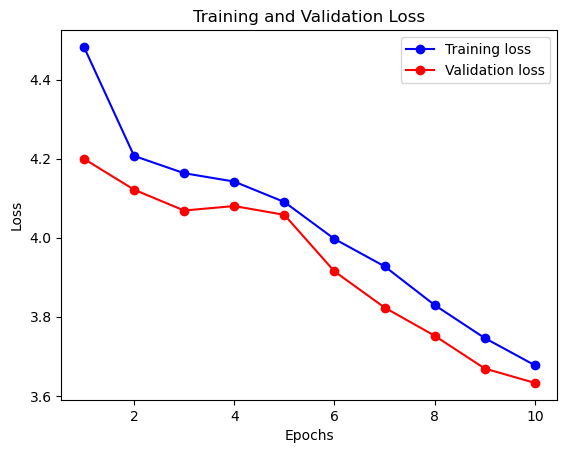

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

def train_places365_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=10):
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        total_batches = len(train_loader)
        progress_bar = tqdm(enumerate(train_loader), total=total_batches, desc=f"Epoch {epoch+1}/{num_epochs}")
        
        for batch_idx, (images, labels) in progress_bar:
            images, labels = torch.stack(images), torch.stack(labels)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            progress_bar.set_postfix(loss=loss.item())

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}')
        
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = torch.stack(images), torch.stack(labels)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
        
        scheduler.step()
        val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(val_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}')

        
    return train_losses, val_losses, model

train_losses, val_losses, model = train_places365_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=10)

torch.save(model.state_dict(), 'places365_lanscape_type_classification.pth')

def plot_training_curves(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training loss')
    plt.plot(epochs, val_losses, 'ro-', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_training_curves(train_losses, val_losses)

Processing images:   0%|                                 | 0/10 [00:00<?, ?it/s]

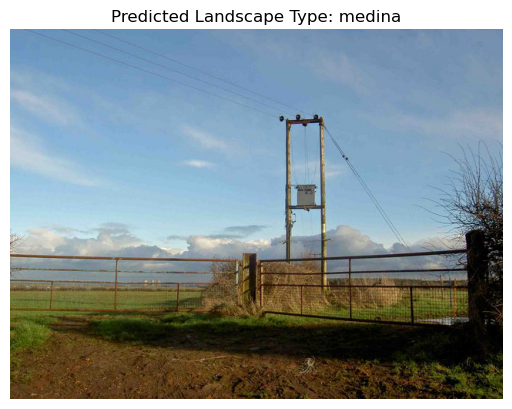

Processing images:  10%|██▌                      | 1/10 [00:00<00:05,  1.67it/s]

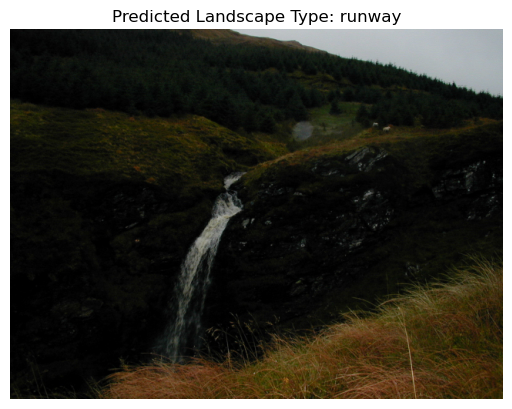

Processing images:  20%|█████                    | 2/10 [00:01<00:04,  1.61it/s]

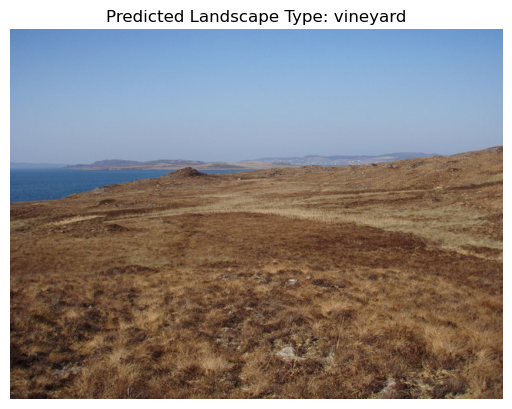

Processing images:  30%|███████▌                 | 3/10 [00:01<00:04,  1.75it/s]

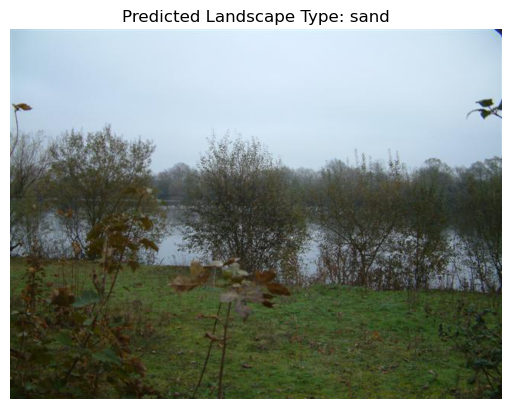

Processing images:  40%|██████████               | 4/10 [00:02<00:03,  1.95it/s]

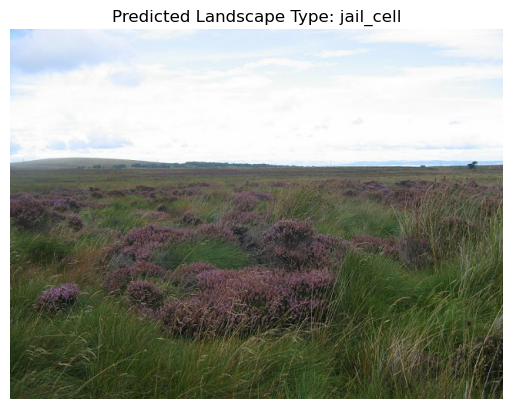

Processing images:  50%|████████████▌            | 5/10 [00:02<00:02,  1.82it/s]

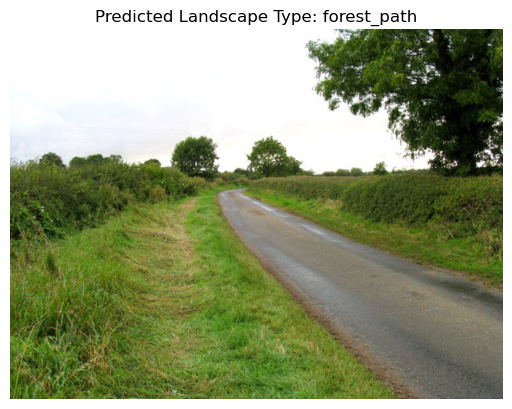

Processing images:  60%|███████████████          | 6/10 [00:03<00:02,  1.79it/s]

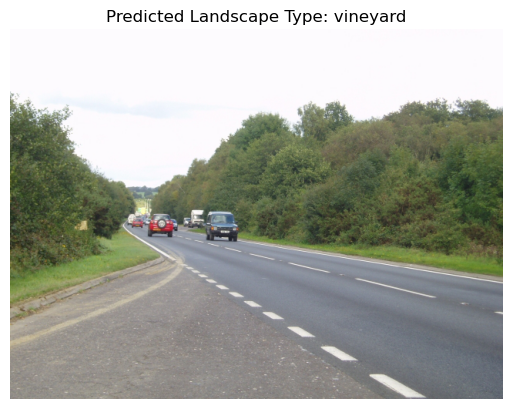

Processing images:  70%|█████████████████▌       | 7/10 [00:03<00:01,  1.97it/s]

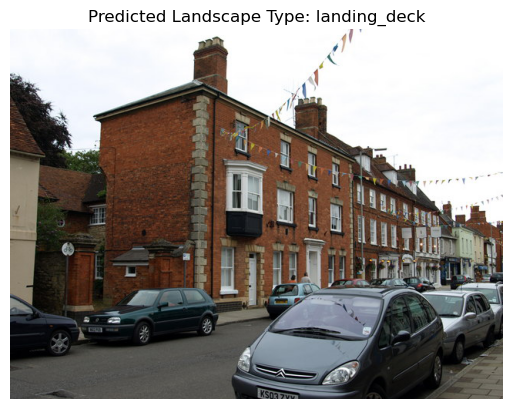

Processing images:  80%|████████████████████     | 8/10 [00:04<00:01,  1.98it/s]

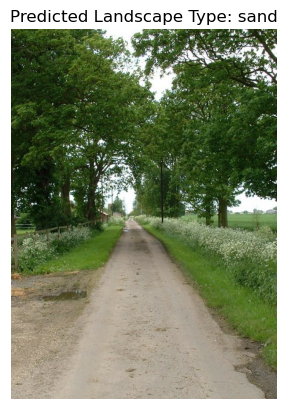

Processing images:  90%|██████████████████████▌  | 9/10 [00:04<00:00,  1.95it/s]

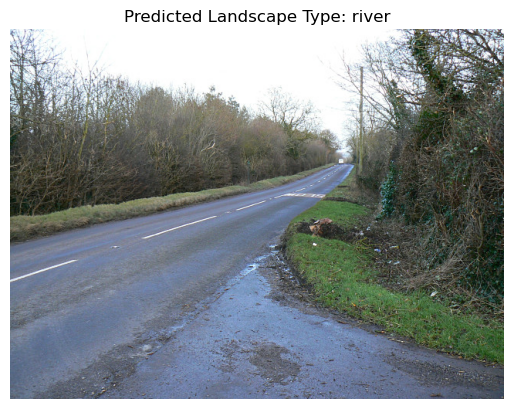

Processing images: 100%|████████████████████████| 10/10 [00:05<00:00,  1.86it/s]

Results saved to: /home/ubuntu/landscape-aesthetics/data/external/scenicornot/result_of_type_of_landscapes.csv


In [17]:
def get_landscape_type_by_id(df,i):
    return df.iloc[i, 0]
file_location_path = Path.cwd()
project_base_path = file_location_path.parent.parent
scenic_or_not_paths = project_base_path / 'data' / 'external' / 'scenicornot'
image_folder = Path('/home/ubuntu/landscape-aesthetics')

model.eval()

data_transforms = transforms.Compose([
        # transforms.Resize((256, 256)),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)
    ])
landscape_type_df = pd.read_csv('/home/ubuntu/landscape-aesthetics/data/external/ADEChallengeData2016/landscape_categories.csv')  

data = pd.read_csv(os.path.join(scenic_or_not_paths, 'scenicornot.metadata.csv'), usecols = ['filename'])

data = data.sample(n=10, random_state=1)

result = project_base_path / 'data' / 'external' / 'scenicornot' / 'result_of_type_of_landscapes.csv'
image_paths = data.iloc[:, 0].tolist()
predictions = []
image_results = []
    
for img_path in tqdm(image_paths, desc="Processing images"):
    image_path = os.path.join(scenic_or_not_paths, img_path) 
    img_display = Image.open(image_path)
    plt.imshow(img_display)
    img = data_transforms(Image.open(image_path).convert('RGB')) .unsqueeze(0)
    
    with torch.no_grad():
        output = model(img)
    
    _, predicted = torch.max(output, 1)
    predictions.append(get_landscape_type_by_id(landscape_type_df, predicted.item()))
    image_results.append((img_path, get_landscape_type_by_id(landscape_type_df, predicted.item())))
    plt.title(f"Predicted Landscape Type: {get_landscape_type_by_id(landscape_type_df, predicted.item())}")
    plt.axis('off')
    plt.show()
results_df = pd.DataFrame(image_results, columns=['image_path', 'prediction'])

results_df.to_csv(result, index=False)
print(f"Results saved to: {result}")